In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (ResNet152V2)

2024-02-21 11:05:13.013251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 11:05:13.013375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 11:05:13.122720: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(ResNet152V2(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("ResNet152V2"+s+".keras")
    

    # save model to disk
    filename = "ResNet152V2" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152v2 (Functional)    (None, 4)                 58339844  


Total params: 58339844 (222.55 MB)


Trainable params: 58196100 (222.00 MB)


Non-trainable params: 143744 (561.50 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708513589.691746      76 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 3:27:09 - loss: 1.9522 - accuracy: 0.0312

  2/140 [..............................] - ETA: 44s - loss: 1.9807 - accuracy: 0.1406    

  3/140 [..............................] - ETA: 43s - loss: 1.9635 - accuracy: 0.2708

  4/140 [..............................] - ETA: 43s - loss: 1.6926 - accuracy: 0.3359

  5/140 [>.............................] - ETA: 43s - loss: 1.5035 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 42s - loss: 1.4160 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 42s - loss: 1.5413 - accuracy: 0.4196

  8/140 [>.............................] - ETA: 42s - loss: 1.5839 - accuracy: 0.4180

  9/140 [>.............................] - ETA: 41s - loss: 1.5629 - accuracy: 0.3924

 10/140 [=>............................] - ETA: 41s - loss: 1.5178 - accuracy: 0.4031

 11/140 [=>............................] - ETA: 41s - loss: 1.4836 - accuracy: 0.4148

 12/140 [=>............................] - ETA: 40s - loss: 1.4950 - accuracy: 0.4193

 13/140 [=>............................] - ETA: 40s - loss: 1.4628 - accuracy: 0.4327

 14/140 [==>...........................] - ETA: 40s - loss: 1.4282 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 39s - loss: 1.4089 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 39s - loss: 1.3819 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 39s - loss: 1.3678 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 38s - loss: 1.3434 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 38s - loss: 1.3396 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 38s - loss: 1.3402 - accuracy: 0.4609

 21/140 [===>..........................] - ETA: 37s - loss: 1.3308 - accuracy: 0.4583

 22/140 [===>..........................] - ETA: 37s - loss: 1.3222 - accuracy: 0.4560

 23/140 [===>..........................] - ETA: 37s - loss: 1.3100 - accuracy: 0.4579

 24/140 [====>.........................] - ETA: 36s - loss: 1.3034 - accuracy: 0.4570

 25/140 [====>.........................] - ETA: 36s - loss: 1.2954 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 36s - loss: 1.2827 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 35s - loss: 1.2704 - accuracy: 0.4653

 28/140 [=====>........................] - ETA: 35s - loss: 1.2673 - accuracy: 0.4665

 29/140 [=====>........................] - ETA: 35s - loss: 1.2554 - accuracy: 0.4698

 30/140 [=====>........................] - ETA: 34s - loss: 1.2504 - accuracy: 0.4719

 31/140 [=====>........................] - ETA: 34s - loss: 1.2431 - accuracy: 0.4748

 32/140 [=====>........................] - ETA: 34s - loss: 1.2348 - accuracy: 0.4756

 33/140 [======>.......................] - ETA: 33s - loss: 1.2214 - accuracy: 0.4820

 34/140 [======>.......................] - ETA: 33s - loss: 1.2202 - accuracy: 0.4825

 35/140 [======>.......................] - ETA: 33s - loss: 1.2158 - accuracy: 0.4830

 36/140 [======>.......................] - ETA: 33s - loss: 1.2060 - accuracy: 0.4861

 37/140 [======>.......................] - ETA: 32s - loss: 1.2059 - accuracy: 0.4840

 38/140 [=======>......................] - ETA: 32s - loss: 1.1998 - accuracy: 0.4860

 39/140 [=======>......................] - ETA: 32s - loss: 1.2038 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 31s - loss: 1.1994 - accuracy: 0.4875

 41/140 [=======>......................] - ETA: 31s - loss: 1.1916 - accuracy: 0.4931

 42/140 [========>.....................] - ETA: 31s - loss: 1.1832 - accuracy: 0.4948

 43/140 [========>.....................] - ETA: 30s - loss: 1.1760 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 30s - loss: 1.1714 - accuracy: 0.4972

 45/140 [========>.....................] - ETA: 30s - loss: 1.1660 - accuracy: 0.4958

 46/140 [========>.....................] - ETA: 29s - loss: 1.1609 - accuracy: 0.4986

 47/140 [=========>....................] - ETA: 29s - loss: 1.1575 - accuracy: 0.4987

 48/140 [=========>....................] - ETA: 29s - loss: 1.1512 - accuracy: 0.5000

 49/140 [=========>....................] - ETA: 28s - loss: 1.1483 - accuracy: 0.5026

 50/140 [=========>....................] - ETA: 28s - loss: 1.1409 - accuracy: 0.5056

 51/140 [=========>....................] - ETA: 28s - loss: 1.1362 - accuracy: 0.5074

 52/140 [==========>...................] - ETA: 27s - loss: 1.1281 - accuracy: 0.5102

 53/140 [==========>...................] - ETA: 27s - loss: 1.1206 - accuracy: 0.5124

 54/140 [==========>...................] - ETA: 27s - loss: 1.1166 - accuracy: 0.5139

 55/140 [==========>...................] - ETA: 26s - loss: 1.1137 - accuracy: 0.5131

 56/140 [===========>..................] - ETA: 26s - loss: 1.1078 - accuracy: 0.5145

 57/140 [===========>..................] - ETA: 26s - loss: 1.1033 - accuracy: 0.5164

 58/140 [===========>..................] - ETA: 26s - loss: 1.0987 - accuracy: 0.5178

 59/140 [===========>..................] - ETA: 25s - loss: 1.0991 - accuracy: 0.5169

 60/140 [===========>..................] - ETA: 25s - loss: 1.0955 - accuracy: 0.5182

 61/140 [============>.................] - ETA: 25s - loss: 1.0904 - accuracy: 0.5200

 62/140 [============>.................] - ETA: 24s - loss: 1.0862 - accuracy: 0.5212

 63/140 [============>.................] - ETA: 24s - loss: 1.0845 - accuracy: 0.5228

 64/140 [============>.................] - ETA: 24s - loss: 1.0814 - accuracy: 0.5249

 65/140 [============>.................] - ETA: 23s - loss: 1.0810 - accuracy: 0.5264

 66/140 [=============>................] - ETA: 23s - loss: 1.0775 - accuracy: 0.5289

 67/140 [=============>................] - ETA: 23s - loss: 1.0735 - accuracy: 0.5294

 68/140 [=============>................] - ETA: 22s - loss: 1.0801 - accuracy: 0.5267

 69/140 [=============>................] - ETA: 22s - loss: 1.0766 - accuracy: 0.5276

 70/140 [==============>...............] - ETA: 22s - loss: 1.0754 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 21s - loss: 1.0749 - accuracy: 0.5277

 72/140 [==============>...............] - ETA: 21s - loss: 1.0729 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 21s - loss: 1.0684 - accuracy: 0.5317

 74/140 [==============>...............] - ETA: 20s - loss: 1.0659 - accuracy: 0.5308

 75/140 [===============>..............] - ETA: 20s - loss: 1.0655 - accuracy: 0.5304

 76/140 [===============>..............] - ETA: 20s - loss: 1.0636 - accuracy: 0.5296

 77/140 [===============>..............] - ETA: 19s - loss: 1.0598 - accuracy: 0.5312

 78/140 [===============>..............] - ETA: 19s - loss: 1.0568 - accuracy: 0.5321

 79/140 [===============>..............] - ETA: 19s - loss: 1.0587 - accuracy: 0.5293

 80/140 [================>.............] - ETA: 19s - loss: 1.0556 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 18s - loss: 1.0519 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 18s - loss: 1.0482 - accuracy: 0.5351

 83/140 [================>.............] - ETA: 18s - loss: 1.0470 - accuracy: 0.5350

 84/140 [=================>............] - ETA: 17s - loss: 1.0492 - accuracy: 0.5346

 85/140 [=================>............] - ETA: 17s - loss: 1.0480 - accuracy: 0.5346

 86/140 [=================>............] - ETA: 17s - loss: 1.0448 - accuracy: 0.5342

 87/140 [=================>............] - ETA: 16s - loss: 1.0443 - accuracy: 0.5338

 88/140 [=================>............] - ETA: 16s - loss: 1.0445 - accuracy: 0.5337

 89/140 [==================>...........] - ETA: 16s - loss: 1.0471 - accuracy: 0.5327

 90/140 [==================>...........] - ETA: 15s - loss: 1.0461 - accuracy: 0.5330

 91/140 [==================>...........] - ETA: 15s - loss: 1.0440 - accuracy: 0.5337

 92/140 [==================>...........] - ETA: 15s - loss: 1.0414 - accuracy: 0.5353

 93/140 [==================>...........] - ETA: 14s - loss: 1.0385 - accuracy: 0.5366

 94/140 [===================>..........] - ETA: 14s - loss: 1.0368 - accuracy: 0.5362

 95/140 [===================>..........] - ETA: 14s - loss: 1.0356 - accuracy: 0.5365

 96/140 [===================>..........] - ETA: 13s - loss: 1.0326 - accuracy: 0.5365

 97/140 [===================>..........] - ETA: 13s - loss: 1.0326 - accuracy: 0.5377

 98/140 [====================>.........] - ETA: 13s - loss: 1.0334 - accuracy: 0.5364

 99/140 [====================>.........] - ETA: 13s - loss: 1.0296 - accuracy: 0.5379

100/140 [====================>.........] - ETA: 12s - loss: 1.0285 - accuracy: 0.5394

101/140 [====================>.........] - ETA: 12s - loss: 1.0260 - accuracy: 0.5396

102/140 [====================>.........] - ETA: 12s - loss: 1.0256 - accuracy: 0.5395

103/140 [=====================>........] - ETA: 11s - loss: 1.0240 - accuracy: 0.5397

104/140 [=====================>........] - ETA: 11s - loss: 1.0216 - accuracy: 0.5409

105/140 [=====================>........] - ETA: 11s - loss: 1.0212 - accuracy: 0.5420

106/140 [=====================>........] - ETA: 10s - loss: 1.0191 - accuracy: 0.5433

107/140 [=====================>........] - ETA: 10s - loss: 1.0165 - accuracy: 0.5438

108/140 [======================>.......] - ETA: 10s - loss: 1.0157 - accuracy: 0.5437

109/140 [======================>.......] - ETA: 9s - loss: 1.0150 - accuracy: 0.5439 

110/140 [======================>.......] - ETA: 9s - loss: 1.0140 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 9s - loss: 1.0120 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 8s - loss: 1.0122 - accuracy: 0.5446

113/140 [=======================>......] - ETA: 8s - loss: 1.0098 - accuracy: 0.5462

114/140 [=======================>......] - ETA: 8s - loss: 1.0078 - accuracy: 0.5461

115/140 [=======================>......] - ETA: 7s - loss: 1.0062 - accuracy: 0.5465

116/140 [=======================>......] - ETA: 7s - loss: 1.0043 - accuracy: 0.5474

117/140 [========================>.....] - ETA: 7s - loss: 1.0042 - accuracy: 0.5475

118/140 [========================>.....] - ETA: 6s - loss: 1.0022 - accuracy: 0.5471

119/140 [========================>.....] - ETA: 6s - loss: 1.0000 - accuracy: 0.5478

120/140 [========================>.....] - ETA: 6s - loss: 0.9997 - accuracy: 0.5466

121/140 [========================>.....] - ETA: 6s - loss: 0.9992 - accuracy: 0.5462

122/140 [=========================>....] - ETA: 5s - loss: 0.9974 - accuracy: 0.5471

123/140 [=========================>....] - ETA: 5s - loss: 0.9961 - accuracy: 0.5475

124/140 [=========================>....] - ETA: 5s - loss: 0.9957 - accuracy: 0.5489

125/140 [=========================>....] - ETA: 4s - loss: 0.9945 - accuracy: 0.5480

126/140 [==========================>...] - ETA: 4s - loss: 0.9930 - accuracy: 0.5496

127/140 [==========================>...] - ETA: 4s - loss: 0.9926 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 3s - loss: 0.9920 - accuracy: 0.5508

129/140 [==========================>...] - ETA: 3s - loss: 0.9905 - accuracy: 0.5514

130/140 [==========================>...] - ETA: 3s - loss: 0.9901 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 2s - loss: 0.9890 - accuracy: 0.5520

132/140 [===========================>..] - ETA: 2s - loss: 0.9892 - accuracy: 0.5523

133/140 [===========================>..] - ETA: 2s - loss: 0.9884 - accuracy: 0.5529

134/140 [===========================>..] - ETA: 1s - loss: 0.9866 - accuracy: 0.5536

135/140 [===========================>..] - ETA: 1s - loss: 0.9854 - accuracy: 0.5539

136/140 [============================>.] - ETA: 1s - loss: 0.9860 - accuracy: 0.5531

137/140 [============================>.] - ETA: 0s - loss: 0.9839 - accuracy: 0.5543

138/140 [============================>.] - ETA: 0s - loss: 0.9828 - accuracy: 0.5541

139/140 [============================>.] - ETA: 0s - loss: 0.9822 - accuracy: 0.5542

140/140 [==============================] - ETA: 0s - loss: 0.9818 - accuracy: 0.5541

140/140 [==============================] - 143s 389ms/step - loss: 0.9818 - accuracy: 0.5541 - val_loss: 3.6084 - val_accuracy: 0.5137


Epoch 2/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8121 - accuracy: 0.6250

  2/140 [..............................] - ETA: 43s - loss: 0.7871 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 43s - loss: 0.7789 - accuracy: 0.6146

  4/140 [..............................] - ETA: 43s - loss: 0.8048 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 42s - loss: 0.8434 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 42s - loss: 0.9080 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 42s - loss: 0.9005 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 42s - loss: 0.8822 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 41s - loss: 0.8793 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 41s - loss: 0.8881 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 41s - loss: 0.8853 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 40s - loss: 0.8706 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 40s - loss: 0.8882 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 40s - loss: 0.8814 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 39s - loss: 0.8746 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 39s - loss: 0.8594 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 39s - loss: 0.8575 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 38s - loss: 0.8620 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 38s - loss: 0.8699 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 38s - loss: 0.8712 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 37s - loss: 0.8602 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 37s - loss: 0.8570 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 37s - loss: 0.8512 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 36s - loss: 0.8476 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 36s - loss: 0.8502 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 36s - loss: 0.8473 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 35s - loss: 0.8453 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 35s - loss: 0.8424 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 35s - loss: 0.8406 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 34s - loss: 0.8434 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 34s - loss: 0.8467 - accuracy: 0.5867

 32/140 [=====>........................] - ETA: 34s - loss: 0.8486 - accuracy: 0.5850

 33/140 [======>.......................] - ETA: 34s - loss: 0.8483 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 33s - loss: 0.8503 - accuracy: 0.5818

 35/140 [======>.......................] - ETA: 33s - loss: 0.8475 - accuracy: 0.5821

 36/140 [======>.......................] - ETA: 33s - loss: 0.8489 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 32s - loss: 0.8459 - accuracy: 0.5878

 38/140 [=======>......................] - ETA: 32s - loss: 0.8449 - accuracy: 0.5896

 39/140 [=======>......................] - ETA: 32s - loss: 0.8468 - accuracy: 0.5889

 40/140 [=======>......................] - ETA: 31s - loss: 0.8431 - accuracy: 0.5914

 41/140 [=======>......................] - ETA: 31s - loss: 0.8430 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 31s - loss: 0.8459 - accuracy: 0.5893

 43/140 [========>.....................] - ETA: 30s - loss: 0.8445 - accuracy: 0.5908

 44/140 [========>.....................] - ETA: 30s - loss: 0.8404 - accuracy: 0.5923

 45/140 [========>.....................] - ETA: 30s - loss: 0.8447 - accuracy: 0.5924

 46/140 [========>.....................] - ETA: 29s - loss: 0.8446 - accuracy: 0.5910

 47/140 [=========>....................] - ETA: 29s - loss: 0.8436 - accuracy: 0.5951

 48/140 [=========>....................] - ETA: 29s - loss: 0.8461 - accuracy: 0.5944

 49/140 [=========>....................] - ETA: 29s - loss: 0.8448 - accuracy: 0.5957

 50/140 [=========>....................] - ETA: 28s - loss: 0.8409 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 28s - loss: 0.8418 - accuracy: 0.5968

 52/140 [==========>...................] - ETA: 28s - loss: 0.8398 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 27s - loss: 0.8370 - accuracy: 0.6002

 54/140 [==========>...................] - ETA: 27s - loss: 0.8350 - accuracy: 0.6019

 55/140 [==========>...................] - ETA: 27s - loss: 0.8372 - accuracy: 0.5989

 56/140 [===========>..................] - ETA: 26s - loss: 0.8347 - accuracy: 0.6010

 57/140 [===========>..................] - ETA: 26s - loss: 0.8361 - accuracy: 0.5998

 58/140 [===========>..................] - ETA: 26s - loss: 0.8342 - accuracy: 0.6013

 59/140 [===========>..................] - ETA: 25s - loss: 0.8343 - accuracy: 0.6038

 60/140 [===========>..................] - ETA: 25s - loss: 0.8319 - accuracy: 0.6042

 61/140 [============>.................] - ETA: 25s - loss: 0.8302 - accuracy: 0.6050

 62/140 [============>.................] - ETA: 24s - loss: 0.8271 - accuracy: 0.6074

 63/140 [============>.................] - ETA: 24s - loss: 0.8281 - accuracy: 0.6066

 64/140 [============>.................] - ETA: 24s - loss: 0.8238 - accuracy: 0.6079

 65/140 [============>.................] - ETA: 23s - loss: 0.8250 - accuracy: 0.6072

 66/140 [=============>................] - ETA: 23s - loss: 0.8261 - accuracy: 0.6070

 67/140 [=============>................] - ETA: 23s - loss: 0.8221 - accuracy: 0.6087

 68/140 [=============>................] - ETA: 22s - loss: 0.8205 - accuracy: 0.6108

 69/140 [=============>................] - ETA: 22s - loss: 0.8225 - accuracy: 0.6110

 70/140 [==============>...............] - ETA: 22s - loss: 0.8190 - accuracy: 0.6129

 71/140 [==============>...............] - ETA: 22s - loss: 0.8144 - accuracy: 0.6158

 72/140 [==============>...............] - ETA: 21s - loss: 0.8111 - accuracy: 0.6172

 73/140 [==============>...............] - ETA: 21s - loss: 0.8105 - accuracy: 0.6177

 74/140 [==============>...............] - ETA: 21s - loss: 0.8130 - accuracy: 0.6153

 75/140 [===============>..............] - ETA: 20s - loss: 0.8212 - accuracy: 0.6125

 76/140 [===============>..............] - ETA: 20s - loss: 0.8199 - accuracy: 0.6131

 77/140 [===============>..............] - ETA: 20s - loss: 0.8169 - accuracy: 0.6157

 78/140 [===============>..............] - ETA: 19s - loss: 0.8177 - accuracy: 0.6154

 79/140 [===============>..............] - ETA: 19s - loss: 0.8188 - accuracy: 0.6147

 80/140 [================>.............] - ETA: 19s - loss: 0.8196 - accuracy: 0.6156

 81/140 [================>.............] - ETA: 18s - loss: 0.8190 - accuracy: 0.6157

 82/140 [================>.............] - ETA: 18s - loss: 0.8184 - accuracy: 0.6147

 83/140 [================>.............] - ETA: 18s - loss: 0.8188 - accuracy: 0.6130

 84/140 [=================>............] - ETA: 17s - loss: 0.8194 - accuracy: 0.6131

 85/140 [=================>............] - ETA: 17s - loss: 0.8224 - accuracy: 0.6125

 86/140 [=================>............] - ETA: 17s - loss: 0.8215 - accuracy: 0.6134

 87/140 [=================>............] - ETA: 16s - loss: 0.8208 - accuracy: 0.6146

 88/140 [=================>............] - ETA: 16s - loss: 0.8195 - accuracy: 0.6161

 89/140 [==================>...........] - ETA: 16s - loss: 0.8203 - accuracy: 0.6166

 90/140 [==================>...........] - ETA: 15s - loss: 0.8184 - accuracy: 0.6184

 91/140 [==================>...........] - ETA: 15s - loss: 0.8189 - accuracy: 0.6174

 92/140 [==================>...........] - ETA: 15s - loss: 0.8178 - accuracy: 0.6179

 93/140 [==================>...........] - ETA: 14s - loss: 0.8169 - accuracy: 0.6183

 94/140 [===================>..........] - ETA: 14s - loss: 0.8172 - accuracy: 0.6180

 95/140 [===================>..........] - ETA: 14s - loss: 0.8165 - accuracy: 0.6191

 96/140 [===================>..........] - ETA: 14s - loss: 0.8131 - accuracy: 0.6221

 97/140 [===================>..........] - ETA: 13s - loss: 0.8129 - accuracy: 0.6224

 98/140 [====================>.........] - ETA: 13s - loss: 0.8108 - accuracy: 0.6224

 99/140 [====================>.........] - ETA: 13s - loss: 0.8124 - accuracy: 0.6222

100/140 [====================>.........] - ETA: 12s - loss: 0.8115 - accuracy: 0.6225

101/140 [====================>.........] - ETA: 12s - loss: 0.8117 - accuracy: 0.6222

102/140 [====================>.........] - ETA: 12s - loss: 0.8114 - accuracy: 0.6222

103/140 [=====================>........] - ETA: 11s - loss: 0.8101 - accuracy: 0.6226

104/140 [=====================>........] - ETA: 11s - loss: 0.8086 - accuracy: 0.6241

105/140 [=====================>........] - ETA: 11s - loss: 0.8081 - accuracy: 0.6247

106/140 [=====================>........] - ETA: 10s - loss: 0.8078 - accuracy: 0.6244

107/140 [=====================>........] - ETA: 10s - loss: 0.8071 - accuracy: 0.6244

108/140 [======================>.......] - ETA: 10s - loss: 0.8065 - accuracy: 0.6244

109/140 [======================>.......] - ETA: 9s - loss: 0.8085 - accuracy: 0.6236 

110/140 [======================>.......] - ETA: 9s - loss: 0.8087 - accuracy: 0.6224

111/140 [======================>.......] - ETA: 9s - loss: 0.8120 - accuracy: 0.6208

112/140 [=======================>......] - ETA: 8s - loss: 0.8116 - accuracy: 0.6211

113/140 [=======================>......] - ETA: 8s - loss: 0.8108 - accuracy: 0.6214

114/140 [=======================>......] - ETA: 8s - loss: 0.8114 - accuracy: 0.6209

115/140 [=======================>......] - ETA: 7s - loss: 0.8123 - accuracy: 0.6196

116/140 [=======================>......] - ETA: 7s - loss: 0.8128 - accuracy: 0.6188

117/140 [========================>.....] - ETA: 7s - loss: 0.8130 - accuracy: 0.6191

118/140 [========================>.....] - ETA: 7s - loss: 0.8123 - accuracy: 0.6194

119/140 [========================>.....] - ETA: 6s - loss: 0.8119 - accuracy: 0.6195

120/140 [========================>.....] - ETA: 6s - loss: 0.8111 - accuracy: 0.6198

121/140 [========================>.....] - ETA: 6s - loss: 0.8098 - accuracy: 0.6206

122/140 [=========================>....] - ETA: 5s - loss: 0.8126 - accuracy: 0.6186

123/140 [=========================>....] - ETA: 5s - loss: 0.8115 - accuracy: 0.6192

124/140 [=========================>....] - ETA: 5s - loss: 0.8106 - accuracy: 0.6200

125/140 [=========================>....] - ETA: 4s - loss: 0.8123 - accuracy: 0.6180

126/140 [==========================>...] - ETA: 4s - loss: 0.8125 - accuracy: 0.6181

127/140 [==========================>...] - ETA: 4s - loss: 0.8116 - accuracy: 0.6186

128/140 [==========================>...] - ETA: 3s - loss: 0.8117 - accuracy: 0.6184

129/140 [==========================>...] - ETA: 3s - loss: 0.8103 - accuracy: 0.6187

130/140 [==========================>...] - ETA: 3s - loss: 0.8111 - accuracy: 0.6180

131/140 [===========================>..] - ETA: 2s - loss: 0.8122 - accuracy: 0.6176

132/140 [===========================>..] - ETA: 2s - loss: 0.8115 - accuracy: 0.6179

133/140 [===========================>..] - ETA: 2s - loss: 0.8112 - accuracy: 0.6184

134/140 [===========================>..] - ETA: 1s - loss: 0.8111 - accuracy: 0.6187

135/140 [===========================>..] - ETA: 1s - loss: 0.8097 - accuracy: 0.6192

136/140 [============================>.] - ETA: 1s - loss: 0.8081 - accuracy: 0.6199

137/140 [============================>.] - ETA: 0s - loss: 0.8082 - accuracy: 0.6195

138/140 [============================>.] - ETA: 0s - loss: 0.8076 - accuracy: 0.6200

139/140 [============================>.] - ETA: 0s - loss: 0.8074 - accuracy: 0.6201

140/140 [==============================] - ETA: 0s - loss: 0.8080 - accuracy: 0.6201

140/140 [==============================] - 49s 348ms/step - loss: 0.8080 - accuracy: 0.6201 - val_loss: 35.2606 - val_accuracy: 0.5082


Epoch 3/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.6862 - accuracy: 0.6562

  2/140 [..............................] - ETA: 44s - loss: 0.7535 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 43s - loss: 0.7655 - accuracy: 0.5833

  4/140 [..............................] - ETA: 43s - loss: 0.7641 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 43s - loss: 0.7454 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 42s - loss: 0.7731 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 42s - loss: 0.8083 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 42s - loss: 0.8217 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 41s - loss: 0.7949 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 41s - loss: 0.7862 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 41s - loss: 0.7933 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 40s - loss: 0.7949 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 40s - loss: 0.8039 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 40s - loss: 0.7974 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 39s - loss: 0.8079 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 39s - loss: 0.8110 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 39s - loss: 0.8114 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 38s - loss: 0.7969 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 38s - loss: 0.7869 - accuracy: 0.6151

 20/140 [===>..........................] - ETA: 38s - loss: 0.8001 - accuracy: 0.6109

 21/140 [===>..........................] - ETA: 37s - loss: 0.7989 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 37s - loss: 0.7887 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 37s - loss: 0.7804 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 36s - loss: 0.7853 - accuracy: 0.6250

 25/140 [====>.........................] - ETA: 36s - loss: 0.7751 - accuracy: 0.6313

 26/140 [====>.........................] - ETA: 36s - loss: 0.7812 - accuracy: 0.6310

 27/140 [====>.........................] - ETA: 35s - loss: 0.7799 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 35s - loss: 0.7743 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 35s - loss: 0.7667 - accuracy: 0.6379

 30/140 [=====>........................] - ETA: 35s - loss: 0.7637 - accuracy: 0.6396

 31/140 [=====>........................] - ETA: 34s - loss: 0.7626 - accuracy: 0.6401

 32/140 [=====>........................] - ETA: 34s - loss: 0.7676 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 34s - loss: 0.7648 - accuracy: 0.6392

 34/140 [======>.......................] - ETA: 33s - loss: 0.7564 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 33s - loss: 0.7576 - accuracy: 0.6438

 36/140 [======>.......................] - ETA: 33s - loss: 0.7566 - accuracy: 0.6424

 37/140 [======>.......................] - ETA: 32s - loss: 0.7536 - accuracy: 0.6427

 38/140 [=======>......................] - ETA: 32s - loss: 0.7551 - accuracy: 0.6414

 39/140 [=======>......................] - ETA: 32s - loss: 0.7494 - accuracy: 0.6450

 40/140 [=======>......................] - ETA: 31s - loss: 0.7487 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 31s - loss: 0.7522 - accuracy: 0.6502

 42/140 [========>.....................] - ETA: 31s - loss: 0.7518 - accuracy: 0.6488

 43/140 [========>.....................] - ETA: 30s - loss: 0.7519 - accuracy: 0.6468

 44/140 [========>.....................] - ETA: 30s - loss: 0.7459 - accuracy: 0.6506

 45/140 [========>.....................] - ETA: 30s - loss: 0.7421 - accuracy: 0.6528

 46/140 [========>.....................] - ETA: 29s - loss: 0.7393 - accuracy: 0.6576

 47/140 [=========>....................] - ETA: 29s - loss: 0.7422 - accuracy: 0.6582

 48/140 [=========>....................] - ETA: 29s - loss: 0.7419 - accuracy: 0.6589

 49/140 [=========>....................] - ETA: 28s - loss: 0.7366 - accuracy: 0.6614

 50/140 [=========>....................] - ETA: 28s - loss: 0.7312 - accuracy: 0.6644

 51/140 [=========>....................] - ETA: 28s - loss: 0.7262 - accuracy: 0.6673

 52/140 [==========>...................] - ETA: 28s - loss: 0.7305 - accuracy: 0.6665

 53/140 [==========>...................] - ETA: 27s - loss: 0.7336 - accuracy: 0.6645

 54/140 [==========>...................] - ETA: 27s - loss: 0.7306 - accuracy: 0.6667

 55/140 [==========>...................] - ETA: 27s - loss: 0.7307 - accuracy: 0.6670

 56/140 [===========>..................] - ETA: 26s - loss: 0.7286 - accuracy: 0.6696

 57/140 [===========>..................] - ETA: 26s - loss: 0.7291 - accuracy: 0.6689

 58/140 [===========>..................] - ETA: 26s - loss: 0.7277 - accuracy: 0.6697

 59/140 [===========>..................] - ETA: 25s - loss: 0.7321 - accuracy: 0.6695

 60/140 [===========>..................] - ETA: 25s - loss: 0.7302 - accuracy: 0.6719

 61/140 [============>.................] - ETA: 25s - loss: 0.7293 - accuracy: 0.6711

 62/140 [============>.................] - ETA: 24s - loss: 0.7295 - accuracy: 0.6714

 63/140 [============>.................] - ETA: 24s - loss: 0.7303 - accuracy: 0.6716

 64/140 [============>.................] - ETA: 24s - loss: 0.7308 - accuracy: 0.6714

 65/140 [============>.................] - ETA: 23s - loss: 0.7287 - accuracy: 0.6716

 66/140 [=============>................] - ETA: 23s - loss: 0.7270 - accuracy: 0.6733

 67/140 [=============>................] - ETA: 23s - loss: 0.7264 - accuracy: 0.6735

 68/140 [=============>................] - ETA: 22s - loss: 0.7237 - accuracy: 0.6746

 69/140 [=============>................] - ETA: 22s - loss: 0.7224 - accuracy: 0.6766

 70/140 [==============>...............] - ETA: 22s - loss: 0.7204 - accuracy: 0.6786

 71/140 [==============>...............] - ETA: 21s - loss: 0.7177 - accuracy: 0.6787

 72/140 [==============>...............] - ETA: 21s - loss: 0.7162 - accuracy: 0.6793

 73/140 [==============>...............] - ETA: 21s - loss: 0.7138 - accuracy: 0.6811

 74/140 [==============>...............] - ETA: 20s - loss: 0.7135 - accuracy: 0.6816

 75/140 [===============>..............] - ETA: 20s - loss: 0.7128 - accuracy: 0.6821

 76/140 [===============>..............] - ETA: 20s - loss: 0.7117 - accuracy: 0.6830

 77/140 [===============>..............] - ETA: 20s - loss: 0.7131 - accuracy: 0.6834

 78/140 [===============>..............] - ETA: 19s - loss: 0.7155 - accuracy: 0.6827

 79/140 [===============>..............] - ETA: 19s - loss: 0.7139 - accuracy: 0.6835

 80/140 [================>.............] - ETA: 19s - loss: 0.7162 - accuracy: 0.6816

 81/140 [================>.............] - ETA: 18s - loss: 0.7155 - accuracy: 0.6825

 82/140 [================>.............] - ETA: 18s - loss: 0.7148 - accuracy: 0.6825

 83/140 [================>.............] - ETA: 18s - loss: 0.7117 - accuracy: 0.6834

 84/140 [=================>............] - ETA: 17s - loss: 0.7156 - accuracy: 0.6823

 85/140 [=================>............] - ETA: 17s - loss: 0.7159 - accuracy: 0.6827

 86/140 [=================>............] - ETA: 17s - loss: 0.7136 - accuracy: 0.6846

 87/140 [=================>............] - ETA: 16s - loss: 0.7155 - accuracy: 0.6843

 88/140 [=================>............] - ETA: 16s - loss: 0.7156 - accuracy: 0.6836

 89/140 [==================>...........] - ETA: 16s - loss: 0.7153 - accuracy: 0.6833

 90/140 [==================>...........] - ETA: 15s - loss: 0.7159 - accuracy: 0.6830

 91/140 [==================>...........] - ETA: 15s - loss: 0.7206 - accuracy: 0.6813

 92/140 [==================>...........] - ETA: 15s - loss: 0.7206 - accuracy: 0.6814

 93/140 [==================>...........] - ETA: 14s - loss: 0.7194 - accuracy: 0.6821

 94/140 [===================>..........] - ETA: 14s - loss: 0.7193 - accuracy: 0.6815

 95/140 [===================>..........] - ETA: 14s - loss: 0.7207 - accuracy: 0.6809

 96/140 [===================>..........] - ETA: 13s - loss: 0.7209 - accuracy: 0.6807

 97/140 [===================>..........] - ETA: 13s - loss: 0.7193 - accuracy: 0.6811

 98/140 [====================>.........] - ETA: 13s - loss: 0.7197 - accuracy: 0.6798

 99/140 [====================>.........] - ETA: 13s - loss: 0.7178 - accuracy: 0.6818

100/140 [====================>.........] - ETA: 12s - loss: 0.7164 - accuracy: 0.6822

101/140 [====================>.........] - ETA: 12s - loss: 0.7150 - accuracy: 0.6832

102/140 [====================>.........] - ETA: 12s - loss: 0.7154 - accuracy: 0.6832

103/140 [=====================>........] - ETA: 11s - loss: 0.7143 - accuracy: 0.6836

104/140 [=====================>........] - ETA: 11s - loss: 0.7122 - accuracy: 0.6845

105/140 [=====================>........] - ETA: 11s - loss: 0.7117 - accuracy: 0.6842

106/140 [=====================>........] - ETA: 10s - loss: 0.7114 - accuracy: 0.6843

107/140 [=====================>........] - ETA: 10s - loss: 0.7104 - accuracy: 0.6846

108/140 [======================>.......] - ETA: 10s - loss: 0.7115 - accuracy: 0.6843

109/140 [======================>.......] - ETA: 9s - loss: 0.7095 - accuracy: 0.6855 

110/140 [======================>.......] - ETA: 9s - loss: 0.7084 - accuracy: 0.6864

111/140 [======================>.......] - ETA: 9s - loss: 0.7075 - accuracy: 0.6858

112/140 [=======================>......] - ETA: 8s - loss: 0.7059 - accuracy: 0.6864

113/140 [=======================>......] - ETA: 8s - loss: 0.7035 - accuracy: 0.6872

114/140 [=======================>......] - ETA: 8s - loss: 0.7036 - accuracy: 0.6878

115/140 [=======================>......] - ETA: 7s - loss: 0.7024 - accuracy: 0.6883

116/140 [=======================>......] - ETA: 7s - loss: 0.7027 - accuracy: 0.6878

117/140 [========================>.....] - ETA: 7s - loss: 0.7034 - accuracy: 0.6883

118/140 [========================>.....] - ETA: 6s - loss: 0.7009 - accuracy: 0.6899

119/140 [========================>.....] - ETA: 6s - loss: 0.7008 - accuracy: 0.6893

120/140 [========================>.....] - ETA: 6s - loss: 0.7056 - accuracy: 0.6888

121/140 [========================>.....] - ETA: 6s - loss: 0.7040 - accuracy: 0.6893

122/140 [=========================>....] - ETA: 5s - loss: 0.7029 - accuracy: 0.6901

123/140 [=========================>....] - ETA: 5s - loss: 0.7021 - accuracy: 0.6908

124/140 [=========================>....] - ETA: 5s - loss: 0.7030 - accuracy: 0.6905

125/140 [=========================>....] - ETA: 4s - loss: 0.7058 - accuracy: 0.6900

126/140 [==========================>...] - ETA: 4s - loss: 0.7048 - accuracy: 0.6902

127/140 [==========================>...] - ETA: 4s - loss: 0.7053 - accuracy: 0.6902

128/140 [==========================>...] - ETA: 3s - loss: 0.7059 - accuracy: 0.6897

129/140 [==========================>...] - ETA: 3s - loss: 0.7059 - accuracy: 0.6894

130/140 [==========================>...] - ETA: 3s - loss: 0.7049 - accuracy: 0.6899

131/140 [===========================>..] - ETA: 2s - loss: 0.7042 - accuracy: 0.6899

132/140 [===========================>..] - ETA: 2s - loss: 0.7030 - accuracy: 0.6911

133/140 [===========================>..] - ETA: 2s - loss: 0.7029 - accuracy: 0.6903

134/140 [===========================>..] - ETA: 1s - loss: 0.7031 - accuracy: 0.6898

135/140 [===========================>..] - ETA: 1s - loss: 0.7018 - accuracy: 0.6905

136/140 [============================>.] - ETA: 1s - loss: 0.7016 - accuracy: 0.6912

137/140 [============================>.] - ETA: 0s - loss: 0.6996 - accuracy: 0.6921

138/140 [============================>.] - ETA: 0s - loss: 0.6993 - accuracy: 0.6920

139/140 [============================>.] - ETA: 0s - loss: 0.6996 - accuracy: 0.6927

140/140 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.6923

140/140 [==============================] - 49s 347ms/step - loss: 0.7012 - accuracy: 0.6923 - val_loss: 35.2715 - val_accuracy: 0.3518


Epoch 4/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.5737 - accuracy: 0.6562

  2/140 [..............................] - ETA: 43s - loss: 0.5595 - accuracy: 0.7031 

  3/140 [..............................] - ETA: 43s - loss: 0.6195 - accuracy: 0.6875

  4/140 [..............................] - ETA: 43s - loss: 0.6213 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 42s - loss: 0.6277 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 42s - loss: 0.6147 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 42s - loss: 0.6165 - accuracy: 0.7321

  8/140 [>.............................] - ETA: 41s - loss: 0.6101 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 41s - loss: 0.6018 - accuracy: 0.7431

 10/140 [=>............................] - ETA: 41s - loss: 0.6205 - accuracy: 0.7375

 11/140 [=>............................] - ETA: 41s - loss: 0.6114 - accuracy: 0.7472

 12/140 [=>............................] - ETA: 40s - loss: 0.6294 - accuracy: 0.7370

 13/140 [=>............................] - ETA: 40s - loss: 0.6315 - accuracy: 0.7380

 14/140 [==>...........................] - ETA: 40s - loss: 0.6419 - accuracy: 0.7388

 15/140 [==>...........................] - ETA: 39s - loss: 0.6425 - accuracy: 0.7375

 16/140 [==>...........................] - ETA: 39s - loss: 0.6386 - accuracy: 0.7402

 17/140 [==>...........................] - ETA: 39s - loss: 0.6550 - accuracy: 0.7335

 18/140 [==>...........................] - ETA: 38s - loss: 0.6487 - accuracy: 0.7344

 19/140 [===>..........................] - ETA: 38s - loss: 0.6596 - accuracy: 0.7286

 20/140 [===>..........................] - ETA: 38s - loss: 0.6664 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 37s - loss: 0.6646 - accuracy: 0.7292

 22/140 [===>..........................] - ETA: 37s - loss: 0.6650 - accuracy: 0.7273

 23/140 [===>..........................] - ETA: 37s - loss: 0.6632 - accuracy: 0.7310

 24/140 [====>.........................] - ETA: 36s - loss: 0.6683 - accuracy: 0.7253

 25/140 [====>.........................] - ETA: 36s - loss: 0.6630 - accuracy: 0.7262

 26/140 [====>.........................] - ETA: 36s - loss: 0.6533 - accuracy: 0.7320

 27/140 [====>.........................] - ETA: 36s - loss: 0.6502 - accuracy: 0.7315

 28/140 [=====>........................] - ETA: 35s - loss: 0.6464 - accuracy: 0.7333

 29/140 [=====>........................] - ETA: 35s - loss: 0.6478 - accuracy: 0.7295

 30/140 [=====>........................] - ETA: 35s - loss: 0.6435 - accuracy: 0.7292

 31/140 [=====>........................] - ETA: 34s - loss: 0.6445 - accuracy: 0.7268

 32/140 [=====>........................] - ETA: 34s - loss: 0.6455 - accuracy: 0.7256

 33/140 [======>.......................] - ETA: 34s - loss: 0.6431 - accuracy: 0.7292

 34/140 [======>.......................] - ETA: 33s - loss: 0.6442 - accuracy: 0.7298

 35/140 [======>.......................] - ETA: 33s - loss: 0.6432 - accuracy: 0.7295

 36/140 [======>.......................] - ETA: 33s - loss: 0.6416 - accuracy: 0.7309

 37/140 [======>.......................] - ETA: 32s - loss: 0.6396 - accuracy: 0.7280

 38/140 [=======>......................] - ETA: 32s - loss: 0.6434 - accuracy: 0.7262

 39/140 [=======>......................] - ETA: 32s - loss: 0.6422 - accuracy: 0.7260

 40/140 [=======>......................] - ETA: 31s - loss: 0.6413 - accuracy: 0.7250

 41/140 [=======>......................] - ETA: 31s - loss: 0.6339 - accuracy: 0.7287

 42/140 [========>.....................] - ETA: 31s - loss: 0.6289 - accuracy: 0.7314

 43/140 [========>.....................] - ETA: 30s - loss: 0.6293 - accuracy: 0.7326

 44/140 [========>.....................] - ETA: 30s - loss: 0.6250 - accuracy: 0.7337

 45/140 [========>.....................] - ETA: 30s - loss: 0.6292 - accuracy: 0.7319

 46/140 [========>.....................] - ETA: 29s - loss: 0.6302 - accuracy: 0.7323

 47/140 [=========>....................] - ETA: 29s - loss: 0.6261 - accuracy: 0.7347

 48/140 [=========>....................] - ETA: 29s - loss: 0.6319 - accuracy: 0.7318

 49/140 [=========>....................] - ETA: 28s - loss: 0.6312 - accuracy: 0.7321

 50/140 [=========>....................] - ETA: 28s - loss: 0.6321 - accuracy: 0.7312

 51/140 [=========>....................] - ETA: 28s - loss: 0.6306 - accuracy: 0.7322

 52/140 [==========>...................] - ETA: 28s - loss: 0.6266 - accuracy: 0.7338

 53/140 [==========>...................] - ETA: 27s - loss: 0.6246 - accuracy: 0.7347

 54/140 [==========>...................] - ETA: 27s - loss: 0.6215 - accuracy: 0.7361

 55/140 [==========>...................] - ETA: 27s - loss: 0.6209 - accuracy: 0.7375

 56/140 [===========>..................] - ETA: 26s - loss: 0.6170 - accuracy: 0.7400

 57/140 [===========>..................] - ETA: 26s - loss: 0.6158 - accuracy: 0.7401

 58/140 [===========>..................] - ETA: 26s - loss: 0.6126 - accuracy: 0.7419

 59/140 [===========>..................] - ETA: 25s - loss: 0.6127 - accuracy: 0.7421

 60/140 [===========>..................] - ETA: 25s - loss: 0.6087 - accuracy: 0.7448

 61/140 [============>.................] - ETA: 25s - loss: 0.6059 - accuracy: 0.7449

 62/140 [============>.................] - ETA: 24s - loss: 0.6082 - accuracy: 0.7434

 63/140 [============>.................] - ETA: 24s - loss: 0.6095 - accuracy: 0.7431

 64/140 [============>.................] - ETA: 24s - loss: 0.6097 - accuracy: 0.7432

 65/140 [============>.................] - ETA: 23s - loss: 0.6057 - accuracy: 0.7452

 66/140 [=============>................] - ETA: 23s - loss: 0.6017 - accuracy: 0.7476

 67/140 [=============>................] - ETA: 23s - loss: 0.5997 - accuracy: 0.7481

 68/140 [=============>................] - ETA: 22s - loss: 0.6027 - accuracy: 0.7477

 69/140 [=============>................] - ETA: 22s - loss: 0.6040 - accuracy: 0.7477

 70/140 [==============>...............] - ETA: 22s - loss: 0.6019 - accuracy: 0.7491

 71/140 [==============>...............] - ETA: 21s - loss: 0.6028 - accuracy: 0.7487

 72/140 [==============>...............] - ETA: 21s - loss: 0.6016 - accuracy: 0.7491

 73/140 [==============>...............] - ETA: 21s - loss: 0.5990 - accuracy: 0.7500

 74/140 [==============>...............] - ETA: 21s - loss: 0.5991 - accuracy: 0.7500

 75/140 [===============>..............] - ETA: 20s - loss: 0.5964 - accuracy: 0.7508

 76/140 [===============>..............] - ETA: 20s - loss: 0.5934 - accuracy: 0.7525

 77/140 [===============>..............] - ETA: 20s - loss: 0.5914 - accuracy: 0.7532

 78/140 [===============>..............] - ETA: 19s - loss: 0.5913 - accuracy: 0.7536

 79/140 [===============>..............] - ETA: 19s - loss: 0.5888 - accuracy: 0.7551

 80/140 [================>.............] - ETA: 19s - loss: 0.5885 - accuracy: 0.7547

 81/140 [================>.............] - ETA: 18s - loss: 0.5867 - accuracy: 0.7558

 82/140 [================>.............] - ETA: 18s - loss: 0.5849 - accuracy: 0.7572

 83/140 [================>.............] - ETA: 18s - loss: 0.5889 - accuracy: 0.7553

 84/140 [=================>............] - ETA: 17s - loss: 0.5871 - accuracy: 0.7556

 85/140 [=================>............] - ETA: 17s - loss: 0.5858 - accuracy: 0.7563

 86/140 [=================>............] - ETA: 17s - loss: 0.5837 - accuracy: 0.7569

 87/140 [=================>............] - ETA: 16s - loss: 0.5831 - accuracy: 0.7575

 88/140 [=================>............] - ETA: 16s - loss: 0.5808 - accuracy: 0.7585

 89/140 [==================>...........] - ETA: 16s - loss: 0.5809 - accuracy: 0.7581

 90/140 [==================>...........] - ETA: 15s - loss: 0.5832 - accuracy: 0.7576

 91/140 [==================>...........] - ETA: 15s - loss: 0.5823 - accuracy: 0.7586

 92/140 [==================>...........] - ETA: 15s - loss: 0.5830 - accuracy: 0.7582

 93/140 [==================>...........] - ETA: 14s - loss: 0.5849 - accuracy: 0.7574

 94/140 [===================>..........] - ETA: 14s - loss: 0.5839 - accuracy: 0.7583

 95/140 [===================>..........] - ETA: 14s - loss: 0.5841 - accuracy: 0.7579

 96/140 [===================>..........] - ETA: 14s - loss: 0.5850 - accuracy: 0.7572

 97/140 [===================>..........] - ETA: 13s - loss: 0.5829 - accuracy: 0.7584

 98/140 [====================>.........] - ETA: 13s - loss: 0.5811 - accuracy: 0.7592

 99/140 [====================>.........] - ETA: 13s - loss: 0.5801 - accuracy: 0.7595

100/140 [====================>.........] - ETA: 12s - loss: 0.5791 - accuracy: 0.7594

101/140 [====================>.........] - ETA: 12s - loss: 0.5796 - accuracy: 0.7590

102/140 [====================>.........] - ETA: 12s - loss: 0.5788 - accuracy: 0.7589

103/140 [=====================>........] - ETA: 11s - loss: 0.5784 - accuracy: 0.7594

104/140 [=====================>........] - ETA: 11s - loss: 0.5768 - accuracy: 0.7608

105/140 [=====================>........] - ETA: 11s - loss: 0.5741 - accuracy: 0.7622

106/140 [=====================>........] - ETA: 10s - loss: 0.5723 - accuracy: 0.7627

107/140 [=====================>........] - ETA: 10s - loss: 0.5714 - accuracy: 0.7629

108/140 [======================>.......] - ETA: 10s - loss: 0.5713 - accuracy: 0.7630

109/140 [======================>.......] - ETA: 9s - loss: 0.5690 - accuracy: 0.7643 

110/140 [======================>.......] - ETA: 9s - loss: 0.5690 - accuracy: 0.7645

111/140 [======================>.......] - ETA: 9s - loss: 0.5697 - accuracy: 0.7635

112/140 [=======================>......] - ETA: 8s - loss: 0.5670 - accuracy: 0.7648

113/140 [=======================>......] - ETA: 8s - loss: 0.5656 - accuracy: 0.7658

114/140 [=======================>......] - ETA: 8s - loss: 0.5651 - accuracy: 0.7664

115/140 [=======================>......] - ETA: 7s - loss: 0.5666 - accuracy: 0.7660

116/140 [=======================>......] - ETA: 7s - loss: 0.5645 - accuracy: 0.7670

117/140 [========================>.....] - ETA: 7s - loss: 0.5642 - accuracy: 0.7674

118/140 [========================>.....] - ETA: 7s - loss: 0.5635 - accuracy: 0.7683

119/140 [========================>.....] - ETA: 6s - loss: 0.5627 - accuracy: 0.7684

120/140 [========================>.....] - ETA: 6s - loss: 0.5605 - accuracy: 0.7690

121/140 [========================>.....] - ETA: 6s - loss: 0.5608 - accuracy: 0.7683

122/140 [=========================>....] - ETA: 5s - loss: 0.5604 - accuracy: 0.7690

123/140 [=========================>....] - ETA: 5s - loss: 0.5603 - accuracy: 0.7693

124/140 [=========================>....] - ETA: 5s - loss: 0.5596 - accuracy: 0.7699

125/140 [=========================>....] - ETA: 4s - loss: 0.5590 - accuracy: 0.7700

126/140 [==========================>...] - ETA: 4s - loss: 0.5610 - accuracy: 0.7693

127/140 [==========================>...] - ETA: 4s - loss: 0.5622 - accuracy: 0.7687

128/140 [==========================>...] - ETA: 3s - loss: 0.5599 - accuracy: 0.7698

129/140 [==========================>...] - ETA: 3s - loss: 0.5593 - accuracy: 0.7708

130/140 [==========================>...] - ETA: 3s - loss: 0.5608 - accuracy: 0.7697

131/140 [===========================>..] - ETA: 2s - loss: 0.5607 - accuracy: 0.7696

132/140 [===========================>..] - ETA: 2s - loss: 0.5611 - accuracy: 0.7689

133/140 [===========================>..] - ETA: 2s - loss: 0.5610 - accuracy: 0.7695

134/140 [===========================>..] - ETA: 1s - loss: 0.5588 - accuracy: 0.7710

135/140 [===========================>..] - ETA: 1s - loss: 0.5573 - accuracy: 0.7720

136/140 [============================>.] - ETA: 1s - loss: 0.5559 - accuracy: 0.7727

137/140 [============================>.] - ETA: 0s - loss: 0.5558 - accuracy: 0.7724

138/140 [============================>.] - ETA: 0s - loss: 0.5561 - accuracy: 0.7724

139/140 [============================>.] - ETA: 0s - loss: 0.5544 - accuracy: 0.7732

140/140 [==============================] - ETA: 0s - loss: 0.5537 - accuracy: 0.7736

140/140 [==============================] - 49s 347ms/step - loss: 0.5537 - accuracy: 0.7736 - val_loss: 7.5739 - val_accuracy: 0.5145


Epoch 5/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.6223 - accuracy: 0.7812

  2/140 [..............................] - ETA: 43s - loss: 0.4695 - accuracy: 0.8125 

  3/140 [..............................] - ETA: 43s - loss: 0.4387 - accuracy: 0.8229

  4/140 [..............................] - ETA: 43s - loss: 0.4534 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 42s - loss: 0.4789 - accuracy: 0.8125

  6/140 [>.............................] - ETA: 42s - loss: 0.4638 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 42s - loss: 0.4694 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 41s - loss: 0.4633 - accuracy: 0.8281

  9/140 [>.............................] - ETA: 41s - loss: 0.4571 - accuracy: 0.8299

 10/140 [=>............................] - ETA: 41s - loss: 0.4450 - accuracy: 0.8344

 11/140 [=>............................] - ETA: 40s - loss: 0.4397 - accuracy: 0.8267

 12/140 [=>............................] - ETA: 40s - loss: 0.4407 - accuracy: 0.8203

 13/140 [=>............................] - ETA: 40s - loss: 0.4232 - accuracy: 0.8269

 14/140 [==>...........................] - ETA: 40s - loss: 0.4196 - accuracy: 0.8348

 15/140 [==>...........................] - ETA: 39s - loss: 0.4279 - accuracy: 0.8333

 16/140 [==>...........................] - ETA: 39s - loss: 0.4163 - accuracy: 0.8359

 17/140 [==>...........................] - ETA: 39s - loss: 0.4189 - accuracy: 0.8382

 18/140 [==>...........................] - ETA: 38s - loss: 0.4074 - accuracy: 0.8420

 19/140 [===>..........................] - ETA: 38s - loss: 0.4078 - accuracy: 0.8405

 20/140 [===>..........................] - ETA: 38s - loss: 0.4098 - accuracy: 0.8391

 21/140 [===>..........................] - ETA: 37s - loss: 0.4177 - accuracy: 0.8333

 22/140 [===>..........................] - ETA: 37s - loss: 0.4298 - accuracy: 0.8253

 23/140 [===>..........................] - ETA: 37s - loss: 0.4349 - accuracy: 0.8247

 24/140 [====>.........................] - ETA: 36s - loss: 0.4441 - accuracy: 0.8216

 25/140 [====>.........................] - ETA: 36s - loss: 0.4436 - accuracy: 0.8213

 26/140 [====>.........................] - ETA: 36s - loss: 0.4440 - accuracy: 0.8209

 27/140 [====>.........................] - ETA: 35s - loss: 0.4480 - accuracy: 0.8171

 28/140 [=====>........................] - ETA: 35s - loss: 0.4446 - accuracy: 0.8181

 29/140 [=====>........................] - ETA: 35s - loss: 0.4489 - accuracy: 0.8179

 30/140 [=====>........................] - ETA: 34s - loss: 0.4423 - accuracy: 0.8198

 31/140 [=====>........................] - ETA: 34s - loss: 0.4404 - accuracy: 0.8216

 32/140 [=====>........................] - ETA: 34s - loss: 0.4367 - accuracy: 0.8213

 33/140 [======>.......................] - ETA: 34s - loss: 0.4348 - accuracy: 0.8220

 34/140 [======>.......................] - ETA: 33s - loss: 0.4318 - accuracy: 0.8226

 35/140 [======>.......................] - ETA: 33s - loss: 0.4287 - accuracy: 0.8241

 36/140 [======>.......................] - ETA: 33s - loss: 0.4341 - accuracy: 0.8238

 37/140 [======>.......................] - ETA: 32s - loss: 0.4377 - accuracy: 0.8218

 38/140 [=======>......................] - ETA: 32s - loss: 0.4332 - accuracy: 0.8240

 39/140 [=======>......................] - ETA: 32s - loss: 0.4332 - accuracy: 0.8221

 40/140 [=======>......................] - ETA: 31s - loss: 0.4283 - accuracy: 0.8242

 41/140 [=======>......................] - ETA: 31s - loss: 0.4313 - accuracy: 0.8209

 42/140 [========>.....................] - ETA: 31s - loss: 0.4299 - accuracy: 0.8222

 43/140 [========>.....................] - ETA: 30s - loss: 0.4280 - accuracy: 0.8234

 44/140 [========>.....................] - ETA: 30s - loss: 0.4323 - accuracy: 0.8217

 45/140 [========>.....................] - ETA: 30s - loss: 0.4319 - accuracy: 0.8236

 46/140 [========>.....................] - ETA: 29s - loss: 0.4346 - accuracy: 0.8227

 47/140 [=========>....................] - ETA: 29s - loss: 0.4388 - accuracy: 0.8205

 48/140 [=========>....................] - ETA: 29s - loss: 0.4385 - accuracy: 0.8190

 49/140 [=========>....................] - ETA: 28s - loss: 0.4369 - accuracy: 0.8208

 50/140 [=========>....................] - ETA: 28s - loss: 0.4402 - accuracy: 0.8213

 51/140 [=========>....................] - ETA: 28s - loss: 0.4405 - accuracy: 0.8211

 52/140 [==========>...................] - ETA: 27s - loss: 0.4453 - accuracy: 0.8197

 53/140 [==========>...................] - ETA: 27s - loss: 0.4456 - accuracy: 0.8190

 54/140 [==========>...................] - ETA: 27s - loss: 0.4434 - accuracy: 0.8194

 55/140 [==========>...................] - ETA: 27s - loss: 0.4385 - accuracy: 0.8222

 56/140 [===========>..................] - ETA: 26s - loss: 0.4356 - accuracy: 0.8231

 57/140 [===========>..................] - ETA: 26s - loss: 0.4342 - accuracy: 0.8235

 58/140 [===========>..................] - ETA: 26s - loss: 0.4350 - accuracy: 0.8227

 59/140 [===========>..................] - ETA: 25s - loss: 0.4353 - accuracy: 0.8226

 60/140 [===========>..................] - ETA: 25s - loss: 0.4356 - accuracy: 0.8219

 61/140 [============>.................] - ETA: 25s - loss: 0.4363 - accuracy: 0.8222

 62/140 [============>.................] - ETA: 24s - loss: 0.4353 - accuracy: 0.8236

 63/140 [============>.................] - ETA: 24s - loss: 0.4355 - accuracy: 0.8239

 64/140 [============>.................] - ETA: 24s - loss: 0.4336 - accuracy: 0.8252

 65/140 [============>.................] - ETA: 23s - loss: 0.4413 - accuracy: 0.8226

 66/140 [=============>................] - ETA: 23s - loss: 0.4394 - accuracy: 0.8239

 67/140 [=============>................] - ETA: 23s - loss: 0.4449 - accuracy: 0.8228

 68/140 [=============>................] - ETA: 22s - loss: 0.4427 - accuracy: 0.8235

 69/140 [=============>................] - ETA: 22s - loss: 0.4412 - accuracy: 0.8243

 70/140 [==============>...............] - ETA: 22s - loss: 0.4415 - accuracy: 0.8237

 71/140 [==============>...............] - ETA: 21s - loss: 0.4392 - accuracy: 0.8253

 72/140 [==============>...............] - ETA: 21s - loss: 0.4383 - accuracy: 0.8264

 73/140 [==============>...............] - ETA: 21s - loss: 0.4368 - accuracy: 0.8271

 74/140 [==============>...............] - ETA: 20s - loss: 0.4346 - accuracy: 0.8281

 75/140 [===============>..............] - ETA: 20s - loss: 0.4331 - accuracy: 0.8288

 76/140 [===============>..............] - ETA: 20s - loss: 0.4338 - accuracy: 0.8281

 77/140 [===============>..............] - ETA: 20s - loss: 0.4354 - accuracy: 0.8283

 78/140 [===============>..............] - ETA: 19s - loss: 0.4353 - accuracy: 0.8285

 79/140 [===============>..............] - ETA: 19s - loss: 0.4353 - accuracy: 0.8283

 80/140 [================>.............] - ETA: 19s - loss: 0.4324 - accuracy: 0.8301

 81/140 [================>.............] - ETA: 18s - loss: 0.4314 - accuracy: 0.8306

 82/140 [================>.............] - ETA: 18s - loss: 0.4298 - accuracy: 0.8316

 83/140 [================>.............] - ETA: 18s - loss: 0.4306 - accuracy: 0.8309

 84/140 [=================>............] - ETA: 17s - loss: 0.4300 - accuracy: 0.8311

 85/140 [=================>............] - ETA: 17s - loss: 0.4282 - accuracy: 0.8313

 86/140 [=================>............] - ETA: 17s - loss: 0.4289 - accuracy: 0.8310

 87/140 [=================>............] - ETA: 16s - loss: 0.4262 - accuracy: 0.8319

 88/140 [=================>............] - ETA: 16s - loss: 0.4290 - accuracy: 0.8317

 89/140 [==================>...........] - ETA: 16s - loss: 0.4281 - accuracy: 0.8322

 90/140 [==================>...........] - ETA: 15s - loss: 0.4304 - accuracy: 0.8309

 91/140 [==================>...........] - ETA: 15s - loss: 0.4277 - accuracy: 0.8324

 92/140 [==================>...........] - ETA: 15s - loss: 0.4278 - accuracy: 0.8319

 93/140 [==================>...........] - ETA: 14s - loss: 0.4276 - accuracy: 0.8317

 94/140 [===================>..........] - ETA: 14s - loss: 0.4274 - accuracy: 0.8321

 95/140 [===================>..........] - ETA: 14s - loss: 0.4246 - accuracy: 0.8332

 96/140 [===================>..........] - ETA: 13s - loss: 0.4244 - accuracy: 0.8330

 97/140 [===================>..........] - ETA: 13s - loss: 0.4245 - accuracy: 0.8328

 98/140 [====================>.........] - ETA: 13s - loss: 0.4239 - accuracy: 0.8329

 99/140 [====================>.........] - ETA: 13s - loss: 0.4243 - accuracy: 0.8324

100/140 [====================>.........] - ETA: 12s - loss: 0.4242 - accuracy: 0.8331

101/140 [====================>.........] - ETA: 12s - loss: 0.4231 - accuracy: 0.8335

102/140 [====================>.........] - ETA: 12s - loss: 0.4239 - accuracy: 0.8333

103/140 [=====================>........] - ETA: 11s - loss: 0.4221 - accuracy: 0.8343

104/140 [=====================>........] - ETA: 11s - loss: 0.4217 - accuracy: 0.8344

105/140 [=====================>........] - ETA: 11s - loss: 0.4214 - accuracy: 0.8345

106/140 [=====================>........] - ETA: 10s - loss: 0.4197 - accuracy: 0.8355

107/140 [=====================>........] - ETA: 10s - loss: 0.4187 - accuracy: 0.8353

108/140 [======================>.......] - ETA: 10s - loss: 0.4201 - accuracy: 0.8351

109/140 [======================>.......] - ETA: 9s - loss: 0.4185 - accuracy: 0.8360 

110/140 [======================>.......] - ETA: 9s - loss: 0.4207 - accuracy: 0.8352

111/140 [======================>.......] - ETA: 9s - loss: 0.4229 - accuracy: 0.8342

112/140 [=======================>......] - ETA: 8s - loss: 0.4232 - accuracy: 0.8348

113/140 [=======================>......] - ETA: 8s - loss: 0.4231 - accuracy: 0.8349

114/140 [=======================>......] - ETA: 8s - loss: 0.4233 - accuracy: 0.8355

115/140 [=======================>......] - ETA: 7s - loss: 0.4215 - accuracy: 0.8361

116/140 [=======================>......] - ETA: 7s - loss: 0.4208 - accuracy: 0.8367

117/140 [========================>.....] - ETA: 7s - loss: 0.4211 - accuracy: 0.8365

118/140 [========================>.....] - ETA: 6s - loss: 0.4205 - accuracy: 0.8369

119/140 [========================>.....] - ETA: 6s - loss: 0.4208 - accuracy: 0.8364

120/140 [========================>.....] - ETA: 6s - loss: 0.4200 - accuracy: 0.8365

121/140 [========================>.....] - ETA: 6s - loss: 0.4203 - accuracy: 0.8363

122/140 [=========================>....] - ETA: 5s - loss: 0.4212 - accuracy: 0.8363

123/140 [=========================>....] - ETA: 5s - loss: 0.4213 - accuracy: 0.8361

124/140 [=========================>....] - ETA: 5s - loss: 0.4199 - accuracy: 0.8364

125/140 [=========================>....] - ETA: 4s - loss: 0.4204 - accuracy: 0.8360

126/140 [==========================>...] - ETA: 4s - loss: 0.4192 - accuracy: 0.8363

127/140 [==========================>...] - ETA: 4s - loss: 0.4187 - accuracy: 0.8366

128/140 [==========================>...] - ETA: 3s - loss: 0.4174 - accuracy: 0.8374

129/140 [==========================>...] - ETA: 3s - loss: 0.4164 - accuracy: 0.8382

130/140 [==========================>...] - ETA: 3s - loss: 0.4176 - accuracy: 0.8380

131/140 [===========================>..] - ETA: 2s - loss: 0.4173 - accuracy: 0.8383

132/140 [===========================>..] - ETA: 2s - loss: 0.4180 - accuracy: 0.8378

133/140 [===========================>..] - ETA: 2s - loss: 0.4184 - accuracy: 0.8369

134/140 [===========================>..] - ETA: 1s - loss: 0.4186 - accuracy: 0.8370

135/140 [===========================>..] - ETA: 1s - loss: 0.4197 - accuracy: 0.8363

136/140 [============================>.] - ETA: 1s - loss: 0.4210 - accuracy: 0.8357

137/140 [============================>.] - ETA: 0s - loss: 0.4208 - accuracy: 0.8362

138/140 [============================>.] - ETA: 0s - loss: 0.4205 - accuracy: 0.8361

139/140 [============================>.] - ETA: 0s - loss: 0.4210 - accuracy: 0.8359

140/140 [==============================] - ETA: 0s - loss: 0.4213 - accuracy: 0.8357

140/140 [==============================] - 49s 347ms/step - loss: 0.4213 - accuracy: 0.8357 - val_loss: 3.4866 - val_accuracy: 0.4785


Epoch 6/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.1896 - accuracy: 0.9062

  2/140 [..............................] - ETA: 43s - loss: 0.2787 - accuracy: 0.8594 

  3/140 [..............................] - ETA: 43s - loss: 0.3576 - accuracy: 0.8333

  4/140 [..............................] - ETA: 43s - loss: 0.4204 - accuracy: 0.8203

  5/140 [>.............................] - ETA: 42s - loss: 0.4272 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 42s - loss: 0.4027 - accuracy: 0.8438

  7/140 [>.............................] - ETA: 42s - loss: 0.3955 - accuracy: 0.8438

  8/140 [>.............................] - ETA: 41s - loss: 0.3898 - accuracy: 0.8516

  9/140 [>.............................] - ETA: 41s - loss: 0.3795 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 41s - loss: 0.3885 - accuracy: 0.8500

 11/140 [=>............................] - ETA: 41s - loss: 0.3937 - accuracy: 0.8494

 12/140 [=>............................] - ETA: 40s - loss: 0.3820 - accuracy: 0.8542

 13/140 [=>............................] - ETA: 40s - loss: 0.3941 - accuracy: 0.8510

 14/140 [==>...........................] - ETA: 40s - loss: 0.3828 - accuracy: 0.8571

 15/140 [==>...........................] - ETA: 39s - loss: 0.3815 - accuracy: 0.8583

 16/140 [==>...........................] - ETA: 39s - loss: 0.3686 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 39s - loss: 0.3669 - accuracy: 0.8695

 18/140 [==>...........................] - ETA: 38s - loss: 0.3742 - accuracy: 0.8663

 19/140 [===>..........................] - ETA: 38s - loss: 0.3678 - accuracy: 0.8684

 20/140 [===>..........................] - ETA: 38s - loss: 0.3709 - accuracy: 0.8672

 21/140 [===>..........................] - ETA: 37s - loss: 0.3700 - accuracy: 0.8661

 22/140 [===>..........................] - ETA: 37s - loss: 0.3594 - accuracy: 0.8707

 23/140 [===>..........................] - ETA: 37s - loss: 0.3501 - accuracy: 0.8736

 24/140 [====>.........................] - ETA: 36s - loss: 0.3398 - accuracy: 0.8776

 25/140 [====>.........................] - ETA: 36s - loss: 0.3413 - accuracy: 0.8763

 26/140 [====>.........................] - ETA: 36s - loss: 0.3366 - accuracy: 0.8762

 27/140 [====>.........................] - ETA: 35s - loss: 0.3287 - accuracy: 0.8796

 28/140 [=====>........................] - ETA: 35s - loss: 0.3307 - accuracy: 0.8795

 29/140 [=====>........................] - ETA: 35s - loss: 0.3255 - accuracy: 0.8815

 30/140 [=====>........................] - ETA: 35s - loss: 0.3208 - accuracy: 0.8833

 31/140 [=====>........................] - ETA: 34s - loss: 0.3163 - accuracy: 0.8851

 32/140 [=====>........................] - ETA: 34s - loss: 0.3162 - accuracy: 0.8848

 33/140 [======>.......................] - ETA: 34s - loss: 0.3124 - accuracy: 0.8864

 34/140 [======>.......................] - ETA: 33s - loss: 0.3200 - accuracy: 0.8842

 35/140 [======>.......................] - ETA: 33s - loss: 0.3194 - accuracy: 0.8830

 36/140 [======>.......................] - ETA: 33s - loss: 0.3183 - accuracy: 0.8837

 37/140 [======>.......................] - ETA: 32s - loss: 0.3180 - accuracy: 0.8834

 38/140 [=======>......................] - ETA: 32s - loss: 0.3114 - accuracy: 0.8865

 39/140 [=======>......................] - ETA: 32s - loss: 0.3075 - accuracy: 0.8878

 40/140 [=======>......................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8883

 41/140 [=======>......................] - ETA: 31s - loss: 0.3045 - accuracy: 0.8864

 42/140 [========>.....................] - ETA: 31s - loss: 0.3078 - accuracy: 0.8854

 43/140 [========>.....................] - ETA: 30s - loss: 0.3035 - accuracy: 0.8874

 44/140 [========>.....................] - ETA: 30s - loss: 0.3029 - accuracy: 0.8878

 45/140 [========>.....................] - ETA: 30s - loss: 0.3031 - accuracy: 0.8875

 46/140 [========>.....................] - ETA: 29s - loss: 0.3010 - accuracy: 0.8872

 47/140 [=========>....................] - ETA: 29s - loss: 0.3033 - accuracy: 0.8863

 48/140 [=========>....................] - ETA: 29s - loss: 0.3074 - accuracy: 0.8841

 49/140 [=========>....................] - ETA: 28s - loss: 0.3074 - accuracy: 0.8852

 50/140 [=========>....................] - ETA: 28s - loss: 0.3088 - accuracy: 0.8844

 51/140 [=========>....................] - ETA: 28s - loss: 0.3107 - accuracy: 0.8848

 52/140 [==========>...................] - ETA: 27s - loss: 0.3076 - accuracy: 0.8858

 53/140 [==========>...................] - ETA: 27s - loss: 0.3071 - accuracy: 0.8856

 54/140 [==========>...................] - ETA: 27s - loss: 0.3079 - accuracy: 0.8843

 55/140 [==========>...................] - ETA: 27s - loss: 0.3066 - accuracy: 0.8852

 56/140 [===========>..................] - ETA: 26s - loss: 0.3071 - accuracy: 0.8839

 57/140 [===========>..................] - ETA: 26s - loss: 0.3055 - accuracy: 0.8849

 58/140 [===========>..................] - ETA: 26s - loss: 0.3058 - accuracy: 0.8847

 59/140 [===========>..................] - ETA: 25s - loss: 0.3064 - accuracy: 0.8856

 60/140 [===========>..................] - ETA: 25s - loss: 0.3051 - accuracy: 0.8854

 61/140 [============>.................] - ETA: 25s - loss: 0.3044 - accuracy: 0.8863

 62/140 [============>.................] - ETA: 24s - loss: 0.3041 - accuracy: 0.8866

 63/140 [============>.................] - ETA: 24s - loss: 0.3040 - accuracy: 0.8859

 64/140 [============>.................] - ETA: 24s - loss: 0.3047 - accuracy: 0.8853

 65/140 [============>.................] - ETA: 23s - loss: 0.3030 - accuracy: 0.8861

 66/140 [=============>................] - ETA: 23s - loss: 0.3023 - accuracy: 0.8868

 67/140 [=============>................] - ETA: 23s - loss: 0.3021 - accuracy: 0.8871

 68/140 [=============>................] - ETA: 22s - loss: 0.3023 - accuracy: 0.8869

 69/140 [=============>................] - ETA: 22s - loss: 0.2998 - accuracy: 0.8877

 70/140 [==============>...............] - ETA: 22s - loss: 0.3028 - accuracy: 0.8875

 71/140 [==============>...............] - ETA: 21s - loss: 0.3012 - accuracy: 0.8882

 72/140 [==============>...............] - ETA: 21s - loss: 0.2995 - accuracy: 0.8885

 73/140 [==============>...............] - ETA: 21s - loss: 0.2989 - accuracy: 0.8887

 74/140 [==============>...............] - ETA: 20s - loss: 0.2980 - accuracy: 0.8889

 75/140 [===============>..............] - ETA: 20s - loss: 0.3002 - accuracy: 0.8883

 76/140 [===============>..............] - ETA: 20s - loss: 0.2999 - accuracy: 0.8890

 77/140 [===============>..............] - ETA: 20s - loss: 0.2997 - accuracy: 0.8884

 78/140 [===============>..............] - ETA: 19s - loss: 0.2977 - accuracy: 0.8886

 79/140 [===============>..............] - ETA: 19s - loss: 0.3010 - accuracy: 0.8877

 80/140 [================>.............] - ETA: 19s - loss: 0.2996 - accuracy: 0.8879

 81/140 [================>.............] - ETA: 18s - loss: 0.2989 - accuracy: 0.8881

 82/140 [================>.............] - ETA: 18s - loss: 0.2998 - accuracy: 0.8872

 83/140 [================>.............] - ETA: 18s - loss: 0.3028 - accuracy: 0.8852

 84/140 [=================>............] - ETA: 17s - loss: 0.3044 - accuracy: 0.8843

 85/140 [=================>............] - ETA: 17s - loss: 0.3047 - accuracy: 0.8838

 86/140 [=================>............] - ETA: 17s - loss: 0.3025 - accuracy: 0.8848

 87/140 [=================>............] - ETA: 16s - loss: 0.3013 - accuracy: 0.8851

 88/140 [=================>............] - ETA: 16s - loss: 0.3005 - accuracy: 0.8857

 89/140 [==================>...........] - ETA: 16s - loss: 0.3009 - accuracy: 0.8852

 90/140 [==================>...........] - ETA: 15s - loss: 0.3010 - accuracy: 0.8858

 91/140 [==================>...........] - ETA: 15s - loss: 0.3014 - accuracy: 0.8856

 92/140 [==================>...........] - ETA: 15s - loss: 0.3045 - accuracy: 0.8845

 93/140 [==================>...........] - ETA: 14s - loss: 0.3036 - accuracy: 0.8854

 94/140 [===================>..........] - ETA: 14s - loss: 0.3035 - accuracy: 0.8860

 95/140 [===================>..........] - ETA: 14s - loss: 0.3019 - accuracy: 0.8868

 96/140 [===================>..........] - ETA: 13s - loss: 0.3040 - accuracy: 0.8857

 97/140 [===================>..........] - ETA: 13s - loss: 0.3037 - accuracy: 0.8856

 98/140 [====================>.........] - ETA: 13s - loss: 0.3052 - accuracy: 0.8846

 99/140 [====================>.........] - ETA: 13s - loss: 0.3052 - accuracy: 0.8842

100/140 [====================>.........] - ETA: 12s - loss: 0.3034 - accuracy: 0.8850

101/140 [====================>.........] - ETA: 12s - loss: 0.3066 - accuracy: 0.8849

102/140 [====================>.........] - ETA: 12s - loss: 0.3075 - accuracy: 0.8839

103/140 [=====================>........] - ETA: 11s - loss: 0.3065 - accuracy: 0.8841

104/140 [=====================>........] - ETA: 11s - loss: 0.3048 - accuracy: 0.8846

105/140 [=====================>........] - ETA: 11s - loss: 0.3100 - accuracy: 0.8833

106/140 [=====================>........] - ETA: 10s - loss: 0.3097 - accuracy: 0.8833

107/140 [=====================>........] - ETA: 10s - loss: 0.3091 - accuracy: 0.8838

108/140 [======================>.......] - ETA: 10s - loss: 0.3097 - accuracy: 0.8837

109/140 [======================>.......] - ETA: 9s - loss: 0.3084 - accuracy: 0.8845 

110/140 [======================>.......] - ETA: 9s - loss: 0.3089 - accuracy: 0.8847

111/140 [======================>.......] - ETA: 9s - loss: 0.3102 - accuracy: 0.8846

112/140 [=======================>......] - ETA: 8s - loss: 0.3111 - accuracy: 0.8839

113/140 [=======================>......] - ETA: 8s - loss: 0.3115 - accuracy: 0.8833

114/140 [=======================>......] - ETA: 8s - loss: 0.3128 - accuracy: 0.8829

115/140 [=======================>......] - ETA: 7s - loss: 0.3131 - accuracy: 0.8832

116/140 [=======================>......] - ETA: 7s - loss: 0.3123 - accuracy: 0.8831

117/140 [========================>.....] - ETA: 7s - loss: 0.3115 - accuracy: 0.8835

118/140 [========================>.....] - ETA: 6s - loss: 0.3111 - accuracy: 0.8837

119/140 [========================>.....] - ETA: 6s - loss: 0.3138 - accuracy: 0.8826

120/140 [========================>.....] - ETA: 6s - loss: 0.3151 - accuracy: 0.8818

121/140 [========================>.....] - ETA: 6s - loss: 0.3156 - accuracy: 0.8807

122/140 [=========================>....] - ETA: 5s - loss: 0.3183 - accuracy: 0.8794

123/140 [=========================>....] - ETA: 5s - loss: 0.3200 - accuracy: 0.8791

124/140 [=========================>....] - ETA: 5s - loss: 0.3215 - accuracy: 0.8785

125/140 [=========================>....] - ETA: 4s - loss: 0.3218 - accuracy: 0.8780

126/140 [==========================>...] - ETA: 4s - loss: 0.3210 - accuracy: 0.8780

127/140 [==========================>...] - ETA: 4s - loss: 0.3215 - accuracy: 0.8780

128/140 [==========================>...] - ETA: 3s - loss: 0.3227 - accuracy: 0.8770

129/140 [==========================>...] - ETA: 3s - loss: 0.3254 - accuracy: 0.8762

130/140 [==========================>...] - ETA: 3s - loss: 0.3248 - accuracy: 0.8762

131/140 [===========================>..] - ETA: 2s - loss: 0.3262 - accuracy: 0.8752

132/140 [===========================>..] - ETA: 2s - loss: 0.3258 - accuracy: 0.8755

133/140 [===========================>..] - ETA: 2s - loss: 0.3252 - accuracy: 0.8755

134/140 [===========================>..] - ETA: 1s - loss: 0.3257 - accuracy: 0.8752

135/140 [===========================>..] - ETA: 1s - loss: 0.3259 - accuracy: 0.8752

136/140 [============================>.] - ETA: 1s - loss: 0.3262 - accuracy: 0.8755

137/140 [============================>.] - ETA: 0s - loss: 0.3254 - accuracy: 0.8759

138/140 [============================>.] - ETA: 0s - loss: 0.3257 - accuracy: 0.8755

139/140 [============================>.] - ETA: 0s - loss: 0.3247 - accuracy: 0.8759

140/140 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8759

140/140 [==============================] - 49s 347ms/step - loss: 0.3245 - accuracy: 0.8759 - val_loss: 20.1009 - val_accuracy: 0.5293


Epoch 7/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.5085 - accuracy: 0.7812

  2/140 [..............................] - ETA: 43s - loss: 0.4681 - accuracy: 0.7969 

  3/140 [..............................] - ETA: 43s - loss: 0.3572 - accuracy: 0.8542

  4/140 [..............................] - ETA: 43s - loss: 0.3175 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 42s - loss: 0.2891 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 42s - loss: 0.2905 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 42s - loss: 0.2807 - accuracy: 0.8750

  8/140 [>.............................] - ETA: 41s - loss: 0.2914 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 41s - loss: 0.3117 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 41s - loss: 0.3165 - accuracy: 0.8594

 11/140 [=>............................] - ETA: 40s - loss: 0.3070 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 40s - loss: 0.2926 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 40s - loss: 0.2954 - accuracy: 0.8678

 14/140 [==>...........................] - ETA: 40s - loss: 0.2916 - accuracy: 0.8705

 15/140 [==>...........................] - ETA: 39s - loss: 0.2812 - accuracy: 0.8771

 16/140 [==>...........................] - ETA: 39s - loss: 0.2715 - accuracy: 0.8828

 17/140 [==>...........................] - ETA: 39s - loss: 0.2646 - accuracy: 0.8860

 18/140 [==>...........................] - ETA: 38s - loss: 0.2573 - accuracy: 0.8906

 19/140 [===>..........................] - ETA: 38s - loss: 0.2606 - accuracy: 0.8898

 20/140 [===>..........................] - ETA: 38s - loss: 0.2684 - accuracy: 0.8859

 21/140 [===>..........................] - ETA: 37s - loss: 0.2603 - accuracy: 0.8899

 22/140 [===>..........................] - ETA: 37s - loss: 0.2552 - accuracy: 0.8920

 23/140 [===>..........................] - ETA: 37s - loss: 0.2636 - accuracy: 0.8886

 24/140 [====>.........................] - ETA: 36s - loss: 0.2708 - accuracy: 0.8880

 25/140 [====>.........................] - ETA: 36s - loss: 0.2647 - accuracy: 0.8900

 26/140 [====>.........................] - ETA: 36s - loss: 0.2644 - accuracy: 0.8918

 27/140 [====>.........................] - ETA: 35s - loss: 0.2561 - accuracy: 0.8958

 28/140 [=====>........................] - ETA: 35s - loss: 0.2504 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 35s - loss: 0.2469 - accuracy: 0.8998

 30/140 [=====>........................] - ETA: 34s - loss: 0.2502 - accuracy: 0.8990

 31/140 [=====>........................] - ETA: 34s - loss: 0.2585 - accuracy: 0.8962

 32/140 [=====>........................] - ETA: 34s - loss: 0.2536 - accuracy: 0.8984

 33/140 [======>.......................] - ETA: 33s - loss: 0.2519 - accuracy: 0.8987

 34/140 [======>.......................] - ETA: 33s - loss: 0.2532 - accuracy: 0.8980

 35/140 [======>.......................] - ETA: 33s - loss: 0.2657 - accuracy: 0.8946

 36/140 [======>.......................] - ETA: 33s - loss: 0.2612 - accuracy: 0.8976

 37/140 [======>.......................] - ETA: 32s - loss: 0.2576 - accuracy: 0.8995

 38/140 [=======>......................] - ETA: 32s - loss: 0.2627 - accuracy: 0.8980

 39/140 [=======>......................] - ETA: 32s - loss: 0.2615 - accuracy: 0.8990

 40/140 [=======>......................] - ETA: 31s - loss: 0.2586 - accuracy: 0.9000

 41/140 [=======>......................] - ETA: 31s - loss: 0.2603 - accuracy: 0.8994

 42/140 [========>.....................] - ETA: 31s - loss: 0.2651 - accuracy: 0.8966

 43/140 [========>.....................] - ETA: 30s - loss: 0.2634 - accuracy: 0.8975

 44/140 [========>.....................] - ETA: 30s - loss: 0.2652 - accuracy: 0.8970

 45/140 [========>.....................] - ETA: 30s - loss: 0.2705 - accuracy: 0.8951

 46/140 [========>.....................] - ETA: 29s - loss: 0.2666 - accuracy: 0.8967

 47/140 [=========>....................] - ETA: 29s - loss: 0.2676 - accuracy: 0.8949

 48/140 [=========>....................] - ETA: 29s - loss: 0.2661 - accuracy: 0.8958

 49/140 [=========>....................] - ETA: 28s - loss: 0.2653 - accuracy: 0.8954

 50/140 [=========>....................] - ETA: 28s - loss: 0.2660 - accuracy: 0.8956

 51/140 [=========>....................] - ETA: 28s - loss: 0.2663 - accuracy: 0.8964

 52/140 [==========>...................] - ETA: 27s - loss: 0.2628 - accuracy: 0.8984

 53/140 [==========>...................] - ETA: 27s - loss: 0.2610 - accuracy: 0.8992

 54/140 [==========>...................] - ETA: 27s - loss: 0.2594 - accuracy: 0.8999

 55/140 [==========>...................] - ETA: 27s - loss: 0.2577 - accuracy: 0.9006

 56/140 [===========>..................] - ETA: 26s - loss: 0.2588 - accuracy: 0.9012

 57/140 [===========>..................] - ETA: 26s - loss: 0.2597 - accuracy: 0.9013

 58/140 [===========>..................] - ETA: 26s - loss: 0.2608 - accuracy: 0.9009

 59/140 [===========>..................] - ETA: 25s - loss: 0.2614 - accuracy: 0.9015

 60/140 [===========>..................] - ETA: 25s - loss: 0.2596 - accuracy: 0.9026

 61/140 [============>.................] - ETA: 25s - loss: 0.2588 - accuracy: 0.9027

 62/140 [============>.................] - ETA: 24s - loss: 0.2586 - accuracy: 0.9032

 63/140 [============>.................] - ETA: 24s - loss: 0.2573 - accuracy: 0.9038

 64/140 [============>.................] - ETA: 24s - loss: 0.2611 - accuracy: 0.9019

 65/140 [============>.................] - ETA: 23s - loss: 0.2587 - accuracy: 0.9029

 66/140 [=============>................] - ETA: 23s - loss: 0.2582 - accuracy: 0.9034

 67/140 [=============>................] - ETA: 23s - loss: 0.2655 - accuracy: 0.9007

 68/140 [=============>................] - ETA: 22s - loss: 0.2649 - accuracy: 0.9003

 69/140 [=============>................] - ETA: 22s - loss: 0.2628 - accuracy: 0.9013

 70/140 [==============>...............] - ETA: 22s - loss: 0.2634 - accuracy: 0.9009

 71/140 [==============>...............] - ETA: 21s - loss: 0.2629 - accuracy: 0.9005

 72/140 [==============>...............] - ETA: 21s - loss: 0.2620 - accuracy: 0.9010

 73/140 [==============>...............] - ETA: 21s - loss: 0.2619 - accuracy: 0.9003

 74/140 [==============>...............] - ETA: 20s - loss: 0.2606 - accuracy: 0.9008

 75/140 [===============>..............] - ETA: 20s - loss: 0.2616 - accuracy: 0.9004

 76/140 [===============>..............] - ETA: 20s - loss: 0.2626 - accuracy: 0.9001

 77/140 [===============>..............] - ETA: 20s - loss: 0.2622 - accuracy: 0.9006

 78/140 [===============>..............] - ETA: 19s - loss: 0.2621 - accuracy: 0.9002

 79/140 [===============>..............] - ETA: 19s - loss: 0.2661 - accuracy: 0.8983

 80/140 [================>.............] - ETA: 19s - loss: 0.2648 - accuracy: 0.8984

 81/140 [================>.............] - ETA: 18s - loss: 0.2647 - accuracy: 0.8985

 82/140 [================>.............] - ETA: 18s - loss: 0.2644 - accuracy: 0.8982

 83/140 [================>.............] - ETA: 18s - loss: 0.2657 - accuracy: 0.8976

 84/140 [=================>............] - ETA: 17s - loss: 0.2654 - accuracy: 0.8977

 85/140 [=================>............] - ETA: 17s - loss: 0.2645 - accuracy: 0.8982

 86/140 [=================>............] - ETA: 17s - loss: 0.2648 - accuracy: 0.8990

 87/140 [=================>............] - ETA: 16s - loss: 0.2644 - accuracy: 0.8994

 88/140 [=================>............] - ETA: 16s - loss: 0.2625 - accuracy: 0.8999

 89/140 [==================>...........] - ETA: 16s - loss: 0.2613 - accuracy: 0.8999

 90/140 [==================>...........] - ETA: 15s - loss: 0.2595 - accuracy: 0.9010

 91/140 [==================>...........] - ETA: 15s - loss: 0.2611 - accuracy: 0.9004

 92/140 [==================>...........] - ETA: 15s - loss: 0.2598 - accuracy: 0.9008

 93/140 [==================>...........] - ETA: 14s - loss: 0.2606 - accuracy: 0.9002

 94/140 [===================>..........] - ETA: 14s - loss: 0.2612 - accuracy: 0.9006

 95/140 [===================>..........] - ETA: 14s - loss: 0.2601 - accuracy: 0.9010

 96/140 [===================>..........] - ETA: 13s - loss: 0.2611 - accuracy: 0.9007

 97/140 [===================>..........] - ETA: 13s - loss: 0.2598 - accuracy: 0.9014

 98/140 [====================>.........] - ETA: 13s - loss: 0.2604 - accuracy: 0.9011

 99/140 [====================>.........] - ETA: 13s - loss: 0.2596 - accuracy: 0.9015

100/140 [====================>.........] - ETA: 12s - loss: 0.2585 - accuracy: 0.9022

101/140 [====================>.........] - ETA: 12s - loss: 0.2575 - accuracy: 0.9025

102/140 [====================>.........] - ETA: 12s - loss: 0.2559 - accuracy: 0.9032

103/140 [=====================>........] - ETA: 11s - loss: 0.2552 - accuracy: 0.9038

104/140 [=====================>........] - ETA: 11s - loss: 0.2534 - accuracy: 0.9047

105/140 [=====================>........] - ETA: 11s - loss: 0.2528 - accuracy: 0.9051

106/140 [=====================>........] - ETA: 10s - loss: 0.2542 - accuracy: 0.9048

107/140 [=====================>........] - ETA: 10s - loss: 0.2527 - accuracy: 0.9054

108/140 [======================>.......] - ETA: 10s - loss: 0.2532 - accuracy: 0.9054

109/140 [======================>.......] - ETA: 9s - loss: 0.2531 - accuracy: 0.9060 

110/140 [======================>.......] - ETA: 9s - loss: 0.2553 - accuracy: 0.9051

111/140 [======================>.......] - ETA: 9s - loss: 0.2539 - accuracy: 0.9057

112/140 [=======================>......] - ETA: 8s - loss: 0.2527 - accuracy: 0.9062

113/140 [=======================>......] - ETA: 8s - loss: 0.2522 - accuracy: 0.9062

114/140 [=======================>......] - ETA: 8s - loss: 0.2524 - accuracy: 0.9065

115/140 [=======================>......] - ETA: 7s - loss: 0.2520 - accuracy: 0.9071

116/140 [=======================>......] - ETA: 7s - loss: 0.2514 - accuracy: 0.9073

117/140 [========================>.....] - ETA: 7s - loss: 0.2509 - accuracy: 0.9076

118/140 [========================>.....] - ETA: 6s - loss: 0.2499 - accuracy: 0.9084

119/140 [========================>.....] - ETA: 6s - loss: 0.2491 - accuracy: 0.9086

120/140 [========================>.....] - ETA: 6s - loss: 0.2482 - accuracy: 0.9089

121/140 [========================>.....] - ETA: 6s - loss: 0.2468 - accuracy: 0.9096

122/140 [=========================>....] - ETA: 5s - loss: 0.2461 - accuracy: 0.9096

123/140 [=========================>....] - ETA: 5s - loss: 0.2450 - accuracy: 0.9101

124/140 [=========================>....] - ETA: 5s - loss: 0.2438 - accuracy: 0.9105

125/140 [=========================>....] - ETA: 4s - loss: 0.2435 - accuracy: 0.9107

126/140 [==========================>...] - ETA: 4s - loss: 0.2428 - accuracy: 0.9110

127/140 [==========================>...] - ETA: 4s - loss: 0.2426 - accuracy: 0.9112

128/140 [==========================>...] - ETA: 3s - loss: 0.2436 - accuracy: 0.9109

129/140 [==========================>...] - ETA: 3s - loss: 0.2426 - accuracy: 0.9111

130/140 [==========================>...] - ETA: 3s - loss: 0.2429 - accuracy: 0.9111

131/140 [===========================>..] - ETA: 2s - loss: 0.2413 - accuracy: 0.9117

132/140 [===========================>..] - ETA: 2s - loss: 0.2409 - accuracy: 0.9117

133/140 [===========================>..] - ETA: 2s - loss: 0.2398 - accuracy: 0.9119

134/140 [===========================>..] - ETA: 1s - loss: 0.2400 - accuracy: 0.9118

135/140 [===========================>..] - ETA: 1s - loss: 0.2403 - accuracy: 0.9118

136/140 [============================>.] - ETA: 1s - loss: 0.2388 - accuracy: 0.9125

137/140 [============================>.] - ETA: 0s - loss: 0.2375 - accuracy: 0.9129

138/140 [============================>.] - ETA: 0s - loss: 0.2396 - accuracy: 0.9128

139/140 [============================>.] - ETA: 0s - loss: 0.2392 - accuracy: 0.9130

140/140 [==============================] - ETA: 0s - loss: 0.2393 - accuracy: 0.9129

140/140 [==============================] - 49s 347ms/step - loss: 0.2393 - accuracy: 0.9129 - val_loss: 11.8991 - val_accuracy: 0.5168


Epoch 8/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8128 - accuracy: 0.7188

  2/140 [..............................] - ETA: 44s - loss: 0.4613 - accuracy: 0.8281 

  3/140 [..............................] - ETA: 43s - loss: 0.5072 - accuracy: 0.8542

  4/140 [..............................] - ETA: 43s - loss: 0.4515 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 42s - loss: 0.4130 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 42s - loss: 0.3824 - accuracy: 0.8750

  7/140 [>.............................] - ETA: 42s - loss: 0.3499 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 42s - loss: 0.3376 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 41s - loss: 0.3483 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 41s - loss: 0.3436 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 41s - loss: 0.3421 - accuracy: 0.8835

 12/140 [=>............................] - ETA: 40s - loss: 0.3444 - accuracy: 0.8854

 13/140 [=>............................] - ETA: 40s - loss: 0.3621 - accuracy: 0.8822

 14/140 [==>...........................] - ETA: 40s - loss: 0.3444 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 39s - loss: 0.3357 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 39s - loss: 0.3306 - accuracy: 0.8887

 17/140 [==>...........................] - ETA: 39s - loss: 0.3247 - accuracy: 0.8915

 18/140 [==>...........................] - ETA: 38s - loss: 0.3190 - accuracy: 0.8924

 19/140 [===>..........................] - ETA: 38s - loss: 0.3293 - accuracy: 0.8865

 20/140 [===>..........................] - ETA: 38s - loss: 0.3216 - accuracy: 0.8891

 21/140 [===>..........................] - ETA: 37s - loss: 0.3146 - accuracy: 0.8914

 22/140 [===>..........................] - ETA: 37s - loss: 0.3093 - accuracy: 0.8920

 23/140 [===>..........................] - ETA: 37s - loss: 0.3018 - accuracy: 0.8940

 24/140 [====>.........................] - ETA: 36s - loss: 0.3021 - accuracy: 0.8932

 25/140 [====>.........................] - ETA: 36s - loss: 0.2974 - accuracy: 0.8963

 26/140 [====>.........................] - ETA: 36s - loss: 0.2973 - accuracy: 0.8942

 27/140 [====>.........................] - ETA: 35s - loss: 0.2890 - accuracy: 0.8981

 28/140 [=====>........................] - ETA: 35s - loss: 0.2824 - accuracy: 0.9007

 29/140 [=====>........................] - ETA: 35s - loss: 0.2818 - accuracy: 0.8987

 30/140 [=====>........................] - ETA: 34s - loss: 0.2769 - accuracy: 0.9000

 31/140 [=====>........................] - ETA: 34s - loss: 0.2788 - accuracy: 0.9002

 32/140 [=====>........................] - ETA: 34s - loss: 0.2777 - accuracy: 0.8994

 33/140 [======>.......................] - ETA: 34s - loss: 0.2758 - accuracy: 0.8987

 34/140 [======>.......................] - ETA: 33s - loss: 0.2733 - accuracy: 0.8998

 35/140 [======>.......................] - ETA: 33s - loss: 0.2678 - accuracy: 0.9009

 36/140 [======>.......................] - ETA: 33s - loss: 0.2633 - accuracy: 0.9028

 37/140 [======>.......................] - ETA: 32s - loss: 0.2609 - accuracy: 0.9037

 38/140 [=======>......................] - ETA: 32s - loss: 0.2615 - accuracy: 0.9005

 39/140 [=======>......................] - ETA: 32s - loss: 0.2623 - accuracy: 0.8998

 40/140 [=======>......................] - ETA: 31s - loss: 0.2571 - accuracy: 0.9023

 41/140 [=======>......................] - ETA: 31s - loss: 0.2517 - accuracy: 0.9047

 42/140 [========>.....................] - ETA: 31s - loss: 0.2467 - accuracy: 0.9070

 43/140 [========>.....................] - ETA: 30s - loss: 0.2442 - accuracy: 0.9077

 44/140 [========>.....................] - ETA: 30s - loss: 0.2417 - accuracy: 0.9091

 45/140 [========>.....................] - ETA: 30s - loss: 0.2374 - accuracy: 0.9111

 46/140 [========>.....................] - ETA: 29s - loss: 0.2373 - accuracy: 0.9124

 47/140 [=========>....................] - ETA: 29s - loss: 0.2381 - accuracy: 0.9129

 48/140 [=========>....................] - ETA: 29s - loss: 0.2359 - accuracy: 0.9141

 49/140 [=========>....................] - ETA: 28s - loss: 0.2350 - accuracy: 0.9152

 50/140 [=========>....................] - ETA: 28s - loss: 0.2344 - accuracy: 0.9156

 51/140 [=========>....................] - ETA: 28s - loss: 0.2384 - accuracy: 0.9136

 52/140 [==========>...................] - ETA: 27s - loss: 0.2360 - accuracy: 0.9147

 53/140 [==========>...................] - ETA: 27s - loss: 0.2351 - accuracy: 0.9145

 54/140 [==========>...................] - ETA: 27s - loss: 0.2349 - accuracy: 0.9149

 55/140 [==========>...................] - ETA: 27s - loss: 0.2344 - accuracy: 0.9153

 56/140 [===========>..................] - ETA: 26s - loss: 0.2378 - accuracy: 0.9141

 57/140 [===========>..................] - ETA: 26s - loss: 0.2358 - accuracy: 0.9145

 58/140 [===========>..................] - ETA: 26s - loss: 0.2395 - accuracy: 0.9143

 59/140 [===========>..................] - ETA: 25s - loss: 0.2376 - accuracy: 0.9153

 60/140 [===========>..................] - ETA: 25s - loss: 0.2348 - accuracy: 0.9167

 61/140 [============>.................] - ETA: 25s - loss: 0.2338 - accuracy: 0.9170

 62/140 [============>.................] - ETA: 24s - loss: 0.2344 - accuracy: 0.9168

 63/140 [============>.................] - ETA: 24s - loss: 0.2338 - accuracy: 0.9172

 64/140 [============>.................] - ETA: 24s - loss: 0.2349 - accuracy: 0.9165

 65/140 [============>.................] - ETA: 23s - loss: 0.2346 - accuracy: 0.9163

 66/140 [=============>................] - ETA: 23s - loss: 0.2332 - accuracy: 0.9167

 67/140 [=============>................] - ETA: 23s - loss: 0.2313 - accuracy: 0.9174

 68/140 [=============>................] - ETA: 22s - loss: 0.2319 - accuracy: 0.9177

 69/140 [=============>................] - ETA: 22s - loss: 0.2307 - accuracy: 0.9185

 70/140 [==============>...............] - ETA: 22s - loss: 0.2321 - accuracy: 0.9179

 71/140 [==============>...............] - ETA: 21s - loss: 0.2352 - accuracy: 0.9173

 72/140 [==============>...............] - ETA: 21s - loss: 0.2342 - accuracy: 0.9175

 73/140 [==============>...............] - ETA: 21s - loss: 0.2351 - accuracy: 0.9165

 74/140 [==============>...............] - ETA: 20s - loss: 0.2336 - accuracy: 0.9172

 75/140 [===============>..............] - ETA: 20s - loss: 0.2317 - accuracy: 0.9183

 76/140 [===============>..............] - ETA: 20s - loss: 0.2302 - accuracy: 0.9190

 77/140 [===============>..............] - ETA: 20s - loss: 0.2305 - accuracy: 0.9184

 78/140 [===============>..............] - ETA: 19s - loss: 0.2298 - accuracy: 0.9183

 79/140 [===============>..............] - ETA: 19s - loss: 0.2274 - accuracy: 0.9193

 80/140 [================>.............] - ETA: 19s - loss: 0.2258 - accuracy: 0.9203

 81/140 [================>.............] - ETA: 18s - loss: 0.2243 - accuracy: 0.9205

 82/140 [================>.............] - ETA: 18s - loss: 0.2249 - accuracy: 0.9204

 83/140 [================>.............] - ETA: 18s - loss: 0.2233 - accuracy: 0.9206

 84/140 [=================>............] - ETA: 17s - loss: 0.2222 - accuracy: 0.9211

 85/140 [=================>............] - ETA: 17s - loss: 0.2201 - accuracy: 0.9221

 86/140 [=================>............] - ETA: 17s - loss: 0.2194 - accuracy: 0.9226

 87/140 [=================>............] - ETA: 16s - loss: 0.2188 - accuracy: 0.9228

 88/140 [=================>............] - ETA: 16s - loss: 0.2192 - accuracy: 0.9226

 89/140 [==================>...........] - ETA: 16s - loss: 0.2214 - accuracy: 0.9224

 90/140 [==================>...........] - ETA: 15s - loss: 0.2209 - accuracy: 0.9222

 91/140 [==================>...........] - ETA: 15s - loss: 0.2199 - accuracy: 0.9220

 92/140 [==================>...........] - ETA: 15s - loss: 0.2187 - accuracy: 0.9222

 93/140 [==================>...........] - ETA: 14s - loss: 0.2183 - accuracy: 0.9224

 94/140 [===================>..........] - ETA: 14s - loss: 0.2175 - accuracy: 0.9225

 95/140 [===================>..........] - ETA: 14s - loss: 0.2163 - accuracy: 0.9230

 96/140 [===================>..........] - ETA: 13s - loss: 0.2153 - accuracy: 0.9235

 97/140 [===================>..........] - ETA: 13s - loss: 0.2152 - accuracy: 0.9233

 98/140 [====================>.........] - ETA: 13s - loss: 0.2144 - accuracy: 0.9235

 99/140 [====================>.........] - ETA: 13s - loss: 0.2136 - accuracy: 0.9239

100/140 [====================>.........] - ETA: 12s - loss: 0.2134 - accuracy: 0.9231

101/140 [====================>.........] - ETA: 12s - loss: 0.2136 - accuracy: 0.9230

102/140 [====================>.........] - ETA: 12s - loss: 0.2140 - accuracy: 0.9228

103/140 [=====================>........] - ETA: 11s - loss: 0.2142 - accuracy: 0.9226

104/140 [=====================>........] - ETA: 11s - loss: 0.2170 - accuracy: 0.9216

105/140 [=====================>........] - ETA: 11s - loss: 0.2162 - accuracy: 0.9217

106/140 [=====================>........] - ETA: 10s - loss: 0.2148 - accuracy: 0.9222

107/140 [=====================>........] - ETA: 10s - loss: 0.2162 - accuracy: 0.9220

108/140 [======================>.......] - ETA: 10s - loss: 0.2168 - accuracy: 0.9216

109/140 [======================>.......] - ETA: 9s - loss: 0.2183 - accuracy: 0.9212 

110/140 [======================>.......] - ETA: 9s - loss: 0.2172 - accuracy: 0.9213

111/140 [======================>.......] - ETA: 9s - loss: 0.2162 - accuracy: 0.9215

112/140 [=======================>......] - ETA: 8s - loss: 0.2167 - accuracy: 0.9213

113/140 [=======================>......] - ETA: 8s - loss: 0.2173 - accuracy: 0.9206

114/140 [=======================>......] - ETA: 8s - loss: 0.2170 - accuracy: 0.9211

115/140 [=======================>......] - ETA: 7s - loss: 0.2161 - accuracy: 0.9215

116/140 [=======================>......] - ETA: 7s - loss: 0.2154 - accuracy: 0.9216

117/140 [========================>.....] - ETA: 7s - loss: 0.2144 - accuracy: 0.9220

118/140 [========================>.....] - ETA: 6s - loss: 0.2129 - accuracy: 0.9227

119/140 [========================>.....] - ETA: 6s - loss: 0.2123 - accuracy: 0.9228

120/140 [========================>.....] - ETA: 6s - loss: 0.2112 - accuracy: 0.9232

121/140 [========================>.....] - ETA: 6s - loss: 0.2116 - accuracy: 0.9230

122/140 [=========================>....] - ETA: 5s - loss: 0.2103 - accuracy: 0.9237

123/140 [=========================>....] - ETA: 5s - loss: 0.2103 - accuracy: 0.9235

124/140 [=========================>....] - ETA: 5s - loss: 0.2095 - accuracy: 0.9239

125/140 [=========================>....] - ETA: 4s - loss: 0.2090 - accuracy: 0.9240

126/140 [==========================>...] - ETA: 4s - loss: 0.2088 - accuracy: 0.9239

127/140 [==========================>...] - ETA: 4s - loss: 0.2082 - accuracy: 0.9242

128/140 [==========================>...] - ETA: 3s - loss: 0.2079 - accuracy: 0.9243

129/140 [==========================>...] - ETA: 3s - loss: 0.2068 - accuracy: 0.9249

130/140 [==========================>...] - ETA: 3s - loss: 0.2068 - accuracy: 0.9245

131/140 [===========================>..] - ETA: 2s - loss: 0.2065 - accuracy: 0.9244

132/140 [===========================>..] - ETA: 2s - loss: 0.2059 - accuracy: 0.9245

133/140 [===========================>..] - ETA: 2s - loss: 0.2057 - accuracy: 0.9241

134/140 [===========================>..] - ETA: 1s - loss: 0.2055 - accuracy: 0.9237

135/140 [===========================>..] - ETA: 1s - loss: 0.2058 - accuracy: 0.9238

136/140 [============================>.] - ETA: 1s - loss: 0.2047 - accuracy: 0.9242

137/140 [============================>.] - ETA: 0s - loss: 0.2037 - accuracy: 0.9245

138/140 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9250

139/140 [============================>.] - ETA: 0s - loss: 0.2035 - accuracy: 0.9247

140/140 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9248

140/140 [==============================] - 49s 347ms/step - loss: 0.2036 - accuracy: 0.9248 - val_loss: 6.2060 - val_accuracy: 0.5817


Epoch 9/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0949 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0975 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.1672 - accuracy: 0.9583

  4/140 [..............................] - ETA: 43s - loss: 0.1613 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1802 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.1881 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 42s - loss: 0.1801 - accuracy: 0.9375

  8/140 [>.............................] - ETA: 41s - loss: 0.2065 - accuracy: 0.9297

  9/140 [>.............................] - ETA: 41s - loss: 0.2025 - accuracy: 0.9236

 10/140 [=>............................] - ETA: 41s - loss: 0.2175 - accuracy: 0.9156

 11/140 [=>............................] - ETA: 41s - loss: 0.2062 - accuracy: 0.9176

 12/140 [=>............................] - ETA: 40s - loss: 0.1925 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 40s - loss: 0.2093 - accuracy: 0.9183

 14/140 [==>...........................] - ETA: 40s - loss: 0.2054 - accuracy: 0.9174

 15/140 [==>...........................] - ETA: 39s - loss: 0.1983 - accuracy: 0.9208

 16/140 [==>...........................] - ETA: 39s - loss: 0.1948 - accuracy: 0.9219

 17/140 [==>...........................] - ETA: 39s - loss: 0.1936 - accuracy: 0.9210

 18/140 [==>...........................] - ETA: 38s - loss: 0.1959 - accuracy: 0.9167

 19/140 [===>..........................] - ETA: 38s - loss: 0.1986 - accuracy: 0.9145

 20/140 [===>..........................] - ETA: 38s - loss: 0.1934 - accuracy: 0.9172

 21/140 [===>..........................] - ETA: 37s - loss: 0.1915 - accuracy: 0.9167

 22/140 [===>..........................] - ETA: 37s - loss: 0.1867 - accuracy: 0.9190

 23/140 [===>..........................] - ETA: 37s - loss: 0.1878 - accuracy: 0.9185

 24/140 [====>.........................] - ETA: 36s - loss: 0.1834 - accuracy: 0.9219

 25/140 [====>.........................] - ETA: 36s - loss: 0.1865 - accuracy: 0.9225

 26/140 [====>.........................] - ETA: 36s - loss: 0.1891 - accuracy: 0.9219

 27/140 [====>.........................] - ETA: 35s - loss: 0.1956 - accuracy: 0.9190

 28/140 [=====>........................] - ETA: 35s - loss: 0.2004 - accuracy: 0.9174

 29/140 [=====>........................] - ETA: 35s - loss: 0.2075 - accuracy: 0.9159

 30/140 [=====>........................] - ETA: 34s - loss: 0.2114 - accuracy: 0.9146

 31/140 [=====>........................] - ETA: 34s - loss: 0.2152 - accuracy: 0.9143

 32/140 [=====>........................] - ETA: 34s - loss: 0.2184 - accuracy: 0.9141

 33/140 [======>.......................] - ETA: 34s - loss: 0.2204 - accuracy: 0.9148

 34/140 [======>.......................] - ETA: 33s - loss: 0.2177 - accuracy: 0.9164

 35/140 [======>.......................] - ETA: 33s - loss: 0.2160 - accuracy: 0.9161

 36/140 [======>.......................] - ETA: 33s - loss: 0.2138 - accuracy: 0.9175

 37/140 [======>.......................] - ETA: 32s - loss: 0.2144 - accuracy: 0.9172

 38/140 [=======>......................] - ETA: 32s - loss: 0.2181 - accuracy: 0.9169

 39/140 [=======>......................] - ETA: 32s - loss: 0.2222 - accuracy: 0.9175

 40/140 [=======>......................] - ETA: 31s - loss: 0.2199 - accuracy: 0.9187

 41/140 [=======>......................] - ETA: 31s - loss: 0.2193 - accuracy: 0.9184

 42/140 [========>.....................] - ETA: 31s - loss: 0.2163 - accuracy: 0.9196

 43/140 [========>.....................] - ETA: 30s - loss: 0.2168 - accuracy: 0.9193

 44/140 [========>.....................] - ETA: 30s - loss: 0.2160 - accuracy: 0.9183

 45/140 [========>.....................] - ETA: 30s - loss: 0.2143 - accuracy: 0.9194

 46/140 [========>.....................] - ETA: 29s - loss: 0.2119 - accuracy: 0.9198

 47/140 [=========>....................] - ETA: 29s - loss: 0.2152 - accuracy: 0.9169

 48/140 [=========>....................] - ETA: 29s - loss: 0.2143 - accuracy: 0.9173

 49/140 [=========>....................] - ETA: 28s - loss: 0.2120 - accuracy: 0.9190

 50/140 [=========>....................] - ETA: 28s - loss: 0.2100 - accuracy: 0.9206

 51/140 [=========>....................] - ETA: 28s - loss: 0.2074 - accuracy: 0.9222

 52/140 [==========>...................] - ETA: 27s - loss: 0.2056 - accuracy: 0.9225

 53/140 [==========>...................] - ETA: 27s - loss: 0.2036 - accuracy: 0.9233

 54/140 [==========>...................] - ETA: 27s - loss: 0.2008 - accuracy: 0.9248

 55/140 [==========>...................] - ETA: 27s - loss: 0.1982 - accuracy: 0.9256

 56/140 [===========>..................] - ETA: 26s - loss: 0.1982 - accuracy: 0.9252

 57/140 [===========>..................] - ETA: 26s - loss: 0.1975 - accuracy: 0.9254

 58/140 [===========>..................] - ETA: 26s - loss: 0.1948 - accuracy: 0.9267

 59/140 [===========>..................] - ETA: 25s - loss: 0.1936 - accuracy: 0.9269

 60/140 [===========>..................] - ETA: 25s - loss: 0.1914 - accuracy: 0.9281

 61/140 [============>.................] - ETA: 25s - loss: 0.1921 - accuracy: 0.9283

 62/140 [============>.................] - ETA: 24s - loss: 0.1907 - accuracy: 0.9289

 63/140 [============>.................] - ETA: 24s - loss: 0.1884 - accuracy: 0.9296

 64/140 [============>.................] - ETA: 24s - loss: 0.1860 - accuracy: 0.9307

 65/140 [============>.................] - ETA: 23s - loss: 0.1849 - accuracy: 0.9312

 66/140 [=============>................] - ETA: 23s - loss: 0.1866 - accuracy: 0.9313

 67/140 [=============>................] - ETA: 23s - loss: 0.1843 - accuracy: 0.9324

 68/140 [=============>................] - ETA: 22s - loss: 0.1827 - accuracy: 0.9329

 69/140 [=============>................] - ETA: 22s - loss: 0.1818 - accuracy: 0.9330

 70/140 [==============>...............] - ETA: 22s - loss: 0.1808 - accuracy: 0.9330

 71/140 [==============>...............] - ETA: 21s - loss: 0.1797 - accuracy: 0.9331

 72/140 [==============>...............] - ETA: 21s - loss: 0.1781 - accuracy: 0.9340

 73/140 [==============>...............] - ETA: 21s - loss: 0.1763 - accuracy: 0.9345

 74/140 [==============>...............] - ETA: 20s - loss: 0.1748 - accuracy: 0.9354

 75/140 [===============>..............] - ETA: 20s - loss: 0.1732 - accuracy: 0.9362

 76/140 [===============>..............] - ETA: 20s - loss: 0.1711 - accuracy: 0.9371

 77/140 [===============>..............] - ETA: 20s - loss: 0.1705 - accuracy: 0.9371

 78/140 [===============>..............] - ETA: 19s - loss: 0.1686 - accuracy: 0.9379

 79/140 [===============>..............] - ETA: 19s - loss: 0.1689 - accuracy: 0.9375

 80/140 [================>.............] - ETA: 19s - loss: 0.1673 - accuracy: 0.9383

 81/140 [================>.............] - ETA: 18s - loss: 0.1682 - accuracy: 0.9375

 82/140 [================>.............] - ETA: 18s - loss: 0.1665 - accuracy: 0.9383

 83/140 [================>.............] - ETA: 18s - loss: 0.1710 - accuracy: 0.9371

 84/140 [=================>............] - ETA: 17s - loss: 0.1703 - accuracy: 0.9371

 85/140 [=================>............] - ETA: 17s - loss: 0.1704 - accuracy: 0.9375

 86/140 [=================>............] - ETA: 17s - loss: 0.1687 - accuracy: 0.9382

 87/140 [=================>............] - ETA: 16s - loss: 0.1694 - accuracy: 0.9379

 88/140 [=================>............] - ETA: 16s - loss: 0.1682 - accuracy: 0.9382

 89/140 [==================>...........] - ETA: 16s - loss: 0.1679 - accuracy: 0.9379

 90/140 [==================>...........] - ETA: 15s - loss: 0.1675 - accuracy: 0.9378

 91/140 [==================>...........] - ETA: 15s - loss: 0.1680 - accuracy: 0.9375

 92/140 [==================>...........] - ETA: 15s - loss: 0.1673 - accuracy: 0.9375

 93/140 [==================>...........] - ETA: 14s - loss: 0.1675 - accuracy: 0.9375

 94/140 [===================>..........] - ETA: 14s - loss: 0.1685 - accuracy: 0.9372

 95/140 [===================>..........] - ETA: 14s - loss: 0.1695 - accuracy: 0.9372

 96/140 [===================>..........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9372

 97/140 [===================>..........] - ETA: 13s - loss: 0.1686 - accuracy: 0.9375

 98/140 [====================>.........] - ETA: 13s - loss: 0.1700 - accuracy: 0.9369

 99/140 [====================>.........] - ETA: 13s - loss: 0.1699 - accuracy: 0.9372

100/140 [====================>.........] - ETA: 12s - loss: 0.1692 - accuracy: 0.9375

101/140 [====================>.........] - ETA: 12s - loss: 0.1692 - accuracy: 0.9378

102/140 [====================>.........] - ETA: 12s - loss: 0.1690 - accuracy: 0.9378

103/140 [=====================>........] - ETA: 11s - loss: 0.1704 - accuracy: 0.9372

104/140 [=====================>........] - ETA: 11s - loss: 0.1696 - accuracy: 0.9375

105/140 [=====================>........] - ETA: 11s - loss: 0.1687 - accuracy: 0.9378

106/140 [=====================>........] - ETA: 10s - loss: 0.1691 - accuracy: 0.9375

107/140 [=====================>........] - ETA: 10s - loss: 0.1714 - accuracy: 0.9366

108/140 [======================>.......] - ETA: 10s - loss: 0.1745 - accuracy: 0.9355

109/140 [======================>.......] - ETA: 9s - loss: 0.1755 - accuracy: 0.9349 

110/140 [======================>.......] - ETA: 9s - loss: 0.1748 - accuracy: 0.9352

111/140 [======================>.......] - ETA: 9s - loss: 0.1761 - accuracy: 0.9350

112/140 [=======================>......] - ETA: 8s - loss: 0.1747 - accuracy: 0.9355

113/140 [=======================>......] - ETA: 8s - loss: 0.1748 - accuracy: 0.9356

114/140 [=======================>......] - ETA: 8s - loss: 0.1752 - accuracy: 0.9353

115/140 [=======================>......] - ETA: 7s - loss: 0.1752 - accuracy: 0.9348

116/140 [=======================>......] - ETA: 7s - loss: 0.1757 - accuracy: 0.9343

117/140 [========================>.....] - ETA: 7s - loss: 0.1771 - accuracy: 0.9338

118/140 [========================>.....] - ETA: 6s - loss: 0.1777 - accuracy: 0.9338

119/140 [========================>.....] - ETA: 6s - loss: 0.1774 - accuracy: 0.9338

120/140 [========================>.....] - ETA: 6s - loss: 0.1773 - accuracy: 0.9336

121/140 [========================>.....] - ETA: 6s - loss: 0.1772 - accuracy: 0.9336

122/140 [=========================>....] - ETA: 5s - loss: 0.1766 - accuracy: 0.9337

123/140 [=========================>....] - ETA: 5s - loss: 0.1779 - accuracy: 0.9324

124/140 [=========================>....] - ETA: 5s - loss: 0.1770 - accuracy: 0.9327

125/140 [=========================>....] - ETA: 4s - loss: 0.1776 - accuracy: 0.9325

126/140 [==========================>...] - ETA: 4s - loss: 0.1770 - accuracy: 0.9325

127/140 [==========================>...] - ETA: 4s - loss: 0.1769 - accuracy: 0.9326

128/140 [==========================>...] - ETA: 3s - loss: 0.1782 - accuracy: 0.9324

129/140 [==========================>...] - ETA: 3s - loss: 0.1773 - accuracy: 0.9329

130/140 [==========================>...] - ETA: 3s - loss: 0.1768 - accuracy: 0.9332

131/140 [===========================>..] - ETA: 2s - loss: 0.1776 - accuracy: 0.9330

132/140 [===========================>..] - ETA: 2s - loss: 0.1776 - accuracy: 0.9332

133/140 [===========================>..] - ETA: 2s - loss: 0.1781 - accuracy: 0.9328

134/140 [===========================>..] - ETA: 1s - loss: 0.1778 - accuracy: 0.9328

135/140 [===========================>..] - ETA: 1s - loss: 0.1777 - accuracy: 0.9329

136/140 [============================>.] - ETA: 1s - loss: 0.1775 - accuracy: 0.9329

137/140 [============================>.] - ETA: 0s - loss: 0.1767 - accuracy: 0.9334

138/140 [============================>.] - ETA: 0s - loss: 0.1768 - accuracy: 0.9332

139/140 [============================>.] - ETA: 0s - loss: 0.1765 - accuracy: 0.9332

140/140 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9329

140/140 [==============================] - 49s 347ms/step - loss: 0.1774 - accuracy: 0.9329 - val_loss: 4.5702 - val_accuracy: 0.6169


Epoch 10/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.1745 - accuracy: 0.9375

  2/140 [..............................] - ETA: 44s - loss: 0.1149 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.1155 - accuracy: 0.9688

  4/140 [..............................] - ETA: 43s - loss: 0.1813 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 42s - loss: 0.1722 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.1528 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 42s - loss: 0.1662 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 41s - loss: 0.1763 - accuracy: 0.9453

  9/140 [>.............................] - ETA: 41s - loss: 0.1847 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 41s - loss: 0.1748 - accuracy: 0.9375

 11/140 [=>............................] - ETA: 41s - loss: 0.1683 - accuracy: 0.9403

 12/140 [=>............................] - ETA: 40s - loss: 0.1580 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 40s - loss: 0.1495 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 40s - loss: 0.1429 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 39s - loss: 0.1452 - accuracy: 0.9479

 16/140 [==>...........................] - ETA: 39s - loss: 0.1439 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 39s - loss: 0.1404 - accuracy: 0.9467

 18/140 [==>...........................] - ETA: 38s - loss: 0.1471 - accuracy: 0.9462

 19/140 [===>..........................] - ETA: 38s - loss: 0.1509 - accuracy: 0.9441

 20/140 [===>..........................] - ETA: 38s - loss: 0.1458 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 37s - loss: 0.1481 - accuracy: 0.9449

 22/140 [===>..........................] - ETA: 37s - loss: 0.1496 - accuracy: 0.9446

 23/140 [===>..........................] - ETA: 37s - loss: 0.1518 - accuracy: 0.9429

 24/140 [====>.........................] - ETA: 36s - loss: 0.1531 - accuracy: 0.9414

 25/140 [====>.........................] - ETA: 36s - loss: 0.1536 - accuracy: 0.9413

 26/140 [====>.........................] - ETA: 36s - loss: 0.1511 - accuracy: 0.9423

 27/140 [====>.........................] - ETA: 35s - loss: 0.1516 - accuracy: 0.9421

 28/140 [=====>........................] - ETA: 35s - loss: 0.1507 - accuracy: 0.9420

 29/140 [=====>........................] - ETA: 35s - loss: 0.1481 - accuracy: 0.9429

 30/140 [=====>........................] - ETA: 34s - loss: 0.1453 - accuracy: 0.9438

 31/140 [=====>........................] - ETA: 34s - loss: 0.1424 - accuracy: 0.9446

 32/140 [=====>........................] - ETA: 34s - loss: 0.1416 - accuracy: 0.9443

 33/140 [======>.......................] - ETA: 34s - loss: 0.1432 - accuracy: 0.9432

 34/140 [======>.......................] - ETA: 33s - loss: 0.1419 - accuracy: 0.9430

 35/140 [======>.......................] - ETA: 33s - loss: 0.1441 - accuracy: 0.9438

 36/140 [======>.......................] - ETA: 33s - loss: 0.1458 - accuracy: 0.9436

 37/140 [======>.......................] - ETA: 32s - loss: 0.1445 - accuracy: 0.9434

 38/140 [=======>......................] - ETA: 32s - loss: 0.1426 - accuracy: 0.9441

 39/140 [=======>......................] - ETA: 32s - loss: 0.1409 - accuracy: 0.9447

 40/140 [=======>......................] - ETA: 31s - loss: 0.1424 - accuracy: 0.9445

 41/140 [=======>......................] - ETA: 31s - loss: 0.1434 - accuracy: 0.9444

 42/140 [========>.....................] - ETA: 31s - loss: 0.1417 - accuracy: 0.9449

 43/140 [========>.....................] - ETA: 30s - loss: 0.1411 - accuracy: 0.9455

 44/140 [========>.....................] - ETA: 30s - loss: 0.1414 - accuracy: 0.9453

 45/140 [========>.....................] - ETA: 30s - loss: 0.1405 - accuracy: 0.9458

 46/140 [========>.....................] - ETA: 29s - loss: 0.1394 - accuracy: 0.9463

 47/140 [=========>....................] - ETA: 29s - loss: 0.1391 - accuracy: 0.9468

 48/140 [=========>....................] - ETA: 29s - loss: 0.1379 - accuracy: 0.9473

 49/140 [=========>....................] - ETA: 28s - loss: 0.1386 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 28s - loss: 0.1400 - accuracy: 0.9475

 51/140 [=========>....................] - ETA: 28s - loss: 0.1418 - accuracy: 0.9467

 52/140 [==========>...................] - ETA: 27s - loss: 0.1403 - accuracy: 0.9471

 53/140 [==========>...................] - ETA: 27s - loss: 0.1391 - accuracy: 0.9475

 54/140 [==========>...................] - ETA: 27s - loss: 0.1381 - accuracy: 0.9479

 55/140 [==========>...................] - ETA: 27s - loss: 0.1366 - accuracy: 0.9483

 56/140 [===========>..................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9492

 57/140 [===========>..................] - ETA: 26s - loss: 0.1333 - accuracy: 0.9501

 58/140 [===========>..................] - ETA: 26s - loss: 0.1313 - accuracy: 0.9510

 59/140 [===========>..................] - ETA: 25s - loss: 0.1365 - accuracy: 0.9497

 60/140 [===========>..................] - ETA: 25s - loss: 0.1373 - accuracy: 0.9495

 61/140 [============>.................] - ETA: 25s - loss: 0.1373 - accuracy: 0.9493

 62/140 [============>.................] - ETA: 24s - loss: 0.1378 - accuracy: 0.9491

 63/140 [============>.................] - ETA: 24s - loss: 0.1361 - accuracy: 0.9499

 64/140 [============>.................] - ETA: 24s - loss: 0.1358 - accuracy: 0.9502

 65/140 [============>.................] - ETA: 23s - loss: 0.1362 - accuracy: 0.9500

 66/140 [=============>................] - ETA: 23s - loss: 0.1356 - accuracy: 0.9503

 67/140 [=============>................] - ETA: 23s - loss: 0.1349 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 22s - loss: 0.1347 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 22s - loss: 0.1336 - accuracy: 0.9511

 70/140 [==============>...............] - ETA: 22s - loss: 0.1326 - accuracy: 0.9518

 71/140 [==============>...............] - ETA: 21s - loss: 0.1349 - accuracy: 0.9516

 72/140 [==============>...............] - ETA: 21s - loss: 0.1339 - accuracy: 0.9518

 73/140 [==============>...............] - ETA: 21s - loss: 0.1331 - accuracy: 0.9521

 74/140 [==============>...............] - ETA: 20s - loss: 0.1325 - accuracy: 0.9523

 75/140 [===============>..............] - ETA: 20s - loss: 0.1344 - accuracy: 0.9513

 76/140 [===============>..............] - ETA: 20s - loss: 0.1333 - accuracy: 0.9519

 77/140 [===============>..............] - ETA: 20s - loss: 0.1319 - accuracy: 0.9525

 78/140 [===============>..............] - ETA: 19s - loss: 0.1317 - accuracy: 0.9523

 79/140 [===============>..............] - ETA: 19s - loss: 0.1306 - accuracy: 0.9529

 80/140 [================>.............] - ETA: 19s - loss: 0.1312 - accuracy: 0.9523

 81/140 [================>.............] - ETA: 18s - loss: 0.1329 - accuracy: 0.9522

 82/140 [================>.............] - ETA: 18s - loss: 0.1317 - accuracy: 0.9527

 83/140 [================>.............] - ETA: 18s - loss: 0.1318 - accuracy: 0.9526

 84/140 [=================>............] - ETA: 17s - loss: 0.1309 - accuracy: 0.9528

 85/140 [=================>............] - ETA: 17s - loss: 0.1304 - accuracy: 0.9529

 86/140 [=================>............] - ETA: 17s - loss: 0.1291 - accuracy: 0.9535

 87/140 [=================>............] - ETA: 16s - loss: 0.1285 - accuracy: 0.9537

 88/140 [=================>............] - ETA: 16s - loss: 0.1278 - accuracy: 0.9538

 89/140 [==================>...........] - ETA: 16s - loss: 0.1274 - accuracy: 0.9540

 90/140 [==================>...........] - ETA: 15s - loss: 0.1264 - accuracy: 0.9542

 91/140 [==================>...........] - ETA: 15s - loss: 0.1254 - accuracy: 0.9547

 92/140 [==================>...........] - ETA: 15s - loss: 0.1248 - accuracy: 0.9548

 93/140 [==================>...........] - ETA: 14s - loss: 0.1235 - accuracy: 0.9553

 94/140 [===================>..........] - ETA: 14s - loss: 0.1226 - accuracy: 0.9558

 95/140 [===================>..........] - ETA: 14s - loss: 0.1217 - accuracy: 0.9563

 96/140 [===================>..........] - ETA: 13s - loss: 0.1224 - accuracy: 0.9557

 97/140 [===================>..........] - ETA: 13s - loss: 0.1214 - accuracy: 0.9562

 98/140 [====================>.........] - ETA: 13s - loss: 0.1209 - accuracy: 0.9563

 99/140 [====================>.........] - ETA: 13s - loss: 0.1205 - accuracy: 0.9564

100/140 [====================>.........] - ETA: 12s - loss: 0.1193 - accuracy: 0.9569

101/140 [====================>.........] - ETA: 12s - loss: 0.1192 - accuracy: 0.9567

102/140 [====================>.........] - ETA: 12s - loss: 0.1197 - accuracy: 0.9562

103/140 [=====================>........] - ETA: 11s - loss: 0.1190 - accuracy: 0.9566

104/140 [=====================>........] - ETA: 11s - loss: 0.1188 - accuracy: 0.9564

105/140 [=====================>........] - ETA: 11s - loss: 0.1179 - accuracy: 0.9568

106/140 [=====================>........] - ETA: 10s - loss: 0.1188 - accuracy: 0.9567

107/140 [=====================>........] - ETA: 10s - loss: 0.1179 - accuracy: 0.9571

108/140 [======================>.......] - ETA: 10s - loss: 0.1170 - accuracy: 0.9575

109/140 [======================>.......] - ETA: 9s - loss: 0.1161 - accuracy: 0.9579 

110/140 [======================>.......] - ETA: 9s - loss: 0.1154 - accuracy: 0.9582

111/140 [======================>.......] - ETA: 9s - loss: 0.1151 - accuracy: 0.9583

112/140 [=======================>......] - ETA: 8s - loss: 0.1144 - accuracy: 0.9587

113/140 [=======================>......] - ETA: 8s - loss: 0.1145 - accuracy: 0.9588

114/140 [=======================>......] - ETA: 8s - loss: 0.1159 - accuracy: 0.9581

115/140 [=======================>......] - ETA: 7s - loss: 0.1151 - accuracy: 0.9584

116/140 [=======================>......] - ETA: 7s - loss: 0.1151 - accuracy: 0.9580

117/140 [========================>.....] - ETA: 7s - loss: 0.1154 - accuracy: 0.9575

118/140 [========================>.....] - ETA: 6s - loss: 0.1167 - accuracy: 0.9571

119/140 [========================>.....] - ETA: 6s - loss: 0.1167 - accuracy: 0.9569

120/140 [========================>.....] - ETA: 6s - loss: 0.1159 - accuracy: 0.9573

121/140 [========================>.....] - ETA: 6s - loss: 0.1158 - accuracy: 0.9571

122/140 [=========================>....] - ETA: 5s - loss: 0.1153 - accuracy: 0.9572

123/140 [=========================>....] - ETA: 5s - loss: 0.1147 - accuracy: 0.9573

124/140 [=========================>....] - ETA: 5s - loss: 0.1140 - accuracy: 0.9577

125/140 [=========================>....] - ETA: 4s - loss: 0.1141 - accuracy: 0.9578

126/140 [==========================>...] - ETA: 4s - loss: 0.1160 - accuracy: 0.9573

127/140 [==========================>...] - ETA: 4s - loss: 0.1169 - accuracy: 0.9572

128/140 [==========================>...] - ETA: 3s - loss: 0.1171 - accuracy: 0.9570

129/140 [==========================>...] - ETA: 3s - loss: 0.1164 - accuracy: 0.9574

130/140 [==========================>...] - ETA: 3s - loss: 0.1157 - accuracy: 0.9577

131/140 [===========================>..] - ETA: 2s - loss: 0.1160 - accuracy: 0.9575

132/140 [===========================>..] - ETA: 2s - loss: 0.1159 - accuracy: 0.9574

133/140 [===========================>..] - ETA: 2s - loss: 0.1158 - accuracy: 0.9572

134/140 [===========================>..] - ETA: 1s - loss: 0.1160 - accuracy: 0.9569

135/140 [===========================>..] - ETA: 1s - loss: 0.1160 - accuracy: 0.9567

136/140 [============================>.] - ETA: 1s - loss: 0.1159 - accuracy: 0.9568

137/140 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9571

138/140 [============================>.] - ETA: 0s - loss: 0.1156 - accuracy: 0.9570

139/140 [============================>.] - ETA: 0s - loss: 0.1162 - accuracy: 0.9571

140/140 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9569

140/140 [==============================] - 49s 346ms/step - loss: 0.1166 - accuracy: 0.9569 - val_loss: 5.1066 - val_accuracy: 0.5598


Epoch 11/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0430 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.1443 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 43s - loss: 0.1178 - accuracy: 0.9583

  4/140 [..............................] - ETA: 43s - loss: 0.1556 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1427 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.1311 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 42s - loss: 0.1652 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 41s - loss: 0.1568 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 41s - loss: 0.1481 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 41s - loss: 0.1478 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 41s - loss: 0.1544 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 40s - loss: 0.1548 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 40s - loss: 0.1583 - accuracy: 0.9509

 15/140 [==>...........................] - ETA: 39s - loss: 0.1584 - accuracy: 0.9500

 16/140 [==>...........................] - ETA: 39s - loss: 0.1821 - accuracy: 0.9473

 17/140 [==>...........................] - ETA: 39s - loss: 0.1819 - accuracy: 0.9485

 18/140 [==>...........................] - ETA: 38s - loss: 0.1812 - accuracy: 0.9479

 19/140 [===>..........................] - ETA: 38s - loss: 0.1816 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 38s - loss: 0.1800 - accuracy: 0.9469

 21/140 [===>..........................] - ETA: 37s - loss: 0.1730 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 37s - loss: 0.1675 - accuracy: 0.9517

 23/140 [===>..........................] - ETA: 37s - loss: 0.1693 - accuracy: 0.9511

 24/140 [====>.........................] - ETA: 36s - loss: 0.1653 - accuracy: 0.9518

 25/140 [====>.........................] - ETA: 36s - loss: 0.1682 - accuracy: 0.9513

 26/140 [====>.........................] - ETA: 36s - loss: 0.1678 - accuracy: 0.9495

 27/140 [====>.........................] - ETA: 35s - loss: 0.1629 - accuracy: 0.9514

 28/140 [=====>........................] - ETA: 35s - loss: 0.1633 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 35s - loss: 0.1586 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 34s - loss: 0.1640 - accuracy: 0.9490

 31/140 [=====>........................] - ETA: 34s - loss: 0.1612 - accuracy: 0.9496

 32/140 [=====>........................] - ETA: 34s - loss: 0.1600 - accuracy: 0.9492

 33/140 [======>.......................] - ETA: 34s - loss: 0.1585 - accuracy: 0.9489

 34/140 [======>.......................] - ETA: 33s - loss: 0.1550 - accuracy: 0.9504

 35/140 [======>.......................] - ETA: 33s - loss: 0.1517 - accuracy: 0.9518

 36/140 [======>.......................] - ETA: 33s - loss: 0.1506 - accuracy: 0.9523

 37/140 [======>.......................] - ETA: 32s - loss: 0.1545 - accuracy: 0.9502

 38/140 [=======>......................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9474

 39/140 [=======>......................] - ETA: 32s - loss: 0.1622 - accuracy: 0.9471

 40/140 [=======>......................] - ETA: 31s - loss: 0.1598 - accuracy: 0.9477

 41/140 [=======>......................] - ETA: 31s - loss: 0.1633 - accuracy: 0.9466

 42/140 [========>.....................] - ETA: 31s - loss: 0.1635 - accuracy: 0.9464

 43/140 [========>.....................] - ETA: 30s - loss: 0.1665 - accuracy: 0.9448

 44/140 [========>.....................] - ETA: 30s - loss: 0.1657 - accuracy: 0.9446

 45/140 [========>.....................] - ETA: 30s - loss: 0.1673 - accuracy: 0.9438

 46/140 [========>.....................] - ETA: 29s - loss: 0.1647 - accuracy: 0.9450

 47/140 [=========>....................] - ETA: 29s - loss: 0.1640 - accuracy: 0.9455

 48/140 [=========>....................] - ETA: 29s - loss: 0.1610 - accuracy: 0.9466

 49/140 [=========>....................] - ETA: 28s - loss: 0.1588 - accuracy: 0.9477

 50/140 [=========>....................] - ETA: 28s - loss: 0.1582 - accuracy: 0.9481

 51/140 [=========>....................] - ETA: 28s - loss: 0.1596 - accuracy: 0.9485

 52/140 [==========>...................] - ETA: 27s - loss: 0.1581 - accuracy: 0.9489

 53/140 [==========>...................] - ETA: 27s - loss: 0.1570 - accuracy: 0.9493

 54/140 [==========>...................] - ETA: 27s - loss: 0.1554 - accuracy: 0.9497

 55/140 [==========>...................] - ETA: 27s - loss: 0.1563 - accuracy: 0.9494

 56/140 [===========>..................] - ETA: 26s - loss: 0.1548 - accuracy: 0.9498

 57/140 [===========>..................] - ETA: 26s - loss: 0.1529 - accuracy: 0.9507

 58/140 [===========>..................] - ETA: 26s - loss: 0.1535 - accuracy: 0.9504

 59/140 [===========>..................] - ETA: 25s - loss: 0.1525 - accuracy: 0.9507

 60/140 [===========>..................] - ETA: 25s - loss: 0.1515 - accuracy: 0.9505

 61/140 [============>.................] - ETA: 25s - loss: 0.1510 - accuracy: 0.9503

 62/140 [============>.................] - ETA: 24s - loss: 0.1491 - accuracy: 0.9511

 63/140 [============>.................] - ETA: 24s - loss: 0.1492 - accuracy: 0.9509

 64/140 [============>.................] - ETA: 24s - loss: 0.1476 - accuracy: 0.9517

 65/140 [============>.................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9510

 66/140 [=============>................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9508

 67/140 [=============>................] - ETA: 23s - loss: 0.1490 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 22s - loss: 0.1488 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 22s - loss: 0.1474 - accuracy: 0.9506

 70/140 [==============>...............] - ETA: 22s - loss: 0.1461 - accuracy: 0.9509

 71/140 [==============>...............] - ETA: 21s - loss: 0.1443 - accuracy: 0.9516

 72/140 [==============>...............] - ETA: 21s - loss: 0.1443 - accuracy: 0.9510

 73/140 [==============>...............] - ETA: 21s - loss: 0.1464 - accuracy: 0.9499

 74/140 [==============>...............] - ETA: 20s - loss: 0.1470 - accuracy: 0.9493

 75/140 [===============>..............] - ETA: 20s - loss: 0.1493 - accuracy: 0.9488

 76/140 [===============>..............] - ETA: 20s - loss: 0.1475 - accuracy: 0.9494

 77/140 [===============>..............] - ETA: 20s - loss: 0.1472 - accuracy: 0.9497

 78/140 [===============>..............] - ETA: 19s - loss: 0.1458 - accuracy: 0.9503

 79/140 [===============>..............] - ETA: 19s - loss: 0.1446 - accuracy: 0.9509

 80/140 [================>.............] - ETA: 19s - loss: 0.1486 - accuracy: 0.9504

 81/140 [================>.............] - ETA: 18s - loss: 0.1481 - accuracy: 0.9506

 82/140 [================>.............] - ETA: 18s - loss: 0.1469 - accuracy: 0.9512

 83/140 [================>.............] - ETA: 18s - loss: 0.1461 - accuracy: 0.9514

 84/140 [=================>............] - ETA: 17s - loss: 0.1449 - accuracy: 0.9520

 85/140 [=================>............] - ETA: 17s - loss: 0.1444 - accuracy: 0.9522

 86/140 [=================>............] - ETA: 17s - loss: 0.1433 - accuracy: 0.9524

 87/140 [=================>............] - ETA: 16s - loss: 0.1431 - accuracy: 0.9522

 88/140 [=================>............] - ETA: 16s - loss: 0.1435 - accuracy: 0.9517

 89/140 [==================>...........] - ETA: 16s - loss: 0.1422 - accuracy: 0.9522

 90/140 [==================>...........] - ETA: 15s - loss: 0.1409 - accuracy: 0.9528

 91/140 [==================>...........] - ETA: 15s - loss: 0.1410 - accuracy: 0.9526

 92/140 [==================>...........] - ETA: 15s - loss: 0.1415 - accuracy: 0.9524

 93/140 [==================>...........] - ETA: 14s - loss: 0.1409 - accuracy: 0.9526

 94/140 [===================>..........] - ETA: 14s - loss: 0.1400 - accuracy: 0.9531

 95/140 [===================>..........] - ETA: 14s - loss: 0.1389 - accuracy: 0.9536

 96/140 [===================>..........] - ETA: 13s - loss: 0.1385 - accuracy: 0.9538

 97/140 [===================>..........] - ETA: 13s - loss: 0.1377 - accuracy: 0.9539

 98/140 [====================>.........] - ETA: 13s - loss: 0.1367 - accuracy: 0.9541

 99/140 [====================>.........] - ETA: 13s - loss: 0.1384 - accuracy: 0.9530

100/140 [====================>.........] - ETA: 12s - loss: 0.1425 - accuracy: 0.9509

101/140 [====================>.........] - ETA: 12s - loss: 0.1423 - accuracy: 0.9511

102/140 [====================>.........] - ETA: 12s - loss: 0.1414 - accuracy: 0.9513

103/140 [=====================>........] - ETA: 11s - loss: 0.1407 - accuracy: 0.9515

104/140 [=====================>........] - ETA: 11s - loss: 0.1408 - accuracy: 0.9513

105/140 [=====================>........] - ETA: 11s - loss: 0.1413 - accuracy: 0.9509

106/140 [=====================>........] - ETA: 10s - loss: 0.1418 - accuracy: 0.9508

107/140 [=====================>........] - ETA: 10s - loss: 0.1424 - accuracy: 0.9501

108/140 [======================>.......] - ETA: 10s - loss: 0.1416 - accuracy: 0.9505

109/140 [======================>.......] - ETA: 9s - loss: 0.1408 - accuracy: 0.9510 

110/140 [======================>.......] - ETA: 9s - loss: 0.1417 - accuracy: 0.9503

111/140 [======================>.......] - ETA: 9s - loss: 0.1426 - accuracy: 0.9496

112/140 [=======================>......] - ETA: 8s - loss: 0.1436 - accuracy: 0.9495

113/140 [=======================>......] - ETA: 8s - loss: 0.1439 - accuracy: 0.9494

114/140 [=======================>......] - ETA: 8s - loss: 0.1446 - accuracy: 0.9493

115/140 [=======================>......] - ETA: 7s - loss: 0.1445 - accuracy: 0.9492

116/140 [=======================>......] - ETA: 7s - loss: 0.1441 - accuracy: 0.9494

117/140 [========================>.....] - ETA: 7s - loss: 0.1460 - accuracy: 0.9485

118/140 [========================>.....] - ETA: 6s - loss: 0.1450 - accuracy: 0.9489

119/140 [========================>.....] - ETA: 6s - loss: 0.1439 - accuracy: 0.9493

120/140 [========================>.....] - ETA: 6s - loss: 0.1430 - accuracy: 0.9497

121/140 [========================>.....] - ETA: 6s - loss: 0.1431 - accuracy: 0.9496

122/140 [=========================>....] - ETA: 5s - loss: 0.1423 - accuracy: 0.9498

123/140 [=========================>....] - ETA: 5s - loss: 0.1418 - accuracy: 0.9499

124/140 [=========================>....] - ETA: 5s - loss: 0.1426 - accuracy: 0.9496

125/140 [=========================>....] - ETA: 4s - loss: 0.1426 - accuracy: 0.9495

126/140 [==========================>...] - ETA: 4s - loss: 0.1422 - accuracy: 0.9494

127/140 [==========================>...] - ETA: 4s - loss: 0.1414 - accuracy: 0.9498

128/140 [==========================>...] - ETA: 3s - loss: 0.1449 - accuracy: 0.9487

129/140 [==========================>...] - ETA: 3s - loss: 0.1453 - accuracy: 0.9484

130/140 [==========================>...] - ETA: 3s - loss: 0.1444 - accuracy: 0.9488

131/140 [===========================>..] - ETA: 2s - loss: 0.1441 - accuracy: 0.9490

132/140 [===========================>..] - ETA: 2s - loss: 0.1432 - accuracy: 0.9493

133/140 [===========================>..] - ETA: 2s - loss: 0.1428 - accuracy: 0.9495

134/140 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9496

135/140 [===========================>..] - ETA: 1s - loss: 0.1426 - accuracy: 0.9495

136/140 [============================>.] - ETA: 1s - loss: 0.1422 - accuracy: 0.9494

137/140 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9494

138/140 [============================>.] - ETA: 0s - loss: 0.1430 - accuracy: 0.9493

139/140 [============================>.] - ETA: 0s - loss: 0.1428 - accuracy: 0.9494

140/140 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9495

140/140 [==============================] - 49s 346ms/step - loss: 0.1425 - accuracy: 0.9495 - val_loss: 1.4666 - val_accuracy: 0.5966


Epoch 12/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2276 - accuracy: 0.9062

  2/140 [..............................] - ETA: 43s - loss: 0.1565 - accuracy: 0.9375 

  3/140 [..............................] - ETA: 43s - loss: 0.1715 - accuracy: 0.9375

  4/140 [..............................] - ETA: 43s - loss: 0.1421 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1249 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 42s - loss: 0.1106 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 42s - loss: 0.1714 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 41s - loss: 0.1672 - accuracy: 0.9492

  9/140 [>.............................] - ETA: 41s - loss: 0.1609 - accuracy: 0.9479

 10/140 [=>............................] - ETA: 41s - loss: 0.1621 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 40s - loss: 0.1535 - accuracy: 0.9432

 12/140 [=>............................] - ETA: 40s - loss: 0.1509 - accuracy: 0.9453

 13/140 [=>............................] - ETA: 40s - loss: 0.1452 - accuracy: 0.9471

 14/140 [==>...........................] - ETA: 40s - loss: 0.1435 - accuracy: 0.9464

 15/140 [==>...........................] - ETA: 39s - loss: 0.1417 - accuracy: 0.9438

 16/140 [==>...........................] - ETA: 39s - loss: 0.1381 - accuracy: 0.9453

 17/140 [==>...........................] - ETA: 39s - loss: 0.1340 - accuracy: 0.9467

 18/140 [==>...........................] - ETA: 38s - loss: 0.1310 - accuracy: 0.9462

 19/140 [===>..........................] - ETA: 38s - loss: 0.1263 - accuracy: 0.9474

 20/140 [===>..........................] - ETA: 38s - loss: 0.1215 - accuracy: 0.9500

 21/140 [===>..........................] - ETA: 37s - loss: 0.1175 - accuracy: 0.9509

 22/140 [===>..........................] - ETA: 37s - loss: 0.1140 - accuracy: 0.9531

 23/140 [===>..........................] - ETA: 37s - loss: 0.1153 - accuracy: 0.9511

 24/140 [====>.........................] - ETA: 36s - loss: 0.1122 - accuracy: 0.9518

 25/140 [====>.........................] - ETA: 36s - loss: 0.1103 - accuracy: 0.9525

 26/140 [====>.........................] - ETA: 36s - loss: 0.1161 - accuracy: 0.9507

 27/140 [====>.........................] - ETA: 35s - loss: 0.1149 - accuracy: 0.9514

 28/140 [=====>........................] - ETA: 35s - loss: 0.1147 - accuracy: 0.9509

 29/140 [=====>........................] - ETA: 35s - loss: 0.1253 - accuracy: 0.9450

 30/140 [=====>........................] - ETA: 34s - loss: 0.1221 - accuracy: 0.9469

 31/140 [=====>........................] - ETA: 34s - loss: 0.1199 - accuracy: 0.9476

 32/140 [=====>........................] - ETA: 34s - loss: 0.1195 - accuracy: 0.9473

 33/140 [======>.......................] - ETA: 34s - loss: 0.1212 - accuracy: 0.9470

 34/140 [======>.......................] - ETA: 33s - loss: 0.1185 - accuracy: 0.9485

 35/140 [======>.......................] - ETA: 33s - loss: 0.1153 - accuracy: 0.9500

 36/140 [======>.......................] - ETA: 33s - loss: 0.1181 - accuracy: 0.9488

 37/140 [======>.......................] - ETA: 32s - loss: 0.1197 - accuracy: 0.9485

 38/140 [=======>......................] - ETA: 32s - loss: 0.1198 - accuracy: 0.9482

 39/140 [=======>......................] - ETA: 32s - loss: 0.1180 - accuracy: 0.9487

 40/140 [=======>......................] - ETA: 31s - loss: 0.1227 - accuracy: 0.9492

 41/140 [=======>......................] - ETA: 31s - loss: 0.1212 - accuracy: 0.9497

 42/140 [========>.....................] - ETA: 31s - loss: 0.1237 - accuracy: 0.9494

 43/140 [========>.....................] - ETA: 30s - loss: 0.1218 - accuracy: 0.9506

 44/140 [========>.....................] - ETA: 30s - loss: 0.1203 - accuracy: 0.9510

 45/140 [========>.....................] - ETA: 30s - loss: 0.1212 - accuracy: 0.9507

 46/140 [========>.....................] - ETA: 29s - loss: 0.1196 - accuracy: 0.9518

 47/140 [=========>....................] - ETA: 29s - loss: 0.1180 - accuracy: 0.9528

 48/140 [=========>....................] - ETA: 29s - loss: 0.1168 - accuracy: 0.9538

 49/140 [=========>....................] - ETA: 28s - loss: 0.1155 - accuracy: 0.9541

 50/140 [=========>....................] - ETA: 28s - loss: 0.1137 - accuracy: 0.9550

 51/140 [=========>....................] - ETA: 28s - loss: 0.1120 - accuracy: 0.9559

 52/140 [==========>...................] - ETA: 27s - loss: 0.1116 - accuracy: 0.9561

 53/140 [==========>...................] - ETA: 27s - loss: 0.1102 - accuracy: 0.9570

 54/140 [==========>...................] - ETA: 27s - loss: 0.1083 - accuracy: 0.9578

 55/140 [==========>...................] - ETA: 27s - loss: 0.1066 - accuracy: 0.9585

 56/140 [===========>..................] - ETA: 26s - loss: 0.1058 - accuracy: 0.9587

 57/140 [===========>..................] - ETA: 26s - loss: 0.1048 - accuracy: 0.9589

 58/140 [===========>..................] - ETA: 26s - loss: 0.1049 - accuracy: 0.9591

 59/140 [===========>..................] - ETA: 25s - loss: 0.1037 - accuracy: 0.9597

 60/140 [===========>..................] - ETA: 25s - loss: 0.1022 - accuracy: 0.9604

 61/140 [============>.................] - ETA: 25s - loss: 0.1010 - accuracy: 0.9611

 62/140 [============>.................] - ETA: 24s - loss: 0.0998 - accuracy: 0.9617

 63/140 [============>.................] - ETA: 24s - loss: 0.0987 - accuracy: 0.9623

 64/140 [============>.................] - ETA: 24s - loss: 0.0977 - accuracy: 0.9629

 65/140 [============>.................] - ETA: 23s - loss: 0.0986 - accuracy: 0.9625

 66/140 [=============>................] - ETA: 23s - loss: 0.0977 - accuracy: 0.9626

 67/140 [=============>................] - ETA: 23s - loss: 0.0963 - accuracy: 0.9632

 68/140 [=============>................] - ETA: 22s - loss: 0.0984 - accuracy: 0.9632

 69/140 [=============>................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9633

 70/140 [==============>...............] - ETA: 22s - loss: 0.0967 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 21s - loss: 0.0954 - accuracy: 0.9643

 72/140 [==============>...............] - ETA: 21s - loss: 0.0942 - accuracy: 0.9648

 73/140 [==============>...............] - ETA: 21s - loss: 0.0930 - accuracy: 0.9653

 74/140 [==============>...............] - ETA: 20s - loss: 0.0919 - accuracy: 0.9658

 75/140 [===============>..............] - ETA: 20s - loss: 0.0908 - accuracy: 0.9663

 76/140 [===============>..............] - ETA: 20s - loss: 0.0902 - accuracy: 0.9667

 77/140 [===============>..............] - ETA: 20s - loss: 0.0894 - accuracy: 0.9671

 78/140 [===============>..............] - ETA: 19s - loss: 0.0883 - accuracy: 0.9675

 79/140 [===============>..............] - ETA: 19s - loss: 0.0874 - accuracy: 0.9680

 80/140 [================>.............] - ETA: 19s - loss: 0.0865 - accuracy: 0.9684

 81/140 [================>.............] - ETA: 18s - loss: 0.0856 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 18s - loss: 0.0848 - accuracy: 0.9691

 83/140 [================>.............] - ETA: 18s - loss: 0.0849 - accuracy: 0.9691

 84/140 [=================>............] - ETA: 17s - loss: 0.0841 - accuracy: 0.9695

 85/140 [=================>............] - ETA: 17s - loss: 0.0832 - accuracy: 0.9699

 86/140 [=================>............] - ETA: 17s - loss: 0.0824 - accuracy: 0.9702

 87/140 [=================>............] - ETA: 16s - loss: 0.0832 - accuracy: 0.9698

 88/140 [=================>............] - ETA: 16s - loss: 0.0823 - accuracy: 0.9702

 89/140 [==================>...........] - ETA: 16s - loss: 0.0815 - accuracy: 0.9705

 90/140 [==================>...........] - ETA: 15s - loss: 0.0810 - accuracy: 0.9708

 91/140 [==================>...........] - ETA: 15s - loss: 0.0802 - accuracy: 0.9712

 92/140 [==================>...........] - ETA: 15s - loss: 0.0794 - accuracy: 0.9715

 93/140 [==================>...........] - ETA: 14s - loss: 0.0786 - accuracy: 0.9718

 94/140 [===================>..........] - ETA: 14s - loss: 0.0798 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 14s - loss: 0.0792 - accuracy: 0.9717

 96/140 [===================>..........] - ETA: 13s - loss: 0.0788 - accuracy: 0.9720

 97/140 [===================>..........] - ETA: 13s - loss: 0.0808 - accuracy: 0.9716

 98/140 [====================>.........] - ETA: 13s - loss: 0.0802 - accuracy: 0.9719

 99/140 [====================>.........] - ETA: 13s - loss: 0.0800 - accuracy: 0.9719

100/140 [====================>.........] - ETA: 12s - loss: 0.0797 - accuracy: 0.9719

101/140 [====================>.........] - ETA: 12s - loss: 0.0790 - accuracy: 0.9722

102/140 [====================>.........] - ETA: 12s - loss: 0.0794 - accuracy: 0.9721

103/140 [=====================>........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9724

104/140 [=====================>........] - ETA: 11s - loss: 0.0789 - accuracy: 0.9727

105/140 [=====================>........] - ETA: 11s - loss: 0.0784 - accuracy: 0.9729

106/140 [=====================>........] - ETA: 10s - loss: 0.0777 - accuracy: 0.9732

107/140 [=====================>........] - ETA: 10s - loss: 0.0770 - accuracy: 0.9734

108/140 [======================>.......] - ETA: 10s - loss: 0.0765 - accuracy: 0.9737

109/140 [======================>.......] - ETA: 9s - loss: 0.0760 - accuracy: 0.9739 

110/140 [======================>.......] - ETA: 9s - loss: 0.0754 - accuracy: 0.9741

111/140 [======================>.......] - ETA: 9s - loss: 0.0750 - accuracy: 0.9741

112/140 [=======================>......] - ETA: 8s - loss: 0.0744 - accuracy: 0.9743

113/140 [=======================>......] - ETA: 8s - loss: 0.0739 - accuracy: 0.9746

114/140 [=======================>......] - ETA: 8s - loss: 0.0734 - accuracy: 0.9748

115/140 [=======================>......] - ETA: 7s - loss: 0.0729 - accuracy: 0.9750

116/140 [=======================>......] - ETA: 7s - loss: 0.0724 - accuracy: 0.9752

117/140 [========================>.....] - ETA: 7s - loss: 0.0723 - accuracy: 0.9752

118/140 [========================>.....] - ETA: 6s - loss: 0.0726 - accuracy: 0.9751

119/140 [========================>.....] - ETA: 6s - loss: 0.0721 - accuracy: 0.9753

120/140 [========================>.....] - ETA: 6s - loss: 0.0722 - accuracy: 0.9750

121/140 [========================>.....] - ETA: 6s - loss: 0.0717 - accuracy: 0.9752

122/140 [=========================>....] - ETA: 5s - loss: 0.0715 - accuracy: 0.9752

123/140 [=========================>....] - ETA: 5s - loss: 0.0709 - accuracy: 0.9754

124/140 [=========================>....] - ETA: 5s - loss: 0.0705 - accuracy: 0.9756

125/140 [=========================>....] - ETA: 4s - loss: 0.0702 - accuracy: 0.9755

126/140 [==========================>...] - ETA: 4s - loss: 0.0698 - accuracy: 0.9757

127/140 [==========================>...] - ETA: 4s - loss: 0.0694 - accuracy: 0.9756

128/140 [==========================>...] - ETA: 3s - loss: 0.0699 - accuracy: 0.9753

129/140 [==========================>...] - ETA: 3s - loss: 0.0702 - accuracy: 0.9753

130/140 [==========================>...] - ETA: 3s - loss: 0.0699 - accuracy: 0.9752

131/140 [===========================>..] - ETA: 2s - loss: 0.0710 - accuracy: 0.9750

132/140 [===========================>..] - ETA: 2s - loss: 0.0705 - accuracy: 0.9751

133/140 [===========================>..] - ETA: 2s - loss: 0.0707 - accuracy: 0.9749

134/140 [===========================>..] - ETA: 1s - loss: 0.0708 - accuracy: 0.9748

135/140 [===========================>..] - ETA: 1s - loss: 0.0703 - accuracy: 0.9750

136/140 [============================>.] - ETA: 1s - loss: 0.0700 - accuracy: 0.9752

137/140 [============================>.] - ETA: 0s - loss: 0.0706 - accuracy: 0.9749

138/140 [============================>.] - ETA: 0s - loss: 0.0705 - accuracy: 0.9749

139/140 [============================>.] - ETA: 0s - loss: 0.0701 - accuracy: 0.9750

140/140 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9751

140/140 [==============================] - 49s 346ms/step - loss: 0.0700 - accuracy: 0.9751 - val_loss: 3.3432 - val_accuracy: 0.4519


Epoch 13/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.1600 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0860 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0721 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0843 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 43s - loss: 0.0711 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 42s - loss: 0.0733 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 42s - loss: 0.0853 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 42s - loss: 0.0781 - accuracy: 0.9688

  9/140 [>.............................] - ETA: 41s - loss: 0.0698 - accuracy: 0.9722

 10/140 [=>............................] - ETA: 41s - loss: 0.1038 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 41s - loss: 0.1057 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 40s - loss: 0.0990 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 40s - loss: 0.1187 - accuracy: 0.9639

 14/140 [==>...........................] - ETA: 40s - loss: 0.1173 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 39s - loss: 0.1164 - accuracy: 0.9625

 16/140 [==>...........................] - ETA: 39s - loss: 0.1147 - accuracy: 0.9609

 17/140 [==>...........................] - ETA: 39s - loss: 0.1284 - accuracy: 0.9577

 18/140 [==>...........................] - ETA: 38s - loss: 0.1217 - accuracy: 0.9601

 19/140 [===>..........................] - ETA: 38s - loss: 0.1153 - accuracy: 0.9622

 20/140 [===>..........................] - ETA: 38s - loss: 0.1200 - accuracy: 0.9609

 21/140 [===>..........................] - ETA: 37s - loss: 0.1221 - accuracy: 0.9598

 22/140 [===>..........................] - ETA: 37s - loss: 0.1232 - accuracy: 0.9588

 23/140 [===>..........................] - ETA: 37s - loss: 0.1208 - accuracy: 0.9592

 24/140 [====>.........................] - ETA: 36s - loss: 0.1159 - accuracy: 0.9609

 25/140 [====>.........................] - ETA: 36s - loss: 0.1115 - accuracy: 0.9625

 26/140 [====>.........................] - ETA: 36s - loss: 0.1077 - accuracy: 0.9639

 27/140 [====>.........................] - ETA: 35s - loss: 0.1041 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 35s - loss: 0.1021 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 35s - loss: 0.1004 - accuracy: 0.9655

 30/140 [=====>........................] - ETA: 35s - loss: 0.1110 - accuracy: 0.9635

 31/140 [=====>........................] - ETA: 34s - loss: 0.1164 - accuracy: 0.9617

 32/140 [=====>........................] - ETA: 34s - loss: 0.1203 - accuracy: 0.9590

 33/140 [======>.......................] - ETA: 34s - loss: 0.1208 - accuracy: 0.9574

 34/140 [======>.......................] - ETA: 33s - loss: 0.1190 - accuracy: 0.9577

 35/140 [======>.......................] - ETA: 33s - loss: 0.1167 - accuracy: 0.9580

 36/140 [======>.......................] - ETA: 33s - loss: 0.1165 - accuracy: 0.9583

 37/140 [======>.......................] - ETA: 32s - loss: 0.1166 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 32s - loss: 0.1158 - accuracy: 0.9572

 39/140 [=======>......................] - ETA: 32s - loss: 0.1155 - accuracy: 0.9567

 40/140 [=======>......................] - ETA: 31s - loss: 0.1160 - accuracy: 0.9563

 41/140 [=======>......................] - ETA: 31s - loss: 0.1139 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 31s - loss: 0.1190 - accuracy: 0.9554

 43/140 [========>.....................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9564

 44/140 [========>.....................] - ETA: 30s - loss: 0.1157 - accuracy: 0.9574

 45/140 [========>.....................] - ETA: 30s - loss: 0.1149 - accuracy: 0.9576

 46/140 [========>.....................] - ETA: 29s - loss: 0.1169 - accuracy: 0.9558

 47/140 [=========>....................] - ETA: 29s - loss: 0.1160 - accuracy: 0.9561

 48/140 [=========>....................] - ETA: 29s - loss: 0.1171 - accuracy: 0.9564

 49/140 [=========>....................] - ETA: 28s - loss: 0.1256 - accuracy: 0.9534

 50/140 [=========>....................] - ETA: 28s - loss: 0.1256 - accuracy: 0.9538

 51/140 [=========>....................] - ETA: 28s - loss: 0.1237 - accuracy: 0.9547

 52/140 [==========>...................] - ETA: 27s - loss: 0.1220 - accuracy: 0.9555

 53/140 [==========>...................] - ETA: 27s - loss: 0.1227 - accuracy: 0.9558

 54/140 [==========>...................] - ETA: 27s - loss: 0.1233 - accuracy: 0.9560

 55/140 [==========>...................] - ETA: 27s - loss: 0.1244 - accuracy: 0.9557

 56/140 [===========>..................] - ETA: 26s - loss: 0.1262 - accuracy: 0.9554

 57/140 [===========>..................] - ETA: 26s - loss: 0.1254 - accuracy: 0.9556

 58/140 [===========>..................] - ETA: 26s - loss: 0.1249 - accuracy: 0.9553

 59/140 [===========>..................] - ETA: 25s - loss: 0.1256 - accuracy: 0.9550

 60/140 [===========>..................] - ETA: 25s - loss: 0.1249 - accuracy: 0.9552

 61/140 [============>.................] - ETA: 25s - loss: 0.1262 - accuracy: 0.9549

 62/140 [============>.................] - ETA: 24s - loss: 0.1245 - accuracy: 0.9556

 63/140 [============>.................] - ETA: 24s - loss: 0.1271 - accuracy: 0.9544

 64/140 [============>.................] - ETA: 24s - loss: 0.1269 - accuracy: 0.9546

 65/140 [============>.................] - ETA: 23s - loss: 0.1269 - accuracy: 0.9543

 66/140 [=============>................] - ETA: 23s - loss: 0.1267 - accuracy: 0.9545

 67/140 [=============>................] - ETA: 23s - loss: 0.1252 - accuracy: 0.9552

 68/140 [=============>................] - ETA: 22s - loss: 0.1235 - accuracy: 0.9559

 69/140 [=============>................] - ETA: 22s - loss: 0.1225 - accuracy: 0.9561

 70/140 [==============>...............] - ETA: 22s - loss: 0.1230 - accuracy: 0.9558

 71/140 [==============>...............] - ETA: 21s - loss: 0.1220 - accuracy: 0.9564

 72/140 [==============>...............] - ETA: 21s - loss: 0.1210 - accuracy: 0.9566

 73/140 [==============>...............] - ETA: 21s - loss: 0.1206 - accuracy: 0.9568

 74/140 [==============>...............] - ETA: 20s - loss: 0.1196 - accuracy: 0.9573

 75/140 [===============>..............] - ETA: 20s - loss: 0.1182 - accuracy: 0.9579

 76/140 [===============>..............] - ETA: 20s - loss: 0.1176 - accuracy: 0.9581

 77/140 [===============>..............] - ETA: 20s - loss: 0.1163 - accuracy: 0.9586

 78/140 [===============>..............] - ETA: 19s - loss: 0.1163 - accuracy: 0.9587

 79/140 [===============>..............] - ETA: 19s - loss: 0.1175 - accuracy: 0.9585

 80/140 [================>.............] - ETA: 19s - loss: 0.1174 - accuracy: 0.9586

 81/140 [================>.............] - ETA: 18s - loss: 0.1179 - accuracy: 0.9587

 82/140 [================>.............] - ETA: 18s - loss: 0.1165 - accuracy: 0.9592

 83/140 [================>.............] - ETA: 18s - loss: 0.1155 - accuracy: 0.9597

 84/140 [=================>............] - ETA: 17s - loss: 0.1144 - accuracy: 0.9602

 85/140 [=================>............] - ETA: 17s - loss: 0.1150 - accuracy: 0.9596

 86/140 [=================>............] - ETA: 17s - loss: 0.1149 - accuracy: 0.9597

 87/140 [=================>............] - ETA: 16s - loss: 0.1139 - accuracy: 0.9601

 88/140 [=================>............] - ETA: 16s - loss: 0.1130 - accuracy: 0.9602

 89/140 [==================>...........] - ETA: 16s - loss: 0.1131 - accuracy: 0.9603

 90/140 [==================>...........] - ETA: 15s - loss: 0.1120 - accuracy: 0.9608

 91/140 [==================>...........] - ETA: 15s - loss: 0.1111 - accuracy: 0.9612

 92/140 [==================>...........] - ETA: 15s - loss: 0.1117 - accuracy: 0.9613

 93/140 [==================>...........] - ETA: 14s - loss: 0.1109 - accuracy: 0.9617

 94/140 [===================>..........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9621

 95/140 [===================>..........] - ETA: 14s - loss: 0.1102 - accuracy: 0.9618

 96/140 [===================>..........] - ETA: 13s - loss: 0.1097 - accuracy: 0.9622

 97/140 [===================>..........] - ETA: 13s - loss: 0.1097 - accuracy: 0.9623

 98/140 [====================>.........] - ETA: 13s - loss: 0.1091 - accuracy: 0.9624

 99/140 [====================>.........] - ETA: 13s - loss: 0.1080 - accuracy: 0.9628

100/140 [====================>.........] - ETA: 12s - loss: 0.1070 - accuracy: 0.9631

101/140 [====================>.........] - ETA: 12s - loss: 0.1064 - accuracy: 0.9632

102/140 [====================>.........] - ETA: 12s - loss: 0.1056 - accuracy: 0.9635

103/140 [=====================>........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9636

104/140 [=====================>........] - ETA: 11s - loss: 0.1053 - accuracy: 0.9636

105/140 [=====================>........] - ETA: 11s - loss: 0.1052 - accuracy: 0.9637

106/140 [=====================>........] - ETA: 10s - loss: 0.1057 - accuracy: 0.9637

107/140 [=====================>........] - ETA: 10s - loss: 0.1049 - accuracy: 0.9641

108/140 [======================>.......] - ETA: 10s - loss: 0.1040 - accuracy: 0.9644

109/140 [======================>.......] - ETA: 9s - loss: 0.1049 - accuracy: 0.9642 

110/140 [======================>.......] - ETA: 9s - loss: 0.1042 - accuracy: 0.9645

111/140 [======================>.......] - ETA: 9s - loss: 0.1039 - accuracy: 0.9642

112/140 [=======================>......] - ETA: 8s - loss: 0.1037 - accuracy: 0.9643

113/140 [=======================>......] - ETA: 8s - loss: 0.1050 - accuracy: 0.9638

114/140 [=======================>......] - ETA: 8s - loss: 0.1053 - accuracy: 0.9635

115/140 [=======================>......] - ETA: 7s - loss: 0.1046 - accuracy: 0.9639

116/140 [=======================>......] - ETA: 7s - loss: 0.1038 - accuracy: 0.9642

117/140 [========================>.....] - ETA: 7s - loss: 0.1035 - accuracy: 0.9642

118/140 [========================>.....] - ETA: 6s - loss: 0.1027 - accuracy: 0.9645

119/140 [========================>.....] - ETA: 6s - loss: 0.1020 - accuracy: 0.9648

120/140 [========================>.....] - ETA: 6s - loss: 0.1018 - accuracy: 0.9648

121/140 [========================>.....] - ETA: 6s - loss: 0.1026 - accuracy: 0.9646

122/140 [=========================>....] - ETA: 5s - loss: 0.1026 - accuracy: 0.9647

123/140 [=========================>....] - ETA: 5s - loss: 0.1019 - accuracy: 0.9649

124/140 [=========================>....] - ETA: 5s - loss: 0.1012 - accuracy: 0.9652

125/140 [=========================>....] - ETA: 4s - loss: 0.1009 - accuracy: 0.9653

126/140 [==========================>...] - ETA: 4s - loss: 0.1007 - accuracy: 0.9653

127/140 [==========================>...] - ETA: 4s - loss: 0.1013 - accuracy: 0.9651

128/140 [==========================>...] - ETA: 3s - loss: 0.1006 - accuracy: 0.9653

129/140 [==========================>...] - ETA: 3s - loss: 0.1003 - accuracy: 0.9654

130/140 [==========================>...] - ETA: 3s - loss: 0.0997 - accuracy: 0.9656

131/140 [===========================>..] - ETA: 2s - loss: 0.0989 - accuracy: 0.9659

132/140 [===========================>..] - ETA: 2s - loss: 0.0986 - accuracy: 0.9659

133/140 [===========================>..] - ETA: 2s - loss: 0.0983 - accuracy: 0.9657

134/140 [===========================>..] - ETA: 1s - loss: 0.0977 - accuracy: 0.9660

135/140 [===========================>..] - ETA: 1s - loss: 0.0974 - accuracy: 0.9660

136/140 [============================>.] - ETA: 1s - loss: 0.0977 - accuracy: 0.9660

137/140 [============================>.] - ETA: 0s - loss: 0.0976 - accuracy: 0.9660

138/140 [============================>.] - ETA: 0s - loss: 0.0970 - accuracy: 0.9663

139/140 [============================>.] - ETA: 0s - loss: 0.0964 - accuracy: 0.9665

140/140 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9663

140/140 [==============================] - 49s 346ms/step - loss: 0.0969 - accuracy: 0.9663 - val_loss: 1.9848 - val_accuracy: 0.6310


Epoch 14/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.1860 - accuracy: 0.9375

  2/140 [..............................] - ETA: 44s - loss: 0.1185 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.0839 - accuracy: 0.9688

  4/140 [..............................] - ETA: 43s - loss: 0.0719 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.0860 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 42s - loss: 0.0814 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 42s - loss: 0.1076 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 41s - loss: 0.1209 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 41s - loss: 0.1355 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 41s - loss: 0.1545 - accuracy: 0.9500

 11/140 [=>............................] - ETA: 40s - loss: 0.1653 - accuracy: 0.9489

 12/140 [=>............................] - ETA: 40s - loss: 0.1652 - accuracy: 0.9479

 13/140 [=>............................] - ETA: 40s - loss: 0.1646 - accuracy: 0.9495

 14/140 [==>...........................] - ETA: 40s - loss: 0.1597 - accuracy: 0.9487

 15/140 [==>...........................] - ETA: 39s - loss: 0.1513 - accuracy: 0.9521

 16/140 [==>...........................] - ETA: 39s - loss: 0.1576 - accuracy: 0.9492

 17/140 [==>...........................] - ETA: 39s - loss: 0.1524 - accuracy: 0.9504

 18/140 [==>...........................] - ETA: 38s - loss: 0.1512 - accuracy: 0.9514

 19/140 [===>..........................] - ETA: 38s - loss: 0.1478 - accuracy: 0.9539

 20/140 [===>..........................] - ETA: 38s - loss: 0.1463 - accuracy: 0.9531

 21/140 [===>..........................] - ETA: 37s - loss: 0.1514 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 37s - loss: 0.1467 - accuracy: 0.9503

 23/140 [===>..........................] - ETA: 37s - loss: 0.1509 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 36s - loss: 0.1457 - accuracy: 0.9518

 25/140 [====>.........................] - ETA: 36s - loss: 0.1420 - accuracy: 0.9538

 26/140 [====>.........................] - ETA: 36s - loss: 0.1470 - accuracy: 0.9519

 27/140 [====>.........................] - ETA: 35s - loss: 0.1444 - accuracy: 0.9525

 28/140 [=====>........................] - ETA: 35s - loss: 0.1421 - accuracy: 0.9531

 29/140 [=====>........................] - ETA: 35s - loss: 0.1454 - accuracy: 0.9526

 30/140 [=====>........................] - ETA: 34s - loss: 0.1419 - accuracy: 0.9542

 31/140 [=====>........................] - ETA: 34s - loss: 0.1380 - accuracy: 0.9556

 32/140 [=====>........................] - ETA: 34s - loss: 0.1517 - accuracy: 0.9492

 33/140 [======>.......................] - ETA: 33s - loss: 0.1530 - accuracy: 0.9489

 34/140 [======>.......................] - ETA: 33s - loss: 0.1515 - accuracy: 0.9485

 35/140 [======>.......................] - ETA: 33s - loss: 0.1534 - accuracy: 0.9455

 36/140 [======>.......................] - ETA: 33s - loss: 0.1528 - accuracy: 0.9444

 37/140 [======>.......................] - ETA: 32s - loss: 0.1504 - accuracy: 0.9451

 38/140 [=======>......................] - ETA: 32s - loss: 0.1483 - accuracy: 0.9457

 39/140 [=======>......................] - ETA: 32s - loss: 0.1472 - accuracy: 0.9463

 40/140 [=======>......................] - ETA: 31s - loss: 0.1455 - accuracy: 0.9469

 41/140 [=======>......................] - ETA: 31s - loss: 0.1476 - accuracy: 0.9466

 42/140 [========>.....................] - ETA: 31s - loss: 0.1506 - accuracy: 0.9442

 43/140 [========>.....................] - ETA: 30s - loss: 0.1511 - accuracy: 0.9448

 44/140 [========>.....................] - ETA: 30s - loss: 0.1494 - accuracy: 0.9453

 45/140 [========>.....................] - ETA: 30s - loss: 0.1482 - accuracy: 0.9458

 46/140 [========>.....................] - ETA: 29s - loss: 0.1472 - accuracy: 0.9463

 47/140 [=========>....................] - ETA: 29s - loss: 0.1453 - accuracy: 0.9475

 48/140 [=========>....................] - ETA: 29s - loss: 0.1438 - accuracy: 0.9473

 49/140 [=========>....................] - ETA: 28s - loss: 0.1416 - accuracy: 0.9483

 50/140 [=========>....................] - ETA: 28s - loss: 0.1440 - accuracy: 0.9475

 51/140 [=========>....................] - ETA: 28s - loss: 0.1437 - accuracy: 0.9473

 52/140 [==========>...................] - ETA: 27s - loss: 0.1428 - accuracy: 0.9477

 53/140 [==========>...................] - ETA: 27s - loss: 0.1416 - accuracy: 0.9481

 54/140 [==========>...................] - ETA: 27s - loss: 0.1412 - accuracy: 0.9473

 55/140 [==========>...................] - ETA: 27s - loss: 0.1393 - accuracy: 0.9483

 56/140 [===========>..................] - ETA: 26s - loss: 0.1395 - accuracy: 0.9481

 57/140 [===========>..................] - ETA: 26s - loss: 0.1391 - accuracy: 0.9485

 58/140 [===========>..................] - ETA: 26s - loss: 0.1372 - accuracy: 0.9494

 59/140 [===========>..................] - ETA: 25s - loss: 0.1352 - accuracy: 0.9502

 60/140 [===========>..................] - ETA: 25s - loss: 0.1339 - accuracy: 0.9505

 61/140 [============>.................] - ETA: 25s - loss: 0.1319 - accuracy: 0.9513

 62/140 [============>.................] - ETA: 24s - loss: 0.1310 - accuracy: 0.9516

 63/140 [============>.................] - ETA: 24s - loss: 0.1297 - accuracy: 0.9519

 64/140 [============>.................] - ETA: 24s - loss: 0.1291 - accuracy: 0.9517

 65/140 [============>.................] - ETA: 23s - loss: 0.1276 - accuracy: 0.9519

 66/140 [=============>................] - ETA: 23s - loss: 0.1258 - accuracy: 0.9527

 67/140 [=============>................] - ETA: 23s - loss: 0.1302 - accuracy: 0.9515

 68/140 [=============>................] - ETA: 22s - loss: 0.1285 - accuracy: 0.9522

 69/140 [=============>................] - ETA: 22s - loss: 0.1272 - accuracy: 0.9529

 70/140 [==============>...............] - ETA: 22s - loss: 0.1267 - accuracy: 0.9531

 71/140 [==============>...............] - ETA: 21s - loss: 0.1252 - accuracy: 0.9538

 72/140 [==============>...............] - ETA: 21s - loss: 0.1239 - accuracy: 0.9540

 73/140 [==============>...............] - ETA: 21s - loss: 0.1226 - accuracy: 0.9546

 74/140 [==============>...............] - ETA: 20s - loss: 0.1219 - accuracy: 0.9548

 75/140 [===============>..............] - ETA: 20s - loss: 0.1207 - accuracy: 0.9554

 76/140 [===============>..............] - ETA: 20s - loss: 0.1201 - accuracy: 0.9556

 77/140 [===============>..............] - ETA: 20s - loss: 0.1202 - accuracy: 0.9554

 78/140 [===============>..............] - ETA: 19s - loss: 0.1191 - accuracy: 0.9559

 79/140 [===============>..............] - ETA: 19s - loss: 0.1189 - accuracy: 0.9557

 80/140 [================>.............] - ETA: 19s - loss: 0.1176 - accuracy: 0.9563

 81/140 [================>.............] - ETA: 18s - loss: 0.1165 - accuracy: 0.9568

 82/140 [================>.............] - ETA: 18s - loss: 0.1157 - accuracy: 0.9569

 83/140 [================>.............] - ETA: 18s - loss: 0.1146 - accuracy: 0.9575

 84/140 [=================>............] - ETA: 17s - loss: 0.1133 - accuracy: 0.9580

 85/140 [=================>............] - ETA: 17s - loss: 0.1131 - accuracy: 0.9581

 86/140 [=================>............] - ETA: 17s - loss: 0.1132 - accuracy: 0.9582

 87/140 [=================>............] - ETA: 16s - loss: 0.1123 - accuracy: 0.9587

 88/140 [=================>............] - ETA: 16s - loss: 0.1134 - accuracy: 0.9585

 89/140 [==================>...........] - ETA: 16s - loss: 0.1124 - accuracy: 0.9589

 90/140 [==================>...........] - ETA: 15s - loss: 0.1121 - accuracy: 0.9587

 91/140 [==================>...........] - ETA: 15s - loss: 0.1120 - accuracy: 0.9588

 92/140 [==================>...........] - ETA: 15s - loss: 0.1108 - accuracy: 0.9592

 93/140 [==================>...........] - ETA: 14s - loss: 0.1104 - accuracy: 0.9593

 94/140 [===================>..........] - ETA: 14s - loss: 0.1097 - accuracy: 0.9598

 95/140 [===================>..........] - ETA: 14s - loss: 0.1091 - accuracy: 0.9599

 96/140 [===================>..........] - ETA: 13s - loss: 0.1082 - accuracy: 0.9603

 97/140 [===================>..........] - ETA: 13s - loss: 0.1080 - accuracy: 0.9604

 98/140 [====================>.........] - ETA: 13s - loss: 0.1070 - accuracy: 0.9608

 99/140 [====================>.........] - ETA: 13s - loss: 0.1061 - accuracy: 0.9612

100/140 [====================>.........] - ETA: 12s - loss: 0.1051 - accuracy: 0.9616

101/140 [====================>.........] - ETA: 12s - loss: 0.1042 - accuracy: 0.9619

102/140 [====================>.........] - ETA: 12s - loss: 0.1034 - accuracy: 0.9623

103/140 [=====================>........] - ETA: 11s - loss: 0.1030 - accuracy: 0.9624

104/140 [=====================>........] - ETA: 11s - loss: 0.1022 - accuracy: 0.9627

105/140 [=====================>........] - ETA: 11s - loss: 0.1023 - accuracy: 0.9625

106/140 [=====================>........] - ETA: 10s - loss: 0.1020 - accuracy: 0.9626

107/140 [=====================>........] - ETA: 10s - loss: 0.1011 - accuracy: 0.9629

108/140 [======================>.......] - ETA: 10s - loss: 0.1007 - accuracy: 0.9630

109/140 [======================>.......] - ETA: 9s - loss: 0.1019 - accuracy: 0.9624 

110/140 [======================>.......] - ETA: 9s - loss: 0.1028 - accuracy: 0.9622

111/140 [======================>.......] - ETA: 9s - loss: 0.1020 - accuracy: 0.9626

112/140 [=======================>......] - ETA: 8s - loss: 0.1014 - accuracy: 0.9626

113/140 [=======================>......] - ETA: 8s - loss: 0.1006 - accuracy: 0.9629

114/140 [=======================>......] - ETA: 8s - loss: 0.1000 - accuracy: 0.9633

115/140 [=======================>......] - ETA: 7s - loss: 0.0996 - accuracy: 0.9630

116/140 [=======================>......] - ETA: 7s - loss: 0.0992 - accuracy: 0.9631

117/140 [========================>.....] - ETA: 7s - loss: 0.0985 - accuracy: 0.9634

118/140 [========================>.....] - ETA: 6s - loss: 0.0980 - accuracy: 0.9637

119/140 [========================>.....] - ETA: 6s - loss: 0.0991 - accuracy: 0.9632

120/140 [========================>.....] - ETA: 6s - loss: 0.0989 - accuracy: 0.9633

121/140 [========================>.....] - ETA: 6s - loss: 0.0998 - accuracy: 0.9628

122/140 [=========================>....] - ETA: 5s - loss: 0.0991 - accuracy: 0.9631

123/140 [=========================>....] - ETA: 5s - loss: 0.0984 - accuracy: 0.9634

124/140 [=========================>....] - ETA: 5s - loss: 0.0976 - accuracy: 0.9637

125/140 [=========================>....] - ETA: 4s - loss: 0.0974 - accuracy: 0.9638

126/140 [==========================>...] - ETA: 4s - loss: 0.0975 - accuracy: 0.9638

127/140 [==========================>...] - ETA: 4s - loss: 0.0972 - accuracy: 0.9638

128/140 [==========================>...] - ETA: 3s - loss: 0.0965 - accuracy: 0.9641

129/140 [==========================>...] - ETA: 3s - loss: 0.0970 - accuracy: 0.9641

130/140 [==========================>...] - ETA: 3s - loss: 0.0986 - accuracy: 0.9637

131/140 [===========================>..] - ETA: 2s - loss: 0.0980 - accuracy: 0.9640

132/140 [===========================>..] - ETA: 2s - loss: 0.0975 - accuracy: 0.9643

133/140 [===========================>..] - ETA: 2s - loss: 0.0978 - accuracy: 0.9643

134/140 [===========================>..] - ETA: 1s - loss: 0.0972 - accuracy: 0.9646

135/140 [===========================>..] - ETA: 1s - loss: 0.0979 - accuracy: 0.9646

136/140 [============================>.] - ETA: 1s - loss: 0.0974 - accuracy: 0.9646

137/140 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9646

138/140 [============================>.] - ETA: 0s - loss: 0.0980 - accuracy: 0.9647

139/140 [============================>.] - ETA: 0s - loss: 0.0974 - accuracy: 0.9649

140/140 [==============================] - ETA: 0s - loss: 0.0972 - accuracy: 0.9650

140/140 [==============================] - 49s 347ms/step - loss: 0.0972 - accuracy: 0.9650 - val_loss: 2.4540 - val_accuracy: 0.6067


Epoch 15/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.3100 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.1646 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.1277 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.1113 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.0917 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0781 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 42s - loss: 0.0700 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0709 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 41s - loss: 0.0640 - accuracy: 0.9861

 10/140 [=>............................] - ETA: 41s - loss: 0.0591 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 40s - loss: 0.0569 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 40s - loss: 0.0636 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 40s - loss: 0.0609 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 40s - loss: 0.0605 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 39s - loss: 0.0567 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 39s - loss: 0.0541 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 39s - loss: 0.0514 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 38s - loss: 0.0500 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 38s - loss: 0.0485 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 38s - loss: 0.0472 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 37s - loss: 0.0519 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 37s - loss: 0.0514 - accuracy: 0.9886

 23/140 [===>..........................] - ETA: 37s - loss: 0.0500 - accuracy: 0.9891

 24/140 [====>.........................] - ETA: 36s - loss: 0.0498 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 36s - loss: 0.0516 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 36s - loss: 0.0498 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 35s - loss: 0.0520 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 35s - loss: 0.0505 - accuracy: 0.9877

 29/140 [=====>........................] - ETA: 35s - loss: 0.0501 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 34s - loss: 0.0494 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 34s - loss: 0.0519 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 34s - loss: 0.0535 - accuracy: 0.9873

 33/140 [======>.......................] - ETA: 33s - loss: 0.0552 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 33s - loss: 0.0540 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 33s - loss: 0.0528 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 33s - loss: 0.0518 - accuracy: 0.9870

 37/140 [======>.......................] - ETA: 32s - loss: 0.0509 - accuracy: 0.9873

 38/140 [=======>......................] - ETA: 32s - loss: 0.0500 - accuracy: 0.9877

 39/140 [=======>......................] - ETA: 32s - loss: 0.0490 - accuracy: 0.9880

 40/140 [=======>......................] - ETA: 31s - loss: 0.0494 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 31s - loss: 0.0491 - accuracy: 0.9863

 42/140 [========>.....................] - ETA: 31s - loss: 0.0481 - accuracy: 0.9866

 43/140 [========>.....................] - ETA: 30s - loss: 0.0494 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 30s - loss: 0.0483 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 30s - loss: 0.0474 - accuracy: 0.9861

 46/140 [========>.....................] - ETA: 29s - loss: 0.0475 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 29s - loss: 0.0470 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 29s - loss: 0.0468 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 28s - loss: 0.0460 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 28s - loss: 0.0451 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 28s - loss: 0.0447 - accuracy: 0.9871

 52/140 [==========>...................] - ETA: 27s - loss: 0.0441 - accuracy: 0.9874

 53/140 [==========>...................] - ETA: 27s - loss: 0.0438 - accuracy: 0.9876

 54/140 [==========>...................] - ETA: 27s - loss: 0.0433 - accuracy: 0.9878

 55/140 [==========>...................] - ETA: 27s - loss: 0.0427 - accuracy: 0.9881

 56/140 [===========>..................] - ETA: 26s - loss: 0.0428 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 26s - loss: 0.0422 - accuracy: 0.9879

 58/140 [===========>..................] - ETA: 26s - loss: 0.0417 - accuracy: 0.9881

 59/140 [===========>..................] - ETA: 25s - loss: 0.0410 - accuracy: 0.9883

 60/140 [===========>..................] - ETA: 25s - loss: 0.0404 - accuracy: 0.9885

 61/140 [============>.................] - ETA: 25s - loss: 0.0401 - accuracy: 0.9887

 62/140 [============>.................] - ETA: 24s - loss: 0.0395 - accuracy: 0.9889

 63/140 [============>.................] - ETA: 24s - loss: 0.0405 - accuracy: 0.9886

 64/140 [============>.................] - ETA: 24s - loss: 0.0401 - accuracy: 0.9888

 65/140 [============>.................] - ETA: 23s - loss: 0.0407 - accuracy: 0.9885

 66/140 [=============>................] - ETA: 23s - loss: 0.0403 - accuracy: 0.9886

 67/140 [=============>................] - ETA: 23s - loss: 0.0398 - accuracy: 0.9888

 68/140 [=============>................] - ETA: 22s - loss: 0.0396 - accuracy: 0.9890

 69/140 [=============>................] - ETA: 22s - loss: 0.0392 - accuracy: 0.9891

 70/140 [==============>...............] - ETA: 22s - loss: 0.0389 - accuracy: 0.9893

 71/140 [==============>...............] - ETA: 21s - loss: 0.0385 - accuracy: 0.9894

 72/140 [==============>...............] - ETA: 21s - loss: 0.0380 - accuracy: 0.9896

 73/140 [==============>...............] - ETA: 21s - loss: 0.0378 - accuracy: 0.9897

 74/140 [==============>...............] - ETA: 20s - loss: 0.0377 - accuracy: 0.9894

 75/140 [===============>..............] - ETA: 20s - loss: 0.0373 - accuracy: 0.9896

 76/140 [===============>..............] - ETA: 20s - loss: 0.0368 - accuracy: 0.9897

 77/140 [===============>..............] - ETA: 20s - loss: 0.0371 - accuracy: 0.9894

 78/140 [===============>..............] - ETA: 19s - loss: 0.0366 - accuracy: 0.9896

 79/140 [===============>..............] - ETA: 19s - loss: 0.0362 - accuracy: 0.9897

 80/140 [================>.............] - ETA: 19s - loss: 0.0361 - accuracy: 0.9898

 81/140 [================>.............] - ETA: 18s - loss: 0.0357 - accuracy: 0.9900

 82/140 [================>.............] - ETA: 18s - loss: 0.0354 - accuracy: 0.9901

 83/140 [================>.............] - ETA: 18s - loss: 0.0359 - accuracy: 0.9898

 84/140 [=================>............] - ETA: 17s - loss: 0.0356 - accuracy: 0.9900

 85/140 [=================>............] - ETA: 17s - loss: 0.0352 - accuracy: 0.9901

 86/140 [=================>............] - ETA: 17s - loss: 0.0349 - accuracy: 0.9902

 87/140 [=================>............] - ETA: 16s - loss: 0.0348 - accuracy: 0.9903

 88/140 [=================>............] - ETA: 16s - loss: 0.0344 - accuracy: 0.9904

 89/140 [==================>...........] - ETA: 16s - loss: 0.0341 - accuracy: 0.9905

 90/140 [==================>...........] - ETA: 15s - loss: 0.0339 - accuracy: 0.9906

 91/140 [==================>...........] - ETA: 15s - loss: 0.0336 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 15s - loss: 0.0332 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 14s - loss: 0.0331 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 14s - loss: 0.0333 - accuracy: 0.9907

 95/140 [===================>..........] - ETA: 14s - loss: 0.0330 - accuracy: 0.9908

 96/140 [===================>..........] - ETA: 13s - loss: 0.0327 - accuracy: 0.9909

 97/140 [===================>..........] - ETA: 13s - loss: 0.0324 - accuracy: 0.9910

 98/140 [====================>.........] - ETA: 13s - loss: 0.0323 - accuracy: 0.9911

 99/140 [====================>.........] - ETA: 13s - loss: 0.0320 - accuracy: 0.9912

100/140 [====================>.........] - ETA: 12s - loss: 0.0318 - accuracy: 0.9912

101/140 [====================>.........] - ETA: 12s - loss: 0.0316 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 12s - loss: 0.0316 - accuracy: 0.9914

103/140 [=====================>........] - ETA: 11s - loss: 0.0313 - accuracy: 0.9915

104/140 [=====================>........] - ETA: 11s - loss: 0.0310 - accuracy: 0.9916

105/140 [=====================>........] - ETA: 11s - loss: 0.0307 - accuracy: 0.9917

106/140 [=====================>........] - ETA: 10s - loss: 0.0319 - accuracy: 0.9912

107/140 [=====================>........] - ETA: 10s - loss: 0.0318 - accuracy: 0.9912

108/140 [======================>.......] - ETA: 10s - loss: 0.0315 - accuracy: 0.9913

109/140 [======================>.......] - ETA: 9s - loss: 0.0312 - accuracy: 0.9914 

110/140 [======================>.......] - ETA: 9s - loss: 0.0325 - accuracy: 0.9909

111/140 [======================>.......] - ETA: 9s - loss: 0.0322 - accuracy: 0.9910

112/140 [=======================>......] - ETA: 8s - loss: 0.0326 - accuracy: 0.9908

113/140 [=======================>......] - ETA: 8s - loss: 0.0327 - accuracy: 0.9906

114/140 [=======================>......] - ETA: 8s - loss: 0.0324 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 7s - loss: 0.0328 - accuracy: 0.9902

116/140 [=======================>......] - ETA: 7s - loss: 0.0346 - accuracy: 0.9900

117/140 [========================>.....] - ETA: 7s - loss: 0.0343 - accuracy: 0.9901

118/140 [========================>.....] - ETA: 6s - loss: 0.0342 - accuracy: 0.9902

119/140 [========================>.....] - ETA: 6s - loss: 0.0344 - accuracy: 0.9898

120/140 [========================>.....] - ETA: 6s - loss: 0.0347 - accuracy: 0.9896

121/140 [========================>.....] - ETA: 6s - loss: 0.0358 - accuracy: 0.9892

122/140 [=========================>....] - ETA: 5s - loss: 0.0359 - accuracy: 0.9890

123/140 [=========================>....] - ETA: 5s - loss: 0.0362 - accuracy: 0.9886

124/140 [=========================>....] - ETA: 5s - loss: 0.0359 - accuracy: 0.9887

125/140 [=========================>....] - ETA: 4s - loss: 0.0356 - accuracy: 0.9887

126/140 [==========================>...] - ETA: 4s - loss: 0.0357 - accuracy: 0.9886

127/140 [==========================>...] - ETA: 4s - loss: 0.0355 - accuracy: 0.9887

128/140 [==========================>...] - ETA: 3s - loss: 0.0361 - accuracy: 0.9885

129/140 [==========================>...] - ETA: 3s - loss: 0.0358 - accuracy: 0.9886

130/140 [==========================>...] - ETA: 3s - loss: 0.0358 - accuracy: 0.9887

131/140 [===========================>..] - ETA: 2s - loss: 0.0361 - accuracy: 0.9883

132/140 [===========================>..] - ETA: 2s - loss: 0.0371 - accuracy: 0.9879

133/140 [===========================>..] - ETA: 2s - loss: 0.0372 - accuracy: 0.9878

134/140 [===========================>..] - ETA: 1s - loss: 0.0370 - accuracy: 0.9879

135/140 [===========================>..] - ETA: 1s - loss: 0.0378 - accuracy: 0.9875

136/140 [============================>.] - ETA: 1s - loss: 0.0375 - accuracy: 0.9876

137/140 [============================>.] - ETA: 0s - loss: 0.0372 - accuracy: 0.9877

138/140 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9878

139/140 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9879

140/140 [==============================] - ETA: 0s - loss: 0.0370 - accuracy: 0.9877

140/140 [==============================] - 49s 347ms/step - loss: 0.0370 - accuracy: 0.9877 - val_loss: 3.4703 - val_accuracy: 0.5489


Epoch 16/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2340 - accuracy: 0.9375

  2/140 [..............................] - ETA: 43s - loss: 0.2350 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.2040 - accuracy: 0.9479

  4/140 [..............................] - ETA: 43s - loss: 0.1714 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 42s - loss: 0.1403 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 42s - loss: 0.1196 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 42s - loss: 0.1066 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 41s - loss: 0.1187 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 41s - loss: 0.1096 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 41s - loss: 0.1027 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 41s - loss: 0.1007 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 40s - loss: 0.0940 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 40s - loss: 0.0982 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 40s - loss: 0.0933 - accuracy: 0.9754

 15/140 [==>...........................] - ETA: 39s - loss: 0.0907 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 39s - loss: 0.0860 - accuracy: 0.9766

 17/140 [==>...........................] - ETA: 39s - loss: 0.0895 - accuracy: 0.9743

 18/140 [==>...........................] - ETA: 38s - loss: 0.1043 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 38s - loss: 0.1049 - accuracy: 0.9655

 20/140 [===>..........................] - ETA: 38s - loss: 0.1073 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 37s - loss: 0.1132 - accuracy: 0.9613

 22/140 [===>..........................] - ETA: 37s - loss: 0.1112 - accuracy: 0.9616

 23/140 [===>..........................] - ETA: 37s - loss: 0.1125 - accuracy: 0.9620

 24/140 [====>.........................] - ETA: 36s - loss: 0.1089 - accuracy: 0.9635

 25/140 [====>.........................] - ETA: 36s - loss: 0.1062 - accuracy: 0.9650

 26/140 [====>.........................] - ETA: 36s - loss: 0.1026 - accuracy: 0.9663

 27/140 [====>.........................] - ETA: 35s - loss: 0.1023 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 35s - loss: 0.1002 - accuracy: 0.9654

 29/140 [=====>........................] - ETA: 35s - loss: 0.1051 - accuracy: 0.9623

 30/140 [=====>........................] - ETA: 34s - loss: 0.1028 - accuracy: 0.9625

 31/140 [=====>........................] - ETA: 34s - loss: 0.1001 - accuracy: 0.9637

 32/140 [=====>........................] - ETA: 34s - loss: 0.1042 - accuracy: 0.9619

 33/140 [======>.......................] - ETA: 33s - loss: 0.1030 - accuracy: 0.9621

 34/140 [======>.......................] - ETA: 33s - loss: 0.1008 - accuracy: 0.9632

 35/140 [======>.......................] - ETA: 33s - loss: 0.0991 - accuracy: 0.9643

 36/140 [======>.......................] - ETA: 33s - loss: 0.0980 - accuracy: 0.9635

 37/140 [======>.......................] - ETA: 32s - loss: 0.0992 - accuracy: 0.9628

 38/140 [=======>......................] - ETA: 32s - loss: 0.0969 - accuracy: 0.9638

 39/140 [=======>......................] - ETA: 32s - loss: 0.0949 - accuracy: 0.9647

 40/140 [=======>......................] - ETA: 31s - loss: 0.0937 - accuracy: 0.9656

 41/140 [=======>......................] - ETA: 31s - loss: 0.0921 - accuracy: 0.9665

 42/140 [========>.....................] - ETA: 31s - loss: 0.0941 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 30s - loss: 0.0926 - accuracy: 0.9666

 44/140 [========>.....................] - ETA: 30s - loss: 0.0918 - accuracy: 0.9666

 45/140 [========>.....................] - ETA: 30s - loss: 0.0927 - accuracy: 0.9667

 46/140 [========>.....................] - ETA: 29s - loss: 0.0923 - accuracy: 0.9674

 47/140 [=========>....................] - ETA: 29s - loss: 0.0925 - accuracy: 0.9674

 48/140 [=========>....................] - ETA: 29s - loss: 0.0939 - accuracy: 0.9668

 49/140 [=========>....................] - ETA: 28s - loss: 0.0941 - accuracy: 0.9668

 50/140 [=========>....................] - ETA: 28s - loss: 0.0942 - accuracy: 0.9663

 51/140 [=========>....................] - ETA: 28s - loss: 0.0924 - accuracy: 0.9669

 52/140 [==========>...................] - ETA: 27s - loss: 0.0907 - accuracy: 0.9675

 53/140 [==========>...................] - ETA: 27s - loss: 0.0893 - accuracy: 0.9682

 54/140 [==========>...................] - ETA: 27s - loss: 0.0918 - accuracy: 0.9676

 55/140 [==========>...................] - ETA: 27s - loss: 0.0940 - accuracy: 0.9653

 56/140 [===========>..................] - ETA: 26s - loss: 0.0942 - accuracy: 0.9648

 57/140 [===========>..................] - ETA: 26s - loss: 0.0927 - accuracy: 0.9655

 58/140 [===========>..................] - ETA: 26s - loss: 0.0924 - accuracy: 0.9655

 59/140 [===========>..................] - ETA: 25s - loss: 0.0917 - accuracy: 0.9661

 60/140 [===========>..................] - ETA: 25s - loss: 0.0953 - accuracy: 0.9656

 61/140 [============>.................] - ETA: 25s - loss: 0.0945 - accuracy: 0.9657

 62/140 [============>.................] - ETA: 24s - loss: 0.0933 - accuracy: 0.9662

 63/140 [============>.................] - ETA: 24s - loss: 0.0946 - accuracy: 0.9658

 64/140 [============>.................] - ETA: 24s - loss: 0.0943 - accuracy: 0.9658

 65/140 [============>.................] - ETA: 23s - loss: 0.0938 - accuracy: 0.9659

 66/140 [=============>................] - ETA: 23s - loss: 0.0968 - accuracy: 0.9645

 67/140 [=============>................] - ETA: 23s - loss: 0.0987 - accuracy: 0.9636

 68/140 [=============>................] - ETA: 22s - loss: 0.0978 - accuracy: 0.9637

 69/140 [=============>................] - ETA: 22s - loss: 0.1004 - accuracy: 0.9638

 70/140 [==============>...............] - ETA: 22s - loss: 0.1010 - accuracy: 0.9638

 71/140 [==============>...............] - ETA: 21s - loss: 0.0999 - accuracy: 0.9643

 72/140 [==============>...............] - ETA: 21s - loss: 0.1022 - accuracy: 0.9635

 73/140 [==============>...............] - ETA: 21s - loss: 0.1073 - accuracy: 0.9619

 74/140 [==============>...............] - ETA: 20s - loss: 0.1071 - accuracy: 0.9620

 75/140 [===============>..............] - ETA: 20s - loss: 0.1072 - accuracy: 0.9617

 76/140 [===============>..............] - ETA: 20s - loss: 0.1068 - accuracy: 0.9618

 77/140 [===============>..............] - ETA: 20s - loss: 0.1094 - accuracy: 0.9610

 78/140 [===============>..............] - ETA: 19s - loss: 0.1085 - accuracy: 0.9615

 79/140 [===============>..............] - ETA: 19s - loss: 0.1080 - accuracy: 0.9616

 80/140 [================>.............] - ETA: 19s - loss: 0.1076 - accuracy: 0.9617

 81/140 [================>.............] - ETA: 18s - loss: 0.1069 - accuracy: 0.9622

 82/140 [================>.............] - ETA: 18s - loss: 0.1061 - accuracy: 0.9627

 83/140 [================>.............] - ETA: 18s - loss: 0.1057 - accuracy: 0.9627

 84/140 [=================>............] - ETA: 17s - loss: 0.1045 - accuracy: 0.9632

 85/140 [=================>............] - ETA: 17s - loss: 0.1049 - accuracy: 0.9625

 86/140 [=================>............] - ETA: 17s - loss: 0.1052 - accuracy: 0.9626

 87/140 [=================>............] - ETA: 16s - loss: 0.1045 - accuracy: 0.9626

 88/140 [=================>............] - ETA: 16s - loss: 0.1050 - accuracy: 0.9624

 89/140 [==================>...........] - ETA: 16s - loss: 0.1044 - accuracy: 0.9624

 90/140 [==================>...........] - ETA: 15s - loss: 0.1068 - accuracy: 0.9611

 91/140 [==================>...........] - ETA: 15s - loss: 0.1074 - accuracy: 0.9612

 92/140 [==================>...........] - ETA: 15s - loss: 0.1085 - accuracy: 0.9606

 93/140 [==================>...........] - ETA: 14s - loss: 0.1101 - accuracy: 0.9603

 94/140 [===================>..........] - ETA: 14s - loss: 0.1107 - accuracy: 0.9604

 95/140 [===================>..........] - ETA: 14s - loss: 0.1108 - accuracy: 0.9602

 96/140 [===================>..........] - ETA: 13s - loss: 0.1101 - accuracy: 0.9606

 97/140 [===================>..........] - ETA: 13s - loss: 0.1092 - accuracy: 0.9610

 98/140 [====================>.........] - ETA: 13s - loss: 0.1094 - accuracy: 0.9608

 99/140 [====================>.........] - ETA: 13s - loss: 0.1105 - accuracy: 0.9599

100/140 [====================>.........] - ETA: 12s - loss: 0.1099 - accuracy: 0.9600

101/140 [====================>.........] - ETA: 12s - loss: 0.1126 - accuracy: 0.9592

102/140 [====================>.........] - ETA: 12s - loss: 0.1132 - accuracy: 0.9593

103/140 [=====================>........] - ETA: 11s - loss: 0.1133 - accuracy: 0.9590

104/140 [=====================>........] - ETA: 11s - loss: 0.1135 - accuracy: 0.9588

105/140 [=====================>........] - ETA: 11s - loss: 0.1130 - accuracy: 0.9589

106/140 [=====================>........] - ETA: 10s - loss: 0.1125 - accuracy: 0.9593

107/140 [=====================>........] - ETA: 10s - loss: 0.1135 - accuracy: 0.9585

108/140 [======================>.......] - ETA: 10s - loss: 0.1158 - accuracy: 0.9580

109/140 [======================>.......] - ETA: 9s - loss: 0.1157 - accuracy: 0.9579 

110/140 [======================>.......] - ETA: 9s - loss: 0.1155 - accuracy: 0.9582

111/140 [======================>.......] - ETA: 9s - loss: 0.1148 - accuracy: 0.9583

112/140 [=======================>......] - ETA: 8s - loss: 0.1146 - accuracy: 0.9581

113/140 [=======================>......] - ETA: 8s - loss: 0.1137 - accuracy: 0.9585

114/140 [=======================>......] - ETA: 8s - loss: 0.1129 - accuracy: 0.9589

115/140 [=======================>......] - ETA: 7s - loss: 0.1126 - accuracy: 0.9590

116/140 [=======================>......] - ETA: 7s - loss: 0.1126 - accuracy: 0.9588

117/140 [========================>.....] - ETA: 7s - loss: 0.1143 - accuracy: 0.9583

118/140 [========================>.....] - ETA: 6s - loss: 0.1141 - accuracy: 0.9582

119/140 [========================>.....] - ETA: 6s - loss: 0.1138 - accuracy: 0.9582

120/140 [========================>.....] - ETA: 6s - loss: 0.1131 - accuracy: 0.9586

121/140 [========================>.....] - ETA: 6s - loss: 0.1132 - accuracy: 0.9584

122/140 [=========================>....] - ETA: 5s - loss: 0.1133 - accuracy: 0.9582

123/140 [=========================>....] - ETA: 5s - loss: 0.1132 - accuracy: 0.9581

124/140 [=========================>....] - ETA: 5s - loss: 0.1124 - accuracy: 0.9584

125/140 [=========================>....] - ETA: 4s - loss: 0.1118 - accuracy: 0.9585

126/140 [==========================>...] - ETA: 4s - loss: 0.1110 - accuracy: 0.9588

127/140 [==========================>...] - ETA: 4s - loss: 0.1108 - accuracy: 0.9589

128/140 [==========================>...] - ETA: 3s - loss: 0.1117 - accuracy: 0.9587

129/140 [==========================>...] - ETA: 3s - loss: 0.1109 - accuracy: 0.9591

130/140 [==========================>...] - ETA: 3s - loss: 0.1101 - accuracy: 0.9594

131/140 [===========================>..] - ETA: 2s - loss: 0.1095 - accuracy: 0.9597

132/140 [===========================>..] - ETA: 2s - loss: 0.1104 - accuracy: 0.9595

133/140 [===========================>..] - ETA: 2s - loss: 0.1105 - accuracy: 0.9596

134/140 [===========================>..] - ETA: 1s - loss: 0.1099 - accuracy: 0.9599

135/140 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9602

136/140 [============================>.] - ETA: 1s - loss: 0.1086 - accuracy: 0.9605

137/140 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9608

138/140 [============================>.] - ETA: 0s - loss: 0.1087 - accuracy: 0.9601

139/140 [============================>.] - ETA: 0s - loss: 0.1081 - accuracy: 0.9604

140/140 [==============================] - ETA: 0s - loss: 0.1080 - accuracy: 0.9605

140/140 [==============================] - 49s 346ms/step - loss: 0.1080 - accuracy: 0.9605 - val_loss: 3.9547 - val_accuracy: 0.6059


Epoch 17/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.1725 - accuracy: 0.9375

  2/140 [..............................] - ETA: 44s - loss: 0.1084 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.0757 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0640 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 43s - loss: 0.0583 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.1341 - accuracy: 0.9635

  7/140 [>.............................] - ETA: 42s - loss: 0.1202 - accuracy: 0.9643

  8/140 [>.............................] - ETA: 42s - loss: 0.1214 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 41s - loss: 0.1097 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 41s - loss: 0.1011 - accuracy: 0.9688

 11/140 [=>............................] - ETA: 41s - loss: 0.0951 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 40s - loss: 0.0965 - accuracy: 0.9688

 13/140 [=>............................] - ETA: 40s - loss: 0.0930 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 40s - loss: 0.0908 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 39s - loss: 0.0938 - accuracy: 0.9688

 16/140 [==>...........................] - ETA: 39s - loss: 0.0886 - accuracy: 0.9707

 17/140 [==>...........................] - ETA: 39s - loss: 0.0871 - accuracy: 0.9706

 18/140 [==>...........................] - ETA: 38s - loss: 0.0860 - accuracy: 0.9705

 19/140 [===>..........................] - ETA: 38s - loss: 0.0903 - accuracy: 0.9671

 20/140 [===>..........................] - ETA: 38s - loss: 0.0912 - accuracy: 0.9672

 21/140 [===>..........................] - ETA: 37s - loss: 0.0938 - accuracy: 0.9658

 22/140 [===>..........................] - ETA: 37s - loss: 0.0908 - accuracy: 0.9673

 23/140 [===>..........................] - ETA: 37s - loss: 0.0915 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 36s - loss: 0.0880 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 36s - loss: 0.0852 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 36s - loss: 0.0876 - accuracy: 0.9688

 27/140 [====>.........................] - ETA: 35s - loss: 0.0860 - accuracy: 0.9688

 28/140 [=====>........................] - ETA: 35s - loss: 0.0839 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 35s - loss: 0.0814 - accuracy: 0.9709

 30/140 [=====>........................] - ETA: 34s - loss: 0.0824 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 34s - loss: 0.0849 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 34s - loss: 0.0824 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 33s - loss: 0.0805 - accuracy: 0.9716

 34/140 [======>.......................] - ETA: 33s - loss: 0.0786 - accuracy: 0.9724

 35/140 [======>.......................] - ETA: 33s - loss: 0.0772 - accuracy: 0.9732

 36/140 [======>.......................] - ETA: 33s - loss: 0.0752 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 32s - loss: 0.0756 - accuracy: 0.9738

 38/140 [=======>......................] - ETA: 32s - loss: 0.0744 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 32s - loss: 0.0752 - accuracy: 0.9736

 40/140 [=======>......................] - ETA: 31s - loss: 0.0755 - accuracy: 0.9734

 41/140 [=======>......................] - ETA: 31s - loss: 0.0745 - accuracy: 0.9741

 42/140 [========>.....................] - ETA: 31s - loss: 0.0741 - accuracy: 0.9740

 43/140 [========>.....................] - ETA: 30s - loss: 0.0727 - accuracy: 0.9746

 44/140 [========>.....................] - ETA: 30s - loss: 0.0725 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 30s - loss: 0.0727 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 29s - loss: 0.0713 - accuracy: 0.9749

 47/140 [=========>....................] - ETA: 29s - loss: 0.0698 - accuracy: 0.9754

 48/140 [=========>....................] - ETA: 29s - loss: 0.0688 - accuracy: 0.9759

 49/140 [=========>....................] - ETA: 28s - loss: 0.0694 - accuracy: 0.9758

 50/140 [=========>....................] - ETA: 28s - loss: 0.0695 - accuracy: 0.9756

 51/140 [=========>....................] - ETA: 28s - loss: 0.0683 - accuracy: 0.9761

 52/140 [==========>...................] - ETA: 27s - loss: 0.0694 - accuracy: 0.9760

 53/140 [==========>...................] - ETA: 27s - loss: 0.0682 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 27s - loss: 0.0679 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 27s - loss: 0.0701 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 26s - loss: 0.0717 - accuracy: 0.9760

 57/140 [===========>..................] - ETA: 26s - loss: 0.0705 - accuracy: 0.9764

 58/140 [===========>..................] - ETA: 26s - loss: 0.0694 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 25s - loss: 0.0690 - accuracy: 0.9767

 60/140 [===========>..................] - ETA: 25s - loss: 0.0703 - accuracy: 0.9766

 61/140 [============>.................] - ETA: 25s - loss: 0.0699 - accuracy: 0.9764

 62/140 [============>.................] - ETA: 24s - loss: 0.0692 - accuracy: 0.9768

 63/140 [============>.................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9767

 64/140 [============>.................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9771

 65/140 [============>.................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9774

 66/140 [=============>................] - ETA: 23s - loss: 0.0698 - accuracy: 0.9763

 67/140 [=============>................] - ETA: 23s - loss: 0.0690 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 22s - loss: 0.0683 - accuracy: 0.9770

 69/140 [=============>................] - ETA: 22s - loss: 0.0674 - accuracy: 0.9774

 70/140 [==============>...............] - ETA: 22s - loss: 0.0666 - accuracy: 0.9777

 71/140 [==============>...............] - ETA: 21s - loss: 0.0660 - accuracy: 0.9780

 72/140 [==============>...............] - ETA: 21s - loss: 0.0653 - accuracy: 0.9783

 73/140 [==============>...............] - ETA: 21s - loss: 0.0648 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 20s - loss: 0.0650 - accuracy: 0.9780

 75/140 [===============>..............] - ETA: 20s - loss: 0.0644 - accuracy: 0.9783

 76/140 [===============>..............] - ETA: 20s - loss: 0.0637 - accuracy: 0.9786

 77/140 [===============>..............] - ETA: 20s - loss: 0.0629 - accuracy: 0.9789

 78/140 [===============>..............] - ETA: 19s - loss: 0.0624 - accuracy: 0.9792

 79/140 [===============>..............] - ETA: 19s - loss: 0.0630 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 19s - loss: 0.0623 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 18s - loss: 0.0623 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 18s - loss: 0.0616 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 18s - loss: 0.0609 - accuracy: 0.9793

 84/140 [=================>............] - ETA: 17s - loss: 0.0612 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 17s - loss: 0.0606 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 17s - loss: 0.0600 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 16s - loss: 0.0595 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 16s - loss: 0.0590 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 16s - loss: 0.0592 - accuracy: 0.9800

 90/140 [==================>...........] - ETA: 15s - loss: 0.0587 - accuracy: 0.9802

 91/140 [==================>...........] - ETA: 15s - loss: 0.0585 - accuracy: 0.9801

 92/140 [==================>...........] - ETA: 15s - loss: 0.0579 - accuracy: 0.9803

 93/140 [==================>...........] - ETA: 14s - loss: 0.0574 - accuracy: 0.9805

 94/140 [===================>..........] - ETA: 14s - loss: 0.0569 - accuracy: 0.9807

 95/140 [===================>..........] - ETA: 14s - loss: 0.0567 - accuracy: 0.9809

 96/140 [===================>..........] - ETA: 13s - loss: 0.0565 - accuracy: 0.9811

 97/140 [===================>..........] - ETA: 13s - loss: 0.0566 - accuracy: 0.9810

 98/140 [====================>.........] - ETA: 13s - loss: 0.0562 - accuracy: 0.9812

 99/140 [====================>.........] - ETA: 13s - loss: 0.0557 - accuracy: 0.9814

100/140 [====================>.........] - ETA: 12s - loss: 0.0552 - accuracy: 0.9816

101/140 [====================>.........] - ETA: 12s - loss: 0.0549 - accuracy: 0.9817

102/140 [====================>.........] - ETA: 12s - loss: 0.0544 - accuracy: 0.9819

103/140 [=====================>........] - ETA: 11s - loss: 0.0540 - accuracy: 0.9821

104/140 [=====================>........] - ETA: 11s - loss: 0.0537 - accuracy: 0.9823

105/140 [=====================>........] - ETA: 11s - loss: 0.0533 - accuracy: 0.9824

106/140 [=====================>........] - ETA: 10s - loss: 0.0529 - accuracy: 0.9826

107/140 [=====================>........] - ETA: 10s - loss: 0.0528 - accuracy: 0.9828

108/140 [======================>.......] - ETA: 10s - loss: 0.0525 - accuracy: 0.9829

109/140 [======================>.......] - ETA: 9s - loss: 0.0521 - accuracy: 0.9831 

110/140 [======================>.......] - ETA: 9s - loss: 0.0517 - accuracy: 0.9832

111/140 [======================>.......] - ETA: 9s - loss: 0.0513 - accuracy: 0.9834

112/140 [=======================>......] - ETA: 8s - loss: 0.0509 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 8s - loss: 0.0507 - accuracy: 0.9834

114/140 [=======================>......] - ETA: 8s - loss: 0.0503 - accuracy: 0.9836

115/140 [=======================>......] - ETA: 7s - loss: 0.0499 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 7s - loss: 0.0497 - accuracy: 0.9836

117/140 [========================>.....] - ETA: 7s - loss: 0.0494 - accuracy: 0.9837

118/140 [========================>.....] - ETA: 6s - loss: 0.0490 - accuracy: 0.9838

119/140 [========================>.....] - ETA: 6s - loss: 0.0486 - accuracy: 0.9840

120/140 [========================>.....] - ETA: 6s - loss: 0.0483 - accuracy: 0.9841

121/140 [========================>.....] - ETA: 6s - loss: 0.0482 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 5s - loss: 0.0479 - accuracy: 0.9841

123/140 [=========================>....] - ETA: 5s - loss: 0.0476 - accuracy: 0.9842

124/140 [=========================>....] - ETA: 5s - loss: 0.0472 - accuracy: 0.9844

125/140 [=========================>....] - ETA: 4s - loss: 0.0470 - accuracy: 0.9845

126/140 [==========================>...] - ETA: 4s - loss: 0.0467 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 4s - loss: 0.0464 - accuracy: 0.9847

128/140 [==========================>...] - ETA: 3s - loss: 0.0461 - accuracy: 0.9849

129/140 [==========================>...] - ETA: 3s - loss: 0.0459 - accuracy: 0.9850

130/140 [==========================>...] - ETA: 3s - loss: 0.0455 - accuracy: 0.9851

131/140 [===========================>..] - ETA: 2s - loss: 0.0454 - accuracy: 0.9852

132/140 [===========================>..] - ETA: 2s - loss: 0.0451 - accuracy: 0.9853

133/140 [===========================>..] - ETA: 2s - loss: 0.0448 - accuracy: 0.9854

134/140 [===========================>..] - ETA: 1s - loss: 0.0444 - accuracy: 0.9855

135/140 [===========================>..] - ETA: 1s - loss: 0.0442 - accuracy: 0.9856

136/140 [============================>.] - ETA: 1s - loss: 0.0440 - accuracy: 0.9858

137/140 [============================>.] - ETA: 0s - loss: 0.0438 - accuracy: 0.9859

138/140 [============================>.] - ETA: 0s - loss: 0.0435 - accuracy: 0.9860

139/140 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9861

140/140 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9861

140/140 [==============================] - 49s 346ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 2.0912 - val_accuracy: 0.6286


Epoch 18/30


  1/140 [..............................] - ETA: 1:00 - loss: 5.4474e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0033 - accuracy: 1.0000     

  3/140 [..............................] - ETA: 43s - loss: 0.0247 - accuracy: 0.9896

  4/140 [..............................] - ETA: 43s - loss: 0.0196 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0306 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0461 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 42s - loss: 0.0461 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 41s - loss: 0.0521 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 41s - loss: 0.0527 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 41s - loss: 0.0475 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 40s - loss: 0.0432 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 40s - loss: 0.0430 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 40s - loss: 0.0402 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 40s - loss: 0.0404 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 39s - loss: 0.0377 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 39s - loss: 0.0363 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 39s - loss: 0.0434 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 38s - loss: 0.0422 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 38s - loss: 0.0404 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 38s - loss: 0.0384 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 37s - loss: 0.0382 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 37s - loss: 0.0386 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 37s - loss: 0.0439 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 36s - loss: 0.0433 - accuracy: 0.9818

 25/140 [====>.........................] - ETA: 36s - loss: 0.0418 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 36s - loss: 0.0405 - accuracy: 0.9832

 27/140 [====>.........................] - ETA: 35s - loss: 0.0391 - accuracy: 0.9838

 28/140 [=====>........................] - ETA: 35s - loss: 0.0393 - accuracy: 0.9833

 29/140 [=====>........................] - ETA: 35s - loss: 0.0382 - accuracy: 0.9838

 30/140 [=====>........................] - ETA: 34s - loss: 0.0555 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 34s - loss: 0.0538 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 34s - loss: 0.0522 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 33s - loss: 0.0508 - accuracy: 0.9811

 34/140 [======>.......................] - ETA: 33s - loss: 0.0545 - accuracy: 0.9807

 35/140 [======>.......................] - ETA: 33s - loss: 0.0550 - accuracy: 0.9804

 36/140 [======>.......................] - ETA: 33s - loss: 0.0540 - accuracy: 0.9809

 37/140 [======>.......................] - ETA: 32s - loss: 0.0531 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 32s - loss: 0.0527 - accuracy: 0.9819

 39/140 [=======>......................] - ETA: 32s - loss: 0.0528 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 31s - loss: 0.0545 - accuracy: 0.9812

 41/140 [=======>......................] - ETA: 31s - loss: 0.0540 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 31s - loss: 0.0528 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 30s - loss: 0.0519 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 30s - loss: 0.0536 - accuracy: 0.9808

 45/140 [========>.....................] - ETA: 30s - loss: 0.0541 - accuracy: 0.9806

 46/140 [========>.....................] - ETA: 29s - loss: 0.0533 - accuracy: 0.9810

 47/140 [=========>....................] - ETA: 29s - loss: 0.0537 - accuracy: 0.9807

 48/140 [=========>....................] - ETA: 29s - loss: 0.0538 - accuracy: 0.9805

 49/140 [=========>....................] - ETA: 28s - loss: 0.0531 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 28s - loss: 0.0526 - accuracy: 0.9812

 51/140 [=========>....................] - ETA: 28s - loss: 0.0525 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 27s - loss: 0.0562 - accuracy: 0.9808

 53/140 [==========>...................] - ETA: 27s - loss: 0.0567 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 27s - loss: 0.0563 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 27s - loss: 0.0554 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 26s - loss: 0.0561 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 26s - loss: 0.0554 - accuracy: 0.9808

 58/140 [===========>..................] - ETA: 26s - loss: 0.0566 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 25s - loss: 0.0576 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 25s - loss: 0.0586 - accuracy: 0.9797

 61/140 [============>.................] - ETA: 25s - loss: 0.0580 - accuracy: 0.9800

 62/140 [============>.................] - ETA: 24s - loss: 0.0579 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 24s - loss: 0.0575 - accuracy: 0.9802

 64/140 [============>.................] - ETA: 24s - loss: 0.0588 - accuracy: 0.9790

 65/140 [============>.................] - ETA: 23s - loss: 0.0587 - accuracy: 0.9793

 66/140 [=============>................] - ETA: 23s - loss: 0.0579 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 23s - loss: 0.0580 - accuracy: 0.9795

 68/140 [=============>................] - ETA: 22s - loss: 0.0596 - accuracy: 0.9789

 69/140 [=============>................] - ETA: 22s - loss: 0.0592 - accuracy: 0.9792

 70/140 [==============>...............] - ETA: 22s - loss: 0.0586 - accuracy: 0.9795

 71/140 [==============>...............] - ETA: 21s - loss: 0.0619 - accuracy: 0.9784

 72/140 [==============>...............] - ETA: 21s - loss: 0.0614 - accuracy: 0.9787

 73/140 [==============>...............] - ETA: 21s - loss: 0.0607 - accuracy: 0.9790

 74/140 [==============>...............] - ETA: 20s - loss: 0.0604 - accuracy: 0.9789

 75/140 [===============>..............] - ETA: 20s - loss: 0.0609 - accuracy: 0.9783

 76/140 [===============>..............] - ETA: 20s - loss: 0.0602 - accuracy: 0.9786

 77/140 [===============>..............] - ETA: 20s - loss: 0.0601 - accuracy: 0.9785

 78/140 [===============>..............] - ETA: 19s - loss: 0.0599 - accuracy: 0.9788

 79/140 [===============>..............] - ETA: 19s - loss: 0.0618 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 19s - loss: 0.0619 - accuracy: 0.9785

 81/140 [================>.............] - ETA: 18s - loss: 0.0624 - accuracy: 0.9784

 82/140 [================>.............] - ETA: 18s - loss: 0.0638 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 18s - loss: 0.0647 - accuracy: 0.9770

 84/140 [=================>............] - ETA: 17s - loss: 0.0640 - accuracy: 0.9773

 85/140 [=================>............] - ETA: 17s - loss: 0.0634 - accuracy: 0.9776

 86/140 [=================>............] - ETA: 17s - loss: 0.0634 - accuracy: 0.9775

 87/140 [=================>............] - ETA: 16s - loss: 0.0637 - accuracy: 0.9774

 88/140 [=================>............] - ETA: 16s - loss: 0.0633 - accuracy: 0.9776

 89/140 [==================>...........] - ETA: 16s - loss: 0.0656 - accuracy: 0.9768

 90/140 [==================>...........] - ETA: 15s - loss: 0.0651 - accuracy: 0.9771

 91/140 [==================>...........] - ETA: 15s - loss: 0.0658 - accuracy: 0.9766

 92/140 [==================>...........] - ETA: 15s - loss: 0.0655 - accuracy: 0.9769

 93/140 [==================>...........] - ETA: 14s - loss: 0.0667 - accuracy: 0.9761

 94/140 [===================>..........] - ETA: 14s - loss: 0.0662 - accuracy: 0.9764

 95/140 [===================>..........] - ETA: 14s - loss: 0.0656 - accuracy: 0.9766

 96/140 [===================>..........] - ETA: 13s - loss: 0.0654 - accuracy: 0.9766

 97/140 [===================>..........] - ETA: 13s - loss: 0.0659 - accuracy: 0.9765

 98/140 [====================>.........] - ETA: 13s - loss: 0.0656 - accuracy: 0.9764

 99/140 [====================>.........] - ETA: 13s - loss: 0.0663 - accuracy: 0.9760

100/140 [====================>.........] - ETA: 12s - loss: 0.0658 - accuracy: 0.9762

101/140 [====================>.........] - ETA: 12s - loss: 0.0652 - accuracy: 0.9765

102/140 [====================>.........] - ETA: 12s - loss: 0.0651 - accuracy: 0.9764

103/140 [=====================>........] - ETA: 11s - loss: 0.0645 - accuracy: 0.9766

104/140 [=====================>........] - ETA: 11s - loss: 0.0640 - accuracy: 0.9769

105/140 [=====================>........] - ETA: 11s - loss: 0.0649 - accuracy: 0.9762

106/140 [=====================>........] - ETA: 10s - loss: 0.0646 - accuracy: 0.9764

107/140 [=====================>........] - ETA: 10s - loss: 0.0645 - accuracy: 0.9763

108/140 [======================>.......] - ETA: 10s - loss: 0.0642 - accuracy: 0.9763

109/140 [======================>.......] - ETA: 9s - loss: 0.0657 - accuracy: 0.9756 

110/140 [======================>.......] - ETA: 9s - loss: 0.0654 - accuracy: 0.9756

111/140 [======================>.......] - ETA: 9s - loss: 0.0649 - accuracy: 0.9758

112/140 [=======================>......] - ETA: 8s - loss: 0.0646 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 8s - loss: 0.0641 - accuracy: 0.9759

114/140 [=======================>......] - ETA: 8s - loss: 0.0637 - accuracy: 0.9762

115/140 [=======================>......] - ETA: 7s - loss: 0.0644 - accuracy: 0.9758

116/140 [=======================>......] - ETA: 7s - loss: 0.0641 - accuracy: 0.9760

117/140 [========================>.....] - ETA: 7s - loss: 0.0636 - accuracy: 0.9762

118/140 [========================>.....] - ETA: 6s - loss: 0.0633 - accuracy: 0.9764

119/140 [========================>.....] - ETA: 6s - loss: 0.0630 - accuracy: 0.9766

120/140 [========================>.....] - ETA: 6s - loss: 0.0626 - accuracy: 0.9768

121/140 [========================>.....] - ETA: 6s - loss: 0.0625 - accuracy: 0.9768

122/140 [=========================>....] - ETA: 5s - loss: 0.0628 - accuracy: 0.9767

123/140 [=========================>....] - ETA: 5s - loss: 0.0628 - accuracy: 0.9766

124/140 [=========================>....] - ETA: 5s - loss: 0.0626 - accuracy: 0.9766

125/140 [=========================>....] - ETA: 4s - loss: 0.0622 - accuracy: 0.9768

126/140 [==========================>...] - ETA: 4s - loss: 0.0629 - accuracy: 0.9764

127/140 [==========================>...] - ETA: 4s - loss: 0.0625 - accuracy: 0.9766

128/140 [==========================>...] - ETA: 3s - loss: 0.0623 - accuracy: 0.9766

129/140 [==========================>...] - ETA: 3s - loss: 0.0625 - accuracy: 0.9765

130/140 [==========================>...] - ETA: 3s - loss: 0.0621 - accuracy: 0.9767

131/140 [===========================>..] - ETA: 2s - loss: 0.0617 - accuracy: 0.9769

132/140 [===========================>..] - ETA: 2s - loss: 0.0617 - accuracy: 0.9768

133/140 [===========================>..] - ETA: 2s - loss: 0.0616 - accuracy: 0.9770

134/140 [===========================>..] - ETA: 1s - loss: 0.0614 - accuracy: 0.9769

135/140 [===========================>..] - ETA: 1s - loss: 0.0619 - accuracy: 0.9766

136/140 [============================>.] - ETA: 1s - loss: 0.0625 - accuracy: 0.9766

137/140 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9767

138/140 [============================>.] - ETA: 0s - loss: 0.0625 - accuracy: 0.9767

139/140 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9768

140/140 [==============================] - ETA: 0s - loss: 0.0623 - accuracy: 0.9769

140/140 [==============================] - 49s 346ms/step - loss: 0.0623 - accuracy: 0.9769 - val_loss: 2.7318 - val_accuracy: 0.6403


Epoch 19/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.0458 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.1691 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.1135 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0859 - accuracy: 0.9844

  5/140 [>.............................] - ETA: 42s - loss: 0.0699 - accuracy: 0.9875

  6/140 [>.............................] - ETA: 42s - loss: 0.0596 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0598 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0538 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0613 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 41s - loss: 0.0827 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 41s - loss: 0.0922 - accuracy: 0.9716

 12/140 [=>............................] - ETA: 40s - loss: 0.0865 - accuracy: 0.9740

 13/140 [=>............................] - ETA: 40s - loss: 0.0801 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 40s - loss: 0.0757 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 39s - loss: 0.0713 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 39s - loss: 0.0694 - accuracy: 0.9785

 17/140 [==>...........................] - ETA: 39s - loss: 0.0724 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 38s - loss: 0.0835 - accuracy: 0.9774

 19/140 [===>..........................] - ETA: 38s - loss: 0.0792 - accuracy: 0.9786

 20/140 [===>..........................] - ETA: 38s - loss: 0.0755 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 37s - loss: 0.0741 - accuracy: 0.9792

 22/140 [===>..........................] - ETA: 37s - loss: 0.0709 - accuracy: 0.9801

 23/140 [===>..........................] - ETA: 37s - loss: 0.0684 - accuracy: 0.9810

 24/140 [====>.........................] - ETA: 36s - loss: 0.0689 - accuracy: 0.9792

 25/140 [====>.........................] - ETA: 36s - loss: 0.0794 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 36s - loss: 0.0905 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 35s - loss: 0.0880 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 35s - loss: 0.0856 - accuracy: 0.9754

 29/140 [=====>........................] - ETA: 35s - loss: 0.0854 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 34s - loss: 0.0844 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 34s - loss: 0.0835 - accuracy: 0.9748

 32/140 [=====>........................] - ETA: 34s - loss: 0.0816 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 34s - loss: 0.0820 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 33s - loss: 0.0804 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 33s - loss: 0.0800 - accuracy: 0.9741

 36/140 [======>.......................] - ETA: 33s - loss: 0.0783 - accuracy: 0.9748

 37/140 [======>.......................] - ETA: 32s - loss: 0.0787 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 32s - loss: 0.0795 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 32s - loss: 0.0819 - accuracy: 0.9736

 40/140 [=======>......................] - ETA: 31s - loss: 0.0837 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 31s - loss: 0.0856 - accuracy: 0.9718

 42/140 [========>.....................] - ETA: 31s - loss: 0.0856 - accuracy: 0.9710

 43/140 [========>.....................] - ETA: 30s - loss: 0.0840 - accuracy: 0.9717

 44/140 [========>.....................] - ETA: 30s - loss: 0.0823 - accuracy: 0.9723

 45/140 [========>.....................] - ETA: 30s - loss: 0.0843 - accuracy: 0.9715

 46/140 [========>.....................] - ETA: 29s - loss: 0.0836 - accuracy: 0.9715

 47/140 [=========>....................] - ETA: 29s - loss: 0.0835 - accuracy: 0.9714

 48/140 [=========>....................] - ETA: 29s - loss: 0.0819 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 28s - loss: 0.0810 - accuracy: 0.9726

 50/140 [=========>....................] - ETA: 28s - loss: 0.0798 - accuracy: 0.9731

 51/140 [=========>....................] - ETA: 28s - loss: 0.0791 - accuracy: 0.9730

 52/140 [==========>...................] - ETA: 27s - loss: 0.0816 - accuracy: 0.9724

 53/140 [==========>...................] - ETA: 27s - loss: 0.0808 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 27s - loss: 0.0809 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 27s - loss: 0.0809 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 26s - loss: 0.0804 - accuracy: 0.9721

 57/140 [===========>..................] - ETA: 26s - loss: 0.0809 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 26s - loss: 0.0800 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 25s - loss: 0.0790 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 25s - loss: 0.0778 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 25s - loss: 0.0771 - accuracy: 0.9739

 62/140 [============>.................] - ETA: 24s - loss: 0.0771 - accuracy: 0.9738

 63/140 [============>.................] - ETA: 24s - loss: 0.0776 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 24s - loss: 0.0777 - accuracy: 0.9731

 65/140 [============>.................] - ETA: 23s - loss: 0.0773 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 23s - loss: 0.0777 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 23s - loss: 0.0768 - accuracy: 0.9729

 68/140 [=============>................] - ETA: 22s - loss: 0.0762 - accuracy: 0.9729

 69/140 [=============>................] - ETA: 22s - loss: 0.0754 - accuracy: 0.9733

 70/140 [==============>...............] - ETA: 22s - loss: 0.0744 - accuracy: 0.9737

 71/140 [==============>...............] - ETA: 21s - loss: 0.0739 - accuracy: 0.9736

 72/140 [==============>...............] - ETA: 21s - loss: 0.0734 - accuracy: 0.9740

 73/140 [==============>...............] - ETA: 21s - loss: 0.0768 - accuracy: 0.9726

 74/140 [==============>...............] - ETA: 20s - loss: 0.0765 - accuracy: 0.9726

 75/140 [===============>..............] - ETA: 20s - loss: 0.0759 - accuracy: 0.9729

 76/140 [===============>..............] - ETA: 20s - loss: 0.0774 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 20s - loss: 0.0793 - accuracy: 0.9720

 78/140 [===============>..............] - ETA: 19s - loss: 0.0783 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 19s - loss: 0.0789 - accuracy: 0.9723

 80/140 [================>.............] - ETA: 19s - loss: 0.0780 - accuracy: 0.9727

 81/140 [================>.............] - ETA: 18s - loss: 0.0778 - accuracy: 0.9726

 82/140 [================>.............] - ETA: 18s - loss: 0.0769 - accuracy: 0.9729

 83/140 [================>.............] - ETA: 18s - loss: 0.0761 - accuracy: 0.9733

 84/140 [=================>............] - ETA: 17s - loss: 0.0756 - accuracy: 0.9736

 85/140 [=================>............] - ETA: 17s - loss: 0.0806 - accuracy: 0.9728

 86/140 [=================>............] - ETA: 17s - loss: 0.0807 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 16s - loss: 0.0800 - accuracy: 0.9727

 88/140 [=================>............] - ETA: 16s - loss: 0.0794 - accuracy: 0.9730

 89/140 [==================>...........] - ETA: 16s - loss: 0.0793 - accuracy: 0.9730

 90/140 [==================>...........] - ETA: 15s - loss: 0.0788 - accuracy: 0.9729

 91/140 [==================>...........] - ETA: 15s - loss: 0.0791 - accuracy: 0.9725

 92/140 [==================>...........] - ETA: 15s - loss: 0.0793 - accuracy: 0.9721

 93/140 [==================>...........] - ETA: 14s - loss: 0.0790 - accuracy: 0.9724

 94/140 [===================>..........] - ETA: 14s - loss: 0.0790 - accuracy: 0.9724

 95/140 [===================>..........] - ETA: 14s - loss: 0.0798 - accuracy: 0.9724

 96/140 [===================>..........] - ETA: 13s - loss: 0.0792 - accuracy: 0.9727

 97/140 [===================>..........] - ETA: 13s - loss: 0.0784 - accuracy: 0.9729

 98/140 [====================>.........] - ETA: 13s - loss: 0.0778 - accuracy: 0.9732

 99/140 [====================>.........] - ETA: 13s - loss: 0.0774 - accuracy: 0.9735

100/140 [====================>.........] - ETA: 12s - loss: 0.0775 - accuracy: 0.9734

101/140 [====================>.........] - ETA: 12s - loss: 0.0771 - accuracy: 0.9737

102/140 [====================>.........] - ETA: 12s - loss: 0.0765 - accuracy: 0.9740

103/140 [=====================>........] - ETA: 11s - loss: 0.0759 - accuracy: 0.9742

104/140 [=====================>........] - ETA: 11s - loss: 0.0754 - accuracy: 0.9745

105/140 [=====================>........] - ETA: 11s - loss: 0.0747 - accuracy: 0.9747

106/140 [=====================>........] - ETA: 10s - loss: 0.0741 - accuracy: 0.9749

107/140 [=====================>........] - ETA: 10s - loss: 0.0735 - accuracy: 0.9752

108/140 [======================>.......] - ETA: 10s - loss: 0.0732 - accuracy: 0.9754

109/140 [======================>.......] - ETA: 9s - loss: 0.0728 - accuracy: 0.9756 

110/140 [======================>.......] - ETA: 9s - loss: 0.0742 - accuracy: 0.9753

111/140 [======================>.......] - ETA: 9s - loss: 0.0737 - accuracy: 0.9755

112/140 [=======================>......] - ETA: 8s - loss: 0.0732 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 8s - loss: 0.0728 - accuracy: 0.9757

114/140 [=======================>......] - ETA: 8s - loss: 0.0723 - accuracy: 0.9759

115/140 [=======================>......] - ETA: 7s - loss: 0.0721 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 7s - loss: 0.0716 - accuracy: 0.9763

117/140 [========================>.....] - ETA: 7s - loss: 0.0712 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 6s - loss: 0.0711 - accuracy: 0.9764

119/140 [========================>.....] - ETA: 6s - loss: 0.0708 - accuracy: 0.9766

120/140 [========================>.....] - ETA: 6s - loss: 0.0704 - accuracy: 0.9768

121/140 [========================>.....] - ETA: 6s - loss: 0.0707 - accuracy: 0.9768

122/140 [=========================>....] - ETA: 5s - loss: 0.0703 - accuracy: 0.9769

123/140 [=========================>....] - ETA: 5s - loss: 0.0697 - accuracy: 0.9771

124/140 [=========================>....] - ETA: 5s - loss: 0.0693 - accuracy: 0.9773

125/140 [=========================>....] - ETA: 4s - loss: 0.0690 - accuracy: 0.9772

126/140 [==========================>...] - ETA: 4s - loss: 0.0685 - accuracy: 0.9774

127/140 [==========================>...] - ETA: 4s - loss: 0.0685 - accuracy: 0.9774

128/140 [==========================>...] - ETA: 3s - loss: 0.0680 - accuracy: 0.9775

129/140 [==========================>...] - ETA: 3s - loss: 0.0678 - accuracy: 0.9775

130/140 [==========================>...] - ETA: 3s - loss: 0.0679 - accuracy: 0.9774

131/140 [===========================>..] - ETA: 2s - loss: 0.0674 - accuracy: 0.9776

132/140 [===========================>..] - ETA: 2s - loss: 0.0672 - accuracy: 0.9775

133/140 [===========================>..] - ETA: 2s - loss: 0.0670 - accuracy: 0.9774

134/140 [===========================>..] - ETA: 1s - loss: 0.0668 - accuracy: 0.9774

135/140 [===========================>..] - ETA: 1s - loss: 0.0663 - accuracy: 0.9775

136/140 [============================>.] - ETA: 1s - loss: 0.0658 - accuracy: 0.9777

137/140 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9779

138/140 [============================>.] - ETA: 0s - loss: 0.0665 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0666 - accuracy: 0.9775

140/140 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9776

140/140 [==============================] - 49s 346ms/step - loss: 0.0666 - accuracy: 0.9776 - val_loss: 1.8131 - val_accuracy: 0.6302


Epoch 20/30


  1/140 [..............................] - ETA: 1:02 - loss: 5.5850e-04 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0073 - accuracy: 1.0000     

  3/140 [..............................] - ETA: 43s - loss: 0.0057 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0070 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0120 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0102 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 42s - loss: 0.0088 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 41s - loss: 0.0096 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 41s - loss: 0.0161 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 41s - loss: 0.0166 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 40s - loss: 0.0239 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 40s - loss: 0.0220 - accuracy: 0.9948

 13/140 [=>............................] - ETA: 40s - loss: 0.0220 - accuracy: 0.9952

 14/140 [==>...........................] - ETA: 40s - loss: 0.0222 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 39s - loss: 0.0210 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 39s - loss: 0.0214 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 39s - loss: 0.0203 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 38s - loss: 0.0192 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 38s - loss: 0.0213 - accuracy: 0.9951

 20/140 [===>..........................] - ETA: 38s - loss: 0.0203 - accuracy: 0.9953

 21/140 [===>..........................] - ETA: 37s - loss: 0.0215 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 37s - loss: 0.0212 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 37s - loss: 0.0204 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 36s - loss: 0.0196 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 36s - loss: 0.0191 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 36s - loss: 0.0190 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 35s - loss: 0.0184 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 35s - loss: 0.0178 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 35s - loss: 0.0175 - accuracy: 0.9957

 30/140 [=====>........................] - ETA: 34s - loss: 0.0171 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 34s - loss: 0.0167 - accuracy: 0.9960

 32/140 [=====>........................] - ETA: 34s - loss: 0.0168 - accuracy: 0.9961

 33/140 [======>.......................] - ETA: 34s - loss: 0.0167 - accuracy: 0.9962

 34/140 [======>.......................] - ETA: 33s - loss: 0.0163 - accuracy: 0.9963

 35/140 [======>.......................] - ETA: 33s - loss: 0.0161 - accuracy: 0.9964

 36/140 [======>.......................] - ETA: 33s - loss: 0.0158 - accuracy: 0.9965

 37/140 [======>.......................] - ETA: 32s - loss: 0.0201 - accuracy: 0.9941

 38/140 [=======>......................] - ETA: 32s - loss: 0.0199 - accuracy: 0.9942

 39/140 [=======>......................] - ETA: 32s - loss: 0.0208 - accuracy: 0.9944

 40/140 [=======>......................] - ETA: 31s - loss: 0.0205 - accuracy: 0.9945

 41/140 [=======>......................] - ETA: 31s - loss: 0.0204 - accuracy: 0.9947

 42/140 [========>.....................] - ETA: 31s - loss: 0.0199 - accuracy: 0.9948

 43/140 [========>.....................] - ETA: 30s - loss: 0.0196 - accuracy: 0.9949

 44/140 [========>.....................] - ETA: 30s - loss: 0.0191 - accuracy: 0.9950

 45/140 [========>.....................] - ETA: 30s - loss: 0.0187 - accuracy: 0.9951

 46/140 [========>.....................] - ETA: 29s - loss: 0.0214 - accuracy: 0.9939

 47/140 [=========>....................] - ETA: 29s - loss: 0.0212 - accuracy: 0.9940

 48/140 [=========>....................] - ETA: 29s - loss: 0.0225 - accuracy: 0.9935

 49/140 [=========>....................] - ETA: 28s - loss: 0.0242 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 28s - loss: 0.0238 - accuracy: 0.9925

 51/140 [=========>....................] - ETA: 28s - loss: 0.0236 - accuracy: 0.9926

 52/140 [==========>...................] - ETA: 27s - loss: 0.0232 - accuracy: 0.9928

 53/140 [==========>...................] - ETA: 27s - loss: 0.0228 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 27s - loss: 0.0225 - accuracy: 0.9931

 55/140 [==========>...................] - ETA: 27s - loss: 0.0222 - accuracy: 0.9932

 56/140 [===========>..................] - ETA: 26s - loss: 0.0224 - accuracy: 0.9927

 57/140 [===========>..................] - ETA: 26s - loss: 0.0222 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 26s - loss: 0.0218 - accuracy: 0.9930

 59/140 [===========>..................] - ETA: 25s - loss: 0.0219 - accuracy: 0.9931

 60/140 [===========>..................] - ETA: 25s - loss: 0.0216 - accuracy: 0.9932

 61/140 [============>.................] - ETA: 25s - loss: 0.0216 - accuracy: 0.9933

 62/140 [============>.................] - ETA: 24s - loss: 0.0214 - accuracy: 0.9934

 63/140 [============>.................] - ETA: 24s - loss: 0.0216 - accuracy: 0.9936

 64/140 [============>.................] - ETA: 24s - loss: 0.0219 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 23s - loss: 0.0217 - accuracy: 0.9933

 66/140 [=============>................] - ETA: 23s - loss: 0.0215 - accuracy: 0.9934

 67/140 [=============>................] - ETA: 23s - loss: 0.0213 - accuracy: 0.9935

 68/140 [=============>................] - ETA: 22s - loss: 0.0216 - accuracy: 0.9931

 69/140 [=============>................] - ETA: 22s - loss: 0.0213 - accuracy: 0.9932

 70/140 [==============>...............] - ETA: 22s - loss: 0.0210 - accuracy: 0.9933

 71/140 [==============>...............] - ETA: 21s - loss: 0.0208 - accuracy: 0.9934

 72/140 [==============>...............] - ETA: 21s - loss: 0.0219 - accuracy: 0.9931

 73/140 [==============>...............] - ETA: 21s - loss: 0.0229 - accuracy: 0.9927

 74/140 [==============>...............] - ETA: 20s - loss: 0.0227 - accuracy: 0.9928

 75/140 [===============>..............] - ETA: 20s - loss: 0.0228 - accuracy: 0.9925

 76/140 [===============>..............] - ETA: 20s - loss: 0.0225 - accuracy: 0.9926

 77/140 [===============>..............] - ETA: 20s - loss: 0.0223 - accuracy: 0.9927

 78/140 [===============>..............] - ETA: 19s - loss: 0.0224 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 19s - loss: 0.0234 - accuracy: 0.9925

 80/140 [================>.............] - ETA: 19s - loss: 0.0234 - accuracy: 0.9922

 81/140 [================>.............] - ETA: 18s - loss: 0.0244 - accuracy: 0.9915

 82/140 [================>.............] - ETA: 18s - loss: 0.0242 - accuracy: 0.9916

 83/140 [================>.............] - ETA: 18s - loss: 0.0240 - accuracy: 0.9917

 84/140 [=================>............] - ETA: 17s - loss: 0.0242 - accuracy: 0.9918

 85/140 [=================>............] - ETA: 17s - loss: 0.0246 - accuracy: 0.9915

 86/140 [=================>............] - ETA: 17s - loss: 0.0244 - accuracy: 0.9916

 87/140 [=================>............] - ETA: 16s - loss: 0.0273 - accuracy: 0.9910

 88/140 [=================>............] - ETA: 16s - loss: 0.0271 - accuracy: 0.9911

 89/140 [==================>...........] - ETA: 16s - loss: 0.0268 - accuracy: 0.9912

 90/140 [==================>...........] - ETA: 15s - loss: 0.0270 - accuracy: 0.9910

 91/140 [==================>...........] - ETA: 15s - loss: 0.0273 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 15s - loss: 0.0273 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 14s - loss: 0.0271 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 14s - loss: 0.0269 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 14s - loss: 0.0275 - accuracy: 0.9905

 96/140 [===================>..........] - ETA: 13s - loss: 0.0281 - accuracy: 0.9902

 97/140 [===================>..........] - ETA: 13s - loss: 0.0284 - accuracy: 0.9900

 98/140 [====================>.........] - ETA: 13s - loss: 0.0283 - accuracy: 0.9901

 99/140 [====================>.........] - ETA: 13s - loss: 0.0290 - accuracy: 0.9899

100/140 [====================>.........] - ETA: 12s - loss: 0.0287 - accuracy: 0.9900

101/140 [====================>.........] - ETA: 12s - loss: 0.0285 - accuracy: 0.9901

102/140 [====================>.........] - ETA: 12s - loss: 0.0283 - accuracy: 0.9902

103/140 [=====================>........] - ETA: 11s - loss: 0.0284 - accuracy: 0.9900

104/140 [=====================>........] - ETA: 11s - loss: 0.0288 - accuracy: 0.9898

105/140 [=====================>........] - ETA: 11s - loss: 0.0285 - accuracy: 0.9899

106/140 [=====================>........] - ETA: 10s - loss: 0.0289 - accuracy: 0.9894

107/140 [=====================>........] - ETA: 10s - loss: 0.0313 - accuracy: 0.9886

108/140 [======================>.......] - ETA: 10s - loss: 0.0313 - accuracy: 0.9884

109/140 [======================>.......] - ETA: 9s - loss: 0.0321 - accuracy: 0.9880 

110/140 [======================>.......] - ETA: 9s - loss: 0.0326 - accuracy: 0.9878

111/140 [======================>.......] - ETA: 9s - loss: 0.0329 - accuracy: 0.9876

112/140 [=======================>......] - ETA: 8s - loss: 0.0329 - accuracy: 0.9877

113/140 [=======================>......] - ETA: 8s - loss: 0.0340 - accuracy: 0.9873

114/140 [=======================>......] - ETA: 8s - loss: 0.0345 - accuracy: 0.9871

115/140 [=======================>......] - ETA: 7s - loss: 0.0352 - accuracy: 0.9867

116/140 [=======================>......] - ETA: 7s - loss: 0.0358 - accuracy: 0.9865

117/140 [========================>.....] - ETA: 7s - loss: 0.0362 - accuracy: 0.9864

118/140 [========================>.....] - ETA: 6s - loss: 0.0360 - accuracy: 0.9865

119/140 [========================>.....] - ETA: 6s - loss: 0.0369 - accuracy: 0.9863

120/140 [========================>.....] - ETA: 6s - loss: 0.0379 - accuracy: 0.9862

121/140 [========================>.....] - ETA: 6s - loss: 0.0401 - accuracy: 0.9861

122/140 [=========================>....] - ETA: 5s - loss: 0.0406 - accuracy: 0.9859

123/140 [=========================>....] - ETA: 5s - loss: 0.0410 - accuracy: 0.9858

124/140 [=========================>....] - ETA: 5s - loss: 0.0416 - accuracy: 0.9856

125/140 [=========================>....] - ETA: 4s - loss: 0.0416 - accuracy: 0.9855

126/140 [==========================>...] - ETA: 4s - loss: 0.0423 - accuracy: 0.9851

127/140 [==========================>...] - ETA: 4s - loss: 0.0430 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 3s - loss: 0.0439 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 3s - loss: 0.0441 - accuracy: 0.9840

130/140 [==========================>...] - ETA: 3s - loss: 0.0438 - accuracy: 0.9841

131/140 [===========================>..] - ETA: 2s - loss: 0.0440 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 2s - loss: 0.0449 - accuracy: 0.9837

133/140 [===========================>..] - ETA: 2s - loss: 0.0446 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 1s - loss: 0.0452 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 1s - loss: 0.0459 - accuracy: 0.9836

136/140 [============================>.] - ETA: 1s - loss: 0.0457 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0460 - accuracy: 0.9836

138/140 [============================>.] - ETA: 0s - loss: 0.0502 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9829

140/140 [==============================] - ETA: 0s - loss: 0.0503 - accuracy: 0.9827

140/140 [==============================] - 49s 346ms/step - loss: 0.0503 - accuracy: 0.9827 - val_loss: 29.1595 - val_accuracy: 0.5246


Epoch 21/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.1052 - accuracy: 0.9688

  2/140 [..............................] - ETA: 43s - loss: 0.0730 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0919 - accuracy: 0.9583

  4/140 [..............................] - ETA: 43s - loss: 0.1154 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 42s - loss: 0.1090 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 42s - loss: 0.1078 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 42s - loss: 0.1207 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 42s - loss: 0.1342 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 41s - loss: 0.1236 - accuracy: 0.9583

 10/140 [=>............................] - ETA: 41s - loss: 0.1197 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 41s - loss: 0.1550 - accuracy: 0.9545

 12/140 [=>............................] - ETA: 40s - loss: 0.1526 - accuracy: 0.9531

 13/140 [=>............................] - ETA: 40s - loss: 0.1469 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 40s - loss: 0.1369 - accuracy: 0.9576

 15/140 [==>...........................] - ETA: 39s - loss: 0.1355 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 39s - loss: 0.1323 - accuracy: 0.9551

 17/140 [==>...........................] - ETA: 39s - loss: 0.1364 - accuracy: 0.9540

 18/140 [==>...........................] - ETA: 38s - loss: 0.1402 - accuracy: 0.9549

 19/140 [===>..........................] - ETA: 38s - loss: 0.1436 - accuracy: 0.9523

 20/140 [===>..........................] - ETA: 38s - loss: 0.1404 - accuracy: 0.9531

 21/140 [===>..........................] - ETA: 37s - loss: 0.1358 - accuracy: 0.9554

 22/140 [===>..........................] - ETA: 37s - loss: 0.1553 - accuracy: 0.9503

 23/140 [===>..........................] - ETA: 37s - loss: 0.1502 - accuracy: 0.9524

 24/140 [====>.........................] - ETA: 36s - loss: 0.1469 - accuracy: 0.9531

 25/140 [====>.........................] - ETA: 36s - loss: 0.1429 - accuracy: 0.9550

 26/140 [====>.........................] - ETA: 36s - loss: 0.1426 - accuracy: 0.9555

 27/140 [====>.........................] - ETA: 35s - loss: 0.1404 - accuracy: 0.9560

 28/140 [=====>........................] - ETA: 35s - loss: 0.1388 - accuracy: 0.9576

 29/140 [=====>........................] - ETA: 35s - loss: 0.1356 - accuracy: 0.9580

 30/140 [=====>........................] - ETA: 34s - loss: 0.1347 - accuracy: 0.9583

 31/140 [=====>........................] - ETA: 34s - loss: 0.1312 - accuracy: 0.9597

 32/140 [=====>........................] - ETA: 34s - loss: 0.1301 - accuracy: 0.9600

 33/140 [======>.......................] - ETA: 34s - loss: 0.1308 - accuracy: 0.9593

 34/140 [======>.......................] - ETA: 33s - loss: 0.1348 - accuracy: 0.9568

 35/140 [======>.......................] - ETA: 33s - loss: 0.1321 - accuracy: 0.9580

 36/140 [======>.......................] - ETA: 33s - loss: 0.1322 - accuracy: 0.9575

 37/140 [======>.......................] - ETA: 32s - loss: 0.1320 - accuracy: 0.9569

 38/140 [=======>......................] - ETA: 32s - loss: 0.1293 - accuracy: 0.9581

 39/140 [=======>......................] - ETA: 32s - loss: 0.1331 - accuracy: 0.9559

 40/140 [=======>......................] - ETA: 31s - loss: 0.1321 - accuracy: 0.9563

 41/140 [=======>......................] - ETA: 31s - loss: 0.1297 - accuracy: 0.9573

 42/140 [========>.....................] - ETA: 31s - loss: 0.1304 - accuracy: 0.9568

 43/140 [========>.....................] - ETA: 30s - loss: 0.1327 - accuracy: 0.9557

 44/140 [========>.....................] - ETA: 30s - loss: 0.1311 - accuracy: 0.9567

 45/140 [========>.....................] - ETA: 30s - loss: 0.1299 - accuracy: 0.9569

 46/140 [========>.....................] - ETA: 29s - loss: 0.1280 - accuracy: 0.9579

 47/140 [=========>....................] - ETA: 29s - loss: 0.1332 - accuracy: 0.9541

 48/140 [=========>....................] - ETA: 29s - loss: 0.1311 - accuracy: 0.9551

 49/140 [=========>....................] - ETA: 28s - loss: 0.1305 - accuracy: 0.9554

 50/140 [=========>....................] - ETA: 28s - loss: 0.1286 - accuracy: 0.9563

 51/140 [=========>....................] - ETA: 28s - loss: 0.1276 - accuracy: 0.9565

 52/140 [==========>...................] - ETA: 27s - loss: 0.1266 - accuracy: 0.9567

 53/140 [==========>...................] - ETA: 27s - loss: 0.1255 - accuracy: 0.9575

 54/140 [==========>...................] - ETA: 27s - loss: 0.1237 - accuracy: 0.9583

 55/140 [==========>...................] - ETA: 27s - loss: 0.1235 - accuracy: 0.9585

 56/140 [===========>..................] - ETA: 26s - loss: 0.1243 - accuracy: 0.9587

 57/140 [===========>..................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9594

 58/140 [===========>..................] - ETA: 26s - loss: 0.1205 - accuracy: 0.9601

 59/140 [===========>..................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9592

 60/140 [===========>..................] - ETA: 25s - loss: 0.1194 - accuracy: 0.9599

 61/140 [============>.................] - ETA: 25s - loss: 0.1179 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 24s - loss: 0.1166 - accuracy: 0.9612

 63/140 [============>.................] - ETA: 24s - loss: 0.1152 - accuracy: 0.9618

 64/140 [============>.................] - ETA: 24s - loss: 0.1147 - accuracy: 0.9619

 65/140 [============>.................] - ETA: 23s - loss: 0.1137 - accuracy: 0.9620

 66/140 [=============>................] - ETA: 23s - loss: 0.1149 - accuracy: 0.9612

 67/140 [=============>................] - ETA: 23s - loss: 0.1133 - accuracy: 0.9618

 68/140 [=============>................] - ETA: 22s - loss: 0.1125 - accuracy: 0.9619

 69/140 [=============>................] - ETA: 22s - loss: 0.1111 - accuracy: 0.9624

 70/140 [==============>...............] - ETA: 22s - loss: 0.1099 - accuracy: 0.9629

 71/140 [==============>...............] - ETA: 21s - loss: 0.1102 - accuracy: 0.9630

 72/140 [==============>...............] - ETA: 21s - loss: 0.1135 - accuracy: 0.9627

 73/140 [==============>...............] - ETA: 21s - loss: 0.1126 - accuracy: 0.9623

 74/140 [==============>...............] - ETA: 20s - loss: 0.1121 - accuracy: 0.9624

 75/140 [===============>..............] - ETA: 20s - loss: 0.1108 - accuracy: 0.9629

 76/140 [===============>..............] - ETA: 20s - loss: 0.1099 - accuracy: 0.9634

 77/140 [===============>..............] - ETA: 20s - loss: 0.1087 - accuracy: 0.9639

 78/140 [===============>..............] - ETA: 19s - loss: 0.1077 - accuracy: 0.9643

 79/140 [===============>..............] - ETA: 19s - loss: 0.1069 - accuracy: 0.9648

 80/140 [================>.............] - ETA: 19s - loss: 0.1059 - accuracy: 0.9652

 81/140 [================>.............] - ETA: 18s - loss: 0.1054 - accuracy: 0.9653

 82/140 [================>.............] - ETA: 18s - loss: 0.1044 - accuracy: 0.9657

 83/140 [================>.............] - ETA: 18s - loss: 0.1033 - accuracy: 0.9661

 84/140 [=================>............] - ETA: 17s - loss: 0.1025 - accuracy: 0.9661

 85/140 [=================>............] - ETA: 17s - loss: 0.1014 - accuracy: 0.9665

 86/140 [=================>............] - ETA: 17s - loss: 0.1004 - accuracy: 0.9669

 87/140 [=================>............] - ETA: 16s - loss: 0.0993 - accuracy: 0.9673

 88/140 [=================>............] - ETA: 16s - loss: 0.0983 - accuracy: 0.9677

 89/140 [==================>...........] - ETA: 16s - loss: 0.0985 - accuracy: 0.9677

 90/140 [==================>...........] - ETA: 15s - loss: 0.0975 - accuracy: 0.9681

 91/140 [==================>...........] - ETA: 15s - loss: 0.0966 - accuracy: 0.9684

 92/140 [==================>...........] - ETA: 15s - loss: 0.0957 - accuracy: 0.9688

 93/140 [==================>...........] - ETA: 14s - loss: 0.0956 - accuracy: 0.9684

 94/140 [===================>..........] - ETA: 14s - loss: 0.0948 - accuracy: 0.9688

 95/140 [===================>..........] - ETA: 14s - loss: 0.0939 - accuracy: 0.9691

 96/140 [===================>..........] - ETA: 13s - loss: 0.0936 - accuracy: 0.9691

 97/140 [===================>..........] - ETA: 13s - loss: 0.0927 - accuracy: 0.9694

 98/140 [====================>.........] - ETA: 13s - loss: 0.0921 - accuracy: 0.9697

 99/140 [====================>.........] - ETA: 13s - loss: 0.0913 - accuracy: 0.9700

100/140 [====================>.........] - ETA: 12s - loss: 0.0905 - accuracy: 0.9703

101/140 [====================>.........] - ETA: 12s - loss: 0.0898 - accuracy: 0.9706

102/140 [====================>.........] - ETA: 12s - loss: 0.0893 - accuracy: 0.9709

103/140 [=====================>........] - ETA: 11s - loss: 0.0891 - accuracy: 0.9709

104/140 [=====================>........] - ETA: 11s - loss: 0.0883 - accuracy: 0.9712

105/140 [=====================>........] - ETA: 11s - loss: 0.0876 - accuracy: 0.9714

106/140 [=====================>........] - ETA: 10s - loss: 0.0868 - accuracy: 0.9717

107/140 [=====================>........] - ETA: 10s - loss: 0.0861 - accuracy: 0.9720

108/140 [======================>.......] - ETA: 10s - loss: 0.0856 - accuracy: 0.9722

109/140 [======================>.......] - ETA: 9s - loss: 0.0848 - accuracy: 0.9725 

110/140 [======================>.......] - ETA: 9s - loss: 0.0841 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 9s - loss: 0.0834 - accuracy: 0.9730

112/140 [=======================>......] - ETA: 8s - loss: 0.0829 - accuracy: 0.9732

113/140 [=======================>......] - ETA: 8s - loss: 0.0824 - accuracy: 0.9735

114/140 [=======================>......] - ETA: 8s - loss: 0.0817 - accuracy: 0.9737

115/140 [=======================>......] - ETA: 7s - loss: 0.0810 - accuracy: 0.9739

116/140 [=======================>......] - ETA: 7s - loss: 0.0814 - accuracy: 0.9739

117/140 [========================>.....] - ETA: 7s - loss: 0.0808 - accuracy: 0.9741

118/140 [========================>.....] - ETA: 6s - loss: 0.0803 - accuracy: 0.9743

119/140 [========================>.....] - ETA: 6s - loss: 0.0796 - accuracy: 0.9745

120/140 [========================>.....] - ETA: 6s - loss: 0.0796 - accuracy: 0.9745

121/140 [========================>.....] - ETA: 6s - loss: 0.0791 - accuracy: 0.9747

122/140 [=========================>....] - ETA: 5s - loss: 0.0785 - accuracy: 0.9749

123/140 [=========================>....] - ETA: 5s - loss: 0.0780 - accuracy: 0.9751

124/140 [=========================>....] - ETA: 5s - loss: 0.0774 - accuracy: 0.9753

125/140 [=========================>....] - ETA: 4s - loss: 0.0775 - accuracy: 0.9750

126/140 [==========================>...] - ETA: 4s - loss: 0.0769 - accuracy: 0.9752

127/140 [==========================>...] - ETA: 4s - loss: 0.0763 - accuracy: 0.9754

128/140 [==========================>...] - ETA: 3s - loss: 0.0760 - accuracy: 0.9753

129/140 [==========================>...] - ETA: 3s - loss: 0.0758 - accuracy: 0.9753

130/140 [==========================>...] - ETA: 3s - loss: 0.0753 - accuracy: 0.9755

131/140 [===========================>..] - ETA: 2s - loss: 0.0749 - accuracy: 0.9757

132/140 [===========================>..] - ETA: 2s - loss: 0.0744 - accuracy: 0.9759

133/140 [===========================>..] - ETA: 2s - loss: 0.0738 - accuracy: 0.9760

134/140 [===========================>..] - ETA: 1s - loss: 0.0737 - accuracy: 0.9760

135/140 [===========================>..] - ETA: 1s - loss: 0.0732 - accuracy: 0.9762

136/140 [============================>.] - ETA: 1s - loss: 0.0735 - accuracy: 0.9761

137/140 [============================>.] - ETA: 0s - loss: 0.0729 - accuracy: 0.9763

138/140 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9764

139/140 [============================>.] - ETA: 0s - loss: 0.0721 - accuracy: 0.9766

140/140 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9767

140/140 [==============================] - 49s 346ms/step - loss: 0.0720 - accuracy: 0.9767 - val_loss: 3.8901 - val_accuracy: 0.5387


Epoch 22/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.2493 - accuracy: 0.8750

  2/140 [..............................] - ETA: 43s - loss: 0.1558 - accuracy: 0.9219 

  3/140 [..............................] - ETA: 43s - loss: 0.1092 - accuracy: 0.9479

  4/140 [..............................] - ETA: 43s - loss: 0.0923 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 42s - loss: 0.0753 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 42s - loss: 0.0640 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 42s - loss: 0.0870 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 41s - loss: 0.0768 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 41s - loss: 0.0715 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 41s - loss: 0.0649 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 40s - loss: 0.0591 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 40s - loss: 0.0598 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 40s - loss: 0.0722 - accuracy: 0.9760

 14/140 [==>...........................] - ETA: 40s - loss: 0.0688 - accuracy: 0.9777

 15/140 [==>...........................] - ETA: 39s - loss: 0.0645 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 39s - loss: 0.0612 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 39s - loss: 0.0792 - accuracy: 0.9779

 18/140 [==>...........................] - ETA: 38s - loss: 0.0803 - accuracy: 0.9740

 19/140 [===>..........................] - ETA: 38s - loss: 0.0766 - accuracy: 0.9753

 20/140 [===>..........................] - ETA: 38s - loss: 0.0749 - accuracy: 0.9766

 21/140 [===>..........................] - ETA: 37s - loss: 0.0729 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 37s - loss: 0.0745 - accuracy: 0.9744

 23/140 [===>..........................] - ETA: 37s - loss: 0.0723 - accuracy: 0.9755

 24/140 [====>.........................] - ETA: 36s - loss: 0.0721 - accuracy: 0.9753

 25/140 [====>.........................] - ETA: 36s - loss: 0.0771 - accuracy: 0.9737

 26/140 [====>.........................] - ETA: 36s - loss: 0.0767 - accuracy: 0.9748

 27/140 [====>.........................] - ETA: 35s - loss: 0.0781 - accuracy: 0.9745

 28/140 [=====>........................] - ETA: 35s - loss: 0.0792 - accuracy: 0.9743

 29/140 [=====>........................] - ETA: 35s - loss: 0.0765 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 34s - loss: 0.0747 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 34s - loss: 0.0767 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 34s - loss: 0.0761 - accuracy: 0.9746

 33/140 [======>.......................] - ETA: 34s - loss: 0.0740 - accuracy: 0.9754

 34/140 [======>.......................] - ETA: 33s - loss: 0.0722 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 33s - loss: 0.0704 - accuracy: 0.9768

 36/140 [======>.......................] - ETA: 33s - loss: 0.0692 - accuracy: 0.9774

 37/140 [======>.......................] - ETA: 32s - loss: 0.0688 - accuracy: 0.9772

 38/140 [=======>......................] - ETA: 32s - loss: 0.0697 - accuracy: 0.9770

 39/140 [=======>......................] - ETA: 32s - loss: 0.0683 - accuracy: 0.9776

 40/140 [=======>......................] - ETA: 31s - loss: 0.0712 - accuracy: 0.9758

 41/140 [=======>......................] - ETA: 31s - loss: 0.0706 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 31s - loss: 0.0695 - accuracy: 0.9769

 43/140 [========>.....................] - ETA: 30s - loss: 0.0723 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 30s - loss: 0.0761 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 30s - loss: 0.0779 - accuracy: 0.9750

 46/140 [========>.....................] - ETA: 29s - loss: 0.0809 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 29s - loss: 0.0797 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 29s - loss: 0.0781 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 28s - loss: 0.0800 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 28s - loss: 0.0788 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 28s - loss: 0.0835 - accuracy: 0.9724

 52/140 [==========>...................] - ETA: 27s - loss: 0.0826 - accuracy: 0.9730

 53/140 [==========>...................] - ETA: 27s - loss: 0.0841 - accuracy: 0.9723

 54/140 [==========>...................] - ETA: 27s - loss: 0.0863 - accuracy: 0.9711

 55/140 [==========>...................] - ETA: 27s - loss: 0.0850 - accuracy: 0.9716

 56/140 [===========>..................] - ETA: 26s - loss: 0.0859 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 26s - loss: 0.0873 - accuracy: 0.9715

 58/140 [===========>..................] - ETA: 26s - loss: 0.0861 - accuracy: 0.9720

 59/140 [===========>..................] - ETA: 25s - loss: 0.0864 - accuracy: 0.9719

 60/140 [===========>..................] - ETA: 25s - loss: 0.0852 - accuracy: 0.9724

 61/140 [============>.................] - ETA: 25s - loss: 0.0842 - accuracy: 0.9728

 62/140 [============>.................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9733

 63/140 [============>.................] - ETA: 24s - loss: 0.0830 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 24s - loss: 0.0857 - accuracy: 0.9722

 65/140 [============>.................] - ETA: 23s - loss: 0.0854 - accuracy: 0.9721

 66/140 [=============>................] - ETA: 23s - loss: 0.0846 - accuracy: 0.9725

 67/140 [=============>................] - ETA: 23s - loss: 0.0855 - accuracy: 0.9715

 68/140 [=============>................] - ETA: 22s - loss: 0.0873 - accuracy: 0.9706

 69/140 [=============>................] - ETA: 22s - loss: 0.0878 - accuracy: 0.9706

 70/140 [==============>...............] - ETA: 22s - loss: 0.0876 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 21s - loss: 0.0878 - accuracy: 0.9701

 72/140 [==============>...............] - ETA: 21s - loss: 0.0882 - accuracy: 0.9701

 73/140 [==============>...............] - ETA: 21s - loss: 0.0886 - accuracy: 0.9696

 74/140 [==============>...............] - ETA: 20s - loss: 0.0880 - accuracy: 0.9700

 75/140 [===============>..............] - ETA: 20s - loss: 0.0882 - accuracy: 0.9696

 76/140 [===============>..............] - ETA: 20s - loss: 0.0887 - accuracy: 0.9696

 77/140 [===============>..............] - ETA: 20s - loss: 0.0877 - accuracy: 0.9700

 78/140 [===============>..............] - ETA: 19s - loss: 0.0869 - accuracy: 0.9704

 79/140 [===============>..............] - ETA: 19s - loss: 0.0865 - accuracy: 0.9703

 80/140 [================>.............] - ETA: 19s - loss: 0.0861 - accuracy: 0.9703

 81/140 [================>.............] - ETA: 18s - loss: 0.0856 - accuracy: 0.9703

 82/140 [================>.............] - ETA: 18s - loss: 0.0857 - accuracy: 0.9699

 83/140 [================>.............] - ETA: 18s - loss: 0.0850 - accuracy: 0.9703

 84/140 [=================>............] - ETA: 17s - loss: 0.0843 - accuracy: 0.9706

 85/140 [=================>............] - ETA: 17s - loss: 0.0835 - accuracy: 0.9710

 86/140 [=================>............] - ETA: 17s - loss: 0.0829 - accuracy: 0.9713

 87/140 [=================>............] - ETA: 16s - loss: 0.0822 - accuracy: 0.9716

 88/140 [=================>............] - ETA: 16s - loss: 0.0826 - accuracy: 0.9716

 89/140 [==================>...........] - ETA: 16s - loss: 0.0839 - accuracy: 0.9716

 90/140 [==================>...........] - ETA: 15s - loss: 0.0833 - accuracy: 0.9715

 91/140 [==================>...........] - ETA: 15s - loss: 0.0830 - accuracy: 0.9715

 92/140 [==================>...........] - ETA: 15s - loss: 0.0846 - accuracy: 0.9711

 93/140 [==================>...........] - ETA: 14s - loss: 0.0837 - accuracy: 0.9714

 94/140 [===================>..........] - ETA: 14s - loss: 0.0836 - accuracy: 0.9714

 95/140 [===================>..........] - ETA: 14s - loss: 0.0832 - accuracy: 0.9714

 96/140 [===================>..........] - ETA: 13s - loss: 0.0835 - accuracy: 0.9710

 97/140 [===================>..........] - ETA: 13s - loss: 0.0827 - accuracy: 0.9713

 98/140 [====================>.........] - ETA: 13s - loss: 0.0820 - accuracy: 0.9716

 99/140 [====================>.........] - ETA: 13s - loss: 0.0812 - accuracy: 0.9719

100/140 [====================>.........] - ETA: 12s - loss: 0.0812 - accuracy: 0.9719

101/140 [====================>.........] - ETA: 12s - loss: 0.0808 - accuracy: 0.9718

102/140 [====================>.........] - ETA: 12s - loss: 0.0806 - accuracy: 0.9718

103/140 [=====================>........] - ETA: 11s - loss: 0.0801 - accuracy: 0.9721

104/140 [=====================>........] - ETA: 11s - loss: 0.0794 - accuracy: 0.9724

105/140 [=====================>........] - ETA: 11s - loss: 0.0790 - accuracy: 0.9723

106/140 [=====================>........] - ETA: 10s - loss: 0.0796 - accuracy: 0.9720

107/140 [=====================>........] - ETA: 10s - loss: 0.0789 - accuracy: 0.9723

108/140 [======================>.......] - ETA: 10s - loss: 0.0783 - accuracy: 0.9725

109/140 [======================>.......] - ETA: 9s - loss: 0.0777 - accuracy: 0.9728 

110/140 [======================>.......] - ETA: 9s - loss: 0.0773 - accuracy: 0.9727

111/140 [======================>.......] - ETA: 9s - loss: 0.0770 - accuracy: 0.9727

112/140 [=======================>......] - ETA: 8s - loss: 0.0764 - accuracy: 0.9729

113/140 [=======================>......] - ETA: 8s - loss: 0.0761 - accuracy: 0.9729

114/140 [=======================>......] - ETA: 8s - loss: 0.0764 - accuracy: 0.9729

115/140 [=======================>......] - ETA: 7s - loss: 0.0760 - accuracy: 0.9731

116/140 [=======================>......] - ETA: 7s - loss: 0.0763 - accuracy: 0.9728

117/140 [========================>.....] - ETA: 7s - loss: 0.0759 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 6s - loss: 0.0753 - accuracy: 0.9733

119/140 [========================>.....] - ETA: 6s - loss: 0.0756 - accuracy: 0.9732

120/140 [========================>.....] - ETA: 6s - loss: 0.0750 - accuracy: 0.9734

121/140 [========================>.....] - ETA: 6s - loss: 0.0748 - accuracy: 0.9734

122/140 [=========================>....] - ETA: 5s - loss: 0.0743 - accuracy: 0.9736

123/140 [=========================>....] - ETA: 5s - loss: 0.0737 - accuracy: 0.9738

124/140 [=========================>....] - ETA: 5s - loss: 0.0731 - accuracy: 0.9740

125/140 [=========================>....] - ETA: 4s - loss: 0.0725 - accuracy: 0.9743

126/140 [==========================>...] - ETA: 4s - loss: 0.0738 - accuracy: 0.9742

127/140 [==========================>...] - ETA: 4s - loss: 0.0744 - accuracy: 0.9742

128/140 [==========================>...] - ETA: 3s - loss: 0.0745 - accuracy: 0.9741

129/140 [==========================>...] - ETA: 3s - loss: 0.0741 - accuracy: 0.9743

130/140 [==========================>...] - ETA: 3s - loss: 0.0737 - accuracy: 0.9745

131/140 [===========================>..] - ETA: 2s - loss: 0.0732 - accuracy: 0.9747

132/140 [===========================>..] - ETA: 2s - loss: 0.0727 - accuracy: 0.9749

133/140 [===========================>..] - ETA: 2s - loss: 0.0722 - accuracy: 0.9751

134/140 [===========================>..] - ETA: 1s - loss: 0.0717 - accuracy: 0.9753

135/140 [===========================>..] - ETA: 1s - loss: 0.0714 - accuracy: 0.9755

136/140 [============================>.] - ETA: 1s - loss: 0.0712 - accuracy: 0.9756

137/140 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9758

138/140 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9760

139/140 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9759

140/140 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9760

140/140 [==============================] - 49s 346ms/step - loss: 0.0703 - accuracy: 0.9760 - val_loss: 1.9962 - val_accuracy: 0.6583


Epoch 23/30


  1/140 [..............................] - ETA: 1:08 - loss: 0.0378 - accuracy: 1.0000

  2/140 [..............................] - ETA: 44s - loss: 0.0541 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 43s - loss: 0.0707 - accuracy: 0.9792

  4/140 [..............................] - ETA: 43s - loss: 0.0811 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 43s - loss: 0.0672 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0561 - accuracy: 0.9844

  7/140 [>.............................] - ETA: 42s - loss: 0.0506 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 42s - loss: 0.0450 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0402 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0431 - accuracy: 0.9875

 11/140 [=>............................] - ETA: 41s - loss: 0.0435 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 40s - loss: 0.0420 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 40s - loss: 0.0404 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 40s - loss: 0.0386 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 39s - loss: 0.0362 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 39s - loss: 0.0352 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 39s - loss: 0.0427 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 38s - loss: 0.0405 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 38s - loss: 0.0434 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 38s - loss: 0.0514 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 37s - loss: 0.0496 - accuracy: 0.9866

 22/140 [===>..........................] - ETA: 37s - loss: 0.0477 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 37s - loss: 0.0462 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 36s - loss: 0.0454 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 36s - loss: 0.0436 - accuracy: 0.9887

 26/140 [====>.........................] - ETA: 36s - loss: 0.0426 - accuracy: 0.9892

 27/140 [====>.........................] - ETA: 35s - loss: 0.0419 - accuracy: 0.9896

 28/140 [=====>........................] - ETA: 35s - loss: 0.0421 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 35s - loss: 0.0430 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 34s - loss: 0.0423 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 34s - loss: 0.0411 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 34s - loss: 0.0421 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 34s - loss: 0.0411 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 33s - loss: 0.0401 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 33s - loss: 0.0391 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 33s - loss: 0.0411 - accuracy: 0.9896

 37/140 [======>.......................] - ETA: 32s - loss: 0.0425 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 32s - loss: 0.0430 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 32s - loss: 0.0432 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 31s - loss: 0.0432 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 31s - loss: 0.0424 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 31s - loss: 0.0440 - accuracy: 0.9888

 43/140 [========>.....................] - ETA: 30s - loss: 0.0433 - accuracy: 0.9891

 44/140 [========>.....................] - ETA: 30s - loss: 0.0426 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 30s - loss: 0.0418 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 29s - loss: 0.0417 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 29s - loss: 0.0410 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 29s - loss: 0.0405 - accuracy: 0.9896

 49/140 [=========>....................] - ETA: 28s - loss: 0.0407 - accuracy: 0.9892

 50/140 [=========>....................] - ETA: 28s - loss: 0.0402 - accuracy: 0.9894

 51/140 [=========>....................] - ETA: 28s - loss: 0.0395 - accuracy: 0.9896

 52/140 [==========>...................] - ETA: 27s - loss: 0.0421 - accuracy: 0.9892

 53/140 [==========>...................] - ETA: 27s - loss: 0.0435 - accuracy: 0.9888

 54/140 [==========>...................] - ETA: 27s - loss: 0.0428 - accuracy: 0.9890

 55/140 [==========>...................] - ETA: 27s - loss: 0.0420 - accuracy: 0.9892

 56/140 [===========>..................] - ETA: 26s - loss: 0.0414 - accuracy: 0.9894

 57/140 [===========>..................] - ETA: 26s - loss: 0.0419 - accuracy: 0.9890

 58/140 [===========>..................] - ETA: 26s - loss: 0.0413 - accuracy: 0.9892

 59/140 [===========>..................] - ETA: 25s - loss: 0.0415 - accuracy: 0.9889

 60/140 [===========>..................] - ETA: 25s - loss: 0.0409 - accuracy: 0.9891

 61/140 [============>.................] - ETA: 25s - loss: 0.0404 - accuracy: 0.9892

 62/140 [============>.................] - ETA: 24s - loss: 0.0401 - accuracy: 0.9894

 63/140 [============>.................] - ETA: 24s - loss: 0.0395 - accuracy: 0.9896

 64/140 [============>.................] - ETA: 24s - loss: 0.0390 - accuracy: 0.9897

 65/140 [============>.................] - ETA: 23s - loss: 0.0388 - accuracy: 0.9899

 66/140 [=============>................] - ETA: 23s - loss: 0.0388 - accuracy: 0.9901

 67/140 [=============>................] - ETA: 23s - loss: 0.0387 - accuracy: 0.9902

 68/140 [=============>................] - ETA: 22s - loss: 0.0390 - accuracy: 0.9899

 69/140 [=============>................] - ETA: 22s - loss: 0.0385 - accuracy: 0.9900

 70/140 [==============>...............] - ETA: 22s - loss: 0.0380 - accuracy: 0.9902

 71/140 [==============>...............] - ETA: 21s - loss: 0.0380 - accuracy: 0.9899

 72/140 [==============>...............] - ETA: 21s - loss: 0.0375 - accuracy: 0.9900

 73/140 [==============>...............] - ETA: 21s - loss: 0.0370 - accuracy: 0.9902

 74/140 [==============>...............] - ETA: 20s - loss: 0.0365 - accuracy: 0.9903

 75/140 [===============>..............] - ETA: 20s - loss: 0.0360 - accuracy: 0.9904

 76/140 [===============>..............] - ETA: 20s - loss: 0.0358 - accuracy: 0.9905

 77/140 [===============>..............] - ETA: 20s - loss: 0.0354 - accuracy: 0.9907

 78/140 [===============>..............] - ETA: 19s - loss: 0.0350 - accuracy: 0.9908

 79/140 [===============>..............] - ETA: 19s - loss: 0.0376 - accuracy: 0.9901

 80/140 [================>.............] - ETA: 19s - loss: 0.0373 - accuracy: 0.9902

 81/140 [================>.............] - ETA: 18s - loss: 0.0369 - accuracy: 0.9904

 82/140 [================>.............] - ETA: 18s - loss: 0.0365 - accuracy: 0.9905

 83/140 [================>.............] - ETA: 18s - loss: 0.0363 - accuracy: 0.9906

 84/140 [=================>............] - ETA: 17s - loss: 0.0359 - accuracy: 0.9907

 85/140 [=================>............] - ETA: 17s - loss: 0.0355 - accuracy: 0.9908

 86/140 [=================>............] - ETA: 17s - loss: 0.0359 - accuracy: 0.9906

 87/140 [=================>............] - ETA: 16s - loss: 0.0369 - accuracy: 0.9903

 88/140 [=================>............] - ETA: 16s - loss: 0.0366 - accuracy: 0.9904

 89/140 [==================>...........] - ETA: 16s - loss: 0.0366 - accuracy: 0.9902

 90/140 [==================>...........] - ETA: 15s - loss: 0.0370 - accuracy: 0.9899

 91/140 [==================>...........] - ETA: 15s - loss: 0.0372 - accuracy: 0.9897

 92/140 [==================>...........] - ETA: 15s - loss: 0.0374 - accuracy: 0.9895

 93/140 [==================>...........] - ETA: 14s - loss: 0.0385 - accuracy: 0.9889

 94/140 [===================>..........] - ETA: 14s - loss: 0.0381 - accuracy: 0.9890

 95/140 [===================>..........] - ETA: 14s - loss: 0.0382 - accuracy: 0.9888

 96/140 [===================>..........] - ETA: 13s - loss: 0.0378 - accuracy: 0.9889

 97/140 [===================>..........] - ETA: 13s - loss: 0.0378 - accuracy: 0.9887

 98/140 [====================>.........] - ETA: 13s - loss: 0.0380 - accuracy: 0.9882

 99/140 [====================>.........] - ETA: 13s - loss: 0.0377 - accuracy: 0.9883

100/140 [====================>.........] - ETA: 12s - loss: 0.0375 - accuracy: 0.9884

101/140 [====================>.........] - ETA: 12s - loss: 0.0373 - accuracy: 0.9886

102/140 [====================>.........] - ETA: 12s - loss: 0.0370 - accuracy: 0.9887

103/140 [=====================>........] - ETA: 11s - loss: 0.0370 - accuracy: 0.9885

104/140 [=====================>........] - ETA: 11s - loss: 0.0367 - accuracy: 0.9886

105/140 [=====================>........] - ETA: 11s - loss: 0.0364 - accuracy: 0.9887

106/140 [=====================>........] - ETA: 10s - loss: 0.0373 - accuracy: 0.9882

107/140 [=====================>........] - ETA: 10s - loss: 0.0377 - accuracy: 0.9880

108/140 [======================>.......] - ETA: 10s - loss: 0.0374 - accuracy: 0.9881

109/140 [======================>.......] - ETA: 9s - loss: 0.0374 - accuracy: 0.9882 

110/140 [======================>.......] - ETA: 9s - loss: 0.0371 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 9s - loss: 0.0373 - accuracy: 0.9882

112/140 [=======================>......] - ETA: 8s - loss: 0.0372 - accuracy: 0.9880

113/140 [=======================>......] - ETA: 8s - loss: 0.0370 - accuracy: 0.9881

114/140 [=======================>......] - ETA: 8s - loss: 0.0370 - accuracy: 0.9879

115/140 [=======================>......] - ETA: 7s - loss: 0.0368 - accuracy: 0.9880

116/140 [=======================>......] - ETA: 7s - loss: 0.0365 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 7s - loss: 0.0371 - accuracy: 0.9880

118/140 [========================>.....] - ETA: 6s - loss: 0.0369 - accuracy: 0.9881

119/140 [========================>.....] - ETA: 6s - loss: 0.0372 - accuracy: 0.9879

120/140 [========================>.....] - ETA: 6s - loss: 0.0372 - accuracy: 0.9880

121/140 [========================>.....] - ETA: 6s - loss: 0.0374 - accuracy: 0.9879

122/140 [=========================>....] - ETA: 5s - loss: 0.0373 - accuracy: 0.9880

123/140 [=========================>....] - ETA: 5s - loss: 0.0370 - accuracy: 0.9881

124/140 [=========================>....] - ETA: 5s - loss: 0.0367 - accuracy: 0.9882

125/140 [=========================>....] - ETA: 4s - loss: 0.0376 - accuracy: 0.9875

126/140 [==========================>...] - ETA: 4s - loss: 0.0381 - accuracy: 0.9871

127/140 [==========================>...] - ETA: 4s - loss: 0.0378 - accuracy: 0.9872

128/140 [==========================>...] - ETA: 3s - loss: 0.0376 - accuracy: 0.9873

129/140 [==========================>...] - ETA: 3s - loss: 0.0378 - accuracy: 0.9872

130/140 [==========================>...] - ETA: 3s - loss: 0.0376 - accuracy: 0.9873

131/140 [===========================>..] - ETA: 2s - loss: 0.0379 - accuracy: 0.9871

132/140 [===========================>..] - ETA: 2s - loss: 0.0380 - accuracy: 0.9870

133/140 [===========================>..] - ETA: 2s - loss: 0.0383 - accuracy: 0.9866

134/140 [===========================>..] - ETA: 1s - loss: 0.0380 - accuracy: 0.9867

135/140 [===========================>..] - ETA: 1s - loss: 0.0385 - accuracy: 0.9863

136/140 [============================>.] - ETA: 1s - loss: 0.0386 - accuracy: 0.9864

137/140 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9865

138/140 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9864

139/140 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9863

140/140 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9863

140/140 [==============================] - 49s 347ms/step - loss: 0.0388 - accuracy: 0.9863 - val_loss: 3.9648 - val_accuracy: 0.4808


Epoch 24/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0216 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0150 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.1254 - accuracy: 0.9688

  4/140 [..............................] - ETA: 43s - loss: 0.0985 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.1142 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 42s - loss: 0.0953 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 42s - loss: 0.0818 - accuracy: 0.9732

  8/140 [>.............................] - ETA: 41s - loss: 0.0718 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 41s - loss: 0.0647 - accuracy: 0.9792

 10/140 [=>............................] - ETA: 41s - loss: 0.0641 - accuracy: 0.9781

 11/140 [=>............................] - ETA: 40s - loss: 0.0589 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 40s - loss: 0.0560 - accuracy: 0.9818

 13/140 [=>............................] - ETA: 40s - loss: 0.0645 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 40s - loss: 0.0641 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 39s - loss: 0.0612 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 39s - loss: 0.0587 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 39s - loss: 0.0562 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 38s - loss: 0.0567 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 38s - loss: 0.0545 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 38s - loss: 0.0602 - accuracy: 0.9828

 21/140 [===>..........................] - ETA: 37s - loss: 0.0601 - accuracy: 0.9821

 22/140 [===>..........................] - ETA: 37s - loss: 0.0581 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 37s - loss: 0.0578 - accuracy: 0.9823

 24/140 [====>.........................] - ETA: 36s - loss: 0.0558 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 36s - loss: 0.0550 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 36s - loss: 0.0543 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 35s - loss: 0.0617 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 35s - loss: 0.0598 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 35s - loss: 0.0628 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 34s - loss: 0.0680 - accuracy: 0.9771

 31/140 [=====>........................] - ETA: 34s - loss: 0.0662 - accuracy: 0.9778

 32/140 [=====>........................] - ETA: 34s - loss: 0.0660 - accuracy: 0.9775

 33/140 [======>.......................] - ETA: 34s - loss: 0.0649 - accuracy: 0.9773

 34/140 [======>.......................] - ETA: 33s - loss: 0.0701 - accuracy: 0.9761

 35/140 [======>.......................] - ETA: 33s - loss: 0.0722 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 33s - loss: 0.0749 - accuracy: 0.9740

 37/140 [======>.......................] - ETA: 32s - loss: 0.0732 - accuracy: 0.9747

 38/140 [=======>......................] - ETA: 32s - loss: 0.0725 - accuracy: 0.9745

 39/140 [=======>......................] - ETA: 32s - loss: 0.0720 - accuracy: 0.9744

 40/140 [=======>......................] - ETA: 31s - loss: 0.0717 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 31s - loss: 0.0763 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 31s - loss: 0.0770 - accuracy: 0.9725

 43/140 [========>.....................] - ETA: 30s - loss: 0.0762 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 30s - loss: 0.0747 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 30s - loss: 0.0745 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 29s - loss: 0.0742 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 29s - loss: 0.0782 - accuracy: 0.9714

 48/140 [=========>....................] - ETA: 29s - loss: 0.0770 - accuracy: 0.9720

 49/140 [=========>....................] - ETA: 28s - loss: 0.0780 - accuracy: 0.9713

 50/140 [=========>....................] - ETA: 28s - loss: 0.0784 - accuracy: 0.9712

 51/140 [=========>....................] - ETA: 28s - loss: 0.0786 - accuracy: 0.9712

 52/140 [==========>...................] - ETA: 27s - loss: 0.0772 - accuracy: 0.9718

 53/140 [==========>...................] - ETA: 27s - loss: 0.0800 - accuracy: 0.9717

 54/140 [==========>...................] - ETA: 27s - loss: 0.0794 - accuracy: 0.9722

 55/140 [==========>...................] - ETA: 27s - loss: 0.0799 - accuracy: 0.9722

 56/140 [===========>..................] - ETA: 26s - loss: 0.0788 - accuracy: 0.9727

 57/140 [===========>..................] - ETA: 26s - loss: 0.0811 - accuracy: 0.9726

 58/140 [===========>..................] - ETA: 26s - loss: 0.0802 - accuracy: 0.9731

 59/140 [===========>..................] - ETA: 25s - loss: 0.0789 - accuracy: 0.9735

 60/140 [===========>..................] - ETA: 25s - loss: 0.0784 - accuracy: 0.9734

 61/140 [============>.................] - ETA: 25s - loss: 0.0801 - accuracy: 0.9728

 62/140 [============>.................] - ETA: 24s - loss: 0.0804 - accuracy: 0.9728

 63/140 [============>.................] - ETA: 24s - loss: 0.0793 - accuracy: 0.9732

 64/140 [============>.................] - ETA: 24s - loss: 0.0794 - accuracy: 0.9727

 65/140 [============>.................] - ETA: 23s - loss: 0.0783 - accuracy: 0.9731

 66/140 [=============>................] - ETA: 23s - loss: 0.0795 - accuracy: 0.9721

 67/140 [=============>................] - ETA: 23s - loss: 0.0787 - accuracy: 0.9725

 68/140 [=============>................] - ETA: 22s - loss: 0.0777 - accuracy: 0.9729

 69/140 [=============>................] - ETA: 22s - loss: 0.0776 - accuracy: 0.9728

 70/140 [==============>...............] - ETA: 22s - loss: 0.0812 - accuracy: 0.9714

 71/140 [==============>...............] - ETA: 21s - loss: 0.0802 - accuracy: 0.9718

 72/140 [==============>...............] - ETA: 21s - loss: 0.0797 - accuracy: 0.9718

 73/140 [==============>...............] - ETA: 21s - loss: 0.0787 - accuracy: 0.9722

 74/140 [==============>...............] - ETA: 20s - loss: 0.0782 - accuracy: 0.9721

 75/140 [===============>..............] - ETA: 20s - loss: 0.0778 - accuracy: 0.9721

 76/140 [===============>..............] - ETA: 20s - loss: 0.0770 - accuracy: 0.9725

 77/140 [===============>..............] - ETA: 20s - loss: 0.0771 - accuracy: 0.9720

 78/140 [===============>..............] - ETA: 19s - loss: 0.0765 - accuracy: 0.9724

 79/140 [===============>..............] - ETA: 19s - loss: 0.0757 - accuracy: 0.9727

 80/140 [================>.............] - ETA: 19s - loss: 0.0750 - accuracy: 0.9730

 81/140 [================>.............] - ETA: 18s - loss: 0.0760 - accuracy: 0.9726

 82/140 [================>.............] - ETA: 18s - loss: 0.0756 - accuracy: 0.9726

 83/140 [================>.............] - ETA: 18s - loss: 0.0750 - accuracy: 0.9729

 84/140 [=================>............] - ETA: 17s - loss: 0.0744 - accuracy: 0.9732

 85/140 [=================>............] - ETA: 17s - loss: 0.0737 - accuracy: 0.9735

 86/140 [=================>............] - ETA: 17s - loss: 0.0733 - accuracy: 0.9735

 87/140 [=================>............] - ETA: 16s - loss: 0.0746 - accuracy: 0.9734

 88/140 [=================>............] - ETA: 16s - loss: 0.0741 - accuracy: 0.9734

 89/140 [==================>...........] - ETA: 16s - loss: 0.0742 - accuracy: 0.9733

 90/140 [==================>...........] - ETA: 15s - loss: 0.0735 - accuracy: 0.9736

 91/140 [==================>...........] - ETA: 15s - loss: 0.0729 - accuracy: 0.9739

 92/140 [==================>...........] - ETA: 15s - loss: 0.0725 - accuracy: 0.9738

 93/140 [==================>...........] - ETA: 14s - loss: 0.0720 - accuracy: 0.9741

 94/140 [===================>..........] - ETA: 14s - loss: 0.0716 - accuracy: 0.9744

 95/140 [===================>..........] - ETA: 14s - loss: 0.0709 - accuracy: 0.9747

 96/140 [===================>..........] - ETA: 13s - loss: 0.0708 - accuracy: 0.9749

 97/140 [===================>..........] - ETA: 13s - loss: 0.0703 - accuracy: 0.9752

 98/140 [====================>.........] - ETA: 13s - loss: 0.0707 - accuracy: 0.9748

 99/140 [====================>.........] - ETA: 13s - loss: 0.0702 - accuracy: 0.9751

100/140 [====================>.........] - ETA: 12s - loss: 0.0706 - accuracy: 0.9750

101/140 [====================>.........] - ETA: 12s - loss: 0.0699 - accuracy: 0.9752

102/140 [====================>.........] - ETA: 12s - loss: 0.0700 - accuracy: 0.9752

103/140 [=====================>........] - ETA: 11s - loss: 0.0708 - accuracy: 0.9751

104/140 [=====================>........] - ETA: 11s - loss: 0.0703 - accuracy: 0.9754

105/140 [=====================>........] - ETA: 11s - loss: 0.0698 - accuracy: 0.9756

106/140 [=====================>........] - ETA: 10s - loss: 0.0694 - accuracy: 0.9758

107/140 [=====================>........] - ETA: 10s - loss: 0.0689 - accuracy: 0.9761

108/140 [======================>.......] - ETA: 10s - loss: 0.0694 - accuracy: 0.9760

109/140 [======================>.......] - ETA: 9s - loss: 0.0689 - accuracy: 0.9762 

110/140 [======================>.......] - ETA: 9s - loss: 0.0683 - accuracy: 0.9764

111/140 [======================>.......] - ETA: 9s - loss: 0.0679 - accuracy: 0.9764

112/140 [=======================>......] - ETA: 8s - loss: 0.0675 - accuracy: 0.9766

113/140 [=======================>......] - ETA: 8s - loss: 0.0680 - accuracy: 0.9762

114/140 [=======================>......] - ETA: 8s - loss: 0.0678 - accuracy: 0.9764

115/140 [=======================>......] - ETA: 7s - loss: 0.0673 - accuracy: 0.9766

116/140 [=======================>......] - ETA: 7s - loss: 0.0667 - accuracy: 0.9768

117/140 [========================>.....] - ETA: 7s - loss: 0.0662 - accuracy: 0.9770

118/140 [========================>.....] - ETA: 6s - loss: 0.0663 - accuracy: 0.9767

119/140 [========================>.....] - ETA: 6s - loss: 0.0659 - accuracy: 0.9769

120/140 [========================>.....] - ETA: 6s - loss: 0.0656 - accuracy: 0.9768

121/140 [========================>.....] - ETA: 6s - loss: 0.0651 - accuracy: 0.9770

122/140 [=========================>....] - ETA: 5s - loss: 0.0648 - accuracy: 0.9772

123/140 [=========================>....] - ETA: 5s - loss: 0.0644 - accuracy: 0.9774

124/140 [=========================>....] - ETA: 5s - loss: 0.0646 - accuracy: 0.9771

125/140 [=========================>....] - ETA: 4s - loss: 0.0655 - accuracy: 0.9770

126/140 [==========================>...] - ETA: 4s - loss: 0.0651 - accuracy: 0.9772

127/140 [==========================>...] - ETA: 4s - loss: 0.0649 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 3s - loss: 0.0644 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 3s - loss: 0.0642 - accuracy: 0.9775

130/140 [==========================>...] - ETA: 3s - loss: 0.0637 - accuracy: 0.9776

131/140 [===========================>..] - ETA: 2s - loss: 0.0633 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 2s - loss: 0.0628 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 2s - loss: 0.0632 - accuracy: 0.9779

134/140 [===========================>..] - ETA: 1s - loss: 0.0647 - accuracy: 0.9776

135/140 [===========================>..] - ETA: 1s - loss: 0.0643 - accuracy: 0.9778

136/140 [============================>.] - ETA: 1s - loss: 0.0639 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0646 - accuracy: 0.9774

138/140 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9776

139/140 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9777

140/140 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9778

140/140 [==============================] - 49s 346ms/step - loss: 0.0636 - accuracy: 0.9778 - val_loss: 4.7506 - val_accuracy: 0.4175


Epoch 25/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.0079 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.1017 - accuracy: 0.9531 

  3/140 [..............................] - ETA: 43s - loss: 0.0708 - accuracy: 0.9688

  4/140 [..............................] - ETA: 43s - loss: 0.0537 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 42s - loss: 0.0463 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 42s - loss: 0.0586 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 42s - loss: 0.0506 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 41s - loss: 0.0989 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 41s - loss: 0.0892 - accuracy: 0.9653

 10/140 [=>............................] - ETA: 41s - loss: 0.0843 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 41s - loss: 0.0774 - accuracy: 0.9688

 12/140 [=>............................] - ETA: 40s - loss: 0.0732 - accuracy: 0.9714

 13/140 [=>............................] - ETA: 40s - loss: 0.0692 - accuracy: 0.9736

 14/140 [==>...........................] - ETA: 40s - loss: 0.0706 - accuracy: 0.9732

 15/140 [==>...........................] - ETA: 39s - loss: 0.0678 - accuracy: 0.9750

 16/140 [==>...........................] - ETA: 39s - loss: 0.0825 - accuracy: 0.9727

 17/140 [==>...........................] - ETA: 39s - loss: 0.0822 - accuracy: 0.9724

 18/140 [==>...........................] - ETA: 38s - loss: 0.0834 - accuracy: 0.9688

 19/140 [===>..........................] - ETA: 38s - loss: 0.0802 - accuracy: 0.9704

 20/140 [===>..........................] - ETA: 38s - loss: 0.0806 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 37s - loss: 0.0771 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 37s - loss: 0.0738 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 37s - loss: 0.0775 - accuracy: 0.9715

 24/140 [====>.........................] - ETA: 36s - loss: 0.0770 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 36s - loss: 0.0862 - accuracy: 0.9712

 26/140 [====>.........................] - ETA: 36s - loss: 0.0838 - accuracy: 0.9712

 27/140 [====>.........................] - ETA: 35s - loss: 0.0920 - accuracy: 0.9699

 28/140 [=====>........................] - ETA: 35s - loss: 0.0925 - accuracy: 0.9699

 29/140 [=====>........................] - ETA: 35s - loss: 0.0913 - accuracy: 0.9698

 30/140 [=====>........................] - ETA: 34s - loss: 0.0905 - accuracy: 0.9698

 31/140 [=====>........................] - ETA: 34s - loss: 0.0898 - accuracy: 0.9698

 32/140 [=====>........................] - ETA: 34s - loss: 0.0871 - accuracy: 0.9707

 33/140 [======>.......................] - ETA: 34s - loss: 0.0861 - accuracy: 0.9706

 34/140 [======>.......................] - ETA: 33s - loss: 0.0853 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 33s - loss: 0.0865 - accuracy: 0.9696

 36/140 [======>.......................] - ETA: 33s - loss: 0.0845 - accuracy: 0.9705

 37/140 [======>.......................] - ETA: 32s - loss: 0.0860 - accuracy: 0.9704

 38/140 [=======>......................] - ETA: 32s - loss: 0.0851 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 32s - loss: 0.0839 - accuracy: 0.9712

 40/140 [=======>......................] - ETA: 31s - loss: 0.0821 - accuracy: 0.9719

 41/140 [=======>......................] - ETA: 31s - loss: 0.0802 - accuracy: 0.9726

 42/140 [========>.....................] - ETA: 31s - loss: 0.0789 - accuracy: 0.9732

 43/140 [========>.....................] - ETA: 30s - loss: 0.0775 - accuracy: 0.9738

 44/140 [========>.....................] - ETA: 30s - loss: 0.0767 - accuracy: 0.9744

 45/140 [========>.....................] - ETA: 30s - loss: 0.0774 - accuracy: 0.9743

 46/140 [========>.....................] - ETA: 29s - loss: 0.0765 - accuracy: 0.9742

 47/140 [=========>....................] - ETA: 29s - loss: 0.0771 - accuracy: 0.9741

 48/140 [=========>....................] - ETA: 29s - loss: 0.0759 - accuracy: 0.9746

 49/140 [=========>....................] - ETA: 28s - loss: 0.0765 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 28s - loss: 0.0761 - accuracy: 0.9737

 51/140 [=========>....................] - ETA: 28s - loss: 0.0747 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 27s - loss: 0.0752 - accuracy: 0.9742

 53/140 [==========>...................] - ETA: 27s - loss: 0.0745 - accuracy: 0.9741

 54/140 [==========>...................] - ETA: 27s - loss: 0.0735 - accuracy: 0.9745

 55/140 [==========>...................] - ETA: 27s - loss: 0.0746 - accuracy: 0.9739

 56/140 [===========>..................] - ETA: 26s - loss: 0.0735 - accuracy: 0.9743

 57/140 [===========>..................] - ETA: 26s - loss: 0.0739 - accuracy: 0.9742

 58/140 [===========>..................] - ETA: 26s - loss: 0.0728 - accuracy: 0.9747

 59/140 [===========>..................] - ETA: 25s - loss: 0.0717 - accuracy: 0.9751

 60/140 [===========>..................] - ETA: 25s - loss: 0.0705 - accuracy: 0.9755

 61/140 [============>.................] - ETA: 25s - loss: 0.0704 - accuracy: 0.9754

 62/140 [============>.................] - ETA: 24s - loss: 0.0694 - accuracy: 0.9758

 63/140 [============>.................] - ETA: 24s - loss: 0.0683 - accuracy: 0.9762

 64/140 [============>.................] - ETA: 24s - loss: 0.0676 - accuracy: 0.9766

 65/140 [============>.................] - ETA: 23s - loss: 0.0671 - accuracy: 0.9764

 66/140 [=============>................] - ETA: 23s - loss: 0.0711 - accuracy: 0.9754

 67/140 [=============>................] - ETA: 23s - loss: 0.0701 - accuracy: 0.9757

 68/140 [=============>................] - ETA: 22s - loss: 0.0691 - accuracy: 0.9761

 69/140 [=============>................] - ETA: 22s - loss: 0.0682 - accuracy: 0.9764

 70/140 [==============>...............] - ETA: 22s - loss: 0.0681 - accuracy: 0.9763

 71/140 [==============>...............] - ETA: 21s - loss: 0.0679 - accuracy: 0.9762

 72/140 [==============>...............] - ETA: 21s - loss: 0.0671 - accuracy: 0.9766

 73/140 [==============>...............] - ETA: 21s - loss: 0.0664 - accuracy: 0.9769

 74/140 [==============>...............] - ETA: 20s - loss: 0.0658 - accuracy: 0.9772

 75/140 [===============>..............] - ETA: 20s - loss: 0.0649 - accuracy: 0.9775

 76/140 [===============>..............] - ETA: 20s - loss: 0.0650 - accuracy: 0.9774

 77/140 [===============>..............] - ETA: 20s - loss: 0.0643 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 19s - loss: 0.0651 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 19s - loss: 0.0643 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 19s - loss: 0.0646 - accuracy: 0.9777

 81/140 [================>.............] - ETA: 18s - loss: 0.0639 - accuracy: 0.9780

 82/140 [================>.............] - ETA: 18s - loss: 0.0636 - accuracy: 0.9779

 83/140 [================>.............] - ETA: 18s - loss: 0.0634 - accuracy: 0.9778

 84/140 [=================>............] - ETA: 17s - loss: 0.0634 - accuracy: 0.9777

 85/140 [=================>............] - ETA: 17s - loss: 0.0628 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 17s - loss: 0.0628 - accuracy: 0.9778

 87/140 [=================>............] - ETA: 16s - loss: 0.0627 - accuracy: 0.9777

 88/140 [=================>............] - ETA: 16s - loss: 0.0621 - accuracy: 0.9780

 89/140 [==================>...........] - ETA: 16s - loss: 0.0618 - accuracy: 0.9782

 90/140 [==================>...........] - ETA: 15s - loss: 0.0627 - accuracy: 0.9781

 91/140 [==================>...........] - ETA: 15s - loss: 0.0625 - accuracy: 0.9780

 92/140 [==================>...........] - ETA: 15s - loss: 0.0619 - accuracy: 0.9783

 93/140 [==================>...........] - ETA: 14s - loss: 0.0613 - accuracy: 0.9785

 94/140 [===================>..........] - ETA: 14s - loss: 0.0607 - accuracy: 0.9787

 95/140 [===================>..........] - ETA: 14s - loss: 0.0602 - accuracy: 0.9789

 96/140 [===================>..........] - ETA: 13s - loss: 0.0612 - accuracy: 0.9785

 97/140 [===================>..........] - ETA: 13s - loss: 0.0611 - accuracy: 0.9784

 98/140 [====================>.........] - ETA: 13s - loss: 0.0605 - accuracy: 0.9786

 99/140 [====================>.........] - ETA: 13s - loss: 0.0599 - accuracy: 0.9789

100/140 [====================>.........] - ETA: 12s - loss: 0.0595 - accuracy: 0.9791

101/140 [====================>.........] - ETA: 12s - loss: 0.0590 - accuracy: 0.9793

102/140 [====================>.........] - ETA: 12s - loss: 0.0584 - accuracy: 0.9795

103/140 [=====================>........] - ETA: 11s - loss: 0.0581 - accuracy: 0.9794

104/140 [=====================>........] - ETA: 11s - loss: 0.0578 - accuracy: 0.9793

105/140 [=====================>........] - ETA: 11s - loss: 0.0577 - accuracy: 0.9792

106/140 [=====================>........] - ETA: 10s - loss: 0.0572 - accuracy: 0.9794

107/140 [=====================>........] - ETA: 10s - loss: 0.0567 - accuracy: 0.9796

108/140 [======================>.......] - ETA: 10s - loss: 0.0566 - accuracy: 0.9795

109/140 [======================>.......] - ETA: 9s - loss: 0.0562 - accuracy: 0.9796 

110/140 [======================>.......] - ETA: 9s - loss: 0.0557 - accuracy: 0.9798

111/140 [======================>.......] - ETA: 9s - loss: 0.0566 - accuracy: 0.9797

112/140 [=======================>......] - ETA: 8s - loss: 0.0563 - accuracy: 0.9799

113/140 [=======================>......] - ETA: 8s - loss: 0.0561 - accuracy: 0.9798

114/140 [=======================>......] - ETA: 8s - loss: 0.0559 - accuracy: 0.9800

115/140 [=======================>......] - ETA: 7s - loss: 0.0557 - accuracy: 0.9799

116/140 [=======================>......] - ETA: 7s - loss: 0.0553 - accuracy: 0.9801

117/140 [========================>.....] - ETA: 7s - loss: 0.0553 - accuracy: 0.9800

118/140 [========================>.....] - ETA: 6s - loss: 0.0548 - accuracy: 0.9801

119/140 [========================>.....] - ETA: 6s - loss: 0.0547 - accuracy: 0.9800

120/140 [========================>.....] - ETA: 6s - loss: 0.0543 - accuracy: 0.9802

121/140 [========================>.....] - ETA: 6s - loss: 0.0540 - accuracy: 0.9804

122/140 [=========================>....] - ETA: 5s - loss: 0.0536 - accuracy: 0.9805

123/140 [=========================>....] - ETA: 5s - loss: 0.0532 - accuracy: 0.9807

124/140 [=========================>....] - ETA: 5s - loss: 0.0528 - accuracy: 0.9808

125/140 [=========================>....] - ETA: 4s - loss: 0.0527 - accuracy: 0.9808

126/140 [==========================>...] - ETA: 4s - loss: 0.0533 - accuracy: 0.9807

127/140 [==========================>...] - ETA: 4s - loss: 0.0529 - accuracy: 0.9808

128/140 [==========================>...] - ETA: 3s - loss: 0.0526 - accuracy: 0.9810

129/140 [==========================>...] - ETA: 3s - loss: 0.0522 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 3s - loss: 0.0519 - accuracy: 0.9812

131/140 [===========================>..] - ETA: 2s - loss: 0.0516 - accuracy: 0.9814

132/140 [===========================>..] - ETA: 2s - loss: 0.0512 - accuracy: 0.9815

133/140 [===========================>..] - ETA: 2s - loss: 0.0508 - accuracy: 0.9817

134/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9816

135/140 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9817

136/140 [============================>.] - ETA: 1s - loss: 0.0504 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9820

138/140 [============================>.] - ETA: 0s - loss: 0.0509 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9820

140/140 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9820

140/140 [==============================] - 49s 346ms/step - loss: 0.0506 - accuracy: 0.9820 - val_loss: 2.3176 - val_accuracy: 0.5927


Epoch 26/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0032 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0023 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0035 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0031 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0032 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0161 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0228 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 42s - loss: 0.0201 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0180 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0165 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 41s - loss: 0.0194 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 40s - loss: 0.0183 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 40s - loss: 0.0176 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 40s - loss: 0.0200 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 39s - loss: 0.0191 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 39s - loss: 0.0182 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 39s - loss: 0.0179 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 38s - loss: 0.0177 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 38s - loss: 0.0188 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 38s - loss: 0.0206 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 37s - loss: 0.0204 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 37s - loss: 0.0196 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 37s - loss: 0.0192 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 36s - loss: 0.0188 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 36s - loss: 0.0181 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 36s - loss: 0.0174 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 35s - loss: 0.0168 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 35s - loss: 0.0181 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 35s - loss: 0.0177 - accuracy: 0.9914

 30/140 [=====>........................] - ETA: 34s - loss: 0.0174 - accuracy: 0.9917

 31/140 [=====>........................] - ETA: 34s - loss: 0.0172 - accuracy: 0.9919

 32/140 [=====>........................] - ETA: 34s - loss: 0.0168 - accuracy: 0.9922

 33/140 [======>.......................] - ETA: 34s - loss: 0.0163 - accuracy: 0.9924

 34/140 [======>.......................] - ETA: 33s - loss: 0.0161 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 33s - loss: 0.0158 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 33s - loss: 0.0156 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 32s - loss: 0.0152 - accuracy: 0.9932

 38/140 [=======>......................] - ETA: 32s - loss: 0.0149 - accuracy: 0.9934

 39/140 [=======>......................] - ETA: 32s - loss: 0.0146 - accuracy: 0.9936

 40/140 [=======>......................] - ETA: 31s - loss: 0.0143 - accuracy: 0.9937

 41/140 [=======>......................] - ETA: 31s - loss: 0.0157 - accuracy: 0.9931

 42/140 [========>.....................] - ETA: 31s - loss: 0.0157 - accuracy: 0.9933

 43/140 [========>.....................] - ETA: 30s - loss: 0.0183 - accuracy: 0.9927

 44/140 [========>.....................] - ETA: 30s - loss: 0.0187 - accuracy: 0.9929

 45/140 [========>.....................] - ETA: 30s - loss: 0.0183 - accuracy: 0.9931

 46/140 [========>.....................] - ETA: 29s - loss: 0.0180 - accuracy: 0.9932

 47/140 [=========>....................] - ETA: 29s - loss: 0.0177 - accuracy: 0.9934

 48/140 [=========>....................] - ETA: 29s - loss: 0.0176 - accuracy: 0.9935

 49/140 [=========>....................] - ETA: 28s - loss: 0.0178 - accuracy: 0.9930

 50/140 [=========>....................] - ETA: 28s - loss: 0.0175 - accuracy: 0.9931

 51/140 [=========>....................] - ETA: 28s - loss: 0.0172 - accuracy: 0.9933

 52/140 [==========>...................] - ETA: 27s - loss: 0.0169 - accuracy: 0.9934

 53/140 [==========>...................] - ETA: 27s - loss: 0.0173 - accuracy: 0.9929

 54/140 [==========>...................] - ETA: 27s - loss: 0.0170 - accuracy: 0.9931

 55/140 [==========>...................] - ETA: 27s - loss: 0.0172 - accuracy: 0.9926

 56/140 [===========>..................] - ETA: 26s - loss: 0.0170 - accuracy: 0.9927

 57/140 [===========>..................] - ETA: 26s - loss: 0.0168 - accuracy: 0.9929

 58/140 [===========>..................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9930

 59/140 [===========>..................] - ETA: 25s - loss: 0.0170 - accuracy: 0.9926

 60/140 [===========>..................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9927

 61/140 [============>.................] - ETA: 25s - loss: 0.0168 - accuracy: 0.9928

 62/140 [============>.................] - ETA: 24s - loss: 0.0166 - accuracy: 0.9929

 63/140 [============>.................] - ETA: 24s - loss: 0.0164 - accuracy: 0.9931

 64/140 [============>.................] - ETA: 24s - loss: 0.0161 - accuracy: 0.9932

 65/140 [============>.................] - ETA: 23s - loss: 0.0161 - accuracy: 0.9933

 66/140 [=============>................] - ETA: 23s - loss: 0.0159 - accuracy: 0.9934

 67/140 [=============>................] - ETA: 23s - loss: 0.0158 - accuracy: 0.9935

 68/140 [=============>................] - ETA: 22s - loss: 0.0159 - accuracy: 0.9936

 69/140 [=============>................] - ETA: 22s - loss: 0.0157 - accuracy: 0.9937

 70/140 [==============>...............] - ETA: 22s - loss: 0.0155 - accuracy: 0.9937

 71/140 [==============>...............] - ETA: 21s - loss: 0.0162 - accuracy: 0.9934

 72/140 [==============>...............] - ETA: 21s - loss: 0.0161 - accuracy: 0.9935

 73/140 [==============>...............] - ETA: 21s - loss: 0.0159 - accuracy: 0.9936

 74/140 [==============>...............] - ETA: 20s - loss: 0.0157 - accuracy: 0.9937

 75/140 [===============>..............] - ETA: 20s - loss: 0.0155 - accuracy: 0.9937

 76/140 [===============>..............] - ETA: 20s - loss: 0.0153 - accuracy: 0.9938

 77/140 [===============>..............] - ETA: 20s - loss: 0.0152 - accuracy: 0.9939

 78/140 [===============>..............] - ETA: 19s - loss: 0.0177 - accuracy: 0.9932

 79/140 [===============>..............] - ETA: 19s - loss: 0.0175 - accuracy: 0.9933

 80/140 [================>.............] - ETA: 19s - loss: 0.0173 - accuracy: 0.9934

 81/140 [================>.............] - ETA: 18s - loss: 0.0173 - accuracy: 0.9934

 82/140 [================>.............] - ETA: 18s - loss: 0.0181 - accuracy: 0.9928

 83/140 [================>.............] - ETA: 18s - loss: 0.0179 - accuracy: 0.9928

 84/140 [=================>............] - ETA: 17s - loss: 0.0177 - accuracy: 0.9929

 85/140 [=================>............] - ETA: 17s - loss: 0.0175 - accuracy: 0.9930

 86/140 [=================>............] - ETA: 17s - loss: 0.0176 - accuracy: 0.9931

 87/140 [=================>............] - ETA: 16s - loss: 0.0174 - accuracy: 0.9932

 88/140 [=================>............] - ETA: 16s - loss: 0.0172 - accuracy: 0.9933

 89/140 [==================>...........] - ETA: 16s - loss: 0.0172 - accuracy: 0.9933

 90/140 [==================>...........] - ETA: 15s - loss: 0.0171 - accuracy: 0.9934

 91/140 [==================>...........] - ETA: 15s - loss: 0.0173 - accuracy: 0.9931

 92/140 [==================>...........] - ETA: 15s - loss: 0.0188 - accuracy: 0.9918

 93/140 [==================>...........] - ETA: 14s - loss: 0.0199 - accuracy: 0.9916

 94/140 [===================>..........] - ETA: 14s - loss: 0.0220 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 14s - loss: 0.0218 - accuracy: 0.9911

 96/140 [===================>..........] - ETA: 13s - loss: 0.0216 - accuracy: 0.9912

 97/140 [===================>..........] - ETA: 13s - loss: 0.0214 - accuracy: 0.9913

 98/140 [====================>.........] - ETA: 13s - loss: 0.0212 - accuracy: 0.9914

 99/140 [====================>.........] - ETA: 13s - loss: 0.0225 - accuracy: 0.9912

100/140 [====================>.........] - ETA: 12s - loss: 0.0235 - accuracy: 0.9906

101/140 [====================>.........] - ETA: 12s - loss: 0.0235 - accuracy: 0.9907

102/140 [====================>.........] - ETA: 12s - loss: 0.0234 - accuracy: 0.9908

103/140 [=====================>........] - ETA: 11s - loss: 0.0235 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 11s - loss: 0.0247 - accuracy: 0.9907

105/140 [=====================>........] - ETA: 11s - loss: 0.0246 - accuracy: 0.9908

106/140 [=====================>........] - ETA: 10s - loss: 0.0247 - accuracy: 0.9909

107/140 [=====================>........] - ETA: 10s - loss: 0.0245 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 10s - loss: 0.0243 - accuracy: 0.9910

109/140 [======================>.......] - ETA: 9s - loss: 0.0241 - accuracy: 0.9911 

110/140 [======================>.......] - ETA: 9s - loss: 0.0239 - accuracy: 0.9912

111/140 [======================>.......] - ETA: 9s - loss: 0.0237 - accuracy: 0.9913

112/140 [=======================>......] - ETA: 8s - loss: 0.0246 - accuracy: 0.9908

113/140 [=======================>......] - ETA: 8s - loss: 0.0245 - accuracy: 0.9909

114/140 [=======================>......] - ETA: 8s - loss: 0.0251 - accuracy: 0.9907

115/140 [=======================>......] - ETA: 7s - loss: 0.0259 - accuracy: 0.9905

116/140 [=======================>......] - ETA: 7s - loss: 0.0267 - accuracy: 0.9898

117/140 [========================>.....] - ETA: 7s - loss: 0.0265 - accuracy: 0.9899

118/140 [========================>.....] - ETA: 6s - loss: 0.0263 - accuracy: 0.9899

119/140 [========================>.....] - ETA: 6s - loss: 0.0262 - accuracy: 0.9900

120/140 [========================>.....] - ETA: 6s - loss: 0.0260 - accuracy: 0.9901

121/140 [========================>.....] - ETA: 6s - loss: 0.0268 - accuracy: 0.9897

122/140 [=========================>....] - ETA: 5s - loss: 0.0265 - accuracy: 0.9898

123/140 [=========================>....] - ETA: 5s - loss: 0.0263 - accuracy: 0.9898

124/140 [=========================>....] - ETA: 5s - loss: 0.0261 - accuracy: 0.9899

125/140 [=========================>....] - ETA: 4s - loss: 0.0261 - accuracy: 0.9900

126/140 [==========================>...] - ETA: 4s - loss: 0.0259 - accuracy: 0.9901

127/140 [==========================>...] - ETA: 4s - loss: 0.0257 - accuracy: 0.9902

128/140 [==========================>...] - ETA: 3s - loss: 0.0258 - accuracy: 0.9900

129/140 [==========================>...] - ETA: 3s - loss: 0.0257 - accuracy: 0.9901

130/140 [==========================>...] - ETA: 3s - loss: 0.0257 - accuracy: 0.9901

131/140 [===========================>..] - ETA: 2s - loss: 0.0266 - accuracy: 0.9900

132/140 [===========================>..] - ETA: 2s - loss: 0.0267 - accuracy: 0.9901

133/140 [===========================>..] - ETA: 2s - loss: 0.0266 - accuracy: 0.9901

134/140 [===========================>..] - ETA: 1s - loss: 0.0268 - accuracy: 0.9900

135/140 [===========================>..] - ETA: 1s - loss: 0.0281 - accuracy: 0.9896

136/140 [============================>.] - ETA: 1s - loss: 0.0279 - accuracy: 0.9897

137/140 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9897

138/140 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 0.9896

139/140 [============================>.] - ETA: 0s - loss: 0.0276 - accuracy: 0.9897

140/140 [==============================] - ETA: 0s - loss: 0.0275 - accuracy: 0.9897

140/140 [==============================] - 49s 347ms/step - loss: 0.0275 - accuracy: 0.9897 - val_loss: 1.9984 - val_accuracy: 0.6341


Epoch 27/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0039 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0045 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0197 - accuracy: 0.9896

  4/140 [..............................] - ETA: 43s - loss: 0.0159 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0141 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0307 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 42s - loss: 0.0413 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0426 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0403 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0370 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 40s - loss: 0.0389 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 40s - loss: 0.0433 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 40s - loss: 0.0447 - accuracy: 0.9856

 14/140 [==>...........................] - ETA: 39s - loss: 0.0416 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 39s - loss: 0.0401 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 39s - loss: 0.0380 - accuracy: 0.9883

 17/140 [==>...........................] - ETA: 39s - loss: 0.0359 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 38s - loss: 0.0342 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 38s - loss: 0.0337 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 38s - loss: 0.0432 - accuracy: 0.9859

 21/140 [===>..........................] - ETA: 37s - loss: 0.0444 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 37s - loss: 0.0470 - accuracy: 0.9844

 23/140 [===>..........................] - ETA: 37s - loss: 0.0453 - accuracy: 0.9851

 24/140 [====>.........................] - ETA: 36s - loss: 0.0441 - accuracy: 0.9857

 25/140 [====>.........................] - ETA: 36s - loss: 0.0504 - accuracy: 0.9850

 26/140 [====>.........................] - ETA: 36s - loss: 0.0494 - accuracy: 0.9856

 27/140 [====>.........................] - ETA: 35s - loss: 0.0477 - accuracy: 0.9861

 28/140 [=====>........................] - ETA: 35s - loss: 0.0463 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 35s - loss: 0.0523 - accuracy: 0.9860

 30/140 [=====>........................] - ETA: 34s - loss: 0.0519 - accuracy: 0.9854

 31/140 [=====>........................] - ETA: 34s - loss: 0.0504 - accuracy: 0.9859

 32/140 [=====>........................] - ETA: 34s - loss: 0.0551 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 33s - loss: 0.0616 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 33s - loss: 0.0599 - accuracy: 0.9835

 35/140 [======>.......................] - ETA: 33s - loss: 0.0616 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 32s - loss: 0.0602 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 32s - loss: 0.0589 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 32s - loss: 0.0587 - accuracy: 0.9827

 39/140 [=======>......................] - ETA: 32s - loss: 0.0590 - accuracy: 0.9824

 40/140 [=======>......................] - ETA: 31s - loss: 0.0581 - accuracy: 0.9828

 41/140 [=======>......................] - ETA: 31s - loss: 0.0590 - accuracy: 0.9817

 42/140 [========>.....................] - ETA: 31s - loss: 0.0590 - accuracy: 0.9814

 43/140 [========>.....................] - ETA: 30s - loss: 0.0585 - accuracy: 0.9818

 44/140 [========>.....................] - ETA: 30s - loss: 0.0574 - accuracy: 0.9822

 45/140 [========>.....................] - ETA: 30s - loss: 0.0568 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 29s - loss: 0.0557 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 29s - loss: 0.0553 - accuracy: 0.9820

 48/140 [=========>....................] - ETA: 29s - loss: 0.0559 - accuracy: 0.9811

 49/140 [=========>....................] - ETA: 28s - loss: 0.0570 - accuracy: 0.9809

 50/140 [=========>....................] - ETA: 28s - loss: 0.0593 - accuracy: 0.9806

 51/140 [=========>....................] - ETA: 28s - loss: 0.0586 - accuracy: 0.9810

 52/140 [==========>...................] - ETA: 27s - loss: 0.0574 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 27s - loss: 0.0567 - accuracy: 0.9817

 54/140 [==========>...................] - ETA: 27s - loss: 0.0561 - accuracy: 0.9821

 55/140 [==========>...................] - ETA: 27s - loss: 0.0562 - accuracy: 0.9818

 56/140 [===========>..................] - ETA: 26s - loss: 0.0576 - accuracy: 0.9816

 57/140 [===========>..................] - ETA: 26s - loss: 0.0576 - accuracy: 0.9819

 58/140 [===========>..................] - ETA: 26s - loss: 0.0569 - accuracy: 0.9822

 59/140 [===========>..................] - ETA: 25s - loss: 0.0562 - accuracy: 0.9825

 60/140 [===========>..................] - ETA: 25s - loss: 0.0557 - accuracy: 0.9823

 61/140 [============>.................] - ETA: 25s - loss: 0.0550 - accuracy: 0.9826

 62/140 [============>.................] - ETA: 24s - loss: 0.0550 - accuracy: 0.9824

 63/140 [============>.................] - ETA: 24s - loss: 0.0552 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 24s - loss: 0.0544 - accuracy: 0.9824

 65/140 [============>.................] - ETA: 23s - loss: 0.0544 - accuracy: 0.9817

 66/140 [=============>................] - ETA: 23s - loss: 0.0538 - accuracy: 0.9820

 67/140 [=============>................] - ETA: 23s - loss: 0.0537 - accuracy: 0.9818

 68/140 [=============>................] - ETA: 22s - loss: 0.0532 - accuracy: 0.9821

 69/140 [=============>................] - ETA: 22s - loss: 0.0525 - accuracy: 0.9823

 70/140 [==============>...............] - ETA: 22s - loss: 0.0531 - accuracy: 0.9821

 71/140 [==============>...............] - ETA: 21s - loss: 0.0545 - accuracy: 0.9820

 72/140 [==============>...............] - ETA: 21s - loss: 0.0538 - accuracy: 0.9822

 73/140 [==============>...............] - ETA: 21s - loss: 0.0531 - accuracy: 0.9824

 74/140 [==============>...............] - ETA: 20s - loss: 0.0532 - accuracy: 0.9823

 75/140 [===============>..............] - ETA: 20s - loss: 0.0526 - accuracy: 0.9825

 76/140 [===============>..............] - ETA: 20s - loss: 0.0519 - accuracy: 0.9827

 77/140 [===============>..............] - ETA: 20s - loss: 0.0513 - accuracy: 0.9830

 78/140 [===============>..............] - ETA: 19s - loss: 0.0509 - accuracy: 0.9832

 79/140 [===============>..............] - ETA: 19s - loss: 0.0504 - accuracy: 0.9834

 80/140 [================>.............] - ETA: 19s - loss: 0.0500 - accuracy: 0.9836

 81/140 [================>.............] - ETA: 18s - loss: 0.0496 - accuracy: 0.9838

 82/140 [================>.............] - ETA: 18s - loss: 0.0491 - accuracy: 0.9840

 83/140 [================>.............] - ETA: 18s - loss: 0.0485 - accuracy: 0.9842

 84/140 [=================>............] - ETA: 17s - loss: 0.0484 - accuracy: 0.9844

 85/140 [=================>............] - ETA: 17s - loss: 0.0491 - accuracy: 0.9838

 86/140 [=================>............] - ETA: 17s - loss: 0.0488 - accuracy: 0.9840

 87/140 [=================>............] - ETA: 16s - loss: 0.0494 - accuracy: 0.9838

 88/140 [=================>............] - ETA: 16s - loss: 0.0512 - accuracy: 0.9826

 89/140 [==================>...........] - ETA: 16s - loss: 0.0510 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 15s - loss: 0.0505 - accuracy: 0.9830

 91/140 [==================>...........] - ETA: 15s - loss: 0.0500 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 15s - loss: 0.0496 - accuracy: 0.9834

 93/140 [==================>...........] - ETA: 14s - loss: 0.0490 - accuracy: 0.9835

 94/140 [===================>..........] - ETA: 14s - loss: 0.0490 - accuracy: 0.9834

 95/140 [===================>..........] - ETA: 14s - loss: 0.0489 - accuracy: 0.9832

 96/140 [===================>..........] - ETA: 13s - loss: 0.0484 - accuracy: 0.9834

 97/140 [===================>..........] - ETA: 13s - loss: 0.0484 - accuracy: 0.9832

 98/140 [====================>.........] - ETA: 13s - loss: 0.0482 - accuracy: 0.9834

 99/140 [====================>.........] - ETA: 13s - loss: 0.0482 - accuracy: 0.9833

100/140 [====================>.........] - ETA: 12s - loss: 0.0478 - accuracy: 0.9834

101/140 [====================>.........] - ETA: 12s - loss: 0.0474 - accuracy: 0.9836

102/140 [====================>.........] - ETA: 12s - loss: 0.0476 - accuracy: 0.9835

103/140 [=====================>........] - ETA: 11s - loss: 0.0471 - accuracy: 0.9836

104/140 [=====================>........] - ETA: 11s - loss: 0.0467 - accuracy: 0.9838

105/140 [=====================>........] - ETA: 11s - loss: 0.0463 - accuracy: 0.9839

106/140 [=====================>........] - ETA: 10s - loss: 0.0459 - accuracy: 0.9841

107/140 [=====================>........] - ETA: 10s - loss: 0.0461 - accuracy: 0.9839

108/140 [======================>.......] - ETA: 10s - loss: 0.0458 - accuracy: 0.9841

109/140 [======================>.......] - ETA: 9s - loss: 0.0454 - accuracy: 0.9842 

110/140 [======================>.......] - ETA: 9s - loss: 0.0450 - accuracy: 0.9844

111/140 [======================>.......] - ETA: 9s - loss: 0.0450 - accuracy: 0.9842

112/140 [=======================>......] - ETA: 8s - loss: 0.0446 - accuracy: 0.9844

113/140 [=======================>......] - ETA: 8s - loss: 0.0447 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 8s - loss: 0.0444 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 7s - loss: 0.0442 - accuracy: 0.9845

116/140 [=======================>......] - ETA: 7s - loss: 0.0438 - accuracy: 0.9846

117/140 [========================>.....] - ETA: 7s - loss: 0.0435 - accuracy: 0.9848

118/140 [========================>.....] - ETA: 6s - loss: 0.0432 - accuracy: 0.9849

119/140 [========================>.....] - ETA: 6s - loss: 0.0428 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 6s - loss: 0.0432 - accuracy: 0.9849

121/140 [========================>.....] - ETA: 6s - loss: 0.0429 - accuracy: 0.9850

122/140 [=========================>....] - ETA: 5s - loss: 0.0426 - accuracy: 0.9851

123/140 [=========================>....] - ETA: 5s - loss: 0.0422 - accuracy: 0.9853

124/140 [=========================>....] - ETA: 5s - loss: 0.0420 - accuracy: 0.9854

125/140 [=========================>....] - ETA: 4s - loss: 0.0417 - accuracy: 0.9855

126/140 [==========================>...] - ETA: 4s - loss: 0.0414 - accuracy: 0.9856

127/140 [==========================>...] - ETA: 4s - loss: 0.0411 - accuracy: 0.9857

128/140 [==========================>...] - ETA: 3s - loss: 0.0408 - accuracy: 0.9858

129/140 [==========================>...] - ETA: 3s - loss: 0.0406 - accuracy: 0.9859

130/140 [==========================>...] - ETA: 3s - loss: 0.0403 - accuracy: 0.9861

131/140 [===========================>..] - ETA: 2s - loss: 0.0401 - accuracy: 0.9862

132/140 [===========================>..] - ETA: 2s - loss: 0.0398 - accuracy: 0.9863

133/140 [===========================>..] - ETA: 2s - loss: 0.0395 - accuracy: 0.9864

134/140 [===========================>..] - ETA: 1s - loss: 0.0392 - accuracy: 0.9865

135/140 [===========================>..] - ETA: 1s - loss: 0.0393 - accuracy: 0.9863

136/140 [============================>.] - ETA: 1s - loss: 0.0390 - accuracy: 0.9864

137/140 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9865

138/140 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9866

139/140 [============================>.] - ETA: 0s - loss: 0.0385 - accuracy: 0.9865

140/140 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9865

140/140 [==============================] - 49s 346ms/step - loss: 0.0386 - accuracy: 0.9865 - val_loss: 1.8286 - val_accuracy: 0.6497


Epoch 28/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.0031 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0076 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0052 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0228 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 42s - loss: 0.0185 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 42s - loss: 0.0155 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 42s - loss: 0.0679 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 41s - loss: 0.0596 - accuracy: 0.9883

  9/140 [>.............................] - ETA: 41s - loss: 0.0554 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 41s - loss: 0.0509 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 41s - loss: 0.0470 - accuracy: 0.9915

 12/140 [=>............................] - ETA: 40s - loss: 0.0443 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 40s - loss: 0.0410 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 40s - loss: 0.0388 - accuracy: 0.9933

 15/140 [==>...........................] - ETA: 39s - loss: 0.0452 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 39s - loss: 0.0429 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 39s - loss: 0.0404 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 38s - loss: 0.0385 - accuracy: 0.9913

 19/140 [===>..........................] - ETA: 38s - loss: 0.0391 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 38s - loss: 0.0374 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 37s - loss: 0.0388 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 37s - loss: 0.0518 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 37s - loss: 0.0495 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 36s - loss: 0.0481 - accuracy: 0.9883

 25/140 [====>.........................] - ETA: 36s - loss: 0.0473 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 36s - loss: 0.0459 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 35s - loss: 0.0443 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 35s - loss: 0.0434 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 35s - loss: 0.0467 - accuracy: 0.9881

 30/140 [=====>........................] - ETA: 34s - loss: 0.0522 - accuracy: 0.9844

 31/140 [=====>........................] - ETA: 34s - loss: 0.0508 - accuracy: 0.9849

 32/140 [=====>........................] - ETA: 34s - loss: 0.0494 - accuracy: 0.9854

 33/140 [======>.......................] - ETA: 34s - loss: 0.0485 - accuracy: 0.9858

 34/140 [======>.......................] - ETA: 33s - loss: 0.0485 - accuracy: 0.9862

 35/140 [======>.......................] - ETA: 33s - loss: 0.0477 - accuracy: 0.9866

 36/140 [======>.......................] - ETA: 33s - loss: 0.0481 - accuracy: 0.9861

 37/140 [======>.......................] - ETA: 32s - loss: 0.0491 - accuracy: 0.9856

 38/140 [=======>......................] - ETA: 32s - loss: 0.0480 - accuracy: 0.9860

 39/140 [=======>......................] - ETA: 32s - loss: 0.0472 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 31s - loss: 0.0462 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 31s - loss: 0.0452 - accuracy: 0.9870

 42/140 [========>.....................] - ETA: 31s - loss: 0.0512 - accuracy: 0.9859

 43/140 [========>.....................] - ETA: 30s - loss: 0.0518 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 30s - loss: 0.0521 - accuracy: 0.9851

 45/140 [========>.....................] - ETA: 30s - loss: 0.0538 - accuracy: 0.9840

 46/140 [========>.....................] - ETA: 29s - loss: 0.0530 - accuracy: 0.9844

 47/140 [=========>....................] - ETA: 29s - loss: 0.0546 - accuracy: 0.9834

 48/140 [=========>....................] - ETA: 29s - loss: 0.0605 - accuracy: 0.9818

 49/140 [=========>....................] - ETA: 28s - loss: 0.0593 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 28s - loss: 0.0588 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 28s - loss: 0.0610 - accuracy: 0.9804

 52/140 [==========>...................] - ETA: 27s - loss: 0.0612 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 27s - loss: 0.0605 - accuracy: 0.9805

 54/140 [==========>...................] - ETA: 27s - loss: 0.0605 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 27s - loss: 0.0626 - accuracy: 0.9801

 56/140 [===========>..................] - ETA: 26s - loss: 0.0616 - accuracy: 0.9805

 57/140 [===========>..................] - ETA: 26s - loss: 0.0621 - accuracy: 0.9803

 58/140 [===========>..................] - ETA: 26s - loss: 0.0613 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 25s - loss: 0.0612 - accuracy: 0.9804

 60/140 [===========>..................] - ETA: 25s - loss: 0.0618 - accuracy: 0.9802

 61/140 [============>.................] - ETA: 25s - loss: 0.0610 - accuracy: 0.9805

 62/140 [============>.................] - ETA: 24s - loss: 0.0626 - accuracy: 0.9798

 63/140 [============>.................] - ETA: 24s - loss: 0.0629 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 24s - loss: 0.0623 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 23s - loss: 0.0619 - accuracy: 0.9798

 66/140 [=============>................] - ETA: 23s - loss: 0.0613 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 23s - loss: 0.0642 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 22s - loss: 0.0669 - accuracy: 0.9779

 69/140 [=============>................] - ETA: 22s - loss: 0.0700 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 22s - loss: 0.0695 - accuracy: 0.9772

 71/140 [==============>...............] - ETA: 21s - loss: 0.0686 - accuracy: 0.9776

 72/140 [==============>...............] - ETA: 21s - loss: 0.0678 - accuracy: 0.9779

 73/140 [==============>...............] - ETA: 21s - loss: 0.0670 - accuracy: 0.9782

 74/140 [==============>...............] - ETA: 20s - loss: 0.0681 - accuracy: 0.9776

 75/140 [===============>..............] - ETA: 20s - loss: 0.0673 - accuracy: 0.9779

 76/140 [===============>..............] - ETA: 20s - loss: 0.0667 - accuracy: 0.9782

 77/140 [===============>..............] - ETA: 20s - loss: 0.0664 - accuracy: 0.9785

 78/140 [===============>..............] - ETA: 19s - loss: 0.0656 - accuracy: 0.9788

 79/140 [===============>..............] - ETA: 19s - loss: 0.0655 - accuracy: 0.9786

 80/140 [================>.............] - ETA: 19s - loss: 0.0648 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 18s - loss: 0.0657 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 18s - loss: 0.0652 - accuracy: 0.9790

 83/140 [================>.............] - ETA: 18s - loss: 0.0645 - accuracy: 0.9793

 84/140 [=================>............] - ETA: 17s - loss: 0.0639 - accuracy: 0.9795

 85/140 [=================>............] - ETA: 17s - loss: 0.0632 - accuracy: 0.9798

 86/140 [=================>............] - ETA: 17s - loss: 0.0632 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 16s - loss: 0.0628 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 16s - loss: 0.0623 - accuracy: 0.9798

 89/140 [==================>...........] - ETA: 16s - loss: 0.0617 - accuracy: 0.9800

 90/140 [==================>...........] - ETA: 15s - loss: 0.0610 - accuracy: 0.9802

 91/140 [==================>...........] - ETA: 15s - loss: 0.0606 - accuracy: 0.9804

 92/140 [==================>...........] - ETA: 15s - loss: 0.0617 - accuracy: 0.9803

 93/140 [==================>...........] - ETA: 14s - loss: 0.0619 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 14s - loss: 0.0615 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 14s - loss: 0.0609 - accuracy: 0.9806

 96/140 [===================>..........] - ETA: 13s - loss: 0.0604 - accuracy: 0.9808

 97/140 [===================>..........] - ETA: 13s - loss: 0.0609 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 13s - loss: 0.0604 - accuracy: 0.9805

 99/140 [====================>.........] - ETA: 13s - loss: 0.0602 - accuracy: 0.9807

100/140 [====================>.........] - ETA: 12s - loss: 0.0604 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 12s - loss: 0.0603 - accuracy: 0.9805

102/140 [====================>.........] - ETA: 12s - loss: 0.0598 - accuracy: 0.9807

103/140 [=====================>........] - ETA: 11s - loss: 0.0597 - accuracy: 0.9809

104/140 [=====================>........] - ETA: 11s - loss: 0.0591 - accuracy: 0.9811

105/140 [=====================>........] - ETA: 11s - loss: 0.0586 - accuracy: 0.9812

106/140 [=====================>........] - ETA: 10s - loss: 0.0581 - accuracy: 0.9814

107/140 [=====================>........] - ETA: 10s - loss: 0.0581 - accuracy: 0.9813

108/140 [======================>.......] - ETA: 10s - loss: 0.0577 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 9s - loss: 0.0580 - accuracy: 0.9811 

110/140 [======================>.......] - ETA: 9s - loss: 0.0575 - accuracy: 0.9812

111/140 [======================>.......] - ETA: 9s - loss: 0.0571 - accuracy: 0.9814

112/140 [=======================>......] - ETA: 8s - loss: 0.0570 - accuracy: 0.9813

113/140 [=======================>......] - ETA: 8s - loss: 0.0567 - accuracy: 0.9815

114/140 [=======================>......] - ETA: 8s - loss: 0.0567 - accuracy: 0.9814

115/140 [=======================>......] - ETA: 7s - loss: 0.0565 - accuracy: 0.9812

116/140 [=======================>......] - ETA: 7s - loss: 0.0572 - accuracy: 0.9811

117/140 [========================>.....] - ETA: 7s - loss: 0.0570 - accuracy: 0.9810

118/140 [========================>.....] - ETA: 6s - loss: 0.0579 - accuracy: 0.9809

119/140 [========================>.....] - ETA: 6s - loss: 0.0575 - accuracy: 0.9811

120/140 [========================>.....] - ETA: 6s - loss: 0.0576 - accuracy: 0.9810

121/140 [========================>.....] - ETA: 6s - loss: 0.0571 - accuracy: 0.9811

122/140 [=========================>....] - ETA: 5s - loss: 0.0572 - accuracy: 0.9810

123/140 [=========================>....] - ETA: 5s - loss: 0.0568 - accuracy: 0.9812

124/140 [=========================>....] - ETA: 5s - loss: 0.0563 - accuracy: 0.9814

125/140 [=========================>....] - ETA: 4s - loss: 0.0560 - accuracy: 0.9815

126/140 [==========================>...] - ETA: 4s - loss: 0.0556 - accuracy: 0.9816

127/140 [==========================>...] - ETA: 4s - loss: 0.0562 - accuracy: 0.9811

128/140 [==========================>...] - ETA: 3s - loss: 0.0558 - accuracy: 0.9812

129/140 [==========================>...] - ETA: 3s - loss: 0.0557 - accuracy: 0.9811

130/140 [==========================>...] - ETA: 3s - loss: 0.0554 - accuracy: 0.9812

131/140 [===========================>..] - ETA: 2s - loss: 0.0550 - accuracy: 0.9814

132/140 [===========================>..] - ETA: 2s - loss: 0.0547 - accuracy: 0.9815

133/140 [===========================>..] - ETA: 2s - loss: 0.0543 - accuracy: 0.9817

134/140 [===========================>..] - ETA: 1s - loss: 0.0540 - accuracy: 0.9818

135/140 [===========================>..] - ETA: 1s - loss: 0.0536 - accuracy: 0.9819

136/140 [============================>.] - ETA: 1s - loss: 0.0534 - accuracy: 0.9821

137/140 [============================>.] - ETA: 0s - loss: 0.0531 - accuracy: 0.9822

138/140 [============================>.] - ETA: 0s - loss: 0.0535 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0541 - accuracy: 0.9818

140/140 [==============================] - ETA: 0s - loss: 0.0556 - accuracy: 0.9814

140/140 [==============================] - 49s 346ms/step - loss: 0.0556 - accuracy: 0.9814 - val_loss: 2.3867 - val_accuracy: 0.6224


Epoch 29/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.0085 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0826 - accuracy: 0.9688 

  3/140 [..............................] - ETA: 43s - loss: 0.1145 - accuracy: 0.9583

  4/140 [..............................] - ETA: 43s - loss: 0.1151 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 42s - loss: 0.1058 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 42s - loss: 0.0948 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 42s - loss: 0.1138 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 41s - loss: 0.1387 - accuracy: 0.9648

  9/140 [>.............................] - ETA: 41s - loss: 0.1286 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 41s - loss: 0.1338 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 40s - loss: 0.1375 - accuracy: 0.9631

 12/140 [=>............................] - ETA: 40s - loss: 0.1527 - accuracy: 0.9557

 13/140 [=>............................] - ETA: 40s - loss: 0.1552 - accuracy: 0.9543

 14/140 [==>...........................] - ETA: 39s - loss: 0.1549 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9542

 16/140 [==>...........................] - ETA: 39s - loss: 0.1595 - accuracy: 0.9531

 17/140 [==>...........................] - ETA: 39s - loss: 0.1805 - accuracy: 0.9449

 18/140 [==>...........................] - ETA: 38s - loss: 0.1807 - accuracy: 0.9427

 19/140 [===>..........................] - ETA: 38s - loss: 0.1717 - accuracy: 0.9457

 20/140 [===>..........................] - ETA: 38s - loss: 0.1634 - accuracy: 0.9484

 21/140 [===>..........................] - ETA: 37s - loss: 0.1611 - accuracy: 0.9494

 22/140 [===>..........................] - ETA: 37s - loss: 0.1563 - accuracy: 0.9503

 23/140 [===>..........................] - ETA: 37s - loss: 0.1533 - accuracy: 0.9497

 24/140 [====>.........................] - ETA: 36s - loss: 0.1520 - accuracy: 0.9492

 25/140 [====>.........................] - ETA: 36s - loss: 0.1535 - accuracy: 0.9475

 26/140 [====>.........................] - ETA: 36s - loss: 0.1556 - accuracy: 0.9471

 27/140 [====>.........................] - ETA: 35s - loss: 0.1532 - accuracy: 0.9479

 28/140 [=====>........................] - ETA: 35s - loss: 0.1509 - accuracy: 0.9487

 29/140 [=====>........................] - ETA: 35s - loss: 0.1516 - accuracy: 0.9472

 30/140 [=====>........................] - ETA: 34s - loss: 0.1524 - accuracy: 0.9469

 31/140 [=====>........................] - ETA: 34s - loss: 0.1540 - accuracy: 0.9456

 32/140 [=====>........................] - ETA: 34s - loss: 0.1649 - accuracy: 0.9443

 33/140 [======>.......................] - ETA: 33s - loss: 0.1618 - accuracy: 0.9451

 34/140 [======>.......................] - ETA: 33s - loss: 0.1597 - accuracy: 0.9458

 35/140 [======>.......................] - ETA: 33s - loss: 0.1560 - accuracy: 0.9473

 36/140 [======>.......................] - ETA: 32s - loss: 0.1548 - accuracy: 0.9479

 37/140 [======>.......................] - ETA: 32s - loss: 0.1524 - accuracy: 0.9476

 38/140 [=======>......................] - ETA: 32s - loss: 0.1520 - accuracy: 0.9482

 39/140 [=======>......................] - ETA: 32s - loss: 0.1516 - accuracy: 0.9487

 40/140 [=======>......................] - ETA: 31s - loss: 0.1581 - accuracy: 0.9477

 41/140 [=======>......................] - ETA: 31s - loss: 0.1629 - accuracy: 0.9459

 42/140 [========>.....................] - ETA: 31s - loss: 0.1596 - accuracy: 0.9472

 43/140 [========>.....................] - ETA: 30s - loss: 0.1601 - accuracy: 0.9469

 44/140 [========>.....................] - ETA: 30s - loss: 0.1632 - accuracy: 0.9460

 45/140 [========>.....................] - ETA: 30s - loss: 0.1615 - accuracy: 0.9472

 46/140 [========>.....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9463

 47/140 [=========>....................] - ETA: 29s - loss: 0.1590 - accuracy: 0.9475

 48/140 [=========>....................] - ETA: 29s - loss: 0.1570 - accuracy: 0.9479

 49/140 [=========>....................] - ETA: 28s - loss: 0.1571 - accuracy: 0.9471

 50/140 [=========>....................] - ETA: 28s - loss: 0.1543 - accuracy: 0.9481

 51/140 [=========>....................] - ETA: 28s - loss: 0.1538 - accuracy: 0.9485

 52/140 [==========>...................] - ETA: 27s - loss: 0.1530 - accuracy: 0.9483

 53/140 [==========>...................] - ETA: 27s - loss: 0.1558 - accuracy: 0.9481

 54/140 [==========>...................] - ETA: 27s - loss: 0.1556 - accuracy: 0.9485

 55/140 [==========>...................] - ETA: 26s - loss: 0.1551 - accuracy: 0.9477

 56/140 [===========>..................] - ETA: 26s - loss: 0.1538 - accuracy: 0.9481

 57/140 [===========>..................] - ETA: 26s - loss: 0.1530 - accuracy: 0.9485

 58/140 [===========>..................] - ETA: 26s - loss: 0.1505 - accuracy: 0.9494

 59/140 [===========>..................] - ETA: 25s - loss: 0.1484 - accuracy: 0.9502

 60/140 [===========>..................] - ETA: 25s - loss: 0.1485 - accuracy: 0.9500

 61/140 [============>.................] - ETA: 25s - loss: 0.1485 - accuracy: 0.9503

 62/140 [============>.................] - ETA: 24s - loss: 0.1477 - accuracy: 0.9501

 63/140 [============>.................] - ETA: 24s - loss: 0.1466 - accuracy: 0.9499

 64/140 [============>.................] - ETA: 24s - loss: 0.1472 - accuracy: 0.9492

 65/140 [============>.................] - ETA: 23s - loss: 0.1458 - accuracy: 0.9495

 66/140 [=============>................] - ETA: 23s - loss: 0.1442 - accuracy: 0.9503

 67/140 [=============>................] - ETA: 23s - loss: 0.1430 - accuracy: 0.9506

 68/140 [=============>................] - ETA: 22s - loss: 0.1432 - accuracy: 0.9504

 69/140 [=============>................] - ETA: 22s - loss: 0.1428 - accuracy: 0.9506

 70/140 [==============>...............] - ETA: 22s - loss: 0.1418 - accuracy: 0.9509

 71/140 [==============>...............] - ETA: 21s - loss: 0.1418 - accuracy: 0.9507

 72/140 [==============>...............] - ETA: 21s - loss: 0.1406 - accuracy: 0.9510

 73/140 [==============>...............] - ETA: 21s - loss: 0.1392 - accuracy: 0.9516

 74/140 [==============>...............] - ETA: 20s - loss: 0.1377 - accuracy: 0.9523

 75/140 [===============>..............] - ETA: 20s - loss: 0.1366 - accuracy: 0.9525

 76/140 [===============>..............] - ETA: 20s - loss: 0.1350 - accuracy: 0.9531

 77/140 [===============>..............] - ETA: 19s - loss: 0.1342 - accuracy: 0.9533

 78/140 [===============>..............] - ETA: 19s - loss: 0.1350 - accuracy: 0.9523

 79/140 [===============>..............] - ETA: 19s - loss: 0.1336 - accuracy: 0.9529

 80/140 [================>.............] - ETA: 19s - loss: 0.1322 - accuracy: 0.9535

 81/140 [================>.............] - ETA: 18s - loss: 0.1327 - accuracy: 0.9537

 82/140 [================>.............] - ETA: 18s - loss: 0.1358 - accuracy: 0.9531

 83/140 [================>.............] - ETA: 18s - loss: 0.1368 - accuracy: 0.9526

 84/140 [=================>............] - ETA: 17s - loss: 0.1354 - accuracy: 0.9531

 85/140 [=================>............] - ETA: 17s - loss: 0.1340 - accuracy: 0.9537

 86/140 [=================>............] - ETA: 17s - loss: 0.1337 - accuracy: 0.9539

 87/140 [=================>............] - ETA: 16s - loss: 0.1327 - accuracy: 0.9544

 88/140 [=================>............] - ETA: 16s - loss: 0.1316 - accuracy: 0.9545

 89/140 [==================>...........] - ETA: 16s - loss: 0.1303 - accuracy: 0.9551

 90/140 [==================>...........] - ETA: 15s - loss: 0.1304 - accuracy: 0.9549

 91/140 [==================>...........] - ETA: 15s - loss: 0.1296 - accuracy: 0.9550

 92/140 [==================>...........] - ETA: 15s - loss: 0.1289 - accuracy: 0.9552

 93/140 [==================>...........] - ETA: 14s - loss: 0.1294 - accuracy: 0.9546

 94/140 [===================>..........] - ETA: 14s - loss: 0.1286 - accuracy: 0.9551

 95/140 [===================>..........] - ETA: 14s - loss: 0.1286 - accuracy: 0.9553

 96/140 [===================>..........] - ETA: 13s - loss: 0.1281 - accuracy: 0.9554

 97/140 [===================>..........] - ETA: 13s - loss: 0.1272 - accuracy: 0.9559

 98/140 [====================>.........] - ETA: 13s - loss: 0.1268 - accuracy: 0.9560

 99/140 [====================>.........] - ETA: 13s - loss: 0.1255 - accuracy: 0.9564

100/140 [====================>.........] - ETA: 12s - loss: 0.1264 - accuracy: 0.9566

101/140 [====================>.........] - ETA: 12s - loss: 0.1259 - accuracy: 0.9567

102/140 [====================>.........] - ETA: 12s - loss: 0.1250 - accuracy: 0.9568

103/140 [=====================>........] - ETA: 11s - loss: 0.1239 - accuracy: 0.9572

104/140 [=====================>........] - ETA: 11s - loss: 0.1231 - accuracy: 0.9576

105/140 [=====================>........] - ETA: 11s - loss: 0.1221 - accuracy: 0.9580

106/140 [=====================>........] - ETA: 10s - loss: 0.1220 - accuracy: 0.9581

107/140 [=====================>........] - ETA: 10s - loss: 0.1210 - accuracy: 0.9585

108/140 [======================>.......] - ETA: 10s - loss: 0.1200 - accuracy: 0.9589

109/140 [======================>.......] - ETA: 9s - loss: 0.1198 - accuracy: 0.9587 

110/140 [======================>.......] - ETA: 9s - loss: 0.1189 - accuracy: 0.9591

111/140 [======================>.......] - ETA: 9s - loss: 0.1200 - accuracy: 0.9586

112/140 [=======================>......] - ETA: 8s - loss: 0.1194 - accuracy: 0.9587

113/140 [=======================>......] - ETA: 8s - loss: 0.1197 - accuracy: 0.9585

114/140 [=======================>......] - ETA: 8s - loss: 0.1187 - accuracy: 0.9589

115/140 [=======================>......] - ETA: 7s - loss: 0.1181 - accuracy: 0.9590

116/140 [=======================>......] - ETA: 7s - loss: 0.1178 - accuracy: 0.9591

117/140 [========================>.....] - ETA: 7s - loss: 0.1168 - accuracy: 0.9594

118/140 [========================>.....] - ETA: 6s - loss: 0.1163 - accuracy: 0.9595

119/140 [========================>.....] - ETA: 6s - loss: 0.1154 - accuracy: 0.9598

120/140 [========================>.....] - ETA: 6s - loss: 0.1146 - accuracy: 0.9602

121/140 [========================>.....] - ETA: 6s - loss: 0.1143 - accuracy: 0.9602

122/140 [=========================>....] - ETA: 5s - loss: 0.1161 - accuracy: 0.9600

123/140 [=========================>....] - ETA: 5s - loss: 0.1157 - accuracy: 0.9601

124/140 [=========================>....] - ETA: 5s - loss: 0.1148 - accuracy: 0.9604

125/140 [=========================>....] - ETA: 4s - loss: 0.1141 - accuracy: 0.9607

126/140 [==========================>...] - ETA: 4s - loss: 0.1135 - accuracy: 0.9611

127/140 [==========================>...] - ETA: 4s - loss: 0.1126 - accuracy: 0.9614

128/140 [==========================>...] - ETA: 3s - loss: 0.1119 - accuracy: 0.9617

129/140 [==========================>...] - ETA: 3s - loss: 0.1117 - accuracy: 0.9617

130/140 [==========================>...] - ETA: 3s - loss: 0.1124 - accuracy: 0.9615

131/140 [===========================>..] - ETA: 2s - loss: 0.1117 - accuracy: 0.9618

132/140 [===========================>..] - ETA: 2s - loss: 0.1109 - accuracy: 0.9621

133/140 [===========================>..] - ETA: 2s - loss: 0.1103 - accuracy: 0.9624

134/140 [===========================>..] - ETA: 1s - loss: 0.1098 - accuracy: 0.9625

135/140 [===========================>..] - ETA: 1s - loss: 0.1093 - accuracy: 0.9625

136/140 [============================>.] - ETA: 1s - loss: 0.1085 - accuracy: 0.9628

137/140 [============================>.] - ETA: 0s - loss: 0.1080 - accuracy: 0.9630

138/140 [============================>.] - ETA: 0s - loss: 0.1073 - accuracy: 0.9633

139/140 [============================>.] - ETA: 0s - loss: 0.1068 - accuracy: 0.9636

140/140 [==============================] - ETA: 0s - loss: 0.1068 - accuracy: 0.9634

140/140 [==============================] - 49s 346ms/step - loss: 0.1068 - accuracy: 0.9634 - val_loss: 4.9455 - val_accuracy: 0.6310


Epoch 30/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.0143 - accuracy: 1.0000

  2/140 [..............................] - ETA: 43s - loss: 0.0252 - accuracy: 1.0000 

  3/140 [..............................] - ETA: 43s - loss: 0.0191 - accuracy: 1.0000

  4/140 [..............................] - ETA: 43s - loss: 0.0170 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 42s - loss: 0.0157 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 42s - loss: 0.0218 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 42s - loss: 0.0244 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 41s - loss: 0.0231 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 41s - loss: 0.0227 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 41s - loss: 0.0217 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 40s - loss: 0.0201 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 40s - loss: 0.0191 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 40s - loss: 0.0185 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 40s - loss: 0.0177 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 39s - loss: 0.0223 - accuracy: 0.9958

 16/140 [==>...........................] - ETA: 39s - loss: 0.0224 - accuracy: 0.9961

 17/140 [==>...........................] - ETA: 39s - loss: 0.0213 - accuracy: 0.9963

 18/140 [==>...........................] - ETA: 38s - loss: 0.0216 - accuracy: 0.9965

 19/140 [===>..........................] - ETA: 38s - loss: 0.0207 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 38s - loss: 0.0201 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 37s - loss: 0.0197 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 37s - loss: 0.0190 - accuracy: 0.9972

 23/140 [===>..........................] - ETA: 37s - loss: 0.0183 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 36s - loss: 0.0180 - accuracy: 0.9974

 25/140 [====>.........................] - ETA: 36s - loss: 0.0176 - accuracy: 0.9975

 26/140 [====>.........................] - ETA: 36s - loss: 0.0205 - accuracy: 0.9964

 27/140 [====>.........................] - ETA: 35s - loss: 0.0198 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 35s - loss: 0.0196 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 35s - loss: 0.0191 - accuracy: 0.9968

 30/140 [=====>........................] - ETA: 34s - loss: 0.0206 - accuracy: 0.9958

 31/140 [=====>........................] - ETA: 34s - loss: 0.0225 - accuracy: 0.9950

 32/140 [=====>........................] - ETA: 34s - loss: 0.0219 - accuracy: 0.9951

 33/140 [======>.......................] - ETA: 34s - loss: 0.0221 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 33s - loss: 0.0214 - accuracy: 0.9945

 35/140 [======>.......................] - ETA: 33s - loss: 0.0211 - accuracy: 0.9946

 36/140 [======>.......................] - ETA: 33s - loss: 0.0207 - accuracy: 0.9948

 37/140 [======>.......................] - ETA: 32s - loss: 0.0203 - accuracy: 0.9949

 38/140 [=======>......................] - ETA: 32s - loss: 0.0199 - accuracy: 0.9951

 39/140 [=======>......................] - ETA: 32s - loss: 0.0195 - accuracy: 0.9952

 40/140 [=======>......................] - ETA: 31s - loss: 0.0193 - accuracy: 0.9953

 41/140 [=======>......................] - ETA: 31s - loss: 0.0189 - accuracy: 0.9954

 42/140 [========>.....................] - ETA: 31s - loss: 0.0187 - accuracy: 0.9955

 43/140 [========>.....................] - ETA: 30s - loss: 0.0183 - accuracy: 0.9956

 44/140 [========>.....................] - ETA: 30s - loss: 0.0183 - accuracy: 0.9957

 45/140 [========>.....................] - ETA: 30s - loss: 0.0180 - accuracy: 0.9958

 46/140 [========>.....................] - ETA: 29s - loss: 0.0183 - accuracy: 0.9952

 47/140 [=========>....................] - ETA: 29s - loss: 0.0180 - accuracy: 0.9953

 48/140 [=========>....................] - ETA: 29s - loss: 0.0179 - accuracy: 0.9954

 49/140 [=========>....................] - ETA: 28s - loss: 0.0175 - accuracy: 0.9955

 50/140 [=========>....................] - ETA: 28s - loss: 0.0172 - accuracy: 0.9956

 51/140 [=========>....................] - ETA: 28s - loss: 0.0169 - accuracy: 0.9957

 52/140 [==========>...................] - ETA: 27s - loss: 0.0166 - accuracy: 0.9958

 53/140 [==========>...................] - ETA: 27s - loss: 0.0163 - accuracy: 0.9959

 54/140 [==========>...................] - ETA: 27s - loss: 0.0161 - accuracy: 0.9959

 55/140 [==========>...................] - ETA: 27s - loss: 0.0166 - accuracy: 0.9955

 56/140 [===========>..................] - ETA: 26s - loss: 0.0164 - accuracy: 0.9955

 57/140 [===========>..................] - ETA: 26s - loss: 0.0169 - accuracy: 0.9951

 58/140 [===========>..................] - ETA: 26s - loss: 0.0166 - accuracy: 0.9952

 59/140 [===========>..................] - ETA: 25s - loss: 0.0165 - accuracy: 0.9952

 60/140 [===========>..................] - ETA: 25s - loss: 0.0163 - accuracy: 0.9953

 61/140 [============>.................] - ETA: 25s - loss: 0.0160 - accuracy: 0.9954

 62/140 [============>.................] - ETA: 24s - loss: 0.0158 - accuracy: 0.9955

 63/140 [============>.................] - ETA: 24s - loss: 0.0156 - accuracy: 0.9955

 64/140 [============>.................] - ETA: 24s - loss: 0.0154 - accuracy: 0.9956

 65/140 [============>.................] - ETA: 23s - loss: 0.0151 - accuracy: 0.9957

 66/140 [=============>................] - ETA: 23s - loss: 0.0149 - accuracy: 0.9957

 67/140 [=============>................] - ETA: 23s - loss: 0.0148 - accuracy: 0.9958

 68/140 [=============>................] - ETA: 22s - loss: 0.0146 - accuracy: 0.9959

 69/140 [=============>................] - ETA: 22s - loss: 0.0144 - accuracy: 0.9959

 70/140 [==============>...............] - ETA: 22s - loss: 0.0142 - accuracy: 0.9960

 71/140 [==============>...............] - ETA: 21s - loss: 0.0141 - accuracy: 0.9960

 72/140 [==============>...............] - ETA: 21s - loss: 0.0139 - accuracy: 0.9961

 73/140 [==============>...............] - ETA: 21s - loss: 0.0138 - accuracy: 0.9961

 74/140 [==============>...............] - ETA: 20s - loss: 0.0137 - accuracy: 0.9962

 75/140 [===============>..............] - ETA: 20s - loss: 0.0142 - accuracy: 0.9958

 76/140 [===============>..............] - ETA: 20s - loss: 0.0142 - accuracy: 0.9959

 77/140 [===============>..............] - ETA: 20s - loss: 0.0144 - accuracy: 0.9955

 78/140 [===============>..............] - ETA: 19s - loss: 0.0146 - accuracy: 0.9956

 79/140 [===============>..............] - ETA: 19s - loss: 0.0144 - accuracy: 0.9956

 80/140 [================>.............] - ETA: 19s - loss: 0.0143 - accuracy: 0.9957

 81/140 [================>.............] - ETA: 18s - loss: 0.0143 - accuracy: 0.9958

 82/140 [================>.............] - ETA: 18s - loss: 0.0142 - accuracy: 0.9958

 83/140 [================>.............] - ETA: 18s - loss: 0.0140 - accuracy: 0.9959

 84/140 [=================>............] - ETA: 17s - loss: 0.0139 - accuracy: 0.9959

 85/140 [=================>............] - ETA: 17s - loss: 0.0137 - accuracy: 0.9960

 86/140 [=================>............] - ETA: 17s - loss: 0.0136 - accuracy: 0.9960

 87/140 [=================>............] - ETA: 16s - loss: 0.0135 - accuracy: 0.9960

 88/140 [=================>............] - ETA: 16s - loss: 0.0141 - accuracy: 0.9957

 89/140 [==================>...........] - ETA: 16s - loss: 0.0139 - accuracy: 0.9958

 90/140 [==================>...........] - ETA: 15s - loss: 0.0138 - accuracy: 0.9958

 91/140 [==================>...........] - ETA: 15s - loss: 0.0137 - accuracy: 0.9959

 92/140 [==================>...........] - ETA: 15s - loss: 0.0136 - accuracy: 0.9959

 93/140 [==================>...........] - ETA: 14s - loss: 0.0134 - accuracy: 0.9960

 94/140 [===================>..........] - ETA: 14s - loss: 0.0133 - accuracy: 0.9960

 95/140 [===================>..........] - ETA: 14s - loss: 0.0134 - accuracy: 0.9957

 96/140 [===================>..........] - ETA: 13s - loss: 0.0133 - accuracy: 0.9958

 97/140 [===================>..........] - ETA: 13s - loss: 0.0138 - accuracy: 0.9955

 98/140 [====================>.........] - ETA: 13s - loss: 0.0136 - accuracy: 0.9955

 99/140 [====================>.........] - ETA: 13s - loss: 0.0135 - accuracy: 0.9956

100/140 [====================>.........] - ETA: 12s - loss: 0.0134 - accuracy: 0.9956

101/140 [====================>.........] - ETA: 12s - loss: 0.0134 - accuracy: 0.9957

102/140 [====================>.........] - ETA: 12s - loss: 0.0133 - accuracy: 0.9957

103/140 [=====================>........] - ETA: 11s - loss: 0.0132 - accuracy: 0.9958

104/140 [=====================>........] - ETA: 11s - loss: 0.0130 - accuracy: 0.9958

105/140 [=====================>........] - ETA: 11s - loss: 0.0143 - accuracy: 0.9955

106/140 [=====================>........] - ETA: 10s - loss: 0.0142 - accuracy: 0.9956

107/140 [=====================>........] - ETA: 10s - loss: 0.0159 - accuracy: 0.9950

108/140 [======================>.......] - ETA: 10s - loss: 0.0158 - accuracy: 0.9951

109/140 [======================>.......] - ETA: 9s - loss: 0.0157 - accuracy: 0.9951 

110/140 [======================>.......] - ETA: 9s - loss: 0.0160 - accuracy: 0.9949

111/140 [======================>.......] - ETA: 9s - loss: 0.0161 - accuracy: 0.9949

112/140 [=======================>......] - ETA: 8s - loss: 0.0160 - accuracy: 0.9950

113/140 [=======================>......] - ETA: 8s - loss: 0.0159 - accuracy: 0.9950

114/140 [=======================>......] - ETA: 8s - loss: 0.0157 - accuracy: 0.9951

115/140 [=======================>......] - ETA: 7s - loss: 0.0156 - accuracy: 0.9951

116/140 [=======================>......] - ETA: 7s - loss: 0.0162 - accuracy: 0.9949

117/140 [========================>.....] - ETA: 7s - loss: 0.0162 - accuracy: 0.9949

118/140 [========================>.....] - ETA: 6s - loss: 0.0163 - accuracy: 0.9950

119/140 [========================>.....] - ETA: 6s - loss: 0.0164 - accuracy: 0.9947

120/140 [========================>.....] - ETA: 6s - loss: 0.0165 - accuracy: 0.9945

121/140 [========================>.....] - ETA: 6s - loss: 0.0165 - accuracy: 0.9946

122/140 [=========================>....] - ETA: 5s - loss: 0.0163 - accuracy: 0.9946

123/140 [=========================>....] - ETA: 5s - loss: 0.0163 - accuracy: 0.9947

124/140 [=========================>....] - ETA: 5s - loss: 0.0162 - accuracy: 0.9947

125/140 [=========================>....] - ETA: 4s - loss: 0.0161 - accuracy: 0.9948

126/140 [==========================>...] - ETA: 4s - loss: 0.0161 - accuracy: 0.9948

127/140 [==========================>...] - ETA: 4s - loss: 0.0184 - accuracy: 0.9941

128/140 [==========================>...] - ETA: 3s - loss: 0.0184 - accuracy: 0.9941

129/140 [==========================>...] - ETA: 3s - loss: 0.0183 - accuracy: 0.9942

130/140 [==========================>...] - ETA: 3s - loss: 0.0184 - accuracy: 0.9940

131/140 [===========================>..] - ETA: 2s - loss: 0.0183 - accuracy: 0.9940

132/140 [===========================>..] - ETA: 2s - loss: 0.0182 - accuracy: 0.9941

133/140 [===========================>..] - ETA: 2s - loss: 0.0182 - accuracy: 0.9941

134/140 [===========================>..] - ETA: 1s - loss: 0.0181 - accuracy: 0.9942

135/140 [===========================>..] - ETA: 1s - loss: 0.0189 - accuracy: 0.9940

136/140 [============================>.] - ETA: 1s - loss: 0.0188 - accuracy: 0.9940

137/140 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9941

138/140 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9941

139/140 [============================>.] - ETA: 0s - loss: 0.0185 - accuracy: 0.9942

140/140 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9939

140/140 [==============================] - 49s 346ms/step - loss: 0.0194 - accuracy: 0.9939 - val_loss: 5.9115 - val_accuracy: 0.5927


Accuracy | Precision | Recall | F1 score
0.8751879699248121 0.9291971178050008 0.7242202577216987 0.7907877126202353
(0.9291971178050008, 0.7242202577216987, 0.7907877126202353, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.98      0.67      0.79        87
 Moderate_Demented       1.00      0.44      0.62         9
      Non_Demented       0.86      0.99      0.92       347
Very_Mild_Demented       0.88      0.80      0.83       222

          accuracy                           0.88       665
         macro avg       0.93      0.72      0.79       665
      weighted avg       0.88      0.88      0.87       665



  1/140 [..............................] - ETA: 34s - loss: 0.0461 - accuracy: 1.0000

  2/140 [..............................] - ETA: 14s - loss: 0.0424 - accuracy: 0.9844

  3/140 [..............................] - ETA: 14s - loss: 0.2500 - accuracy: 0.9583

  4/140 [..............................] - ETA: 14s - loss: 0.2443 - accuracy: 0.9531

  5/140 [>.............................] - ETA: 14s - loss: 0.3361 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 14s - loss: 0.3888 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 14s - loss: 0.3974 - accuracy: 0.9286

  8/140 [>.............................] - ETA: 14s - loss: 0.3503 - accuracy: 0.9375

  9/140 [>.............................] - ETA: 14s - loss: 0.3615 - accuracy: 0.9340

 10/140 [=>............................] - ETA: 13s - loss: 0.4432 - accuracy: 0.9250

 11/140 [=>............................] - ETA: 13s - loss: 0.4962 - accuracy: 0.9176

 12/140 [=>............................] - ETA: 13s - loss: 0.4589 - accuracy: 0.9219

 13/140 [=>............................] - ETA: 13s - loss: 0.4724 - accuracy: 0.9183

 14/140 [==>...........................] - ETA: 13s - loss: 0.4583 - accuracy: 0.9196

 15/140 [==>...........................] - ETA: 13s - loss: 0.4430 - accuracy: 0.9229

 16/140 [==>...........................] - ETA: 13s - loss: 0.4863 - accuracy: 0.9199

 17/140 [==>...........................] - ETA: 13s - loss: 0.5459 - accuracy: 0.9099

 18/140 [==>...........................] - ETA: 13s - loss: 0.5252 - accuracy: 0.9115

 19/140 [===>..........................] - ETA: 12s - loss: 0.5403 - accuracy: 0.9095

 20/140 [===>..........................] - ETA: 12s - loss: 0.5784 - accuracy: 0.9031

 21/140 [===>..........................] - ETA: 12s - loss: 0.5787 - accuracy: 0.9018

 22/140 [===>..........................] - ETA: 12s - loss: 0.5807 - accuracy: 0.9020

 23/140 [===>..........................] - ETA: 12s - loss: 0.5658 - accuracy: 0.9022

 24/140 [====>.........................] - ETA: 12s - loss: 0.5642 - accuracy: 0.9023

 25/140 [====>.........................] - ETA: 12s - loss: 0.5681 - accuracy: 0.9025

 26/140 [====>.........................] - ETA: 12s - loss: 0.5490 - accuracy: 0.9038

 27/140 [====>.........................] - ETA: 12s - loss: 0.5445 - accuracy: 0.9051

 28/140 [=====>........................] - ETA: 12s - loss: 0.5381 - accuracy: 0.9040

 29/140 [=====>........................] - ETA: 11s - loss: 0.5396 - accuracy: 0.8998

 30/140 [=====>........................] - ETA: 11s - loss: 0.5318 - accuracy: 0.9000

 31/140 [=====>........................] - ETA: 11s - loss: 0.5486 - accuracy: 0.8972

 32/140 [=====>........................] - ETA: 11s - loss: 0.5318 - accuracy: 0.9004

 33/140 [======>.......................] - ETA: 11s - loss: 0.5276 - accuracy: 0.8996

 34/140 [======>.......................] - ETA: 11s - loss: 0.5307 - accuracy: 0.8989

 35/140 [======>.......................] - ETA: 11s - loss: 0.5172 - accuracy: 0.9009

 36/140 [======>.......................] - ETA: 11s - loss: 0.5146 - accuracy: 0.9010

 37/140 [======>.......................] - ETA: 11s - loss: 0.5171 - accuracy: 0.9012

 38/140 [=======>......................] - ETA: 10s - loss: 0.5192 - accuracy: 0.8988

 39/140 [=======>......................] - ETA: 10s - loss: 0.5121 - accuracy: 0.8998

 40/140 [=======>......................] - ETA: 10s - loss: 0.5117 - accuracy: 0.8977

 41/140 [=======>......................] - ETA: 10s - loss: 0.5049 - accuracy: 0.8986

 42/140 [========>.....................] - ETA: 10s - loss: 0.5092 - accuracy: 0.8981

 43/140 [========>.....................] - ETA: 10s - loss: 0.4990 - accuracy: 0.8990

 44/140 [========>.....................] - ETA: 10s - loss: 0.4924 - accuracy: 0.8984

 45/140 [========>.....................] - ETA: 10s - loss: 0.4831 - accuracy: 0.9000

 46/140 [========>.....................] - ETA: 10s - loss: 0.4911 - accuracy: 0.8995

 47/140 [=========>....................] - ETA: 9s - loss: 0.4827 - accuracy: 0.9003 

 48/140 [=========>....................] - ETA: 9s - loss: 0.4827 - accuracy: 0.9010

 49/140 [=========>....................] - ETA: 9s - loss: 0.4910 - accuracy: 0.9011

 50/140 [=========>....................] - ETA: 9s - loss: 0.4897 - accuracy: 0.9000

 51/140 [=========>....................] - ETA: 9s - loss: 0.4817 - accuracy: 0.9007

 52/140 [==========>...................] - ETA: 9s - loss: 0.4739 - accuracy: 0.9020

 53/140 [==========>...................] - ETA: 9s - loss: 0.4679 - accuracy: 0.9027

 54/140 [==========>...................] - ETA: 9s - loss: 0.4636 - accuracy: 0.9022

 55/140 [==========>...................] - ETA: 9s - loss: 0.4625 - accuracy: 0.9023

 56/140 [===========>..................] - ETA: 8s - loss: 0.4677 - accuracy: 0.9018

 57/140 [===========>..................] - ETA: 8s - loss: 0.4647 - accuracy: 0.9019

 58/140 [===========>..................] - ETA: 8s - loss: 0.4653 - accuracy: 0.9025

 59/140 [===========>..................] - ETA: 8s - loss: 0.4591 - accuracy: 0.9036

 60/140 [===========>..................] - ETA: 8s - loss: 0.4546 - accuracy: 0.9042

 61/140 [============>.................] - ETA: 8s - loss: 0.4590 - accuracy: 0.9047

 62/140 [============>.................] - ETA: 8s - loss: 0.4636 - accuracy: 0.9037

 63/140 [============>.................] - ETA: 8s - loss: 0.4777 - accuracy: 0.9038

 64/140 [============>.................] - ETA: 8s - loss: 0.4727 - accuracy: 0.9043

 65/140 [============>.................] - ETA: 8s - loss: 0.4808 - accuracy: 0.9038

 66/140 [=============>................] - ETA: 7s - loss: 0.4761 - accuracy: 0.9044

 67/140 [=============>................] - ETA: 7s - loss: 0.4695 - accuracy: 0.9058

 68/140 [=============>................] - ETA: 7s - loss: 0.4805 - accuracy: 0.9049

 69/140 [=============>................] - ETA: 7s - loss: 0.4788 - accuracy: 0.9053

 70/140 [==============>...............] - ETA: 7s - loss: 0.4750 - accuracy: 0.9049

 71/140 [==============>...............] - ETA: 7s - loss: 0.4701 - accuracy: 0.9058

 72/140 [==============>...............] - ETA: 7s - loss: 0.4688 - accuracy: 0.9054

 73/140 [==============>...............] - ETA: 7s - loss: 0.4632 - accuracy: 0.9058

 74/140 [==============>...............] - ETA: 7s - loss: 0.4589 - accuracy: 0.9067

 75/140 [===============>..............] - ETA: 6s - loss: 0.4529 - accuracy: 0.9079

 76/140 [===============>..............] - ETA: 6s - loss: 0.4563 - accuracy: 0.9079

 77/140 [===============>..............] - ETA: 6s - loss: 0.4536 - accuracy: 0.9079

 78/140 [===============>..............] - ETA: 6s - loss: 0.4505 - accuracy: 0.9087

 79/140 [===============>..............] - ETA: 6s - loss: 0.4495 - accuracy: 0.9090

 80/140 [================>.............] - ETA: 6s - loss: 0.4552 - accuracy: 0.9090

 81/140 [================>.............] - ETA: 6s - loss: 0.4507 - accuracy: 0.9097

 82/140 [================>.............] - ETA: 6s - loss: 0.4512 - accuracy: 0.9097

 83/140 [================>.............] - ETA: 6s - loss: 0.4536 - accuracy: 0.9104

 84/140 [=================>............] - ETA: 6s - loss: 0.4494 - accuracy: 0.9107

 85/140 [=================>............] - ETA: 5s - loss: 0.4517 - accuracy: 0.9103

 86/140 [=================>............] - ETA: 5s - loss: 0.4515 - accuracy: 0.9099

 87/140 [=================>............] - ETA: 5s - loss: 0.4501 - accuracy: 0.9095

 88/140 [=================>............] - ETA: 5s - loss: 0.4451 - accuracy: 0.9105

 89/140 [==================>...........] - ETA: 5s - loss: 0.4453 - accuracy: 0.9108

 90/140 [==================>...........] - ETA: 5s - loss: 0.4511 - accuracy: 0.9101

 91/140 [==================>...........] - ETA: 5s - loss: 0.4497 - accuracy: 0.9104

 92/140 [==================>...........] - ETA: 5s - loss: 0.4466 - accuracy: 0.9107

 93/140 [==================>...........] - ETA: 5s - loss: 0.4486 - accuracy: 0.9099

 94/140 [===================>..........] - ETA: 4s - loss: 0.4475 - accuracy: 0.9102

 95/140 [===================>..........] - ETA: 4s - loss: 0.4524 - accuracy: 0.9102

 96/140 [===================>..........] - ETA: 4s - loss: 0.4589 - accuracy: 0.9095

 97/140 [===================>..........] - ETA: 4s - loss: 0.4692 - accuracy: 0.9088

 98/140 [====================>.........] - ETA: 4s - loss: 0.4699 - accuracy: 0.9078

 99/140 [====================>.........] - ETA: 4s - loss: 0.4723 - accuracy: 0.9078

100/140 [====================>.........] - ETA: 4s - loss: 0.4721 - accuracy: 0.9078

101/140 [====================>.........] - ETA: 4s - loss: 0.4714 - accuracy: 0.9075

102/140 [====================>.........] - ETA: 4s - loss: 0.4711 - accuracy: 0.9075

103/140 [=====================>........] - ETA: 3s - loss: 0.4734 - accuracy: 0.9069

104/140 [=====================>........] - ETA: 3s - loss: 0.4712 - accuracy: 0.9072

105/140 [=====================>........] - ETA: 3s - loss: 0.4709 - accuracy: 0.9077

106/140 [=====================>........] - ETA: 3s - loss: 0.4699 - accuracy: 0.9074

107/140 [=====================>........] - ETA: 3s - loss: 0.4738 - accuracy: 0.9077

108/140 [======================>.......] - ETA: 3s - loss: 0.4731 - accuracy: 0.9080

109/140 [======================>.......] - ETA: 3s - loss: 0.4743 - accuracy: 0.9077

110/140 [======================>.......] - ETA: 3s - loss: 0.4779 - accuracy: 0.9071

111/140 [======================>.......] - ETA: 3s - loss: 0.4762 - accuracy: 0.9074

112/140 [=======================>......] - ETA: 2s - loss: 0.4725 - accuracy: 0.9076

113/140 [=======================>......] - ETA: 2s - loss: 0.4726 - accuracy: 0.9076

114/140 [=======================>......] - ETA: 2s - loss: 0.4773 - accuracy: 0.9073

115/140 [=======================>......] - ETA: 2s - loss: 0.4777 - accuracy: 0.9073

116/140 [=======================>......] - ETA: 2s - loss: 0.4772 - accuracy: 0.9076

117/140 [========================>.....] - ETA: 2s - loss: 0.4771 - accuracy: 0.9076

118/140 [========================>.....] - ETA: 2s - loss: 0.4778 - accuracy: 0.9068

119/140 [========================>.....] - ETA: 2s - loss: 0.4799 - accuracy: 0.9062

120/140 [========================>.....] - ETA: 2s - loss: 0.4788 - accuracy: 0.9062

121/140 [========================>.....] - ETA: 2s - loss: 0.4774 - accuracy: 0.9055

122/140 [=========================>....] - ETA: 1s - loss: 0.4784 - accuracy: 0.9052

123/140 [=========================>....] - ETA: 1s - loss: 0.4746 - accuracy: 0.9060

124/140 [=========================>....] - ETA: 1s - loss: 0.4728 - accuracy: 0.9057

125/140 [=========================>....] - ETA: 1s - loss: 0.4725 - accuracy: 0.9055

126/140 [==========================>...] - ETA: 1s - loss: 0.4734 - accuracy: 0.9053

127/140 [==========================>...] - ETA: 1s - loss: 0.4780 - accuracy: 0.9040

128/140 [==========================>...] - ETA: 1s - loss: 0.4743 - accuracy: 0.9048

129/140 [==========================>...] - ETA: 1s - loss: 0.4731 - accuracy: 0.9050

130/140 [==========================>...] - ETA: 1s - loss: 0.4754 - accuracy: 0.9053

131/140 [===========================>..] - ETA: 0s - loss: 0.4804 - accuracy: 0.9048

132/140 [===========================>..] - ETA: 0s - loss: 0.4807 - accuracy: 0.9046

133/140 [===========================>..] - ETA: 0s - loss: 0.4787 - accuracy: 0.9051

134/140 [===========================>..] - ETA: 0s - loss: 0.4777 - accuracy: 0.9051

135/140 [===========================>..] - ETA: 0s - loss: 0.4758 - accuracy: 0.9051

136/140 [============================>.] - ETA: 0s - loss: 0.4741 - accuracy: 0.9053

137/140 [============================>.] - ETA: 0s - loss: 0.4737 - accuracy: 0.9053

138/140 [============================>.] - ETA: 0s - loss: 0.4727 - accuracy: 0.9056

139/140 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.9060

140/140 [==============================] - 15s 107ms/step - loss: 0.4689 - accuracy: 0.9062


 1/40 [..............................] - ETA: 5s - loss: 6.6290 - accuracy: 0.1875

 2/40 [>.............................] - ETA: 4s - loss: 8.2165 - accuracy: 0.1406

 3/40 [=>............................] - ETA: 3s - loss: 9.1491 - accuracy: 0.1042

 4/40 [==>...........................] - ETA: 3s - loss: 10.1071 - accuracy: 0.1016

 5/40 [==>...........................] - ETA: 3s - loss: 10.8766 - accuracy: 0.0812

 6/40 [===>..........................] - ETA: 3s - loss: 11.5443 - accuracy: 0.0729

 7/40 [====>.........................] - ETA: 3s - loss: 9.8956 - accuracy: 0.2054 

 8/40 [=====>........................] - ETA: 3s - loss: 8.6669 - accuracy: 0.3008

 9/40 [=====>........................] - ETA: 3s - loss: 7.7045 - accuracy: 0.3785

10/40 [======>.......................] - ETA: 3s - loss: 6.9605 - accuracy: 0.4344

11/40 [=======>......................] - ETA: 3s - loss: 6.3311 - accuracy: 0.4830

12/40 [========>.....................] - ETA: 2s - loss: 5.8190 - accuracy: 0.5234

13/40 [========>.....................] - ETA: 2s - loss: 5.3911 - accuracy: 0.5529

14/40 [=========>....................] - ETA: 2s - loss: 5.0177 - accuracy: 0.5804

15/40 [==========>...................] - ETA: 2s - loss: 4.7048 - accuracy: 0.6021

16/40 [===========>..................] - ETA: 2s - loss: 4.4343 - accuracy: 0.6230

17/40 [===========>..................] - ETA: 2s - loss: 4.1807 - accuracy: 0.6434

18/40 [============>.................] - ETA: 2s - loss: 3.9702 - accuracy: 0.6562

19/40 [=============>................] - ETA: 2s - loss: 3.8105 - accuracy: 0.6661

20/40 [==============>...............] - ETA: 2s - loss: 3.6268 - accuracy: 0.6797

21/40 [==============>...............] - ETA: 2s - loss: 3.4946 - accuracy: 0.6890

22/40 [===============>..............] - ETA: 1s - loss: 3.3935 - accuracy: 0.6946

23/40 [================>.............] - ETA: 1s - loss: 3.2463 - accuracy: 0.7079

24/40 [=================>............] - ETA: 1s - loss: 3.1424 - accuracy: 0.7161

25/40 [=================>............] - ETA: 1s - loss: 3.0544 - accuracy: 0.7225

26/40 [==================>...........] - ETA: 1s - loss: 2.9688 - accuracy: 0.7284

27/40 [===================>..........] - ETA: 1s - loss: 3.0527 - accuracy: 0.7222

28/40 [====================>.........] - ETA: 1s - loss: 3.1062 - accuracy: 0.7154

29/40 [====================>.........] - ETA: 1s - loss: 3.2339 - accuracy: 0.7101

30/40 [=====================>........] - ETA: 1s - loss: 3.4340 - accuracy: 0.6979

31/40 [======================>.......] - ETA: 0s - loss: 3.6504 - accuracy: 0.6875

32/40 [=======================>......] - ETA: 0s - loss: 3.8722 - accuracy: 0.6758

33/40 [=======================>......] - ETA: 0s - loss: 4.1541 - accuracy: 0.6648

34/40 [========================>.....] - ETA: 0s - loss: 4.3995 - accuracy: 0.6535

35/40 [=========================>....] - ETA: 0s - loss: 4.6582 - accuracy: 0.6429

36/40 [==========================>...] - ETA: 0s - loss: 4.9025 - accuracy: 0.6328

37/40 [==========================>...] - ETA: 0s - loss: 5.1829 - accuracy: 0.6233

38/40 [===========================>..] - ETA: 0s - loss: 5.4595 - accuracy: 0.6127

39/40 [============================>.] - ETA: 0s - loss: 5.6514 - accuracy: 0.6034

40/40 [==============================] - ETA: 0s - loss: 5.9115 - accuracy: 0.5927

40/40 [==============================] - 4s 107ms/step - loss: 5.9115 - accuracy: 0.5927


 1/21 [>.............................] - ETA: 5s - loss: 0.0249 - accuracy: 1.0000

 2/21 [=>............................] - ETA: 2s - loss: 0.3814 - accuracy: 0.9375

 3/21 [===>..........................] - ETA: 1s - loss: 0.4727 - accuracy: 0.8958

 4/21 [====>.........................] - ETA: 1s - loss: 0.4941 - accuracy: 0.8828

 5/21 [======>.......................] - ETA: 1s - loss: 0.4646 - accuracy: 0.8875

 6/21 [=======>......................] - ETA: 1s - loss: 0.5779 - accuracy: 0.8802

 7/21 [=========>....................] - ETA: 1s - loss: 0.5835 - accuracy: 0.8795

 8/21 [==========>...................] - ETA: 1s - loss: 0.6656 - accuracy: 0.8711

 9/21 [===========>..................] - ETA: 1s - loss: 0.7479 - accuracy: 0.8611

10/21 [=============>................] - ETA: 1s - loss: 0.7154 - accuracy: 0.8625

11/21 [==============>...............] - ETA: 1s - loss: 0.6832 - accuracy: 0.8693

12/21 [================>.............] - ETA: 0s - loss: 0.7166 - accuracy: 0.8646

13/21 [=================>............] - ETA: 0s - loss: 0.7613 - accuracy: 0.8606

14/21 [===================>..........] - ETA: 0s - loss: 0.7302 - accuracy: 0.8683

15/21 [====================>.........] - ETA: 0s - loss: 0.7151 - accuracy: 0.8729

16/21 [=====================>........] - ETA: 0s - loss: 0.6814 - accuracy: 0.8789

17/21 [=======================>......] - ETA: 0s - loss: 0.6824 - accuracy: 0.8768

18/21 [========================>.....] - ETA: 0s - loss: 0.6640 - accuracy: 0.8802

19/21 [==========================>...] - ETA: 0s - loss: 0.6533 - accuracy: 0.8799

20/21 [===========================>..] - ETA: 0s - loss: 0.6942 - accuracy: 0.8766

21/21 [==============================] - ETA: 0s - loss: 0.7019 - accuracy: 0.8752

21/21 [==============================] - 2s 106ms/step - loss: 0.7019 - accuracy: 0.8752


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 resnet152v2 (Functional)    (None, 4)                 58339844  


Total params: 58339844 (222.55 MB)


Trainable params: 58196100 (222.00 MB)


Non-trainable params: 143744 (561.50 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:11:37 - loss: 1.4216 - accuracy: 0.1250

  2/140 [..............................] - ETA: 48s - loss: 1.6474 - accuracy: 0.3125    

  3/140 [..............................] - ETA: 47s - loss: 1.5323 - accuracy: 0.3333

  4/140 [..............................] - ETA: 46s - loss: 1.3972 - accuracy: 0.3828

  5/140 [>.............................] - ETA: 46s - loss: 1.4643 - accuracy: 0.3688

  6/140 [>.............................] - ETA: 45s - loss: 1.7255 - accuracy: 0.3906

  7/140 [>.............................] - ETA: 45s - loss: 1.7808 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 45s - loss: 1.7207 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 44s - loss: 1.6385 - accuracy: 0.4306

 10/140 [=>............................] - ETA: 44s - loss: 1.6033 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 44s - loss: 1.5705 - accuracy: 0.4119

 12/140 [=>............................] - ETA: 43s - loss: 1.5200 - accuracy: 0.4167

 13/140 [=>............................] - ETA: 43s - loss: 1.4971 - accuracy: 0.4207

 14/140 [==>...........................] - ETA: 42s - loss: 1.4713 - accuracy: 0.4263

 15/140 [==>...........................] - ETA: 42s - loss: 1.4413 - accuracy: 0.4250

 16/140 [==>...........................] - ETA: 42s - loss: 1.4300 - accuracy: 0.4160

 17/140 [==>...........................] - ETA: 41s - loss: 1.4338 - accuracy: 0.4173

 18/140 [==>...........................] - ETA: 41s - loss: 1.4222 - accuracy: 0.4219

 19/140 [===>..........................] - ETA: 41s - loss: 1.3976 - accuracy: 0.4243

 20/140 [===>..........................] - ETA: 40s - loss: 1.3879 - accuracy: 0.4219

 21/140 [===>..........................] - ETA: 40s - loss: 1.3716 - accuracy: 0.4271

 22/140 [===>..........................] - ETA: 40s - loss: 1.3590 - accuracy: 0.4304

 23/140 [===>..........................] - ETA: 39s - loss: 1.3464 - accuracy: 0.4307

 24/140 [====>.........................] - ETA: 39s - loss: 1.3340 - accuracy: 0.4297

 25/140 [====>.........................] - ETA: 39s - loss: 1.3182 - accuracy: 0.4375

 26/140 [====>.........................] - ETA: 38s - loss: 1.3112 - accuracy: 0.4327

 27/140 [====>.........................] - ETA: 38s - loss: 1.3023 - accuracy: 0.4282

 28/140 [=====>........................] - ETA: 38s - loss: 1.2900 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 37s - loss: 1.2824 - accuracy: 0.4300

 30/140 [=====>........................] - ETA: 37s - loss: 1.2764 - accuracy: 0.4281

 31/140 [=====>........................] - ETA: 37s - loss: 1.2738 - accuracy: 0.4254

 32/140 [=====>........................] - ETA: 36s - loss: 1.2643 - accuracy: 0.4277

 33/140 [======>.......................] - ETA: 36s - loss: 1.2570 - accuracy: 0.4328

 34/140 [======>.......................] - ETA: 36s - loss: 1.2560 - accuracy: 0.4338

 35/140 [======>.......................] - ETA: 35s - loss: 1.2490 - accuracy: 0.4321

 36/140 [======>.......................] - ETA: 35s - loss: 1.2438 - accuracy: 0.4323

 37/140 [======>.......................] - ETA: 35s - loss: 1.2376 - accuracy: 0.4333

 38/140 [=======>......................] - ETA: 34s - loss: 1.2321 - accuracy: 0.4350

 39/140 [=======>......................] - ETA: 34s - loss: 1.2252 - accuracy: 0.4351

 40/140 [=======>......................] - ETA: 34s - loss: 1.2168 - accuracy: 0.4383

 41/140 [=======>......................] - ETA: 33s - loss: 1.2125 - accuracy: 0.4390

 42/140 [========>.....................] - ETA: 33s - loss: 1.2088 - accuracy: 0.4405

 43/140 [========>.....................] - ETA: 32s - loss: 1.2027 - accuracy: 0.4411

 44/140 [========>.....................] - ETA: 32s - loss: 1.1946 - accuracy: 0.4439

 45/140 [========>.....................] - ETA: 32s - loss: 1.1927 - accuracy: 0.4437

 46/140 [========>.....................] - ETA: 31s - loss: 1.1967 - accuracy: 0.4429

 47/140 [=========>....................] - ETA: 31s - loss: 1.1925 - accuracy: 0.4435

 48/140 [=========>....................] - ETA: 31s - loss: 1.1887 - accuracy: 0.4447

 49/140 [=========>....................] - ETA: 30s - loss: 1.1848 - accuracy: 0.4458

 50/140 [=========>....................] - ETA: 30s - loss: 1.1845 - accuracy: 0.4456

 51/140 [=========>....................] - ETA: 30s - loss: 1.1800 - accuracy: 0.4479

 52/140 [==========>...................] - ETA: 29s - loss: 1.1743 - accuracy: 0.4507

 53/140 [==========>...................] - ETA: 29s - loss: 1.1728 - accuracy: 0.4493

 54/140 [==========>...................] - ETA: 29s - loss: 1.1688 - accuracy: 0.4520

 55/140 [==========>...................] - ETA: 28s - loss: 1.1669 - accuracy: 0.4540

 56/140 [===========>..................] - ETA: 28s - loss: 1.1645 - accuracy: 0.4570

 57/140 [===========>..................] - ETA: 28s - loss: 1.1610 - accuracy: 0.4578

 58/140 [===========>..................] - ETA: 27s - loss: 1.1593 - accuracy: 0.4574

 59/140 [===========>..................] - ETA: 27s - loss: 1.1573 - accuracy: 0.4587

 60/140 [===========>..................] - ETA: 27s - loss: 1.1534 - accuracy: 0.4589

 61/140 [============>.................] - ETA: 26s - loss: 1.1492 - accuracy: 0.4606

 62/140 [============>.................] - ETA: 26s - loss: 1.1498 - accuracy: 0.4602

 63/140 [============>.................] - ETA: 26s - loss: 1.1451 - accuracy: 0.4623

 64/140 [============>.................] - ETA: 25s - loss: 1.1478 - accuracy: 0.4614

 65/140 [============>.................] - ETA: 25s - loss: 1.1441 - accuracy: 0.4635

 66/140 [=============>................] - ETA: 25s - loss: 1.1431 - accuracy: 0.4640

 67/140 [=============>................] - ETA: 24s - loss: 1.1406 - accuracy: 0.4641

 68/140 [=============>................] - ETA: 24s - loss: 1.1381 - accuracy: 0.4655

 69/140 [=============>................] - ETA: 24s - loss: 1.1336 - accuracy: 0.4665

 70/140 [==============>...............] - ETA: 23s - loss: 1.1301 - accuracy: 0.4674

 71/140 [==============>...............] - ETA: 23s - loss: 1.1284 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 23s - loss: 1.1284 - accuracy: 0.4683

 73/140 [==============>...............] - ETA: 22s - loss: 1.1280 - accuracy: 0.4675

 74/140 [==============>...............] - ETA: 22s - loss: 1.1278 - accuracy: 0.4662

 75/140 [===============>..............] - ETA: 22s - loss: 1.1276 - accuracy: 0.4663

 76/140 [===============>..............] - ETA: 21s - loss: 1.1273 - accuracy: 0.4667

 77/140 [===============>..............] - ETA: 21s - loss: 1.1241 - accuracy: 0.4692

 78/140 [===============>..............] - ETA: 21s - loss: 1.1235 - accuracy: 0.4688

 79/140 [===============>..............] - ETA: 20s - loss: 1.1216 - accuracy: 0.4699

 80/140 [================>.............] - ETA: 20s - loss: 1.1194 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 20s - loss: 1.1190 - accuracy: 0.4703

 82/140 [================>.............] - ETA: 19s - loss: 1.1189 - accuracy: 0.4714

 83/140 [================>.............] - ETA: 19s - loss: 1.1162 - accuracy: 0.4725

 84/140 [=================>............] - ETA: 19s - loss: 1.1150 - accuracy: 0.4728

 85/140 [=================>............] - ETA: 18s - loss: 1.1125 - accuracy: 0.4746

 86/140 [=================>............] - ETA: 18s - loss: 1.1080 - accuracy: 0.4764

 87/140 [=================>............] - ETA: 18s - loss: 1.1061 - accuracy: 0.4767

 88/140 [=================>............] - ETA: 17s - loss: 1.1044 - accuracy: 0.4773

 89/140 [==================>...........] - ETA: 17s - loss: 1.1035 - accuracy: 0.4779

 90/140 [==================>...........] - ETA: 16s - loss: 1.1036 - accuracy: 0.4781

 91/140 [==================>...........] - ETA: 16s - loss: 1.1001 - accuracy: 0.4811

 92/140 [==================>...........] - ETA: 16s - loss: 1.1007 - accuracy: 0.4817

 93/140 [==================>...........] - ETA: 15s - loss: 1.0992 - accuracy: 0.4819

 94/140 [===================>..........] - ETA: 15s - loss: 1.0988 - accuracy: 0.4824

 95/140 [===================>..........] - ETA: 15s - loss: 1.0983 - accuracy: 0.4842

 96/140 [===================>..........] - ETA: 14s - loss: 1.0982 - accuracy: 0.4840

 97/140 [===================>..........] - ETA: 14s - loss: 1.0970 - accuracy: 0.4836

 98/140 [====================>.........] - ETA: 14s - loss: 1.0943 - accuracy: 0.4847

 99/140 [====================>.........] - ETA: 13s - loss: 1.0914 - accuracy: 0.4864

100/140 [====================>.........] - ETA: 13s - loss: 1.0909 - accuracy: 0.4866

101/140 [====================>.........] - ETA: 13s - loss: 1.0889 - accuracy: 0.4870

102/140 [====================>.........] - ETA: 12s - loss: 1.0876 - accuracy: 0.4871

103/140 [=====================>........] - ETA: 12s - loss: 1.0844 - accuracy: 0.4885

104/140 [=====================>........] - ETA: 12s - loss: 1.0827 - accuracy: 0.4889

105/140 [=====================>........] - ETA: 11s - loss: 1.0812 - accuracy: 0.4890

106/140 [=====================>........] - ETA: 11s - loss: 1.0788 - accuracy: 0.4897

107/140 [=====================>........] - ETA: 11s - loss: 1.0765 - accuracy: 0.4918

108/140 [======================>.......] - ETA: 10s - loss: 1.0764 - accuracy: 0.4916

109/140 [======================>.......] - ETA: 10s - loss: 1.0746 - accuracy: 0.4928

110/140 [======================>.......] - ETA: 10s - loss: 1.0723 - accuracy: 0.4932

111/140 [======================>.......] - ETA: 9s - loss: 1.0719 - accuracy: 0.4941 

112/140 [=======================>......] - ETA: 9s - loss: 1.0713 - accuracy: 0.4930

113/140 [=======================>......] - ETA: 9s - loss: 1.0705 - accuracy: 0.4934

114/140 [=======================>......] - ETA: 8s - loss: 1.0707 - accuracy: 0.4929

115/140 [=======================>......] - ETA: 8s - loss: 1.0701 - accuracy: 0.4935

116/140 [=======================>......] - ETA: 8s - loss: 1.0680 - accuracy: 0.4946

117/140 [========================>.....] - ETA: 7s - loss: 1.0670 - accuracy: 0.4939

118/140 [========================>.....] - ETA: 7s - loss: 1.0670 - accuracy: 0.4934

119/140 [========================>.....] - ETA: 7s - loss: 1.0657 - accuracy: 0.4932

120/140 [========================>.....] - ETA: 6s - loss: 1.0658 - accuracy: 0.4930

121/140 [========================>.....] - ETA: 6s - loss: 1.0657 - accuracy: 0.4930

122/140 [=========================>....] - ETA: 6s - loss: 1.0644 - accuracy: 0.4928

123/140 [=========================>....] - ETA: 5s - loss: 1.0634 - accuracy: 0.4931

124/140 [=========================>....] - ETA: 5s - loss: 1.0635 - accuracy: 0.4929

125/140 [=========================>....] - ETA: 5s - loss: 1.0622 - accuracy: 0.4935

126/140 [==========================>...] - ETA: 4s - loss: 1.0600 - accuracy: 0.4940

127/140 [==========================>...] - ETA: 4s - loss: 1.0591 - accuracy: 0.4941

128/140 [==========================>...] - ETA: 4s - loss: 1.0581 - accuracy: 0.4946

129/140 [==========================>...] - ETA: 3s - loss: 1.0588 - accuracy: 0.4947

130/140 [==========================>...] - ETA: 3s - loss: 1.0571 - accuracy: 0.4940

131/140 [===========================>..] - ETA: 3s - loss: 1.0569 - accuracy: 0.4948

132/140 [===========================>..] - ETA: 2s - loss: 1.0554 - accuracy: 0.4950

133/140 [===========================>..] - ETA: 2s - loss: 1.0544 - accuracy: 0.4960

134/140 [===========================>..] - ETA: 2s - loss: 1.0533 - accuracy: 0.4970

135/140 [===========================>..] - ETA: 1s - loss: 1.0508 - accuracy: 0.4986

136/140 [============================>.] - ETA: 1s - loss: 1.0502 - accuracy: 0.4982

137/140 [============================>.] - ETA: 1s - loss: 1.0490 - accuracy: 0.4982

138/140 [============================>.] - ETA: 0s - loss: 1.0495 - accuracy: 0.4975

139/140 [============================>.] - ETA: 0s - loss: 1.0482 - accuracy: 0.4982

140/140 [==============================] - ETA: 0s - loss: 1.0481 - accuracy: 0.4982

140/140 [==============================] - 137s 388ms/step - loss: 1.0481 - accuracy: 0.4982 - val_loss: 3.9261 - val_accuracy: 0.2463


Epoch 2/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.8481 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 1.0141 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 1.0050 - accuracy: 0.5104

  4/140 [..............................] - ETA: 46s - loss: 0.9634 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 45s - loss: 0.9505 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 45s - loss: 0.9754 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 45s - loss: 0.9828 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 44s - loss: 0.9846 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 44s - loss: 0.9772 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 44s - loss: 0.9609 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 43s - loss: 0.9727 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 43s - loss: 0.9674 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 43s - loss: 0.9628 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 42s - loss: 0.9505 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 42s - loss: 0.9621 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 42s - loss: 0.9710 - accuracy: 0.5215

 17/140 [==>...........................] - ETA: 41s - loss: 0.9676 - accuracy: 0.5202

 18/140 [==>...........................] - ETA: 41s - loss: 0.9732 - accuracy: 0.5139

 19/140 [===>..........................] - ETA: 41s - loss: 0.9753 - accuracy: 0.5148

 20/140 [===>..........................] - ETA: 40s - loss: 0.9710 - accuracy: 0.5172

 21/140 [===>..........................] - ETA: 40s - loss: 0.9626 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 40s - loss: 0.9657 - accuracy: 0.5185

 23/140 [===>..........................] - ETA: 39s - loss: 0.9609 - accuracy: 0.5163

 24/140 [====>.........................] - ETA: 39s - loss: 0.9543 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 39s - loss: 0.9581 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 38s - loss: 0.9574 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 38s - loss: 0.9491 - accuracy: 0.5243

 28/140 [=====>........................] - ETA: 38s - loss: 0.9482 - accuracy: 0.5212

 29/140 [=====>........................] - ETA: 37s - loss: 0.9467 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 37s - loss: 0.9397 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 37s - loss: 0.9402 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 36s - loss: 0.9364 - accuracy: 0.5273

 33/140 [======>.......................] - ETA: 36s - loss: 0.9329 - accuracy: 0.5284

 34/140 [======>.......................] - ETA: 36s - loss: 0.9305 - accuracy: 0.5322

 35/140 [======>.......................] - ETA: 35s - loss: 0.9230 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 35s - loss: 0.9258 - accuracy: 0.5365

 37/140 [======>.......................] - ETA: 35s - loss: 0.9275 - accuracy: 0.5346

 38/140 [=======>......................] - ETA: 34s - loss: 0.9274 - accuracy: 0.5337

 39/140 [=======>......................] - ETA: 34s - loss: 0.9277 - accuracy: 0.5345

 40/140 [=======>......................] - ETA: 34s - loss: 0.9327 - accuracy: 0.5344

 41/140 [=======>......................] - ETA: 33s - loss: 0.9316 - accuracy: 0.5358

 42/140 [========>.....................] - ETA: 33s - loss: 0.9329 - accuracy: 0.5327

 43/140 [========>.....................] - ETA: 33s - loss: 0.9441 - accuracy: 0.5298

 44/140 [========>.....................] - ETA: 32s - loss: 0.9421 - accuracy: 0.5298

 45/140 [========>.....................] - ETA: 32s - loss: 0.9428 - accuracy: 0.5312

 46/140 [========>.....................] - ETA: 32s - loss: 0.9392 - accuracy: 0.5340

 47/140 [=========>....................] - ETA: 31s - loss: 0.9470 - accuracy: 0.5332

 48/140 [=========>....................] - ETA: 31s - loss: 0.9486 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 31s - loss: 0.9482 - accuracy: 0.5325

 50/140 [=========>....................] - ETA: 30s - loss: 0.9474 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 30s - loss: 0.9485 - accuracy: 0.5306

 52/140 [==========>...................] - ETA: 30s - loss: 0.9453 - accuracy: 0.5331

 53/140 [==========>...................] - ETA: 29s - loss: 0.9443 - accuracy: 0.5336

 54/140 [==========>...................] - ETA: 29s - loss: 0.9453 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 28s - loss: 0.9435 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 28s - loss: 0.9428 - accuracy: 0.5357

 57/140 [===========>..................] - ETA: 28s - loss: 0.9491 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 27s - loss: 0.9471 - accuracy: 0.5345

 59/140 [===========>..................] - ETA: 27s - loss: 0.9479 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 27s - loss: 0.9456 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 26s - loss: 0.9461 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 26s - loss: 0.9493 - accuracy: 0.5292

 63/140 [============>.................] - ETA: 26s - loss: 0.9498 - accuracy: 0.5298

 64/140 [============>.................] - ETA: 25s - loss: 0.9484 - accuracy: 0.5308

 65/140 [============>.................] - ETA: 25s - loss: 0.9478 - accuracy: 0.5303

 66/140 [=============>................] - ETA: 25s - loss: 0.9484 - accuracy: 0.5294

 67/140 [=============>................] - ETA: 24s - loss: 0.9495 - accuracy: 0.5266

 68/140 [=============>................] - ETA: 24s - loss: 0.9498 - accuracy: 0.5248

 69/140 [=============>................] - ETA: 24s - loss: 0.9462 - accuracy: 0.5285

 70/140 [==============>...............] - ETA: 23s - loss: 0.9451 - accuracy: 0.5308

 71/140 [==============>...............] - ETA: 23s - loss: 0.9445 - accuracy: 0.5312

 72/140 [==============>...............] - ETA: 23s - loss: 0.9448 - accuracy: 0.5321

 73/140 [==============>...............] - ETA: 22s - loss: 0.9443 - accuracy: 0.5334

 74/140 [==============>...............] - ETA: 22s - loss: 0.9417 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 22s - loss: 0.9426 - accuracy: 0.5342

 76/140 [===============>..............] - ETA: 21s - loss: 0.9412 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 21s - loss: 0.9431 - accuracy: 0.5341

 78/140 [===============>..............] - ETA: 21s - loss: 0.9404 - accuracy: 0.5349

 79/140 [===============>..............] - ETA: 20s - loss: 0.9428 - accuracy: 0.5340

 80/140 [================>.............] - ETA: 20s - loss: 0.9422 - accuracy: 0.5332

 81/140 [================>.............] - ETA: 20s - loss: 0.9395 - accuracy: 0.5351

 82/140 [================>.............] - ETA: 19s - loss: 0.9418 - accuracy: 0.5332

 83/140 [================>.............] - ETA: 19s - loss: 0.9405 - accuracy: 0.5339

 84/140 [=================>............] - ETA: 19s - loss: 0.9396 - accuracy: 0.5357

 85/140 [=================>............] - ETA: 18s - loss: 0.9393 - accuracy: 0.5357

 86/140 [=================>............] - ETA: 18s - loss: 0.9412 - accuracy: 0.5345

 87/140 [=================>............] - ETA: 18s - loss: 0.9413 - accuracy: 0.5356

 88/140 [=================>............] - ETA: 17s - loss: 0.9411 - accuracy: 0.5369

 89/140 [==================>...........] - ETA: 17s - loss: 0.9420 - accuracy: 0.5383

 90/140 [==================>...........] - ETA: 17s - loss: 0.9412 - accuracy: 0.5382

 91/140 [==================>...........] - ETA: 16s - loss: 0.9395 - accuracy: 0.5388

 92/140 [==================>...........] - ETA: 16s - loss: 0.9411 - accuracy: 0.5374

 93/140 [==================>...........] - ETA: 16s - loss: 0.9412 - accuracy: 0.5373

 94/140 [===================>..........] - ETA: 15s - loss: 0.9417 - accuracy: 0.5366

 95/140 [===================>..........] - ETA: 15s - loss: 0.9453 - accuracy: 0.5349

 96/140 [===================>..........] - ETA: 14s - loss: 0.9477 - accuracy: 0.5348

 97/140 [===================>..........] - ETA: 14s - loss: 0.9474 - accuracy: 0.5351

 98/140 [====================>.........] - ETA: 14s - loss: 0.9455 - accuracy: 0.5360

 99/140 [====================>.........] - ETA: 13s - loss: 0.9441 - accuracy: 0.5366

100/140 [====================>.........] - ETA: 13s - loss: 0.9446 - accuracy: 0.5356

101/140 [====================>.........] - ETA: 13s - loss: 0.9447 - accuracy: 0.5350

102/140 [====================>.........] - ETA: 12s - loss: 0.9441 - accuracy: 0.5352

103/140 [=====================>........] - ETA: 12s - loss: 0.9443 - accuracy: 0.5337

104/140 [=====================>........] - ETA: 12s - loss: 0.9448 - accuracy: 0.5334

105/140 [=====================>........] - ETA: 11s - loss: 0.9441 - accuracy: 0.5330

106/140 [=====================>........] - ETA: 11s - loss: 0.9441 - accuracy: 0.5327

107/140 [=====================>........] - ETA: 11s - loss: 0.9461 - accuracy: 0.5315

108/140 [======================>.......] - ETA: 10s - loss: 0.9449 - accuracy: 0.5333

109/140 [======================>.......] - ETA: 10s - loss: 0.9436 - accuracy: 0.5341

110/140 [======================>.......] - ETA: 10s - loss: 0.9424 - accuracy: 0.5349

111/140 [======================>.......] - ETA: 9s - loss: 0.9446 - accuracy: 0.5343 

112/140 [=======================>......] - ETA: 9s - loss: 0.9475 - accuracy: 0.5332

113/140 [=======================>......] - ETA: 9s - loss: 0.9468 - accuracy: 0.5332

114/140 [=======================>......] - ETA: 8s - loss: 0.9467 - accuracy: 0.5332

115/140 [=======================>......] - ETA: 8s - loss: 0.9462 - accuracy: 0.5334

116/140 [=======================>......] - ETA: 8s - loss: 0.9454 - accuracy: 0.5331

117/140 [========================>.....] - ETA: 7s - loss: 0.9455 - accuracy: 0.5323

118/140 [========================>.....] - ETA: 7s - loss: 0.9471 - accuracy: 0.5315

119/140 [========================>.....] - ETA: 7s - loss: 0.9463 - accuracy: 0.5320

120/140 [========================>.....] - ETA: 6s - loss: 0.9464 - accuracy: 0.5320

121/140 [========================>.....] - ETA: 6s - loss: 0.9457 - accuracy: 0.5312

122/140 [=========================>....] - ETA: 6s - loss: 0.9457 - accuracy: 0.5307

123/140 [=========================>....] - ETA: 5s - loss: 0.9474 - accuracy: 0.5300

124/140 [=========================>....] - ETA: 5s - loss: 0.9467 - accuracy: 0.5310

125/140 [=========================>....] - ETA: 5s - loss: 0.9459 - accuracy: 0.5315

126/140 [==========================>...] - ETA: 4s - loss: 0.9446 - accuracy: 0.5320

127/140 [==========================>...] - ETA: 4s - loss: 0.9431 - accuracy: 0.5330

128/140 [==========================>...] - ETA: 4s - loss: 0.9429 - accuracy: 0.5330

129/140 [==========================>...] - ETA: 3s - loss: 0.9435 - accuracy: 0.5327

130/140 [==========================>...] - ETA: 3s - loss: 0.9432 - accuracy: 0.5332

131/140 [===========================>..] - ETA: 3s - loss: 0.9435 - accuracy: 0.5332

132/140 [===========================>..] - ETA: 2s - loss: 0.9434 - accuracy: 0.5331

133/140 [===========================>..] - ETA: 2s - loss: 0.9431 - accuracy: 0.5331

134/140 [===========================>..] - ETA: 2s - loss: 0.9432 - accuracy: 0.5329

135/140 [===========================>..] - ETA: 1s - loss: 0.9422 - accuracy: 0.5336

136/140 [============================>.] - ETA: 1s - loss: 0.9410 - accuracy: 0.5349

137/140 [============================>.] - ETA: 1s - loss: 0.9404 - accuracy: 0.5349

138/140 [============================>.] - ETA: 0s - loss: 0.9407 - accuracy: 0.5346

139/140 [============================>.] - ETA: 0s - loss: 0.9415 - accuracy: 0.5339

140/140 [==============================] - ETA: 0s - loss: 0.9421 - accuracy: 0.5334

140/140 [==============================] - 52s 369ms/step - loss: 0.9421 - accuracy: 0.5334 - val_loss: 1.2600 - val_accuracy: 0.5012


Epoch 3/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.7536 - accuracy: 0.6250

  2/140 [..............................] - ETA: 47s - loss: 0.8493 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 47s - loss: 0.8559 - accuracy: 0.6042

  4/140 [..............................] - ETA: 46s - loss: 0.9026 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 46s - loss: 0.8822 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8646 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 45s - loss: 0.8864 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 45s - loss: 0.8857 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.9143 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 44s - loss: 0.9216 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 44s - loss: 0.9176 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 43s - loss: 0.9226 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 43s - loss: 0.9119 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 43s - loss: 0.9054 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 42s - loss: 0.9077 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 42s - loss: 0.8993 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 42s - loss: 0.9015 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 41s - loss: 0.9050 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 41s - loss: 0.9102 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 40s - loss: 0.9046 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 40s - loss: 0.9105 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 40s - loss: 0.9049 - accuracy: 0.5412

 23/140 [===>..........................] - ETA: 39s - loss: 0.9031 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 39s - loss: 0.9084 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 39s - loss: 0.9139 - accuracy: 0.5362

 26/140 [====>.........................] - ETA: 38s - loss: 0.9153 - accuracy: 0.5373

 27/140 [====>.........................] - ETA: 38s - loss: 0.9187 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 38s - loss: 0.9283 - accuracy: 0.5368

 29/140 [=====>........................] - ETA: 37s - loss: 0.9264 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 37s - loss: 0.9241 - accuracy: 0.5396

 31/140 [=====>........................] - ETA: 37s - loss: 0.9218 - accuracy: 0.5433

 32/140 [=====>........................] - ETA: 36s - loss: 0.9212 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 36s - loss: 0.9203 - accuracy: 0.5436

 34/140 [======>.......................] - ETA: 36s - loss: 0.9189 - accuracy: 0.5432

 35/140 [======>.......................] - ETA: 35s - loss: 0.9169 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 35s - loss: 0.9194 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 35s - loss: 0.9176 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 34s - loss: 0.9194 - accuracy: 0.5403

 39/140 [=======>......................] - ETA: 34s - loss: 0.9187 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 34s - loss: 0.9121 - accuracy: 0.5445

 41/140 [=======>......................] - ETA: 33s - loss: 0.9068 - accuracy: 0.5480

 42/140 [========>.....................] - ETA: 33s - loss: 0.9096 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 33s - loss: 0.9075 - accuracy: 0.5465

 44/140 [========>.....................] - ETA: 32s - loss: 0.9052 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 32s - loss: 0.9082 - accuracy: 0.5465

 46/140 [========>.....................] - ETA: 32s - loss: 0.9072 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 31s - loss: 0.9072 - accuracy: 0.5499

 48/140 [=========>....................] - ETA: 31s - loss: 0.9082 - accuracy: 0.5495

 49/140 [=========>....................] - ETA: 31s - loss: 0.9074 - accuracy: 0.5485

 50/140 [=========>....................] - ETA: 30s - loss: 0.9067 - accuracy: 0.5462

 51/140 [=========>....................] - ETA: 30s - loss: 0.9057 - accuracy: 0.5460

 52/140 [==========>...................] - ETA: 30s - loss: 0.9071 - accuracy: 0.5469

 53/140 [==========>...................] - ETA: 29s - loss: 0.9068 - accuracy: 0.5472

 54/140 [==========>...................] - ETA: 29s - loss: 0.9081 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 28s - loss: 0.9079 - accuracy: 0.5455

 56/140 [===========>..................] - ETA: 28s - loss: 0.9073 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 28s - loss: 0.9105 - accuracy: 0.5466

 58/140 [===========>..................] - ETA: 27s - loss: 0.9107 - accuracy: 0.5463

 59/140 [===========>..................] - ETA: 27s - loss: 0.9118 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 27s - loss: 0.9111 - accuracy: 0.5469

 61/140 [============>.................] - ETA: 26s - loss: 0.9099 - accuracy: 0.5461

 62/140 [============>.................] - ETA: 26s - loss: 0.9068 - accuracy: 0.5474

 63/140 [============>.................] - ETA: 26s - loss: 0.9033 - accuracy: 0.5501

 64/140 [============>.................] - ETA: 25s - loss: 0.9072 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 25s - loss: 0.9072 - accuracy: 0.5505

 66/140 [=============>................] - ETA: 25s - loss: 0.9063 - accuracy: 0.5521

 67/140 [=============>................] - ETA: 24s - loss: 0.9028 - accuracy: 0.5541

 68/140 [=============>................] - ETA: 24s - loss: 0.9018 - accuracy: 0.5542

 69/140 [=============>................] - ETA: 24s - loss: 0.9042 - accuracy: 0.5521

 70/140 [==============>...............] - ETA: 23s - loss: 0.9052 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 23s - loss: 0.9040 - accuracy: 0.5524

 72/140 [==============>...............] - ETA: 23s - loss: 0.9027 - accuracy: 0.5525

 73/140 [==============>...............] - ETA: 22s - loss: 0.9000 - accuracy: 0.5548

 74/140 [==============>...............] - ETA: 22s - loss: 0.8997 - accuracy: 0.5549

 75/140 [===============>..............] - ETA: 22s - loss: 0.9019 - accuracy: 0.5542

 76/140 [===============>..............] - ETA: 21s - loss: 0.9001 - accuracy: 0.5555

 77/140 [===============>..............] - ETA: 21s - loss: 0.8983 - accuracy: 0.5568

 78/140 [===============>..............] - ETA: 21s - loss: 0.8973 - accuracy: 0.5573

 79/140 [===============>..............] - ETA: 20s - loss: 0.8976 - accuracy: 0.5570

 80/140 [================>.............] - ETA: 20s - loss: 0.8979 - accuracy: 0.5574

 81/140 [================>.............] - ETA: 20s - loss: 0.9007 - accuracy: 0.5559

 82/140 [================>.............] - ETA: 19s - loss: 0.8995 - accuracy: 0.5560

 83/140 [================>.............] - ETA: 19s - loss: 0.8997 - accuracy: 0.5550

 84/140 [=================>............] - ETA: 19s - loss: 0.8980 - accuracy: 0.5562

 85/140 [=================>............] - ETA: 18s - loss: 0.8966 - accuracy: 0.5570

 86/140 [=================>............] - ETA: 18s - loss: 0.8949 - accuracy: 0.5585

 87/140 [=================>............] - ETA: 18s - loss: 0.8941 - accuracy: 0.5589

 88/140 [=================>............] - ETA: 17s - loss: 0.8965 - accuracy: 0.5572

 89/140 [==================>...........] - ETA: 17s - loss: 0.8948 - accuracy: 0.5583

 90/140 [==================>...........] - ETA: 17s - loss: 0.8946 - accuracy: 0.5587

 91/140 [==================>...........] - ETA: 16s - loss: 0.8961 - accuracy: 0.5584

 92/140 [==================>...........] - ETA: 16s - loss: 0.8958 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 16s - loss: 0.8989 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 15s - loss: 0.8978 - accuracy: 0.5588

 95/140 [===================>..........] - ETA: 15s - loss: 0.8975 - accuracy: 0.5592

 96/140 [===================>..........] - ETA: 15s - loss: 0.8967 - accuracy: 0.5592

 97/140 [===================>..........] - ETA: 14s - loss: 0.8967 - accuracy: 0.5590

 98/140 [====================>.........] - ETA: 14s - loss: 0.8943 - accuracy: 0.5606

 99/140 [====================>.........] - ETA: 13s - loss: 0.8937 - accuracy: 0.5609

100/140 [====================>.........] - ETA: 13s - loss: 0.8947 - accuracy: 0.5597

101/140 [====================>.........] - ETA: 13s - loss: 0.8951 - accuracy: 0.5594

102/140 [====================>.........] - ETA: 12s - loss: 0.8946 - accuracy: 0.5594

103/140 [=====================>........] - ETA: 12s - loss: 0.8951 - accuracy: 0.5583

104/140 [=====================>........] - ETA: 12s - loss: 0.8950 - accuracy: 0.5580

105/140 [=====================>........] - ETA: 11s - loss: 0.8944 - accuracy: 0.5586

106/140 [=====================>........] - ETA: 11s - loss: 0.8957 - accuracy: 0.5593

107/140 [=====================>........] - ETA: 11s - loss: 0.8956 - accuracy: 0.5599

108/140 [======================>.......] - ETA: 10s - loss: 0.8971 - accuracy: 0.5579

109/140 [======================>.......] - ETA: 10s - loss: 0.8965 - accuracy: 0.5571

110/140 [======================>.......] - ETA: 10s - loss: 0.8977 - accuracy: 0.5562

111/140 [======================>.......] - ETA: 9s - loss: 0.8973 - accuracy: 0.5563 

112/140 [=======================>......] - ETA: 9s - loss: 0.8975 - accuracy: 0.5555

113/140 [=======================>......] - ETA: 9s - loss: 0.8987 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 8s - loss: 0.8988 - accuracy: 0.5532

115/140 [=======================>......] - ETA: 8s - loss: 0.8995 - accuracy: 0.5524

116/140 [=======================>......] - ETA: 8s - loss: 0.9001 - accuracy: 0.5515

117/140 [========================>.....] - ETA: 7s - loss: 0.9017 - accuracy: 0.5513

118/140 [========================>.....] - ETA: 7s - loss: 0.9023 - accuracy: 0.5519

119/140 [========================>.....] - ETA: 7s - loss: 0.9025 - accuracy: 0.5515

120/140 [========================>.....] - ETA: 6s - loss: 0.9030 - accuracy: 0.5508

121/140 [========================>.....] - ETA: 6s - loss: 0.9020 - accuracy: 0.5519

122/140 [=========================>....] - ETA: 6s - loss: 0.9024 - accuracy: 0.5515

123/140 [=========================>....] - ETA: 5s - loss: 0.9029 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 5s - loss: 0.9023 - accuracy: 0.5509

125/140 [=========================>....] - ETA: 5s - loss: 0.9022 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 4s - loss: 0.9006 - accuracy: 0.5526

127/140 [==========================>...] - ETA: 4s - loss: 0.8994 - accuracy: 0.5534

128/140 [==========================>...] - ETA: 4s - loss: 0.9003 - accuracy: 0.5525

129/140 [==========================>...] - ETA: 3s - loss: 0.9011 - accuracy: 0.5523

130/140 [==========================>...] - ETA: 3s - loss: 0.9017 - accuracy: 0.5519

131/140 [===========================>..] - ETA: 3s - loss: 0.9020 - accuracy: 0.5522

132/140 [===========================>..] - ETA: 2s - loss: 0.9033 - accuracy: 0.5523

133/140 [===========================>..] - ETA: 2s - loss: 0.9033 - accuracy: 0.5524

134/140 [===========================>..] - ETA: 2s - loss: 0.9039 - accuracy: 0.5522

135/140 [===========================>..] - ETA: 1s - loss: 0.9030 - accuracy: 0.5532

136/140 [============================>.] - ETA: 1s - loss: 0.9038 - accuracy: 0.5533

137/140 [============================>.] - ETA: 1s - loss: 0.9027 - accuracy: 0.5541

138/140 [============================>.] - ETA: 0s - loss: 0.9027 - accuracy: 0.5543

139/140 [============================>.] - ETA: 0s - loss: 0.9021 - accuracy: 0.5553

140/140 [==============================] - ETA: 0s - loss: 0.9019 - accuracy: 0.5552

140/140 [==============================] - 52s 369ms/step - loss: 0.9019 - accuracy: 0.5552 - val_loss: 2.7902 - val_accuracy: 0.5004


Epoch 4/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8525 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.8232 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8045 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.8414 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 46s - loss: 0.8510 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8833 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 45s - loss: 0.9068 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 45s - loss: 0.8957 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8773 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8805 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 44s - loss: 0.8824 - accuracy: 0.5568

 12/140 [=>............................] - ETA: 43s - loss: 0.8711 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 43s - loss: 0.8684 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 43s - loss: 0.8531 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 42s - loss: 0.8516 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 42s - loss: 0.8702 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 41s - loss: 0.8696 - accuracy: 0.5588

 18/140 [==>...........................] - ETA: 41s - loss: 0.8794 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 41s - loss: 0.8848 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 40s - loss: 0.8814 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 40s - loss: 0.8790 - accuracy: 0.5521

 22/140 [===>..........................] - ETA: 40s - loss: 0.8826 - accuracy: 0.5497

 23/140 [===>..........................] - ETA: 39s - loss: 0.8802 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 39s - loss: 0.8817 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 39s - loss: 0.8821 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 38s - loss: 0.8808 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 38s - loss: 0.8802 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 38s - loss: 0.8897 - accuracy: 0.5446

 29/140 [=====>........................] - ETA: 37s - loss: 0.8914 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 37s - loss: 0.8912 - accuracy: 0.5448

 31/140 [=====>........................] - ETA: 37s - loss: 0.8903 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 36s - loss: 0.8860 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 36s - loss: 0.8872 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 36s - loss: 0.8885 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 35s - loss: 0.8888 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 35s - loss: 0.8854 - accuracy: 0.5503

 37/140 [======>.......................] - ETA: 35s - loss: 0.8826 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 34s - loss: 0.8781 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 34s - loss: 0.8773 - accuracy: 0.5593

 40/140 [=======>......................] - ETA: 34s - loss: 0.8854 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 33s - loss: 0.8807 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 33s - loss: 0.8862 - accuracy: 0.5551

 43/140 [========>.....................] - ETA: 33s - loss: 0.8812 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 32s - loss: 0.8866 - accuracy: 0.5547

 45/140 [========>.....................] - ETA: 32s - loss: 0.8905 - accuracy: 0.5528

 46/140 [========>.....................] - ETA: 31s - loss: 0.8914 - accuracy: 0.5537

 47/140 [=========>....................] - ETA: 31s - loss: 0.8964 - accuracy: 0.5525

 48/140 [=========>....................] - ETA: 31s - loss: 0.8956 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 30s - loss: 0.8952 - accuracy: 0.5542

 50/140 [=========>....................] - ETA: 30s - loss: 0.8936 - accuracy: 0.5562

 51/140 [=========>....................] - ETA: 30s - loss: 0.8958 - accuracy: 0.5539

 52/140 [==========>...................] - ETA: 29s - loss: 0.8959 - accuracy: 0.5535

 53/140 [==========>...................] - ETA: 29s - loss: 0.8974 - accuracy: 0.5519

 54/140 [==========>...................] - ETA: 29s - loss: 0.8980 - accuracy: 0.5509

 55/140 [==========>...................] - ETA: 28s - loss: 0.8995 - accuracy: 0.5523

 56/140 [===========>..................] - ETA: 28s - loss: 0.9002 - accuracy: 0.5525

 57/140 [===========>..................] - ETA: 28s - loss: 0.8992 - accuracy: 0.5543

 58/140 [===========>..................] - ETA: 27s - loss: 0.8986 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 27s - loss: 0.8989 - accuracy: 0.5561

 60/140 [===========>..................] - ETA: 27s - loss: 0.9003 - accuracy: 0.5542

 61/140 [============>.................] - ETA: 26s - loss: 0.8994 - accuracy: 0.5553

 62/140 [============>.................] - ETA: 26s - loss: 0.9020 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 26s - loss: 0.9023 - accuracy: 0.5526

 64/140 [============>.................] - ETA: 25s - loss: 0.9012 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 25s - loss: 0.8992 - accuracy: 0.5538

 66/140 [=============>................] - ETA: 25s - loss: 0.8997 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 24s - loss: 0.8957 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 24s - loss: 0.8950 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 24s - loss: 0.8954 - accuracy: 0.5557

 70/140 [==============>...............] - ETA: 23s - loss: 0.8935 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 23s - loss: 0.8917 - accuracy: 0.5550

 72/140 [==============>...............] - ETA: 23s - loss: 0.8903 - accuracy: 0.5569

 73/140 [==============>...............] - ETA: 22s - loss: 0.8895 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 22s - loss: 0.8961 - accuracy: 0.5549

 75/140 [===============>..............] - ETA: 22s - loss: 0.8935 - accuracy: 0.5567

 76/140 [===============>..............] - ETA: 21s - loss: 0.8943 - accuracy: 0.5559

 77/140 [===============>..............] - ETA: 21s - loss: 0.8925 - accuracy: 0.5564

 78/140 [===============>..............] - ETA: 21s - loss: 0.8964 - accuracy: 0.5557

 79/140 [===============>..............] - ETA: 20s - loss: 0.8972 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 20s - loss: 0.8965 - accuracy: 0.5566

 81/140 [================>.............] - ETA: 20s - loss: 0.8955 - accuracy: 0.5571

 82/140 [================>.............] - ETA: 19s - loss: 0.8967 - accuracy: 0.5560

 83/140 [================>.............] - ETA: 19s - loss: 0.8952 - accuracy: 0.5572

 84/140 [=================>............] - ETA: 19s - loss: 0.8941 - accuracy: 0.5577

 85/140 [=================>............] - ETA: 18s - loss: 0.8928 - accuracy: 0.5581

 86/140 [=================>............] - ETA: 18s - loss: 0.8926 - accuracy: 0.5592

 87/140 [=================>............] - ETA: 18s - loss: 0.8928 - accuracy: 0.5589

 88/140 [=================>............] - ETA: 17s - loss: 0.8927 - accuracy: 0.5593

 89/140 [==================>...........] - ETA: 17s - loss: 0.8933 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 17s - loss: 0.8968 - accuracy: 0.5587

 91/140 [==================>...........] - ETA: 16s - loss: 0.8957 - accuracy: 0.5591

 92/140 [==================>...........] - ETA: 16s - loss: 0.8945 - accuracy: 0.5605

 93/140 [==================>...........] - ETA: 16s - loss: 0.8929 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 15s - loss: 0.8925 - accuracy: 0.5605

 95/140 [===================>..........] - ETA: 15s - loss: 0.8925 - accuracy: 0.5609

 96/140 [===================>..........] - ETA: 14s - loss: 0.8936 - accuracy: 0.5599

 97/140 [===================>..........] - ETA: 14s - loss: 0.8960 - accuracy: 0.5583

 98/140 [====================>.........] - ETA: 14s - loss: 0.8959 - accuracy: 0.5584

 99/140 [====================>.........] - ETA: 13s - loss: 0.8976 - accuracy: 0.5574

100/140 [====================>.........] - ETA: 13s - loss: 0.8968 - accuracy: 0.5578

101/140 [====================>.........] - ETA: 13s - loss: 0.8967 - accuracy: 0.5579

102/140 [====================>.........] - ETA: 12s - loss: 0.8954 - accuracy: 0.5585

103/140 [=====================>........] - ETA: 12s - loss: 0.8942 - accuracy: 0.5592

104/140 [=====================>........] - ETA: 12s - loss: 0.8925 - accuracy: 0.5607

105/140 [=====================>........] - ETA: 11s - loss: 0.8927 - accuracy: 0.5607

106/140 [=====================>........] - ETA: 11s - loss: 0.8931 - accuracy: 0.5604

107/140 [=====================>........] - ETA: 11s - loss: 0.8927 - accuracy: 0.5610

108/140 [======================>.......] - ETA: 10s - loss: 0.8932 - accuracy: 0.5599

109/140 [======================>.......] - ETA: 10s - loss: 0.8925 - accuracy: 0.5602

110/140 [======================>.......] - ETA: 10s - loss: 0.8941 - accuracy: 0.5597

111/140 [======================>.......] - ETA: 9s - loss: 0.8956 - accuracy: 0.5586 

112/140 [=======================>......] - ETA: 9s - loss: 0.8952 - accuracy: 0.5586

113/140 [=======================>......] - ETA: 9s - loss: 0.8958 - accuracy: 0.5578

114/140 [=======================>......] - ETA: 8s - loss: 0.8956 - accuracy: 0.5578

115/140 [=======================>......] - ETA: 8s - loss: 0.8943 - accuracy: 0.5590

116/140 [=======================>......] - ETA: 8s - loss: 0.8946 - accuracy: 0.5587

117/140 [========================>.....] - ETA: 7s - loss: 0.8948 - accuracy: 0.5590

118/140 [========================>.....] - ETA: 7s - loss: 0.8958 - accuracy: 0.5580

119/140 [========================>.....] - ETA: 7s - loss: 0.8967 - accuracy: 0.5586

120/140 [========================>.....] - ETA: 6s - loss: 0.8962 - accuracy: 0.5594

121/140 [========================>.....] - ETA: 6s - loss: 0.8954 - accuracy: 0.5597

122/140 [=========================>....] - ETA: 6s - loss: 0.8954 - accuracy: 0.5587

123/140 [=========================>....] - ETA: 5s - loss: 0.8969 - accuracy: 0.5589

124/140 [=========================>....] - ETA: 5s - loss: 0.8970 - accuracy: 0.5580

125/140 [=========================>....] - ETA: 5s - loss: 0.8954 - accuracy: 0.5595

126/140 [==========================>...] - ETA: 4s - loss: 0.8950 - accuracy: 0.5593

127/140 [==========================>...] - ETA: 4s - loss: 0.8949 - accuracy: 0.5588

128/140 [==========================>...] - ETA: 4s - loss: 0.8956 - accuracy: 0.5581

129/140 [==========================>...] - ETA: 3s - loss: 0.8950 - accuracy: 0.5594

130/140 [==========================>...] - ETA: 3s - loss: 0.8941 - accuracy: 0.5594

131/140 [===========================>..] - ETA: 3s - loss: 0.8939 - accuracy: 0.5604

132/140 [===========================>..] - ETA: 2s - loss: 0.8946 - accuracy: 0.5611

133/140 [===========================>..] - ETA: 2s - loss: 0.8948 - accuracy: 0.5602

134/140 [===========================>..] - ETA: 2s - loss: 0.8945 - accuracy: 0.5599

135/140 [===========================>..] - ETA: 1s - loss: 0.8947 - accuracy: 0.5593

136/140 [============================>.] - ETA: 1s - loss: 0.8948 - accuracy: 0.5588

137/140 [============================>.] - ETA: 1s - loss: 0.8962 - accuracy: 0.5575

138/140 [============================>.] - ETA: 0s - loss: 0.8958 - accuracy: 0.5575

139/140 [============================>.] - ETA: 0s - loss: 0.8957 - accuracy: 0.5582

140/140 [==============================] - ETA: 0s - loss: 0.8953 - accuracy: 0.5583

140/140 [==============================] - 52s 369ms/step - loss: 0.8953 - accuracy: 0.5583 - val_loss: 1.0060 - val_accuracy: 0.5215


Epoch 5/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.8376 - accuracy: 0.5312

  2/140 [..............................] - ETA: 46s - loss: 0.8155 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 0.8576 - accuracy: 0.5312

  4/140 [..............................] - ETA: 46s - loss: 0.8814 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 45s - loss: 0.8855 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 45s - loss: 0.9113 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 45s - loss: 0.8979 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 44s - loss: 0.8761 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 44s - loss: 0.8552 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8513 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 43s - loss: 0.8469 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8545 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 43s - loss: 0.8699 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 42s - loss: 0.8577 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 42s - loss: 0.8503 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 42s - loss: 0.8533 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 41s - loss: 0.8532 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 41s - loss: 0.8615 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 41s - loss: 0.8786 - accuracy: 0.5477

 20/140 [===>..........................] - ETA: 40s - loss: 0.8734 - accuracy: 0.5469

 21/140 [===>..........................] - ETA: 40s - loss: 0.8751 - accuracy: 0.5476

 22/140 [===>..........................] - ETA: 40s - loss: 0.8850 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 39s - loss: 0.8847 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 39s - loss: 0.8863 - accuracy: 0.5456

 25/140 [====>.........................] - ETA: 39s - loss: 0.8891 - accuracy: 0.5437

 26/140 [====>.........................] - ETA: 38s - loss: 0.8942 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 38s - loss: 0.8924 - accuracy: 0.5394

 28/140 [=====>........................] - ETA: 38s - loss: 0.9006 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 37s - loss: 0.8980 - accuracy: 0.5431

 30/140 [=====>........................] - ETA: 37s - loss: 0.8982 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 37s - loss: 0.9000 - accuracy: 0.5413

 32/140 [=====>........................] - ETA: 36s - loss: 0.8991 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 36s - loss: 0.8957 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 36s - loss: 0.9012 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 35s - loss: 0.9010 - accuracy: 0.5464

 36/140 [======>.......................] - ETA: 35s - loss: 0.9008 - accuracy: 0.5417

 37/140 [======>.......................] - ETA: 35s - loss: 0.9020 - accuracy: 0.5414

 38/140 [=======>......................] - ETA: 34s - loss: 0.9027 - accuracy: 0.5444

 39/140 [=======>......................] - ETA: 34s - loss: 0.8966 - accuracy: 0.5489

 40/140 [=======>......................] - ETA: 34s - loss: 0.8949 - accuracy: 0.5484

 41/140 [=======>......................] - ETA: 33s - loss: 0.8902 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 33s - loss: 0.8920 - accuracy: 0.5506

 43/140 [========>.....................] - ETA: 33s - loss: 0.8936 - accuracy: 0.5516

 44/140 [========>.....................] - ETA: 32s - loss: 0.8904 - accuracy: 0.5540

 45/140 [========>.....................] - ETA: 32s - loss: 0.8862 - accuracy: 0.5583

 46/140 [========>.....................] - ETA: 31s - loss: 0.8851 - accuracy: 0.5584

 47/140 [=========>....................] - ETA: 31s - loss: 0.8823 - accuracy: 0.5618

 48/140 [=========>....................] - ETA: 31s - loss: 0.8800 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 30s - loss: 0.8784 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 30s - loss: 0.8752 - accuracy: 0.5656

 51/140 [=========>....................] - ETA: 30s - loss: 0.8756 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 29s - loss: 0.8779 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 29s - loss: 0.8772 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 29s - loss: 0.8816 - accuracy: 0.5625

 55/140 [==========>...................] - ETA: 28s - loss: 0.8803 - accuracy: 0.5631

 56/140 [===========>..................] - ETA: 28s - loss: 0.8790 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 28s - loss: 0.8812 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 27s - loss: 0.8783 - accuracy: 0.5647

 59/140 [===========>..................] - ETA: 27s - loss: 0.8807 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 27s - loss: 0.8803 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 26s - loss: 0.8818 - accuracy: 0.5615

 62/140 [============>.................] - ETA: 26s - loss: 0.8849 - accuracy: 0.5605

 63/140 [============>.................] - ETA: 26s - loss: 0.8850 - accuracy: 0.5610

 64/140 [============>.................] - ETA: 25s - loss: 0.8876 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 25s - loss: 0.8864 - accuracy: 0.5615

 66/140 [=============>................] - ETA: 25s - loss: 0.8863 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 24s - loss: 0.8853 - accuracy: 0.5620

 68/140 [=============>................] - ETA: 24s - loss: 0.8858 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 24s - loss: 0.8857 - accuracy: 0.5634

 70/140 [==============>...............] - ETA: 23s - loss: 0.8850 - accuracy: 0.5634

 71/140 [==============>...............] - ETA: 23s - loss: 0.8840 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 23s - loss: 0.8821 - accuracy: 0.5642

 73/140 [==============>...............] - ETA: 22s - loss: 0.8803 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 22s - loss: 0.8802 - accuracy: 0.5659

 75/140 [===============>..............] - ETA: 22s - loss: 0.8805 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 21s - loss: 0.8781 - accuracy: 0.5654

 77/140 [===============>..............] - ETA: 21s - loss: 0.8772 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 21s - loss: 0.8821 - accuracy: 0.5661

 79/140 [===============>..............] - ETA: 20s - loss: 0.8812 - accuracy: 0.5672

 80/140 [================>.............] - ETA: 20s - loss: 0.8814 - accuracy: 0.5672

 81/140 [================>.............] - ETA: 20s - loss: 0.8800 - accuracy: 0.5683

 82/140 [================>.............] - ETA: 19s - loss: 0.8822 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 19s - loss: 0.8826 - accuracy: 0.5651

 84/140 [=================>............] - ETA: 19s - loss: 0.8838 - accuracy: 0.5651

 85/140 [=================>............] - ETA: 18s - loss: 0.8846 - accuracy: 0.5643

 86/140 [=================>............] - ETA: 18s - loss: 0.8829 - accuracy: 0.5654

 87/140 [=================>............] - ETA: 18s - loss: 0.8836 - accuracy: 0.5643

 88/140 [=================>............] - ETA: 17s - loss: 0.8840 - accuracy: 0.5646

 89/140 [==================>...........] - ETA: 17s - loss: 0.8884 - accuracy: 0.5614

 90/140 [==================>...........] - ETA: 17s - loss: 0.8881 - accuracy: 0.5622

 91/140 [==================>...........] - ETA: 16s - loss: 0.8884 - accuracy: 0.5632

 92/140 [==================>...........] - ETA: 16s - loss: 0.8882 - accuracy: 0.5622

 93/140 [==================>...........] - ETA: 16s - loss: 0.8888 - accuracy: 0.5615

 94/140 [===================>..........] - ETA: 15s - loss: 0.8880 - accuracy: 0.5612

 95/140 [===================>..........] - ETA: 15s - loss: 0.8901 - accuracy: 0.5592

 96/140 [===================>..........] - ETA: 14s - loss: 0.8899 - accuracy: 0.5596

 97/140 [===================>..........] - ETA: 14s - loss: 0.8900 - accuracy: 0.5602

 98/140 [====================>.........] - ETA: 14s - loss: 0.8894 - accuracy: 0.5606

 99/140 [====================>.........] - ETA: 13s - loss: 0.8910 - accuracy: 0.5590

100/140 [====================>.........] - ETA: 13s - loss: 0.8897 - accuracy: 0.5597

101/140 [====================>.........] - ETA: 13s - loss: 0.8900 - accuracy: 0.5594

102/140 [====================>.........] - ETA: 12s - loss: 0.8900 - accuracy: 0.5588

103/140 [=====================>........] - ETA: 12s - loss: 0.8894 - accuracy: 0.5595

104/140 [=====================>........] - ETA: 12s - loss: 0.8883 - accuracy: 0.5610

105/140 [=====================>........] - ETA: 11s - loss: 0.8886 - accuracy: 0.5601

106/140 [=====================>........] - ETA: 11s - loss: 0.8873 - accuracy: 0.5607

107/140 [=====================>........] - ETA: 11s - loss: 0.8868 - accuracy: 0.5605

108/140 [======================>.......] - ETA: 10s - loss: 0.8885 - accuracy: 0.5608

109/140 [======================>.......] - ETA: 10s - loss: 0.8878 - accuracy: 0.5602

110/140 [======================>.......] - ETA: 10s - loss: 0.8882 - accuracy: 0.5597

111/140 [======================>.......] - ETA: 9s - loss: 0.8883 - accuracy: 0.5591 

112/140 [=======================>......] - ETA: 9s - loss: 0.8881 - accuracy: 0.5597

113/140 [=======================>......] - ETA: 9s - loss: 0.8874 - accuracy: 0.5606

114/140 [=======================>......] - ETA: 8s - loss: 0.8899 - accuracy: 0.5598

115/140 [=======================>......] - ETA: 8s - loss: 0.8892 - accuracy: 0.5595

116/140 [=======================>......] - ETA: 8s - loss: 0.8901 - accuracy: 0.5595

117/140 [========================>.....] - ETA: 7s - loss: 0.8904 - accuracy: 0.5598

118/140 [========================>.....] - ETA: 7s - loss: 0.8916 - accuracy: 0.5599

119/140 [========================>.....] - ETA: 7s - loss: 0.8930 - accuracy: 0.5586

120/140 [========================>.....] - ETA: 6s - loss: 0.8928 - accuracy: 0.5589

121/140 [========================>.....] - ETA: 6s - loss: 0.8919 - accuracy: 0.5589

122/140 [=========================>....] - ETA: 6s - loss: 0.8920 - accuracy: 0.5579

123/140 [=========================>....] - ETA: 5s - loss: 0.8910 - accuracy: 0.5589

124/140 [=========================>....] - ETA: 5s - loss: 0.8905 - accuracy: 0.5587

125/140 [=========================>....] - ETA: 5s - loss: 0.8904 - accuracy: 0.5587

126/140 [==========================>...] - ETA: 4s - loss: 0.8903 - accuracy: 0.5588

127/140 [==========================>...] - ETA: 4s - loss: 0.8908 - accuracy: 0.5583

128/140 [==========================>...] - ETA: 4s - loss: 0.8907 - accuracy: 0.5581

129/140 [==========================>...] - ETA: 3s - loss: 0.8905 - accuracy: 0.5572

130/140 [==========================>...] - ETA: 3s - loss: 0.8903 - accuracy: 0.5572

131/140 [===========================>..] - ETA: 3s - loss: 0.8897 - accuracy: 0.5580

132/140 [===========================>..] - ETA: 2s - loss: 0.8901 - accuracy: 0.5580

133/140 [===========================>..] - ETA: 2s - loss: 0.8896 - accuracy: 0.5580

134/140 [===========================>..] - ETA: 2s - loss: 0.8892 - accuracy: 0.5571

135/140 [===========================>..] - ETA: 1s - loss: 0.8892 - accuracy: 0.5576

136/140 [============================>.] - ETA: 1s - loss: 0.8891 - accuracy: 0.5579

137/140 [============================>.] - ETA: 1s - loss: 0.8882 - accuracy: 0.5584

138/140 [============================>.] - ETA: 0s - loss: 0.8875 - accuracy: 0.5596

139/140 [============================>.] - ETA: 0s - loss: 0.8867 - accuracy: 0.5600

140/140 [==============================] - ETA: 0s - loss: 0.8865 - accuracy: 0.5604

140/140 [==============================] - 52s 369ms/step - loss: 0.8865 - accuracy: 0.5604 - val_loss: 2.6788 - val_accuracy: 0.5004


Epoch 6/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.7043 - accuracy: 0.7188

  2/140 [..............................] - ETA: 46s - loss: 0.8299 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 46s - loss: 0.8533 - accuracy: 0.6042

  4/140 [..............................] - ETA: 46s - loss: 0.8673 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 45s - loss: 0.8986 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 45s - loss: 0.8982 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 45s - loss: 0.8808 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 44s - loss: 0.8822 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 44s - loss: 0.8769 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 44s - loss: 0.8823 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 43s - loss: 0.9045 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 43s - loss: 0.9149 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 43s - loss: 0.9082 - accuracy: 0.5120

 14/140 [==>...........................] - ETA: 42s - loss: 0.8948 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 42s - loss: 0.8813 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 42s - loss: 0.8844 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 41s - loss: 0.9005 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 41s - loss: 0.9052 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 41s - loss: 0.9033 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 40s - loss: 0.9060 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 40s - loss: 0.9010 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 40s - loss: 0.8970 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 39s - loss: 0.8934 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 39s - loss: 0.8889 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 39s - loss: 0.8868 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 38s - loss: 0.8848 - accuracy: 0.5457

 27/140 [====>.........................] - ETA: 38s - loss: 0.8771 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 38s - loss: 0.8749 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 37s - loss: 0.8748 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 37s - loss: 0.8758 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 37s - loss: 0.8822 - accuracy: 0.5464

 32/140 [=====>........................] - ETA: 36s - loss: 0.8791 - accuracy: 0.5420

 33/140 [======>.......................] - ETA: 36s - loss: 0.8745 - accuracy: 0.5445

 34/140 [======>.......................] - ETA: 36s - loss: 0.8761 - accuracy: 0.5450

 35/140 [======>.......................] - ETA: 35s - loss: 0.8747 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 35s - loss: 0.8719 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 35s - loss: 0.8707 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 34s - loss: 0.8701 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 34s - loss: 0.8690 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 34s - loss: 0.8646 - accuracy: 0.5531

 41/140 [=======>......................] - ETA: 33s - loss: 0.8662 - accuracy: 0.5503

 42/140 [========>.....................] - ETA: 33s - loss: 0.8703 - accuracy: 0.5491

 43/140 [========>.....................] - ETA: 32s - loss: 0.8719 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 32s - loss: 0.8756 - accuracy: 0.5476

 45/140 [========>.....................] - ETA: 32s - loss: 0.8773 - accuracy: 0.5479

 46/140 [========>.....................] - ETA: 31s - loss: 0.8731 - accuracy: 0.5503

 47/140 [=========>....................] - ETA: 31s - loss: 0.8716 - accuracy: 0.5492

 48/140 [=========>....................] - ETA: 31s - loss: 0.8682 - accuracy: 0.5527

 49/140 [=========>....................] - ETA: 30s - loss: 0.8695 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 30s - loss: 0.8717 - accuracy: 0.5531

 51/140 [=========>....................] - ETA: 30s - loss: 0.8743 - accuracy: 0.5545

 52/140 [==========>...................] - ETA: 29s - loss: 0.8736 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 29s - loss: 0.8726 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 29s - loss: 0.8721 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 28s - loss: 0.8716 - accuracy: 0.5580

 56/140 [===========>..................] - ETA: 28s - loss: 0.8786 - accuracy: 0.5575

 57/140 [===========>..................] - ETA: 28s - loss: 0.8780 - accuracy: 0.5598

 58/140 [===========>..................] - ETA: 27s - loss: 0.8764 - accuracy: 0.5609

 59/140 [===========>..................] - ETA: 27s - loss: 0.8750 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 27s - loss: 0.8763 - accuracy: 0.5599

 61/140 [============>.................] - ETA: 26s - loss: 0.8742 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 26s - loss: 0.8736 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 26s - loss: 0.8727 - accuracy: 0.5615

 64/140 [============>.................] - ETA: 25s - loss: 0.8743 - accuracy: 0.5620

 65/140 [============>.................] - ETA: 25s - loss: 0.8768 - accuracy: 0.5606

 66/140 [=============>................] - ETA: 25s - loss: 0.8756 - accuracy: 0.5601

 67/140 [=============>................] - ETA: 24s - loss: 0.8741 - accuracy: 0.5630

 68/140 [=============>................] - ETA: 24s - loss: 0.8742 - accuracy: 0.5630

 69/140 [=============>................] - ETA: 24s - loss: 0.8756 - accuracy: 0.5620

 70/140 [==============>...............] - ETA: 23s - loss: 0.8758 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 23s - loss: 0.8777 - accuracy: 0.5634

 72/140 [==============>...............] - ETA: 23s - loss: 0.8773 - accuracy: 0.5629

 73/140 [==============>...............] - ETA: 22s - loss: 0.8782 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 22s - loss: 0.8765 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 22s - loss: 0.8768 - accuracy: 0.5638

 76/140 [===============>..............] - ETA: 21s - loss: 0.8773 - accuracy: 0.5621

 77/140 [===============>..............] - ETA: 21s - loss: 0.8757 - accuracy: 0.5625

 78/140 [===============>..............] - ETA: 21s - loss: 0.8762 - accuracy: 0.5609

 79/140 [===============>..............] - ETA: 20s - loss: 0.8740 - accuracy: 0.5625

 80/140 [================>.............] - ETA: 20s - loss: 0.8723 - accuracy: 0.5637

 81/140 [================>.............] - ETA: 20s - loss: 0.8702 - accuracy: 0.5656

 82/140 [================>.............] - ETA: 19s - loss: 0.8696 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 19s - loss: 0.8696 - accuracy: 0.5651

 84/140 [=================>............] - ETA: 19s - loss: 0.8700 - accuracy: 0.5655

 85/140 [=================>............] - ETA: 18s - loss: 0.8698 - accuracy: 0.5658

 86/140 [=================>............] - ETA: 18s - loss: 0.8700 - accuracy: 0.5650

 87/140 [=================>............] - ETA: 18s - loss: 0.8685 - accuracy: 0.5661

 88/140 [=================>............] - ETA: 17s - loss: 0.8695 - accuracy: 0.5661

 89/140 [==================>...........] - ETA: 17s - loss: 0.8681 - accuracy: 0.5667

 90/140 [==================>...........] - ETA: 17s - loss: 0.8696 - accuracy: 0.5667

 91/140 [==================>...........] - ETA: 16s - loss: 0.8695 - accuracy: 0.5670

 92/140 [==================>...........] - ETA: 16s - loss: 0.8701 - accuracy: 0.5669

 93/140 [==================>...........] - ETA: 16s - loss: 0.8704 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 15s - loss: 0.8691 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 15s - loss: 0.8694 - accuracy: 0.5688

 96/140 [===================>..........] - ETA: 14s - loss: 0.8728 - accuracy: 0.5654

 97/140 [===================>..........] - ETA: 14s - loss: 0.8720 - accuracy: 0.5657

 98/140 [====================>.........] - ETA: 14s - loss: 0.8717 - accuracy: 0.5663

 99/140 [====================>.........] - ETA: 13s - loss: 0.8720 - accuracy: 0.5657

100/140 [====================>.........] - ETA: 13s - loss: 0.8727 - accuracy: 0.5650

101/140 [====================>.........] - ETA: 13s - loss: 0.8738 - accuracy: 0.5640

102/140 [====================>.........] - ETA: 12s - loss: 0.8738 - accuracy: 0.5637

103/140 [=====================>........] - ETA: 12s - loss: 0.8739 - accuracy: 0.5634

104/140 [=====================>........] - ETA: 12s - loss: 0.8748 - accuracy: 0.5622

105/140 [=====================>........] - ETA: 11s - loss: 0.8744 - accuracy: 0.5622

106/140 [=====================>........] - ETA: 11s - loss: 0.8731 - accuracy: 0.5640

107/140 [=====================>........] - ETA: 11s - loss: 0.8733 - accuracy: 0.5645

108/140 [======================>.......] - ETA: 10s - loss: 0.8744 - accuracy: 0.5642

109/140 [======================>.......] - ETA: 10s - loss: 0.8735 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 10s - loss: 0.8731 - accuracy: 0.5653

111/140 [======================>.......] - ETA: 9s - loss: 0.8762 - accuracy: 0.5645 

112/140 [=======================>......] - ETA: 9s - loss: 0.8776 - accuracy: 0.5647

113/140 [=======================>......] - ETA: 9s - loss: 0.8781 - accuracy: 0.5633

114/140 [=======================>......] - ETA: 8s - loss: 0.8796 - accuracy: 0.5622

115/140 [=======================>......] - ETA: 8s - loss: 0.8790 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 8s - loss: 0.8803 - accuracy: 0.5606

117/140 [========================>.....] - ETA: 7s - loss: 0.8815 - accuracy: 0.5606

118/140 [========================>.....] - ETA: 7s - loss: 0.8814 - accuracy: 0.5614

119/140 [========================>.....] - ETA: 7s - loss: 0.8819 - accuracy: 0.5614

120/140 [========================>.....] - ETA: 6s - loss: 0.8821 - accuracy: 0.5607

121/140 [========================>.....] - ETA: 6s - loss: 0.8818 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 6s - loss: 0.8826 - accuracy: 0.5597

123/140 [=========================>....] - ETA: 5s - loss: 0.8819 - accuracy: 0.5605

124/140 [=========================>....] - ETA: 5s - loss: 0.8818 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 5s - loss: 0.8810 - accuracy: 0.5612

126/140 [==========================>...] - ETA: 4s - loss: 0.8810 - accuracy: 0.5608

127/140 [==========================>...] - ETA: 4s - loss: 0.8805 - accuracy: 0.5608

128/140 [==========================>...] - ETA: 4s - loss: 0.8824 - accuracy: 0.5588

129/140 [==========================>...] - ETA: 3s - loss: 0.8830 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 3s - loss: 0.8822 - accuracy: 0.5594

131/140 [===========================>..] - ETA: 3s - loss: 0.8819 - accuracy: 0.5606

132/140 [===========================>..] - ETA: 2s - loss: 0.8824 - accuracy: 0.5601

133/140 [===========================>..] - ETA: 2s - loss: 0.8822 - accuracy: 0.5602

134/140 [===========================>..] - ETA: 2s - loss: 0.8823 - accuracy: 0.5609

135/140 [===========================>..] - ETA: 1s - loss: 0.8822 - accuracy: 0.5604

136/140 [============================>.] - ETA: 1s - loss: 0.8827 - accuracy: 0.5602

137/140 [============================>.] - ETA: 1s - loss: 0.8817 - accuracy: 0.5604

138/140 [============================>.] - ETA: 0s - loss: 0.8811 - accuracy: 0.5611

139/140 [============================>.] - ETA: 0s - loss: 0.8810 - accuracy: 0.5607

140/140 [==============================] - ETA: 0s - loss: 0.8809 - accuracy: 0.5606

140/140 [==============================] - 52s 369ms/step - loss: 0.8809 - accuracy: 0.5606 - val_loss: 2.9487 - val_accuracy: 0.1783


Epoch 7/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8860 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.8253 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 46s - loss: 0.8418 - accuracy: 0.5938

  4/140 [..............................] - ETA: 46s - loss: 0.8922 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 46s - loss: 0.8894 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 45s - loss: 0.8878 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.8730 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 45s - loss: 0.8454 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8386 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 44s - loss: 0.8661 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 44s - loss: 0.8915 - accuracy: 0.5483

 12/140 [=>............................] - ETA: 43s - loss: 0.8812 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 43s - loss: 0.8791 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 43s - loss: 0.8747 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 42s - loss: 0.8765 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 42s - loss: 0.8844 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 42s - loss: 0.8823 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 41s - loss: 0.8881 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 41s - loss: 0.8838 - accuracy: 0.5510

 20/140 [===>..........................] - ETA: 41s - loss: 0.8971 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 40s - loss: 0.8986 - accuracy: 0.5387

 22/140 [===>..........................] - ETA: 40s - loss: 0.8979 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 39s - loss: 0.8985 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 39s - loss: 0.8965 - accuracy: 0.5404

 25/140 [====>.........................] - ETA: 39s - loss: 0.8960 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 38s - loss: 0.8929 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 38s - loss: 0.8903 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 38s - loss: 0.8914 - accuracy: 0.5424

 29/140 [=====>........................] - ETA: 37s - loss: 0.8865 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 37s - loss: 0.8849 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 37s - loss: 0.8802 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 36s - loss: 0.8826 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 36s - loss: 0.8813 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 36s - loss: 0.8753 - accuracy: 0.5579

 35/140 [======>.......................] - ETA: 35s - loss: 0.8722 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 35s - loss: 0.8743 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 35s - loss: 0.8730 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 34s - loss: 0.8714 - accuracy: 0.5543

 39/140 [=======>......................] - ETA: 34s - loss: 0.8690 - accuracy: 0.5553

 40/140 [=======>......................] - ETA: 34s - loss: 0.8733 - accuracy: 0.5555

 41/140 [=======>......................] - ETA: 33s - loss: 0.8694 - accuracy: 0.5564

 42/140 [========>.....................] - ETA: 33s - loss: 0.8714 - accuracy: 0.5558

 43/140 [========>.....................] - ETA: 33s - loss: 0.8701 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 32s - loss: 0.8665 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 32s - loss: 0.8675 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 32s - loss: 0.8661 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 31s - loss: 0.8701 - accuracy: 0.5605

 48/140 [=========>....................] - ETA: 31s - loss: 0.8691 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 31s - loss: 0.8749 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 30s - loss: 0.8737 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 30s - loss: 0.8733 - accuracy: 0.5613

 52/140 [==========>...................] - ETA: 29s - loss: 0.8723 - accuracy: 0.5637

 53/140 [==========>...................] - ETA: 29s - loss: 0.8759 - accuracy: 0.5613

 54/140 [==========>...................] - ETA: 29s - loss: 0.8794 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 28s - loss: 0.8792 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 28s - loss: 0.8787 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 28s - loss: 0.8791 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 27s - loss: 0.8797 - accuracy: 0.5593

 59/140 [===========>..................] - ETA: 27s - loss: 0.8783 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 27s - loss: 0.8759 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 26s - loss: 0.8751 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 26s - loss: 0.8752 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 26s - loss: 0.8768 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 25s - loss: 0.8791 - accuracy: 0.5640

 65/140 [============>.................] - ETA: 25s - loss: 0.8787 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 25s - loss: 0.8773 - accuracy: 0.5663

 67/140 [=============>................] - ETA: 24s - loss: 0.8794 - accuracy: 0.5662

 68/140 [=============>................] - ETA: 24s - loss: 0.8784 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 24s - loss: 0.8769 - accuracy: 0.5670

 70/140 [==============>...............] - ETA: 23s - loss: 0.8753 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 23s - loss: 0.8744 - accuracy: 0.5665

 72/140 [==============>...............] - ETA: 23s - loss: 0.8728 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 22s - loss: 0.8724 - accuracy: 0.5668

 74/140 [==============>...............] - ETA: 22s - loss: 0.8721 - accuracy: 0.5676

 75/140 [===============>..............] - ETA: 22s - loss: 0.8696 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 21s - loss: 0.8718 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 21s - loss: 0.8705 - accuracy: 0.5678

 78/140 [===============>..............] - ETA: 21s - loss: 0.8710 - accuracy: 0.5677

 79/140 [===============>..............] - ETA: 20s - loss: 0.8720 - accuracy: 0.5672

 80/140 [================>.............] - ETA: 20s - loss: 0.8733 - accuracy: 0.5668

 81/140 [================>.............] - ETA: 20s - loss: 0.8732 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 19s - loss: 0.8732 - accuracy: 0.5682

 83/140 [================>.............] - ETA: 19s - loss: 0.8722 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 19s - loss: 0.8732 - accuracy: 0.5677

 85/140 [=================>............] - ETA: 18s - loss: 0.8739 - accuracy: 0.5669

 86/140 [=================>............] - ETA: 18s - loss: 0.8724 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 18s - loss: 0.8722 - accuracy: 0.5686

 88/140 [=================>............] - ETA: 17s - loss: 0.8712 - accuracy: 0.5707

 89/140 [==================>...........] - ETA: 17s - loss: 0.8716 - accuracy: 0.5709

 90/140 [==================>...........] - ETA: 17s - loss: 0.8718 - accuracy: 0.5708

 91/140 [==================>...........] - ETA: 16s - loss: 0.8708 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 16s - loss: 0.8691 - accuracy: 0.5727

 93/140 [==================>...........] - ETA: 16s - loss: 0.8689 - accuracy: 0.5726

 94/140 [===================>..........] - ETA: 15s - loss: 0.8711 - accuracy: 0.5715

 95/140 [===================>..........] - ETA: 15s - loss: 0.8707 - accuracy: 0.5711

 96/140 [===================>..........] - ETA: 14s - loss: 0.8698 - accuracy: 0.5710

 97/140 [===================>..........] - ETA: 14s - loss: 0.8710 - accuracy: 0.5709

 98/140 [====================>.........] - ETA: 14s - loss: 0.8728 - accuracy: 0.5689

 99/140 [====================>.........] - ETA: 13s - loss: 0.8732 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 13s - loss: 0.8737 - accuracy: 0.5694

101/140 [====================>.........] - ETA: 13s - loss: 0.8726 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 12s - loss: 0.8726 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 12s - loss: 0.8722 - accuracy: 0.5722

104/140 [=====================>........] - ETA: 12s - loss: 0.8718 - accuracy: 0.5730

105/140 [=====================>........] - ETA: 11s - loss: 0.8720 - accuracy: 0.5720

106/140 [=====================>........] - ETA: 11s - loss: 0.8737 - accuracy: 0.5708

107/140 [=====================>........] - ETA: 11s - loss: 0.8734 - accuracy: 0.5710

108/140 [======================>.......] - ETA: 10s - loss: 0.8739 - accuracy: 0.5712

109/140 [======================>.......] - ETA: 10s - loss: 0.8733 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 10s - loss: 0.8730 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 9s - loss: 0.8738 - accuracy: 0.5718 

112/140 [=======================>......] - ETA: 9s - loss: 0.8742 - accuracy: 0.5709

113/140 [=======================>......] - ETA: 9s - loss: 0.8740 - accuracy: 0.5708

114/140 [=======================>......] - ETA: 8s - loss: 0.8729 - accuracy: 0.5710

115/140 [=======================>......] - ETA: 8s - loss: 0.8717 - accuracy: 0.5717

116/140 [=======================>......] - ETA: 8s - loss: 0.8744 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 7s - loss: 0.8743 - accuracy: 0.5716

118/140 [========================>.....] - ETA: 7s - loss: 0.8740 - accuracy: 0.5715

119/140 [========================>.....] - ETA: 7s - loss: 0.8765 - accuracy: 0.5696

120/140 [========================>.....] - ETA: 6s - loss: 0.8753 - accuracy: 0.5711

121/140 [========================>.....] - ETA: 6s - loss: 0.8773 - accuracy: 0.5705

122/140 [=========================>....] - ETA: 6s - loss: 0.8798 - accuracy: 0.5686

123/140 [=========================>....] - ETA: 5s - loss: 0.8800 - accuracy: 0.5689

124/140 [=========================>....] - ETA: 5s - loss: 0.8791 - accuracy: 0.5693

125/140 [=========================>....] - ETA: 5s - loss: 0.8796 - accuracy: 0.5683

126/140 [==========================>...] - ETA: 4s - loss: 0.8797 - accuracy: 0.5687

127/140 [==========================>...] - ETA: 4s - loss: 0.8797 - accuracy: 0.5687

128/140 [==========================>...] - ETA: 4s - loss: 0.8794 - accuracy: 0.5686

129/140 [==========================>...] - ETA: 3s - loss: 0.8786 - accuracy: 0.5695

130/140 [==========================>...] - ETA: 3s - loss: 0.8780 - accuracy: 0.5707

131/140 [===========================>..] - ETA: 3s - loss: 0.8777 - accuracy: 0.5704

132/140 [===========================>..] - ETA: 2s - loss: 0.8772 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 2s - loss: 0.8770 - accuracy: 0.5707

134/140 [===========================>..] - ETA: 2s - loss: 0.8768 - accuracy: 0.5709

135/140 [===========================>..] - ETA: 1s - loss: 0.8754 - accuracy: 0.5720

136/140 [============================>.] - ETA: 1s - loss: 0.8760 - accuracy: 0.5710

137/140 [============================>.] - ETA: 1s - loss: 0.8784 - accuracy: 0.5707

138/140 [============================>.] - ETA: 0s - loss: 0.8784 - accuracy: 0.5704

139/140 [============================>.] - ETA: 0s - loss: 0.8774 - accuracy: 0.5708

140/140 [==============================] - ETA: 0s - loss: 0.8776 - accuracy: 0.5702

140/140 [==============================] - 52s 369ms/step - loss: 0.8776 - accuracy: 0.5702 - val_loss: 1.2548 - val_accuracy: 0.3440


Epoch 8/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8411 - accuracy: 0.4688

  2/140 [..............................] - ETA: 47s - loss: 0.8558 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 0.9208 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.9274 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 46s - loss: 0.9343 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 45s - loss: 0.9066 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 45s - loss: 0.8967 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 45s - loss: 0.8815 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 44s - loss: 0.8972 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 44s - loss: 0.8881 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 44s - loss: 0.8866 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 43s - loss: 0.8858 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 43s - loss: 0.8717 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 43s - loss: 0.8724 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 42s - loss: 0.8682 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 42s - loss: 0.8601 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 42s - loss: 0.8532 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 41s - loss: 0.8449 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 41s - loss: 0.8390 - accuracy: 0.5806

 20/140 [===>..........................] - ETA: 41s - loss: 0.8391 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 40s - loss: 0.8559 - accuracy: 0.5744

 22/140 [===>..........................] - ETA: 40s - loss: 0.8601 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 39s - loss: 0.8643 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 39s - loss: 0.8643 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 39s - loss: 0.8612 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 38s - loss: 0.8579 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 38s - loss: 0.8646 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 38s - loss: 0.8642 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 37s - loss: 0.8609 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 37s - loss: 0.8598 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 37s - loss: 0.8564 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 36s - loss: 0.8563 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 36s - loss: 0.8513 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 36s - loss: 0.8506 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 35s - loss: 0.8564 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 35s - loss: 0.8550 - accuracy: 0.5712

 37/140 [======>.......................] - ETA: 35s - loss: 0.8547 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 34s - loss: 0.8593 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 34s - loss: 0.8578 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 34s - loss: 0.8555 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 33s - loss: 0.8582 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 33s - loss: 0.8624 - accuracy: 0.5603

 43/140 [========>.....................] - ETA: 33s - loss: 0.8638 - accuracy: 0.5581

 44/140 [========>.....................] - ETA: 32s - loss: 0.8585 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 32s - loss: 0.8606 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 32s - loss: 0.8618 - accuracy: 0.5639

 47/140 [=========>....................] - ETA: 31s - loss: 0.8640 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 31s - loss: 0.8621 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 31s - loss: 0.8639 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 30s - loss: 0.8657 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 30s - loss: 0.8652 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 30s - loss: 0.8651 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 29s - loss: 0.8620 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 29s - loss: 0.8659 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 29s - loss: 0.8687 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 28s - loss: 0.8669 - accuracy: 0.5647

 57/140 [===========>..................] - ETA: 28s - loss: 0.8697 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 27s - loss: 0.8673 - accuracy: 0.5641

 59/140 [===========>..................] - ETA: 27s - loss: 0.8675 - accuracy: 0.5646

 60/140 [===========>..................] - ETA: 27s - loss: 0.8665 - accuracy: 0.5651

 61/140 [============>.................] - ETA: 26s - loss: 0.8655 - accuracy: 0.5661

 62/140 [============>.................] - ETA: 26s - loss: 0.8657 - accuracy: 0.5670

 63/140 [============>.................] - ETA: 26s - loss: 0.8664 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 25s - loss: 0.8696 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 25s - loss: 0.8699 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 25s - loss: 0.8712 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 24s - loss: 0.8708 - accuracy: 0.5634

 68/140 [=============>................] - ETA: 24s - loss: 0.8717 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 24s - loss: 0.8694 - accuracy: 0.5666

 70/140 [==============>...............] - ETA: 23s - loss: 0.8682 - accuracy: 0.5683

 71/140 [==============>...............] - ETA: 23s - loss: 0.8691 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 23s - loss: 0.8660 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 22s - loss: 0.8667 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 22s - loss: 0.8660 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 22s - loss: 0.8662 - accuracy: 0.5671

 76/140 [===============>..............] - ETA: 21s - loss: 0.8664 - accuracy: 0.5678

 77/140 [===============>..............] - ETA: 21s - loss: 0.8656 - accuracy: 0.5690

 78/140 [===============>..............] - ETA: 21s - loss: 0.8673 - accuracy: 0.5677

 79/140 [===============>..............] - ETA: 20s - loss: 0.8675 - accuracy: 0.5684

 80/140 [================>.............] - ETA: 20s - loss: 0.8681 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 20s - loss: 0.8699 - accuracy: 0.5656

 82/140 [================>.............] - ETA: 19s - loss: 0.8709 - accuracy: 0.5655

 83/140 [================>.............] - ETA: 19s - loss: 0.8722 - accuracy: 0.5659

 84/140 [=================>............] - ETA: 19s - loss: 0.8706 - accuracy: 0.5681

 85/140 [=================>............] - ETA: 18s - loss: 0.8724 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 18s - loss: 0.8721 - accuracy: 0.5683

 87/140 [=================>............] - ETA: 18s - loss: 0.8722 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 17s - loss: 0.8730 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 17s - loss: 0.8758 - accuracy: 0.5657

 90/140 [==================>...........] - ETA: 17s - loss: 0.8760 - accuracy: 0.5653

 91/140 [==================>...........] - ETA: 16s - loss: 0.8741 - accuracy: 0.5666

 92/140 [==================>...........] - ETA: 16s - loss: 0.8735 - accuracy: 0.5673

 93/140 [==================>...........] - ETA: 16s - loss: 0.8725 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 15s - loss: 0.8750 - accuracy: 0.5662

 95/140 [===================>..........] - ETA: 15s - loss: 0.8768 - accuracy: 0.5661

 96/140 [===================>..........] - ETA: 14s - loss: 0.8749 - accuracy: 0.5684

 97/140 [===================>..........] - ETA: 14s - loss: 0.8736 - accuracy: 0.5689

 98/140 [====================>.........] - ETA: 14s - loss: 0.8740 - accuracy: 0.5686

 99/140 [====================>.........] - ETA: 13s - loss: 0.8720 - accuracy: 0.5704

100/140 [====================>.........] - ETA: 13s - loss: 0.8713 - accuracy: 0.5706

101/140 [====================>.........] - ETA: 13s - loss: 0.8698 - accuracy: 0.5709

102/140 [====================>.........] - ETA: 12s - loss: 0.8697 - accuracy: 0.5708

103/140 [=====================>........] - ETA: 12s - loss: 0.8690 - accuracy: 0.5716

104/140 [=====================>........] - ETA: 12s - loss: 0.8689 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 11s - loss: 0.8680 - accuracy: 0.5729

106/140 [=====================>........] - ETA: 11s - loss: 0.8668 - accuracy: 0.5743

107/140 [=====================>........] - ETA: 11s - loss: 0.8681 - accuracy: 0.5733

108/140 [======================>.......] - ETA: 10s - loss: 0.8726 - accuracy: 0.5715

109/140 [======================>.......] - ETA: 10s - loss: 0.8750 - accuracy: 0.5691

110/140 [======================>.......] - ETA: 10s - loss: 0.8752 - accuracy: 0.5690

111/140 [======================>.......] - ETA: 9s - loss: 0.8747 - accuracy: 0.5681 

112/140 [=======================>......] - ETA: 9s - loss: 0.8745 - accuracy: 0.5675

113/140 [=======================>......] - ETA: 9s - loss: 0.8740 - accuracy: 0.5680

114/140 [=======================>......] - ETA: 8s - loss: 0.8740 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 8s - loss: 0.8751 - accuracy: 0.5677

116/140 [=======================>......] - ETA: 8s - loss: 0.8759 - accuracy: 0.5676

117/140 [========================>.....] - ETA: 7s - loss: 0.8751 - accuracy: 0.5684

118/140 [========================>.....] - ETA: 7s - loss: 0.8753 - accuracy: 0.5686

119/140 [========================>.....] - ETA: 7s - loss: 0.8765 - accuracy: 0.5675

120/140 [========================>.....] - ETA: 6s - loss: 0.8767 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 6s - loss: 0.8770 - accuracy: 0.5671

122/140 [=========================>....] - ETA: 6s - loss: 0.8773 - accuracy: 0.5674

123/140 [=========================>....] - ETA: 5s - loss: 0.8782 - accuracy: 0.5668

124/140 [=========================>....] - ETA: 5s - loss: 0.8783 - accuracy: 0.5660

125/140 [=========================>....] - ETA: 5s - loss: 0.8780 - accuracy: 0.5655

126/140 [==========================>...] - ETA: 4s - loss: 0.8780 - accuracy: 0.5652

127/140 [==========================>...] - ETA: 4s - loss: 0.8781 - accuracy: 0.5650

128/140 [==========================>...] - ETA: 4s - loss: 0.8787 - accuracy: 0.5645

129/140 [==========================>...] - ETA: 3s - loss: 0.8787 - accuracy: 0.5642

130/140 [==========================>...] - ETA: 3s - loss: 0.8789 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 3s - loss: 0.8793 - accuracy: 0.5649

132/140 [===========================>..] - ETA: 2s - loss: 0.8814 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 2s - loss: 0.8817 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 2s - loss: 0.8806 - accuracy: 0.5648

135/140 [===========================>..] - ETA: 1s - loss: 0.8801 - accuracy: 0.5648

136/140 [============================>.] - ETA: 1s - loss: 0.8804 - accuracy: 0.5643

137/140 [============================>.] - ETA: 1s - loss: 0.8810 - accuracy: 0.5648

138/140 [============================>.] - ETA: 0s - loss: 0.8798 - accuracy: 0.5657

139/140 [============================>.] - ETA: 0s - loss: 0.8794 - accuracy: 0.5654

140/140 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.5651

140/140 [==============================] - 52s 369ms/step - loss: 0.8798 - accuracy: 0.5651 - val_loss: 2.1854 - val_accuracy: 0.5207


Epoch 9/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8108 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8737 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 46s - loss: 0.8518 - accuracy: 0.5312

  4/140 [..............................] - ETA: 46s - loss: 0.8965 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 45s - loss: 0.8999 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.9067 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 45s - loss: 0.9095 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 44s - loss: 0.9010 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 44s - loss: 0.9066 - accuracy: 0.5382

 10/140 [=>............................] - ETA: 44s - loss: 0.9238 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 43s - loss: 0.9125 - accuracy: 0.5398

 12/140 [=>............................] - ETA: 43s - loss: 0.9073 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 43s - loss: 0.8993 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 42s - loss: 0.8960 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 42s - loss: 0.8935 - accuracy: 0.5542

 16/140 [==>...........................] - ETA: 42s - loss: 0.8891 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 41s - loss: 0.8933 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 41s - loss: 0.8903 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 41s - loss: 0.8848 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 40s - loss: 0.8790 - accuracy: 0.5594

 21/140 [===>..........................] - ETA: 40s - loss: 0.8843 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 40s - loss: 0.8774 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 39s - loss: 0.8734 - accuracy: 0.5611

 24/140 [====>.........................] - ETA: 39s - loss: 0.8683 - accuracy: 0.5625

 25/140 [====>.........................] - ETA: 39s - loss: 0.8647 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 38s - loss: 0.8642 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 38s - loss: 0.8586 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 38s - loss: 0.8565 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 37s - loss: 0.8582 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 37s - loss: 0.8653 - accuracy: 0.5583

 31/140 [=====>........................] - ETA: 37s - loss: 0.8687 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 36s - loss: 0.8668 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 36s - loss: 0.8671 - accuracy: 0.5559

 34/140 [======>.......................] - ETA: 36s - loss: 0.8639 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 35s - loss: 0.8581 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 35s - loss: 0.8581 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 35s - loss: 0.8608 - accuracy: 0.5617

 38/140 [=======>......................] - ETA: 34s - loss: 0.8588 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 34s - loss: 0.8547 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 34s - loss: 0.8536 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 33s - loss: 0.8553 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 33s - loss: 0.8561 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 33s - loss: 0.8579 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8567 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 32s - loss: 0.8592 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 31s - loss: 0.8592 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 31s - loss: 0.8589 - accuracy: 0.5658

 48/140 [=========>....................] - ETA: 31s - loss: 0.8563 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 30s - loss: 0.8562 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 30s - loss: 0.8556 - accuracy: 0.5681

 51/140 [=========>....................] - ETA: 30s - loss: 0.8542 - accuracy: 0.5699

 52/140 [==========>...................] - ETA: 29s - loss: 0.8536 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 29s - loss: 0.8507 - accuracy: 0.5719

 54/140 [==========>...................] - ETA: 29s - loss: 0.8524 - accuracy: 0.5723

 55/140 [==========>...................] - ETA: 28s - loss: 0.8519 - accuracy: 0.5705

 56/140 [===========>..................] - ETA: 28s - loss: 0.8498 - accuracy: 0.5725

 57/140 [===========>..................] - ETA: 28s - loss: 0.8497 - accuracy: 0.5718

 58/140 [===========>..................] - ETA: 27s - loss: 0.8522 - accuracy: 0.5711

 59/140 [===========>..................] - ETA: 27s - loss: 0.8510 - accuracy: 0.5720

 60/140 [===========>..................] - ETA: 27s - loss: 0.8492 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 26s - loss: 0.8481 - accuracy: 0.5707

 62/140 [============>.................] - ETA: 26s - loss: 0.8479 - accuracy: 0.5711

 63/140 [============>.................] - ETA: 26s - loss: 0.8473 - accuracy: 0.5709

 64/140 [============>.................] - ETA: 25s - loss: 0.8499 - accuracy: 0.5718

 65/140 [============>.................] - ETA: 25s - loss: 0.8573 - accuracy: 0.5707

 66/140 [=============>................] - ETA: 25s - loss: 0.8566 - accuracy: 0.5710

 67/140 [=============>................] - ETA: 24s - loss: 0.8568 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 24s - loss: 0.8550 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 24s - loss: 0.8549 - accuracy: 0.5734

 70/140 [==============>...............] - ETA: 23s - loss: 0.8546 - accuracy: 0.5737

 71/140 [==============>...............] - ETA: 23s - loss: 0.8548 - accuracy: 0.5731

 72/140 [==============>...............] - ETA: 23s - loss: 0.8543 - accuracy: 0.5747

 73/140 [==============>...............] - ETA: 22s - loss: 0.8575 - accuracy: 0.5736

 74/140 [==============>...............] - ETA: 22s - loss: 0.8579 - accuracy: 0.5739

 75/140 [===============>..............] - ETA: 22s - loss: 0.8586 - accuracy: 0.5742

 76/140 [===============>..............] - ETA: 21s - loss: 0.8570 - accuracy: 0.5740

 77/140 [===============>..............] - ETA: 21s - loss: 0.8560 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 21s - loss: 0.8550 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 20s - loss: 0.8553 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 20s - loss: 0.8548 - accuracy: 0.5727

 81/140 [================>.............] - ETA: 20s - loss: 0.8555 - accuracy: 0.5718

 82/140 [================>.............] - ETA: 19s - loss: 0.8571 - accuracy: 0.5709

 83/140 [================>.............] - ETA: 19s - loss: 0.8577 - accuracy: 0.5708

 84/140 [=================>............] - ETA: 19s - loss: 0.8586 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 18s - loss: 0.8613 - accuracy: 0.5688

 86/140 [=================>............] - ETA: 18s - loss: 0.8607 - accuracy: 0.5690

 87/140 [=================>............] - ETA: 18s - loss: 0.8591 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 17s - loss: 0.8579 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 17s - loss: 0.8587 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 17s - loss: 0.8577 - accuracy: 0.5708

 91/140 [==================>...........] - ETA: 16s - loss: 0.8567 - accuracy: 0.5714

 92/140 [==================>...........] - ETA: 16s - loss: 0.8554 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 16s - loss: 0.8565 - accuracy: 0.5712

 94/140 [===================>..........] - ETA: 15s - loss: 0.8555 - accuracy: 0.5721

 95/140 [===================>..........] - ETA: 15s - loss: 0.8547 - accuracy: 0.5740

 96/140 [===================>..........] - ETA: 14s - loss: 0.8536 - accuracy: 0.5749

 97/140 [===================>..........] - ETA: 14s - loss: 0.8534 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 14s - loss: 0.8545 - accuracy: 0.5749

 99/140 [====================>.........] - ETA: 13s - loss: 0.8546 - accuracy: 0.5745

100/140 [====================>.........] - ETA: 13s - loss: 0.8529 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 13s - loss: 0.8518 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 12s - loss: 0.8532 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 12s - loss: 0.8546 - accuracy: 0.5758

104/140 [=====================>........] - ETA: 12s - loss: 0.8565 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 11s - loss: 0.8551 - accuracy: 0.5753

106/140 [=====================>........] - ETA: 11s - loss: 0.8545 - accuracy: 0.5752

107/140 [=====================>........] - ETA: 11s - loss: 0.8548 - accuracy: 0.5739

108/140 [======================>.......] - ETA: 10s - loss: 0.8537 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 10s - loss: 0.8543 - accuracy: 0.5751

110/140 [======================>.......] - ETA: 10s - loss: 0.8547 - accuracy: 0.5747

111/140 [======================>.......] - ETA: 9s - loss: 0.8544 - accuracy: 0.5757 

112/140 [=======================>......] - ETA: 9s - loss: 0.8580 - accuracy: 0.5751

113/140 [=======================>......] - ETA: 9s - loss: 0.8590 - accuracy: 0.5741

114/140 [=======================>......] - ETA: 8s - loss: 0.8587 - accuracy: 0.5746

115/140 [=======================>......] - ETA: 8s - loss: 0.8594 - accuracy: 0.5736

116/140 [=======================>......] - ETA: 8s - loss: 0.8600 - accuracy: 0.5735

117/140 [========================>.....] - ETA: 7s - loss: 0.8592 - accuracy: 0.5737

118/140 [========================>.....] - ETA: 7s - loss: 0.8587 - accuracy: 0.5742

119/140 [========================>.....] - ETA: 7s - loss: 0.8583 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 6s - loss: 0.8593 - accuracy: 0.5737

121/140 [========================>.....] - ETA: 6s - loss: 0.8618 - accuracy: 0.5733

122/140 [=========================>....] - ETA: 6s - loss: 0.8625 - accuracy: 0.5725

123/140 [=========================>....] - ETA: 5s - loss: 0.8633 - accuracy: 0.5716

124/140 [=========================>....] - ETA: 5s - loss: 0.8641 - accuracy: 0.5706

125/140 [=========================>....] - ETA: 5s - loss: 0.8630 - accuracy: 0.5720

126/140 [==========================>...] - ETA: 4s - loss: 0.8629 - accuracy: 0.5719

127/140 [==========================>...] - ETA: 4s - loss: 0.8621 - accuracy: 0.5716

128/140 [==========================>...] - ETA: 4s - loss: 0.8626 - accuracy: 0.5718

129/140 [==========================>...] - ETA: 3s - loss: 0.8614 - accuracy: 0.5727

130/140 [==========================>...] - ETA: 3s - loss: 0.8624 - accuracy: 0.5721

131/140 [===========================>..] - ETA: 3s - loss: 0.8638 - accuracy: 0.5723

132/140 [===========================>..] - ETA: 2s - loss: 0.8635 - accuracy: 0.5724

133/140 [===========================>..] - ETA: 2s - loss: 0.8633 - accuracy: 0.5717

134/140 [===========================>..] - ETA: 2s - loss: 0.8638 - accuracy: 0.5718

135/140 [===========================>..] - ETA: 1s - loss: 0.8648 - accuracy: 0.5713

136/140 [============================>.] - ETA: 1s - loss: 0.8641 - accuracy: 0.5710

137/140 [============================>.] - ETA: 1s - loss: 0.8641 - accuracy: 0.5716

138/140 [============================>.] - ETA: 0s - loss: 0.8633 - accuracy: 0.5722

139/140 [============================>.] - ETA: 0s - loss: 0.8647 - accuracy: 0.5722

140/140 [==============================] - ETA: 0s - loss: 0.8648 - accuracy: 0.5718

140/140 [==============================] - 52s 369ms/step - loss: 0.8648 - accuracy: 0.5718 - val_loss: 1.5939 - val_accuracy: 0.5160


Epoch 10/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8813 - accuracy: 0.6875

  2/140 [..............................] - ETA: 48s - loss: 0.8179 - accuracy: 0.6719 

  3/140 [..............................] - ETA: 47s - loss: 0.9055 - accuracy: 0.6250

  4/140 [..............................] - ETA: 46s - loss: 0.8579 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 46s - loss: 0.8516 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 45s - loss: 0.8474 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 45s - loss: 0.8652 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 45s - loss: 0.8749 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.8689 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 44s - loss: 0.8569 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 44s - loss: 0.8496 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8535 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 43s - loss: 0.8458 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 43s - loss: 0.8550 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 42s - loss: 0.8533 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 42s - loss: 0.8488 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 42s - loss: 0.8481 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 41s - loss: 0.8550 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 41s - loss: 0.8448 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 40s - loss: 0.8453 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 40s - loss: 0.8407 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 40s - loss: 0.8399 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 39s - loss: 0.8353 - accuracy: 0.5856

 24/140 [====>.........................] - ETA: 39s - loss: 0.8419 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 39s - loss: 0.8425 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 38s - loss: 0.8448 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 38s - loss: 0.8527 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 38s - loss: 0.8516 - accuracy: 0.5815

 29/140 [=====>........................] - ETA: 37s - loss: 0.8583 - accuracy: 0.5776

 30/140 [=====>........................] - ETA: 37s - loss: 0.8552 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 37s - loss: 0.8527 - accuracy: 0.5776

 32/140 [=====>........................] - ETA: 36s - loss: 0.8550 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 36s - loss: 0.8563 - accuracy: 0.5767

 34/140 [======>.......................] - ETA: 36s - loss: 0.8562 - accuracy: 0.5754

 35/140 [======>.......................] - ETA: 35s - loss: 0.8569 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 35s - loss: 0.8570 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 35s - loss: 0.8575 - accuracy: 0.5726

 38/140 [=======>......................] - ETA: 34s - loss: 0.8548 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 34s - loss: 0.8550 - accuracy: 0.5713

 40/140 [=======>......................] - ETA: 34s - loss: 0.8589 - accuracy: 0.5688

 41/140 [=======>......................] - ETA: 33s - loss: 0.8584 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 33s - loss: 0.8560 - accuracy: 0.5744

 43/140 [========>.....................] - ETA: 33s - loss: 0.8543 - accuracy: 0.5778

 44/140 [========>.....................] - ETA: 32s - loss: 0.8559 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 32s - loss: 0.8600 - accuracy: 0.5743

 46/140 [========>.....................] - ETA: 32s - loss: 0.8576 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 31s - loss: 0.8553 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 31s - loss: 0.8563 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 31s - loss: 0.8557 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 30s - loss: 0.8555 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 30s - loss: 0.8615 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 30s - loss: 0.8602 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 29s - loss: 0.8593 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 29s - loss: 0.8587 - accuracy: 0.5764

 55/140 [==========>...................] - ETA: 28s - loss: 0.8561 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 28s - loss: 0.8538 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 28s - loss: 0.8540 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 27s - loss: 0.8539 - accuracy: 0.5803

 59/140 [===========>..................] - ETA: 27s - loss: 0.8517 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 27s - loss: 0.8570 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 26s - loss: 0.8575 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 26s - loss: 0.8565 - accuracy: 0.5786

 63/140 [============>.................] - ETA: 26s - loss: 0.8581 - accuracy: 0.5779

 64/140 [============>.................] - ETA: 25s - loss: 0.8577 - accuracy: 0.5776

 65/140 [============>.................] - ETA: 25s - loss: 0.8568 - accuracy: 0.5769

 66/140 [=============>................] - ETA: 25s - loss: 0.8606 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 24s - loss: 0.8618 - accuracy: 0.5737

 68/140 [=============>................] - ETA: 24s - loss: 0.8655 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 24s - loss: 0.8638 - accuracy: 0.5743

 70/140 [==============>...............] - ETA: 23s - loss: 0.8626 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 23s - loss: 0.8666 - accuracy: 0.5731

 72/140 [==============>...............] - ETA: 23s - loss: 0.8667 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 22s - loss: 0.8664 - accuracy: 0.5736

 74/140 [==============>...............] - ETA: 22s - loss: 0.8645 - accuracy: 0.5752

 75/140 [===============>..............] - ETA: 22s - loss: 0.8674 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 21s - loss: 0.8666 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 21s - loss: 0.8678 - accuracy: 0.5751

 78/140 [===============>..............] - ETA: 21s - loss: 0.8676 - accuracy: 0.5745

 79/140 [===============>..............] - ETA: 20s - loss: 0.8669 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 20s - loss: 0.8689 - accuracy: 0.5723

 81/140 [================>.............] - ETA: 20s - loss: 0.8698 - accuracy: 0.5714

 82/140 [================>.............] - ETA: 19s - loss: 0.8681 - accuracy: 0.5728

 83/140 [================>.............] - ETA: 19s - loss: 0.8677 - accuracy: 0.5738

 84/140 [=================>............] - ETA: 19s - loss: 0.8684 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 18s - loss: 0.8665 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 18s - loss: 0.8677 - accuracy: 0.5738

 87/140 [=================>............] - ETA: 18s - loss: 0.8664 - accuracy: 0.5754

 88/140 [=================>............] - ETA: 17s - loss: 0.8665 - accuracy: 0.5760

 89/140 [==================>...........] - ETA: 17s - loss: 0.8655 - accuracy: 0.5769

 90/140 [==================>...........] - ETA: 17s - loss: 0.8645 - accuracy: 0.5778

 91/140 [==================>...........] - ETA: 16s - loss: 0.8666 - accuracy: 0.5773

 92/140 [==================>...........] - ETA: 16s - loss: 0.8650 - accuracy: 0.5774

 93/140 [==================>...........] - ETA: 16s - loss: 0.8650 - accuracy: 0.5763

 94/140 [===================>..........] - ETA: 15s - loss: 0.8673 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 15s - loss: 0.8680 - accuracy: 0.5743

 96/140 [===================>..........] - ETA: 15s - loss: 0.8700 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 14s - loss: 0.8691 - accuracy: 0.5725

 98/140 [====================>.........] - ETA: 14s - loss: 0.8707 - accuracy: 0.5721

 99/140 [====================>.........] - ETA: 13s - loss: 0.8696 - accuracy: 0.5720

100/140 [====================>.........] - ETA: 13s - loss: 0.8697 - accuracy: 0.5719

101/140 [====================>.........] - ETA: 13s - loss: 0.8700 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 12s - loss: 0.8685 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 12s - loss: 0.8676 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 12s - loss: 0.8673 - accuracy: 0.5751

105/140 [=====================>........] - ETA: 11s - loss: 0.8671 - accuracy: 0.5756

106/140 [=====================>........] - ETA: 11s - loss: 0.8657 - accuracy: 0.5764

107/140 [=====================>........] - ETA: 11s - loss: 0.8641 - accuracy: 0.5771

108/140 [======================>.......] - ETA: 10s - loss: 0.8644 - accuracy: 0.5770

109/140 [======================>.......] - ETA: 10s - loss: 0.8650 - accuracy: 0.5768

110/140 [======================>.......] - ETA: 10s - loss: 0.8642 - accuracy: 0.5761

111/140 [======================>.......] - ETA: 9s - loss: 0.8648 - accuracy: 0.5760 

112/140 [=======================>......] - ETA: 9s - loss: 0.8641 - accuracy: 0.5765

113/140 [=======================>......] - ETA: 9s - loss: 0.8664 - accuracy: 0.5755

114/140 [=======================>......] - ETA: 8s - loss: 0.8658 - accuracy: 0.5757

115/140 [=======================>......] - ETA: 8s - loss: 0.8670 - accuracy: 0.5769

116/140 [=======================>......] - ETA: 8s - loss: 0.8672 - accuracy: 0.5768

117/140 [========================>.....] - ETA: 7s - loss: 0.8659 - accuracy: 0.5777

118/140 [========================>.....] - ETA: 7s - loss: 0.8650 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 7s - loss: 0.8646 - accuracy: 0.5762

120/140 [========================>.....] - ETA: 6s - loss: 0.8640 - accuracy: 0.5760

121/140 [========================>.....] - ETA: 6s - loss: 0.8641 - accuracy: 0.5754

122/140 [=========================>....] - ETA: 6s - loss: 0.8637 - accuracy: 0.5761

123/140 [=========================>....] - ETA: 5s - loss: 0.8648 - accuracy: 0.5749

124/140 [=========================>....] - ETA: 5s - loss: 0.8642 - accuracy: 0.5754

125/140 [=========================>....] - ETA: 5s - loss: 0.8631 - accuracy: 0.5757

126/140 [==========================>...] - ETA: 4s - loss: 0.8638 - accuracy: 0.5754

127/140 [==========================>...] - ETA: 4s - loss: 0.8645 - accuracy: 0.5755

128/140 [==========================>...] - ETA: 4s - loss: 0.8633 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 3s - loss: 0.8635 - accuracy: 0.5756

130/140 [==========================>...] - ETA: 3s - loss: 0.8646 - accuracy: 0.5748

131/140 [===========================>..] - ETA: 3s - loss: 0.8640 - accuracy: 0.5749

132/140 [===========================>..] - ETA: 2s - loss: 0.8649 - accuracy: 0.5748

133/140 [===========================>..] - ETA: 2s - loss: 0.8663 - accuracy: 0.5752

134/140 [===========================>..] - ETA: 2s - loss: 0.8658 - accuracy: 0.5751

135/140 [===========================>..] - ETA: 1s - loss: 0.8656 - accuracy: 0.5752

136/140 [============================>.] - ETA: 1s - loss: 0.8647 - accuracy: 0.5758

137/140 [============================>.] - ETA: 1s - loss: 0.8641 - accuracy: 0.5757

138/140 [============================>.] - ETA: 0s - loss: 0.8652 - accuracy: 0.5754

139/140 [============================>.] - ETA: 0s - loss: 0.8654 - accuracy: 0.5751

140/140 [==============================] - ETA: 0s - loss: 0.8653 - accuracy: 0.5750

140/140 [==============================] - 52s 369ms/step - loss: 0.8653 - accuracy: 0.5750 - val_loss: 2.6335 - val_accuracy: 0.5106


Epoch 11/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.9276 - accuracy: 0.5312

  2/140 [..............................] - ETA: 46s - loss: 0.8479 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 46s - loss: 0.8881 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.8693 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 46s - loss: 0.8837 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8614 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 45s - loss: 0.8460 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 44s - loss: 0.8586 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 44s - loss: 0.8593 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 44s - loss: 0.8496 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 43s - loss: 0.8663 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 43s - loss: 0.8639 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 43s - loss: 0.8547 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 42s - loss: 0.8500 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 42s - loss: 0.8502 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 42s - loss: 0.8424 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 41s - loss: 0.8497 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 41s - loss: 0.8452 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 41s - loss: 0.8422 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 40s - loss: 0.8396 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 40s - loss: 0.8495 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 40s - loss: 0.8502 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 39s - loss: 0.8463 - accuracy: 0.5720

 24/140 [====>.........................] - ETA: 39s - loss: 0.8462 - accuracy: 0.5716

 25/140 [====>.........................] - ETA: 39s - loss: 0.8498 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 38s - loss: 0.8457 - accuracy: 0.5733

 27/140 [====>.........................] - ETA: 38s - loss: 0.8501 - accuracy: 0.5729

 28/140 [=====>........................] - ETA: 38s - loss: 0.8552 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 37s - loss: 0.8529 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 37s - loss: 0.8568 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 37s - loss: 0.8580 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 36s - loss: 0.8569 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 36s - loss: 0.8650 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 36s - loss: 0.8609 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 35s - loss: 0.8590 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 35s - loss: 0.8567 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 35s - loss: 0.8545 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 34s - loss: 0.8511 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 34s - loss: 0.8638 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 34s - loss: 0.8654 - accuracy: 0.5750

 41/140 [=======>......................] - ETA: 33s - loss: 0.8628 - accuracy: 0.5755

 42/140 [========>.....................] - ETA: 33s - loss: 0.8575 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 33s - loss: 0.8546 - accuracy: 0.5814

 44/140 [========>.....................] - ETA: 32s - loss: 0.8559 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 32s - loss: 0.8573 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 32s - loss: 0.8573 - accuracy: 0.5829

 47/140 [=========>....................] - ETA: 31s - loss: 0.8618 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 31s - loss: 0.8620 - accuracy: 0.5814

 49/140 [=========>....................] - ETA: 30s - loss: 0.8592 - accuracy: 0.5823

 50/140 [=========>....................] - ETA: 30s - loss: 0.8640 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 30s - loss: 0.8633 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 29s - loss: 0.8644 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 29s - loss: 0.8631 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 29s - loss: 0.8643 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 28s - loss: 0.8665 - accuracy: 0.5778

 56/140 [===========>..................] - ETA: 28s - loss: 0.8646 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 28s - loss: 0.8650 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 27s - loss: 0.8640 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 27s - loss: 0.8631 - accuracy: 0.5800

 60/140 [===========>..................] - ETA: 27s - loss: 0.8635 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 26s - loss: 0.8620 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 26s - loss: 0.8622 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 26s - loss: 0.8625 - accuracy: 0.5769

 64/140 [============>.................] - ETA: 25s - loss: 0.8610 - accuracy: 0.5786

 65/140 [============>.................] - ETA: 25s - loss: 0.8651 - accuracy: 0.5784

 66/140 [=============>................] - ETA: 25s - loss: 0.8646 - accuracy: 0.5791

 67/140 [=============>................] - ETA: 24s - loss: 0.8624 - accuracy: 0.5793

 68/140 [=============>................] - ETA: 24s - loss: 0.8619 - accuracy: 0.5795

 69/140 [=============>................] - ETA: 24s - loss: 0.8631 - accuracy: 0.5793

 70/140 [==============>...............] - ETA: 23s - loss: 0.8615 - accuracy: 0.5804

 71/140 [==============>...............] - ETA: 23s - loss: 0.8587 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 23s - loss: 0.8595 - accuracy: 0.5816

 73/140 [==============>...............] - ETA: 22s - loss: 0.8589 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 22s - loss: 0.8592 - accuracy: 0.5802

 75/140 [===============>..............] - ETA: 22s - loss: 0.8622 - accuracy: 0.5796

 76/140 [===============>..............] - ETA: 21s - loss: 0.8599 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 21s - loss: 0.8580 - accuracy: 0.5808

 78/140 [===============>..............] - ETA: 21s - loss: 0.8582 - accuracy: 0.5805

 79/140 [===============>..............] - ETA: 20s - loss: 0.8575 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 20s - loss: 0.8558 - accuracy: 0.5848

 81/140 [================>.............] - ETA: 20s - loss: 0.8599 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 19s - loss: 0.8569 - accuracy: 0.5838

 83/140 [================>.............] - ETA: 19s - loss: 0.8576 - accuracy: 0.5847

 84/140 [=================>............] - ETA: 19s - loss: 0.8569 - accuracy: 0.5856

 85/140 [=================>............] - ETA: 18s - loss: 0.8553 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 18s - loss: 0.8566 - accuracy: 0.5850

 87/140 [=================>............] - ETA: 18s - loss: 0.8586 - accuracy: 0.5848

 88/140 [=================>............] - ETA: 17s - loss: 0.8611 - accuracy: 0.5838

 89/140 [==================>...........] - ETA: 17s - loss: 0.8608 - accuracy: 0.5836

 90/140 [==================>...........] - ETA: 17s - loss: 0.8613 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 16s - loss: 0.8603 - accuracy: 0.5848

 92/140 [==================>...........] - ETA: 16s - loss: 0.8623 - accuracy: 0.5842

 93/140 [==================>...........] - ETA: 16s - loss: 0.8622 - accuracy: 0.5857

 94/140 [===================>..........] - ETA: 15s - loss: 0.8622 - accuracy: 0.5854

 95/140 [===================>..........] - ETA: 15s - loss: 0.8608 - accuracy: 0.5855

 96/140 [===================>..........] - ETA: 14s - loss: 0.8605 - accuracy: 0.5863

 97/140 [===================>..........] - ETA: 14s - loss: 0.8610 - accuracy: 0.5863

 98/140 [====================>.........] - ETA: 14s - loss: 0.8606 - accuracy: 0.5864

 99/140 [====================>.........] - ETA: 13s - loss: 0.8595 - accuracy: 0.5874

100/140 [====================>.........] - ETA: 13s - loss: 0.8598 - accuracy: 0.5869

101/140 [====================>.........] - ETA: 13s - loss: 0.8610 - accuracy: 0.5851

102/140 [====================>.........] - ETA: 12s - loss: 0.8603 - accuracy: 0.5858

103/140 [=====================>........] - ETA: 12s - loss: 0.8585 - accuracy: 0.5871

104/140 [=====================>........] - ETA: 12s - loss: 0.8585 - accuracy: 0.5874

105/140 [=====================>........] - ETA: 11s - loss: 0.8587 - accuracy: 0.5872

106/140 [=====================>........] - ETA: 11s - loss: 0.8585 - accuracy: 0.5876

107/140 [=====================>........] - ETA: 11s - loss: 0.8584 - accuracy: 0.5864

108/140 [======================>.......] - ETA: 10s - loss: 0.8575 - accuracy: 0.5877

109/140 [======================>.......] - ETA: 10s - loss: 0.8595 - accuracy: 0.5872

110/140 [======================>.......] - ETA: 10s - loss: 0.8593 - accuracy: 0.5869

111/140 [======================>.......] - ETA: 9s - loss: 0.8584 - accuracy: 0.5876 

112/140 [=======================>......] - ETA: 9s - loss: 0.8577 - accuracy: 0.5873

113/140 [=======================>......] - ETA: 9s - loss: 0.8596 - accuracy: 0.5860

114/140 [=======================>......] - ETA: 8s - loss: 0.8604 - accuracy: 0.5858

115/140 [=======================>......] - ETA: 8s - loss: 0.8594 - accuracy: 0.5856

116/140 [=======================>......] - ETA: 8s - loss: 0.8600 - accuracy: 0.5851

117/140 [========================>.....] - ETA: 7s - loss: 0.8604 - accuracy: 0.5847

118/140 [========================>.....] - ETA: 7s - loss: 0.8619 - accuracy: 0.5853

119/140 [========================>.....] - ETA: 7s - loss: 0.8607 - accuracy: 0.5859

120/140 [========================>.....] - ETA: 6s - loss: 0.8623 - accuracy: 0.5849

121/140 [========================>.....] - ETA: 6s - loss: 0.8627 - accuracy: 0.5850

122/140 [=========================>....] - ETA: 6s - loss: 0.8636 - accuracy: 0.5840

123/140 [=========================>....] - ETA: 5s - loss: 0.8637 - accuracy: 0.5841

124/140 [=========================>....] - ETA: 5s - loss: 0.8641 - accuracy: 0.5832

125/140 [=========================>....] - ETA: 5s - loss: 0.8645 - accuracy: 0.5828

126/140 [==========================>...] - ETA: 4s - loss: 0.8641 - accuracy: 0.5831

127/140 [==========================>...] - ETA: 4s - loss: 0.8640 - accuracy: 0.5832

128/140 [==========================>...] - ETA: 4s - loss: 0.8647 - accuracy: 0.5825

129/140 [==========================>...] - ETA: 3s - loss: 0.8646 - accuracy: 0.5831

130/140 [==========================>...] - ETA: 3s - loss: 0.8641 - accuracy: 0.5837

131/140 [===========================>..] - ETA: 3s - loss: 0.8644 - accuracy: 0.5833

132/140 [===========================>..] - ETA: 2s - loss: 0.8640 - accuracy: 0.5838

133/140 [===========================>..] - ETA: 2s - loss: 0.8637 - accuracy: 0.5836

134/140 [===========================>..] - ETA: 2s - loss: 0.8636 - accuracy: 0.5835

135/140 [===========================>..] - ETA: 1s - loss: 0.8637 - accuracy: 0.5843

136/140 [============================>.] - ETA: 1s - loss: 0.8635 - accuracy: 0.5852

137/140 [============================>.] - ETA: 1s - loss: 0.8632 - accuracy: 0.5853

138/140 [============================>.] - ETA: 0s - loss: 0.8637 - accuracy: 0.5849

139/140 [============================>.] - ETA: 0s - loss: 0.8628 - accuracy: 0.5850

140/140 [==============================] - ETA: 0s - loss: 0.8633 - accuracy: 0.5848

140/140 [==============================] - 52s 369ms/step - loss: 0.8633 - accuracy: 0.5848 - val_loss: 7.6562 - val_accuracy: 0.5285


Epoch 12/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.7682 - accuracy: 0.5312

  2/140 [..............................] - ETA: 47s - loss: 0.7791 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 46s - loss: 0.8087 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.7926 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 46s - loss: 0.7825 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 45s - loss: 0.8103 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 45s - loss: 0.8242 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 44s - loss: 0.8458 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 44s - loss: 0.8402 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 44s - loss: 0.8273 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 43s - loss: 0.8268 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 43s - loss: 0.8273 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 43s - loss: 0.8403 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 42s - loss: 0.8364 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 42s - loss: 0.8440 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 42s - loss: 0.8387 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 41s - loss: 0.8350 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 41s - loss: 0.8293 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 41s - loss: 0.8316 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 40s - loss: 0.8326 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 40s - loss: 0.8308 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 40s - loss: 0.8313 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 39s - loss: 0.8292 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 39s - loss: 0.8269 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 39s - loss: 0.8272 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 38s - loss: 0.8285 - accuracy: 0.5805

 27/140 [====>.........................] - ETA: 38s - loss: 0.8259 - accuracy: 0.5833

 28/140 [=====>........................] - ETA: 38s - loss: 0.8283 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 37s - loss: 0.8291 - accuracy: 0.5830

 30/140 [=====>........................] - ETA: 37s - loss: 0.8329 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 37s - loss: 0.8343 - accuracy: 0.5806

 32/140 [=====>........................] - ETA: 36s - loss: 0.8376 - accuracy: 0.5801

 33/140 [======>.......................] - ETA: 36s - loss: 0.8358 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 36s - loss: 0.8410 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 35s - loss: 0.8414 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 35s - loss: 0.8419 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 35s - loss: 0.8383 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 34s - loss: 0.8435 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 34s - loss: 0.8424 - accuracy: 0.5801

 40/140 [=======>......................] - ETA: 34s - loss: 0.8480 - accuracy: 0.5773

 41/140 [=======>......................] - ETA: 33s - loss: 0.8488 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 33s - loss: 0.8485 - accuracy: 0.5707

 43/140 [========>.....................] - ETA: 33s - loss: 0.8468 - accuracy: 0.5734

 44/140 [========>.....................] - ETA: 32s - loss: 0.8501 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 32s - loss: 0.8498 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 31s - loss: 0.8464 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 31s - loss: 0.8465 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 31s - loss: 0.8498 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 30s - loss: 0.8498 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 30s - loss: 0.8485 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 30s - loss: 0.8496 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 29s - loss: 0.8476 - accuracy: 0.5769

 53/140 [==========>...................] - ETA: 29s - loss: 0.8481 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 29s - loss: 0.8496 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 28s - loss: 0.8469 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 28s - loss: 0.8463 - accuracy: 0.5820

 57/140 [===========>..................] - ETA: 28s - loss: 0.8458 - accuracy: 0.5844

 58/140 [===========>..................] - ETA: 27s - loss: 0.8480 - accuracy: 0.5824

 59/140 [===========>..................] - ETA: 27s - loss: 0.8481 - accuracy: 0.5837

 60/140 [===========>..................] - ETA: 27s - loss: 0.8468 - accuracy: 0.5849

 61/140 [============>.................] - ETA: 26s - loss: 0.8463 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 26s - loss: 0.8435 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 26s - loss: 0.8427 - accuracy: 0.5868

 64/140 [============>.................] - ETA: 25s - loss: 0.8430 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 25s - loss: 0.8399 - accuracy: 0.5894

 66/140 [=============>................] - ETA: 25s - loss: 0.8407 - accuracy: 0.5900

 67/140 [=============>................] - ETA: 24s - loss: 0.8399 - accuracy: 0.5910

 68/140 [=============>................] - ETA: 24s - loss: 0.8385 - accuracy: 0.5924

 69/140 [=============>................] - ETA: 24s - loss: 0.8363 - accuracy: 0.5942

 70/140 [==============>...............] - ETA: 23s - loss: 0.8357 - accuracy: 0.5946

 71/140 [==============>...............] - ETA: 23s - loss: 0.8369 - accuracy: 0.5946

 72/140 [==============>...............] - ETA: 23s - loss: 0.8416 - accuracy: 0.5929

 73/140 [==============>...............] - ETA: 22s - loss: 0.8458 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 22s - loss: 0.8474 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 22s - loss: 0.8487 - accuracy: 0.5896

 76/140 [===============>..............] - ETA: 21s - loss: 0.8488 - accuracy: 0.5896

 77/140 [===============>..............] - ETA: 21s - loss: 0.8481 - accuracy: 0.5905

 78/140 [===============>..............] - ETA: 21s - loss: 0.8481 - accuracy: 0.5909

 79/140 [===============>..............] - ETA: 20s - loss: 0.8488 - accuracy: 0.5910

 80/140 [================>.............] - ETA: 20s - loss: 0.8479 - accuracy: 0.5922

 81/140 [================>.............] - ETA: 20s - loss: 0.8490 - accuracy: 0.5907

 82/140 [================>.............] - ETA: 19s - loss: 0.8502 - accuracy: 0.5899

 83/140 [================>.............] - ETA: 19s - loss: 0.8508 - accuracy: 0.5892

 84/140 [=================>............] - ETA: 19s - loss: 0.8512 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 18s - loss: 0.8497 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 18s - loss: 0.8497 - accuracy: 0.5898

 87/140 [=================>............] - ETA: 18s - loss: 0.8491 - accuracy: 0.5898

 88/140 [=================>............] - ETA: 17s - loss: 0.8497 - accuracy: 0.5902

 89/140 [==================>...........] - ETA: 17s - loss: 0.8519 - accuracy: 0.5888

 90/140 [==================>...........] - ETA: 17s - loss: 0.8530 - accuracy: 0.5878

 91/140 [==================>...........] - ETA: 16s - loss: 0.8534 - accuracy: 0.5879

 92/140 [==================>...........] - ETA: 16s - loss: 0.8534 - accuracy: 0.5876

 93/140 [==================>...........] - ETA: 15s - loss: 0.8521 - accuracy: 0.5884

 94/140 [===================>..........] - ETA: 15s - loss: 0.8516 - accuracy: 0.5891

 95/140 [===================>..........] - ETA: 15s - loss: 0.8510 - accuracy: 0.5878

 96/140 [===================>..........] - ETA: 14s - loss: 0.8506 - accuracy: 0.5876

 97/140 [===================>..........] - ETA: 14s - loss: 0.8510 - accuracy: 0.5870

 98/140 [====================>.........] - ETA: 14s - loss: 0.8512 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 13s - loss: 0.8509 - accuracy: 0.5852

100/140 [====================>.........] - ETA: 13s - loss: 0.8520 - accuracy: 0.5838

101/140 [====================>.........] - ETA: 13s - loss: 0.8527 - accuracy: 0.5832

102/140 [====================>.........] - ETA: 12s - loss: 0.8508 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 12s - loss: 0.8517 - accuracy: 0.5850

104/140 [=====================>........] - ETA: 12s - loss: 0.8532 - accuracy: 0.5838

105/140 [=====================>........] - ETA: 11s - loss: 0.8517 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 11s - loss: 0.8517 - accuracy: 0.5855

107/140 [=====================>........] - ETA: 11s - loss: 0.8530 - accuracy: 0.5847

108/140 [======================>.......] - ETA: 10s - loss: 0.8520 - accuracy: 0.5854

109/140 [======================>.......] - ETA: 10s - loss: 0.8516 - accuracy: 0.5851

110/140 [======================>.......] - ETA: 10s - loss: 0.8515 - accuracy: 0.5847

111/140 [======================>.......] - ETA: 9s - loss: 0.8515 - accuracy: 0.5839 

112/140 [=======================>......] - ETA: 9s - loss: 0.8511 - accuracy: 0.5845

113/140 [=======================>......] - ETA: 9s - loss: 0.8502 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 8s - loss: 0.8491 - accuracy: 0.5855

115/140 [=======================>......] - ETA: 8s - loss: 0.8497 - accuracy: 0.5848

116/140 [=======================>......] - ETA: 8s - loss: 0.8496 - accuracy: 0.5849

117/140 [========================>.....] - ETA: 7s - loss: 0.8489 - accuracy: 0.5849

118/140 [========================>.....] - ETA: 7s - loss: 0.8499 - accuracy: 0.5847

119/140 [========================>.....] - ETA: 7s - loss: 0.8533 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 6s - loss: 0.8531 - accuracy: 0.5831

121/140 [========================>.....] - ETA: 6s - loss: 0.8524 - accuracy: 0.5829

122/140 [=========================>....] - ETA: 6s - loss: 0.8518 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 5s - loss: 0.8529 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 5s - loss: 0.8531 - accuracy: 0.5827

125/140 [=========================>....] - ETA: 5s - loss: 0.8524 - accuracy: 0.5832

126/140 [==========================>...] - ETA: 4s - loss: 0.8528 - accuracy: 0.5828

127/140 [==========================>...] - ETA: 4s - loss: 0.8541 - accuracy: 0.5822

128/140 [==========================>...] - ETA: 4s - loss: 0.8547 - accuracy: 0.5828

129/140 [==========================>...] - ETA: 3s - loss: 0.8540 - accuracy: 0.5831

130/140 [==========================>...] - ETA: 3s - loss: 0.8538 - accuracy: 0.5827

131/140 [===========================>..] - ETA: 3s - loss: 0.8551 - accuracy: 0.5813

132/140 [===========================>..] - ETA: 2s - loss: 0.8538 - accuracy: 0.5817

133/140 [===========================>..] - ETA: 2s - loss: 0.8554 - accuracy: 0.5813

134/140 [===========================>..] - ETA: 2s - loss: 0.8553 - accuracy: 0.5814

135/140 [===========================>..] - ETA: 1s - loss: 0.8549 - accuracy: 0.5808

136/140 [============================>.] - ETA: 1s - loss: 0.8546 - accuracy: 0.5811

137/140 [============================>.] - ETA: 1s - loss: 0.8542 - accuracy: 0.5819

138/140 [============================>.] - ETA: 0s - loss: 0.8538 - accuracy: 0.5829

139/140 [============================>.] - ETA: 0s - loss: 0.8544 - accuracy: 0.5823

140/140 [==============================] - ETA: 0s - loss: 0.8540 - accuracy: 0.5826

140/140 [==============================] - 52s 369ms/step - loss: 0.8540 - accuracy: 0.5826 - val_loss: 2.1850 - val_accuracy: 0.5020


Epoch 13/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8412 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 0.8588 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 46s - loss: 0.8690 - accuracy: 0.5312

  4/140 [..............................] - ETA: 46s - loss: 0.8293 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 45s - loss: 0.8882 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.8979 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.9077 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 44s - loss: 0.8958 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 44s - loss: 0.8958 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 44s - loss: 0.8768 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 43s - loss: 0.8618 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8501 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 43s - loss: 0.8543 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 42s - loss: 0.8444 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 42s - loss: 0.8638 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 42s - loss: 0.8583 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 41s - loss: 0.8666 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 41s - loss: 0.8593 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 41s - loss: 0.8671 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 40s - loss: 0.8746 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 40s - loss: 0.8793 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 40s - loss: 0.8775 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 39s - loss: 0.8778 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 39s - loss: 0.8845 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 39s - loss: 0.8810 - accuracy: 0.5725

 26/140 [====>.........................] - ETA: 38s - loss: 0.8808 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 38s - loss: 0.8806 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 38s - loss: 0.8776 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 37s - loss: 0.8761 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 37s - loss: 0.8772 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 37s - loss: 0.8781 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 36s - loss: 0.8724 - accuracy: 0.5762

 33/140 [======>.......................] - ETA: 36s - loss: 0.8705 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 36s - loss: 0.8650 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 35s - loss: 0.8636 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 35s - loss: 0.8630 - accuracy: 0.5799

 37/140 [======>.......................] - ETA: 35s - loss: 0.8586 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 34s - loss: 0.8583 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 34s - loss: 0.8566 - accuracy: 0.5801

 40/140 [=======>......................] - ETA: 34s - loss: 0.8559 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 33s - loss: 0.8577 - accuracy: 0.5816

 42/140 [========>.....................] - ETA: 33s - loss: 0.8543 - accuracy: 0.5818

 43/140 [========>.....................] - ETA: 33s - loss: 0.8541 - accuracy: 0.5778

 44/140 [========>.....................] - ETA: 32s - loss: 0.8530 - accuracy: 0.5788

 45/140 [========>.....................] - ETA: 32s - loss: 0.8514 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 32s - loss: 0.8513 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 31s - loss: 0.8510 - accuracy: 0.5758

 48/140 [=========>....................] - ETA: 31s - loss: 0.8555 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 31s - loss: 0.8543 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 30s - loss: 0.8562 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 30s - loss: 0.8577 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 29s - loss: 0.8603 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 29s - loss: 0.8613 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 29s - loss: 0.8606 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 28s - loss: 0.8648 - accuracy: 0.5733

 56/140 [===========>..................] - ETA: 28s - loss: 0.8641 - accuracy: 0.5737

 57/140 [===========>..................] - ETA: 28s - loss: 0.8638 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 27s - loss: 0.8652 - accuracy: 0.5722

 59/140 [===========>..................] - ETA: 27s - loss: 0.8638 - accuracy: 0.5736

 60/140 [===========>..................] - ETA: 27s - loss: 0.8612 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 26s - loss: 0.8603 - accuracy: 0.5763

 62/140 [============>.................] - ETA: 26s - loss: 0.8598 - accuracy: 0.5756

 63/140 [============>.................] - ETA: 26s - loss: 0.8613 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 25s - loss: 0.8621 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 25s - loss: 0.8594 - accuracy: 0.5755

 66/140 [=============>................] - ETA: 25s - loss: 0.8589 - accuracy: 0.5762

 67/140 [=============>................] - ETA: 24s - loss: 0.8594 - accuracy: 0.5760

 68/140 [=============>................] - ETA: 24s - loss: 0.8592 - accuracy: 0.5758

 69/140 [=============>................] - ETA: 24s - loss: 0.8596 - accuracy: 0.5770

 70/140 [==============>...............] - ETA: 23s - loss: 0.8617 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 23s - loss: 0.8624 - accuracy: 0.5766

 72/140 [==============>...............] - ETA: 23s - loss: 0.8619 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 22s - loss: 0.8607 - accuracy: 0.5779

 74/140 [==============>...............] - ETA: 22s - loss: 0.8650 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 22s - loss: 0.8664 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 21s - loss: 0.8645 - accuracy: 0.5765

 77/140 [===============>..............] - ETA: 21s - loss: 0.8661 - accuracy: 0.5763

 78/140 [===============>..............] - ETA: 21s - loss: 0.8643 - accuracy: 0.5765

 79/140 [===============>..............] - ETA: 20s - loss: 0.8659 - accuracy: 0.5767

 80/140 [================>.............] - ETA: 20s - loss: 0.8691 - accuracy: 0.5750

 81/140 [================>.............] - ETA: 20s - loss: 0.8690 - accuracy: 0.5752

 82/140 [================>.............] - ETA: 19s - loss: 0.8672 - accuracy: 0.5766

 83/140 [================>.............] - ETA: 19s - loss: 0.8700 - accuracy: 0.5764

 84/140 [=================>............] - ETA: 19s - loss: 0.8706 - accuracy: 0.5770

 85/140 [=================>............] - ETA: 18s - loss: 0.8701 - accuracy: 0.5776

 86/140 [=================>............] - ETA: 18s - loss: 0.8719 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 18s - loss: 0.8719 - accuracy: 0.5787

 88/140 [=================>............] - ETA: 17s - loss: 0.8727 - accuracy: 0.5774

 89/140 [==================>...........] - ETA: 17s - loss: 0.8725 - accuracy: 0.5769

 90/140 [==================>...........] - ETA: 17s - loss: 0.8747 - accuracy: 0.5764

 91/140 [==================>...........] - ETA: 16s - loss: 0.8761 - accuracy: 0.5749

 92/140 [==================>...........] - ETA: 16s - loss: 0.8773 - accuracy: 0.5747

 93/140 [==================>...........] - ETA: 16s - loss: 0.8779 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 15s - loss: 0.8783 - accuracy: 0.5738

 95/140 [===================>..........] - ETA: 15s - loss: 0.8775 - accuracy: 0.5740

 96/140 [===================>..........] - ETA: 14s - loss: 0.8778 - accuracy: 0.5739

 97/140 [===================>..........] - ETA: 14s - loss: 0.8778 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 14s - loss: 0.8777 - accuracy: 0.5737

 99/140 [====================>.........] - ETA: 13s - loss: 0.8780 - accuracy: 0.5735

100/140 [====================>.........] - ETA: 13s - loss: 0.8802 - accuracy: 0.5719

101/140 [====================>.........] - ETA: 13s - loss: 0.8807 - accuracy: 0.5715

102/140 [====================>.........] - ETA: 12s - loss: 0.8787 - accuracy: 0.5735

103/140 [=====================>........] - ETA: 12s - loss: 0.8798 - accuracy: 0.5734

104/140 [=====================>........] - ETA: 12s - loss: 0.8786 - accuracy: 0.5745

105/140 [=====================>........] - ETA: 11s - loss: 0.8775 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 11s - loss: 0.8770 - accuracy: 0.5746

107/140 [=====================>........] - ETA: 11s - loss: 0.8763 - accuracy: 0.5754

108/140 [======================>.......] - ETA: 10s - loss: 0.8764 - accuracy: 0.5752

109/140 [======================>.......] - ETA: 10s - loss: 0.8758 - accuracy: 0.5748

110/140 [======================>.......] - ETA: 10s - loss: 0.8767 - accuracy: 0.5750

111/140 [======================>.......] - ETA: 9s - loss: 0.8785 - accuracy: 0.5738 

112/140 [=======================>......] - ETA: 9s - loss: 0.8788 - accuracy: 0.5734

113/140 [=======================>......] - ETA: 9s - loss: 0.8788 - accuracy: 0.5733

114/140 [=======================>......] - ETA: 8s - loss: 0.8791 - accuracy: 0.5721

115/140 [=======================>......] - ETA: 8s - loss: 0.8794 - accuracy: 0.5723

116/140 [=======================>......] - ETA: 8s - loss: 0.8796 - accuracy: 0.5719

117/140 [========================>.....] - ETA: 7s - loss: 0.8812 - accuracy: 0.5710

118/140 [========================>.....] - ETA: 7s - loss: 0.8822 - accuracy: 0.5699

119/140 [========================>.....] - ETA: 7s - loss: 0.8830 - accuracy: 0.5699

120/140 [========================>.....] - ETA: 6s - loss: 0.8835 - accuracy: 0.5693

121/140 [========================>.....] - ETA: 6s - loss: 0.8831 - accuracy: 0.5692

122/140 [=========================>....] - ETA: 6s - loss: 0.8831 - accuracy: 0.5692

123/140 [=========================>....] - ETA: 5s - loss: 0.8816 - accuracy: 0.5701

124/140 [=========================>....] - ETA: 5s - loss: 0.8823 - accuracy: 0.5703

125/140 [=========================>....] - ETA: 5s - loss: 0.8831 - accuracy: 0.5692

126/140 [==========================>...] - ETA: 4s - loss: 0.8860 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 4s - loss: 0.8865 - accuracy: 0.5669

128/140 [==========================>...] - ETA: 4s - loss: 0.8859 - accuracy: 0.5662

129/140 [==========================>...] - ETA: 3s - loss: 0.8869 - accuracy: 0.5652

130/140 [==========================>...] - ETA: 3s - loss: 0.8872 - accuracy: 0.5651

131/140 [===========================>..] - ETA: 3s - loss: 0.8867 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 2s - loss: 0.8863 - accuracy: 0.5668

133/140 [===========================>..] - ETA: 2s - loss: 0.8860 - accuracy: 0.5665

134/140 [===========================>..] - ETA: 2s - loss: 0.8861 - accuracy: 0.5667

135/140 [===========================>..] - ETA: 1s - loss: 0.8858 - accuracy: 0.5674

136/140 [============================>.] - ETA: 1s - loss: 0.8858 - accuracy: 0.5676

137/140 [============================>.] - ETA: 1s - loss: 0.8851 - accuracy: 0.5677

138/140 [============================>.] - ETA: 0s - loss: 0.8839 - accuracy: 0.5691

139/140 [============================>.] - ETA: 0s - loss: 0.8847 - accuracy: 0.5677

140/140 [==============================] - ETA: 0s - loss: 0.8845 - accuracy: 0.5678

140/140 [==============================] - 52s 369ms/step - loss: 0.8845 - accuracy: 0.5678 - val_loss: 1.4743 - val_accuracy: 0.3479


Epoch 14/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.9112 - accuracy: 0.4688

  2/140 [..............................] - ETA: 47s - loss: 1.0097 - accuracy: 0.4844 

  3/140 [..............................] - ETA: 46s - loss: 0.9220 - accuracy: 0.5208

  4/140 [..............................] - ETA: 46s - loss: 0.9756 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 46s - loss: 0.9250 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 45s - loss: 0.9241 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 45s - loss: 0.9052 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 44s - loss: 0.9313 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 44s - loss: 0.9258 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 44s - loss: 0.9155 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 43s - loss: 0.9212 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 43s - loss: 0.9183 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 43s - loss: 0.9048 - accuracy: 0.5361

 14/140 [==>...........................] - ETA: 42s - loss: 0.8984 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 42s - loss: 0.8974 - accuracy: 0.5312

 16/140 [==>...........................] - ETA: 42s - loss: 0.8932 - accuracy: 0.5312

 17/140 [==>...........................] - ETA: 41s - loss: 0.8880 - accuracy: 0.5368

 18/140 [==>...........................] - ETA: 41s - loss: 0.8878 - accuracy: 0.5365

 19/140 [===>..........................] - ETA: 41s - loss: 0.8844 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 40s - loss: 0.8832 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 40s - loss: 0.8885 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 40s - loss: 0.8865 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 39s - loss: 0.8851 - accuracy: 0.5299

 24/140 [====>.........................] - ETA: 39s - loss: 0.8844 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 39s - loss: 0.8832 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 38s - loss: 0.8952 - accuracy: 0.5252

 27/140 [====>.........................] - ETA: 38s - loss: 0.8915 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 38s - loss: 0.8894 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 37s - loss: 0.8934 - accuracy: 0.5269

 30/140 [=====>........................] - ETA: 37s - loss: 0.8934 - accuracy: 0.5271

 31/140 [=====>........................] - ETA: 37s - loss: 0.8922 - accuracy: 0.5262

 32/140 [=====>........................] - ETA: 36s - loss: 0.8855 - accuracy: 0.5342

 33/140 [======>.......................] - ETA: 36s - loss: 0.8812 - accuracy: 0.5369

 34/140 [======>.......................] - ETA: 36s - loss: 0.8791 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 35s - loss: 0.8761 - accuracy: 0.5437

 36/140 [======>.......................] - ETA: 35s - loss: 0.8728 - accuracy: 0.5469

 37/140 [======>.......................] - ETA: 35s - loss: 0.8728 - accuracy: 0.5481

 38/140 [=======>......................] - ETA: 34s - loss: 0.8736 - accuracy: 0.5477

 39/140 [=======>......................] - ETA: 34s - loss: 0.8822 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 34s - loss: 0.8784 - accuracy: 0.5461

 41/140 [=======>......................] - ETA: 33s - loss: 0.8776 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 33s - loss: 0.8790 - accuracy: 0.5446

 43/140 [========>.....................] - ETA: 32s - loss: 0.8782 - accuracy: 0.5443

 44/140 [========>.....................] - ETA: 32s - loss: 0.8792 - accuracy: 0.5426

 45/140 [========>.....................] - ETA: 32s - loss: 0.8802 - accuracy: 0.5417

 46/140 [========>.....................] - ETA: 32s - loss: 0.8782 - accuracy: 0.5455

 47/140 [=========>....................] - ETA: 31s - loss: 0.8757 - accuracy: 0.5485

 48/140 [=========>....................] - ETA: 31s - loss: 0.8725 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 31s - loss: 0.8739 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 30s - loss: 0.8712 - accuracy: 0.5537

 51/140 [=========>....................] - ETA: 30s - loss: 0.8713 - accuracy: 0.5539

 52/140 [==========>...................] - ETA: 29s - loss: 0.8711 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 29s - loss: 0.8716 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 29s - loss: 0.8719 - accuracy: 0.5538

 55/140 [==========>...................] - ETA: 28s - loss: 0.8711 - accuracy: 0.5540

 56/140 [===========>..................] - ETA: 28s - loss: 0.8689 - accuracy: 0.5547

 57/140 [===========>..................] - ETA: 28s - loss: 0.8678 - accuracy: 0.5548

 58/140 [===========>..................] - ETA: 27s - loss: 0.8693 - accuracy: 0.5566

 59/140 [===========>..................] - ETA: 27s - loss: 0.8679 - accuracy: 0.5577

 60/140 [===========>..................] - ETA: 27s - loss: 0.8708 - accuracy: 0.5568

 61/140 [============>.................] - ETA: 26s - loss: 0.8707 - accuracy: 0.5589

 62/140 [============>.................] - ETA: 26s - loss: 0.8699 - accuracy: 0.5575

 63/140 [============>.................] - ETA: 26s - loss: 0.8696 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 25s - loss: 0.8683 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 25s - loss: 0.8659 - accuracy: 0.5567

 66/140 [=============>................] - ETA: 25s - loss: 0.8634 - accuracy: 0.5592

 67/140 [=============>................] - ETA: 24s - loss: 0.8645 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 24s - loss: 0.8641 - accuracy: 0.5584

 69/140 [=============>................] - ETA: 24s - loss: 0.8624 - accuracy: 0.5589

 70/140 [==============>...............] - ETA: 23s - loss: 0.8651 - accuracy: 0.5580

 71/140 [==============>...............] - ETA: 23s - loss: 0.8649 - accuracy: 0.5594

 72/140 [==============>...............] - ETA: 23s - loss: 0.8639 - accuracy: 0.5586

 73/140 [==============>...............] - ETA: 22s - loss: 0.8637 - accuracy: 0.5591

 74/140 [==============>...............] - ETA: 22s - loss: 0.8663 - accuracy: 0.5600

 75/140 [===============>..............] - ETA: 22s - loss: 0.8678 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 21s - loss: 0.8678 - accuracy: 0.5609

 77/140 [===============>..............] - ETA: 21s - loss: 0.8680 - accuracy: 0.5601

 78/140 [===============>..............] - ETA: 21s - loss: 0.8666 - accuracy: 0.5613

 79/140 [===============>..............] - ETA: 20s - loss: 0.8665 - accuracy: 0.5617

 80/140 [================>.............] - ETA: 20s - loss: 0.8683 - accuracy: 0.5621

 81/140 [================>.............] - ETA: 20s - loss: 0.8664 - accuracy: 0.5637

 82/140 [================>.............] - ETA: 19s - loss: 0.8669 - accuracy: 0.5636

 83/140 [================>.............] - ETA: 19s - loss: 0.8654 - accuracy: 0.5659

 84/140 [=================>............] - ETA: 19s - loss: 0.8658 - accuracy: 0.5662

 85/140 [=================>............] - ETA: 18s - loss: 0.8656 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 18s - loss: 0.8653 - accuracy: 0.5672

 87/140 [=================>............] - ETA: 18s - loss: 0.8640 - accuracy: 0.5675

 88/140 [=================>............] - ETA: 17s - loss: 0.8642 - accuracy: 0.5675

 89/140 [==================>...........] - ETA: 17s - loss: 0.8628 - accuracy: 0.5678

 90/140 [==================>...........] - ETA: 17s - loss: 0.8627 - accuracy: 0.5663

 91/140 [==================>...........] - ETA: 16s - loss: 0.8638 - accuracy: 0.5652

 92/140 [==================>...........] - ETA: 16s - loss: 0.8631 - accuracy: 0.5659

 93/140 [==================>...........] - ETA: 16s - loss: 0.8621 - accuracy: 0.5665

 94/140 [===================>..........] - ETA: 15s - loss: 0.8631 - accuracy: 0.5662

 95/140 [===================>..........] - ETA: 15s - loss: 0.8626 - accuracy: 0.5671

 96/140 [===================>..........] - ETA: 14s - loss: 0.8629 - accuracy: 0.5658

 97/140 [===================>..........] - ETA: 14s - loss: 0.8617 - accuracy: 0.5660

 98/140 [====================>.........] - ETA: 14s - loss: 0.8624 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 13s - loss: 0.8637 - accuracy: 0.5657

100/140 [====================>.........] - ETA: 13s - loss: 0.8651 - accuracy: 0.5656

101/140 [====================>.........] - ETA: 13s - loss: 0.8654 - accuracy: 0.5650

102/140 [====================>.........] - ETA: 12s - loss: 0.8679 - accuracy: 0.5640

103/140 [=====================>........] - ETA: 12s - loss: 0.8666 - accuracy: 0.5646

104/140 [=====================>........] - ETA: 12s - loss: 0.8656 - accuracy: 0.5661

105/140 [=====================>........] - ETA: 11s - loss: 0.8646 - accuracy: 0.5676

106/140 [=====================>........] - ETA: 11s - loss: 0.8644 - accuracy: 0.5672

107/140 [=====================>........] - ETA: 11s - loss: 0.8637 - accuracy: 0.5678

108/140 [======================>.......] - ETA: 10s - loss: 0.8636 - accuracy: 0.5674

109/140 [======================>.......] - ETA: 10s - loss: 0.8630 - accuracy: 0.5674

110/140 [======================>.......] - ETA: 10s - loss: 0.8618 - accuracy: 0.5682

111/140 [======================>.......] - ETA: 9s - loss: 0.8609 - accuracy: 0.5678 

112/140 [=======================>......] - ETA: 9s - loss: 0.8603 - accuracy: 0.5684

113/140 [=======================>......] - ETA: 9s - loss: 0.8620 - accuracy: 0.5680

114/140 [=======================>......] - ETA: 8s - loss: 0.8617 - accuracy: 0.5683

115/140 [=======================>......] - ETA: 8s - loss: 0.8628 - accuracy: 0.5677

116/140 [=======================>......] - ETA: 8s - loss: 0.8656 - accuracy: 0.5660

117/140 [========================>.....] - ETA: 7s - loss: 0.8669 - accuracy: 0.5657

118/140 [========================>.....] - ETA: 7s - loss: 0.8662 - accuracy: 0.5657

119/140 [========================>.....] - ETA: 7s - loss: 0.8647 - accuracy: 0.5670

120/140 [========================>.....] - ETA: 6s - loss: 0.8639 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 6s - loss: 0.8643 - accuracy: 0.5669

122/140 [=========================>....] - ETA: 6s - loss: 0.8642 - accuracy: 0.5674

123/140 [=========================>....] - ETA: 5s - loss: 0.8656 - accuracy: 0.5666

124/140 [=========================>....] - ETA: 5s - loss: 0.8659 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 5s - loss: 0.8651 - accuracy: 0.5677

126/140 [==========================>...] - ETA: 4s - loss: 0.8648 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 4s - loss: 0.8644 - accuracy: 0.5679

128/140 [==========================>...] - ETA: 4s - loss: 0.8642 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 3s - loss: 0.8629 - accuracy: 0.5686

130/140 [==========================>...] - ETA: 3s - loss: 0.8641 - accuracy: 0.5678

131/140 [===========================>..] - ETA: 3s - loss: 0.8631 - accuracy: 0.5682

132/140 [===========================>..] - ETA: 2s - loss: 0.8640 - accuracy: 0.5682

133/140 [===========================>..] - ETA: 2s - loss: 0.8635 - accuracy: 0.5681

134/140 [===========================>..] - ETA: 2s - loss: 0.8626 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 1s - loss: 0.8633 - accuracy: 0.5681

136/140 [============================>.] - ETA: 1s - loss: 0.8626 - accuracy: 0.5687

137/140 [============================>.] - ETA: 1s - loss: 0.8622 - accuracy: 0.5689

138/140 [============================>.] - ETA: 0s - loss: 0.8614 - accuracy: 0.5700

139/140 [============================>.] - ETA: 0s - loss: 0.8607 - accuracy: 0.5697

140/140 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.5696

140/140 [==============================] - 52s 369ms/step - loss: 0.8609 - accuracy: 0.5696 - val_loss: 1.6360 - val_accuracy: 0.5496


Epoch 15/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8448 - accuracy: 0.6250

  2/140 [..............................] - ETA: 46s - loss: 0.8366 - accuracy: 0.6250 

  3/140 [..............................] - ETA: 46s - loss: 0.8313 - accuracy: 0.5938

  4/140 [..............................] - ETA: 46s - loss: 0.8267 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 46s - loss: 0.8346 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 45s - loss: 0.8325 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 45s - loss: 0.8374 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 45s - loss: 0.8516 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 44s - loss: 0.8780 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 44s - loss: 0.8837 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 44s - loss: 0.8999 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 43s - loss: 0.8875 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 43s - loss: 0.8779 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 42s - loss: 0.8831 - accuracy: 0.5580

 15/140 [==>...........................] - ETA: 42s - loss: 0.8815 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 42s - loss: 0.8812 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 41s - loss: 0.8800 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 41s - loss: 0.8752 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 41s - loss: 0.8681 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 40s - loss: 0.8573 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 40s - loss: 0.8583 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 40s - loss: 0.8580 - accuracy: 0.5682

 23/140 [===>..........................] - ETA: 39s - loss: 0.8633 - accuracy: 0.5707

 24/140 [====>.........................] - ETA: 39s - loss: 0.8589 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 39s - loss: 0.8547 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 38s - loss: 0.8633 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8716 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 38s - loss: 0.8687 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8730 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 37s - loss: 0.8709 - accuracy: 0.5667

 31/140 [=====>........................] - ETA: 37s - loss: 0.8687 - accuracy: 0.5685

 32/140 [=====>........................] - ETA: 36s - loss: 0.8675 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 36s - loss: 0.8689 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 36s - loss: 0.8717 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 35s - loss: 0.8724 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 35s - loss: 0.8743 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 35s - loss: 0.8711 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 34s - loss: 0.8689 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 34s - loss: 0.8665 - accuracy: 0.5689

 40/140 [=======>......................] - ETA: 34s - loss: 0.8685 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 33s - loss: 0.8665 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 33s - loss: 0.8647 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 33s - loss: 0.8624 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 32s - loss: 0.8627 - accuracy: 0.5739

 45/140 [========>.....................] - ETA: 32s - loss: 0.8634 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 32s - loss: 0.8645 - accuracy: 0.5727

 47/140 [=========>....................] - ETA: 31s - loss: 0.8657 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 31s - loss: 0.8638 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 30s - loss: 0.8644 - accuracy: 0.5765

 50/140 [=========>....................] - ETA: 30s - loss: 0.8696 - accuracy: 0.5750

 51/140 [=========>....................] - ETA: 30s - loss: 0.8709 - accuracy: 0.5723

 52/140 [==========>...................] - ETA: 29s - loss: 0.8726 - accuracy: 0.5727

 53/140 [==========>...................] - ETA: 29s - loss: 0.8691 - accuracy: 0.5749

 54/140 [==========>...................] - ETA: 29s - loss: 0.8687 - accuracy: 0.5735

 55/140 [==========>...................] - ETA: 28s - loss: 0.8657 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 28s - loss: 0.8632 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 28s - loss: 0.8614 - accuracy: 0.5817

 58/140 [===========>..................] - ETA: 27s - loss: 0.8635 - accuracy: 0.5787

 59/140 [===========>..................] - ETA: 27s - loss: 0.8628 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 27s - loss: 0.8623 - accuracy: 0.5781

 61/140 [============>.................] - ETA: 26s - loss: 0.8608 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 26s - loss: 0.8638 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 26s - loss: 0.8648 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 25s - loss: 0.8690 - accuracy: 0.5742

 65/140 [============>.................] - ETA: 25s - loss: 0.8688 - accuracy: 0.5755

 66/140 [=============>................] - ETA: 25s - loss: 0.8708 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 24s - loss: 0.8676 - accuracy: 0.5784

 68/140 [=============>................] - ETA: 24s - loss: 0.8669 - accuracy: 0.5790

 69/140 [=============>................] - ETA: 24s - loss: 0.8648 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 23s - loss: 0.8639 - accuracy: 0.5804

 71/140 [==============>...............] - ETA: 23s - loss: 0.8637 - accuracy: 0.5797

 72/140 [==============>...............] - ETA: 23s - loss: 0.8652 - accuracy: 0.5781

 73/140 [==============>...............] - ETA: 22s - loss: 0.8645 - accuracy: 0.5801

 74/140 [==============>...............] - ETA: 22s - loss: 0.8645 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 22s - loss: 0.8638 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 21s - loss: 0.8639 - accuracy: 0.5822

 77/140 [===============>..............] - ETA: 21s - loss: 0.8626 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 21s - loss: 0.8634 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 20s - loss: 0.8619 - accuracy: 0.5850

 80/140 [================>.............] - ETA: 20s - loss: 0.8628 - accuracy: 0.5844

 81/140 [================>.............] - ETA: 20s - loss: 0.8617 - accuracy: 0.5853

 82/140 [================>.............] - ETA: 19s - loss: 0.8641 - accuracy: 0.5835

 83/140 [================>.............] - ETA: 19s - loss: 0.8665 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 19s - loss: 0.8665 - accuracy: 0.5815

 85/140 [=================>............] - ETA: 18s - loss: 0.8656 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 18s - loss: 0.8646 - accuracy: 0.5821

 87/140 [=================>............] - ETA: 18s - loss: 0.8660 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 17s - loss: 0.8682 - accuracy: 0.5795

 89/140 [==================>...........] - ETA: 17s - loss: 0.8659 - accuracy: 0.5811

 90/140 [==================>...........] - ETA: 17s - loss: 0.8674 - accuracy: 0.5813

 91/140 [==================>...........] - ETA: 16s - loss: 0.8665 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 16s - loss: 0.8665 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 16s - loss: 0.8657 - accuracy: 0.5800

 94/140 [===================>..........] - ETA: 15s - loss: 0.8651 - accuracy: 0.5805

 95/140 [===================>..........] - ETA: 15s - loss: 0.8643 - accuracy: 0.5813

 96/140 [===================>..........] - ETA: 14s - loss: 0.8641 - accuracy: 0.5811

 97/140 [===================>..........] - ETA: 14s - loss: 0.8641 - accuracy: 0.5815

 98/140 [====================>.........] - ETA: 14s - loss: 0.8635 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 13s - loss: 0.8619 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 13s - loss: 0.8608 - accuracy: 0.5834

101/140 [====================>.........] - ETA: 13s - loss: 0.8601 - accuracy: 0.5826

102/140 [====================>.........] - ETA: 12s - loss: 0.8598 - accuracy: 0.5821

103/140 [=====================>........] - ETA: 12s - loss: 0.8592 - accuracy: 0.5819

104/140 [=====================>........] - ETA: 12s - loss: 0.8599 - accuracy: 0.5811

105/140 [=====================>........] - ETA: 11s - loss: 0.8589 - accuracy: 0.5815

106/140 [=====================>........] - ETA: 11s - loss: 0.8586 - accuracy: 0.5817

107/140 [=====================>........] - ETA: 11s - loss: 0.8576 - accuracy: 0.5824

108/140 [======================>.......] - ETA: 10s - loss: 0.8583 - accuracy: 0.5825

109/140 [======================>.......] - ETA: 10s - loss: 0.8561 - accuracy: 0.5843

110/140 [======================>.......] - ETA: 10s - loss: 0.8564 - accuracy: 0.5832

111/140 [======================>.......] - ETA: 9s - loss: 0.8578 - accuracy: 0.5816 

112/140 [=======================>......] - ETA: 9s - loss: 0.8566 - accuracy: 0.5812

113/140 [=======================>......] - ETA: 9s - loss: 0.8584 - accuracy: 0.5802

114/140 [=======================>......] - ETA: 8s - loss: 0.8589 - accuracy: 0.5806

115/140 [=======================>......] - ETA: 8s - loss: 0.8583 - accuracy: 0.5810

116/140 [=======================>......] - ETA: 8s - loss: 0.8592 - accuracy: 0.5814

117/140 [========================>.....] - ETA: 7s - loss: 0.8587 - accuracy: 0.5812

118/140 [========================>.....] - ETA: 7s - loss: 0.8594 - accuracy: 0.5808

119/140 [========================>.....] - ETA: 7s - loss: 0.8600 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 6s - loss: 0.8595 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 6s - loss: 0.8593 - accuracy: 0.5816

122/140 [=========================>....] - ETA: 6s - loss: 0.8613 - accuracy: 0.5809

123/140 [=========================>....] - ETA: 5s - loss: 0.8604 - accuracy: 0.5813

124/140 [=========================>....] - ETA: 5s - loss: 0.8597 - accuracy: 0.5819

125/140 [=========================>....] - ETA: 5s - loss: 0.8587 - accuracy: 0.5817

126/140 [==========================>...] - ETA: 4s - loss: 0.8610 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 4s - loss: 0.8609 - accuracy: 0.5787

128/140 [==========================>...] - ETA: 4s - loss: 0.8593 - accuracy: 0.5803

129/140 [==========================>...] - ETA: 3s - loss: 0.8596 - accuracy: 0.5809

130/140 [==========================>...] - ETA: 3s - loss: 0.8583 - accuracy: 0.5825

131/140 [===========================>..] - ETA: 3s - loss: 0.8583 - accuracy: 0.5821

132/140 [===========================>..] - ETA: 2s - loss: 0.8588 - accuracy: 0.5814

133/140 [===========================>..] - ETA: 2s - loss: 0.8589 - accuracy: 0.5818

134/140 [===========================>..] - ETA: 2s - loss: 0.8579 - accuracy: 0.5823

135/140 [===========================>..] - ETA: 1s - loss: 0.8579 - accuracy: 0.5819

136/140 [============================>.] - ETA: 1s - loss: 0.8584 - accuracy: 0.5818

137/140 [============================>.] - ETA: 1s - loss: 0.8581 - accuracy: 0.5817

138/140 [============================>.] - ETA: 0s - loss: 0.8578 - accuracy: 0.5813

139/140 [============================>.] - ETA: 0s - loss: 0.8574 - accuracy: 0.5807

140/140 [==============================] - ETA: 0s - loss: 0.8578 - accuracy: 0.5806

140/140 [==============================] - 52s 369ms/step - loss: 0.8578 - accuracy: 0.5806 - val_loss: 3.9102 - val_accuracy: 0.5051


Epoch 16/30


  1/140 [..............................] - ETA: 1:03 - loss: 0.8151 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8436 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 46s - loss: 0.9095 - accuracy: 0.4792

  4/140 [..............................] - ETA: 46s - loss: 0.9758 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 45s - loss: 0.9646 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 45s - loss: 0.9308 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 45s - loss: 0.9211 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 44s - loss: 0.9044 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 44s - loss: 0.8925 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 44s - loss: 0.9006 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 43s - loss: 0.9146 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 43s - loss: 0.9250 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 43s - loss: 0.9201 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 42s - loss: 0.9175 - accuracy: 0.5246

 15/140 [==>...........................] - ETA: 42s - loss: 0.9123 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 42s - loss: 0.9083 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 41s - loss: 0.8987 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 41s - loss: 0.9075 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 41s - loss: 0.8983 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 40s - loss: 0.8958 - accuracy: 0.5437

 21/140 [===>..........................] - ETA: 40s - loss: 0.8949 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 40s - loss: 0.8856 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 39s - loss: 0.8847 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 39s - loss: 0.8808 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 39s - loss: 0.8761 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 38s - loss: 0.8768 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 38s - loss: 0.8716 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 38s - loss: 0.8662 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 37s - loss: 0.8679 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 37s - loss: 0.8655 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 37s - loss: 0.8662 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 36s - loss: 0.8640 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 36s - loss: 0.8655 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 36s - loss: 0.8655 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 35s - loss: 0.8676 - accuracy: 0.5634

 36/140 [======>.......................] - ETA: 35s - loss: 0.8676 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 35s - loss: 0.8635 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 34s - loss: 0.8618 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 34s - loss: 0.8722 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 34s - loss: 0.8790 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 33s - loss: 0.8775 - accuracy: 0.5587

 42/140 [========>.....................] - ETA: 33s - loss: 0.8786 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 33s - loss: 0.8736 - accuracy: 0.5596

 44/140 [========>.....................] - ETA: 32s - loss: 0.8731 - accuracy: 0.5604

 45/140 [========>.....................] - ETA: 32s - loss: 0.8698 - accuracy: 0.5625

 46/140 [========>.....................] - ETA: 32s - loss: 0.8684 - accuracy: 0.5625

 47/140 [=========>....................] - ETA: 31s - loss: 0.8637 - accuracy: 0.5665

 48/140 [=========>....................] - ETA: 31s - loss: 0.8664 - accuracy: 0.5638

 49/140 [=========>....................] - ETA: 31s - loss: 0.8644 - accuracy: 0.5644

 50/140 [=========>....................] - ETA: 30s - loss: 0.8639 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 30s - loss: 0.8630 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 30s - loss: 0.8616 - accuracy: 0.5631

 53/140 [==========>...................] - ETA: 29s - loss: 0.8605 - accuracy: 0.5625

 54/140 [==========>...................] - ETA: 29s - loss: 0.8581 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 28s - loss: 0.8575 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 28s - loss: 0.8556 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 28s - loss: 0.8570 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 27s - loss: 0.8568 - accuracy: 0.5673

 59/140 [===========>..................] - ETA: 27s - loss: 0.8549 - accuracy: 0.5683

 60/140 [===========>..................] - ETA: 27s - loss: 0.8542 - accuracy: 0.5703

 61/140 [============>.................] - ETA: 26s - loss: 0.8549 - accuracy: 0.5702

 62/140 [============>.................] - ETA: 26s - loss: 0.8550 - accuracy: 0.5696

 63/140 [============>.................] - ETA: 26s - loss: 0.8530 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 25s - loss: 0.8544 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 25s - loss: 0.8515 - accuracy: 0.5755

 66/140 [=============>................] - ETA: 25s - loss: 0.8485 - accuracy: 0.5786

 67/140 [=============>................] - ETA: 24s - loss: 0.8520 - accuracy: 0.5784

 68/140 [=============>................] - ETA: 24s - loss: 0.8534 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 24s - loss: 0.8536 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 23s - loss: 0.8500 - accuracy: 0.5804

 71/140 [==============>...............] - ETA: 23s - loss: 0.8522 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 23s - loss: 0.8524 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 22s - loss: 0.8517 - accuracy: 0.5818

 74/140 [==============>...............] - ETA: 22s - loss: 0.8541 - accuracy: 0.5819

 75/140 [===============>..............] - ETA: 22s - loss: 0.8515 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 21s - loss: 0.8533 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 21s - loss: 0.8534 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 21s - loss: 0.8540 - accuracy: 0.5789

 79/140 [===============>..............] - ETA: 20s - loss: 0.8525 - accuracy: 0.5795

 80/140 [================>.............] - ETA: 20s - loss: 0.8526 - accuracy: 0.5793

 81/140 [================>.............] - ETA: 20s - loss: 0.8552 - accuracy: 0.5764

 82/140 [================>.............] - ETA: 19s - loss: 0.8566 - accuracy: 0.5758

 83/140 [================>.............] - ETA: 19s - loss: 0.8545 - accuracy: 0.5772

 84/140 [=================>............] - ETA: 19s - loss: 0.8559 - accuracy: 0.5774

 85/140 [=================>............] - ETA: 18s - loss: 0.8555 - accuracy: 0.5768

 86/140 [=================>............] - ETA: 18s - loss: 0.8552 - accuracy: 0.5778

 87/140 [=================>............] - ETA: 18s - loss: 0.8554 - accuracy: 0.5783

 88/140 [=================>............] - ETA: 17s - loss: 0.8559 - accuracy: 0.5781

 89/140 [==================>...........] - ETA: 17s - loss: 0.8565 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 17s - loss: 0.8559 - accuracy: 0.5792

 91/140 [==================>...........] - ETA: 16s - loss: 0.8554 - accuracy: 0.5790

 92/140 [==================>...........] - ETA: 16s - loss: 0.8549 - accuracy: 0.5791

 93/140 [==================>...........] - ETA: 16s - loss: 0.8541 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 15s - loss: 0.8531 - accuracy: 0.5808

 95/140 [===================>..........] - ETA: 15s - loss: 0.8524 - accuracy: 0.5813

 96/140 [===================>..........] - ETA: 14s - loss: 0.8511 - accuracy: 0.5817

 97/140 [===================>..........] - ETA: 14s - loss: 0.8508 - accuracy: 0.5812

 98/140 [====================>.........] - ETA: 14s - loss: 0.8513 - accuracy: 0.5816

 99/140 [====================>.........] - ETA: 13s - loss: 0.8498 - accuracy: 0.5827

100/140 [====================>.........] - ETA: 13s - loss: 0.8498 - accuracy: 0.5825

101/140 [====================>.........] - ETA: 13s - loss: 0.8501 - accuracy: 0.5820

102/140 [====================>.........] - ETA: 12s - loss: 0.8522 - accuracy: 0.5812

103/140 [=====================>........] - ETA: 12s - loss: 0.8512 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 12s - loss: 0.8524 - accuracy: 0.5805

105/140 [=====================>........] - ETA: 11s - loss: 0.8521 - accuracy: 0.5810

106/140 [=====================>........] - ETA: 11s - loss: 0.8532 - accuracy: 0.5799

107/140 [=====================>........] - ETA: 11s - loss: 0.8517 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 10s - loss: 0.8519 - accuracy: 0.5804

109/140 [======================>.......] - ETA: 10s - loss: 0.8510 - accuracy: 0.5811

110/140 [======================>.......] - ETA: 10s - loss: 0.8513 - accuracy: 0.5815

111/140 [======================>.......] - ETA: 9s - loss: 0.8513 - accuracy: 0.5814 

112/140 [=======================>......] - ETA: 9s - loss: 0.8528 - accuracy: 0.5812

113/140 [=======================>......] - ETA: 9s - loss: 0.8530 - accuracy: 0.5805

114/140 [=======================>......] - ETA: 8s - loss: 0.8559 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 8s - loss: 0.8561 - accuracy: 0.5788

116/140 [=======================>......] - ETA: 8s - loss: 0.8555 - accuracy: 0.5789

117/140 [========================>.....] - ETA: 7s - loss: 0.8556 - accuracy: 0.5791

118/140 [========================>.....] - ETA: 7s - loss: 0.8557 - accuracy: 0.5794

119/140 [========================>.....] - ETA: 7s - loss: 0.8560 - accuracy: 0.5798

120/140 [========================>.....] - ETA: 6s - loss: 0.8554 - accuracy: 0.5799

121/140 [========================>.....] - ETA: 6s - loss: 0.8548 - accuracy: 0.5798

122/140 [=========================>....] - ETA: 6s - loss: 0.8545 - accuracy: 0.5802

123/140 [=========================>....] - ETA: 5s - loss: 0.8559 - accuracy: 0.5793

124/140 [=========================>....] - ETA: 5s - loss: 0.8565 - accuracy: 0.5786

125/140 [=========================>....] - ETA: 5s - loss: 0.8556 - accuracy: 0.5798

126/140 [==========================>...] - ETA: 4s - loss: 0.8575 - accuracy: 0.5786

127/140 [==========================>...] - ETA: 4s - loss: 0.8574 - accuracy: 0.5787

128/140 [==========================>...] - ETA: 4s - loss: 0.8567 - accuracy: 0.5793

129/140 [==========================>...] - ETA: 3s - loss: 0.8565 - accuracy: 0.5790

130/140 [==========================>...] - ETA: 3s - loss: 0.8563 - accuracy: 0.5791

131/140 [===========================>..] - ETA: 3s - loss: 0.8556 - accuracy: 0.5792

132/140 [===========================>..] - ETA: 2s - loss: 0.8565 - accuracy: 0.5791

133/140 [===========================>..] - ETA: 2s - loss: 0.8563 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 2s - loss: 0.8567 - accuracy: 0.5784

135/140 [===========================>..] - ETA: 1s - loss: 0.8569 - accuracy: 0.5778

136/140 [============================>.] - ETA: 1s - loss: 0.8560 - accuracy: 0.5781

137/140 [============================>.] - ETA: 1s - loss: 0.8559 - accuracy: 0.5789

138/140 [============================>.] - ETA: 0s - loss: 0.8566 - accuracy: 0.5795

139/140 [============================>.] - ETA: 0s - loss: 0.8550 - accuracy: 0.5812

140/140 [==============================] - ETA: 0s - loss: 0.8547 - accuracy: 0.5810

140/140 [==============================] - 52s 370ms/step - loss: 0.8547 - accuracy: 0.5810 - val_loss: 1.7606 - val_accuracy: 0.5324


Epoch 17/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8406 - accuracy: 0.5312

  2/140 [..............................] - ETA: 47s - loss: 0.8320 - accuracy: 0.5625 

  3/140 [..............................] - ETA: 46s - loss: 0.7947 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.9124 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 45s - loss: 0.8683 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 45s - loss: 0.8489 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 45s - loss: 0.8448 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 44s - loss: 0.8534 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 44s - loss: 0.8531 - accuracy: 0.5521

 10/140 [=>............................] - ETA: 44s - loss: 0.8741 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 43s - loss: 0.8666 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 43s - loss: 0.8603 - accuracy: 0.5677

 13/140 [=>............................] - ETA: 43s - loss: 0.8519 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 42s - loss: 0.8403 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8394 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 42s - loss: 0.8375 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 41s - loss: 0.8402 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 41s - loss: 0.8335 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 41s - loss: 0.8366 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 40s - loss: 0.8448 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 40s - loss: 0.8383 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 40s - loss: 0.8364 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 39s - loss: 0.8344 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 39s - loss: 0.8334 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 39s - loss: 0.8322 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 38s - loss: 0.8342 - accuracy: 0.5781

 27/140 [====>.........................] - ETA: 38s - loss: 0.8320 - accuracy: 0.5822

 28/140 [=====>........................] - ETA: 38s - loss: 0.8329 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 37s - loss: 0.8335 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 37s - loss: 0.8310 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 37s - loss: 0.8274 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 36s - loss: 0.8244 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 36s - loss: 0.8228 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 36s - loss: 0.8192 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 35s - loss: 0.8142 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 35s - loss: 0.8110 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 35s - loss: 0.8174 - accuracy: 0.5912

 38/140 [=======>......................] - ETA: 34s - loss: 0.8175 - accuracy: 0.5905

 39/140 [=======>......................] - ETA: 34s - loss: 0.8207 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 34s - loss: 0.8206 - accuracy: 0.5922

 41/140 [=======>......................] - ETA: 33s - loss: 0.8198 - accuracy: 0.5907

 42/140 [========>.....................] - ETA: 33s - loss: 0.8219 - accuracy: 0.5900

 43/140 [========>.....................] - ETA: 33s - loss: 0.8239 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 32s - loss: 0.8225 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 32s - loss: 0.8252 - accuracy: 0.5896

 46/140 [========>.....................] - ETA: 32s - loss: 0.8248 - accuracy: 0.5883

 47/140 [=========>....................] - ETA: 31s - loss: 0.8223 - accuracy: 0.5898

 48/140 [=========>....................] - ETA: 31s - loss: 0.8229 - accuracy: 0.5892

 49/140 [=========>....................] - ETA: 31s - loss: 0.8265 - accuracy: 0.5874

 50/140 [=========>....................] - ETA: 30s - loss: 0.8251 - accuracy: 0.5869

 51/140 [=========>....................] - ETA: 30s - loss: 0.8223 - accuracy: 0.5907

 52/140 [==========>...................] - ETA: 29s - loss: 0.8220 - accuracy: 0.5907

 53/140 [==========>...................] - ETA: 29s - loss: 0.8216 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 29s - loss: 0.8204 - accuracy: 0.5932

 55/140 [==========>...................] - ETA: 28s - loss: 0.8228 - accuracy: 0.5926

 56/140 [===========>..................] - ETA: 28s - loss: 0.8260 - accuracy: 0.5915

 57/140 [===========>..................] - ETA: 28s - loss: 0.8299 - accuracy: 0.5883

 58/140 [===========>..................] - ETA: 27s - loss: 0.8320 - accuracy: 0.5873

 59/140 [===========>..................] - ETA: 27s - loss: 0.8340 - accuracy: 0.5874

 60/140 [===========>..................] - ETA: 27s - loss: 0.8346 - accuracy: 0.5854

 61/140 [============>.................] - ETA: 26s - loss: 0.8344 - accuracy: 0.5850

 62/140 [============>.................] - ETA: 26s - loss: 0.8405 - accuracy: 0.5827

 63/140 [============>.................] - ETA: 26s - loss: 0.8395 - accuracy: 0.5818

 64/140 [============>.................] - ETA: 25s - loss: 0.8401 - accuracy: 0.5825

 65/140 [============>.................] - ETA: 25s - loss: 0.8392 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 25s - loss: 0.8406 - accuracy: 0.5833

 67/140 [=============>................] - ETA: 24s - loss: 0.8392 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 24s - loss: 0.8376 - accuracy: 0.5859

 69/140 [=============>................] - ETA: 24s - loss: 0.8362 - accuracy: 0.5865

 70/140 [==============>...............] - ETA: 23s - loss: 0.8371 - accuracy: 0.5866

 71/140 [==============>...............] - ETA: 23s - loss: 0.8395 - accuracy: 0.5867

 72/140 [==============>...............] - ETA: 23s - loss: 0.8392 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 22s - loss: 0.8417 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 22s - loss: 0.8423 - accuracy: 0.5861

 75/140 [===============>..............] - ETA: 22s - loss: 0.8415 - accuracy: 0.5867

 76/140 [===============>..............] - ETA: 21s - loss: 0.8432 - accuracy: 0.5855

 77/140 [===============>..............] - ETA: 21s - loss: 0.8413 - accuracy: 0.5873

 78/140 [===============>..............] - ETA: 21s - loss: 0.8405 - accuracy: 0.5885

 79/140 [===============>..............] - ETA: 20s - loss: 0.8412 - accuracy: 0.5882

 80/140 [================>.............] - ETA: 20s - loss: 0.8406 - accuracy: 0.5875

 81/140 [================>.............] - ETA: 20s - loss: 0.8401 - accuracy: 0.5868

 82/140 [================>.............] - ETA: 19s - loss: 0.8413 - accuracy: 0.5857

 83/140 [================>.............] - ETA: 19s - loss: 0.8447 - accuracy: 0.5840

 84/140 [=================>............] - ETA: 19s - loss: 0.8491 - accuracy: 0.5833

 85/140 [=================>............] - ETA: 18s - loss: 0.8490 - accuracy: 0.5831

 86/140 [=================>............] - ETA: 18s - loss: 0.8492 - accuracy: 0.5832

 87/140 [=================>............] - ETA: 18s - loss: 0.8484 - accuracy: 0.5844

 88/140 [=================>............] - ETA: 17s - loss: 0.8478 - accuracy: 0.5852

 89/140 [==================>...........] - ETA: 17s - loss: 0.8462 - accuracy: 0.5850

 90/140 [==================>...........] - ETA: 17s - loss: 0.8454 - accuracy: 0.5851

 91/140 [==================>...........] - ETA: 16s - loss: 0.8463 - accuracy: 0.5859

 92/140 [==================>...........] - ETA: 16s - loss: 0.8460 - accuracy: 0.5856

 93/140 [==================>...........] - ETA: 16s - loss: 0.8445 - accuracy: 0.5853

 94/140 [===================>..........] - ETA: 15s - loss: 0.8440 - accuracy: 0.5861

 95/140 [===================>..........] - ETA: 15s - loss: 0.8428 - accuracy: 0.5865

 96/140 [===================>..........] - ETA: 14s - loss: 0.8431 - accuracy: 0.5856

 97/140 [===================>..........] - ETA: 14s - loss: 0.8456 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 14s - loss: 0.8452 - accuracy: 0.5845

 99/140 [====================>.........] - ETA: 13s - loss: 0.8446 - accuracy: 0.5849

100/140 [====================>.........] - ETA: 13s - loss: 0.8441 - accuracy: 0.5850

101/140 [====================>.........] - ETA: 13s - loss: 0.8465 - accuracy: 0.5845

102/140 [====================>.........] - ETA: 12s - loss: 0.8472 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 12s - loss: 0.8464 - accuracy: 0.5834

104/140 [=====================>........] - ETA: 12s - loss: 0.8478 - accuracy: 0.5817

105/140 [=====================>........] - ETA: 11s - loss: 0.8474 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 11s - loss: 0.8462 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 11s - loss: 0.8451 - accuracy: 0.5838

108/140 [======================>.......] - ETA: 10s - loss: 0.8451 - accuracy: 0.5839

109/140 [======================>.......] - ETA: 10s - loss: 0.8445 - accuracy: 0.5837

110/140 [======================>.......] - ETA: 10s - loss: 0.8446 - accuracy: 0.5838

111/140 [======================>.......] - ETA: 9s - loss: 0.8456 - accuracy: 0.5828 

112/140 [=======================>......] - ETA: 9s - loss: 0.8454 - accuracy: 0.5826

113/140 [=======================>......] - ETA: 9s - loss: 0.8459 - accuracy: 0.5830

114/140 [=======================>......] - ETA: 8s - loss: 0.8471 - accuracy: 0.5817

115/140 [=======================>......] - ETA: 8s - loss: 0.8463 - accuracy: 0.5818

116/140 [=======================>......] - ETA: 8s - loss: 0.8467 - accuracy: 0.5816

117/140 [========================>.....] - ETA: 7s - loss: 0.8469 - accuracy: 0.5812

118/140 [========================>.....] - ETA: 7s - loss: 0.8470 - accuracy: 0.5810

119/140 [========================>.....] - ETA: 7s - loss: 0.8466 - accuracy: 0.5811

120/140 [========================>.....] - ETA: 6s - loss: 0.8458 - accuracy: 0.5813

121/140 [========================>.....] - ETA: 6s - loss: 0.8467 - accuracy: 0.5811

122/140 [=========================>....] - ETA: 6s - loss: 0.8467 - accuracy: 0.5812

123/140 [=========================>....] - ETA: 5s - loss: 0.8462 - accuracy: 0.5816

124/140 [=========================>....] - ETA: 5s - loss: 0.8456 - accuracy: 0.5811

125/140 [=========================>....] - ETA: 5s - loss: 0.8448 - accuracy: 0.5822

126/140 [==========================>...] - ETA: 4s - loss: 0.8458 - accuracy: 0.5821

127/140 [==========================>...] - ETA: 4s - loss: 0.8449 - accuracy: 0.5817

128/140 [==========================>...] - ETA: 4s - loss: 0.8445 - accuracy: 0.5818

129/140 [==========================>...] - ETA: 3s - loss: 0.8445 - accuracy: 0.5819

130/140 [==========================>...] - ETA: 3s - loss: 0.8457 - accuracy: 0.5805

131/140 [===========================>..] - ETA: 3s - loss: 0.8474 - accuracy: 0.5806

132/140 [===========================>..] - ETA: 2s - loss: 0.8479 - accuracy: 0.5800

133/140 [===========================>..] - ETA: 2s - loss: 0.8501 - accuracy: 0.5789

134/140 [===========================>..] - ETA: 2s - loss: 0.8494 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 1s - loss: 0.8482 - accuracy: 0.5801

136/140 [============================>.] - ETA: 1s - loss: 0.8476 - accuracy: 0.5807

137/140 [============================>.] - ETA: 1s - loss: 0.8474 - accuracy: 0.5807

138/140 [============================>.] - ETA: 0s - loss: 0.8478 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8473 - accuracy: 0.5798

140/140 [==============================] - ETA: 0s - loss: 0.8477 - accuracy: 0.5799

140/140 [==============================] - 52s 369ms/step - loss: 0.8477 - accuracy: 0.5799 - val_loss: 1.0192 - val_accuracy: 0.5598


Epoch 18/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.9800 - accuracy: 0.4062

  2/140 [..............................] - ETA: 47s - loss: 0.8260 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 47s - loss: 0.8163 - accuracy: 0.5833

  4/140 [..............................] - ETA: 46s - loss: 0.8040 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 46s - loss: 0.8222 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 45s - loss: 0.8154 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 45s - loss: 0.8019 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 45s - loss: 0.8127 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 44s - loss: 0.8185 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 44s - loss: 0.8415 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 43s - loss: 0.8353 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 43s - loss: 0.8258 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 43s - loss: 0.8209 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 42s - loss: 0.8154 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 42s - loss: 0.8114 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 42s - loss: 0.8091 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 41s - loss: 0.8056 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 41s - loss: 0.8008 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 41s - loss: 0.7937 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 40s - loss: 0.8023 - accuracy: 0.6000

 21/140 [===>..........................] - ETA: 40s - loss: 0.8078 - accuracy: 0.6027

 22/140 [===>..........................] - ETA: 40s - loss: 0.8139 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 39s - loss: 0.8222 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 39s - loss: 0.8250 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 39s - loss: 0.8240 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 38s - loss: 0.8241 - accuracy: 0.5877

 27/140 [====>.........................] - ETA: 38s - loss: 0.8224 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 38s - loss: 0.8211 - accuracy: 0.5871

 29/140 [=====>........................] - ETA: 37s - loss: 0.8235 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 37s - loss: 0.8250 - accuracy: 0.5833

 31/140 [=====>........................] - ETA: 37s - loss: 0.8236 - accuracy: 0.5847

 32/140 [=====>........................] - ETA: 36s - loss: 0.8212 - accuracy: 0.5859

 33/140 [======>.......................] - ETA: 36s - loss: 0.8187 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 36s - loss: 0.8186 - accuracy: 0.5901

 35/140 [======>.......................] - ETA: 35s - loss: 0.8189 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 35s - loss: 0.8162 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 35s - loss: 0.8143 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 34s - loss: 0.8153 - accuracy: 0.5954

 39/140 [=======>......................] - ETA: 34s - loss: 0.8123 - accuracy: 0.5970

 40/140 [=======>......................] - ETA: 34s - loss: 0.8146 - accuracy: 0.5945

 41/140 [=======>......................] - ETA: 33s - loss: 0.8133 - accuracy: 0.5938

 42/140 [========>.....................] - ETA: 33s - loss: 0.8130 - accuracy: 0.5930

 43/140 [========>.....................] - ETA: 33s - loss: 0.8156 - accuracy: 0.5916

 44/140 [========>.....................] - ETA: 32s - loss: 0.8166 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 32s - loss: 0.8145 - accuracy: 0.5903

 46/140 [========>.....................] - ETA: 32s - loss: 0.8254 - accuracy: 0.5890

 47/140 [=========>....................] - ETA: 31s - loss: 0.8268 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 31s - loss: 0.8259 - accuracy: 0.5866

 49/140 [=========>....................] - ETA: 31s - loss: 0.8235 - accuracy: 0.5893

 50/140 [=========>....................] - ETA: 30s - loss: 0.8223 - accuracy: 0.5900

 51/140 [=========>....................] - ETA: 30s - loss: 0.8213 - accuracy: 0.5913

 52/140 [==========>...................] - ETA: 29s - loss: 0.8175 - accuracy: 0.5938

 53/140 [==========>...................] - ETA: 29s - loss: 0.8229 - accuracy: 0.5926

 54/140 [==========>...................] - ETA: 29s - loss: 0.8211 - accuracy: 0.5938

 55/140 [==========>...................] - ETA: 28s - loss: 0.8231 - accuracy: 0.5932

 56/140 [===========>..................] - ETA: 28s - loss: 0.8226 - accuracy: 0.5943

 57/140 [===========>..................] - ETA: 28s - loss: 0.8216 - accuracy: 0.5943

 58/140 [===========>..................] - ETA: 27s - loss: 0.8225 - accuracy: 0.5948

 59/140 [===========>..................] - ETA: 27s - loss: 0.8214 - accuracy: 0.5948

 60/140 [===========>..................] - ETA: 27s - loss: 0.8283 - accuracy: 0.5917

 61/140 [============>.................] - ETA: 26s - loss: 0.8282 - accuracy: 0.5876

 62/140 [============>.................] - ETA: 26s - loss: 0.8278 - accuracy: 0.5887

 63/140 [============>.................] - ETA: 26s - loss: 0.8260 - accuracy: 0.5908

 64/140 [============>.................] - ETA: 25s - loss: 0.8235 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 25s - loss: 0.8234 - accuracy: 0.5933

 66/140 [=============>................] - ETA: 25s - loss: 0.8227 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 24s - loss: 0.8233 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 24s - loss: 0.8243 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 24s - loss: 0.8254 - accuracy: 0.5910

 70/140 [==============>...............] - ETA: 23s - loss: 0.8255 - accuracy: 0.5920

 71/140 [==============>...............] - ETA: 23s - loss: 0.8293 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 23s - loss: 0.8284 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 22s - loss: 0.8268 - accuracy: 0.5908

 74/140 [==============>...............] - ETA: 22s - loss: 0.8279 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 22s - loss: 0.8290 - accuracy: 0.5913

 76/140 [===============>..............] - ETA: 21s - loss: 0.8280 - accuracy: 0.5921

 77/140 [===============>..............] - ETA: 21s - loss: 0.8269 - accuracy: 0.5933

 78/140 [===============>..............] - ETA: 21s - loss: 0.8267 - accuracy: 0.5929

 79/140 [===============>..............] - ETA: 20s - loss: 0.8279 - accuracy: 0.5914

 80/140 [================>.............] - ETA: 20s - loss: 0.8287 - accuracy: 0.5910

 81/140 [================>.............] - ETA: 20s - loss: 0.8287 - accuracy: 0.5895

 82/140 [================>.............] - ETA: 19s - loss: 0.8303 - accuracy: 0.5880

 83/140 [================>.............] - ETA: 19s - loss: 0.8302 - accuracy: 0.5881

 84/140 [=================>............] - ETA: 19s - loss: 0.8305 - accuracy: 0.5885

 85/140 [=================>............] - ETA: 18s - loss: 0.8289 - accuracy: 0.5901

 86/140 [=================>............] - ETA: 18s - loss: 0.8283 - accuracy: 0.5898

 87/140 [=================>............] - ETA: 18s - loss: 0.8280 - accuracy: 0.5912

 88/140 [=================>............] - ETA: 17s - loss: 0.8317 - accuracy: 0.5906

 89/140 [==================>...........] - ETA: 17s - loss: 0.8298 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 17s - loss: 0.8325 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 16s - loss: 0.8313 - accuracy: 0.5893

 92/140 [==================>...........] - ETA: 16s - loss: 0.8327 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 16s - loss: 0.8328 - accuracy: 0.5901

 94/140 [===================>..........] - ETA: 15s - loss: 0.8315 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 15s - loss: 0.8317 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 15s - loss: 0.8294 - accuracy: 0.5911

 97/140 [===================>..........] - ETA: 14s - loss: 0.8291 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 14s - loss: 0.8292 - accuracy: 0.5909

 99/140 [====================>.........] - ETA: 13s - loss: 0.8293 - accuracy: 0.5906

100/140 [====================>.........] - ETA: 13s - loss: 0.8294 - accuracy: 0.5900

101/140 [====================>.........] - ETA: 13s - loss: 0.8310 - accuracy: 0.5891

102/140 [====================>.........] - ETA: 12s - loss: 0.8308 - accuracy: 0.5882

103/140 [=====================>........] - ETA: 12s - loss: 0.8305 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 12s - loss: 0.8311 - accuracy: 0.5871

105/140 [=====================>........] - ETA: 11s - loss: 0.8311 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 11s - loss: 0.8333 - accuracy: 0.5861

107/140 [=====================>........] - ETA: 11s - loss: 0.8321 - accuracy: 0.5867

108/140 [======================>.......] - ETA: 10s - loss: 0.8316 - accuracy: 0.5868

109/140 [======================>.......] - ETA: 10s - loss: 0.8334 - accuracy: 0.5866

110/140 [======================>.......] - ETA: 10s - loss: 0.8332 - accuracy: 0.5864

111/140 [======================>.......] - ETA: 9s - loss: 0.8346 - accuracy: 0.5856 

112/140 [=======================>......] - ETA: 9s - loss: 0.8335 - accuracy: 0.5857

113/140 [=======================>......] - ETA: 9s - loss: 0.8330 - accuracy: 0.5866

114/140 [=======================>......] - ETA: 8s - loss: 0.8325 - accuracy: 0.5877

115/140 [=======================>......] - ETA: 8s - loss: 0.8315 - accuracy: 0.5894

116/140 [=======================>......] - ETA: 8s - loss: 0.8311 - accuracy: 0.5894

117/140 [========================>.....] - ETA: 7s - loss: 0.8318 - accuracy: 0.5889

118/140 [========================>.....] - ETA: 7s - loss: 0.8328 - accuracy: 0.5892

119/140 [========================>.....] - ETA: 7s - loss: 0.8323 - accuracy: 0.5893

120/140 [========================>.....] - ETA: 6s - loss: 0.8318 - accuracy: 0.5893

121/140 [========================>.....] - ETA: 6s - loss: 0.8342 - accuracy: 0.5886

122/140 [=========================>....] - ETA: 6s - loss: 0.8334 - accuracy: 0.5886

123/140 [=========================>....] - ETA: 5s - loss: 0.8342 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 5s - loss: 0.8342 - accuracy: 0.5872

125/140 [=========================>....] - ETA: 5s - loss: 0.8336 - accuracy: 0.5882

126/140 [==========================>...] - ETA: 4s - loss: 0.8330 - accuracy: 0.5883

127/140 [==========================>...] - ETA: 4s - loss: 0.8315 - accuracy: 0.5896

128/140 [==========================>...] - ETA: 4s - loss: 0.8314 - accuracy: 0.5886

129/140 [==========================>...] - ETA: 3s - loss: 0.8323 - accuracy: 0.5872

130/140 [==========================>...] - ETA: 3s - loss: 0.8335 - accuracy: 0.5873

131/140 [===========================>..] - ETA: 3s - loss: 0.8340 - accuracy: 0.5871

132/140 [===========================>..] - ETA: 2s - loss: 0.8338 - accuracy: 0.5874

133/140 [===========================>..] - ETA: 2s - loss: 0.8333 - accuracy: 0.5874

134/140 [===========================>..] - ETA: 2s - loss: 0.8342 - accuracy: 0.5868

135/140 [===========================>..] - ETA: 1s - loss: 0.8332 - accuracy: 0.5868

136/140 [============================>.] - ETA: 1s - loss: 0.8331 - accuracy: 0.5873

137/140 [============================>.] - ETA: 1s - loss: 0.8338 - accuracy: 0.5874

138/140 [============================>.] - ETA: 0s - loss: 0.8352 - accuracy: 0.5870

139/140 [============================>.] - ETA: 0s - loss: 0.8361 - accuracy: 0.5861

140/140 [==============================] - ETA: 0s - loss: 0.8360 - accuracy: 0.5860

140/140 [==============================] - 52s 369ms/step - loss: 0.8360 - accuracy: 0.5860 - val_loss: 2.6381 - val_accuracy: 0.5145


Epoch 19/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7499 - accuracy: 0.5312

  2/140 [..............................] - ETA: 47s - loss: 0.8730 - accuracy: 0.5156 

  3/140 [..............................] - ETA: 46s - loss: 0.8849 - accuracy: 0.5208

  4/140 [..............................] - ETA: 46s - loss: 0.8563 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 45s - loss: 0.8444 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.8286 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 45s - loss: 0.8136 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 44s - loss: 0.8138 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 44s - loss: 0.8301 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 44s - loss: 0.8171 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 43s - loss: 0.8322 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 43s - loss: 0.8218 - accuracy: 0.5547

 13/140 [=>............................] - ETA: 43s - loss: 0.8098 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 42s - loss: 0.8034 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 42s - loss: 0.8124 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 42s - loss: 0.8079 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 41s - loss: 0.8112 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 41s - loss: 0.8144 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 41s - loss: 0.8077 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 40s - loss: 0.8128 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 40s - loss: 0.8099 - accuracy: 0.5789

 22/140 [===>..........................] - ETA: 40s - loss: 0.8084 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 39s - loss: 0.8132 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 39s - loss: 0.8236 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 39s - loss: 0.8231 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 38s - loss: 0.8288 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 38s - loss: 0.8282 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 38s - loss: 0.8280 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 37s - loss: 0.8245 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 37s - loss: 0.8238 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 37s - loss: 0.8192 - accuracy: 0.5746

 32/140 [=====>........................] - ETA: 36s - loss: 0.8211 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 36s - loss: 0.8194 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 36s - loss: 0.8157 - accuracy: 0.5790

 35/140 [======>.......................] - ETA: 35s - loss: 0.8158 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 35s - loss: 0.8169 - accuracy: 0.5781

 37/140 [======>.......................] - ETA: 35s - loss: 0.8145 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 34s - loss: 0.8156 - accuracy: 0.5789

 39/140 [=======>......................] - ETA: 34s - loss: 0.8179 - accuracy: 0.5745

 40/140 [=======>......................] - ETA: 34s - loss: 0.8178 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 33s - loss: 0.8170 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 33s - loss: 0.8181 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 33s - loss: 0.8237 - accuracy: 0.5749

 44/140 [========>.....................] - ETA: 32s - loss: 0.8211 - accuracy: 0.5774

 45/140 [========>.....................] - ETA: 32s - loss: 0.8199 - accuracy: 0.5778

 46/140 [========>.....................] - ETA: 32s - loss: 0.8209 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 31s - loss: 0.8212 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 31s - loss: 0.8189 - accuracy: 0.5781

 49/140 [=========>....................] - ETA: 30s - loss: 0.8169 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 30s - loss: 0.8164 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 30s - loss: 0.8155 - accuracy: 0.5766

 52/140 [==========>...................] - ETA: 29s - loss: 0.8171 - accuracy: 0.5757

 53/140 [==========>...................] - ETA: 29s - loss: 0.8162 - accuracy: 0.5761

 54/140 [==========>...................] - ETA: 29s - loss: 0.8198 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 28s - loss: 0.8217 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 28s - loss: 0.8208 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 28s - loss: 0.8276 - accuracy: 0.5740

 58/140 [===========>..................] - ETA: 27s - loss: 0.8263 - accuracy: 0.5754

 59/140 [===========>..................] - ETA: 27s - loss: 0.8264 - accuracy: 0.5757

 60/140 [===========>..................] - ETA: 27s - loss: 0.8293 - accuracy: 0.5755

 61/140 [============>.................] - ETA: 26s - loss: 0.8274 - accuracy: 0.5789

 62/140 [============>.................] - ETA: 26s - loss: 0.8295 - accuracy: 0.5776

 63/140 [============>.................] - ETA: 26s - loss: 0.8311 - accuracy: 0.5764

 64/140 [============>.................] - ETA: 25s - loss: 0.8307 - accuracy: 0.5762

 65/140 [============>.................] - ETA: 25s - loss: 0.8357 - accuracy: 0.5736

 66/140 [=============>................] - ETA: 25s - loss: 0.8356 - accuracy: 0.5748

 67/140 [=============>................] - ETA: 24s - loss: 0.8348 - accuracy: 0.5765

 68/140 [=============>................] - ETA: 24s - loss: 0.8356 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 24s - loss: 0.8360 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 23s - loss: 0.8355 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 23s - loss: 0.8359 - accuracy: 0.5797

 72/140 [==============>...............] - ETA: 23s - loss: 0.8341 - accuracy: 0.5803

 73/140 [==============>...............] - ETA: 22s - loss: 0.8332 - accuracy: 0.5805

 74/140 [==============>...............] - ETA: 22s - loss: 0.8343 - accuracy: 0.5802

 75/140 [===============>..............] - ETA: 22s - loss: 0.8334 - accuracy: 0.5813

 76/140 [===============>..............] - ETA: 21s - loss: 0.8367 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 21s - loss: 0.8378 - accuracy: 0.5787

 78/140 [===============>..............] - ETA: 21s - loss: 0.8374 - accuracy: 0.5785

 79/140 [===============>..............] - ETA: 20s - loss: 0.8371 - accuracy: 0.5791

 80/140 [================>.............] - ETA: 20s - loss: 0.8377 - accuracy: 0.5797

 81/140 [================>.............] - ETA: 20s - loss: 0.8371 - accuracy: 0.5795

 82/140 [================>.............] - ETA: 19s - loss: 0.8366 - accuracy: 0.5796

 83/140 [================>.............] - ETA: 19s - loss: 0.8361 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 19s - loss: 0.8355 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 18s - loss: 0.8371 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 18s - loss: 0.8370 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 18s - loss: 0.8391 - accuracy: 0.5801

 88/140 [=================>............] - ETA: 17s - loss: 0.8387 - accuracy: 0.5810

 89/140 [==================>...........] - ETA: 17s - loss: 0.8382 - accuracy: 0.5808

 90/140 [==================>...........] - ETA: 17s - loss: 0.8417 - accuracy: 0.5795

 91/140 [==================>...........] - ETA: 16s - loss: 0.8400 - accuracy: 0.5804

 92/140 [==================>...........] - ETA: 16s - loss: 0.8395 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 16s - loss: 0.8399 - accuracy: 0.5813

 94/140 [===================>..........] - ETA: 15s - loss: 0.8404 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 15s - loss: 0.8411 - accuracy: 0.5803

 96/140 [===================>..........] - ETA: 14s - loss: 0.8428 - accuracy: 0.5794

 97/140 [===================>..........] - ETA: 14s - loss: 0.8410 - accuracy: 0.5809

 98/140 [====================>.........] - ETA: 14s - loss: 0.8395 - accuracy: 0.5823

 99/140 [====================>.........] - ETA: 13s - loss: 0.8391 - accuracy: 0.5821

100/140 [====================>.........] - ETA: 13s - loss: 0.8388 - accuracy: 0.5828

101/140 [====================>.........] - ETA: 13s - loss: 0.8377 - accuracy: 0.5826

102/140 [====================>.........] - ETA: 12s - loss: 0.8385 - accuracy: 0.5815

103/140 [=====================>........] - ETA: 12s - loss: 0.8380 - accuracy: 0.5813

104/140 [=====================>........] - ETA: 12s - loss: 0.8365 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 11s - loss: 0.8360 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 11s - loss: 0.8355 - accuracy: 0.5837

107/140 [=====================>........] - ETA: 11s - loss: 0.8357 - accuracy: 0.5829

108/140 [======================>.......] - ETA: 10s - loss: 0.8382 - accuracy: 0.5828

109/140 [======================>.......] - ETA: 10s - loss: 0.8376 - accuracy: 0.5831

110/140 [======================>.......] - ETA: 10s - loss: 0.8379 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 9s - loss: 0.8383 - accuracy: 0.5822 

112/140 [=======================>......] - ETA: 9s - loss: 0.8373 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 9s - loss: 0.8373 - accuracy: 0.5816

114/140 [=======================>......] - ETA: 8s - loss: 0.8369 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 8s - loss: 0.8373 - accuracy: 0.5826

116/140 [=======================>......] - ETA: 8s - loss: 0.8376 - accuracy: 0.5830

117/140 [========================>.....] - ETA: 7s - loss: 0.8376 - accuracy: 0.5839

118/140 [========================>.....] - ETA: 7s - loss: 0.8390 - accuracy: 0.5840

119/140 [========================>.....] - ETA: 7s - loss: 0.8410 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 6s - loss: 0.8403 - accuracy: 0.5831

121/140 [========================>.....] - ETA: 6s - loss: 0.8390 - accuracy: 0.5845

122/140 [=========================>....] - ETA: 6s - loss: 0.8383 - accuracy: 0.5843

123/140 [=========================>....] - ETA: 5s - loss: 0.8371 - accuracy: 0.5851

124/140 [=========================>....] - ETA: 5s - loss: 0.8377 - accuracy: 0.5842

125/140 [=========================>....] - ETA: 5s - loss: 0.8381 - accuracy: 0.5840

126/140 [==========================>...] - ETA: 4s - loss: 0.8372 - accuracy: 0.5851

127/140 [==========================>...] - ETA: 4s - loss: 0.8374 - accuracy: 0.5851

128/140 [==========================>...] - ETA: 4s - loss: 0.8373 - accuracy: 0.5857

129/140 [==========================>...] - ETA: 3s - loss: 0.8375 - accuracy: 0.5860

130/140 [==========================>...] - ETA: 3s - loss: 0.8371 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 3s - loss: 0.8367 - accuracy: 0.5873

132/140 [===========================>..] - ETA: 2s - loss: 0.8364 - accuracy: 0.5864

133/140 [===========================>..] - ETA: 2s - loss: 0.8363 - accuracy: 0.5862

134/140 [===========================>..] - ETA: 2s - loss: 0.8371 - accuracy: 0.5858

135/140 [===========================>..] - ETA: 1s - loss: 0.8367 - accuracy: 0.5856

136/140 [============================>.] - ETA: 1s - loss: 0.8357 - accuracy: 0.5864

137/140 [============================>.] - ETA: 1s - loss: 0.8354 - accuracy: 0.5865

138/140 [============================>.] - ETA: 0s - loss: 0.8378 - accuracy: 0.5856

139/140 [============================>.] - ETA: 0s - loss: 0.8371 - accuracy: 0.5857

140/140 [==============================] - ETA: 0s - loss: 0.8372 - accuracy: 0.5860

140/140 [==============================] - 52s 369ms/step - loss: 0.8372 - accuracy: 0.5860 - val_loss: 1.8848 - val_accuracy: 0.5192


Epoch 20/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7742 - accuracy: 0.6250

  2/140 [..............................] - ETA: 47s - loss: 0.7067 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 46s - loss: 0.7586 - accuracy: 0.6250

  4/140 [..............................] - ETA: 46s - loss: 0.7388 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 45s - loss: 0.7920 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 45s - loss: 0.7718 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 45s - loss: 0.7698 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 44s - loss: 0.7798 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 44s - loss: 0.7855 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 44s - loss: 0.7771 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 43s - loss: 0.8117 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 43s - loss: 0.8029 - accuracy: 0.5755

 13/140 [=>............................] - ETA: 43s - loss: 0.8187 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 42s - loss: 0.8295 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 42s - loss: 0.8213 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 42s - loss: 0.8242 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 41s - loss: 0.8307 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 41s - loss: 0.8534 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 41s - loss: 0.8494 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 40s - loss: 0.8449 - accuracy: 0.5766

 21/140 [===>..........................] - ETA: 40s - loss: 0.8396 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 40s - loss: 0.8404 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 39s - loss: 0.8492 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 39s - loss: 0.8541 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 39s - loss: 0.8549 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 38s - loss: 0.8565 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 38s - loss: 0.8524 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 38s - loss: 0.8511 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 37s - loss: 0.8496 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 37s - loss: 0.8465 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 37s - loss: 0.8463 - accuracy: 0.5706

 32/140 [=====>........................] - ETA: 36s - loss: 0.8423 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 36s - loss: 0.8392 - accuracy: 0.5739

 34/140 [======>.......................] - ETA: 36s - loss: 0.8344 - accuracy: 0.5781

 35/140 [======>.......................] - ETA: 35s - loss: 0.8342 - accuracy: 0.5777

 36/140 [======>.......................] - ETA: 35s - loss: 0.8420 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 35s - loss: 0.8436 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 34s - loss: 0.8469 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 34s - loss: 0.8472 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 34s - loss: 0.8408 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 33s - loss: 0.8460 - accuracy: 0.5770

 42/140 [========>.....................] - ETA: 33s - loss: 0.8455 - accuracy: 0.5766

 43/140 [========>.....................] - ETA: 33s - loss: 0.8440 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 32s - loss: 0.8397 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 32s - loss: 0.8399 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 31s - loss: 0.8435 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 31s - loss: 0.8446 - accuracy: 0.5765

 48/140 [=========>....................] - ETA: 31s - loss: 0.8433 - accuracy: 0.5775

 49/140 [=========>....................] - ETA: 30s - loss: 0.8427 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 30s - loss: 0.8411 - accuracy: 0.5800

 51/140 [=========>....................] - ETA: 30s - loss: 0.8391 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 29s - loss: 0.8372 - accuracy: 0.5835

 53/140 [==========>...................] - ETA: 29s - loss: 0.8354 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 29s - loss: 0.8363 - accuracy: 0.5833

 55/140 [==========>...................] - ETA: 28s - loss: 0.8360 - accuracy: 0.5835

 56/140 [===========>..................] - ETA: 28s - loss: 0.8405 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 28s - loss: 0.8369 - accuracy: 0.5811

 58/140 [===========>..................] - ETA: 27s - loss: 0.8336 - accuracy: 0.5862

 59/140 [===========>..................] - ETA: 27s - loss: 0.8346 - accuracy: 0.5847

 60/140 [===========>..................] - ETA: 27s - loss: 0.8376 - accuracy: 0.5839

 61/140 [============>.................] - ETA: 26s - loss: 0.8361 - accuracy: 0.5856

 62/140 [============>.................] - ETA: 26s - loss: 0.8362 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 26s - loss: 0.8375 - accuracy: 0.5878

 64/140 [============>.................] - ETA: 25s - loss: 0.8364 - accuracy: 0.5884

 65/140 [============>.................] - ETA: 25s - loss: 0.8390 - accuracy: 0.5880

 66/140 [=============>................] - ETA: 25s - loss: 0.8400 - accuracy: 0.5866

 67/140 [=============>................] - ETA: 24s - loss: 0.8367 - accuracy: 0.5891

 68/140 [=============>................] - ETA: 24s - loss: 0.8366 - accuracy: 0.5901

 69/140 [=============>................] - ETA: 24s - loss: 0.8352 - accuracy: 0.5910

 70/140 [==============>...............] - ETA: 23s - loss: 0.8326 - accuracy: 0.5929

 71/140 [==============>...............] - ETA: 23s - loss: 0.8372 - accuracy: 0.5915

 72/140 [==============>...............] - ETA: 23s - loss: 0.8390 - accuracy: 0.5911

 73/140 [==============>...............] - ETA: 22s - loss: 0.8391 - accuracy: 0.5916

 74/140 [==============>...............] - ETA: 22s - loss: 0.8413 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 22s - loss: 0.8421 - accuracy: 0.5913

 76/140 [===============>..............] - ETA: 21s - loss: 0.8420 - accuracy: 0.5905

 77/140 [===============>..............] - ETA: 21s - loss: 0.8409 - accuracy: 0.5901

 78/140 [===============>..............] - ETA: 21s - loss: 0.8403 - accuracy: 0.5893

 79/140 [===============>..............] - ETA: 20s - loss: 0.8381 - accuracy: 0.5906

 80/140 [================>.............] - ETA: 20s - loss: 0.8378 - accuracy: 0.5914

 81/140 [================>.............] - ETA: 20s - loss: 0.8380 - accuracy: 0.5926

 82/140 [================>.............] - ETA: 19s - loss: 0.8375 - accuracy: 0.5915

 83/140 [================>.............] - ETA: 19s - loss: 0.8376 - accuracy: 0.5915

 84/140 [=================>............] - ETA: 19s - loss: 0.8376 - accuracy: 0.5911

 85/140 [=================>............] - ETA: 18s - loss: 0.8382 - accuracy: 0.5897

 86/140 [=================>............] - ETA: 18s - loss: 0.8385 - accuracy: 0.5890

 87/140 [=================>............] - ETA: 18s - loss: 0.8376 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 17s - loss: 0.8375 - accuracy: 0.5884

 89/140 [==================>...........] - ETA: 17s - loss: 0.8376 - accuracy: 0.5892

 90/140 [==================>...........] - ETA: 17s - loss: 0.8384 - accuracy: 0.5899

 91/140 [==================>...........] - ETA: 16s - loss: 0.8402 - accuracy: 0.5886

 92/140 [==================>...........] - ETA: 16s - loss: 0.8395 - accuracy: 0.5887

 93/140 [==================>...........] - ETA: 16s - loss: 0.8402 - accuracy: 0.5884

 94/140 [===================>..........] - ETA: 15s - loss: 0.8399 - accuracy: 0.5888

 95/140 [===================>..........] - ETA: 15s - loss: 0.8406 - accuracy: 0.5885

 96/140 [===================>..........] - ETA: 14s - loss: 0.8417 - accuracy: 0.5879

 97/140 [===================>..........] - ETA: 14s - loss: 0.8410 - accuracy: 0.5883

 98/140 [====================>.........] - ETA: 14s - loss: 0.8413 - accuracy: 0.5871

 99/140 [====================>.........] - ETA: 13s - loss: 0.8412 - accuracy: 0.5865

100/140 [====================>.........] - ETA: 13s - loss: 0.8409 - accuracy: 0.5863

101/140 [====================>.........] - ETA: 13s - loss: 0.8397 - accuracy: 0.5873

102/140 [====================>.........] - ETA: 12s - loss: 0.8412 - accuracy: 0.5864

103/140 [=====================>........] - ETA: 12s - loss: 0.8403 - accuracy: 0.5871

104/140 [=====================>........] - ETA: 12s - loss: 0.8405 - accuracy: 0.5862

105/140 [=====================>........] - ETA: 11s - loss: 0.8403 - accuracy: 0.5863

106/140 [=====================>........] - ETA: 11s - loss: 0.8398 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 11s - loss: 0.8425 - accuracy: 0.5864

108/140 [======================>.......] - ETA: 10s - loss: 0.8429 - accuracy: 0.5871

109/140 [======================>.......] - ETA: 10s - loss: 0.8431 - accuracy: 0.5857

110/140 [======================>.......] - ETA: 10s - loss: 0.8423 - accuracy: 0.5861

111/140 [======================>.......] - ETA: 9s - loss: 0.8431 - accuracy: 0.5850 

112/140 [=======================>......] - ETA: 9s - loss: 0.8416 - accuracy: 0.5868

113/140 [=======================>......] - ETA: 9s - loss: 0.8410 - accuracy: 0.5871

114/140 [=======================>......] - ETA: 8s - loss: 0.8413 - accuracy: 0.5874

115/140 [=======================>......] - ETA: 8s - loss: 0.8417 - accuracy: 0.5870

116/140 [=======================>......] - ETA: 8s - loss: 0.8409 - accuracy: 0.5876

117/140 [========================>.....] - ETA: 7s - loss: 0.8406 - accuracy: 0.5879

118/140 [========================>.....] - ETA: 7s - loss: 0.8418 - accuracy: 0.5879

119/140 [========================>.....] - ETA: 7s - loss: 0.8420 - accuracy: 0.5885

120/140 [========================>.....] - ETA: 6s - loss: 0.8419 - accuracy: 0.5875

121/140 [========================>.....] - ETA: 6s - loss: 0.8411 - accuracy: 0.5878

122/140 [=========================>....] - ETA: 6s - loss: 0.8405 - accuracy: 0.5876

123/140 [=========================>....] - ETA: 5s - loss: 0.8399 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 5s - loss: 0.8394 - accuracy: 0.5877

125/140 [=========================>....] - ETA: 5s - loss: 0.8386 - accuracy: 0.5878

126/140 [==========================>...] - ETA: 4s - loss: 0.8380 - accuracy: 0.5878

127/140 [==========================>...] - ETA: 4s - loss: 0.8380 - accuracy: 0.5871

128/140 [==========================>...] - ETA: 4s - loss: 0.8385 - accuracy: 0.5869

129/140 [==========================>...] - ETA: 3s - loss: 0.8391 - accuracy: 0.5867

130/140 [==========================>...] - ETA: 3s - loss: 0.8405 - accuracy: 0.5858

131/140 [===========================>..] - ETA: 3s - loss: 0.8409 - accuracy: 0.5859

132/140 [===========================>..] - ETA: 2s - loss: 0.8410 - accuracy: 0.5850

133/140 [===========================>..] - ETA: 2s - loss: 0.8403 - accuracy: 0.5853

134/140 [===========================>..] - ETA: 2s - loss: 0.8405 - accuracy: 0.5854

135/140 [===========================>..] - ETA: 1s - loss: 0.8401 - accuracy: 0.5852

136/140 [============================>.] - ETA: 1s - loss: 0.8405 - accuracy: 0.5850

137/140 [============================>.] - ETA: 1s - loss: 0.8402 - accuracy: 0.5855

138/140 [============================>.] - ETA: 0s - loss: 0.8399 - accuracy: 0.5856

139/140 [============================>.] - ETA: 0s - loss: 0.8391 - accuracy: 0.5854

140/140 [==============================] - ETA: 0s - loss: 0.8397 - accuracy: 0.5851

140/140 [==============================] - 52s 369ms/step - loss: 0.8397 - accuracy: 0.5851 - val_loss: 1.9923 - val_accuracy: 0.2877


Epoch 21/30


  1/140 [..............................] - ETA: 1:06 - loss: 0.8582 - accuracy: 0.5938

  2/140 [..............................] - ETA: 46s - loss: 0.8784 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 0.8399 - accuracy: 0.5208

  4/140 [..............................] - ETA: 46s - loss: 0.8798 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 45s - loss: 0.8655 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 45s - loss: 0.8651 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 45s - loss: 0.8563 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 44s - loss: 0.8425 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 44s - loss: 0.8532 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 44s - loss: 0.8476 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 43s - loss: 0.8745 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 43s - loss: 0.8588 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 43s - loss: 0.8495 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 42s - loss: 0.8481 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 42s - loss: 0.8607 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 42s - loss: 0.8664 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 41s - loss: 0.8669 - accuracy: 0.5607

 18/140 [==>...........................] - ETA: 41s - loss: 0.8664 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 41s - loss: 0.8574 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 40s - loss: 0.8563 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 40s - loss: 0.8606 - accuracy: 0.5655

 22/140 [===>..........................] - ETA: 40s - loss: 0.8636 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 39s - loss: 0.8802 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 39s - loss: 0.8716 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 39s - loss: 0.8683 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 38s - loss: 0.8633 - accuracy: 0.5685

 27/140 [====>.........................] - ETA: 38s - loss: 0.8630 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 38s - loss: 0.8574 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 37s - loss: 0.8544 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 37s - loss: 0.8528 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 37s - loss: 0.8525 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 36s - loss: 0.8530 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 36s - loss: 0.8490 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 36s - loss: 0.8484 - accuracy: 0.5689

 35/140 [======>.......................] - ETA: 35s - loss: 0.8492 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 35s - loss: 0.8519 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 35s - loss: 0.8461 - accuracy: 0.5709

 38/140 [=======>......................] - ETA: 34s - loss: 0.8473 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 34s - loss: 0.8446 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 34s - loss: 0.8517 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 33s - loss: 0.8490 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 33s - loss: 0.8463 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 33s - loss: 0.8471 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 32s - loss: 0.8473 - accuracy: 0.5760

 45/140 [========>.....................] - ETA: 32s - loss: 0.8446 - accuracy: 0.5778

 46/140 [========>.....................] - ETA: 31s - loss: 0.8458 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 31s - loss: 0.8467 - accuracy: 0.5805

 48/140 [=========>....................] - ETA: 31s - loss: 0.8464 - accuracy: 0.5794

 49/140 [=========>....................] - ETA: 30s - loss: 0.8492 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 30s - loss: 0.8495 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 30s - loss: 0.8526 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 29s - loss: 0.8501 - accuracy: 0.5769

 53/140 [==========>...................] - ETA: 29s - loss: 0.8523 - accuracy: 0.5761

 54/140 [==========>...................] - ETA: 29s - loss: 0.8524 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 28s - loss: 0.8518 - accuracy: 0.5790

 56/140 [===========>..................] - ETA: 28s - loss: 0.8515 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 28s - loss: 0.8513 - accuracy: 0.5784

 58/140 [===========>..................] - ETA: 27s - loss: 0.8494 - accuracy: 0.5797

 59/140 [===========>..................] - ETA: 27s - loss: 0.8497 - accuracy: 0.5789

 60/140 [===========>..................] - ETA: 27s - loss: 0.8483 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 26s - loss: 0.8487 - accuracy: 0.5794

 62/140 [============>.................] - ETA: 26s - loss: 0.8483 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 26s - loss: 0.8489 - accuracy: 0.5799

 64/140 [============>.................] - ETA: 25s - loss: 0.8493 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 25s - loss: 0.8538 - accuracy: 0.5779

 66/140 [=============>................] - ETA: 25s - loss: 0.8514 - accuracy: 0.5791

 67/140 [=============>................] - ETA: 24s - loss: 0.8511 - accuracy: 0.5793

 68/140 [=============>................] - ETA: 24s - loss: 0.8506 - accuracy: 0.5813

 69/140 [=============>................] - ETA: 24s - loss: 0.8514 - accuracy: 0.5806

 70/140 [==============>...............] - ETA: 23s - loss: 0.8484 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 23s - loss: 0.8458 - accuracy: 0.5841

 72/140 [==============>...............] - ETA: 23s - loss: 0.8459 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 22s - loss: 0.8455 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 22s - loss: 0.8444 - accuracy: 0.5857

 75/140 [===============>..............] - ETA: 22s - loss: 0.8449 - accuracy: 0.5858

 76/140 [===============>..............] - ETA: 21s - loss: 0.8438 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 21s - loss: 0.8431 - accuracy: 0.5869

 78/140 [===============>..............] - ETA: 21s - loss: 0.8447 - accuracy: 0.5845

 79/140 [===============>..............] - ETA: 20s - loss: 0.8448 - accuracy: 0.5847

 80/140 [================>.............] - ETA: 20s - loss: 0.8450 - accuracy: 0.5832

 81/140 [================>.............] - ETA: 20s - loss: 0.8455 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 19s - loss: 0.8483 - accuracy: 0.5819

 83/140 [================>.............] - ETA: 19s - loss: 0.8488 - accuracy: 0.5813

 84/140 [=================>............] - ETA: 19s - loss: 0.8493 - accuracy: 0.5807

 85/140 [=================>............] - ETA: 18s - loss: 0.8500 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 18s - loss: 0.8502 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 18s - loss: 0.8510 - accuracy: 0.5801

 88/140 [=================>............] - ETA: 17s - loss: 0.8521 - accuracy: 0.5788

 89/140 [==================>...........] - ETA: 17s - loss: 0.8532 - accuracy: 0.5787

 90/140 [==================>...........] - ETA: 17s - loss: 0.8524 - accuracy: 0.5788

 91/140 [==================>...........] - ETA: 16s - loss: 0.8525 - accuracy: 0.5786

 92/140 [==================>...........] - ETA: 16s - loss: 0.8533 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 16s - loss: 0.8536 - accuracy: 0.5780

 94/140 [===================>..........] - ETA: 15s - loss: 0.8527 - accuracy: 0.5778

 95/140 [===================>..........] - ETA: 15s - loss: 0.8521 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 14s - loss: 0.8506 - accuracy: 0.5798

 97/140 [===================>..........] - ETA: 14s - loss: 0.8501 - accuracy: 0.5799

 98/140 [====================>.........] - ETA: 14s - loss: 0.8502 - accuracy: 0.5794

 99/140 [====================>.........] - ETA: 13s - loss: 0.8506 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 13s - loss: 0.8497 - accuracy: 0.5797

101/140 [====================>.........] - ETA: 13s - loss: 0.8493 - accuracy: 0.5798

102/140 [====================>.........] - ETA: 12s - loss: 0.8508 - accuracy: 0.5781

103/140 [=====================>........] - ETA: 12s - loss: 0.8508 - accuracy: 0.5789

104/140 [=====================>........] - ETA: 12s - loss: 0.8503 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 11s - loss: 0.8483 - accuracy: 0.5810

106/140 [=====================>........] - ETA: 11s - loss: 0.8485 - accuracy: 0.5814

107/140 [=====================>........] - ETA: 11s - loss: 0.8488 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 10s - loss: 0.8512 - accuracy: 0.5790

109/140 [======================>.......] - ETA: 10s - loss: 0.8503 - accuracy: 0.5786

110/140 [======================>.......] - ETA: 10s - loss: 0.8501 - accuracy: 0.5778

111/140 [======================>.......] - ETA: 9s - loss: 0.8500 - accuracy: 0.5777 

112/140 [=======================>......] - ETA: 9s - loss: 0.8498 - accuracy: 0.5784

113/140 [=======================>......] - ETA: 9s - loss: 0.8503 - accuracy: 0.5788

114/140 [=======================>......] - ETA: 8s - loss: 0.8503 - accuracy: 0.5792

115/140 [=======================>......] - ETA: 8s - loss: 0.8504 - accuracy: 0.5793

116/140 [=======================>......] - ETA: 8s - loss: 0.8505 - accuracy: 0.5787

117/140 [========================>.....] - ETA: 7s - loss: 0.8511 - accuracy: 0.5777

118/140 [========================>.....] - ETA: 7s - loss: 0.8514 - accuracy: 0.5768

119/140 [========================>.....] - ETA: 7s - loss: 0.8517 - accuracy: 0.5775

120/140 [========================>.....] - ETA: 6s - loss: 0.8513 - accuracy: 0.5781

121/140 [========================>.....] - ETA: 6s - loss: 0.8521 - accuracy: 0.5780

122/140 [=========================>....] - ETA: 6s - loss: 0.8515 - accuracy: 0.5779

123/140 [=========================>....] - ETA: 5s - loss: 0.8505 - accuracy: 0.5785

124/140 [=========================>....] - ETA: 5s - loss: 0.8527 - accuracy: 0.5779

125/140 [=========================>....] - ETA: 5s - loss: 0.8524 - accuracy: 0.5780

126/140 [==========================>...] - ETA: 4s - loss: 0.8535 - accuracy: 0.5769

127/140 [==========================>...] - ETA: 4s - loss: 0.8537 - accuracy: 0.5763

128/140 [==========================>...] - ETA: 4s - loss: 0.8536 - accuracy: 0.5762

129/140 [==========================>...] - ETA: 3s - loss: 0.8542 - accuracy: 0.5763

130/140 [==========================>...] - ETA: 3s - loss: 0.8532 - accuracy: 0.5781

131/140 [===========================>..] - ETA: 3s - loss: 0.8524 - accuracy: 0.5782

132/140 [===========================>..] - ETA: 2s - loss: 0.8520 - accuracy: 0.5784

133/140 [===========================>..] - ETA: 2s - loss: 0.8513 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 2s - loss: 0.8510 - accuracy: 0.5795

135/140 [===========================>..] - ETA: 1s - loss: 0.8508 - accuracy: 0.5799

136/140 [============================>.] - ETA: 1s - loss: 0.8499 - accuracy: 0.5797

137/140 [============================>.] - ETA: 1s - loss: 0.8494 - accuracy: 0.5801

138/140 [============================>.] - ETA: 0s - loss: 0.8503 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8506 - accuracy: 0.5803

140/140 [==============================] - ETA: 0s - loss: 0.8505 - accuracy: 0.5806

140/140 [==============================] - 52s 369ms/step - loss: 0.8505 - accuracy: 0.5806 - val_loss: 1.0078 - val_accuracy: 0.5223


Epoch 22/30


  1/140 [..............................] - ETA: 1:05 - loss: 0.7736 - accuracy: 0.7188

  2/140 [..............................] - ETA: 46s - loss: 0.7773 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.7356 - accuracy: 0.6562

  4/140 [..............................] - ETA: 46s - loss: 0.7341 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 46s - loss: 0.7774 - accuracy: 0.6250

  6/140 [>.............................] - ETA: 45s - loss: 0.7719 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 45s - loss: 0.7815 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 45s - loss: 0.8066 - accuracy: 0.5898

  9/140 [>.............................] - ETA: 44s - loss: 0.8047 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 44s - loss: 0.8136 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 43s - loss: 0.8115 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 43s - loss: 0.8160 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 43s - loss: 0.8196 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 42s - loss: 0.8242 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 42s - loss: 0.8261 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 42s - loss: 0.8262 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 41s - loss: 0.8248 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 41s - loss: 0.8259 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 41s - loss: 0.8262 - accuracy: 0.5559

 20/140 [===>..........................] - ETA: 40s - loss: 0.8282 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 40s - loss: 0.8301 - accuracy: 0.5551

 22/140 [===>..........................] - ETA: 40s - loss: 0.8318 - accuracy: 0.5611

 23/140 [===>..........................] - ETA: 39s - loss: 0.8362 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 39s - loss: 0.8327 - accuracy: 0.5560

 25/140 [====>.........................] - ETA: 39s - loss: 0.8292 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 38s - loss: 0.8259 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 38s - loss: 0.8242 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 38s - loss: 0.8227 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 37s - loss: 0.8275 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 37s - loss: 0.8408 - accuracy: 0.5594

 31/140 [=====>........................] - ETA: 37s - loss: 0.8384 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 36s - loss: 0.8359 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 36s - loss: 0.8360 - accuracy: 0.5616

 34/140 [======>.......................] - ETA: 36s - loss: 0.8317 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 35s - loss: 0.8306 - accuracy: 0.5661

 36/140 [======>.......................] - ETA: 35s - loss: 0.8248 - accuracy: 0.5703

 37/140 [======>.......................] - ETA: 35s - loss: 0.8242 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 34s - loss: 0.8268 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 34s - loss: 0.8347 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 34s - loss: 0.8343 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 33s - loss: 0.8399 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 33s - loss: 0.8413 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 33s - loss: 0.8384 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 32s - loss: 0.8343 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 32s - loss: 0.8325 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 32s - loss: 0.8364 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 31s - loss: 0.8362 - accuracy: 0.5751

 48/140 [=========>....................] - ETA: 31s - loss: 0.8369 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 30s - loss: 0.8392 - accuracy: 0.5714

 50/140 [=========>....................] - ETA: 30s - loss: 0.8408 - accuracy: 0.5688

 51/140 [=========>....................] - ETA: 30s - loss: 0.8429 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 29s - loss: 0.8415 - accuracy: 0.5703

 53/140 [==========>...................] - ETA: 29s - loss: 0.8430 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 29s - loss: 0.8453 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 28s - loss: 0.8455 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 28s - loss: 0.8460 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 28s - loss: 0.8459 - accuracy: 0.5691

 58/140 [===========>..................] - ETA: 27s - loss: 0.8468 - accuracy: 0.5668

 59/140 [===========>..................] - ETA: 27s - loss: 0.8475 - accuracy: 0.5662

 60/140 [===========>..................] - ETA: 27s - loss: 0.8482 - accuracy: 0.5667

 61/140 [============>.................] - ETA: 26s - loss: 0.8479 - accuracy: 0.5681

 62/140 [============>.................] - ETA: 26s - loss: 0.8478 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 26s - loss: 0.8486 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 25s - loss: 0.8463 - accuracy: 0.5693

 65/140 [============>.................] - ETA: 25s - loss: 0.8441 - accuracy: 0.5712

 66/140 [=============>................] - ETA: 25s - loss: 0.8453 - accuracy: 0.5734

 67/140 [=============>................] - ETA: 24s - loss: 0.8429 - accuracy: 0.5756

 68/140 [=============>................] - ETA: 24s - loss: 0.8433 - accuracy: 0.5767

 69/140 [=============>................] - ETA: 24s - loss: 0.8412 - accuracy: 0.5784

 70/140 [==============>...............] - ETA: 23s - loss: 0.8382 - accuracy: 0.5795

 71/140 [==============>...............] - ETA: 23s - loss: 0.8356 - accuracy: 0.5814

 72/140 [==============>...............] - ETA: 23s - loss: 0.8341 - accuracy: 0.5820

 73/140 [==============>...............] - ETA: 22s - loss: 0.8369 - accuracy: 0.5822

 74/140 [==============>...............] - ETA: 22s - loss: 0.8410 - accuracy: 0.5794

 75/140 [===============>..............] - ETA: 22s - loss: 0.8388 - accuracy: 0.5808

 76/140 [===============>..............] - ETA: 21s - loss: 0.8356 - accuracy: 0.5831

 77/140 [===============>..............] - ETA: 21s - loss: 0.8352 - accuracy: 0.5836

 78/140 [===============>..............] - ETA: 21s - loss: 0.8371 - accuracy: 0.5833

 79/140 [===============>..............] - ETA: 20s - loss: 0.8372 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 20s - loss: 0.8407 - accuracy: 0.5832

 81/140 [================>.............] - ETA: 20s - loss: 0.8400 - accuracy: 0.5822

 82/140 [================>.............] - ETA: 19s - loss: 0.8395 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 19s - loss: 0.8394 - accuracy: 0.5809

 84/140 [=================>............] - ETA: 19s - loss: 0.8380 - accuracy: 0.5822

 85/140 [=================>............] - ETA: 18s - loss: 0.8394 - accuracy: 0.5813

 86/140 [=================>............] - ETA: 18s - loss: 0.8408 - accuracy: 0.5832

 87/140 [=================>............] - ETA: 18s - loss: 0.8420 - accuracy: 0.5823

 88/140 [=================>............] - ETA: 17s - loss: 0.8425 - accuracy: 0.5813

 89/140 [==================>...........] - ETA: 17s - loss: 0.8422 - accuracy: 0.5808

 90/140 [==================>...........] - ETA: 17s - loss: 0.8431 - accuracy: 0.5795

 91/140 [==================>...........] - ETA: 16s - loss: 0.8438 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 16s - loss: 0.8437 - accuracy: 0.5805

 93/140 [==================>...........] - ETA: 16s - loss: 0.8446 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 15s - loss: 0.8428 - accuracy: 0.5824

 95/140 [===================>..........] - ETA: 15s - loss: 0.8423 - accuracy: 0.5826

 96/140 [===================>..........] - ETA: 14s - loss: 0.8430 - accuracy: 0.5820

 97/140 [===================>..........] - ETA: 14s - loss: 0.8426 - accuracy: 0.5818

 98/140 [====================>.........] - ETA: 14s - loss: 0.8442 - accuracy: 0.5810

 99/140 [====================>.........] - ETA: 13s - loss: 0.8441 - accuracy: 0.5811

100/140 [====================>.........] - ETA: 13s - loss: 0.8429 - accuracy: 0.5816

101/140 [====================>.........] - ETA: 13s - loss: 0.8415 - accuracy: 0.5829

102/140 [====================>.........] - ETA: 12s - loss: 0.8401 - accuracy: 0.5830

103/140 [=====================>........] - ETA: 12s - loss: 0.8407 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 12s - loss: 0.8407 - accuracy: 0.5823

105/140 [=====================>........] - ETA: 11s - loss: 0.8389 - accuracy: 0.5833

106/140 [=====================>........] - ETA: 11s - loss: 0.8399 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 11s - loss: 0.8429 - accuracy: 0.5809

108/140 [======================>.......] - ETA: 10s - loss: 0.8426 - accuracy: 0.5816

109/140 [======================>.......] - ETA: 10s - loss: 0.8429 - accuracy: 0.5826

110/140 [======================>.......] - ETA: 10s - loss: 0.8410 - accuracy: 0.5832

111/140 [======================>.......] - ETA: 9s - loss: 0.8402 - accuracy: 0.5831 

112/140 [=======================>......] - ETA: 9s - loss: 0.8406 - accuracy: 0.5826

113/140 [=======================>......] - ETA: 9s - loss: 0.8402 - accuracy: 0.5827

114/140 [=======================>......] - ETA: 8s - loss: 0.8409 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 8s - loss: 0.8412 - accuracy: 0.5829

116/140 [=======================>......] - ETA: 8s - loss: 0.8398 - accuracy: 0.5841

117/140 [========================>.....] - ETA: 7s - loss: 0.8407 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 7s - loss: 0.8405 - accuracy: 0.5829

119/140 [========================>.....] - ETA: 7s - loss: 0.8406 - accuracy: 0.5830

120/140 [========================>.....] - ETA: 6s - loss: 0.8398 - accuracy: 0.5833

121/140 [========================>.....] - ETA: 6s - loss: 0.8395 - accuracy: 0.5834

122/140 [=========================>....] - ETA: 6s - loss: 0.8403 - accuracy: 0.5825

123/140 [=========================>....] - ETA: 5s - loss: 0.8421 - accuracy: 0.5816

124/140 [=========================>....] - ETA: 5s - loss: 0.8420 - accuracy: 0.5817

125/140 [=========================>....] - ETA: 5s - loss: 0.8425 - accuracy: 0.5815

126/140 [==========================>...] - ETA: 4s - loss: 0.8435 - accuracy: 0.5823

127/140 [==========================>...] - ETA: 4s - loss: 0.8439 - accuracy: 0.5817

128/140 [==========================>...] - ETA: 4s - loss: 0.8436 - accuracy: 0.5823

129/140 [==========================>...] - ETA: 3s - loss: 0.8447 - accuracy: 0.5819

130/140 [==========================>...] - ETA: 3s - loss: 0.8449 - accuracy: 0.5817

131/140 [===========================>..] - ETA: 3s - loss: 0.8454 - accuracy: 0.5811

132/140 [===========================>..] - ETA: 2s - loss: 0.8462 - accuracy: 0.5810

133/140 [===========================>..] - ETA: 2s - loss: 0.8475 - accuracy: 0.5811

134/140 [===========================>..] - ETA: 2s - loss: 0.8485 - accuracy: 0.5800

135/140 [===========================>..] - ETA: 1s - loss: 0.8494 - accuracy: 0.5792

136/140 [============================>.] - ETA: 1s - loss: 0.8491 - accuracy: 0.5797

137/140 [============================>.] - ETA: 1s - loss: 0.8499 - accuracy: 0.5789

138/140 [============================>.] - ETA: 0s - loss: 0.8495 - accuracy: 0.5788

139/140 [============================>.] - ETA: 0s - loss: 0.8495 - accuracy: 0.5789

140/140 [==============================] - ETA: 0s - loss: 0.8500 - accuracy: 0.5788

140/140 [==============================] - 52s 369ms/step - loss: 0.8500 - accuracy: 0.5788 - val_loss: 1.2269 - val_accuracy: 0.3503


Epoch 23/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.9914 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.8618 - accuracy: 0.6562 

  3/140 [..............................] - ETA: 46s - loss: 0.8118 - accuracy: 0.6667

  4/140 [..............................] - ETA: 46s - loss: 0.8402 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 46s - loss: 0.8923 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 45s - loss: 0.8975 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 45s - loss: 0.8852 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 44s - loss: 0.8816 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 44s - loss: 0.8934 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 44s - loss: 0.9041 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 43s - loss: 0.8880 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 43s - loss: 0.8810 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 43s - loss: 0.8837 - accuracy: 0.5697

 14/140 [==>...........................] - ETA: 42s - loss: 0.8888 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 42s - loss: 0.8867 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 42s - loss: 0.8862 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 41s - loss: 0.8863 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 41s - loss: 0.8883 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 41s - loss: 0.8864 - accuracy: 0.5592

 20/140 [===>..........................] - ETA: 40s - loss: 0.8833 - accuracy: 0.5562

 21/140 [===>..........................] - ETA: 40s - loss: 0.8792 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 40s - loss: 0.8779 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 39s - loss: 0.8749 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 39s - loss: 0.8771 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 39s - loss: 0.8752 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 38s - loss: 0.8760 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 38s - loss: 0.8720 - accuracy: 0.5694

 28/140 [=====>........................] - ETA: 38s - loss: 0.8695 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 37s - loss: 0.8690 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 37s - loss: 0.8721 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 37s - loss: 0.8677 - accuracy: 0.5736

 32/140 [=====>........................] - ETA: 36s - loss: 0.8648 - accuracy: 0.5742

 33/140 [======>.......................] - ETA: 36s - loss: 0.8607 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 36s - loss: 0.8557 - accuracy: 0.5772

 35/140 [======>.......................] - ETA: 35s - loss: 0.8565 - accuracy: 0.5786

 36/140 [======>.......................] - ETA: 35s - loss: 0.8530 - accuracy: 0.5816

 37/140 [======>.......................] - ETA: 35s - loss: 0.8508 - accuracy: 0.5845

 38/140 [=======>......................] - ETA: 34s - loss: 0.8527 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 34s - loss: 0.8572 - accuracy: 0.5769

 40/140 [=======>......................] - ETA: 34s - loss: 0.8547 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 33s - loss: 0.8573 - accuracy: 0.5732

 42/140 [========>.....................] - ETA: 33s - loss: 0.8559 - accuracy: 0.5737

 43/140 [========>.....................] - ETA: 33s - loss: 0.8573 - accuracy: 0.5727

 44/140 [========>.....................] - ETA: 32s - loss: 0.8629 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 32s - loss: 0.8574 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 32s - loss: 0.8562 - accuracy: 0.5802

 47/140 [=========>....................] - ETA: 31s - loss: 0.8625 - accuracy: 0.5791

 48/140 [=========>....................] - ETA: 31s - loss: 0.8579 - accuracy: 0.5807

 49/140 [=========>....................] - ETA: 31s - loss: 0.8550 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 30s - loss: 0.8511 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 30s - loss: 0.8477 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 29s - loss: 0.8471 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 29s - loss: 0.8485 - accuracy: 0.5855

 54/140 [==========>...................] - ETA: 29s - loss: 0.8474 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 28s - loss: 0.8453 - accuracy: 0.5875

 56/140 [===========>..................] - ETA: 28s - loss: 0.8462 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 28s - loss: 0.8470 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 27s - loss: 0.8450 - accuracy: 0.5878

 59/140 [===========>..................] - ETA: 27s - loss: 0.8455 - accuracy: 0.5874

 60/140 [===========>..................] - ETA: 27s - loss: 0.8475 - accuracy: 0.5880

 61/140 [============>.................] - ETA: 26s - loss: 0.8470 - accuracy: 0.5876

 62/140 [============>.................] - ETA: 26s - loss: 0.8454 - accuracy: 0.5872

 63/140 [============>.................] - ETA: 26s - loss: 0.8467 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 25s - loss: 0.8467 - accuracy: 0.5840

 65/140 [============>.................] - ETA: 25s - loss: 0.8471 - accuracy: 0.5832

 66/140 [=============>................] - ETA: 25s - loss: 0.8476 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 24s - loss: 0.8482 - accuracy: 0.5840

 68/140 [=============>................] - ETA: 24s - loss: 0.8489 - accuracy: 0.5832

 69/140 [=============>................] - ETA: 24s - loss: 0.8472 - accuracy: 0.5833

 70/140 [==============>...............] - ETA: 23s - loss: 0.8453 - accuracy: 0.5839

 71/140 [==============>...............] - ETA: 23s - loss: 0.8441 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 23s - loss: 0.8415 - accuracy: 0.5898

 73/140 [==============>...............] - ETA: 22s - loss: 0.8438 - accuracy: 0.5895

 74/140 [==============>...............] - ETA: 22s - loss: 0.8446 - accuracy: 0.5895

 75/140 [===============>..............] - ETA: 22s - loss: 0.8439 - accuracy: 0.5900

 76/140 [===============>..............] - ETA: 21s - loss: 0.8449 - accuracy: 0.5888

 77/140 [===============>..............] - ETA: 21s - loss: 0.8444 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 21s - loss: 0.8438 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 20s - loss: 0.8449 - accuracy: 0.5890

 80/140 [================>.............] - ETA: 20s - loss: 0.8467 - accuracy: 0.5883

 81/140 [================>.............] - ETA: 20s - loss: 0.8453 - accuracy: 0.5887

 82/140 [================>.............] - ETA: 19s - loss: 0.8434 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 19s - loss: 0.8447 - accuracy: 0.5889

 84/140 [=================>............] - ETA: 19s - loss: 0.8438 - accuracy: 0.5900

 85/140 [=================>............] - ETA: 18s - loss: 0.8419 - accuracy: 0.5912

 86/140 [=================>............] - ETA: 18s - loss: 0.8409 - accuracy: 0.5919

 87/140 [=================>............] - ETA: 18s - loss: 0.8408 - accuracy: 0.5912

 88/140 [=================>............] - ETA: 17s - loss: 0.8421 - accuracy: 0.5895

 89/140 [==================>...........] - ETA: 17s - loss: 0.8428 - accuracy: 0.5885

 90/140 [==================>...........] - ETA: 17s - loss: 0.8445 - accuracy: 0.5878

 91/140 [==================>...........] - ETA: 16s - loss: 0.8438 - accuracy: 0.5879

 92/140 [==================>...........] - ETA: 16s - loss: 0.8424 - accuracy: 0.5883

 93/140 [==================>...........] - ETA: 16s - loss: 0.8427 - accuracy: 0.5887

 94/140 [===================>..........] - ETA: 15s - loss: 0.8415 - accuracy: 0.5891

 95/140 [===================>..........] - ETA: 15s - loss: 0.8431 - accuracy: 0.5872

 96/140 [===================>..........] - ETA: 14s - loss: 0.8407 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 14s - loss: 0.8402 - accuracy: 0.5883

 98/140 [====================>.........] - ETA: 14s - loss: 0.8411 - accuracy: 0.5893

 99/140 [====================>.........] - ETA: 13s - loss: 0.8403 - accuracy: 0.5893

100/140 [====================>.........] - ETA: 13s - loss: 0.8417 - accuracy: 0.5878

101/140 [====================>.........] - ETA: 13s - loss: 0.8407 - accuracy: 0.5885

102/140 [====================>.........] - ETA: 12s - loss: 0.8408 - accuracy: 0.5885

103/140 [=====================>........] - ETA: 12s - loss: 0.8401 - accuracy: 0.5886

104/140 [=====================>........] - ETA: 12s - loss: 0.8408 - accuracy: 0.5874

105/140 [=====================>........] - ETA: 11s - loss: 0.8412 - accuracy: 0.5857

106/140 [=====================>........] - ETA: 11s - loss: 0.8401 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 11s - loss: 0.8404 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 10s - loss: 0.8405 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 10s - loss: 0.8390 - accuracy: 0.5863

110/140 [======================>.......] - ETA: 10s - loss: 0.8402 - accuracy: 0.5864

111/140 [======================>.......] - ETA: 9s - loss: 0.8393 - accuracy: 0.5870 

112/140 [=======================>......] - ETA: 9s - loss: 0.8398 - accuracy: 0.5873

113/140 [=======================>......] - ETA: 9s - loss: 0.8393 - accuracy: 0.5882

114/140 [=======================>......] - ETA: 8s - loss: 0.8384 - accuracy: 0.5883

115/140 [=======================>......] - ETA: 8s - loss: 0.8373 - accuracy: 0.5891

116/140 [=======================>......] - ETA: 8s - loss: 0.8381 - accuracy: 0.5886

117/140 [========================>.....] - ETA: 7s - loss: 0.8389 - accuracy: 0.5881

118/140 [========================>.....] - ETA: 7s - loss: 0.8400 - accuracy: 0.5863

119/140 [========================>.....] - ETA: 7s - loss: 0.8404 - accuracy: 0.5859

120/140 [========================>.....] - ETA: 6s - loss: 0.8395 - accuracy: 0.5862

121/140 [========================>.....] - ETA: 6s - loss: 0.8406 - accuracy: 0.5865

122/140 [=========================>....] - ETA: 6s - loss: 0.8400 - accuracy: 0.5861

123/140 [=========================>....] - ETA: 5s - loss: 0.8401 - accuracy: 0.5851

124/140 [=========================>....] - ETA: 5s - loss: 0.8407 - accuracy: 0.5852

125/140 [=========================>....] - ETA: 5s - loss: 0.8431 - accuracy: 0.5840

126/140 [==========================>...] - ETA: 4s - loss: 0.8437 - accuracy: 0.5838

127/140 [==========================>...] - ETA: 4s - loss: 0.8436 - accuracy: 0.5829

128/140 [==========================>...] - ETA: 4s - loss: 0.8428 - accuracy: 0.5835

129/140 [==========================>...] - ETA: 3s - loss: 0.8422 - accuracy: 0.5841

130/140 [==========================>...] - ETA: 3s - loss: 0.8432 - accuracy: 0.5837

131/140 [===========================>..] - ETA: 3s - loss: 0.8427 - accuracy: 0.5840

132/140 [===========================>..] - ETA: 2s - loss: 0.8445 - accuracy: 0.5836

133/140 [===========================>..] - ETA: 2s - loss: 0.8444 - accuracy: 0.5832

134/140 [===========================>..] - ETA: 2s - loss: 0.8448 - accuracy: 0.5826

135/140 [===========================>..] - ETA: 1s - loss: 0.8440 - accuracy: 0.5829

136/140 [============================>.] - ETA: 1s - loss: 0.8429 - accuracy: 0.5832

137/140 [============================>.] - ETA: 1s - loss: 0.8418 - accuracy: 0.5839

138/140 [============================>.] - ETA: 0s - loss: 0.8408 - accuracy: 0.5847

139/140 [============================>.] - ETA: 0s - loss: 0.8406 - accuracy: 0.5852

140/140 [==============================] - ETA: 0s - loss: 0.8402 - accuracy: 0.5855

140/140 [==============================] - 52s 369ms/step - loss: 0.8402 - accuracy: 0.5855 - val_loss: 2.6714 - val_accuracy: 0.5285


Epoch 24/30


  1/140 [..............................] - ETA: 1:06 - loss: 1.2092 - accuracy: 0.4688

  2/140 [..............................] - ETA: 46s - loss: 1.0372 - accuracy: 0.5312 

  3/140 [..............................] - ETA: 46s - loss: 0.9524 - accuracy: 0.5625

  4/140 [..............................] - ETA: 46s - loss: 0.9518 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 45s - loss: 0.9220 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 45s - loss: 0.9111 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.8942 - accuracy: 0.5491

  8/140 [>.............................] - ETA: 44s - loss: 0.8921 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 44s - loss: 0.8839 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 44s - loss: 0.8726 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 43s - loss: 0.8590 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 43s - loss: 0.8549 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 43s - loss: 0.8561 - accuracy: 0.5601

 14/140 [==>...........................] - ETA: 42s - loss: 0.8418 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 42s - loss: 0.8373 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 42s - loss: 0.8452 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 41s - loss: 0.8620 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 41s - loss: 0.8611 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 41s - loss: 0.8747 - accuracy: 0.5658

 20/140 [===>..........................] - ETA: 40s - loss: 0.8676 - accuracy: 0.5688

 21/140 [===>..........................] - ETA: 40s - loss: 0.8618 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 40s - loss: 0.8614 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 39s - loss: 0.8613 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 39s - loss: 0.8555 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 39s - loss: 0.8505 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 38s - loss: 0.8506 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 38s - loss: 0.8488 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 38s - loss: 0.8462 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 37s - loss: 0.8441 - accuracy: 0.5841

 30/140 [=====>........................] - ETA: 37s - loss: 0.8396 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 37s - loss: 0.8387 - accuracy: 0.5887

 32/140 [=====>........................] - ETA: 36s - loss: 0.8397 - accuracy: 0.5869

 33/140 [======>.......................] - ETA: 36s - loss: 0.8382 - accuracy: 0.5852

 34/140 [======>.......................] - ETA: 36s - loss: 0.8354 - accuracy: 0.5882

 35/140 [======>.......................] - ETA: 35s - loss: 0.8337 - accuracy: 0.5893

 36/140 [======>.......................] - ETA: 35s - loss: 0.8331 - accuracy: 0.5911

 37/140 [======>.......................] - ETA: 35s - loss: 0.8345 - accuracy: 0.5929

 38/140 [=======>......................] - ETA: 34s - loss: 0.8355 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 34s - loss: 0.8374 - accuracy: 0.5913

 40/140 [=======>......................] - ETA: 34s - loss: 0.8347 - accuracy: 0.5938

 41/140 [=======>......................] - ETA: 33s - loss: 0.8357 - accuracy: 0.5945

 42/140 [========>.....................] - ETA: 33s - loss: 0.8348 - accuracy: 0.5945

 43/140 [========>.....................] - ETA: 33s - loss: 0.8351 - accuracy: 0.5923

 44/140 [========>.....................] - ETA: 32s - loss: 0.8354 - accuracy: 0.5938

 45/140 [========>.....................] - ETA: 32s - loss: 0.8349 - accuracy: 0.5944

 46/140 [========>.....................] - ETA: 32s - loss: 0.8348 - accuracy: 0.5951

 47/140 [=========>....................] - ETA: 31s - loss: 0.8366 - accuracy: 0.5924

 48/140 [=========>....................] - ETA: 31s - loss: 0.8355 - accuracy: 0.5938

 49/140 [=========>....................] - ETA: 31s - loss: 0.8347 - accuracy: 0.5938

 50/140 [=========>....................] - ETA: 30s - loss: 0.8336 - accuracy: 0.5950

 51/140 [=========>....................] - ETA: 30s - loss: 0.8333 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 30s - loss: 0.8333 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 29s - loss: 0.8316 - accuracy: 0.6002

 54/140 [==========>...................] - ETA: 29s - loss: 0.8363 - accuracy: 0.5990

 55/140 [==========>...................] - ETA: 28s - loss: 0.8358 - accuracy: 0.6006

 56/140 [===========>..................] - ETA: 28s - loss: 0.8335 - accuracy: 0.6021

 57/140 [===========>..................] - ETA: 28s - loss: 0.8367 - accuracy: 0.6003

 58/140 [===========>..................] - ETA: 27s - loss: 0.8368 - accuracy: 0.6002

 59/140 [===========>..................] - ETA: 27s - loss: 0.8359 - accuracy: 0.5996

 60/140 [===========>..................] - ETA: 27s - loss: 0.8354 - accuracy: 0.5979

 61/140 [============>.................] - ETA: 26s - loss: 0.8359 - accuracy: 0.5984

 62/140 [============>.................] - ETA: 26s - loss: 0.8376 - accuracy: 0.5963

 63/140 [============>.................] - ETA: 26s - loss: 0.8359 - accuracy: 0.5967

 64/140 [============>.................] - ETA: 25s - loss: 0.8346 - accuracy: 0.5952

 65/140 [============>.................] - ETA: 25s - loss: 0.8350 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 25s - loss: 0.8357 - accuracy: 0.5923

 67/140 [=============>................] - ETA: 24s - loss: 0.8374 - accuracy: 0.5924

 68/140 [=============>................] - ETA: 24s - loss: 0.8375 - accuracy: 0.5933

 69/140 [=============>................] - ETA: 24s - loss: 0.8366 - accuracy: 0.5924

 70/140 [==============>...............] - ETA: 23s - loss: 0.8342 - accuracy: 0.5929

 71/140 [==============>...............] - ETA: 23s - loss: 0.8322 - accuracy: 0.5946

 72/140 [==============>...............] - ETA: 23s - loss: 0.8343 - accuracy: 0.5959

 73/140 [==============>...............] - ETA: 22s - loss: 0.8345 - accuracy: 0.5976

 74/140 [==============>...............] - ETA: 22s - loss: 0.8326 - accuracy: 0.5997

 75/140 [===============>..............] - ETA: 22s - loss: 0.8316 - accuracy: 0.5987

 76/140 [===============>..............] - ETA: 21s - loss: 0.8334 - accuracy: 0.5987

 77/140 [===============>..............] - ETA: 21s - loss: 0.8338 - accuracy: 0.5986

 78/140 [===============>..............] - ETA: 21s - loss: 0.8342 - accuracy: 0.5986

 79/140 [===============>..............] - ETA: 20s - loss: 0.8348 - accuracy: 0.5981

 80/140 [================>.............] - ETA: 20s - loss: 0.8350 - accuracy: 0.5973

 81/140 [================>.............] - ETA: 20s - loss: 0.8345 - accuracy: 0.5988

 82/140 [================>.............] - ETA: 19s - loss: 0.8355 - accuracy: 0.5972

 83/140 [================>.............] - ETA: 19s - loss: 0.8355 - accuracy: 0.5960

 84/140 [=================>............] - ETA: 19s - loss: 0.8346 - accuracy: 0.5967

 85/140 [=================>............] - ETA: 18s - loss: 0.8326 - accuracy: 0.5978

 86/140 [=================>............] - ETA: 18s - loss: 0.8316 - accuracy: 0.5992

 87/140 [=================>............] - ETA: 18s - loss: 0.8296 - accuracy: 0.6009

 88/140 [=================>............] - ETA: 17s - loss: 0.8296 - accuracy: 0.6001

 89/140 [==================>...........] - ETA: 17s - loss: 0.8308 - accuracy: 0.6001

 90/140 [==================>...........] - ETA: 17s - loss: 0.8301 - accuracy: 0.6003

 91/140 [==================>...........] - ETA: 16s - loss: 0.8299 - accuracy: 0.5999

 92/140 [==================>...........] - ETA: 16s - loss: 0.8289 - accuracy: 0.6005

 93/140 [==================>...........] - ETA: 16s - loss: 0.8274 - accuracy: 0.6022

 94/140 [===================>..........] - ETA: 15s - loss: 0.8276 - accuracy: 0.6017

 95/140 [===================>..........] - ETA: 15s - loss: 0.8295 - accuracy: 0.6000

 96/140 [===================>..........] - ETA: 15s - loss: 0.8281 - accuracy: 0.6009

 97/140 [===================>..........] - ETA: 14s - loss: 0.8288 - accuracy: 0.6012

 98/140 [====================>.........] - ETA: 14s - loss: 0.8293 - accuracy: 0.5995

 99/140 [====================>.........] - ETA: 13s - loss: 0.8304 - accuracy: 0.5972

100/140 [====================>.........] - ETA: 13s - loss: 0.8293 - accuracy: 0.5972

101/140 [====================>.........] - ETA: 13s - loss: 0.8291 - accuracy: 0.5959

102/140 [====================>.........] - ETA: 12s - loss: 0.8302 - accuracy: 0.5959

103/140 [=====================>........] - ETA: 12s - loss: 0.8301 - accuracy: 0.5947

104/140 [=====================>........] - ETA: 12s - loss: 0.8297 - accuracy: 0.5950

105/140 [=====================>........] - ETA: 11s - loss: 0.8288 - accuracy: 0.5952

106/140 [=====================>........] - ETA: 11s - loss: 0.8313 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 11s - loss: 0.8309 - accuracy: 0.5952

108/140 [======================>.......] - ETA: 10s - loss: 0.8292 - accuracy: 0.5955

109/140 [======================>.......] - ETA: 10s - loss: 0.8291 - accuracy: 0.5949

110/140 [======================>.......] - ETA: 10s - loss: 0.8297 - accuracy: 0.5952

111/140 [======================>.......] - ETA: 9s - loss: 0.8298 - accuracy: 0.5946 

112/140 [=======================>......] - ETA: 9s - loss: 0.8299 - accuracy: 0.5932

113/140 [=======================>......] - ETA: 9s - loss: 0.8327 - accuracy: 0.5918

114/140 [=======================>......] - ETA: 8s - loss: 0.8355 - accuracy: 0.5910

115/140 [=======================>......] - ETA: 8s - loss: 0.8369 - accuracy: 0.5891

116/140 [=======================>......] - ETA: 8s - loss: 0.8369 - accuracy: 0.5889

117/140 [========================>.....] - ETA: 7s - loss: 0.8389 - accuracy: 0.5879

118/140 [========================>.....] - ETA: 7s - loss: 0.8396 - accuracy: 0.5874

119/140 [========================>.....] - ETA: 7s - loss: 0.8395 - accuracy: 0.5888

120/140 [========================>.....] - ETA: 6s - loss: 0.8405 - accuracy: 0.5891

121/140 [========================>.....] - ETA: 6s - loss: 0.8423 - accuracy: 0.5883

122/140 [=========================>....] - ETA: 6s - loss: 0.8418 - accuracy: 0.5876

123/140 [=========================>....] - ETA: 5s - loss: 0.8416 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 5s - loss: 0.8425 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 5s - loss: 0.8449 - accuracy: 0.5857

126/140 [==========================>...] - ETA: 4s - loss: 0.8456 - accuracy: 0.5851

127/140 [==========================>...] - ETA: 4s - loss: 0.8452 - accuracy: 0.5854

128/140 [==========================>...] - ETA: 4s - loss: 0.8463 - accuracy: 0.5854

129/140 [==========================>...] - ETA: 3s - loss: 0.8464 - accuracy: 0.5862

130/140 [==========================>...] - ETA: 3s - loss: 0.8477 - accuracy: 0.5851

131/140 [===========================>..] - ETA: 3s - loss: 0.8478 - accuracy: 0.5852

132/140 [===========================>..] - ETA: 2s - loss: 0.8481 - accuracy: 0.5862

133/140 [===========================>..] - ETA: 2s - loss: 0.8478 - accuracy: 0.5860

134/140 [===========================>..] - ETA: 2s - loss: 0.8489 - accuracy: 0.5854

135/140 [===========================>..] - ETA: 1s - loss: 0.8489 - accuracy: 0.5850

136/140 [============================>.] - ETA: 1s - loss: 0.8489 - accuracy: 0.5848

137/140 [============================>.] - ETA: 1s - loss: 0.8484 - accuracy: 0.5851

138/140 [============================>.] - ETA: 0s - loss: 0.8480 - accuracy: 0.5847

139/140 [============================>.] - ETA: 0s - loss: 0.8476 - accuracy: 0.5843

140/140 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.5839

140/140 [==============================] - 52s 369ms/step - loss: 0.8486 - accuracy: 0.5839 - val_loss: 320.1310 - val_accuracy: 0.5137


Epoch 25/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.8110 - accuracy: 0.5625

  2/140 [..............................] - ETA: 47s - loss: 0.8754 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 46s - loss: 0.8799 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.8933 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 45s - loss: 0.8918 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 45s - loss: 0.9152 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 45s - loss: 0.9082 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 44s - loss: 0.9068 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 44s - loss: 0.8897 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 44s - loss: 0.8882 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 43s - loss: 0.8832 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 43s - loss: 0.8837 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 43s - loss: 0.8862 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 42s - loss: 0.8937 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 42s - loss: 0.8918 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 42s - loss: 0.8893 - accuracy: 0.5527

 17/140 [==>...........................] - ETA: 41s - loss: 0.8867 - accuracy: 0.5533

 18/140 [==>...........................] - ETA: 41s - loss: 0.8887 - accuracy: 0.5538

 19/140 [===>..........................] - ETA: 41s - loss: 0.8853 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 40s - loss: 0.8855 - accuracy: 0.5516

 21/140 [===>..........................] - ETA: 40s - loss: 0.8843 - accuracy: 0.5506

 22/140 [===>..........................] - ETA: 40s - loss: 0.8802 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 39s - loss: 0.8728 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 39s - loss: 0.8701 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 39s - loss: 0.8700 - accuracy: 0.5625

 26/140 [====>.........................] - ETA: 38s - loss: 0.8672 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 38s - loss: 0.8657 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 38s - loss: 0.8714 - accuracy: 0.5603

 29/140 [=====>........................] - ETA: 37s - loss: 0.8799 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 37s - loss: 0.8815 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 37s - loss: 0.8796 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 36s - loss: 0.8746 - accuracy: 0.5566

 33/140 [======>.......................] - ETA: 36s - loss: 0.8747 - accuracy: 0.5578

 34/140 [======>.......................] - ETA: 36s - loss: 0.8729 - accuracy: 0.5597

 35/140 [======>.......................] - ETA: 35s - loss: 0.8699 - accuracy: 0.5589

 36/140 [======>.......................] - ETA: 35s - loss: 0.8670 - accuracy: 0.5599

 37/140 [======>.......................] - ETA: 35s - loss: 0.8629 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 34s - loss: 0.8599 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 34s - loss: 0.8595 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 34s - loss: 0.8596 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 33s - loss: 0.8639 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 33s - loss: 0.8661 - accuracy: 0.5618

 43/140 [========>.....................] - ETA: 33s - loss: 0.8659 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 32s - loss: 0.8643 - accuracy: 0.5597

 45/140 [========>.....................] - ETA: 32s - loss: 0.8701 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 32s - loss: 0.8699 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 31s - loss: 0.8721 - accuracy: 0.5592

 48/140 [=========>....................] - ETA: 31s - loss: 0.8754 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 31s - loss: 0.8717 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 30s - loss: 0.8694 - accuracy: 0.5606

 51/140 [=========>....................] - ETA: 30s - loss: 0.8684 - accuracy: 0.5631

 52/140 [==========>...................] - ETA: 30s - loss: 0.8683 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 29s - loss: 0.8680 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 29s - loss: 0.8684 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 28s - loss: 0.8716 - accuracy: 0.5574

 56/140 [===========>..................] - ETA: 28s - loss: 0.8706 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 28s - loss: 0.8714 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 27s - loss: 0.8701 - accuracy: 0.5598

 59/140 [===========>..................] - ETA: 27s - loss: 0.8674 - accuracy: 0.5625

 60/140 [===========>..................] - ETA: 27s - loss: 0.8683 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 26s - loss: 0.8664 - accuracy: 0.5635

 62/140 [============>.................] - ETA: 26s - loss: 0.8636 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 26s - loss: 0.8668 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 25s - loss: 0.8638 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 25s - loss: 0.8667 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 25s - loss: 0.8661 - accuracy: 0.5653

 67/140 [=============>................] - ETA: 24s - loss: 0.8661 - accuracy: 0.5667

 68/140 [=============>................] - ETA: 24s - loss: 0.8712 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 24s - loss: 0.8684 - accuracy: 0.5670

 70/140 [==============>...............] - ETA: 23s - loss: 0.8692 - accuracy: 0.5665

 71/140 [==============>...............] - ETA: 23s - loss: 0.8661 - accuracy: 0.5687

 72/140 [==============>...............] - ETA: 23s - loss: 0.8642 - accuracy: 0.5694

 73/140 [==============>...............] - ETA: 22s - loss: 0.8635 - accuracy: 0.5702

 74/140 [==============>...............] - ETA: 22s - loss: 0.8656 - accuracy: 0.5693

 75/140 [===============>..............] - ETA: 22s - loss: 0.8650 - accuracy: 0.5696

 76/140 [===============>..............] - ETA: 21s - loss: 0.8638 - accuracy: 0.5707

 77/140 [===============>..............] - ETA: 21s - loss: 0.8633 - accuracy: 0.5706

 78/140 [===============>..............] - ETA: 21s - loss: 0.8602 - accuracy: 0.5729

 79/140 [===============>..............] - ETA: 20s - loss: 0.8591 - accuracy: 0.5736

 80/140 [================>.............] - ETA: 20s - loss: 0.8590 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 20s - loss: 0.8626 - accuracy: 0.5721

 82/140 [================>.............] - ETA: 19s - loss: 0.8667 - accuracy: 0.5720

 83/140 [================>.............] - ETA: 19s - loss: 0.8713 - accuracy: 0.5712

 84/140 [=================>............] - ETA: 19s - loss: 0.8698 - accuracy: 0.5714

 85/140 [=================>............] - ETA: 18s - loss: 0.8692 - accuracy: 0.5721

 86/140 [=================>............] - ETA: 18s - loss: 0.8693 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 18s - loss: 0.8686 - accuracy: 0.5711

 88/140 [=================>............] - ETA: 17s - loss: 0.8718 - accuracy: 0.5710

 89/140 [==================>...........] - ETA: 17s - loss: 0.8728 - accuracy: 0.5699

 90/140 [==================>...........] - ETA: 17s - loss: 0.8734 - accuracy: 0.5698

 91/140 [==================>...........] - ETA: 16s - loss: 0.8726 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 16s - loss: 0.8713 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 16s - loss: 0.8721 - accuracy: 0.5702

 94/140 [===================>..........] - ETA: 15s - loss: 0.8726 - accuracy: 0.5698

 95/140 [===================>..........] - ETA: 15s - loss: 0.8718 - accuracy: 0.5691

 96/140 [===================>..........] - ETA: 14s - loss: 0.8732 - accuracy: 0.5674

 97/140 [===================>..........] - ETA: 14s - loss: 0.8728 - accuracy: 0.5670

 98/140 [====================>.........] - ETA: 14s - loss: 0.8733 - accuracy: 0.5666

 99/140 [====================>.........] - ETA: 13s - loss: 0.8730 - accuracy: 0.5666

100/140 [====================>.........] - ETA: 13s - loss: 0.8742 - accuracy: 0.5659

101/140 [====================>.........] - ETA: 13s - loss: 0.8741 - accuracy: 0.5659

102/140 [====================>.........] - ETA: 12s - loss: 0.8752 - accuracy: 0.5656

103/140 [=====================>........] - ETA: 12s - loss: 0.8731 - accuracy: 0.5664

104/140 [=====================>........] - ETA: 12s - loss: 0.8756 - accuracy: 0.5649

105/140 [=====================>........] - ETA: 11s - loss: 0.8745 - accuracy: 0.5652

106/140 [=====================>........] - ETA: 11s - loss: 0.8745 - accuracy: 0.5649

107/140 [=====================>........] - ETA: 11s - loss: 0.8753 - accuracy: 0.5651

108/140 [======================>.......] - ETA: 10s - loss: 0.8743 - accuracy: 0.5651

109/140 [======================>.......] - ETA: 10s - loss: 0.8735 - accuracy: 0.5654

110/140 [======================>.......] - ETA: 10s - loss: 0.8724 - accuracy: 0.5668

111/140 [======================>.......] - ETA: 9s - loss: 0.8724 - accuracy: 0.5662 

112/140 [=======================>......] - ETA: 9s - loss: 0.8753 - accuracy: 0.5647

113/140 [=======================>......] - ETA: 9s - loss: 0.8743 - accuracy: 0.5658

114/140 [=======================>......] - ETA: 8s - loss: 0.8738 - accuracy: 0.5669

115/140 [=======================>......] - ETA: 8s - loss: 0.8755 - accuracy: 0.5652

116/140 [=======================>......] - ETA: 8s - loss: 0.8758 - accuracy: 0.5655

117/140 [========================>.....] - ETA: 7s - loss: 0.8750 - accuracy: 0.5665

118/140 [========================>.....] - ETA: 7s - loss: 0.8752 - accuracy: 0.5670

119/140 [========================>.....] - ETA: 7s - loss: 0.8744 - accuracy: 0.5670

120/140 [========================>.....] - ETA: 6s - loss: 0.8744 - accuracy: 0.5677

121/140 [========================>.....] - ETA: 6s - loss: 0.8742 - accuracy: 0.5671

122/140 [=========================>....] - ETA: 6s - loss: 0.8734 - accuracy: 0.5681

123/140 [=========================>....] - ETA: 5s - loss: 0.8723 - accuracy: 0.5686

124/140 [=========================>....] - ETA: 5s - loss: 0.8724 - accuracy: 0.5691

125/140 [=========================>....] - ETA: 5s - loss: 0.8720 - accuracy: 0.5683

126/140 [==========================>...] - ETA: 4s - loss: 0.8727 - accuracy: 0.5677

127/140 [==========================>...] - ETA: 4s - loss: 0.8731 - accuracy: 0.5674

128/140 [==========================>...] - ETA: 4s - loss: 0.8742 - accuracy: 0.5664

129/140 [==========================>...] - ETA: 3s - loss: 0.8753 - accuracy: 0.5652

130/140 [==========================>...] - ETA: 3s - loss: 0.8738 - accuracy: 0.5661

131/140 [===========================>..] - ETA: 3s - loss: 0.8735 - accuracy: 0.5663

132/140 [===========================>..] - ETA: 2s - loss: 0.8725 - accuracy: 0.5672

133/140 [===========================>..] - ETA: 2s - loss: 0.8710 - accuracy: 0.5684

134/140 [===========================>..] - ETA: 2s - loss: 0.8720 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 1s - loss: 0.8721 - accuracy: 0.5678

136/140 [============================>.] - ETA: 1s - loss: 0.8712 - accuracy: 0.5678

137/140 [============================>.] - ETA: 1s - loss: 0.8721 - accuracy: 0.5671

138/140 [============================>.] - ETA: 0s - loss: 0.8727 - accuracy: 0.5666

139/140 [============================>.] - ETA: 0s - loss: 0.8728 - accuracy: 0.5670

140/140 [==============================] - ETA: 0s - loss: 0.8733 - accuracy: 0.5664

140/140 [==============================] - 52s 369ms/step - loss: 0.8733 - accuracy: 0.5664 - val_loss: 0.9877 - val_accuracy: 0.5395


Epoch 26/30


  1/140 [..............................] - ETA: 1:09 - loss: 0.7652 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.8258 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.7977 - accuracy: 0.6458

  4/140 [..............................] - ETA: 46s - loss: 0.8081 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 46s - loss: 0.8206 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 45s - loss: 0.8374 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 45s - loss: 0.8330 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 45s - loss: 0.8219 - accuracy: 0.5977

  9/140 [>.............................] - ETA: 44s - loss: 0.8339 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 44s - loss: 0.8445 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 43s - loss: 0.8378 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 43s - loss: 0.8342 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 43s - loss: 0.8427 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 42s - loss: 0.8529 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 42s - loss: 0.8440 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 42s - loss: 0.8394 - accuracy: 0.5957

 17/140 [==>...........................] - ETA: 41s - loss: 0.8329 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 41s - loss: 0.8391 - accuracy: 0.5938

 19/140 [===>..........................] - ETA: 41s - loss: 0.8434 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 40s - loss: 0.8526 - accuracy: 0.5891

 21/140 [===>..........................] - ETA: 40s - loss: 0.8525 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 40s - loss: 0.8535 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 39s - loss: 0.8543 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 39s - loss: 0.8499 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 39s - loss: 0.8474 - accuracy: 0.5775

 26/140 [====>.........................] - ETA: 38s - loss: 0.8429 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 38s - loss: 0.8461 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 38s - loss: 0.8487 - accuracy: 0.5759

 29/140 [=====>........................] - ETA: 37s - loss: 0.8495 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 37s - loss: 0.8521 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 37s - loss: 0.8547 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 36s - loss: 0.8498 - accuracy: 0.5684

 33/140 [======>.......................] - ETA: 36s - loss: 0.8503 - accuracy: 0.5653

 34/140 [======>.......................] - ETA: 36s - loss: 0.8530 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 35s - loss: 0.8516 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 35s - loss: 0.8492 - accuracy: 0.5694

 37/140 [======>.......................] - ETA: 35s - loss: 0.8463 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 34s - loss: 0.8511 - accuracy: 0.5691

 39/140 [=======>......................] - ETA: 34s - loss: 0.8502 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 34s - loss: 0.8504 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 33s - loss: 0.8522 - accuracy: 0.5678

 42/140 [========>.....................] - ETA: 33s - loss: 0.8557 - accuracy: 0.5670

 43/140 [========>.....................] - ETA: 33s - loss: 0.8538 - accuracy: 0.5690

 44/140 [========>.....................] - ETA: 32s - loss: 0.8529 - accuracy: 0.5696

 45/140 [========>.....................] - ETA: 32s - loss: 0.8495 - accuracy: 0.5729

 46/140 [========>.....................] - ETA: 32s - loss: 0.8518 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 31s - loss: 0.8486 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 31s - loss: 0.8493 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 30s - loss: 0.8482 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 30s - loss: 0.8459 - accuracy: 0.5756

 51/140 [=========>....................] - ETA: 30s - loss: 0.8487 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 29s - loss: 0.8448 - accuracy: 0.5781

 53/140 [==========>...................] - ETA: 29s - loss: 0.8499 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 29s - loss: 0.8490 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 28s - loss: 0.8476 - accuracy: 0.5801

 56/140 [===========>..................] - ETA: 28s - loss: 0.8483 - accuracy: 0.5815

 57/140 [===========>..................] - ETA: 28s - loss: 0.8466 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 27s - loss: 0.8475 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 27s - loss: 0.8451 - accuracy: 0.5821

 60/140 [===========>..................] - ETA: 27s - loss: 0.8420 - accuracy: 0.5854

 61/140 [============>.................] - ETA: 26s - loss: 0.8405 - accuracy: 0.5856

 62/140 [============>.................] - ETA: 26s - loss: 0.8466 - accuracy: 0.5822

 63/140 [============>.................] - ETA: 26s - loss: 0.8501 - accuracy: 0.5813

 64/140 [============>.................] - ETA: 25s - loss: 0.8531 - accuracy: 0.5820

 65/140 [============>.................] - ETA: 25s - loss: 0.8562 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 25s - loss: 0.8541 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 24s - loss: 0.8527 - accuracy: 0.5788

 68/140 [=============>................] - ETA: 24s - loss: 0.8516 - accuracy: 0.5795

 69/140 [=============>................] - ETA: 24s - loss: 0.8508 - accuracy: 0.5802

 70/140 [==============>...............] - ETA: 23s - loss: 0.8503 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 23s - loss: 0.8551 - accuracy: 0.5792

 72/140 [==============>...............] - ETA: 23s - loss: 0.8537 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 22s - loss: 0.8530 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 22s - loss: 0.8550 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 22s - loss: 0.8535 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 21s - loss: 0.8545 - accuracy: 0.5822

 77/140 [===============>..............] - ETA: 21s - loss: 0.8541 - accuracy: 0.5816

 78/140 [===============>..............] - ETA: 21s - loss: 0.8520 - accuracy: 0.5821

 79/140 [===============>..............] - ETA: 20s - loss: 0.8502 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 20s - loss: 0.8505 - accuracy: 0.5824

 81/140 [================>.............] - ETA: 20s - loss: 0.8515 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 19s - loss: 0.8528 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 19s - loss: 0.8559 - accuracy: 0.5794

 84/140 [=================>............] - ETA: 19s - loss: 0.8545 - accuracy: 0.5800

 85/140 [=================>............] - ETA: 18s - loss: 0.8544 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 18s - loss: 0.8544 - accuracy: 0.5803

 87/140 [=================>............] - ETA: 18s - loss: 0.8532 - accuracy: 0.5812

 88/140 [=================>............] - ETA: 17s - loss: 0.8534 - accuracy: 0.5820

 89/140 [==================>...........] - ETA: 17s - loss: 0.8537 - accuracy: 0.5822

 90/140 [==================>...........] - ETA: 17s - loss: 0.8523 - accuracy: 0.5840

 91/140 [==================>...........] - ETA: 16s - loss: 0.8524 - accuracy: 0.5838

 92/140 [==================>...........] - ETA: 16s - loss: 0.8520 - accuracy: 0.5839

 93/140 [==================>...........] - ETA: 16s - loss: 0.8546 - accuracy: 0.5823

 94/140 [===================>..........] - ETA: 15s - loss: 0.8574 - accuracy: 0.5805

 95/140 [===================>..........] - ETA: 15s - loss: 0.8574 - accuracy: 0.5809

 96/140 [===================>..........] - ETA: 15s - loss: 0.8592 - accuracy: 0.5807

 97/140 [===================>..........] - ETA: 14s - loss: 0.8585 - accuracy: 0.5818

 98/140 [====================>.........] - ETA: 14s - loss: 0.8587 - accuracy: 0.5813

 99/140 [====================>.........] - ETA: 13s - loss: 0.8598 - accuracy: 0.5795

100/140 [====================>.........] - ETA: 13s - loss: 0.8595 - accuracy: 0.5797

101/140 [====================>.........] - ETA: 13s - loss: 0.8610 - accuracy: 0.5783

102/140 [====================>.........] - ETA: 12s - loss: 0.8607 - accuracy: 0.5784

103/140 [=====================>........] - ETA: 12s - loss: 0.8603 - accuracy: 0.5789

104/140 [=====================>........] - ETA: 12s - loss: 0.8598 - accuracy: 0.5787

105/140 [=====================>........] - ETA: 11s - loss: 0.8610 - accuracy: 0.5783

106/140 [=====================>........] - ETA: 11s - loss: 0.8623 - accuracy: 0.5775

107/140 [=====================>........] - ETA: 11s - loss: 0.8649 - accuracy: 0.5762

108/140 [======================>.......] - ETA: 10s - loss: 0.8642 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 10s - loss: 0.8627 - accuracy: 0.5774

110/140 [======================>.......] - ETA: 10s - loss: 0.8643 - accuracy: 0.5764

111/140 [======================>.......] - ETA: 9s - loss: 0.8652 - accuracy: 0.5769 

112/140 [=======================>......] - ETA: 9s - loss: 0.8664 - accuracy: 0.5756

113/140 [=======================>......] - ETA: 9s - loss: 0.8667 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 8s - loss: 0.8682 - accuracy: 0.5748

115/140 [=======================>......] - ETA: 8s - loss: 0.8678 - accuracy: 0.5745

116/140 [=======================>......] - ETA: 8s - loss: 0.8681 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 7s - loss: 0.8677 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 7s - loss: 0.8667 - accuracy: 0.5760

119/140 [========================>.....] - ETA: 7s - loss: 0.8664 - accuracy: 0.5759

120/140 [========================>.....] - ETA: 6s - loss: 0.8662 - accuracy: 0.5763

121/140 [========================>.....] - ETA: 6s - loss: 0.8650 - accuracy: 0.5772

122/140 [=========================>....] - ETA: 6s - loss: 0.8664 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 5s - loss: 0.8671 - accuracy: 0.5747

124/140 [=========================>....] - ETA: 5s - loss: 0.8685 - accuracy: 0.5741

125/140 [=========================>....] - ETA: 5s - loss: 0.8687 - accuracy: 0.5727

126/140 [==========================>...] - ETA: 4s - loss: 0.8694 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 4s - loss: 0.8702 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 4s - loss: 0.8718 - accuracy: 0.5688

129/140 [==========================>...] - ETA: 3s - loss: 0.8721 - accuracy: 0.5690

130/140 [==========================>...] - ETA: 3s - loss: 0.8729 - accuracy: 0.5692

131/140 [===========================>..] - ETA: 3s - loss: 0.8717 - accuracy: 0.5701

132/140 [===========================>..] - ETA: 2s - loss: 0.8710 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 2s - loss: 0.8704 - accuracy: 0.5705

134/140 [===========================>..] - ETA: 2s - loss: 0.8697 - accuracy: 0.5702

135/140 [===========================>..] - ETA: 1s - loss: 0.8683 - accuracy: 0.5711

136/140 [============================>.] - ETA: 1s - loss: 0.8673 - accuracy: 0.5728

137/140 [============================>.] - ETA: 1s - loss: 0.8677 - accuracy: 0.5723

138/140 [============================>.] - ETA: 0s - loss: 0.8674 - accuracy: 0.5713

139/140 [============================>.] - ETA: 0s - loss: 0.8674 - accuracy: 0.5706

140/140 [==============================] - ETA: 0s - loss: 0.8680 - accuracy: 0.5702

140/140 [==============================] - 52s 369ms/step - loss: 0.8680 - accuracy: 0.5702 - val_loss: 1.5819 - val_accuracy: 0.4699


Epoch 27/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.8875 - accuracy: 0.5938

  2/140 [..............................] - ETA: 47s - loss: 0.8428 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8035 - accuracy: 0.6458

  4/140 [..............................] - ETA: 46s - loss: 0.8472 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 46s - loss: 0.9020 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 45s - loss: 0.8847 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 45s - loss: 0.8854 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 45s - loss: 0.8736 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 44s - loss: 0.8599 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 44s - loss: 0.8479 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 43s - loss: 0.8538 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 43s - loss: 0.8525 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 43s - loss: 0.8595 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 42s - loss: 0.8535 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 42s - loss: 0.8518 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 42s - loss: 0.8417 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 41s - loss: 0.8506 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 41s - loss: 0.8466 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 41s - loss: 0.8408 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 40s - loss: 0.8575 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 40s - loss: 0.8529 - accuracy: 0.5670

 22/140 [===>..........................] - ETA: 40s - loss: 0.8549 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 39s - loss: 0.8537 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 39s - loss: 0.8539 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 39s - loss: 0.8594 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 38s - loss: 0.8599 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 38s - loss: 0.8603 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 38s - loss: 0.8577 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 37s - loss: 0.8621 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 37s - loss: 0.8607 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 37s - loss: 0.8640 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 36s - loss: 0.8643 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 36s - loss: 0.8631 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 36s - loss: 0.8654 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 35s - loss: 0.8651 - accuracy: 0.5625

 36/140 [======>.......................] - ETA: 35s - loss: 0.8622 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 35s - loss: 0.8649 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 34s - loss: 0.8651 - accuracy: 0.5633

 39/140 [=======>......................] - ETA: 34s - loss: 0.8601 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 34s - loss: 0.8589 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 33s - loss: 0.8613 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 33s - loss: 0.8576 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 33s - loss: 0.8582 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 32s - loss: 0.8624 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 32s - loss: 0.8605 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 32s - loss: 0.8594 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 31s - loss: 0.8566 - accuracy: 0.5711

 48/140 [=========>....................] - ETA: 31s - loss: 0.8542 - accuracy: 0.5749

 49/140 [=========>....................] - ETA: 31s - loss: 0.8562 - accuracy: 0.5759

 50/140 [=========>....................] - ETA: 30s - loss: 0.8542 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 30s - loss: 0.8515 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 29s - loss: 0.8605 - accuracy: 0.5775

 53/140 [==========>...................] - ETA: 29s - loss: 0.8572 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 29s - loss: 0.8569 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 28s - loss: 0.8636 - accuracy: 0.5767

 56/140 [===========>..................] - ETA: 28s - loss: 0.8618 - accuracy: 0.5787

 57/140 [===========>..................] - ETA: 28s - loss: 0.8632 - accuracy: 0.5779

 58/140 [===========>..................] - ETA: 27s - loss: 0.8664 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 27s - loss: 0.8662 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 27s - loss: 0.8682 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 26s - loss: 0.8701 - accuracy: 0.5727

 62/140 [============>.................] - ETA: 26s - loss: 0.8707 - accuracy: 0.5726

 63/140 [============>.................] - ETA: 26s - loss: 0.8699 - accuracy: 0.5724

 64/140 [============>.................] - ETA: 25s - loss: 0.8709 - accuracy: 0.5723

 65/140 [============>.................] - ETA: 25s - loss: 0.8707 - accuracy: 0.5726

 66/140 [=============>................] - ETA: 25s - loss: 0.8672 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 24s - loss: 0.8712 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 24s - loss: 0.8692 - accuracy: 0.5749

 69/140 [=============>................] - ETA: 24s - loss: 0.8680 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 23s - loss: 0.8659 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 23s - loss: 0.8646 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 23s - loss: 0.8632 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 22s - loss: 0.8646 - accuracy: 0.5788

 74/140 [==============>...............] - ETA: 22s - loss: 0.8663 - accuracy: 0.5790

 75/140 [===============>..............] - ETA: 22s - loss: 0.8640 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 21s - loss: 0.8616 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 21s - loss: 0.8603 - accuracy: 0.5812

 78/140 [===============>..............] - ETA: 21s - loss: 0.8586 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 20s - loss: 0.8574 - accuracy: 0.5839

 80/140 [================>.............] - ETA: 20s - loss: 0.8583 - accuracy: 0.5824

 81/140 [================>.............] - ETA: 20s - loss: 0.8605 - accuracy: 0.5810

 82/140 [================>.............] - ETA: 19s - loss: 0.8634 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 19s - loss: 0.8658 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 19s - loss: 0.8647 - accuracy: 0.5778

 85/140 [=================>............] - ETA: 18s - loss: 0.8628 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 18s - loss: 0.8645 - accuracy: 0.5763

 87/140 [=================>............] - ETA: 18s - loss: 0.8637 - accuracy: 0.5772

 88/140 [=================>............] - ETA: 17s - loss: 0.8653 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 17s - loss: 0.8652 - accuracy: 0.5769

 90/140 [==================>...........] - ETA: 17s - loss: 0.8664 - accuracy: 0.5764

 91/140 [==================>...........] - ETA: 16s - loss: 0.8679 - accuracy: 0.5769

 92/140 [==================>...........] - ETA: 16s - loss: 0.8682 - accuracy: 0.5778

 93/140 [==================>...........] - ETA: 16s - loss: 0.8685 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 15s - loss: 0.8691 - accuracy: 0.5765

 95/140 [===================>..........] - ETA: 15s - loss: 0.8697 - accuracy: 0.5766

 96/140 [===================>..........] - ETA: 14s - loss: 0.8697 - accuracy: 0.5768

 97/140 [===================>..........] - ETA: 14s - loss: 0.8696 - accuracy: 0.5760

 98/140 [====================>.........] - ETA: 14s - loss: 0.8691 - accuracy: 0.5762

 99/140 [====================>.........] - ETA: 13s - loss: 0.8680 - accuracy: 0.5767

100/140 [====================>.........] - ETA: 13s - loss: 0.8671 - accuracy: 0.5763

101/140 [====================>.........] - ETA: 13s - loss: 0.8667 - accuracy: 0.5764

102/140 [====================>.........] - ETA: 12s - loss: 0.8662 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 12s - loss: 0.8657 - accuracy: 0.5774

104/140 [=====================>........] - ETA: 12s - loss: 0.8649 - accuracy: 0.5778

105/140 [=====================>........] - ETA: 11s - loss: 0.8632 - accuracy: 0.5786

106/140 [=====================>........] - ETA: 11s - loss: 0.8634 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 11s - loss: 0.8624 - accuracy: 0.5777

108/140 [======================>.......] - ETA: 10s - loss: 0.8624 - accuracy: 0.5775

109/140 [======================>.......] - ETA: 10s - loss: 0.8614 - accuracy: 0.5777

110/140 [======================>.......] - ETA: 10s - loss: 0.8592 - accuracy: 0.5790

111/140 [======================>.......] - ETA: 9s - loss: 0.8590 - accuracy: 0.5785 

112/140 [=======================>......] - ETA: 9s - loss: 0.8618 - accuracy: 0.5767

113/140 [=======================>......] - ETA: 9s - loss: 0.8607 - accuracy: 0.5774

114/140 [=======================>......] - ETA: 8s - loss: 0.8622 - accuracy: 0.5765

115/140 [=======================>......] - ETA: 8s - loss: 0.8632 - accuracy: 0.5758

116/140 [=======================>......] - ETA: 8s - loss: 0.8647 - accuracy: 0.5752

117/140 [========================>.....] - ETA: 7s - loss: 0.8642 - accuracy: 0.5756

118/140 [========================>.....] - ETA: 7s - loss: 0.8638 - accuracy: 0.5757

119/140 [========================>.....] - ETA: 7s - loss: 0.8637 - accuracy: 0.5754

120/140 [========================>.....] - ETA: 6s - loss: 0.8639 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 6s - loss: 0.8635 - accuracy: 0.5762

122/140 [=========================>....] - ETA: 6s - loss: 0.8639 - accuracy: 0.5756

123/140 [=========================>....] - ETA: 5s - loss: 0.8634 - accuracy: 0.5762

124/140 [=========================>....] - ETA: 5s - loss: 0.8643 - accuracy: 0.5766

125/140 [=========================>....] - ETA: 5s - loss: 0.8658 - accuracy: 0.5765

126/140 [==========================>...] - ETA: 4s - loss: 0.8663 - accuracy: 0.5766

127/140 [==========================>...] - ETA: 4s - loss: 0.8663 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 4s - loss: 0.8658 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 3s - loss: 0.8658 - accuracy: 0.5761

130/140 [==========================>...] - ETA: 3s - loss: 0.8650 - accuracy: 0.5764

131/140 [===========================>..] - ETA: 3s - loss: 0.8649 - accuracy: 0.5771

132/140 [===========================>..] - ETA: 2s - loss: 0.8645 - accuracy: 0.5769

133/140 [===========================>..] - ETA: 2s - loss: 0.8637 - accuracy: 0.5773

134/140 [===========================>..] - ETA: 2s - loss: 0.8651 - accuracy: 0.5774

135/140 [===========================>..] - ETA: 1s - loss: 0.8646 - accuracy: 0.5780

136/140 [============================>.] - ETA: 1s - loss: 0.8642 - accuracy: 0.5784

137/140 [============================>.] - ETA: 1s - loss: 0.8647 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 0.8641 - accuracy: 0.5781

139/140 [============================>.] - ETA: 0s - loss: 0.8646 - accuracy: 0.5780

140/140 [==============================] - ETA: 0s - loss: 0.8641 - accuracy: 0.5781

140/140 [==============================] - 52s 369ms/step - loss: 0.8641 - accuracy: 0.5781 - val_loss: 0.9143 - val_accuracy: 0.5442


Epoch 28/30


  1/140 [..............................] - ETA: 1:04 - loss: 0.6997 - accuracy: 0.6875

  2/140 [..............................] - ETA: 46s - loss: 0.7593 - accuracy: 0.6406 

  3/140 [..............................] - ETA: 46s - loss: 0.8196 - accuracy: 0.5938

  4/140 [..............................] - ETA: 46s - loss: 0.8927 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 45s - loss: 0.8551 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 45s - loss: 0.8422 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 45s - loss: 0.8825 - accuracy: 0.5446

  8/140 [>.............................] - ETA: 44s - loss: 0.8806 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 44s - loss: 0.8809 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 44s - loss: 0.8711 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 43s - loss: 0.8724 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 43s - loss: 0.8713 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 43s - loss: 0.8603 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 42s - loss: 0.8488 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 42s - loss: 0.8441 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 42s - loss: 0.8387 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 41s - loss: 0.8391 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 41s - loss: 0.8512 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 41s - loss: 0.8438 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 40s - loss: 0.8454 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 40s - loss: 0.8443 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 40s - loss: 0.8419 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 39s - loss: 0.8440 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 39s - loss: 0.8399 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 39s - loss: 0.8488 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 38s - loss: 0.8437 - accuracy: 0.5649

 27/140 [====>.........................] - ETA: 38s - loss: 0.8480 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 38s - loss: 0.8454 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 37s - loss: 0.8377 - accuracy: 0.5679

 30/140 [=====>........................] - ETA: 37s - loss: 0.8386 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 37s - loss: 0.8473 - accuracy: 0.5635

 32/140 [=====>........................] - ETA: 36s - loss: 0.8441 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 36s - loss: 0.8471 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 36s - loss: 0.8433 - accuracy: 0.5708

 35/140 [======>.......................] - ETA: 35s - loss: 0.8401 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 35s - loss: 0.8363 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 35s - loss: 0.8361 - accuracy: 0.5802

 38/140 [=======>......................] - ETA: 34s - loss: 0.8351 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 34s - loss: 0.8379 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 34s - loss: 0.8338 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 33s - loss: 0.8354 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 33s - loss: 0.8342 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 33s - loss: 0.8351 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 32s - loss: 0.8347 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 32s - loss: 0.8339 - accuracy: 0.5819

 46/140 [========>.....................] - ETA: 32s - loss: 0.8361 - accuracy: 0.5802

 47/140 [=========>....................] - ETA: 31s - loss: 0.8323 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 31s - loss: 0.8324 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 30s - loss: 0.8310 - accuracy: 0.5829

 50/140 [=========>....................] - ETA: 30s - loss: 0.8316 - accuracy: 0.5813

 51/140 [=========>....................] - ETA: 30s - loss: 0.8332 - accuracy: 0.5803

 52/140 [==========>...................] - ETA: 29s - loss: 0.8312 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 29s - loss: 0.8319 - accuracy: 0.5802

 54/140 [==========>...................] - ETA: 29s - loss: 0.8296 - accuracy: 0.5816

 55/140 [==========>...................] - ETA: 28s - loss: 0.8298 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 28s - loss: 0.8269 - accuracy: 0.5848

 57/140 [===========>..................] - ETA: 28s - loss: 0.8307 - accuracy: 0.5839

 58/140 [===========>..................] - ETA: 27s - loss: 0.8316 - accuracy: 0.5841

 59/140 [===========>..................] - ETA: 27s - loss: 0.8311 - accuracy: 0.5821

 60/140 [===========>..................] - ETA: 27s - loss: 0.8335 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 26s - loss: 0.8309 - accuracy: 0.5804

 62/140 [============>.................] - ETA: 26s - loss: 0.8295 - accuracy: 0.5801

 63/140 [============>.................] - ETA: 26s - loss: 0.8292 - accuracy: 0.5823

 64/140 [============>.................] - ETA: 25s - loss: 0.8302 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 25s - loss: 0.8280 - accuracy: 0.5841

 66/140 [=============>................] - ETA: 25s - loss: 0.8344 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 24s - loss: 0.8317 - accuracy: 0.5826

 68/140 [=============>................] - ETA: 24s - loss: 0.8319 - accuracy: 0.5827

 69/140 [=============>................] - ETA: 24s - loss: 0.8316 - accuracy: 0.5824

 70/140 [==============>...............] - ETA: 23s - loss: 0.8331 - accuracy: 0.5817

 71/140 [==============>...............] - ETA: 23s - loss: 0.8329 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 23s - loss: 0.8325 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 22s - loss: 0.8316 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 22s - loss: 0.8314 - accuracy: 0.5836

 75/140 [===============>..............] - ETA: 22s - loss: 0.8313 - accuracy: 0.5833

 76/140 [===============>..............] - ETA: 21s - loss: 0.8303 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 21s - loss: 0.8302 - accuracy: 0.5856

 78/140 [===============>..............] - ETA: 21s - loss: 0.8314 - accuracy: 0.5845

 79/140 [===============>..............] - ETA: 20s - loss: 0.8330 - accuracy: 0.5854

 80/140 [================>.............] - ETA: 20s - loss: 0.8329 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 20s - loss: 0.8339 - accuracy: 0.5856

 82/140 [================>.............] - ETA: 19s - loss: 0.8344 - accuracy: 0.5842

 83/140 [================>.............] - ETA: 19s - loss: 0.8335 - accuracy: 0.5840

 84/140 [=================>............] - ETA: 19s - loss: 0.8325 - accuracy: 0.5844

 85/140 [=================>............] - ETA: 18s - loss: 0.8318 - accuracy: 0.5842

 86/140 [=================>............] - ETA: 18s - loss: 0.8319 - accuracy: 0.5850

 87/140 [=================>............] - ETA: 18s - loss: 0.8330 - accuracy: 0.5844

 88/140 [=================>............] - ETA: 17s - loss: 0.8357 - accuracy: 0.5827

 89/140 [==================>...........] - ETA: 17s - loss: 0.8374 - accuracy: 0.5832

 90/140 [==================>...........] - ETA: 17s - loss: 0.8377 - accuracy: 0.5830

 91/140 [==================>...........] - ETA: 16s - loss: 0.8364 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 16s - loss: 0.8372 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 16s - loss: 0.8357 - accuracy: 0.5843

 94/140 [===================>..........] - ETA: 15s - loss: 0.8350 - accuracy: 0.5851

 95/140 [===================>..........] - ETA: 15s - loss: 0.8352 - accuracy: 0.5849

 96/140 [===================>..........] - ETA: 14s - loss: 0.8373 - accuracy: 0.5840

 97/140 [===================>..........] - ETA: 14s - loss: 0.8373 - accuracy: 0.5841

 98/140 [====================>.........] - ETA: 14s - loss: 0.8381 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 13s - loss: 0.8374 - accuracy: 0.5843

100/140 [====================>.........] - ETA: 13s - loss: 0.8366 - accuracy: 0.5847

101/140 [====================>.........] - ETA: 13s - loss: 0.8362 - accuracy: 0.5845

102/140 [====================>.........] - ETA: 12s - loss: 0.8362 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 12s - loss: 0.8369 - accuracy: 0.5834

104/140 [=====================>........] - ETA: 12s - loss: 0.8367 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 11s - loss: 0.8363 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 11s - loss: 0.8366 - accuracy: 0.5843

107/140 [=====================>........] - ETA: 11s - loss: 0.8360 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 10s - loss: 0.8355 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 10s - loss: 0.8345 - accuracy: 0.5863

110/140 [======================>.......] - ETA: 10s - loss: 0.8336 - accuracy: 0.5866

111/140 [======================>.......] - ETA: 9s - loss: 0.8336 - accuracy: 0.5867 

112/140 [=======================>......] - ETA: 9s - loss: 0.8352 - accuracy: 0.5859

113/140 [=======================>......] - ETA: 9s - loss: 0.8361 - accuracy: 0.5852

114/140 [=======================>......] - ETA: 8s - loss: 0.8359 - accuracy: 0.5847

115/140 [=======================>......] - ETA: 8s - loss: 0.8359 - accuracy: 0.5851

116/140 [=======================>......] - ETA: 8s - loss: 0.8367 - accuracy: 0.5851

117/140 [========================>.....] - ETA: 7s - loss: 0.8359 - accuracy: 0.5860

118/140 [========================>.....] - ETA: 7s - loss: 0.8366 - accuracy: 0.5850

119/140 [========================>.....] - ETA: 7s - loss: 0.8377 - accuracy: 0.5851

120/140 [========================>.....] - ETA: 6s - loss: 0.8375 - accuracy: 0.5852

121/140 [========================>.....] - ETA: 6s - loss: 0.8363 - accuracy: 0.5860

122/140 [=========================>....] - ETA: 6s - loss: 0.8370 - accuracy: 0.5863

123/140 [=========================>....] - ETA: 5s - loss: 0.8374 - accuracy: 0.5849

124/140 [=========================>....] - ETA: 5s - loss: 0.8380 - accuracy: 0.5852

125/140 [=========================>....] - ETA: 5s - loss: 0.8371 - accuracy: 0.5863

126/140 [==========================>...] - ETA: 4s - loss: 0.8374 - accuracy: 0.5856

127/140 [==========================>...] - ETA: 4s - loss: 0.8370 - accuracy: 0.5864

128/140 [==========================>...] - ETA: 4s - loss: 0.8374 - accuracy: 0.5859

129/140 [==========================>...] - ETA: 3s - loss: 0.8371 - accuracy: 0.5872

130/140 [==========================>...] - ETA: 3s - loss: 0.8376 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 3s - loss: 0.8373 - accuracy: 0.5871

132/140 [===========================>..] - ETA: 2s - loss: 0.8372 - accuracy: 0.5869

133/140 [===========================>..] - ETA: 2s - loss: 0.8374 - accuracy: 0.5860

134/140 [===========================>..] - ETA: 2s - loss: 0.8373 - accuracy: 0.5856

135/140 [===========================>..] - ETA: 1s - loss: 0.8369 - accuracy: 0.5859

136/140 [============================>.] - ETA: 1s - loss: 0.8379 - accuracy: 0.5850

137/140 [============================>.] - ETA: 1s - loss: 0.8397 - accuracy: 0.5844

138/140 [============================>.] - ETA: 0s - loss: 0.8385 - accuracy: 0.5856

139/140 [============================>.] - ETA: 0s - loss: 0.8378 - accuracy: 0.5859

140/140 [==============================] - ETA: 0s - loss: 0.8385 - accuracy: 0.5853

140/140 [==============================] - 52s 369ms/step - loss: 0.8385 - accuracy: 0.5853 - val_loss: 0.9711 - val_accuracy: 0.5145


Epoch 29/30


  1/140 [..............................] - ETA: 1:07 - loss: 0.7614 - accuracy: 0.5625

  2/140 [..............................] - ETA: 46s - loss: 0.7903 - accuracy: 0.6094 

  3/140 [..............................] - ETA: 46s - loss: 0.8147 - accuracy: 0.6042

  4/140 [..............................] - ETA: 46s - loss: 0.8074 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 45s - loss: 0.8337 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 45s - loss: 0.8303 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 45s - loss: 0.8088 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 44s - loss: 0.8185 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 44s - loss: 0.8150 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 44s - loss: 0.8370 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 43s - loss: 0.8676 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 43s - loss: 0.8564 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 43s - loss: 0.8538 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 42s - loss: 0.8539 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 42s - loss: 0.8548 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 42s - loss: 0.8569 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 41s - loss: 0.8528 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 41s - loss: 0.8580 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 41s - loss: 0.8537 - accuracy: 0.5839

 20/140 [===>..........................] - ETA: 40s - loss: 0.8497 - accuracy: 0.5844

 21/140 [===>..........................] - ETA: 40s - loss: 0.8529 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 40s - loss: 0.8550 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 39s - loss: 0.8561 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 39s - loss: 0.8611 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 39s - loss: 0.8567 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 38s - loss: 0.8548 - accuracy: 0.5709

 27/140 [====>.........................] - ETA: 38s - loss: 0.8524 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 38s - loss: 0.8477 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 37s - loss: 0.8475 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 37s - loss: 0.8472 - accuracy: 0.5719

 31/140 [=====>........................] - ETA: 37s - loss: 0.8462 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 36s - loss: 0.8459 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 36s - loss: 0.8467 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 36s - loss: 0.8478 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 35s - loss: 0.8476 - accuracy: 0.5679

 36/140 [======>.......................] - ETA: 35s - loss: 0.8473 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 34s - loss: 0.8455 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 34s - loss: 0.8425 - accuracy: 0.5683

 39/140 [=======>......................] - ETA: 34s - loss: 0.8442 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 33s - loss: 0.8440 - accuracy: 0.5648

 41/140 [=======>......................] - ETA: 33s - loss: 0.8399 - accuracy: 0.5709

 42/140 [========>.....................] - ETA: 33s - loss: 0.8365 - accuracy: 0.5729

 43/140 [========>.....................] - ETA: 32s - loss: 0.8384 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 32s - loss: 0.8424 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 32s - loss: 0.8393 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 31s - loss: 0.8390 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 31s - loss: 0.8422 - accuracy: 0.5725

 48/140 [=========>....................] - ETA: 31s - loss: 0.8464 - accuracy: 0.5716

 49/140 [=========>....................] - ETA: 30s - loss: 0.8520 - accuracy: 0.5702

 50/140 [=========>....................] - ETA: 30s - loss: 0.8496 - accuracy: 0.5731

 51/140 [=========>....................] - ETA: 30s - loss: 0.8480 - accuracy: 0.5741

 52/140 [==========>...................] - ETA: 29s - loss: 0.8505 - accuracy: 0.5745

 53/140 [==========>...................] - ETA: 29s - loss: 0.8496 - accuracy: 0.5755

 54/140 [==========>...................] - ETA: 29s - loss: 0.8486 - accuracy: 0.5764

 55/140 [==========>...................] - ETA: 28s - loss: 0.8474 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 28s - loss: 0.8456 - accuracy: 0.5776

 57/140 [===========>..................] - ETA: 28s - loss: 0.8449 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 27s - loss: 0.8445 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 27s - loss: 0.8412 - accuracy: 0.5805

 60/140 [===========>..................] - ETA: 27s - loss: 0.8410 - accuracy: 0.5797

 61/140 [============>.................] - ETA: 26s - loss: 0.8420 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 26s - loss: 0.8427 - accuracy: 0.5791

 63/140 [============>.................] - ETA: 26s - loss: 0.8418 - accuracy: 0.5784

 64/140 [============>.................] - ETA: 25s - loss: 0.8382 - accuracy: 0.5815

 65/140 [============>.................] - ETA: 25s - loss: 0.8410 - accuracy: 0.5803

 66/140 [=============>................] - ETA: 25s - loss: 0.8451 - accuracy: 0.5795

 67/140 [=============>................] - ETA: 24s - loss: 0.8491 - accuracy: 0.5770

 68/140 [=============>................] - ETA: 24s - loss: 0.8481 - accuracy: 0.5777

 69/140 [=============>................] - ETA: 24s - loss: 0.8491 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 23s - loss: 0.8487 - accuracy: 0.5804

 71/140 [==============>...............] - ETA: 23s - loss: 0.8482 - accuracy: 0.5819

 72/140 [==============>...............] - ETA: 23s - loss: 0.8467 - accuracy: 0.5833

 73/140 [==============>...............] - ETA: 22s - loss: 0.8455 - accuracy: 0.5843

 74/140 [==============>...............] - ETA: 22s - loss: 0.8446 - accuracy: 0.5840

 75/140 [===============>..............] - ETA: 22s - loss: 0.8420 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 21s - loss: 0.8397 - accuracy: 0.5884

 77/140 [===============>..............] - ETA: 21s - loss: 0.8399 - accuracy: 0.5885

 78/140 [===============>..............] - ETA: 21s - loss: 0.8424 - accuracy: 0.5861

 79/140 [===============>..............] - ETA: 20s - loss: 0.8429 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 20s - loss: 0.8464 - accuracy: 0.5859

 81/140 [================>.............] - ETA: 20s - loss: 0.8447 - accuracy: 0.5876

 82/140 [================>.............] - ETA: 19s - loss: 0.8441 - accuracy: 0.5888

 83/140 [================>.............] - ETA: 19s - loss: 0.8428 - accuracy: 0.5896

 84/140 [=================>............] - ETA: 19s - loss: 0.8408 - accuracy: 0.5908

 85/140 [=================>............] - ETA: 18s - loss: 0.8439 - accuracy: 0.5897

 86/140 [=================>............] - ETA: 18s - loss: 0.8431 - accuracy: 0.5908

 87/140 [=================>............] - ETA: 18s - loss: 0.8418 - accuracy: 0.5905

 88/140 [=================>............] - ETA: 17s - loss: 0.8410 - accuracy: 0.5913

 89/140 [==================>...........] - ETA: 17s - loss: 0.8412 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 17s - loss: 0.8433 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 16s - loss: 0.8427 - accuracy: 0.5900

 92/140 [==================>...........] - ETA: 16s - loss: 0.8417 - accuracy: 0.5900

 93/140 [==================>...........] - ETA: 15s - loss: 0.8422 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 15s - loss: 0.8427 - accuracy: 0.5898

 95/140 [===================>..........] - ETA: 15s - loss: 0.8437 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 14s - loss: 0.8435 - accuracy: 0.5902

 97/140 [===================>..........] - ETA: 14s - loss: 0.8434 - accuracy: 0.5896

 98/140 [====================>.........] - ETA: 14s - loss: 0.8441 - accuracy: 0.5902

 99/140 [====================>.........] - ETA: 13s - loss: 0.8434 - accuracy: 0.5906

100/140 [====================>.........] - ETA: 13s - loss: 0.8438 - accuracy: 0.5894

101/140 [====================>.........] - ETA: 13s - loss: 0.8447 - accuracy: 0.5885

102/140 [====================>.........] - ETA: 12s - loss: 0.8443 - accuracy: 0.5876

103/140 [=====================>........] - ETA: 12s - loss: 0.8442 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 12s - loss: 0.8433 - accuracy: 0.5880

105/140 [=====================>........] - ETA: 11s - loss: 0.8421 - accuracy: 0.5890

106/140 [=====================>........] - ETA: 11s - loss: 0.8415 - accuracy: 0.5893

107/140 [=====================>........] - ETA: 11s - loss: 0.8406 - accuracy: 0.5900

108/140 [======================>.......] - ETA: 10s - loss: 0.8407 - accuracy: 0.5897

109/140 [======================>.......] - ETA: 10s - loss: 0.8396 - accuracy: 0.5915

110/140 [======================>.......] - ETA: 10s - loss: 0.8384 - accuracy: 0.5918

111/140 [======================>.......] - ETA: 9s - loss: 0.8377 - accuracy: 0.5915 

112/140 [=======================>......] - ETA: 9s - loss: 0.8370 - accuracy: 0.5921

113/140 [=======================>......] - ETA: 9s - loss: 0.8363 - accuracy: 0.5929

114/140 [=======================>......] - ETA: 8s - loss: 0.8357 - accuracy: 0.5929

115/140 [=======================>......] - ETA: 8s - loss: 0.8357 - accuracy: 0.5918

116/140 [=======================>......] - ETA: 8s - loss: 0.8390 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 7s - loss: 0.8394 - accuracy: 0.5900

118/140 [========================>.....] - ETA: 7s - loss: 0.8383 - accuracy: 0.5908

119/140 [========================>.....] - ETA: 7s - loss: 0.8390 - accuracy: 0.5901

120/140 [========================>.....] - ETA: 6s - loss: 0.8388 - accuracy: 0.5896

121/140 [========================>.....] - ETA: 6s - loss: 0.8374 - accuracy: 0.5896

122/140 [=========================>....] - ETA: 6s - loss: 0.8388 - accuracy: 0.5886

123/140 [=========================>....] - ETA: 5s - loss: 0.8399 - accuracy: 0.5871

124/140 [=========================>....] - ETA: 5s - loss: 0.8393 - accuracy: 0.5874

125/140 [=========================>....] - ETA: 5s - loss: 0.8396 - accuracy: 0.5870

126/140 [==========================>...] - ETA: 4s - loss: 0.8394 - accuracy: 0.5878

127/140 [==========================>...] - ETA: 4s - loss: 0.8386 - accuracy: 0.5886

128/140 [==========================>...] - ETA: 4s - loss: 0.8385 - accuracy: 0.5891

129/140 [==========================>...] - ETA: 3s - loss: 0.8383 - accuracy: 0.5891

130/140 [==========================>...] - ETA: 3s - loss: 0.8383 - accuracy: 0.5880

131/140 [===========================>..] - ETA: 3s - loss: 0.8389 - accuracy: 0.5871

132/140 [===========================>..] - ETA: 2s - loss: 0.8395 - accuracy: 0.5871

133/140 [===========================>..] - ETA: 2s - loss: 0.8404 - accuracy: 0.5867

134/140 [===========================>..] - ETA: 2s - loss: 0.8398 - accuracy: 0.5877

135/140 [===========================>..] - ETA: 1s - loss: 0.8385 - accuracy: 0.5882

136/140 [============================>.] - ETA: 1s - loss: 0.8389 - accuracy: 0.5871

137/140 [============================>.] - ETA: 1s - loss: 0.8375 - accuracy: 0.5885

138/140 [============================>.] - ETA: 0s - loss: 0.8364 - accuracy: 0.5897

139/140 [============================>.] - ETA: 0s - loss: 0.8369 - accuracy: 0.5895

140/140 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.5891

140/140 [==============================] - 52s 369ms/step - loss: 0.8377 - accuracy: 0.5891 - val_loss: 1.0328 - val_accuracy: 0.5481


Epoch 30/30


  1/140 [..............................] - ETA: 1:02 - loss: 0.9734 - accuracy: 0.4688

  2/140 [..............................] - ETA: 46s - loss: 0.8256 - accuracy: 0.5938 

  3/140 [..............................] - ETA: 47s - loss: 0.8594 - accuracy: 0.5521

  4/140 [..............................] - ETA: 46s - loss: 0.8546 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 46s - loss: 0.9160 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 46s - loss: 0.8925 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 45s - loss: 0.8624 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 45s - loss: 0.8512 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 44s - loss: 0.8508 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 44s - loss: 0.8403 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 44s - loss: 0.8508 - accuracy: 0.5824

 12/140 [=>............................] - ETA: 43s - loss: 0.8495 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 43s - loss: 0.8539 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 43s - loss: 0.8394 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 42s - loss: 0.8338 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 42s - loss: 0.8276 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 42s - loss: 0.8299 - accuracy: 0.6029

 18/140 [==>...........................] - ETA: 41s - loss: 0.8336 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 41s - loss: 0.8283 - accuracy: 0.6053

 20/140 [===>..........................] - ETA: 40s - loss: 0.8241 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 40s - loss: 0.8241 - accuracy: 0.6116

 22/140 [===>..........................] - ETA: 40s - loss: 0.8302 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 39s - loss: 0.8321 - accuracy: 0.6005

 24/140 [====>.........................] - ETA: 39s - loss: 0.8346 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 39s - loss: 0.8341 - accuracy: 0.6000

 26/140 [====>.........................] - ETA: 38s - loss: 0.8280 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 38s - loss: 0.8298 - accuracy: 0.6030

 28/140 [=====>........................] - ETA: 38s - loss: 0.8246 - accuracy: 0.6083

 29/140 [=====>........................] - ETA: 37s - loss: 0.8265 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 37s - loss: 0.8266 - accuracy: 0.6010

 31/140 [=====>........................] - ETA: 37s - loss: 0.8246 - accuracy: 0.6038

 32/140 [=====>........................] - ETA: 36s - loss: 0.8271 - accuracy: 0.6035

 33/140 [======>.......................] - ETA: 36s - loss: 0.8253 - accuracy: 0.6032

 34/140 [======>.......................] - ETA: 36s - loss: 0.8231 - accuracy: 0.6057

 35/140 [======>.......................] - ETA: 35s - loss: 0.8238 - accuracy: 0.6036

 36/140 [======>.......................] - ETA: 35s - loss: 0.8243 - accuracy: 0.6024

 37/140 [======>.......................] - ETA: 35s - loss: 0.8227 - accuracy: 0.6014

 38/140 [=======>......................] - ETA: 34s - loss: 0.8202 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 34s - loss: 0.8196 - accuracy: 0.6018

 40/140 [=======>......................] - ETA: 34s - loss: 0.8166 - accuracy: 0.6031

 41/140 [=======>......................] - ETA: 33s - loss: 0.8179 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 33s - loss: 0.8180 - accuracy: 0.6064

 43/140 [========>.....................] - ETA: 33s - loss: 0.8168 - accuracy: 0.6076

 44/140 [========>.....................] - ETA: 32s - loss: 0.8172 - accuracy: 0.6080

 45/140 [========>.....................] - ETA: 32s - loss: 0.8150 - accuracy: 0.6090

 46/140 [========>.....................] - ETA: 32s - loss: 0.8148 - accuracy: 0.6080

 47/140 [=========>....................] - ETA: 31s - loss: 0.8158 - accuracy: 0.6084

 48/140 [=========>....................] - ETA: 31s - loss: 0.8139 - accuracy: 0.6094

 49/140 [=========>....................] - ETA: 31s - loss: 0.8148 - accuracy: 0.6052

 50/140 [=========>....................] - ETA: 30s - loss: 0.8155 - accuracy: 0.6031

 51/140 [=========>....................] - ETA: 30s - loss: 0.8149 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 29s - loss: 0.8157 - accuracy: 0.6034

 53/140 [==========>...................] - ETA: 29s - loss: 0.8161 - accuracy: 0.6020

 54/140 [==========>...................] - ETA: 29s - loss: 0.8154 - accuracy: 0.6019

 55/140 [==========>...................] - ETA: 28s - loss: 0.8137 - accuracy: 0.6017

 56/140 [===========>..................] - ETA: 28s - loss: 0.8196 - accuracy: 0.6010

 57/140 [===========>..................] - ETA: 28s - loss: 0.8203 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 27s - loss: 0.8195 - accuracy: 0.6008

 59/140 [===========>..................] - ETA: 27s - loss: 0.8187 - accuracy: 0.6017

 60/140 [===========>..................] - ETA: 27s - loss: 0.8184 - accuracy: 0.6026

 61/140 [============>.................] - ETA: 26s - loss: 0.8199 - accuracy: 0.6014

 62/140 [============>.................] - ETA: 26s - loss: 0.8184 - accuracy: 0.6018

 63/140 [============>.................] - ETA: 26s - loss: 0.8170 - accuracy: 0.6012

 64/140 [============>.................] - ETA: 25s - loss: 0.8195 - accuracy: 0.5991

 65/140 [============>.................] - ETA: 25s - loss: 0.8182 - accuracy: 0.6010

 66/140 [=============>................] - ETA: 25s - loss: 0.8177 - accuracy: 0.6023

 67/140 [=============>................] - ETA: 24s - loss: 0.8191 - accuracy: 0.6026

 68/140 [=============>................] - ETA: 24s - loss: 0.8173 - accuracy: 0.6039

 69/140 [=============>................] - ETA: 24s - loss: 0.8172 - accuracy: 0.6055

 70/140 [==============>...............] - ETA: 23s - loss: 0.8184 - accuracy: 0.6049

 71/140 [==============>...............] - ETA: 23s - loss: 0.8165 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 23s - loss: 0.8169 - accuracy: 0.6033

 73/140 [==============>...............] - ETA: 22s - loss: 0.8166 - accuracy: 0.6049

 74/140 [==============>...............] - ETA: 22s - loss: 0.8170 - accuracy: 0.6043

 75/140 [===============>..............] - ETA: 22s - loss: 0.8151 - accuracy: 0.6067

 76/140 [===============>..............] - ETA: 21s - loss: 0.8183 - accuracy: 0.6057

 77/140 [===============>..............] - ETA: 21s - loss: 0.8181 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 21s - loss: 0.8178 - accuracy: 0.6042

 79/140 [===============>..............] - ETA: 20s - loss: 0.8160 - accuracy: 0.6064

 80/140 [================>.............] - ETA: 20s - loss: 0.8136 - accuracy: 0.6086

 81/140 [================>.............] - ETA: 20s - loss: 0.8145 - accuracy: 0.6073

 82/140 [================>.............] - ETA: 19s - loss: 0.8133 - accuracy: 0.6075

 83/140 [================>.............] - ETA: 19s - loss: 0.8139 - accuracy: 0.6073

 84/140 [=================>............] - ETA: 19s - loss: 0.8122 - accuracy: 0.6083

 85/140 [=================>............] - ETA: 18s - loss: 0.8105 - accuracy: 0.6096

 86/140 [=================>............] - ETA: 18s - loss: 0.8109 - accuracy: 0.6083

 87/140 [=================>............] - ETA: 18s - loss: 0.8089 - accuracy: 0.6088

 88/140 [=================>............] - ETA: 17s - loss: 0.8071 - accuracy: 0.6108

 89/140 [==================>...........] - ETA: 17s - loss: 0.8090 - accuracy: 0.6096

 90/140 [==================>...........] - ETA: 17s - loss: 0.8092 - accuracy: 0.6097

 91/140 [==================>...........] - ETA: 16s - loss: 0.8095 - accuracy: 0.6092

 92/140 [==================>...........] - ETA: 16s - loss: 0.8093 - accuracy: 0.6101

 93/140 [==================>...........] - ETA: 16s - loss: 0.8085 - accuracy: 0.6099

 94/140 [===================>..........] - ETA: 15s - loss: 0.8093 - accuracy: 0.6097

 95/140 [===================>..........] - ETA: 15s - loss: 0.8080 - accuracy: 0.6105

 96/140 [===================>..........] - ETA: 14s - loss: 0.8099 - accuracy: 0.6090

 97/140 [===================>..........] - ETA: 14s - loss: 0.8113 - accuracy: 0.6066

 98/140 [====================>.........] - ETA: 14s - loss: 0.8124 - accuracy: 0.6065

 99/140 [====================>.........] - ETA: 13s - loss: 0.8131 - accuracy: 0.6061

100/140 [====================>.........] - ETA: 13s - loss: 0.8143 - accuracy: 0.6050

101/140 [====================>.........] - ETA: 13s - loss: 0.8141 - accuracy: 0.6052

102/140 [====================>.........] - ETA: 12s - loss: 0.8130 - accuracy: 0.6063

103/140 [=====================>........] - ETA: 12s - loss: 0.8133 - accuracy: 0.6056

104/140 [=====================>........] - ETA: 12s - loss: 0.8137 - accuracy: 0.6058

105/140 [=====================>........] - ETA: 11s - loss: 0.8144 - accuracy: 0.6060

106/140 [=====================>........] - ETA: 11s - loss: 0.8143 - accuracy: 0.6061

107/140 [=====================>........] - ETA: 11s - loss: 0.8156 - accuracy: 0.6046

108/140 [======================>.......] - ETA: 10s - loss: 0.8163 - accuracy: 0.6042

109/140 [======================>.......] - ETA: 10s - loss: 0.8167 - accuracy: 0.6035

110/140 [======================>.......] - ETA: 10s - loss: 0.8187 - accuracy: 0.6026

111/140 [======================>.......] - ETA: 9s - loss: 0.8193 - accuracy: 0.6014 

112/140 [=======================>......] - ETA: 9s - loss: 0.8205 - accuracy: 0.6007

113/140 [=======================>......] - ETA: 9s - loss: 0.8198 - accuracy: 0.6018

114/140 [=======================>......] - ETA: 8s - loss: 0.8189 - accuracy: 0.6028

115/140 [=======================>......] - ETA: 8s - loss: 0.8187 - accuracy: 0.6027

116/140 [=======================>......] - ETA: 8s - loss: 0.8180 - accuracy: 0.6032

117/140 [========================>.....] - ETA: 7s - loss: 0.8192 - accuracy: 0.6020

118/140 [========================>.....] - ETA: 7s - loss: 0.8184 - accuracy: 0.6028

119/140 [========================>.....] - ETA: 7s - loss: 0.8177 - accuracy: 0.6032

120/140 [========================>.....] - ETA: 6s - loss: 0.8171 - accuracy: 0.6029

121/140 [========================>.....] - ETA: 6s - loss: 0.8168 - accuracy: 0.6025

122/140 [=========================>....] - ETA: 6s - loss: 0.8174 - accuracy: 0.6025

123/140 [=========================>....] - ETA: 5s - loss: 0.8183 - accuracy: 0.6014

124/140 [=========================>....] - ETA: 5s - loss: 0.8181 - accuracy: 0.6011

125/140 [=========================>....] - ETA: 5s - loss: 0.8194 - accuracy: 0.6008

126/140 [==========================>...] - ETA: 4s - loss: 0.8201 - accuracy: 0.6012

127/140 [==========================>...] - ETA: 4s - loss: 0.8199 - accuracy: 0.6021

128/140 [==========================>...] - ETA: 4s - loss: 0.8188 - accuracy: 0.6025

129/140 [==========================>...] - ETA: 3s - loss: 0.8191 - accuracy: 0.6030

130/140 [==========================>...] - ETA: 3s - loss: 0.8192 - accuracy: 0.6036

131/140 [===========================>..] - ETA: 3s - loss: 0.8187 - accuracy: 0.6040

132/140 [===========================>..] - ETA: 2s - loss: 0.8204 - accuracy: 0.6030

133/140 [===========================>..] - ETA: 2s - loss: 0.8202 - accuracy: 0.6034

134/140 [===========================>..] - ETA: 2s - loss: 0.8202 - accuracy: 0.6033

135/140 [===========================>..] - ETA: 1s - loss: 0.8203 - accuracy: 0.6037

136/140 [============================>.] - ETA: 1s - loss: 0.8185 - accuracy: 0.6045

137/140 [============================>.] - ETA: 1s - loss: 0.8187 - accuracy: 0.6047

138/140 [============================>.] - ETA: 0s - loss: 0.8187 - accuracy: 0.6046

139/140 [============================>.] - ETA: 0s - loss: 0.8182 - accuracy: 0.6050

140/140 [==============================] - ETA: 0s - loss: 0.8176 - accuracy: 0.6055

140/140 [==============================] - 52s 369ms/step - loss: 0.8176 - accuracy: 0.6055 - val_loss: 0.9107 - val_accuracy: 0.5981


Accuracy | Precision | Recall | F1 score
0.6210526315789474 0.6880885577659771 0.45809810356913605 0.4419949927680447
(0.4380885577659771, 0.45809810356913605, 0.4419949927680447, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.43      0.55      0.48        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.81      0.65      0.72       347
Very_Mild_Demented       0.51      0.64      0.56       222

          accuracy                           0.62       665
         macro avg       0.44      0.46      0.44       665
      weighted avg       0.65      0.62      0.63       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 40s - loss: 0.8314 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 0.7665 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 0.7575 - accuracy: 0.6042

  4/140 [..............................] - ETA: 14s - loss: 0.7730 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 14s - loss: 0.7868 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 0.8349 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 0.8484 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 0.8612 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 14s - loss: 0.8674 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 14s - loss: 0.8668 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 13s - loss: 0.8550 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 13s - loss: 0.8479 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 13s - loss: 0.8627 - accuracy: 0.5625

 14/140 [==>...........................] - ETA: 13s - loss: 0.8639 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 13s - loss: 0.8597 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 13s - loss: 0.8571 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 13s - loss: 0.8423 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 13s - loss: 0.8443 - accuracy: 0.5747

 19/140 [===>..........................] - ETA: 12s - loss: 0.8511 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 12s - loss: 0.8435 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 12s - loss: 0.8363 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 12s - loss: 0.8422 - accuracy: 0.5852

 23/140 [===>..........................] - ETA: 12s - loss: 0.8447 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 12s - loss: 0.8484 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 12s - loss: 0.8495 - accuracy: 0.5800

 26/140 [====>.........................] - ETA: 12s - loss: 0.8478 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 12s - loss: 0.8445 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 11s - loss: 0.8433 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 11s - loss: 0.8413 - accuracy: 0.5884

 30/140 [=====>........................] - ETA: 11s - loss: 0.8365 - accuracy: 0.5927

 31/140 [=====>........................] - ETA: 11s - loss: 0.8380 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 11s - loss: 0.8346 - accuracy: 0.5889

 33/140 [======>.......................] - ETA: 11s - loss: 0.8357 - accuracy: 0.5890

 34/140 [======>.......................] - ETA: 11s - loss: 0.8336 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 11s - loss: 0.8328 - accuracy: 0.5929

 36/140 [======>.......................] - ETA: 11s - loss: 0.8338 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 10s - loss: 0.8348 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 10s - loss: 0.8349 - accuracy: 0.5987

 39/140 [=======>......................] - ETA: 10s - loss: 0.8343 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 10s - loss: 0.8348 - accuracy: 0.5969

 41/140 [=======>......................] - ETA: 10s - loss: 0.8392 - accuracy: 0.5945

 42/140 [========>.....................] - ETA: 10s - loss: 0.8395 - accuracy: 0.5938

 43/140 [========>.....................] - ETA: 10s - loss: 0.8363 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 10s - loss: 0.8353 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 10s - loss: 0.8319 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 9s - loss: 0.8340 - accuracy: 0.5965 

 47/140 [=========>....................] - ETA: 9s - loss: 0.8353 - accuracy: 0.5964

 48/140 [=========>....................] - ETA: 9s - loss: 0.8373 - accuracy: 0.5918

 49/140 [=========>....................] - ETA: 9s - loss: 0.8367 - accuracy: 0.5925

 50/140 [=========>....................] - ETA: 9s - loss: 0.8345 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 9s - loss: 0.8309 - accuracy: 0.5968

 52/140 [==========>...................] - ETA: 9s - loss: 0.8292 - accuracy: 0.5980

 53/140 [==========>...................] - ETA: 9s - loss: 0.8328 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 9s - loss: 0.8346 - accuracy: 0.5955

 55/140 [==========>...................] - ETA: 9s - loss: 0.8310 - accuracy: 0.5989

 56/140 [===========>..................] - ETA: 8s - loss: 0.8355 - accuracy: 0.5960

 57/140 [===========>..................] - ETA: 8s - loss: 0.8367 - accuracy: 0.5943

 58/140 [===========>..................] - ETA: 8s - loss: 0.8419 - accuracy: 0.5932

 59/140 [===========>..................] - ETA: 8s - loss: 0.8414 - accuracy: 0.5922

 60/140 [===========>..................] - ETA: 8s - loss: 0.8398 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 8s - loss: 0.8396 - accuracy: 0.5948

 62/140 [============>.................] - ETA: 8s - loss: 0.8403 - accuracy: 0.5943

 63/140 [============>.................] - ETA: 8s - loss: 0.8397 - accuracy: 0.5947

 64/140 [============>.................] - ETA: 8s - loss: 0.8402 - accuracy: 0.5938

 65/140 [============>.................] - ETA: 7s - loss: 0.8387 - accuracy: 0.5957

 66/140 [=============>................] - ETA: 7s - loss: 0.8390 - accuracy: 0.5966

 67/140 [=============>................] - ETA: 7s - loss: 0.8416 - accuracy: 0.5975

 68/140 [=============>................] - ETA: 7s - loss: 0.8407 - accuracy: 0.5970

 69/140 [=============>................] - ETA: 7s - loss: 0.8389 - accuracy: 0.5974

 70/140 [==============>...............] - ETA: 7s - loss: 0.8353 - accuracy: 0.6000

 71/140 [==============>...............] - ETA: 7s - loss: 0.8359 - accuracy: 0.5999

 72/140 [==============>...............] - ETA: 7s - loss: 0.8360 - accuracy: 0.6007

 73/140 [==============>...............] - ETA: 7s - loss: 0.8383 - accuracy: 0.6002

 74/140 [==============>...............] - ETA: 6s - loss: 0.8396 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 6s - loss: 0.8368 - accuracy: 0.6000

 76/140 [===============>..............] - ETA: 6s - loss: 0.8375 - accuracy: 0.5991

 77/140 [===============>..............] - ETA: 6s - loss: 0.8370 - accuracy: 0.5994

 78/140 [===============>..............] - ETA: 6s - loss: 0.8363 - accuracy: 0.6018

 79/140 [===============>..............] - ETA: 6s - loss: 0.8342 - accuracy: 0.6021

 80/140 [================>.............] - ETA: 6s - loss: 0.8330 - accuracy: 0.6023

 81/140 [================>.............] - ETA: 6s - loss: 0.8303 - accuracy: 0.6046

 82/140 [================>.............] - ETA: 6s - loss: 0.8284 - accuracy: 0.6052

 83/140 [================>.............] - ETA: 6s - loss: 0.8271 - accuracy: 0.6054

 84/140 [=================>............] - ETA: 5s - loss: 0.8272 - accuracy: 0.6060

 85/140 [=================>............] - ETA: 5s - loss: 0.8289 - accuracy: 0.6066

 86/140 [=================>............] - ETA: 5s - loss: 0.8272 - accuracy: 0.6079

 87/140 [=================>............] - ETA: 5s - loss: 0.8266 - accuracy: 0.6078

 88/140 [=================>............] - ETA: 5s - loss: 0.8254 - accuracy: 0.6083

 89/140 [==================>...........] - ETA: 5s - loss: 0.8287 - accuracy: 0.6067

 90/140 [==================>...........] - ETA: 5s - loss: 0.8329 - accuracy: 0.6049

 91/140 [==================>...........] - ETA: 5s - loss: 0.8349 - accuracy: 0.6034

 92/140 [==================>...........] - ETA: 5s - loss: 0.8326 - accuracy: 0.6046

 93/140 [==================>...........] - ETA: 4s - loss: 0.8320 - accuracy: 0.6048

 94/140 [===================>..........] - ETA: 4s - loss: 0.8319 - accuracy: 0.6057

 95/140 [===================>..........] - ETA: 4s - loss: 0.8341 - accuracy: 0.6046

 96/140 [===================>..........] - ETA: 4s - loss: 0.8347 - accuracy: 0.6045

 97/140 [===================>..........] - ETA: 4s - loss: 0.8373 - accuracy: 0.6028

 98/140 [====================>.........] - ETA: 4s - loss: 0.8347 - accuracy: 0.6036

 99/140 [====================>.........] - ETA: 4s - loss: 0.8340 - accuracy: 0.6039

100/140 [====================>.........] - ETA: 4s - loss: 0.8325 - accuracy: 0.6041

101/140 [====================>.........] - ETA: 4s - loss: 0.8316 - accuracy: 0.6046

102/140 [====================>.........] - ETA: 4s - loss: 0.8337 - accuracy: 0.6042

103/140 [=====================>........] - ETA: 3s - loss: 0.8341 - accuracy: 0.6044

104/140 [=====================>........] - ETA: 3s - loss: 0.8363 - accuracy: 0.6046

105/140 [=====================>........] - ETA: 3s - loss: 0.8365 - accuracy: 0.6048

106/140 [=====================>........] - ETA: 3s - loss: 0.8376 - accuracy: 0.6038

107/140 [=====================>........] - ETA: 3s - loss: 0.8373 - accuracy: 0.6048

108/140 [======================>.......] - ETA: 3s - loss: 0.8380 - accuracy: 0.6050

109/140 [======================>.......] - ETA: 3s - loss: 0.8363 - accuracy: 0.6061

110/140 [======================>.......] - ETA: 3s - loss: 0.8374 - accuracy: 0.6060

111/140 [======================>.......] - ETA: 3s - loss: 0.8360 - accuracy: 0.6070

112/140 [=======================>......] - ETA: 2s - loss: 0.8374 - accuracy: 0.6063

113/140 [=======================>......] - ETA: 2s - loss: 0.8381 - accuracy: 0.6062

114/140 [=======================>......] - ETA: 2s - loss: 0.8367 - accuracy: 0.6075

115/140 [=======================>......] - ETA: 2s - loss: 0.8390 - accuracy: 0.6062

116/140 [=======================>......] - ETA: 2s - loss: 0.8381 - accuracy: 0.6059

117/140 [========================>.....] - ETA: 2s - loss: 0.8378 - accuracy: 0.6058

118/140 [========================>.....] - ETA: 2s - loss: 0.8380 - accuracy: 0.6049

119/140 [========================>.....] - ETA: 2s - loss: 0.8390 - accuracy: 0.6050

120/140 [========================>.....] - ETA: 2s - loss: 0.8386 - accuracy: 0.6049

121/140 [========================>.....] - ETA: 2s - loss: 0.8390 - accuracy: 0.6049

122/140 [=========================>....] - ETA: 1s - loss: 0.8391 - accuracy: 0.6048

123/140 [=========================>....] - ETA: 1s - loss: 0.8391 - accuracy: 0.6047

124/140 [=========================>....] - ETA: 1s - loss: 0.8383 - accuracy: 0.6051

125/140 [=========================>....] - ETA: 1s - loss: 0.8375 - accuracy: 0.6058

126/140 [==========================>...] - ETA: 1s - loss: 0.8379 - accuracy: 0.6047

127/140 [==========================>...] - ETA: 1s - loss: 0.8366 - accuracy: 0.6058

128/140 [==========================>...] - ETA: 1s - loss: 0.8378 - accuracy: 0.6050

129/140 [==========================>...] - ETA: 1s - loss: 0.8380 - accuracy: 0.6051

130/140 [==========================>...] - ETA: 1s - loss: 0.8391 - accuracy: 0.6043

131/140 [===========================>..] - ETA: 0s - loss: 0.8377 - accuracy: 0.6052

132/140 [===========================>..] - ETA: 0s - loss: 0.8383 - accuracy: 0.6046

133/140 [===========================>..] - ETA: 0s - loss: 0.8388 - accuracy: 0.6048

134/140 [===========================>..] - ETA: 0s - loss: 0.8374 - accuracy: 0.6054

135/140 [===========================>..] - ETA: 0s - loss: 0.8376 - accuracy: 0.6051

136/140 [============================>.] - ETA: 0s - loss: 0.8366 - accuracy: 0.6052

137/140 [============================>.] - ETA: 0s - loss: 0.8375 - accuracy: 0.6036

138/140 [============================>.] - ETA: 0s - loss: 0.8372 - accuracy: 0.6042

139/140 [============================>.] - ETA: 0s - loss: 0.8371 - accuracy: 0.6036

140/140 [==============================] - 15s 105ms/step - loss: 0.8374 - accuracy: 0.6037


 1/40 [..............................] - ETA: 5s - loss: 1.2475 - accuracy: 0.5625

 2/40 [>.............................] - ETA: 4s - loss: 1.3954 - accuracy: 0.4531

 3/40 [=>............................] - ETA: 3s - loss: 1.4640 - accuracy: 0.4062

 4/40 [==>...........................] - ETA: 3s - loss: 1.5658 - accuracy: 0.3594

 5/40 [==>...........................] - ETA: 3s - loss: 1.7534 - accuracy: 0.3000

 6/40 [===>..........................] - ETA: 3s - loss: 1.9444 - accuracy: 0.2552

 7/40 [====>.........................] - ETA: 3s - loss: 1.7282 - accuracy: 0.3214

 8/40 [=====>........................] - ETA: 3s - loss: 1.5896 - accuracy: 0.3633

 9/40 [=====>........................] - ETA: 3s - loss: 1.4775 - accuracy: 0.3993

10/40 [======>.......................] - ETA: 3s - loss: 1.3760 - accuracy: 0.4344

11/40 [=======>......................] - ETA: 3s - loss: 1.2915 - accuracy: 0.4659

12/40 [========>.....................] - ETA: 2s - loss: 1.2397 - accuracy: 0.4714

13/40 [========>.....................] - ETA: 2s - loss: 1.1811 - accuracy: 0.4904

14/40 [=========>....................] - ETA: 2s - loss: 1.1276 - accuracy: 0.5089

15/40 [==========>...................] - ETA: 2s - loss: 1.0932 - accuracy: 0.5188

16/40 [===========>..................] - ETA: 2s - loss: 1.0570 - accuracy: 0.5273

17/40 [===========>..................] - ETA: 2s - loss: 1.0120 - accuracy: 0.5460

18/40 [============>.................] - ETA: 2s - loss: 0.9853 - accuracy: 0.5503

19/40 [=============>................] - ETA: 2s - loss: 0.9614 - accuracy: 0.5526

20/40 [==============>...............] - ETA: 2s - loss: 0.9286 - accuracy: 0.5656

21/40 [==============>...............] - ETA: 2s - loss: 0.9028 - accuracy: 0.5729

22/40 [===============>..............] - ETA: 1s - loss: 0.8876 - accuracy: 0.5739

23/40 [================>.............] - ETA: 1s - loss: 0.8604 - accuracy: 0.5842

24/40 [=================>............] - ETA: 1s - loss: 0.8400 - accuracy: 0.5911

25/40 [=================>............] - ETA: 1s - loss: 0.8277 - accuracy: 0.5900

26/40 [==================>...........] - ETA: 1s - loss: 0.8086 - accuracy: 0.5974

27/40 [===================>..........] - ETA: 1s - loss: 0.8143 - accuracy: 0.5984

28/40 [====================>.........] - ETA: 1s - loss: 0.8240 - accuracy: 0.5960

29/40 [====================>.........] - ETA: 1s - loss: 0.8262 - accuracy: 0.5970

30/40 [=====================>........] - ETA: 1s - loss: 0.8367 - accuracy: 0.5948

31/40 [======================>.......] - ETA: 0s - loss: 0.8399 - accuracy: 0.5988

32/40 [=======================>......] - ETA: 0s - loss: 0.8489 - accuracy: 0.5947

33/40 [=======================>......] - ETA: 0s - loss: 0.8574 - accuracy: 0.5947

34/40 [========================>.....] - ETA: 0s - loss: 0.8682 - accuracy: 0.5919

35/40 [=========================>....] - ETA: 0s - loss: 0.8730 - accuracy: 0.5938

36/40 [==========================>...] - ETA: 0s - loss: 0.8864 - accuracy: 0.5946

37/40 [==========================>...] - ETA: 0s - loss: 0.8877 - accuracy: 0.5971

38/40 [===========================>..] - ETA: 0s - loss: 0.9018 - accuracy: 0.5954

39/40 [============================>.] - ETA: 0s - loss: 0.9035 - accuracy: 0.5986

40/40 [==============================] - ETA: 0s - loss: 0.9107 - accuracy: 0.5981

40/40 [==============================] - 4s 106ms/step - loss: 0.9107 - accuracy: 0.5981


 1/21 [>.............................] - ETA: 4s - loss: 0.8116 - accuracy: 0.6875

 2/21 [=>............................] - ETA: 2s - loss: 0.8108 - accuracy: 0.6875

 3/21 [===>..........................] - ETA: 1s - loss: 0.7904 - accuracy: 0.6875

 4/21 [====>.........................] - ETA: 1s - loss: 0.7612 - accuracy: 0.7031

 5/21 [======>.......................] - ETA: 1s - loss: 0.7926 - accuracy: 0.6625

 6/21 [=======>......................] - ETA: 1s - loss: 0.7825 - accuracy: 0.6667

 7/21 [=========>....................] - ETA: 1s - loss: 0.8019 - accuracy: 0.6473

 8/21 [==========>...................] - ETA: 1s - loss: 0.7841 - accuracy: 0.6523

 9/21 [===========>..................] - ETA: 1s - loss: 0.7739 - accuracy: 0.6493

10/21 [=============>................] - ETA: 1s - loss: 0.7770 - accuracy: 0.6500

11/21 [==============>...............] - ETA: 1s - loss: 0.7685 - accuracy: 0.6506

12/21 [================>.............] - ETA: 0s - loss: 0.7651 - accuracy: 0.6484

13/21 [=================>............] - ETA: 0s - loss: 0.7739 - accuracy: 0.6394

14/21 [===================>..........] - ETA: 0s - loss: 0.8028 - accuracy: 0.6362

15/21 [====================>.........] - ETA: 0s - loss: 0.8109 - accuracy: 0.6250

16/21 [=====================>........] - ETA: 0s - loss: 0.8378 - accuracy: 0.6230

17/21 [=======================>......] - ETA: 0s - loss: 0.8504 - accuracy: 0.6158

18/21 [========================>.....] - ETA: 0s - loss: 0.8524 - accuracy: 0.6181

19/21 [==========================>...] - ETA: 0s - loss: 0.8378 - accuracy: 0.6234

20/21 [===========================>..] - ETA: 0s - loss: 0.8407 - accuracy: 0.6156

21/21 [==============================] - ETA: 0s - loss: 0.8340 - accuracy: 0.6211

21/21 [==============================] - 2s 105ms/step - loss: 0.8340 - accuracy: 0.6211


  ## training with transfer learning


     8192/234545216 [..............................] - ETA: 0s

  4202496/234545216 [..............................] - ETA: 5s

 18374656/234545216 [=>............................] - ETA: 1s

 32489472/234545216 [===>..........................] - ETA: 1s

 41951232/234545216 [====>.........................] - ETA: 1s

 56279040/234545216 [======>.......................] - ETA: 1s

 70475776/234545216 [========>.....................] - ETA: 0s

 83902464/234545216 [=========>....................] - ETA: 0s

 97026048/234545216 [===========>..................] - ETA: 0s

108650496/234545216 [============>.................] - ETA: 0s

121430016/234545216 [==============>...............] - ETA: 0s

134225920/234545216 [================>.............] - ETA: 0s

146227200/234545216 [=================>............] - ETA: 0s

158695424/234545216 [===================>..........] - ETA: 0s

171802624/234545216 [====================>.........] - ETA: 0s

186056704/234545216 [======================>.......] - ETA: 0s

198918144/234545216 [========================>.....] - ETA: 0s

211795968/234545216 [==========================>...] - ETA: 0s

225492992/234545216 [===========================>..] - ETA: 0s

234545216/234545216 [==============================] - 1s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 resnet152v2 (Functional)    (None, 6, 7, 2048)        58331648  


 flatten (Flatten)           (None, 86016)             0         


 dropout (Dropout)           (None, 86016)             0         


 dense (Dense)               (None, 4)                 344068    


Total params: 58675716 (223.83 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58331648 (222.52 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 22:33 - loss: 221.2512 - accuracy: 0.5000

  2/140 [..............................] - ETA: 16s - loss: 1294.3116 - accuracy: 0.2812 

  3/140 [..............................] - ETA: 15s - loss: 1257.8656 - accuracy: 0.3125

  4/140 [..............................] - ETA: 15s - loss: 1633.4546 - accuracy: 0.3828

  5/140 [>.............................] - ETA: 14s - loss: 2142.9348 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 14s - loss: 2474.4753 - accuracy: 0.4062

  7/140 [>.............................] - ETA: 14s - loss: 2506.2776 - accuracy: 0.4107

  8/140 [>.............................] - ETA: 14s - loss: 2728.2554 - accuracy: 0.4258

  9/140 [>.............................] - ETA: 14s - loss: 2674.8845 - accuracy: 0.4306

 10/140 [=>............................] - ETA: 14s - loss: 2947.0176 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 14s - loss: 3164.9822 - accuracy: 0.4034

 12/140 [=>............................] - ETA: 13s - loss: 3169.1357 - accuracy: 0.4141

 13/140 [=>............................] - ETA: 13s - loss: 3066.7852 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 13s - loss: 3102.7231 - accuracy: 0.4286

 15/140 [==>...........................] - ETA: 13s - loss: 2937.3450 - accuracy: 0.4417

 16/140 [==>...........................] - ETA: 13s - loss: 2824.3186 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 13s - loss: 2828.3457 - accuracy: 0.4191

 18/140 [==>...........................] - ETA: 13s - loss: 2948.2095 - accuracy: 0.4010

 19/140 [===>..........................] - ETA: 13s - loss: 2931.8411 - accuracy: 0.3914

 20/140 [===>..........................] - ETA: 12s - loss: 2899.7947 - accuracy: 0.3859

 21/140 [===>..........................] - ETA: 12s - loss: 2812.8569 - accuracy: 0.3869

 22/140 [===>..........................] - ETA: 12s - loss: 2777.0583 - accuracy: 0.3892

 23/140 [===>..........................] - ETA: 12s - loss: 2746.8347 - accuracy: 0.4008

 24/140 [====>.........................] - ETA: 12s - loss: 2778.2148 - accuracy: 0.4062

 25/140 [====>.........................] - ETA: 12s - loss: 2813.5603 - accuracy: 0.4050

 26/140 [====>.........................] - ETA: 12s - loss: 2783.2861 - accuracy: 0.4038

 27/140 [====>.........................] - ETA: 12s - loss: 2744.1116 - accuracy: 0.3993

 28/140 [=====>........................] - ETA: 12s - loss: 2734.7546 - accuracy: 0.3940

 29/140 [=====>........................] - ETA: 11s - loss: 2677.1213 - accuracy: 0.3966

 30/140 [=====>........................] - ETA: 11s - loss: 2598.2966 - accuracy: 0.3979

 31/140 [=====>........................] - ETA: 11s - loss: 2559.6228 - accuracy: 0.3931

 32/140 [=====>........................] - ETA: 11s - loss: 2534.6626 - accuracy: 0.3945

 33/140 [======>.......................] - ETA: 11s - loss: 2511.9778 - accuracy: 0.3958

 34/140 [======>.......................] - ETA: 11s - loss: 2461.3064 - accuracy: 0.3998

 35/140 [======>.......................] - ETA: 11s - loss: 2404.3442 - accuracy: 0.4000

 36/140 [======>.......................] - ETA: 11s - loss: 2381.0798 - accuracy: 0.3993

 37/140 [======>.......................] - ETA: 11s - loss: 2330.0942 - accuracy: 0.3978

 38/140 [=======>......................] - ETA: 10s - loss: 2282.1118 - accuracy: 0.3964

 39/140 [=======>......................] - ETA: 10s - loss: 2233.2444 - accuracy: 0.4006

 40/140 [=======>......................] - ETA: 10s - loss: 2190.9478 - accuracy: 0.4008

 41/140 [=======>......................] - ETA: 10s - loss: 2154.3867 - accuracy: 0.4047

 42/140 [========>.....................] - ETA: 10s - loss: 2140.6216 - accuracy: 0.4033

 43/140 [========>.....................] - ETA: 10s - loss: 2118.5295 - accuracy: 0.4092

 44/140 [========>.....................] - ETA: 10s - loss: 2080.5957 - accuracy: 0.4119

 45/140 [========>.....................] - ETA: 10s - loss: 2049.9487 - accuracy: 0.4104

 46/140 [========>.....................] - ETA: 10s - loss: 2013.5763 - accuracy: 0.4103

 47/140 [=========>....................] - ETA: 9s - loss: 1993.3503 - accuracy: 0.4089 

 48/140 [=========>....................] - ETA: 9s - loss: 1966.4647 - accuracy: 0.4076

 49/140 [=========>....................] - ETA: 9s - loss: 1934.9636 - accuracy: 0.4082

 50/140 [=========>....................] - ETA: 9s - loss: 1927.8048 - accuracy: 0.4081

 51/140 [=========>....................] - ETA: 9s - loss: 1896.1216 - accuracy: 0.4081

 52/140 [==========>...................] - ETA: 9s - loss: 1866.4835 - accuracy: 0.4105

 53/140 [==========>...................] - ETA: 9s - loss: 1840.7815 - accuracy: 0.4086

 54/140 [==========>...................] - ETA: 9s - loss: 1811.3423 - accuracy: 0.4115

 55/140 [==========>...................] - ETA: 9s - loss: 1799.6830 - accuracy: 0.4125

 56/140 [===========>..................] - ETA: 8s - loss: 1777.0488 - accuracy: 0.4169

 57/140 [===========>..................] - ETA: 8s - loss: 1757.7764 - accuracy: 0.4189

 58/140 [===========>..................] - ETA: 8s - loss: 1735.3986 - accuracy: 0.4197

 59/140 [===========>..................] - ETA: 8s - loss: 1726.9657 - accuracy: 0.4206

 60/140 [===========>..................] - ETA: 8s - loss: 1703.3395 - accuracy: 0.4203

 61/140 [============>.................] - ETA: 8s - loss: 1685.4532 - accuracy: 0.4175

 62/140 [============>.................] - ETA: 8s - loss: 1667.5964 - accuracy: 0.4183

 63/140 [============>.................] - ETA: 8s - loss: 1659.6713 - accuracy: 0.4191

 64/140 [============>.................] - ETA: 8s - loss: 1652.9692 - accuracy: 0.4180

 65/140 [============>.................] - ETA: 8s - loss: 1642.2421 - accuracy: 0.4168

 66/140 [=============>................] - ETA: 7s - loss: 1632.2600 - accuracy: 0.4167

 67/140 [=============>................] - ETA: 7s - loss: 1617.3182 - accuracy: 0.4160

 68/140 [=============>................] - ETA: 7s - loss: 1602.9110 - accuracy: 0.4168

 69/140 [=============>................] - ETA: 7s - loss: 1588.9866 - accuracy: 0.4167

 70/140 [==============>...............] - ETA: 7s - loss: 1577.3328 - accuracy: 0.4165

 71/140 [==============>...............] - ETA: 7s - loss: 1565.7623 - accuracy: 0.4177

 72/140 [==============>...............] - ETA: 7s - loss: 1547.8724 - accuracy: 0.4197

 73/140 [==============>...............] - ETA: 7s - loss: 1540.4855 - accuracy: 0.4208

 74/140 [==============>...............] - ETA: 7s - loss: 1527.6820 - accuracy: 0.4206

 75/140 [===============>..............] - ETA: 6s - loss: 1513.7776 - accuracy: 0.4225

 76/140 [===============>..............] - ETA: 6s - loss: 1502.5491 - accuracy: 0.4223

 77/140 [===============>..............] - ETA: 6s - loss: 1492.4149 - accuracy: 0.4205

 78/140 [===============>..............] - ETA: 6s - loss: 1494.3051 - accuracy: 0.4195

 79/140 [===============>..............] - ETA: 6s - loss: 1495.3624 - accuracy: 0.4209

 80/140 [================>.............] - ETA: 6s - loss: 1485.2771 - accuracy: 0.4242

 81/140 [================>.............] - ETA: 6s - loss: 1483.2203 - accuracy: 0.4252

 82/140 [================>.............] - ETA: 6s - loss: 1469.6730 - accuracy: 0.4264

 83/140 [================>.............] - ETA: 6s - loss: 1466.8702 - accuracy: 0.4236

 84/140 [=================>............] - ETA: 5s - loss: 1457.2695 - accuracy: 0.4219

 85/140 [=================>............] - ETA: 5s - loss: 1445.9150 - accuracy: 0.4221

 86/140 [=================>............] - ETA: 5s - loss: 1436.7808 - accuracy: 0.4219

 87/140 [=================>............] - ETA: 5s - loss: 1423.7968 - accuracy: 0.4224

 88/140 [=================>............] - ETA: 5s - loss: 1417.1466 - accuracy: 0.4197

 89/140 [==================>...........] - ETA: 5s - loss: 1409.1987 - accuracy: 0.4185

 90/140 [==================>...........] - ETA: 5s - loss: 1399.6409 - accuracy: 0.4191

 91/140 [==================>...........] - ETA: 5s - loss: 1396.1249 - accuracy: 0.4200

 92/140 [==================>...........] - ETA: 5s - loss: 1387.0818 - accuracy: 0.4212

 93/140 [==================>...........] - ETA: 5s - loss: 1382.7594 - accuracy: 0.4200

 94/140 [===================>..........] - ETA: 4s - loss: 1370.8003 - accuracy: 0.4212

 95/140 [===================>..........] - ETA: 4s - loss: 1362.1221 - accuracy: 0.4211

 96/140 [===================>..........] - ETA: 4s - loss: 1355.7452 - accuracy: 0.4212

 97/140 [===================>..........] - ETA: 4s - loss: 1343.0692 - accuracy: 0.4249

 98/140 [====================>.........] - ETA: 4s - loss: 1331.5203 - accuracy: 0.4279

 99/140 [====================>.........] - ETA: 4s - loss: 1322.7501 - accuracy: 0.4271

100/140 [====================>.........] - ETA: 4s - loss: 1312.6639 - accuracy: 0.4288

101/140 [====================>.........] - ETA: 4s - loss: 1303.1847 - accuracy: 0.4279

102/140 [====================>.........] - ETA: 4s - loss: 1293.1449 - accuracy: 0.4292

103/140 [=====================>........] - ETA: 3s - loss: 1284.3314 - accuracy: 0.4293

104/140 [=====================>........] - ETA: 3s - loss: 1276.2667 - accuracy: 0.4291

105/140 [=====================>........] - ETA: 3s - loss: 1266.7566 - accuracy: 0.4292

106/140 [=====================>........] - ETA: 3s - loss: 1258.2354 - accuracy: 0.4287

107/140 [=====================>........] - ETA: 3s - loss: 1250.3859 - accuracy: 0.4314

108/140 [======================>.......] - ETA: 3s - loss: 1240.3992 - accuracy: 0.4332

109/140 [======================>.......] - ETA: 3s - loss: 1232.0848 - accuracy: 0.4346

110/140 [======================>.......] - ETA: 3s - loss: 1223.2992 - accuracy: 0.4355

111/140 [======================>.......] - ETA: 3s - loss: 1213.6406 - accuracy: 0.4378

112/140 [=======================>......] - ETA: 2s - loss: 1204.9832 - accuracy: 0.4386

113/140 [=======================>......] - ETA: 2s - loss: 1196.1122 - accuracy: 0.4403

114/140 [=======================>......] - ETA: 2s - loss: 1190.4198 - accuracy: 0.4389

115/140 [=======================>......] - ETA: 2s - loss: 1183.2633 - accuracy: 0.4383

116/140 [=======================>......] - ETA: 2s - loss: 1179.9222 - accuracy: 0.4375

117/140 [========================>.....] - ETA: 2s - loss: 1176.7494 - accuracy: 0.4378

118/140 [========================>.....] - ETA: 2s - loss: 1170.4752 - accuracy: 0.4370

119/140 [========================>.....] - ETA: 2s - loss: 1165.6543 - accuracy: 0.4351

120/140 [========================>.....] - ETA: 2s - loss: 1158.2104 - accuracy: 0.4362

121/140 [========================>.....] - ETA: 2s - loss: 1154.1362 - accuracy: 0.4362

122/140 [=========================>....] - ETA: 1s - loss: 1155.0549 - accuracy: 0.4372

123/140 [=========================>....] - ETA: 1s - loss: 1148.6526 - accuracy: 0.4388

124/140 [=========================>....] - ETA: 1s - loss: 1142.9445 - accuracy: 0.4403

125/140 [=========================>....] - ETA: 1s - loss: 1136.0118 - accuracy: 0.4412

126/140 [==========================>...] - ETA: 1s - loss: 1128.4489 - accuracy: 0.4430

127/140 [==========================>...] - ETA: 1s - loss: 1123.1571 - accuracy: 0.4429

128/140 [==========================>...] - ETA: 1s - loss: 1118.5879 - accuracy: 0.4429

129/140 [==========================>...] - ETA: 1s - loss: 1112.1271 - accuracy: 0.4443

130/140 [==========================>...] - ETA: 1s - loss: 1106.6073 - accuracy: 0.4454

131/140 [===========================>..] - ETA: 0s - loss: 1104.9469 - accuracy: 0.4466

132/140 [===========================>..] - ETA: 0s - loss: 1104.7686 - accuracy: 0.4472

133/140 [===========================>..] - ETA: 0s - loss: 1103.1106 - accuracy: 0.4478

134/140 [===========================>..] - ETA: 0s - loss: 1099.0178 - accuracy: 0.4482

135/140 [===========================>..] - ETA: 0s - loss: 1095.5110 - accuracy: 0.4479

136/140 [============================>.] - ETA: 0s - loss: 1096.0211 - accuracy: 0.4474

137/140 [============================>.] - ETA: 0s - loss: 1090.7074 - accuracy: 0.4471

138/140 [============================>.] - ETA: 0s - loss: 1090.8784 - accuracy: 0.4466

139/140 [============================>.] - ETA: 0s - loss: 1089.1481 - accuracy: 0.4474

140/140 [==============================] - 31s 155ms/step - loss: 1087.3599 - accuracy: 0.4482 - val_loss: 769.8029 - val_accuracy: 0.3503


Epoch 2/30


  1/140 [..............................] - ETA: 41s - loss: 982.5027 - accuracy: 0.2500

  2/140 [..............................] - ETA: 14s - loss: 713.0836 - accuracy: 0.3750

  3/140 [..............................] - ETA: 14s - loss: 690.6229 - accuracy: 0.4375

  4/140 [..............................] - ETA: 14s - loss: 631.3547 - accuracy: 0.4531

  5/140 [>.............................] - ETA: 14s - loss: 617.3826 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 14s - loss: 596.0397 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 569.8634 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 14s - loss: 598.2935 - accuracy: 0.4141

  9/140 [>.............................] - ETA: 13s - loss: 584.5414 - accuracy: 0.4201

 10/140 [=>............................] - ETA: 13s - loss: 616.1731 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 13s - loss: 625.8679 - accuracy: 0.4148

 12/140 [=>............................] - ETA: 13s - loss: 615.9310 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 13s - loss: 626.4761 - accuracy: 0.4231

 14/140 [==>...........................] - ETA: 13s - loss: 634.0947 - accuracy: 0.4375

 15/140 [==>...........................] - ETA: 13s - loss: 641.0297 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 13s - loss: 653.1104 - accuracy: 0.4414

 17/140 [==>...........................] - ETA: 13s - loss: 668.6451 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 13s - loss: 677.7401 - accuracy: 0.4514

 19/140 [===>..........................] - ETA: 12s - loss: 667.2533 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 12s - loss: 695.5560 - accuracy: 0.4453

 21/140 [===>..........................] - ETA: 12s - loss: 713.9802 - accuracy: 0.4360

 22/140 [===>..........................] - ETA: 12s - loss: 717.8134 - accuracy: 0.4304

 23/140 [===>..........................] - ETA: 12s - loss: 709.7739 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 12s - loss: 721.1755 - accuracy: 0.4362

 25/140 [====>.........................] - ETA: 12s - loss: 717.2654 - accuracy: 0.4437

 26/140 [====>.........................] - ETA: 12s - loss: 723.2767 - accuracy: 0.4375

 27/140 [====>.........................] - ETA: 12s - loss: 726.2027 - accuracy: 0.4329

 28/140 [=====>........................] - ETA: 11s - loss: 714.4420 - accuracy: 0.4408

 29/140 [=====>........................] - ETA: 11s - loss: 724.8253 - accuracy: 0.4407

 30/140 [=====>........................] - ETA: 11s - loss: 718.0289 - accuracy: 0.4437

 31/140 [=====>........................] - ETA: 11s - loss: 712.9987 - accuracy: 0.4405

 32/140 [=====>........................] - ETA: 11s - loss: 700.3702 - accuracy: 0.4434

 33/140 [======>.......................] - ETA: 11s - loss: 697.7083 - accuracy: 0.4413

 34/140 [======>.......................] - ETA: 11s - loss: 691.2766 - accuracy: 0.4430

 35/140 [======>.......................] - ETA: 11s - loss: 684.7221 - accuracy: 0.4437

 36/140 [======>.......................] - ETA: 11s - loss: 683.7021 - accuracy: 0.4436

 37/140 [======>.......................] - ETA: 11s - loss: 670.7074 - accuracy: 0.4527

 38/140 [=======>......................] - ETA: 10s - loss: 660.5197 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 10s - loss: 650.7875 - accuracy: 0.4567

 40/140 [=======>......................] - ETA: 10s - loss: 646.9969 - accuracy: 0.4594

 41/140 [=======>......................] - ETA: 10s - loss: 642.4410 - accuracy: 0.4588

 42/140 [========>.....................] - ETA: 10s - loss: 631.3706 - accuracy: 0.4628

 43/140 [========>.....................] - ETA: 10s - loss: 633.2259 - accuracy: 0.4593

 44/140 [========>.....................] - ETA: 10s - loss: 636.1944 - accuracy: 0.4602

 45/140 [========>.....................] - ETA: 10s - loss: 633.6016 - accuracy: 0.4625

 46/140 [========>.....................] - ETA: 10s - loss: 624.2366 - accuracy: 0.4647

 47/140 [=========>....................] - ETA: 9s - loss: 625.8295 - accuracy: 0.4634 

 48/140 [=========>....................] - ETA: 9s - loss: 622.7547 - accuracy: 0.4668

 49/140 [=========>....................] - ETA: 9s - loss: 621.6337 - accuracy: 0.4662

 50/140 [=========>....................] - ETA: 9s - loss: 614.3369 - accuracy: 0.4706

 51/140 [=========>....................] - ETA: 9s - loss: 628.0174 - accuracy: 0.4669

 52/140 [==========>...................] - ETA: 9s - loss: 629.9580 - accuracy: 0.4615

 53/140 [==========>...................] - ETA: 9s - loss: 634.5829 - accuracy: 0.4599

 54/140 [==========>...................] - ETA: 9s - loss: 631.8390 - accuracy: 0.4595

 55/140 [==========>...................] - ETA: 9s - loss: 626.8193 - accuracy: 0.4602

 56/140 [===========>..................] - ETA: 8s - loss: 622.9791 - accuracy: 0.4604

 57/140 [===========>..................] - ETA: 8s - loss: 617.2424 - accuracy: 0.4622

 58/140 [===========>..................] - ETA: 8s - loss: 615.5347 - accuracy: 0.4628

 59/140 [===========>..................] - ETA: 8s - loss: 610.0005 - accuracy: 0.4650

 60/140 [===========>..................] - ETA: 8s - loss: 615.5658 - accuracy: 0.4661

 61/140 [============>.................] - ETA: 8s - loss: 612.5267 - accuracy: 0.4652

 62/140 [============>.................] - ETA: 8s - loss: 608.2095 - accuracy: 0.4657

 63/140 [============>.................] - ETA: 8s - loss: 606.1922 - accuracy: 0.4668

 64/140 [============>.................] - ETA: 8s - loss: 626.1539 - accuracy: 0.4697

 65/140 [============>.................] - ETA: 8s - loss: 622.3239 - accuracy: 0.4702

 66/140 [=============>................] - ETA: 7s - loss: 619.4666 - accuracy: 0.4692

 67/140 [=============>................] - ETA: 7s - loss: 625.6335 - accuracy: 0.4711

 68/140 [=============>................] - ETA: 7s - loss: 645.7329 - accuracy: 0.4697

 69/140 [=============>................] - ETA: 7s - loss: 647.9590 - accuracy: 0.4701

 70/140 [==============>...............] - ETA: 7s - loss: 642.5842 - accuracy: 0.4719

 71/140 [==============>...............] - ETA: 7s - loss: 638.2673 - accuracy: 0.4714

 72/140 [==============>...............] - ETA: 7s - loss: 669.3833 - accuracy: 0.4692

 73/140 [==============>...............] - ETA: 7s - loss: 675.8108 - accuracy: 0.4688

 74/140 [==============>...............] - ETA: 7s - loss: 683.9520 - accuracy: 0.4683

 75/140 [===============>..............] - ETA: 6s - loss: 681.4058 - accuracy: 0.4688

 76/140 [===============>..............] - ETA: 6s - loss: 676.7619 - accuracy: 0.4700

 77/140 [===============>..............] - ETA: 6s - loss: 677.5695 - accuracy: 0.4655

 78/140 [===============>..............] - ETA: 6s - loss: 674.1567 - accuracy: 0.4663

 79/140 [===============>..............] - ETA: 6s - loss: 673.4975 - accuracy: 0.4676

 80/140 [================>.............] - ETA: 6s - loss: 671.6834 - accuracy: 0.4691

 81/140 [================>.............] - ETA: 6s - loss: 666.7123 - accuracy: 0.4711

 82/140 [================>.............] - ETA: 6s - loss: 679.2732 - accuracy: 0.4691

 83/140 [================>.............] - ETA: 6s - loss: 689.7466 - accuracy: 0.4688

 84/140 [=================>............] - ETA: 5s - loss: 686.5368 - accuracy: 0.4706

 85/140 [=================>............] - ETA: 5s - loss: 689.7862 - accuracy: 0.4717

 86/140 [=================>............] - ETA: 5s - loss: 686.7520 - accuracy: 0.4735

 87/140 [=================>............] - ETA: 5s - loss: 688.0010 - accuracy: 0.4720

 88/140 [=================>............] - ETA: 5s - loss: 689.4404 - accuracy: 0.4691

 89/140 [==================>...........] - ETA: 5s - loss: 687.1290 - accuracy: 0.4688

 90/140 [==================>...........] - ETA: 5s - loss: 685.8453 - accuracy: 0.4694

 91/140 [==================>...........] - ETA: 5s - loss: 685.2532 - accuracy: 0.4705

 92/140 [==================>...........] - ETA: 5s - loss: 685.9848 - accuracy: 0.4708

 93/140 [==================>...........] - ETA: 5s - loss: 689.7231 - accuracy: 0.4691

 94/140 [===================>..........] - ETA: 4s - loss: 687.5926 - accuracy: 0.4691

 95/140 [===================>..........] - ETA: 4s - loss: 695.4305 - accuracy: 0.4694

 96/140 [===================>..........] - ETA: 4s - loss: 700.5898 - accuracy: 0.4694

 97/140 [===================>..........] - ETA: 4s - loss: 700.0056 - accuracy: 0.4707

 98/140 [====================>.........] - ETA: 4s - loss: 699.2310 - accuracy: 0.4691

 99/140 [====================>.........] - ETA: 4s - loss: 705.6734 - accuracy: 0.4669

100/140 [====================>.........] - ETA: 4s - loss: 709.0071 - accuracy: 0.4653

101/140 [====================>.........] - ETA: 4s - loss: 705.6235 - accuracy: 0.4650

102/140 [====================>.........] - ETA: 4s - loss: 706.2635 - accuracy: 0.4660

103/140 [=====================>........] - ETA: 3s - loss: 704.6617 - accuracy: 0.4669

104/140 [=====================>........] - ETA: 3s - loss: 699.4365 - accuracy: 0.4694

105/140 [=====================>........] - ETA: 3s - loss: 698.1302 - accuracy: 0.4685

106/140 [=====================>........] - ETA: 3s - loss: 695.3527 - accuracy: 0.4688

107/140 [=====================>........] - ETA: 3s - loss: 692.5712 - accuracy: 0.4682

108/140 [======================>.......] - ETA: 3s - loss: 690.7239 - accuracy: 0.4696

109/140 [======================>.......] - ETA: 3s - loss: 690.9379 - accuracy: 0.4699

110/140 [======================>.......] - ETA: 3s - loss: 690.7202 - accuracy: 0.4688

111/140 [======================>.......] - ETA: 3s - loss: 689.8536 - accuracy: 0.4671

112/140 [=======================>......] - ETA: 2s - loss: 691.6171 - accuracy: 0.4654

113/140 [=======================>......] - ETA: 2s - loss: 694.3682 - accuracy: 0.4640

114/140 [=======================>......] - ETA: 2s - loss: 695.5655 - accuracy: 0.4638

115/140 [=======================>......] - ETA: 2s - loss: 701.2679 - accuracy: 0.4633

116/140 [=======================>......] - ETA: 2s - loss: 707.1710 - accuracy: 0.4615

117/140 [========================>.....] - ETA: 2s - loss: 708.5305 - accuracy: 0.4613

118/140 [========================>.....] - ETA: 2s - loss: 709.8010 - accuracy: 0.4619

119/140 [========================>.....] - ETA: 2s - loss: 712.7379 - accuracy: 0.4619

120/140 [========================>.....] - ETA: 2s - loss: 709.8029 - accuracy: 0.4633

121/140 [========================>.....] - ETA: 2s - loss: 713.8907 - accuracy: 0.4615

122/140 [=========================>....] - ETA: 1s - loss: 714.6036 - accuracy: 0.4595

123/140 [=========================>....] - ETA: 1s - loss: 714.6753 - accuracy: 0.4596

124/140 [=========================>....] - ETA: 1s - loss: 715.8254 - accuracy: 0.4597

125/140 [=========================>....] - ETA: 1s - loss: 715.0192 - accuracy: 0.4597

126/140 [==========================>...] - ETA: 1s - loss: 715.9323 - accuracy: 0.4593

127/140 [==========================>...] - ETA: 1s - loss: 712.4274 - accuracy: 0.4596

128/140 [==========================>...] - ETA: 1s - loss: 709.2178 - accuracy: 0.4595

129/140 [==========================>...] - ETA: 1s - loss: 706.7398 - accuracy: 0.4598

130/140 [==========================>...] - ETA: 1s - loss: 705.1410 - accuracy: 0.4589

131/140 [===========================>..] - ETA: 0s - loss: 704.2526 - accuracy: 0.4599

132/140 [===========================>..] - ETA: 0s - loss: 703.2482 - accuracy: 0.4593

133/140 [===========================>..] - ETA: 0s - loss: 702.8254 - accuracy: 0.4594

134/140 [===========================>..] - ETA: 0s - loss: 699.5787 - accuracy: 0.4608

135/140 [===========================>..] - ETA: 0s - loss: 697.7106 - accuracy: 0.4604

136/140 [============================>.] - ETA: 0s - loss: 697.3814 - accuracy: 0.4609

137/140 [============================>.] - ETA: 0s - loss: 695.3867 - accuracy: 0.4619

138/140 [============================>.] - ETA: 0s - loss: 692.6796 - accuracy: 0.4629

139/140 [============================>.] - ETA: 0s - loss: 690.7639 - accuracy: 0.4638

140/140 [==============================] - 19s 136ms/step - loss: 690.4340 - accuracy: 0.4636 - val_loss: 458.0988 - val_accuracy: 0.3651


Epoch 3/30


  1/140 [..............................] - ETA: 31s - loss: 1126.8982 - accuracy: 0.1562

  2/140 [..............................] - ETA: 14s - loss: 1115.8248 - accuracy: 0.1719

  3/140 [..............................] - ETA: 14s - loss: 1068.4122 - accuracy: 0.2292

  4/140 [..............................] - ETA: 14s - loss: 1032.6816 - accuracy: 0.3359

  5/140 [>.............................] - ETA: 14s - loss: 972.8328 - accuracy: 0.4000 

  6/140 [>.............................] - ETA: 14s - loss: 960.9987 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 14s - loss: 1175.8533 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 14s - loss: 1265.0157 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 13s - loss: 1220.4956 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 13s - loss: 1155.5160 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 13s - loss: 1118.4077 - accuracy: 0.4659

 12/140 [=>............................] - ETA: 13s - loss: 1051.2279 - accuracy: 0.4688

 13/140 [=>............................] - ETA: 13s - loss: 1056.0149 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 1030.0670 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 13s - loss: 996.0792 - accuracy: 0.4479 

 16/140 [==>...........................] - ETA: 13s - loss: 1098.7939 - accuracy: 0.4453

 17/140 [==>...........................] - ETA: 13s - loss: 1076.0734 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 13s - loss: 1092.3547 - accuracy: 0.4444

 19/140 [===>..........................] - ETA: 12s - loss: 1051.7458 - accuracy: 0.4490

 20/140 [===>..........................] - ETA: 12s - loss: 1020.4609 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 12s - loss: 995.1710 - accuracy: 0.4509 

 22/140 [===>..........................] - ETA: 12s - loss: 962.0650 - accuracy: 0.4489

 23/140 [===>..........................] - ETA: 12s - loss: 957.6691 - accuracy: 0.4429

 24/140 [====>.........................] - ETA: 12s - loss: 934.0246 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 12s - loss: 925.1662 - accuracy: 0.4487

 26/140 [====>.........................] - ETA: 12s - loss: 931.1943 - accuracy: 0.4567

 27/140 [====>.........................] - ETA: 12s - loss: 914.8223 - accuracy: 0.4549

 28/140 [=====>........................] - ETA: 11s - loss: 930.7436 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 11s - loss: 913.9421 - accuracy: 0.4504

 30/140 [=====>........................] - ETA: 11s - loss: 893.5236 - accuracy: 0.4552

 31/140 [=====>........................] - ETA: 11s - loss: 897.4094 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 11s - loss: 883.2348 - accuracy: 0.4492

 33/140 [======>.......................] - ETA: 11s - loss: 875.2376 - accuracy: 0.4498

 34/140 [======>.......................] - ETA: 11s - loss: 884.5818 - accuracy: 0.4430

 35/140 [======>.......................] - ETA: 11s - loss: 878.9097 - accuracy: 0.4402

 36/140 [======>.......................] - ETA: 11s - loss: 873.0971 - accuracy: 0.4410

 37/140 [======>.......................] - ETA: 10s - loss: 866.4133 - accuracy: 0.4459

 38/140 [=======>......................] - ETA: 10s - loss: 856.6473 - accuracy: 0.4482

 39/140 [=======>......................] - ETA: 10s - loss: 854.8612 - accuracy: 0.4503

 40/140 [=======>......................] - ETA: 10s - loss: 845.9585 - accuracy: 0.4523

 41/140 [=======>......................] - ETA: 10s - loss: 871.0861 - accuracy: 0.4512

 42/140 [========>.....................] - ETA: 10s - loss: 872.5579 - accuracy: 0.4539

 43/140 [========>.....................] - ETA: 10s - loss: 873.8665 - accuracy: 0.4542

 44/140 [========>.....................] - ETA: 10s - loss: 874.0645 - accuracy: 0.4588

 45/140 [========>.....................] - ETA: 10s - loss: 860.4648 - accuracy: 0.4618

 46/140 [========>.....................] - ETA: 10s - loss: 858.5239 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 9s - loss: 874.4276 - accuracy: 0.4574 

 48/140 [=========>....................] - ETA: 9s - loss: 871.4146 - accuracy: 0.4590

 49/140 [=========>....................] - ETA: 9s - loss: 875.6023 - accuracy: 0.4611

 50/140 [=========>....................] - ETA: 9s - loss: 892.4634 - accuracy: 0.4588

 51/140 [=========>....................] - ETA: 9s - loss: 883.7319 - accuracy: 0.4614

 52/140 [==========>...................] - ETA: 9s - loss: 883.0346 - accuracy: 0.4603

 53/140 [==========>...................] - ETA: 9s - loss: 887.9070 - accuracy: 0.4558

 54/140 [==========>...................] - ETA: 9s - loss: 881.4449 - accuracy: 0.4549

 55/140 [==========>...................] - ETA: 9s - loss: 878.6846 - accuracy: 0.4551

 56/140 [===========>..................] - ETA: 8s - loss: 878.5797 - accuracy: 0.4542

 57/140 [===========>..................] - ETA: 8s - loss: 875.3523 - accuracy: 0.4539

 58/140 [===========>..................] - ETA: 8s - loss: 884.6606 - accuracy: 0.4531

 59/140 [===========>..................] - ETA: 8s - loss: 883.5088 - accuracy: 0.4539

 60/140 [===========>..................] - ETA: 8s - loss: 882.1311 - accuracy: 0.4573

 61/140 [============>.................] - ETA: 8s - loss: 906.1519 - accuracy: 0.4544

 62/140 [============>.................] - ETA: 8s - loss: 908.0331 - accuracy: 0.4561

 63/140 [============>.................] - ETA: 8s - loss: 902.8090 - accuracy: 0.4573

 64/140 [============>.................] - ETA: 8s - loss: 903.6700 - accuracy: 0.4570

 65/140 [============>.................] - ETA: 8s - loss: 897.1548 - accuracy: 0.4582

 66/140 [=============>................] - ETA: 7s - loss: 894.8922 - accuracy: 0.4612

 67/140 [=============>................] - ETA: 7s - loss: 897.8511 - accuracy: 0.4613

 68/140 [=============>................] - ETA: 7s - loss: 902.6396 - accuracy: 0.4619

 69/140 [=============>................] - ETA: 7s - loss: 902.5551 - accuracy: 0.4615

 70/140 [==============>...............] - ETA: 7s - loss: 894.7364 - accuracy: 0.4616

 71/140 [==============>...............] - ETA: 7s - loss: 905.8590 - accuracy: 0.4582

 72/140 [==============>...............] - ETA: 7s - loss: 905.2474 - accuracy: 0.4583

 73/140 [==============>...............] - ETA: 7s - loss: 904.2872 - accuracy: 0.4559

 74/140 [==============>...............] - ETA: 7s - loss: 902.3561 - accuracy: 0.4561

 75/140 [===============>..............] - ETA: 6s - loss: 905.5906 - accuracy: 0.4563

 76/140 [===============>..............] - ETA: 6s - loss: 910.4371 - accuracy: 0.4564

 77/140 [===============>..............] - ETA: 6s - loss: 906.5968 - accuracy: 0.4566

 78/140 [===============>..............] - ETA: 6s - loss: 913.7027 - accuracy: 0.4547

 79/140 [===============>..............] - ETA: 6s - loss: 915.7077 - accuracy: 0.4541

 80/140 [================>.............] - ETA: 6s - loss: 909.3797 - accuracy: 0.4582

 81/140 [================>.............] - ETA: 6s - loss: 907.5268 - accuracy: 0.4583

 82/140 [================>.............] - ETA: 6s - loss: 910.0624 - accuracy: 0.4592

 83/140 [================>.............] - ETA: 6s - loss: 906.7516 - accuracy: 0.4590

 84/140 [=================>............] - ETA: 5s - loss: 916.6674 - accuracy: 0.4572

 85/140 [=================>............] - ETA: 5s - loss: 922.7184 - accuracy: 0.4563

 86/140 [=================>............] - ETA: 5s - loss: 932.8073 - accuracy: 0.4571

 87/140 [=================>............] - ETA: 5s - loss: 930.5002 - accuracy: 0.4591

 88/140 [=================>............] - ETA: 5s - loss: 943.1902 - accuracy: 0.4606

 89/140 [==================>...........] - ETA: 5s - loss: 939.4541 - accuracy: 0.4600

 90/140 [==================>...........] - ETA: 5s - loss: 934.3013 - accuracy: 0.4594

 91/140 [==================>...........] - ETA: 5s - loss: 945.4641 - accuracy: 0.4578

 92/140 [==================>...........] - ETA: 5s - loss: 951.3233 - accuracy: 0.4575

 93/140 [==================>...........] - ETA: 5s - loss: 949.6674 - accuracy: 0.4597

 94/140 [===================>..........] - ETA: 4s - loss: 952.7139 - accuracy: 0.4594

 95/140 [===================>..........] - ETA: 4s - loss: 950.4378 - accuracy: 0.4612

 96/140 [===================>..........] - ETA: 4s - loss: 944.0687 - accuracy: 0.4622

 97/140 [===================>..........] - ETA: 4s - loss: 945.1091 - accuracy: 0.4607

 98/140 [====================>.........] - ETA: 4s - loss: 944.8435 - accuracy: 0.4592

 99/140 [====================>.........] - ETA: 4s - loss: 941.6819 - accuracy: 0.4593

100/140 [====================>.........] - ETA: 4s - loss: 936.8669 - accuracy: 0.4606

101/140 [====================>.........] - ETA: 4s - loss: 941.1316 - accuracy: 0.4601

102/140 [====================>.........] - ETA: 4s - loss: 941.7761 - accuracy: 0.4608

103/140 [=====================>........] - ETA: 3s - loss: 937.2550 - accuracy: 0.4612

104/140 [=====================>........] - ETA: 3s - loss: 936.8882 - accuracy: 0.4597

105/140 [=====================>........] - ETA: 3s - loss: 932.2692 - accuracy: 0.4595

106/140 [=====================>........] - ETA: 3s - loss: 929.3187 - accuracy: 0.4596

107/140 [=====================>........] - ETA: 3s - loss: 925.1816 - accuracy: 0.4603

108/140 [======================>.......] - ETA: 3s - loss: 922.3716 - accuracy: 0.4601

109/140 [======================>.......] - ETA: 3s - loss: 918.7242 - accuracy: 0.4610

110/140 [======================>.......] - ETA: 3s - loss: 920.0111 - accuracy: 0.4611

111/140 [======================>.......] - ETA: 3s - loss: 923.4152 - accuracy: 0.4600

112/140 [=======================>......] - ETA: 2s - loss: 917.6105 - accuracy: 0.4607

113/140 [=======================>......] - ETA: 2s - loss: 918.5555 - accuracy: 0.4602

114/140 [=======================>......] - ETA: 2s - loss: 930.0854 - accuracy: 0.4592

115/140 [=======================>......] - ETA: 2s - loss: 938.4768 - accuracy: 0.4592

116/140 [=======================>......] - ETA: 2s - loss: 935.4133 - accuracy: 0.4591

117/140 [========================>.....] - ETA: 2s - loss: 936.7923 - accuracy: 0.4581

118/140 [========================>.....] - ETA: 2s - loss: 935.1021 - accuracy: 0.4592

119/140 [========================>.....] - ETA: 2s - loss: 931.0806 - accuracy: 0.4593

120/140 [========================>.....] - ETA: 2s - loss: 925.8268 - accuracy: 0.4612

121/140 [========================>.....] - ETA: 2s - loss: 934.2797 - accuracy: 0.4607

122/140 [=========================>....] - ETA: 1s - loss: 932.5500 - accuracy: 0.4613

123/140 [=========================>....] - ETA: 1s - loss: 929.0840 - accuracy: 0.4619

124/140 [=========================>....] - ETA: 1s - loss: 924.2260 - accuracy: 0.4635

125/140 [=========================>....] - ETA: 1s - loss: 927.6796 - accuracy: 0.4620

126/140 [==========================>...] - ETA: 1s - loss: 932.0720 - accuracy: 0.4603

127/140 [==========================>...] - ETA: 1s - loss: 929.3056 - accuracy: 0.4594

128/140 [==========================>...] - ETA: 1s - loss: 929.6446 - accuracy: 0.4587

129/140 [==========================>...] - ETA: 1s - loss: 928.8304 - accuracy: 0.4600

130/140 [==========================>...] - ETA: 1s - loss: 927.3239 - accuracy: 0.4601

131/140 [===========================>..] - ETA: 0s - loss: 928.8441 - accuracy: 0.4602

132/140 [===========================>..] - ETA: 0s - loss: 930.6548 - accuracy: 0.4607

133/140 [===========================>..] - ETA: 0s - loss: 934.0944 - accuracy: 0.4619

134/140 [===========================>..] - ETA: 0s - loss: 939.6752 - accuracy: 0.4611

135/140 [===========================>..] - ETA: 0s - loss: 938.2303 - accuracy: 0.4613

136/140 [============================>.] - ETA: 0s - loss: 934.7039 - accuracy: 0.4621

137/140 [============================>.] - ETA: 0s - loss: 932.6602 - accuracy: 0.4617

138/140 [============================>.] - ETA: 0s - loss: 929.9514 - accuracy: 0.4613

139/140 [============================>.] - ETA: 0s - loss: 924.8206 - accuracy: 0.4627

140/140 [==============================] - 19s 136ms/step - loss: 924.8750 - accuracy: 0.4627 - val_loss: 1151.5909 - val_accuracy: 0.5137


Epoch 4/30


  1/140 [..............................] - ETA: 37s - loss: 610.1771 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 682.8447 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 757.6528 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 764.1436 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 817.4220 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 14s - loss: 875.8979 - accuracy: 0.4479

  7/140 [>.............................] - ETA: 14s - loss: 913.0244 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 14s - loss: 970.8009 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 13s - loss: 921.1218 - accuracy: 0.4479

 10/140 [=>............................] - ETA: 13s - loss: 899.5453 - accuracy: 0.4531

 11/140 [=>............................] - ETA: 13s - loss: 905.4951 - accuracy: 0.4545

 12/140 [=>............................] - ETA: 13s - loss: 896.4284 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 13s - loss: 894.9713 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 13s - loss: 903.9918 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 13s - loss: 939.4493 - accuracy: 0.4583

 16/140 [==>...........................] - ETA: 13s - loss: 913.0344 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 887.3922 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 12s - loss: 890.4368 - accuracy: 0.4618

 19/140 [===>..........................] - ETA: 12s - loss: 913.1459 - accuracy: 0.4441

 20/140 [===>..........................] - ETA: 12s - loss: 888.7660 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 12s - loss: 897.8522 - accuracy: 0.4524

 22/140 [===>..........................] - ETA: 12s - loss: 894.8621 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 12s - loss: 876.1750 - accuracy: 0.4579

 24/140 [====>.........................] - ETA: 12s - loss: 858.3680 - accuracy: 0.4570

 25/140 [====>.........................] - ETA: 12s - loss: 850.1367 - accuracy: 0.4538

 26/140 [====>.........................] - ETA: 12s - loss: 830.2751 - accuracy: 0.4567

 27/140 [====>.........................] - ETA: 12s - loss: 830.1575 - accuracy: 0.4560

 28/140 [=====>........................] - ETA: 11s - loss: 815.7267 - accuracy: 0.4576

 29/140 [=====>........................] - ETA: 11s - loss: 798.5887 - accuracy: 0.4634

 30/140 [=====>........................] - ETA: 11s - loss: 817.9736 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 11s - loss: 802.0117 - accuracy: 0.4708

 32/140 [=====>........................] - ETA: 11s - loss: 789.8264 - accuracy: 0.4727

 33/140 [======>.......................] - ETA: 11s - loss: 772.2180 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 11s - loss: 763.1926 - accuracy: 0.4743

 35/140 [======>.......................] - ETA: 11s - loss: 750.2110 - accuracy: 0.4768

 36/140 [======>.......................] - ETA: 11s - loss: 746.6123 - accuracy: 0.4800

 37/140 [======>.......................] - ETA: 10s - loss: 735.9448 - accuracy: 0.4823

 38/140 [=======>......................] - ETA: 10s - loss: 757.7335 - accuracy: 0.4868

 39/140 [=======>......................] - ETA: 10s - loss: 756.6607 - accuracy: 0.4856

 40/140 [=======>......................] - ETA: 10s - loss: 750.9675 - accuracy: 0.4852

 41/140 [=======>......................] - ETA: 10s - loss: 747.8591 - accuracy: 0.4825

 42/140 [========>.....................] - ETA: 10s - loss: 739.2546 - accuracy: 0.4851

 43/140 [========>.....................] - ETA: 10s - loss: 733.0141 - accuracy: 0.4869

 44/140 [========>.....................] - ETA: 10s - loss: 724.4072 - accuracy: 0.4886

 45/140 [========>.....................] - ETA: 10s - loss: 717.9987 - accuracy: 0.4903

 46/140 [========>.....................] - ETA: 10s - loss: 714.0093 - accuracy: 0.4912

 47/140 [=========>....................] - ETA: 9s - loss: 705.5400 - accuracy: 0.4920 

 48/140 [=========>....................] - ETA: 9s - loss: 711.3701 - accuracy: 0.4896

 49/140 [=========>....................] - ETA: 9s - loss: 702.1602 - accuracy: 0.4904

 50/140 [=========>....................] - ETA: 9s - loss: 707.3985 - accuracy: 0.4888

 51/140 [=========>....................] - ETA: 9s - loss: 704.0866 - accuracy: 0.4884

 52/140 [==========>...................] - ETA: 9s - loss: 697.1689 - accuracy: 0.4892

 53/140 [==========>...................] - ETA: 9s - loss: 693.2379 - accuracy: 0.4882

 54/140 [==========>...................] - ETA: 9s - loss: 685.1262 - accuracy: 0.4902

 55/140 [==========>...................] - ETA: 9s - loss: 679.1717 - accuracy: 0.4915

 56/140 [===========>..................] - ETA: 8s - loss: 680.9849 - accuracy: 0.4905

 57/140 [===========>..................] - ETA: 8s - loss: 679.5896 - accuracy: 0.4901

 58/140 [===========>..................] - ETA: 8s - loss: 686.0646 - accuracy: 0.4881

 59/140 [===========>..................] - ETA: 8s - loss: 681.8187 - accuracy: 0.4873

 60/140 [===========>..................] - ETA: 8s - loss: 677.5800 - accuracy: 0.4896

 61/140 [============>.................] - ETA: 8s - loss: 672.5938 - accuracy: 0.4892

 62/140 [============>.................] - ETA: 8s - loss: 670.6326 - accuracy: 0.4904

 63/140 [============>.................] - ETA: 8s - loss: 670.6262 - accuracy: 0.4926

 64/140 [============>.................] - ETA: 8s - loss: 668.9293 - accuracy: 0.4912

 65/140 [============>.................] - ETA: 7s - loss: 665.7133 - accuracy: 0.4923

 66/140 [=============>................] - ETA: 7s - loss: 661.4163 - accuracy: 0.4943

 67/140 [=============>................] - ETA: 7s - loss: 659.9554 - accuracy: 0.4963

 68/140 [=============>................] - ETA: 7s - loss: 658.6379 - accuracy: 0.4977

 69/140 [=============>................] - ETA: 7s - loss: 655.4790 - accuracy: 0.4982

 70/140 [==============>...............] - ETA: 7s - loss: 651.2281 - accuracy: 0.4991

 71/140 [==============>...............] - ETA: 7s - loss: 648.2390 - accuracy: 0.4996

 72/140 [==============>...............] - ETA: 7s - loss: 644.4422 - accuracy: 0.5000

 73/140 [==============>...............] - ETA: 7s - loss: 642.6762 - accuracy: 0.5009

 74/140 [==============>...............] - ETA: 7s - loss: 639.8420 - accuracy: 0.5004

 75/140 [===============>..............] - ETA: 6s - loss: 634.3500 - accuracy: 0.5025

 76/140 [===============>..............] - ETA: 6s - loss: 632.2728 - accuracy: 0.5008

 77/140 [===============>..............] - ETA: 6s - loss: 631.5693 - accuracy: 0.5012

 78/140 [===============>..............] - ETA: 6s - loss: 633.7506 - accuracy: 0.4988

 79/140 [===============>..............] - ETA: 6s - loss: 631.0406 - accuracy: 0.5016

 80/140 [================>.............] - ETA: 6s - loss: 639.9640 - accuracy: 0.5000

 81/140 [================>.............] - ETA: 6s - loss: 644.1975 - accuracy: 0.5012

 82/140 [================>.............] - ETA: 6s - loss: 645.2773 - accuracy: 0.5011

 83/140 [================>.............] - ETA: 6s - loss: 642.8870 - accuracy: 0.5023

 84/140 [=================>............] - ETA: 5s - loss: 648.8232 - accuracy: 0.5041

 85/140 [=================>............] - ETA: 5s - loss: 650.2018 - accuracy: 0.5037

 86/140 [=================>............] - ETA: 5s - loss: 649.5953 - accuracy: 0.5033

 87/140 [=================>............] - ETA: 5s - loss: 653.1616 - accuracy: 0.5004

 88/140 [=================>............] - ETA: 5s - loss: 650.6837 - accuracy: 0.5000

 89/140 [==================>...........] - ETA: 5s - loss: 649.8384 - accuracy: 0.4996

 90/140 [==================>...........] - ETA: 5s - loss: 650.0222 - accuracy: 0.5021

 91/140 [==================>...........] - ETA: 5s - loss: 654.6972 - accuracy: 0.5027

 92/140 [==================>...........] - ETA: 5s - loss: 659.0709 - accuracy: 0.5027

 93/140 [==================>...........] - ETA: 5s - loss: 663.0001 - accuracy: 0.5010

 94/140 [===================>..........] - ETA: 4s - loss: 665.8464 - accuracy: 0.5020

 95/140 [===================>..........] - ETA: 4s - loss: 665.1862 - accuracy: 0.5033

 96/140 [===================>..........] - ETA: 4s - loss: 664.0996 - accuracy: 0.5046

 97/140 [===================>..........] - ETA: 4s - loss: 664.2186 - accuracy: 0.5039

 98/140 [====================>.........] - ETA: 4s - loss: 665.4337 - accuracy: 0.5032

 99/140 [====================>.........] - ETA: 4s - loss: 661.3813 - accuracy: 0.5047

100/140 [====================>.........] - ETA: 4s - loss: 660.5772 - accuracy: 0.5044

101/140 [====================>.........] - ETA: 4s - loss: 663.6729 - accuracy: 0.5040

102/140 [====================>.........] - ETA: 4s - loss: 668.3287 - accuracy: 0.5037

103/140 [=====================>........] - ETA: 3s - loss: 671.4686 - accuracy: 0.5042

104/140 [=====================>........] - ETA: 3s - loss: 677.1777 - accuracy: 0.5039

105/140 [=====================>........] - ETA: 3s - loss: 675.8739 - accuracy: 0.5045

106/140 [=====================>........] - ETA: 3s - loss: 676.2215 - accuracy: 0.5038

107/140 [=====================>........] - ETA: 3s - loss: 673.2209 - accuracy: 0.5047

108/140 [======================>.......] - ETA: 3s - loss: 675.7534 - accuracy: 0.5038

109/140 [======================>.......] - ETA: 3s - loss: 678.2902 - accuracy: 0.5029

110/140 [======================>.......] - ETA: 3s - loss: 678.1006 - accuracy: 0.5011

111/140 [======================>.......] - ETA: 3s - loss: 677.2021 - accuracy: 0.5017

112/140 [=======================>......] - ETA: 2s - loss: 682.1844 - accuracy: 0.5008

113/140 [=======================>......] - ETA: 2s - loss: 686.0508 - accuracy: 0.5011

114/140 [=======================>......] - ETA: 2s - loss: 684.8411 - accuracy: 0.5014

115/140 [=======================>......] - ETA: 2s - loss: 690.6053 - accuracy: 0.5003

116/140 [=======================>......] - ETA: 2s - loss: 689.9771 - accuracy: 0.4987

117/140 [========================>.....] - ETA: 2s - loss: 686.0121 - accuracy: 0.5008

118/140 [========================>.....] - ETA: 2s - loss: 687.2120 - accuracy: 0.5005

119/140 [========================>.....] - ETA: 2s - loss: 686.7020 - accuracy: 0.4997

120/140 [========================>.....] - ETA: 2s - loss: 684.7448 - accuracy: 0.4997

121/140 [========================>.....] - ETA: 2s - loss: 686.1779 - accuracy: 0.4990

122/140 [=========================>....] - ETA: 1s - loss: 683.9196 - accuracy: 0.4992

123/140 [=========================>....] - ETA: 1s - loss: 681.1009 - accuracy: 0.5003

124/140 [=========================>....] - ETA: 1s - loss: 681.0900 - accuracy: 0.5005

125/140 [=========================>....] - ETA: 1s - loss: 678.5261 - accuracy: 0.5005

126/140 [==========================>...] - ETA: 1s - loss: 676.6570 - accuracy: 0.5007

127/140 [==========================>...] - ETA: 1s - loss: 673.8551 - accuracy: 0.4998

128/140 [==========================>...] - ETA: 1s - loss: 670.1804 - accuracy: 0.5010

129/140 [==========================>...] - ETA: 1s - loss: 666.8527 - accuracy: 0.5027

130/140 [==========================>...] - ETA: 1s - loss: 664.6167 - accuracy: 0.5034

131/140 [===========================>..] - ETA: 0s - loss: 663.0131 - accuracy: 0.5031

132/140 [===========================>..] - ETA: 0s - loss: 661.0989 - accuracy: 0.5033

133/140 [===========================>..] - ETA: 0s - loss: 660.8827 - accuracy: 0.5031

134/140 [===========================>..] - ETA: 0s - loss: 658.2777 - accuracy: 0.5044

135/140 [===========================>..] - ETA: 0s - loss: 656.0363 - accuracy: 0.5037

136/140 [============================>.] - ETA: 0s - loss: 654.1958 - accuracy: 0.5041

137/140 [============================>.] - ETA: 0s - loss: 653.1119 - accuracy: 0.5046

138/140 [============================>.] - ETA: 0s - loss: 654.2112 - accuracy: 0.5041

139/140 [============================>.] - ETA: 0s - loss: 652.5283 - accuracy: 0.5038

140/140 [==============================] - 19s 136ms/step - loss: 652.3684 - accuracy: 0.5038 - val_loss: 320.5490 - val_accuracy: 0.5324


Epoch 5/30


  1/140 [..............................] - ETA: 30s - loss: 564.5695 - accuracy: 0.4688

  2/140 [..............................] - ETA: 14s - loss: 437.6110 - accuracy: 0.5156

  3/140 [..............................] - ETA: 14s - loss: 388.9310 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 347.1411 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 14s - loss: 402.7065 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 14s - loss: 393.4082 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 436.1593 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 14s - loss: 435.9976 - accuracy: 0.4922

  9/140 [>.............................] - ETA: 14s - loss: 440.9388 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 13s - loss: 474.8430 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 13s - loss: 474.3091 - accuracy: 0.4858

 12/140 [=>............................] - ETA: 13s - loss: 473.6675 - accuracy: 0.4844

 13/140 [=>............................] - ETA: 13s - loss: 498.0189 - accuracy: 0.4712

 14/140 [==>...........................] - ETA: 13s - loss: 483.9528 - accuracy: 0.4799

 15/140 [==>...........................] - ETA: 13s - loss: 507.0864 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 13s - loss: 505.5393 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 13s - loss: 488.1879 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 13s - loss: 499.9973 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 12s - loss: 505.7486 - accuracy: 0.5066

 20/140 [===>..........................] - ETA: 12s - loss: 490.1404 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 12s - loss: 496.6573 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 12s - loss: 501.9913 - accuracy: 0.5128

 23/140 [===>..........................] - ETA: 12s - loss: 518.2854 - accuracy: 0.5136

 24/140 [====>.........................] - ETA: 12s - loss: 519.2892 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 12s - loss: 512.7134 - accuracy: 0.5100

 26/140 [====>.........................] - ETA: 12s - loss: 506.0734 - accuracy: 0.5108

 27/140 [====>.........................] - ETA: 12s - loss: 496.5359 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 11s - loss: 491.8472 - accuracy: 0.5156

 29/140 [=====>........................] - ETA: 11s - loss: 496.2092 - accuracy: 0.5108

 30/140 [=====>........................] - ETA: 11s - loss: 503.0892 - accuracy: 0.5135

 31/140 [=====>........................] - ETA: 11s - loss: 495.6727 - accuracy: 0.5151

 32/140 [=====>........................] - ETA: 11s - loss: 495.6067 - accuracy: 0.5186

 33/140 [======>.......................] - ETA: 11s - loss: 497.2229 - accuracy: 0.5170

 34/140 [======>.......................] - ETA: 11s - loss: 497.8591 - accuracy: 0.5175

 35/140 [======>.......................] - ETA: 11s - loss: 497.5330 - accuracy: 0.5170

 36/140 [======>.......................] - ETA: 11s - loss: 495.8541 - accuracy: 0.5191

 37/140 [======>.......................] - ETA: 11s - loss: 503.3540 - accuracy: 0.5177

 38/140 [=======>......................] - ETA: 10s - loss: 503.2538 - accuracy: 0.5197

 39/140 [=======>......................] - ETA: 10s - loss: 500.9060 - accuracy: 0.5184

 40/140 [=======>......................] - ETA: 10s - loss: 492.4264 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 10s - loss: 489.1403 - accuracy: 0.5221

 42/140 [========>.....................] - ETA: 10s - loss: 490.2485 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 10s - loss: 488.8399 - accuracy: 0.5218

 44/140 [========>.....................] - ETA: 10s - loss: 485.5180 - accuracy: 0.5227

 45/140 [========>.....................] - ETA: 10s - loss: 480.3674 - accuracy: 0.5250

 46/140 [========>.....................] - ETA: 10s - loss: 489.7952 - accuracy: 0.5217

 47/140 [=========>....................] - ETA: 9s - loss: 489.4901 - accuracy: 0.5199 

 48/140 [=========>....................] - ETA: 9s - loss: 483.0962 - accuracy: 0.5234

 49/140 [=========>....................] - ETA: 9s - loss: 483.6215 - accuracy: 0.5210

 50/140 [=========>....................] - ETA: 9s - loss: 483.1830 - accuracy: 0.5213

 51/140 [=========>....................] - ETA: 9s - loss: 482.3063 - accuracy: 0.5214

 52/140 [==========>...................] - ETA: 9s - loss: 481.5534 - accuracy: 0.5240

 53/140 [==========>...................] - ETA: 9s - loss: 479.4145 - accuracy: 0.5248

 54/140 [==========>...................] - ETA: 9s - loss: 483.4949 - accuracy: 0.5255

 55/140 [==========>...................] - ETA: 9s - loss: 487.9499 - accuracy: 0.5244

 56/140 [===========>..................] - ETA: 8s - loss: 490.5374 - accuracy: 0.5240

 57/140 [===========>..................] - ETA: 8s - loss: 494.2768 - accuracy: 0.5203

 58/140 [===========>..................] - ETA: 8s - loss: 505.6003 - accuracy: 0.5178

 59/140 [===========>..................] - ETA: 8s - loss: 507.5199 - accuracy: 0.5180

 60/140 [===========>..................] - ETA: 8s - loss: 509.3234 - accuracy: 0.5177

 61/140 [============>.................] - ETA: 8s - loss: 510.3389 - accuracy: 0.5169

 62/140 [============>.................] - ETA: 8s - loss: 510.9209 - accuracy: 0.5146

 63/140 [============>.................] - ETA: 8s - loss: 518.7562 - accuracy: 0.5129

 64/140 [============>.................] - ETA: 8s - loss: 523.7039 - accuracy: 0.5103

 65/140 [============>.................] - ETA: 8s - loss: 526.1838 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 7s - loss: 532.1978 - accuracy: 0.5080

 67/140 [=============>................] - ETA: 7s - loss: 532.6911 - accuracy: 0.5103

 68/140 [=============>................] - ETA: 7s - loss: 533.7742 - accuracy: 0.5101

 69/140 [=============>................] - ETA: 7s - loss: 537.4297 - accuracy: 0.5077

 70/140 [==============>...............] - ETA: 7s - loss: 545.9810 - accuracy: 0.5071

 71/140 [==============>...............] - ETA: 7s - loss: 545.8118 - accuracy: 0.5088

 72/140 [==============>...............] - ETA: 7s - loss: 547.9400 - accuracy: 0.5061

 73/140 [==============>...............] - ETA: 7s - loss: 545.8195 - accuracy: 0.5068

 74/140 [==============>...............] - ETA: 7s - loss: 545.2668 - accuracy: 0.5059

 75/140 [===============>..............] - ETA: 6s - loss: 543.1230 - accuracy: 0.5058

 76/140 [===============>..............] - ETA: 6s - loss: 539.5525 - accuracy: 0.5053

 77/140 [===============>..............] - ETA: 6s - loss: 536.0115 - accuracy: 0.5065

 78/140 [===============>..............] - ETA: 6s - loss: 533.6970 - accuracy: 0.5072

 79/140 [===============>..............] - ETA: 6s - loss: 534.6448 - accuracy: 0.5083

 80/140 [================>.............] - ETA: 6s - loss: 532.4129 - accuracy: 0.5094

 81/140 [================>.............] - ETA: 6s - loss: 529.6512 - accuracy: 0.5093

 82/140 [================>.............] - ETA: 6s - loss: 528.6518 - accuracy: 0.5080

 83/140 [================>.............] - ETA: 6s - loss: 533.8077 - accuracy: 0.5056

 84/140 [=================>............] - ETA: 5s - loss: 533.0303 - accuracy: 0.5056

 85/140 [=================>............] - ETA: 5s - loss: 532.6008 - accuracy: 0.5048

 86/140 [=================>............] - ETA: 5s - loss: 537.3083 - accuracy: 0.5044

 87/140 [=================>............] - ETA: 5s - loss: 544.7123 - accuracy: 0.5061

 88/140 [=================>............] - ETA: 5s - loss: 547.5552 - accuracy: 0.5060

 89/140 [==================>...........] - ETA: 5s - loss: 544.9893 - accuracy: 0.5056

 90/140 [==================>...........] - ETA: 5s - loss: 545.2784 - accuracy: 0.5045

 91/140 [==================>...........] - ETA: 5s - loss: 551.8359 - accuracy: 0.5055

 92/140 [==================>...........] - ETA: 5s - loss: 555.3498 - accuracy: 0.5061

 93/140 [==================>...........] - ETA: 5s - loss: 555.2677 - accuracy: 0.5074

 94/140 [===================>..........] - ETA: 4s - loss: 553.8699 - accuracy: 0.5070

 95/140 [===================>..........] - ETA: 4s - loss: 556.9932 - accuracy: 0.5049

 96/140 [===================>..........] - ETA: 4s - loss: 555.5663 - accuracy: 0.5062

 97/140 [===================>..........] - ETA: 4s - loss: 556.5908 - accuracy: 0.5058

 98/140 [====================>.........] - ETA: 4s - loss: 556.1310 - accuracy: 0.5051

 99/140 [====================>.........] - ETA: 4s - loss: 559.1140 - accuracy: 0.5047

100/140 [====================>.........] - ETA: 4s - loss: 567.0731 - accuracy: 0.5038

101/140 [====================>.........] - ETA: 4s - loss: 565.2599 - accuracy: 0.5037

102/140 [====================>.........] - ETA: 4s - loss: 566.5251 - accuracy: 0.5043

103/140 [=====================>........] - ETA: 3s - loss: 571.1835 - accuracy: 0.5052

104/140 [=====================>........] - ETA: 3s - loss: 577.0692 - accuracy: 0.5051

105/140 [=====================>........] - ETA: 3s - loss: 575.6186 - accuracy: 0.5060

106/140 [=====================>........] - ETA: 3s - loss: 577.5720 - accuracy: 0.5050

107/140 [=====================>........] - ETA: 3s - loss: 578.9515 - accuracy: 0.5038

108/140 [======================>.......] - ETA: 3s - loss: 578.9770 - accuracy: 0.5035

109/140 [======================>.......] - ETA: 3s - loss: 580.4559 - accuracy: 0.5032

110/140 [======================>.......] - ETA: 3s - loss: 581.5677 - accuracy: 0.5043

111/140 [======================>.......] - ETA: 3s - loss: 580.4086 - accuracy: 0.5053

112/140 [=======================>......] - ETA: 2s - loss: 585.2476 - accuracy: 0.5031

113/140 [=======================>......] - ETA: 2s - loss: 598.1791 - accuracy: 0.5025

114/140 [=======================>......] - ETA: 2s - loss: 602.1011 - accuracy: 0.5022

115/140 [=======================>......] - ETA: 2s - loss: 605.9941 - accuracy: 0.5022

116/140 [=======================>......] - ETA: 2s - loss: 611.6929 - accuracy: 0.5019

117/140 [========================>.....] - ETA: 2s - loss: 609.4824 - accuracy: 0.5021

118/140 [========================>.....] - ETA: 2s - loss: 614.9600 - accuracy: 0.5019

119/140 [========================>.....] - ETA: 2s - loss: 618.3395 - accuracy: 0.5005

120/140 [========================>.....] - ETA: 2s - loss: 617.6043 - accuracy: 0.5013

121/140 [========================>.....] - ETA: 2s - loss: 622.2354 - accuracy: 0.5008

122/140 [=========================>....] - ETA: 1s - loss: 619.9628 - accuracy: 0.5018

123/140 [=========================>....] - ETA: 1s - loss: 620.5273 - accuracy: 0.4995

124/140 [=========================>....] - ETA: 1s - loss: 621.9333 - accuracy: 0.4985

125/140 [=========================>....] - ETA: 1s - loss: 620.7623 - accuracy: 0.4988

126/140 [==========================>...] - ETA: 1s - loss: 620.3938 - accuracy: 0.4985

127/140 [==========================>...] - ETA: 1s - loss: 628.7098 - accuracy: 0.4983

128/140 [==========================>...] - ETA: 1s - loss: 631.2168 - accuracy: 0.4988

129/140 [==========================>...] - ETA: 1s - loss: 633.5881 - accuracy: 0.4983

130/140 [==========================>...] - ETA: 1s - loss: 635.5604 - accuracy: 0.4978

131/140 [===========================>..] - ETA: 0s - loss: 633.3269 - accuracy: 0.4971

132/140 [===========================>..] - ETA: 0s - loss: 633.4131 - accuracy: 0.4972

133/140 [===========================>..] - ETA: 0s - loss: 635.0678 - accuracy: 0.4967

134/140 [===========================>..] - ETA: 0s - loss: 634.8636 - accuracy: 0.4963

135/140 [===========================>..] - ETA: 0s - loss: 637.6238 - accuracy: 0.4956

136/140 [============================>.] - ETA: 0s - loss: 638.4052 - accuracy: 0.4949

137/140 [============================>.] - ETA: 0s - loss: 638.2586 - accuracy: 0.4938

138/140 [============================>.] - ETA: 0s - loss: 639.0532 - accuracy: 0.4943

139/140 [============================>.] - ETA: 0s - loss: 645.6307 - accuracy: 0.4942

140/140 [==============================] - 19s 136ms/step - loss: 648.0468 - accuracy: 0.4937 - val_loss: 437.0871 - val_accuracy: 0.4535


Epoch 6/30


  1/140 [..............................] - ETA: 33s - loss: 514.6865 - accuracy: 0.5000

  2/140 [..............................] - ETA: 14s - loss: 901.1062 - accuracy: 0.4375

  3/140 [..............................] - ETA: 14s - loss: 957.1055 - accuracy: 0.4479

  4/140 [..............................] - ETA: 14s - loss: 837.8309 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 14s - loss: 968.3018 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 14s - loss: 931.6229 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 14s - loss: 930.1043 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 14s - loss: 1032.5327 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 13s - loss: 1024.0957 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 13s - loss: 955.3125 - accuracy: 0.4313 

 11/140 [=>............................] - ETA: 13s - loss: 934.2802 - accuracy: 0.4517

 12/140 [=>............................] - ETA: 13s - loss: 899.2937 - accuracy: 0.4714

 13/140 [=>............................] - ETA: 13s - loss: 849.5107 - accuracy: 0.4880

 14/140 [==>...........................] - ETA: 13s - loss: 823.3088 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 13s - loss: 809.8741 - accuracy: 0.4771

 16/140 [==>...........................] - ETA: 13s - loss: 796.8605 - accuracy: 0.4824

 17/140 [==>...........................] - ETA: 13s - loss: 783.5458 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 13s - loss: 784.2438 - accuracy: 0.4844

 19/140 [===>..........................] - ETA: 12s - loss: 791.3219 - accuracy: 0.4885

 20/140 [===>..........................] - ETA: 12s - loss: 763.0386 - accuracy: 0.4969

 21/140 [===>..........................] - ETA: 12s - loss: 750.0402 - accuracy: 0.4970

 22/140 [===>..........................] - ETA: 12s - loss: 747.1311 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 12s - loss: 731.5717 - accuracy: 0.4946

 24/140 [====>.........................] - ETA: 12s - loss: 739.4805 - accuracy: 0.4922

 25/140 [====>.........................] - ETA: 12s - loss: 735.4197 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 12s - loss: 733.8383 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 12s - loss: 740.3671 - accuracy: 0.4896

 28/140 [=====>........................] - ETA: 11s - loss: 729.1486 - accuracy: 0.4911

 29/140 [=====>........................] - ETA: 11s - loss: 712.8775 - accuracy: 0.4978

 30/140 [=====>........................] - ETA: 11s - loss: 715.1736 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 11s - loss: 707.2565 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 11s - loss: 708.3969 - accuracy: 0.4932

 33/140 [======>.......................] - ETA: 11s - loss: 706.1196 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 11s - loss: 710.0493 - accuracy: 0.4899

 35/140 [======>.......................] - ETA: 11s - loss: 714.7606 - accuracy: 0.4875

 36/140 [======>.......................] - ETA: 11s - loss: 702.4293 - accuracy: 0.4905

 37/140 [======>.......................] - ETA: 10s - loss: 694.6645 - accuracy: 0.4890

 38/140 [=======>......................] - ETA: 10s - loss: 700.3282 - accuracy: 0.4836

 39/140 [=======>......................] - ETA: 10s - loss: 700.6789 - accuracy: 0.4808

 40/140 [=======>......................] - ETA: 10s - loss: 693.7289 - accuracy: 0.4836

 41/140 [=======>......................] - ETA: 10s - loss: 690.3478 - accuracy: 0.4832

 42/140 [========>.....................] - ETA: 10s - loss: 679.9210 - accuracy: 0.4866

 43/140 [========>.....................] - ETA: 10s - loss: 673.5350 - accuracy: 0.4906

 44/140 [========>.....................] - ETA: 10s - loss: 669.5892 - accuracy: 0.4936

 45/140 [========>.....................] - ETA: 10s - loss: 667.3873 - accuracy: 0.4917

 46/140 [========>.....................] - ETA: 10s - loss: 662.0627 - accuracy: 0.4905

 47/140 [=========>....................] - ETA: 9s - loss: 661.2956 - accuracy: 0.4900 

 48/140 [=========>....................] - ETA: 9s - loss: 658.6469 - accuracy: 0.4876

 49/140 [=========>....................] - ETA: 9s - loss: 656.6386 - accuracy: 0.4879

 50/140 [=========>....................] - ETA: 9s - loss: 655.3067 - accuracy: 0.4900

 51/140 [=========>....................] - ETA: 9s - loss: 645.0131 - accuracy: 0.4957

 52/140 [==========>...................] - ETA: 9s - loss: 639.2972 - accuracy: 0.4964

 53/140 [==========>...................] - ETA: 9s - loss: 634.7005 - accuracy: 0.4982

 54/140 [==========>...................] - ETA: 9s - loss: 630.7089 - accuracy: 0.4988

 55/140 [==========>...................] - ETA: 9s - loss: 624.2432 - accuracy: 0.4994

 56/140 [===========>..................] - ETA: 8s - loss: 618.1921 - accuracy: 0.5022

 57/140 [===========>..................] - ETA: 8s - loss: 612.1302 - accuracy: 0.5055

 58/140 [===========>..................] - ETA: 8s - loss: 612.1479 - accuracy: 0.5048

 59/140 [===========>..................] - ETA: 8s - loss: 607.8539 - accuracy: 0.5064

 60/140 [===========>..................] - ETA: 8s - loss: 608.5259 - accuracy: 0.5047

 61/140 [============>.................] - ETA: 8s - loss: 606.6669 - accuracy: 0.5051

 62/140 [============>.................] - ETA: 8s - loss: 606.2106 - accuracy: 0.5035

 63/140 [============>.................] - ETA: 8s - loss: 602.2525 - accuracy: 0.5030

 64/140 [============>.................] - ETA: 8s - loss: 603.1003 - accuracy: 0.5015

 65/140 [============>.................] - ETA: 8s - loss: 601.9370 - accuracy: 0.5014

 66/140 [=============>................] - ETA: 7s - loss: 599.5620 - accuracy: 0.5019

 67/140 [=============>................] - ETA: 7s - loss: 596.5698 - accuracy: 0.5019

 68/140 [=============>................] - ETA: 7s - loss: 591.0352 - accuracy: 0.5055

 69/140 [=============>................] - ETA: 7s - loss: 586.4074 - accuracy: 0.5077

 70/140 [==============>...............] - ETA: 7s - loss: 585.6230 - accuracy: 0.5094

 71/140 [==============>...............] - ETA: 7s - loss: 584.8150 - accuracy: 0.5097

 72/140 [==============>...............] - ETA: 7s - loss: 583.1326 - accuracy: 0.5104

 73/140 [==============>...............] - ETA: 7s - loss: 582.2861 - accuracy: 0.5116

 74/140 [==============>...............] - ETA: 7s - loss: 580.2510 - accuracy: 0.5122

 75/140 [===============>..............] - ETA: 6s - loss: 578.1880 - accuracy: 0.5108

 76/140 [===============>..............] - ETA: 6s - loss: 576.3192 - accuracy: 0.5111

 77/140 [===============>..............] - ETA: 6s - loss: 577.8478 - accuracy: 0.5114

 78/140 [===============>..............] - ETA: 6s - loss: 581.1564 - accuracy: 0.5104

 79/140 [===============>..............] - ETA: 6s - loss: 580.4597 - accuracy: 0.5103

 80/140 [================>.............] - ETA: 6s - loss: 580.2195 - accuracy: 0.5078

 81/140 [================>.............] - ETA: 6s - loss: 578.5093 - accuracy: 0.5096

 82/140 [================>.............] - ETA: 6s - loss: 580.2843 - accuracy: 0.5084

 83/140 [================>.............] - ETA: 6s - loss: 578.0401 - accuracy: 0.5094

 84/140 [=================>............] - ETA: 5s - loss: 580.5037 - accuracy: 0.5089

 85/140 [=================>............] - ETA: 5s - loss: 583.2295 - accuracy: 0.5077

 86/140 [=================>............] - ETA: 5s - loss: 587.4692 - accuracy: 0.5069

 87/140 [=================>............] - ETA: 5s - loss: 585.4361 - accuracy: 0.5079

 88/140 [=================>............] - ETA: 5s - loss: 586.1160 - accuracy: 0.5075

 89/140 [==================>...........] - ETA: 5s - loss: 586.0196 - accuracy: 0.5074

 90/140 [==================>...........] - ETA: 5s - loss: 587.8756 - accuracy: 0.5073

 91/140 [==================>...........] - ETA: 5s - loss: 584.9936 - accuracy: 0.5079

 92/140 [==================>...........] - ETA: 5s - loss: 587.3105 - accuracy: 0.5082

 93/140 [==================>...........] - ETA: 5s - loss: 589.4267 - accuracy: 0.5091

 94/140 [===================>..........] - ETA: 4s - loss: 588.9731 - accuracy: 0.5093

 95/140 [===================>..........] - ETA: 4s - loss: 589.0294 - accuracy: 0.5102

 96/140 [===================>..........] - ETA: 4s - loss: 593.9438 - accuracy: 0.5075

 97/140 [===================>..........] - ETA: 4s - loss: 591.4481 - accuracy: 0.5077

 98/140 [====================>.........] - ETA: 4s - loss: 595.6801 - accuracy: 0.5064

 99/140 [====================>.........] - ETA: 4s - loss: 595.5493 - accuracy: 0.5073

100/140 [====================>.........] - ETA: 4s - loss: 593.5834 - accuracy: 0.5084

101/140 [====================>.........] - ETA: 4s - loss: 596.8488 - accuracy: 0.5087

102/140 [====================>.........] - ETA: 4s - loss: 601.8417 - accuracy: 0.5080

103/140 [=====================>........] - ETA: 3s - loss: 600.9843 - accuracy: 0.5076

104/140 [=====================>........] - ETA: 3s - loss: 603.5030 - accuracy: 0.5081

105/140 [=====================>........] - ETA: 3s - loss: 605.9950 - accuracy: 0.5086

106/140 [=====================>........] - ETA: 3s - loss: 606.6493 - accuracy: 0.5088

107/140 [=====================>........] - ETA: 3s - loss: 605.9516 - accuracy: 0.5070

108/140 [======================>.......] - ETA: 3s - loss: 604.9435 - accuracy: 0.5064

109/140 [======================>.......] - ETA: 3s - loss: 610.7359 - accuracy: 0.5049

110/140 [======================>.......] - ETA: 3s - loss: 614.4883 - accuracy: 0.5057

111/140 [======================>.......] - ETA: 3s - loss: 620.8047 - accuracy: 0.5059

112/140 [=======================>......] - ETA: 2s - loss: 621.3358 - accuracy: 0.5067

113/140 [=======================>......] - ETA: 2s - loss: 621.8729 - accuracy: 0.5055

114/140 [=======================>......] - ETA: 2s - loss: 622.1821 - accuracy: 0.5047

115/140 [=======================>......] - ETA: 2s - loss: 621.0291 - accuracy: 0.5046

116/140 [=======================>......] - ETA: 2s - loss: 620.2928 - accuracy: 0.5040

117/140 [========================>.....] - ETA: 2s - loss: 618.5013 - accuracy: 0.5045

118/140 [========================>.....] - ETA: 2s - loss: 622.8878 - accuracy: 0.5034

119/140 [========================>.....] - ETA: 2s - loss: 621.3136 - accuracy: 0.5047

120/140 [========================>.....] - ETA: 2s - loss: 618.3482 - accuracy: 0.5052

121/140 [========================>.....] - ETA: 2s - loss: 620.4775 - accuracy: 0.5039

122/140 [=========================>....] - ETA: 1s - loss: 619.0733 - accuracy: 0.5033

123/140 [=========================>....] - ETA: 1s - loss: 617.5435 - accuracy: 0.5046

124/140 [=========================>....] - ETA: 1s - loss: 619.0015 - accuracy: 0.5048

125/140 [=========================>....] - ETA: 1s - loss: 617.9894 - accuracy: 0.5045

126/140 [==========================>...] - ETA: 1s - loss: 614.4739 - accuracy: 0.5064

127/140 [==========================>...] - ETA: 1s - loss: 612.0690 - accuracy: 0.5076

128/140 [==========================>...] - ETA: 1s - loss: 611.1717 - accuracy: 0.5081

129/140 [==========================>...] - ETA: 1s - loss: 612.1445 - accuracy: 0.5080

130/140 [==========================>...] - ETA: 1s - loss: 613.1466 - accuracy: 0.5084

131/140 [===========================>..] - ETA: 0s - loss: 613.8343 - accuracy: 0.5086

132/140 [===========================>..] - ETA: 0s - loss: 611.0404 - accuracy: 0.5090

133/140 [===========================>..] - ETA: 0s - loss: 613.7724 - accuracy: 0.5094

134/140 [===========================>..] - ETA: 0s - loss: 612.4513 - accuracy: 0.5093

135/140 [===========================>..] - ETA: 0s - loss: 612.8616 - accuracy: 0.5093

136/140 [============================>.] - ETA: 0s - loss: 613.9084 - accuracy: 0.5083

137/140 [============================>.] - ETA: 0s - loss: 612.4158 - accuracy: 0.5087

138/140 [============================>.] - ETA: 0s - loss: 612.0012 - accuracy: 0.5088

139/140 [============================>.] - ETA: 0s - loss: 611.5933 - accuracy: 0.5090

140/140 [==============================] - 19s 136ms/step - loss: 611.0712 - accuracy: 0.5094 - val_loss: 1083.3414 - val_accuracy: 0.5027


Epoch 7/30


  1/140 [..............................] - ETA: 34s - loss: 1003.4956 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 706.6998 - accuracy: 0.5781 

  3/140 [..............................] - ETA: 14s - loss: 653.2422 - accuracy: 0.5625

  4/140 [..............................] - ETA: 14s - loss: 686.7371 - accuracy: 0.5391

  5/140 [>.............................] - ETA: 14s - loss: 741.2639 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 686.5045 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 14s - loss: 812.0547 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 894.5431 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 13s - loss: 957.1624 - accuracy: 0.5000

 10/140 [=>............................] - ETA: 13s - loss: 919.1327 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 13s - loss: 979.0861 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 13s - loss: 950.5503 - accuracy: 0.4635

 13/140 [=>............................] - ETA: 13s - loss: 935.7266 - accuracy: 0.4615

 14/140 [==>...........................] - ETA: 13s - loss: 951.8962 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 13s - loss: 920.6786 - accuracy: 0.4563

 16/140 [==>...........................] - ETA: 13s - loss: 892.5045 - accuracy: 0.4551

 17/140 [==>...........................] - ETA: 13s - loss: 884.1005 - accuracy: 0.4577

 18/140 [==>...........................] - ETA: 13s - loss: 867.8955 - accuracy: 0.4583

 19/140 [===>..........................] - ETA: 12s - loss: 851.6349 - accuracy: 0.4638

 20/140 [===>..........................] - ETA: 12s - loss: 850.6635 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 12s - loss: 863.6932 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 12s - loss: 863.5678 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 12s - loss: 871.9043 - accuracy: 0.4538

 24/140 [====>.........................] - ETA: 12s - loss: 866.1184 - accuracy: 0.4505

 25/140 [====>.........................] - ETA: 12s - loss: 876.4696 - accuracy: 0.4512

 26/140 [====>.........................] - ETA: 12s - loss: 885.8574 - accuracy: 0.4531

 27/140 [====>.........................] - ETA: 12s - loss: 882.2202 - accuracy: 0.4549

 28/140 [=====>........................] - ETA: 11s - loss: 877.7999 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 11s - loss: 867.9982 - accuracy: 0.4483

 30/140 [=====>........................] - ETA: 11s - loss: 863.1588 - accuracy: 0.4437

 31/140 [=====>........................] - ETA: 11s - loss: 856.5687 - accuracy: 0.4435

 32/140 [=====>........................] - ETA: 11s - loss: 842.6709 - accuracy: 0.4492

 33/140 [======>.......................] - ETA: 11s - loss: 829.1853 - accuracy: 0.4545

 34/140 [======>.......................] - ETA: 11s - loss: 824.2800 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 11s - loss: 810.7050 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 11s - loss: 802.6821 - accuracy: 0.4653

 37/140 [======>.......................] - ETA: 10s - loss: 789.4705 - accuracy: 0.4679

 38/140 [=======>......................] - ETA: 10s - loss: 788.6707 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 10s - loss: 778.4265 - accuracy: 0.4663

 40/140 [=======>......................] - ETA: 10s - loss: 772.6832 - accuracy: 0.4695

 41/140 [=======>......................] - ETA: 10s - loss: 771.1946 - accuracy: 0.4726

 42/140 [========>.....................] - ETA: 10s - loss: 768.1675 - accuracy: 0.4710

 43/140 [========>.....................] - ETA: 10s - loss: 761.4711 - accuracy: 0.4731

 44/140 [========>.....................] - ETA: 10s - loss: 759.1285 - accuracy: 0.4716

 45/140 [========>.....................] - ETA: 10s - loss: 750.3366 - accuracy: 0.4736

 46/140 [========>.....................] - ETA: 10s - loss: 744.8735 - accuracy: 0.4735

 47/140 [=========>....................] - ETA: 9s - loss: 740.5071 - accuracy: 0.4747 

 48/140 [=========>....................] - ETA: 9s - loss: 737.6867 - accuracy: 0.4727

 49/140 [=========>....................] - ETA: 9s - loss: 737.2050 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 9s - loss: 738.0658 - accuracy: 0.4731

 51/140 [=========>....................] - ETA: 9s - loss: 731.4185 - accuracy: 0.4730

 52/140 [==========>...................] - ETA: 9s - loss: 729.6542 - accuracy: 0.4724

 53/140 [==========>...................] - ETA: 9s - loss: 728.9570 - accuracy: 0.4723

 54/140 [==========>...................] - ETA: 9s - loss: 723.6512 - accuracy: 0.4734

 55/140 [==========>...................] - ETA: 9s - loss: 717.0656 - accuracy: 0.4756

 56/140 [===========>..................] - ETA: 8s - loss: 713.5492 - accuracy: 0.4777

 57/140 [===========>..................] - ETA: 8s - loss: 711.5045 - accuracy: 0.4797

 58/140 [===========>..................] - ETA: 8s - loss: 706.2443 - accuracy: 0.4822

 59/140 [===========>..................] - ETA: 8s - loss: 707.2333 - accuracy: 0.4793

 60/140 [===========>..................] - ETA: 8s - loss: 707.9579 - accuracy: 0.4781

 61/140 [============>.................] - ETA: 8s - loss: 708.0519 - accuracy: 0.4790

 62/140 [============>.................] - ETA: 8s - loss: 710.1387 - accuracy: 0.4773

 63/140 [============>.................] - ETA: 8s - loss: 704.0742 - accuracy: 0.4767

 64/140 [============>.................] - ETA: 8s - loss: 702.6817 - accuracy: 0.4780

 65/140 [============>.................] - ETA: 8s - loss: 703.1989 - accuracy: 0.4793

 66/140 [=============>................] - ETA: 7s - loss: 708.1758 - accuracy: 0.4782

 67/140 [=============>................] - ETA: 7s - loss: 704.5009 - accuracy: 0.4813

 68/140 [=============>................] - ETA: 7s - loss: 701.8413 - accuracy: 0.4807

 69/140 [=============>................] - ETA: 7s - loss: 707.5615 - accuracy: 0.4764

 70/140 [==============>...............] - ETA: 7s - loss: 705.8556 - accuracy: 0.4763

 71/140 [==============>...............] - ETA: 7s - loss: 700.7883 - accuracy: 0.4798

 72/140 [==============>...............] - ETA: 7s - loss: 701.1937 - accuracy: 0.4813

 73/140 [==============>...............] - ETA: 7s - loss: 699.2324 - accuracy: 0.4829

 74/140 [==============>...............] - ETA: 7s - loss: 698.4492 - accuracy: 0.4840

 75/140 [===============>..............] - ETA: 6s - loss: 695.9335 - accuracy: 0.4858

 76/140 [===============>..............] - ETA: 6s - loss: 694.9276 - accuracy: 0.4852

 77/140 [===============>..............] - ETA: 6s - loss: 695.4611 - accuracy: 0.4846

 78/140 [===============>..............] - ETA: 6s - loss: 695.1055 - accuracy: 0.4860

 79/140 [===============>..............] - ETA: 6s - loss: 692.1882 - accuracy: 0.4869

 80/140 [================>.............] - ETA: 6s - loss: 692.1295 - accuracy: 0.4879

 81/140 [================>.............] - ETA: 6s - loss: 694.1030 - accuracy: 0.4880

 82/140 [================>.............] - ETA: 6s - loss: 692.2859 - accuracy: 0.4889

 83/140 [================>.............] - ETA: 6s - loss: 689.4066 - accuracy: 0.4895

 84/140 [=================>............] - ETA: 5s - loss: 688.1643 - accuracy: 0.4900

 85/140 [=================>............] - ETA: 5s - loss: 688.6600 - accuracy: 0.4886

 86/140 [=================>............] - ETA: 5s - loss: 685.2989 - accuracy: 0.4913

 87/140 [=================>............] - ETA: 5s - loss: 691.4286 - accuracy: 0.4892

 88/140 [=================>............] - ETA: 5s - loss: 694.1377 - accuracy: 0.4886

 89/140 [==================>...........] - ETA: 5s - loss: 698.2322 - accuracy: 0.4884

 90/140 [==================>...........] - ETA: 5s - loss: 693.3273 - accuracy: 0.4917

 91/140 [==================>...........] - ETA: 5s - loss: 699.1100 - accuracy: 0.4897

 92/140 [==================>...........] - ETA: 5s - loss: 700.6254 - accuracy: 0.4881

 93/140 [==================>...........] - ETA: 5s - loss: 701.1688 - accuracy: 0.4889

 94/140 [===================>..........] - ETA: 4s - loss: 697.9484 - accuracy: 0.4907

 95/140 [===================>..........] - ETA: 4s - loss: 698.5411 - accuracy: 0.4908

 96/140 [===================>..........] - ETA: 4s - loss: 706.7307 - accuracy: 0.4909

 97/140 [===================>..........] - ETA: 4s - loss: 712.6693 - accuracy: 0.4923

 98/140 [====================>.........] - ETA: 4s - loss: 710.8427 - accuracy: 0.4943

 99/140 [====================>.........] - ETA: 4s - loss: 718.8472 - accuracy: 0.4934

100/140 [====================>.........] - ETA: 4s - loss: 725.0742 - accuracy: 0.4934

101/140 [====================>.........] - ETA: 4s - loss: 722.6146 - accuracy: 0.4941

102/140 [====================>.........] - ETA: 4s - loss: 725.8488 - accuracy: 0.4933

103/140 [=====================>........] - ETA: 3s - loss: 733.9688 - accuracy: 0.4924

104/140 [=====================>........] - ETA: 3s - loss: 733.8494 - accuracy: 0.4919

105/140 [=====================>........] - ETA: 3s - loss: 734.5579 - accuracy: 0.4920

106/140 [=====================>........] - ETA: 3s - loss: 732.5308 - accuracy: 0.4926

107/140 [=====================>........] - ETA: 3s - loss: 752.3128 - accuracy: 0.4901

108/140 [======================>.......] - ETA: 3s - loss: 754.6328 - accuracy: 0.4896

109/140 [======================>.......] - ETA: 3s - loss: 759.0419 - accuracy: 0.4900

110/140 [======================>.......] - ETA: 3s - loss: 760.9457 - accuracy: 0.4903

111/140 [======================>.......] - ETA: 3s - loss: 761.5552 - accuracy: 0.4910

112/140 [=======================>......] - ETA: 2s - loss: 758.0674 - accuracy: 0.4911

113/140 [=======================>......] - ETA: 2s - loss: 759.7957 - accuracy: 0.4895

114/140 [=======================>......] - ETA: 2s - loss: 761.6628 - accuracy: 0.4879

115/140 [=======================>......] - ETA: 2s - loss: 760.9160 - accuracy: 0.4880

116/140 [=======================>......] - ETA: 2s - loss: 767.2320 - accuracy: 0.4868

117/140 [========================>.....] - ETA: 2s - loss: 762.8361 - accuracy: 0.4893

118/140 [========================>.....] - ETA: 2s - loss: 767.2986 - accuracy: 0.4883

119/140 [========================>.....] - ETA: 2s - loss: 770.1219 - accuracy: 0.4877

120/140 [========================>.....] - ETA: 2s - loss: 768.6937 - accuracy: 0.4878

121/140 [========================>.....] - ETA: 2s - loss: 768.1984 - accuracy: 0.4881

122/140 [=========================>....] - ETA: 1s - loss: 769.3008 - accuracy: 0.4877

123/140 [=========================>....] - ETA: 1s - loss: 768.1647 - accuracy: 0.4868

124/140 [=========================>....] - ETA: 1s - loss: 766.7807 - accuracy: 0.4869

125/140 [=========================>....] - ETA: 1s - loss: 765.7828 - accuracy: 0.4880

126/140 [==========================>...] - ETA: 1s - loss: 764.1586 - accuracy: 0.4891

127/140 [==========================>...] - ETA: 1s - loss: 765.4940 - accuracy: 0.4889

128/140 [==========================>...] - ETA: 1s - loss: 764.0698 - accuracy: 0.4878

129/140 [==========================>...] - ETA: 1s - loss: 762.7566 - accuracy: 0.4876

130/140 [==========================>...] - ETA: 1s - loss: 761.6340 - accuracy: 0.4868

131/140 [===========================>..] - ETA: 0s - loss: 761.4499 - accuracy: 0.4871

132/140 [===========================>..] - ETA: 0s - loss: 758.9146 - accuracy: 0.4872

133/140 [===========================>..] - ETA: 0s - loss: 761.0656 - accuracy: 0.4857

134/140 [===========================>..] - ETA: 0s - loss: 763.2505 - accuracy: 0.4848

135/140 [===========================>..] - ETA: 0s - loss: 763.3962 - accuracy: 0.4852

136/140 [============================>.] - ETA: 0s - loss: 759.8141 - accuracy: 0.4874

137/140 [============================>.] - ETA: 0s - loss: 756.6971 - accuracy: 0.4881

138/140 [============================>.] - ETA: 0s - loss: 754.0751 - accuracy: 0.4878

139/140 [============================>.] - ETA: 0s - loss: 753.4309 - accuracy: 0.4881

140/140 [==============================] - 19s 136ms/step - loss: 752.5455 - accuracy: 0.4879 - val_loss: 688.9225 - val_accuracy: 0.5238


Epoch 8/30


  1/140 [..............................] - ETA: 32s - loss: 155.4236 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 313.4349 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 409.0255 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 347.8472 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 14s - loss: 393.9129 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 445.7068 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 14s - loss: 479.0326 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 14s - loss: 471.6808 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 13s - loss: 476.2291 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 13s - loss: 514.8089 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 13s - loss: 495.8744 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 13s - loss: 507.6536 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 13s - loss: 545.2573 - accuracy: 0.5505

 14/140 [==>...........................] - ETA: 13s - loss: 546.9764 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 13s - loss: 542.4561 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 13s - loss: 567.5165 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 13s - loss: 564.9723 - accuracy: 0.5404

 18/140 [==>...........................] - ETA: 13s - loss: 555.1876 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 12s - loss: 572.3561 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 12s - loss: 569.1136 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 12s - loss: 588.2929 - accuracy: 0.5253

 22/140 [===>..........................] - ETA: 12s - loss: 610.9380 - accuracy: 0.5170

 23/140 [===>..........................] - ETA: 12s - loss: 614.4659 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 12s - loss: 605.9697 - accuracy: 0.5208

 25/140 [====>.........................] - ETA: 12s - loss: 649.6683 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 12s - loss: 699.1526 - accuracy: 0.5168

 27/140 [====>.........................] - ETA: 12s - loss: 706.1946 - accuracy: 0.5174

 28/140 [=====>........................] - ETA: 11s - loss: 700.9117 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 11s - loss: 706.0657 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 11s - loss: 715.3654 - accuracy: 0.5031

 31/140 [=====>........................] - ETA: 11s - loss: 717.1132 - accuracy: 0.4980

 32/140 [=====>........................] - ETA: 11s - loss: 708.3377 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 11s - loss: 702.3695 - accuracy: 0.5047

 34/140 [======>.......................] - ETA: 11s - loss: 697.7015 - accuracy: 0.5055

 35/140 [======>.......................] - ETA: 11s - loss: 703.5328 - accuracy: 0.5063

 36/140 [======>.......................] - ETA: 11s - loss: 698.9058 - accuracy: 0.5095

 37/140 [======>.......................] - ETA: 11s - loss: 693.0190 - accuracy: 0.5135

 38/140 [=======>......................] - ETA: 10s - loss: 685.7896 - accuracy: 0.5148

 39/140 [=======>......................] - ETA: 10s - loss: 672.2811 - accuracy: 0.5176

 40/140 [=======>......................] - ETA: 10s - loss: 667.7081 - accuracy: 0.5141

 41/140 [=======>......................] - ETA: 10s - loss: 665.3101 - accuracy: 0.5137

 42/140 [========>.....................] - ETA: 10s - loss: 652.6693 - accuracy: 0.5216

 43/140 [========>.....................] - ETA: 10s - loss: 646.5635 - accuracy: 0.5211

 44/140 [========>.....................] - ETA: 10s - loss: 641.6117 - accuracy: 0.5256

 45/140 [========>.....................] - ETA: 10s - loss: 639.6619 - accuracy: 0.5271

 46/140 [========>.....................] - ETA: 10s - loss: 639.1837 - accuracy: 0.5258

 47/140 [=========>....................] - ETA: 9s - loss: 632.3726 - accuracy: 0.5306 

 48/140 [=========>....................] - ETA: 9s - loss: 630.5057 - accuracy: 0.5319

 49/140 [=========>....................] - ETA: 9s - loss: 624.7958 - accuracy: 0.5319

 50/140 [=========>....................] - ETA: 9s - loss: 617.6684 - accuracy: 0.5319

 51/140 [=========>....................] - ETA: 9s - loss: 612.1956 - accuracy: 0.5325

 52/140 [==========>...................] - ETA: 9s - loss: 609.1351 - accuracy: 0.5349

 53/140 [==========>...................] - ETA: 9s - loss: 604.7767 - accuracy: 0.5360

 54/140 [==========>...................] - ETA: 9s - loss: 601.4471 - accuracy: 0.5365

 55/140 [==========>...................] - ETA: 9s - loss: 597.1849 - accuracy: 0.5381

 56/140 [===========>..................] - ETA: 9s - loss: 596.9957 - accuracy: 0.5379

 57/140 [===========>..................] - ETA: 8s - loss: 594.1576 - accuracy: 0.5351

 58/140 [===========>..................] - ETA: 8s - loss: 591.9440 - accuracy: 0.5329

 59/140 [===========>..................] - ETA: 8s - loss: 588.4015 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 8s - loss: 586.4167 - accuracy: 0.5323

 61/140 [============>.................] - ETA: 8s - loss: 580.6577 - accuracy: 0.5343

 62/140 [============>.................] - ETA: 8s - loss: 584.2208 - accuracy: 0.5358

 63/140 [============>.................] - ETA: 8s - loss: 587.1254 - accuracy: 0.5347

 64/140 [============>.................] - ETA: 8s - loss: 585.8362 - accuracy: 0.5356

 65/140 [============>.................] - ETA: 8s - loss: 587.2251 - accuracy: 0.5346

 66/140 [=============>................] - ETA: 7s - loss: 589.4169 - accuracy: 0.5331

 67/140 [=============>................] - ETA: 7s - loss: 588.4956 - accuracy: 0.5312

 68/140 [=============>................] - ETA: 7s - loss: 587.4397 - accuracy: 0.5335

 69/140 [=============>................] - ETA: 7s - loss: 587.8719 - accuracy: 0.5349

 70/140 [==============>...............] - ETA: 7s - loss: 588.8813 - accuracy: 0.5344

 71/140 [==============>...............] - ETA: 7s - loss: 589.5012 - accuracy: 0.5343

 72/140 [==============>...............] - ETA: 7s - loss: 587.0143 - accuracy: 0.5347

 73/140 [==============>...............] - ETA: 7s - loss: 583.8452 - accuracy: 0.5381

 74/140 [==============>...............] - ETA: 7s - loss: 588.8765 - accuracy: 0.5367

 75/140 [===============>..............] - ETA: 6s - loss: 587.6970 - accuracy: 0.5371

 76/140 [===============>..............] - ETA: 6s - loss: 583.7632 - accuracy: 0.5395

 77/140 [===============>..............] - ETA: 6s - loss: 582.0726 - accuracy: 0.5394

 78/140 [===============>..............] - ETA: 6s - loss: 577.9403 - accuracy: 0.5405

 79/140 [===============>..............] - ETA: 6s - loss: 585.8983 - accuracy: 0.5380

 80/140 [================>.............] - ETA: 6s - loss: 583.1832 - accuracy: 0.5383

 81/140 [================>.............] - ETA: 6s - loss: 584.9032 - accuracy: 0.5374

 82/140 [================>.............] - ETA: 6s - loss: 584.7990 - accuracy: 0.5381

 83/140 [================>.............] - ETA: 6s - loss: 584.4755 - accuracy: 0.5384

 84/140 [=================>............] - ETA: 6s - loss: 583.4930 - accuracy: 0.5387

 85/140 [=================>............] - ETA: 5s - loss: 582.5301 - accuracy: 0.5390

 86/140 [=================>............] - ETA: 5s - loss: 587.7941 - accuracy: 0.5385

 87/140 [=================>............] - ETA: 5s - loss: 587.4805 - accuracy: 0.5384

 88/140 [=================>............] - ETA: 5s - loss: 583.1398 - accuracy: 0.5394

 89/140 [==================>...........] - ETA: 5s - loss: 581.9218 - accuracy: 0.5393

 90/140 [==================>...........] - ETA: 5s - loss: 579.8620 - accuracy: 0.5413

 91/140 [==================>...........] - ETA: 5s - loss: 583.2499 - accuracy: 0.5412

 92/140 [==================>...........] - ETA: 5s - loss: 583.6569 - accuracy: 0.5414

 93/140 [==================>...........] - ETA: 5s - loss: 585.9262 - accuracy: 0.5400

 94/140 [===================>..........] - ETA: 4s - loss: 584.7224 - accuracy: 0.5396

 95/140 [===================>..........] - ETA: 4s - loss: 581.2112 - accuracy: 0.5408

 96/140 [===================>..........] - ETA: 4s - loss: 585.7950 - accuracy: 0.5384

 97/140 [===================>..........] - ETA: 4s - loss: 585.1854 - accuracy: 0.5387

 98/140 [====================>.........] - ETA: 4s - loss: 582.6926 - accuracy: 0.5386

 99/140 [====================>.........] - ETA: 4s - loss: 579.4377 - accuracy: 0.5401

100/140 [====================>.........] - ETA: 4s - loss: 585.1735 - accuracy: 0.5384

101/140 [====================>.........] - ETA: 4s - loss: 583.2402 - accuracy: 0.5393

102/140 [====================>.........] - ETA: 4s - loss: 581.4360 - accuracy: 0.5401

103/140 [=====================>........] - ETA: 3s - loss: 581.0203 - accuracy: 0.5391

104/140 [=====================>........] - ETA: 3s - loss: 579.2382 - accuracy: 0.5400

105/140 [=====================>........] - ETA: 3s - loss: 578.2809 - accuracy: 0.5399

106/140 [=====================>........] - ETA: 3s - loss: 581.3002 - accuracy: 0.5392

107/140 [=====================>........] - ETA: 3s - loss: 579.5781 - accuracy: 0.5397

108/140 [======================>.......] - ETA: 3s - loss: 580.5345 - accuracy: 0.5391

109/140 [======================>.......] - ETA: 3s - loss: 579.2045 - accuracy: 0.5393

110/140 [======================>.......] - ETA: 3s - loss: 580.8160 - accuracy: 0.5375

111/140 [======================>.......] - ETA: 3s - loss: 581.6472 - accuracy: 0.5366

112/140 [=======================>......] - ETA: 2s - loss: 586.8802 - accuracy: 0.5363

113/140 [=======================>......] - ETA: 2s - loss: 587.9202 - accuracy: 0.5354

114/140 [=======================>......] - ETA: 2s - loss: 589.0671 - accuracy: 0.5337

115/140 [=======================>......] - ETA: 2s - loss: 593.3551 - accuracy: 0.5323

116/140 [=======================>......] - ETA: 2s - loss: 592.9815 - accuracy: 0.5321

117/140 [========================>.....] - ETA: 2s - loss: 600.2635 - accuracy: 0.5321

118/140 [========================>.....] - ETA: 2s - loss: 605.6712 - accuracy: 0.5323

119/140 [========================>.....] - ETA: 2s - loss: 607.8461 - accuracy: 0.5320

120/140 [========================>.....] - ETA: 2s - loss: 605.9793 - accuracy: 0.5318

121/140 [========================>.....] - ETA: 2s - loss: 610.9217 - accuracy: 0.5302

122/140 [=========================>....] - ETA: 1s - loss: 612.1279 - accuracy: 0.5300

123/140 [=========================>....] - ETA: 1s - loss: 613.3326 - accuracy: 0.5285

124/140 [=========================>....] - ETA: 1s - loss: 613.8645 - accuracy: 0.5277

125/140 [=========================>....] - ETA: 1s - loss: 614.4749 - accuracy: 0.5268

126/140 [==========================>...] - ETA: 1s - loss: 612.4086 - accuracy: 0.5270

127/140 [==========================>...] - ETA: 1s - loss: 612.9262 - accuracy: 0.5258

128/140 [==========================>...] - ETA: 1s - loss: 612.9789 - accuracy: 0.5249

129/140 [==========================>...] - ETA: 1s - loss: 613.9122 - accuracy: 0.5250

130/140 [==========================>...] - ETA: 1s - loss: 613.7167 - accuracy: 0.5260

131/140 [===========================>..] - ETA: 0s - loss: 613.1450 - accuracy: 0.5262

132/140 [===========================>..] - ETA: 0s - loss: 610.7000 - accuracy: 0.5275

133/140 [===========================>..] - ETA: 0s - loss: 608.9965 - accuracy: 0.5282

134/140 [===========================>..] - ETA: 0s - loss: 606.9859 - accuracy: 0.5282

135/140 [===========================>..] - ETA: 0s - loss: 608.2516 - accuracy: 0.5269

136/140 [============================>.] - ETA: 0s - loss: 605.7513 - accuracy: 0.5278

137/140 [============================>.] - ETA: 0s - loss: 604.2259 - accuracy: 0.5281

138/140 [============================>.] - ETA: 0s - loss: 603.2314 - accuracy: 0.5279

139/140 [============================>.] - ETA: 0s - loss: 602.5458 - accuracy: 0.5279

140/140 [==============================] - 19s 136ms/step - loss: 603.9492 - accuracy: 0.5274 - val_loss: 368.2723 - val_accuracy: 0.5121


Epoch 9/30


  1/140 [..............................] - ETA: 34s - loss: 528.3623 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 813.4423 - accuracy: 0.4688

  3/140 [..............................] - ETA: 14s - loss: 665.6354 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 659.9243 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 14s - loss: 649.6628 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 14s - loss: 605.5988 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 600.8027 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 14s - loss: 630.5987 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 14s - loss: 598.1053 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 13s - loss: 584.4479 - accuracy: 0.5000

 11/140 [=>............................] - ETA: 13s - loss: 605.1570 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 13s - loss: 579.5011 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 13s - loss: 569.8474 - accuracy: 0.4976

 14/140 [==>...........................] - ETA: 13s - loss: 553.7274 - accuracy: 0.4955

 15/140 [==>...........................] - ETA: 13s - loss: 538.8041 - accuracy: 0.5021

 16/140 [==>...........................] - ETA: 13s - loss: 538.0981 - accuracy: 0.4961

 17/140 [==>...........................] - ETA: 13s - loss: 531.7473 - accuracy: 0.5037

 18/140 [==>...........................] - ETA: 13s - loss: 535.7278 - accuracy: 0.5017

 19/140 [===>..........................] - ETA: 12s - loss: 534.6699 - accuracy: 0.5000

 20/140 [===>..........................] - ETA: 12s - loss: 529.8835 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 12s - loss: 527.6235 - accuracy: 0.5030

 22/140 [===>..........................] - ETA: 12s - loss: 529.4315 - accuracy: 0.5000

 23/140 [===>..........................] - ETA: 12s - loss: 522.1105 - accuracy: 0.5136

 24/140 [====>.........................] - ETA: 12s - loss: 533.1096 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 12s - loss: 538.0538 - accuracy: 0.5200

 26/140 [====>.........................] - ETA: 12s - loss: 538.8286 - accuracy: 0.5120

 27/140 [====>.........................] - ETA: 12s - loss: 544.8571 - accuracy: 0.5069

 28/140 [=====>........................] - ETA: 11s - loss: 537.9012 - accuracy: 0.5134

 29/140 [=====>........................] - ETA: 11s - loss: 543.4332 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 11s - loss: 548.2192 - accuracy: 0.5104

 31/140 [=====>........................] - ETA: 11s - loss: 551.9951 - accuracy: 0.5060

 32/140 [=====>........................] - ETA: 11s - loss: 556.7093 - accuracy: 0.5029

 33/140 [======>.......................] - ETA: 11s - loss: 580.4637 - accuracy: 0.4915

 34/140 [======>.......................] - ETA: 11s - loss: 568.1426 - accuracy: 0.4991

 35/140 [======>.......................] - ETA: 11s - loss: 592.7792 - accuracy: 0.4946

 36/140 [======>.......................] - ETA: 11s - loss: 599.8735 - accuracy: 0.4939

 37/140 [======>.......................] - ETA: 10s - loss: 612.2419 - accuracy: 0.4932

 38/140 [=======>......................] - ETA: 10s - loss: 622.5778 - accuracy: 0.4901

 39/140 [=======>......................] - ETA: 10s - loss: 619.5449 - accuracy: 0.4920

 40/140 [=======>......................] - ETA: 10s - loss: 612.1042 - accuracy: 0.4953

 41/140 [=======>......................] - ETA: 10s - loss: 605.5786 - accuracy: 0.4992

 42/140 [========>.....................] - ETA: 10s - loss: 612.9362 - accuracy: 0.4940

 43/140 [========>.....................] - ETA: 10s - loss: 605.1588 - accuracy: 0.4978

 44/140 [========>.....................] - ETA: 10s - loss: 598.1165 - accuracy: 0.5014

 45/140 [========>.....................] - ETA: 10s - loss: 599.4650 - accuracy: 0.5021

 46/140 [========>.....................] - ETA: 10s - loss: 599.3146 - accuracy: 0.5068

 47/140 [=========>....................] - ETA: 9s - loss: 622.0859 - accuracy: 0.5073 

 48/140 [=========>....................] - ETA: 9s - loss: 623.9354 - accuracy: 0.5091

 49/140 [=========>....................] - ETA: 9s - loss: 621.9184 - accuracy: 0.5115

 50/140 [=========>....................] - ETA: 9s - loss: 620.1638 - accuracy: 0.5125

 51/140 [=========>....................] - ETA: 9s - loss: 625.8733 - accuracy: 0.5116

 52/140 [==========>...................] - ETA: 9s - loss: 621.2640 - accuracy: 0.5120

 53/140 [==========>...................] - ETA: 9s - loss: 626.5388 - accuracy: 0.5100

 54/140 [==========>...................] - ETA: 9s - loss: 627.2189 - accuracy: 0.5093

 55/140 [==========>...................] - ETA: 9s - loss: 629.0361 - accuracy: 0.5097

 56/140 [===========>..................] - ETA: 8s - loss: 636.0741 - accuracy: 0.5095

 57/140 [===========>..................] - ETA: 8s - loss: 639.0607 - accuracy: 0.5099

 58/140 [===========>..................] - ETA: 8s - loss: 646.1397 - accuracy: 0.5092

 59/140 [===========>..................] - ETA: 8s - loss: 650.9386 - accuracy: 0.5090

 60/140 [===========>..................] - ETA: 8s - loss: 653.8383 - accuracy: 0.5109

 61/140 [============>.................] - ETA: 8s - loss: 655.0174 - accuracy: 0.5082

 62/140 [============>.................] - ETA: 8s - loss: 655.1444 - accuracy: 0.5076

 63/140 [============>.................] - ETA: 8s - loss: 652.2963 - accuracy: 0.5074

 64/140 [============>.................] - ETA: 8s - loss: 651.7071 - accuracy: 0.5088

 65/140 [============>.................] - ETA: 8s - loss: 655.0202 - accuracy: 0.5101

 66/140 [=============>................] - ETA: 7s - loss: 663.7076 - accuracy: 0.5114

 67/140 [=============>................] - ETA: 7s - loss: 659.3216 - accuracy: 0.5126

 68/140 [=============>................] - ETA: 7s - loss: 658.7590 - accuracy: 0.5133

 69/140 [=============>................] - ETA: 7s - loss: 655.4467 - accuracy: 0.5145

 70/140 [==============>...............] - ETA: 7s - loss: 652.0577 - accuracy: 0.5165

 71/140 [==============>...............] - ETA: 7s - loss: 650.0494 - accuracy: 0.5167

 72/140 [==============>...............] - ETA: 7s - loss: 649.1599 - accuracy: 0.5148

 73/140 [==============>...............] - ETA: 7s - loss: 646.1617 - accuracy: 0.5171

 74/140 [==============>...............] - ETA: 7s - loss: 643.1800 - accuracy: 0.5169

 75/140 [===============>..............] - ETA: 6s - loss: 639.1103 - accuracy: 0.5196

 76/140 [===============>..............] - ETA: 6s - loss: 637.5013 - accuracy: 0.5206

 77/140 [===============>..............] - ETA: 6s - loss: 638.5894 - accuracy: 0.5191

 78/140 [===============>..............] - ETA: 6s - loss: 633.0798 - accuracy: 0.5208

 79/140 [===============>..............] - ETA: 6s - loss: 633.2602 - accuracy: 0.5194

 80/140 [================>.............] - ETA: 6s - loss: 633.7269 - accuracy: 0.5184

 81/140 [================>.............] - ETA: 6s - loss: 630.9380 - accuracy: 0.5189

 82/140 [================>.............] - ETA: 6s - loss: 629.1760 - accuracy: 0.5194

 83/140 [================>.............] - ETA: 6s - loss: 627.4153 - accuracy: 0.5200

 84/140 [=================>............] - ETA: 5s - loss: 626.9171 - accuracy: 0.5208

 85/140 [=================>............] - ETA: 5s - loss: 625.6028 - accuracy: 0.5221

 86/140 [=================>............] - ETA: 5s - loss: 621.6663 - accuracy: 0.5236

 87/140 [=================>............] - ETA: 5s - loss: 628.4708 - accuracy: 0.5216

 88/140 [=================>............] - ETA: 5s - loss: 640.8901 - accuracy: 0.5192

 89/140 [==================>...........] - ETA: 5s - loss: 642.5580 - accuracy: 0.5204

 90/140 [==================>...........] - ETA: 5s - loss: 643.2120 - accuracy: 0.5212

 91/140 [==================>...........] - ETA: 5s - loss: 643.3274 - accuracy: 0.5220

 92/140 [==================>...........] - ETA: 5s - loss: 641.2099 - accuracy: 0.5231

 93/140 [==================>...........] - ETA: 5s - loss: 646.2632 - accuracy: 0.5222

 94/140 [===================>..........] - ETA: 4s - loss: 655.4214 - accuracy: 0.5209

 95/140 [===================>..........] - ETA: 4s - loss: 657.9152 - accuracy: 0.5220

 96/140 [===================>..........] - ETA: 4s - loss: 669.9857 - accuracy: 0.5208

 97/140 [===================>..........] - ETA: 4s - loss: 671.8136 - accuracy: 0.5213

 98/140 [====================>.........] - ETA: 4s - loss: 680.2645 - accuracy: 0.5191

 99/140 [====================>.........] - ETA: 4s - loss: 686.2839 - accuracy: 0.5170

100/140 [====================>.........] - ETA: 4s - loss: 685.7843 - accuracy: 0.5166

101/140 [====================>.........] - ETA: 4s - loss: 686.2226 - accuracy: 0.5161

102/140 [====================>.........] - ETA: 4s - loss: 687.8680 - accuracy: 0.5169

103/140 [=====================>........] - ETA: 3s - loss: 685.3242 - accuracy: 0.5176

104/140 [=====================>........] - ETA: 3s - loss: 698.6833 - accuracy: 0.5168

105/140 [=====================>........] - ETA: 3s - loss: 705.8406 - accuracy: 0.5167

106/140 [=====================>........] - ETA: 3s - loss: 708.1726 - accuracy: 0.5174

107/140 [=====================>........] - ETA: 3s - loss: 719.8944 - accuracy: 0.5169

108/140 [======================>.......] - ETA: 3s - loss: 720.2539 - accuracy: 0.5177

109/140 [======================>.......] - ETA: 3s - loss: 723.9736 - accuracy: 0.5181

110/140 [======================>.......] - ETA: 3s - loss: 724.8544 - accuracy: 0.5170

111/140 [======================>.......] - ETA: 3s - loss: 725.0782 - accuracy: 0.5158

112/140 [=======================>......] - ETA: 2s - loss: 731.3138 - accuracy: 0.5140

113/140 [=======================>......] - ETA: 2s - loss: 730.3104 - accuracy: 0.5133

114/140 [=======================>......] - ETA: 2s - loss: 733.2351 - accuracy: 0.5121

115/140 [=======================>......] - ETA: 2s - loss: 732.4815 - accuracy: 0.5133

116/140 [=======================>......] - ETA: 2s - loss: 734.1530 - accuracy: 0.5132

117/140 [========================>.....] - ETA: 2s - loss: 735.9485 - accuracy: 0.5123

118/140 [========================>.....] - ETA: 2s - loss: 733.6044 - accuracy: 0.5124

119/140 [========================>.....] - ETA: 2s - loss: 733.5096 - accuracy: 0.5118

120/140 [========================>.....] - ETA: 2s - loss: 734.4681 - accuracy: 0.5117

121/140 [========================>.....] - ETA: 2s - loss: 740.7061 - accuracy: 0.5121

122/140 [=========================>....] - ETA: 1s - loss: 744.2339 - accuracy: 0.5120

123/140 [=========================>....] - ETA: 1s - loss: 744.8403 - accuracy: 0.5122

124/140 [=========================>....] - ETA: 1s - loss: 742.4236 - accuracy: 0.5136

125/140 [=========================>....] - ETA: 1s - loss: 738.7975 - accuracy: 0.5145

126/140 [==========================>...] - ETA: 1s - loss: 735.2224 - accuracy: 0.5149

127/140 [==========================>...] - ETA: 1s - loss: 734.5532 - accuracy: 0.5145

128/140 [==========================>...] - ETA: 1s - loss: 738.7187 - accuracy: 0.5125

129/140 [==========================>...] - ETA: 1s - loss: 740.4181 - accuracy: 0.5133

130/140 [==========================>...] - ETA: 1s - loss: 738.8986 - accuracy: 0.5149

131/140 [===========================>..] - ETA: 0s - loss: 738.9784 - accuracy: 0.5141

132/140 [===========================>..] - ETA: 0s - loss: 739.2955 - accuracy: 0.5149

133/140 [===========================>..] - ETA: 0s - loss: 745.6796 - accuracy: 0.5146

134/140 [===========================>..] - ETA: 0s - loss: 748.9030 - accuracy: 0.5147

135/140 [===========================>..] - ETA: 0s - loss: 750.5992 - accuracy: 0.5146

136/140 [============================>.] - ETA: 0s - loss: 752.3524 - accuracy: 0.5136

137/140 [============================>.] - ETA: 0s - loss: 755.7833 - accuracy: 0.5116

138/140 [============================>.] - ETA: 0s - loss: 753.5037 - accuracy: 0.5125

139/140 [============================>.] - ETA: 0s - loss: 753.3827 - accuracy: 0.5135

140/140 [==============================] - 19s 136ms/step - loss: 753.7246 - accuracy: 0.5137 - val_loss: 1547.8427 - val_accuracy: 0.5027


Epoch 10/30


  1/140 [..............................] - ETA: 29s - loss: 787.6984 - accuracy: 0.7500

  2/140 [..............................] - ETA: 14s - loss: 745.8096 - accuracy: 0.6406

  3/140 [..............................] - ETA: 14s - loss: 699.7646 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 693.1277 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 14s - loss: 765.4152 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 810.8001 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 14s - loss: 860.1968 - accuracy: 0.4955

  8/140 [>.............................] - ETA: 14s - loss: 824.2958 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 14s - loss: 779.1060 - accuracy: 0.5104

 10/140 [=>............................] - ETA: 13s - loss: 781.2464 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 13s - loss: 761.4244 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 13s - loss: 743.7360 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 13s - loss: 722.7047 - accuracy: 0.5409

 14/140 [==>...........................] - ETA: 13s - loss: 728.0400 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 13s - loss: 703.3064 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 13s - loss: 705.2097 - accuracy: 0.5469

 17/140 [==>...........................] - ETA: 13s - loss: 725.9562 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 13s - loss: 713.8706 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 12s - loss: 703.3213 - accuracy: 0.5395

 20/140 [===>..........................] - ETA: 12s - loss: 692.1443 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 12s - loss: 684.8825 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 12s - loss: 669.1328 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 12s - loss: 664.2700 - accuracy: 0.5326

 24/140 [====>.........................] - ETA: 12s - loss: 659.9885 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 12s - loss: 642.2044 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 12s - loss: 629.6329 - accuracy: 0.5349

 27/140 [====>.........................] - ETA: 12s - loss: 617.9825 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 11s - loss: 612.5690 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 11s - loss: 611.2898 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 11s - loss: 604.9864 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 11s - loss: 598.6194 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 11s - loss: 595.5139 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 11s - loss: 598.0250 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 11s - loss: 597.2445 - accuracy: 0.5368

 35/140 [======>.......................] - ETA: 11s - loss: 592.5464 - accuracy: 0.5357

 36/140 [======>.......................] - ETA: 11s - loss: 594.8870 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 11s - loss: 592.0054 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 10s - loss: 585.0859 - accuracy: 0.5378

 39/140 [=======>......................] - ETA: 10s - loss: 578.6127 - accuracy: 0.5409

 40/140 [=======>......................] - ETA: 10s - loss: 578.5444 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 10s - loss: 574.1314 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 10s - loss: 571.1214 - accuracy: 0.5439

 43/140 [========>.....................] - ETA: 10s - loss: 569.0031 - accuracy: 0.5451

 44/140 [========>.....................] - ETA: 10s - loss: 571.6066 - accuracy: 0.5433

 45/140 [========>.....................] - ETA: 10s - loss: 566.4388 - accuracy: 0.5437

 46/140 [========>.....................] - ETA: 10s - loss: 565.6153 - accuracy: 0.5421

 47/140 [=========>....................] - ETA: 9s - loss: 562.4991 - accuracy: 0.5445 

 48/140 [=========>....................] - ETA: 9s - loss: 558.5495 - accuracy: 0.5456

 49/140 [=========>....................] - ETA: 9s - loss: 551.7349 - accuracy: 0.5466

 50/140 [=========>....................] - ETA: 9s - loss: 555.1511 - accuracy: 0.5456

 51/140 [=========>....................] - ETA: 9s - loss: 554.9933 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 9s - loss: 559.5801 - accuracy: 0.5463

 53/140 [==========>...................] - ETA: 9s - loss: 559.9415 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 9s - loss: 560.6472 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 9s - loss: 566.3194 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 8s - loss: 585.0043 - accuracy: 0.5424

 57/140 [===========>..................] - ETA: 8s - loss: 595.1496 - accuracy: 0.5389

 58/140 [===========>..................] - ETA: 8s - loss: 600.5579 - accuracy: 0.5383

 59/140 [===========>..................] - ETA: 8s - loss: 604.7745 - accuracy: 0.5334

 60/140 [===========>..................] - ETA: 8s - loss: 606.0081 - accuracy: 0.5328

 61/140 [============>.................] - ETA: 8s - loss: 607.1034 - accuracy: 0.5333

 62/140 [============>.................] - ETA: 8s - loss: 606.2375 - accuracy: 0.5353

 63/140 [============>.................] - ETA: 8s - loss: 606.4987 - accuracy: 0.5372

 64/140 [============>.................] - ETA: 8s - loss: 600.7141 - accuracy: 0.5400

 65/140 [============>.................] - ETA: 8s - loss: 598.7419 - accuracy: 0.5409

 66/140 [=============>................] - ETA: 7s - loss: 594.8729 - accuracy: 0.5402

 67/140 [=============>................] - ETA: 7s - loss: 594.5309 - accuracy: 0.5406

 68/140 [=============>................] - ETA: 7s - loss: 593.9723 - accuracy: 0.5423

 69/140 [=============>................] - ETA: 7s - loss: 593.3344 - accuracy: 0.5430

 70/140 [==============>...............] - ETA: 7s - loss: 594.2134 - accuracy: 0.5424

 71/140 [==============>...............] - ETA: 7s - loss: 592.1143 - accuracy: 0.5414

 72/140 [==============>...............] - ETA: 7s - loss: 594.3061 - accuracy: 0.5399

 73/140 [==============>...............] - ETA: 7s - loss: 591.4973 - accuracy: 0.5390

 74/140 [==============>...............] - ETA: 7s - loss: 591.7668 - accuracy: 0.5389

 75/140 [===============>..............] - ETA: 6s - loss: 593.2420 - accuracy: 0.5383

 76/140 [===============>..............] - ETA: 6s - loss: 596.5037 - accuracy: 0.5395

 77/140 [===============>..............] - ETA: 6s - loss: 592.1462 - accuracy: 0.5410

 78/140 [===============>..............] - ETA: 6s - loss: 594.2380 - accuracy: 0.5401

 79/140 [===============>..............] - ETA: 6s - loss: 591.9577 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 6s - loss: 589.6569 - accuracy: 0.5410

 81/140 [================>.............] - ETA: 6s - loss: 587.7155 - accuracy: 0.5421

 82/140 [================>.............] - ETA: 6s - loss: 584.5933 - accuracy: 0.5438

 83/140 [================>.............] - ETA: 6s - loss: 580.9012 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 5s - loss: 581.9288 - accuracy: 0.5450

 85/140 [=================>............] - ETA: 5s - loss: 578.9192 - accuracy: 0.5460

 86/140 [=================>............] - ETA: 5s - loss: 576.0237 - accuracy: 0.5465

 87/140 [=================>............] - ETA: 5s - loss: 573.3996 - accuracy: 0.5456

 88/140 [=================>............] - ETA: 5s - loss: 570.9410 - accuracy: 0.5462

 89/140 [==================>...........] - ETA: 5s - loss: 574.5821 - accuracy: 0.5478

 90/140 [==================>...........] - ETA: 5s - loss: 574.4606 - accuracy: 0.5486

 91/140 [==================>...........] - ETA: 5s - loss: 574.7692 - accuracy: 0.5484

 92/140 [==================>...........] - ETA: 5s - loss: 579.2322 - accuracy: 0.5482

 93/140 [==================>...........] - ETA: 5s - loss: 577.8871 - accuracy: 0.5477

 94/140 [===================>..........] - ETA: 4s - loss: 580.1783 - accuracy: 0.5482

 95/140 [===================>..........] - ETA: 4s - loss: 583.3932 - accuracy: 0.5480

 96/140 [===================>..........] - ETA: 4s - loss: 580.0963 - accuracy: 0.5488

 97/140 [===================>..........] - ETA: 4s - loss: 577.3063 - accuracy: 0.5499

 98/140 [====================>.........] - ETA: 4s - loss: 578.5594 - accuracy: 0.5504

 99/140 [====================>.........] - ETA: 4s - loss: 577.6917 - accuracy: 0.5508

100/140 [====================>.........] - ETA: 4s - loss: 578.0480 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 4s - loss: 577.3134 - accuracy: 0.5504

102/140 [====================>.........] - ETA: 4s - loss: 576.7803 - accuracy: 0.5509

103/140 [=====================>........] - ETA: 3s - loss: 583.0143 - accuracy: 0.5498

104/140 [=====================>........] - ETA: 3s - loss: 581.9694 - accuracy: 0.5484

105/140 [=====================>........] - ETA: 3s - loss: 580.7432 - accuracy: 0.5482

106/140 [=====================>........] - ETA: 3s - loss: 584.1880 - accuracy: 0.5466

107/140 [=====================>........] - ETA: 3s - loss: 582.5062 - accuracy: 0.5459

108/140 [======================>.......] - ETA: 3s - loss: 589.7338 - accuracy: 0.5434

109/140 [======================>.......] - ETA: 3s - loss: 586.5784 - accuracy: 0.5436

110/140 [======================>.......] - ETA: 3s - loss: 584.7110 - accuracy: 0.5437

111/140 [======================>.......] - ETA: 3s - loss: 582.2421 - accuracy: 0.5450

112/140 [=======================>......] - ETA: 2s - loss: 581.1819 - accuracy: 0.5458

113/140 [=======================>......] - ETA: 2s - loss: 582.2709 - accuracy: 0.5445

114/140 [=======================>......] - ETA: 2s - loss: 580.0015 - accuracy: 0.5447

115/140 [=======================>......] - ETA: 2s - loss: 579.9404 - accuracy: 0.5440

116/140 [=======================>......] - ETA: 2s - loss: 578.0980 - accuracy: 0.5453

117/140 [========================>.....] - ETA: 2s - loss: 579.1858 - accuracy: 0.5443

118/140 [========================>.....] - ETA: 2s - loss: 578.1260 - accuracy: 0.5434

119/140 [========================>.....] - ETA: 2s - loss: 575.5836 - accuracy: 0.5446

120/140 [========================>.....] - ETA: 2s - loss: 580.6526 - accuracy: 0.5424

121/140 [========================>.....] - ETA: 2s - loss: 583.6589 - accuracy: 0.5429

122/140 [=========================>....] - ETA: 1s - loss: 586.3290 - accuracy: 0.5423

123/140 [=========================>....] - ETA: 1s - loss: 587.4509 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 1s - loss: 594.2261 - accuracy: 0.5398

125/140 [=========================>....] - ETA: 1s - loss: 598.2739 - accuracy: 0.5383

126/140 [==========================>...] - ETA: 1s - loss: 598.3566 - accuracy: 0.5382

127/140 [==========================>...] - ETA: 1s - loss: 598.3429 - accuracy: 0.5386

128/140 [==========================>...] - ETA: 1s - loss: 603.1436 - accuracy: 0.5381

129/140 [==========================>...] - ETA: 1s - loss: 603.2482 - accuracy: 0.5385

130/140 [==========================>...] - ETA: 1s - loss: 602.8066 - accuracy: 0.5370

131/140 [===========================>..] - ETA: 0s - loss: 606.7595 - accuracy: 0.5360

132/140 [===========================>..] - ETA: 0s - loss: 614.5465 - accuracy: 0.5343

133/140 [===========================>..] - ETA: 0s - loss: 614.7266 - accuracy: 0.5341

134/140 [===========================>..] - ETA: 0s - loss: 617.3032 - accuracy: 0.5340

135/140 [===========================>..] - ETA: 0s - loss: 624.4175 - accuracy: 0.5329

136/140 [============================>.] - ETA: 0s - loss: 623.9990 - accuracy: 0.5345

137/140 [============================>.] - ETA: 0s - loss: 622.3644 - accuracy: 0.5347

138/140 [============================>.] - ETA: 0s - loss: 623.0410 - accuracy: 0.5342

139/140 [============================>.] - ETA: 0s - loss: 621.2970 - accuracy: 0.5348

140/140 [==============================] - 19s 136ms/step - loss: 620.3750 - accuracy: 0.5355 - val_loss: 996.0432 - val_accuracy: 0.5113


Epoch 11/30


  1/140 [..............................] - ETA: 31s - loss: 382.4471 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 729.5312 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 802.5273 - accuracy: 0.4583

  4/140 [..............................] - ETA: 14s - loss: 698.6666 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 14s - loss: 748.1727 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 14s - loss: 758.3309 - accuracy: 0.4740

  7/140 [>.............................] - ETA: 14s - loss: 777.5519 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 859.2689 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 14s - loss: 849.4310 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 13s - loss: 820.2502 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 13s - loss: 836.5627 - accuracy: 0.4744

 12/140 [=>............................] - ETA: 13s - loss: 860.8411 - accuracy: 0.4661

 13/140 [=>............................] - ETA: 13s - loss: 828.1181 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 13s - loss: 823.4055 - accuracy: 0.4732

 15/140 [==>...........................] - ETA: 13s - loss: 806.8854 - accuracy: 0.4792

 16/140 [==>...........................] - ETA: 13s - loss: 790.4029 - accuracy: 0.4805

 17/140 [==>...........................] - ETA: 13s - loss: 767.5694 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 13s - loss: 747.9799 - accuracy: 0.4878

 19/140 [===>..........................] - ETA: 12s - loss: 723.7430 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 12s - loss: 711.2886 - accuracy: 0.5016

 21/140 [===>..........................] - ETA: 12s - loss: 701.4949 - accuracy: 0.5074

 22/140 [===>..........................] - ETA: 12s - loss: 684.5109 - accuracy: 0.5114

 23/140 [===>..........................] - ETA: 12s - loss: 689.2189 - accuracy: 0.5095

 24/140 [====>.........................] - ETA: 12s - loss: 676.2663 - accuracy: 0.5143

 25/140 [====>.........................] - ETA: 12s - loss: 662.4554 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 12s - loss: 662.7413 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 12s - loss: 663.6572 - accuracy: 0.5150

 28/140 [=====>........................] - ETA: 11s - loss: 680.6304 - accuracy: 0.5067

 29/140 [=====>........................] - ETA: 11s - loss: 676.7762 - accuracy: 0.5054

 30/140 [=====>........................] - ETA: 11s - loss: 669.2705 - accuracy: 0.5042

 31/140 [=====>........................] - ETA: 11s - loss: 675.1931 - accuracy: 0.5030

 32/140 [=====>........................] - ETA: 11s - loss: 682.2145 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 11s - loss: 672.4886 - accuracy: 0.5057

 34/140 [======>.......................] - ETA: 11s - loss: 688.1135 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 11s - loss: 687.6493 - accuracy: 0.4955

 36/140 [======>.......................] - ETA: 11s - loss: 688.0506 - accuracy: 0.4974

 37/140 [======>.......................] - ETA: 10s - loss: 695.2122 - accuracy: 0.4975

 38/140 [=======>......................] - ETA: 10s - loss: 686.7405 - accuracy: 0.5016

 39/140 [=======>......................] - ETA: 10s - loss: 678.7363 - accuracy: 0.5048

 40/140 [=======>......................] - ETA: 10s - loss: 681.2231 - accuracy: 0.5039

 41/140 [=======>......................] - ETA: 10s - loss: 672.5199 - accuracy: 0.5107

 42/140 [========>.....................] - ETA: 10s - loss: 671.6790 - accuracy: 0.5089

 43/140 [========>.....................] - ETA: 10s - loss: 662.5984 - accuracy: 0.5131

 44/140 [========>.....................] - ETA: 10s - loss: 656.2133 - accuracy: 0.5121

 45/140 [========>.....................] - ETA: 10s - loss: 649.4918 - accuracy: 0.5139

 46/140 [========>.....................] - ETA: 10s - loss: 649.2667 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 9s - loss: 644.3069 - accuracy: 0.5146 

 48/140 [=========>....................] - ETA: 9s - loss: 645.1730 - accuracy: 0.5143

 49/140 [=========>....................] - ETA: 9s - loss: 642.5529 - accuracy: 0.5140

 50/140 [=========>....................] - ETA: 9s - loss: 636.6284 - accuracy: 0.5138

 51/140 [=========>....................] - ETA: 9s - loss: 629.0995 - accuracy: 0.5172

 52/140 [==========>...................] - ETA: 9s - loss: 630.5923 - accuracy: 0.5174

 53/140 [==========>...................] - ETA: 9s - loss: 622.8271 - accuracy: 0.5206

 54/140 [==========>...................] - ETA: 9s - loss: 619.0679 - accuracy: 0.5231

 55/140 [==========>...................] - ETA: 9s - loss: 620.8642 - accuracy: 0.5239

 56/140 [===========>..................] - ETA: 8s - loss: 616.9877 - accuracy: 0.5262

 57/140 [===========>..................] - ETA: 8s - loss: 612.4156 - accuracy: 0.5269

 58/140 [===========>..................] - ETA: 8s - loss: 612.6042 - accuracy: 0.5242

 59/140 [===========>..................] - ETA: 8s - loss: 614.1138 - accuracy: 0.5254

 60/140 [===========>..................] - ETA: 8s - loss: 612.4987 - accuracy: 0.5260

 61/140 [============>.................] - ETA: 8s - loss: 609.2142 - accuracy: 0.5256

 62/140 [============>.................] - ETA: 8s - loss: 610.7913 - accuracy: 0.5247

 63/140 [============>.................] - ETA: 8s - loss: 610.3525 - accuracy: 0.5238

 64/140 [============>.................] - ETA: 8s - loss: 608.7617 - accuracy: 0.5244

 65/140 [============>.................] - ETA: 8s - loss: 607.4135 - accuracy: 0.5236

 66/140 [=============>................] - ETA: 7s - loss: 606.3552 - accuracy: 0.5237

 67/140 [=============>................] - ETA: 7s - loss: 606.1489 - accuracy: 0.5252

 68/140 [=============>................] - ETA: 7s - loss: 607.4703 - accuracy: 0.5271

 69/140 [=============>................] - ETA: 7s - loss: 607.8191 - accuracy: 0.5290

 70/140 [==============>...............] - ETA: 7s - loss: 606.9127 - accuracy: 0.5295

 71/140 [==============>...............] - ETA: 7s - loss: 603.8149 - accuracy: 0.5304

 72/140 [==============>...............] - ETA: 7s - loss: 599.6416 - accuracy: 0.5321

 73/140 [==============>...............] - ETA: 7s - loss: 598.7198 - accuracy: 0.5325

 74/140 [==============>...............] - ETA: 7s - loss: 593.9994 - accuracy: 0.5351

 75/140 [===============>..............] - ETA: 6s - loss: 599.4651 - accuracy: 0.5346

 76/140 [===============>..............] - ETA: 6s - loss: 599.6125 - accuracy: 0.5350

 77/140 [===============>..............] - ETA: 6s - loss: 601.0798 - accuracy: 0.5349

 78/140 [===============>..............] - ETA: 6s - loss: 602.2400 - accuracy: 0.5325

 79/140 [===============>..............] - ETA: 6s - loss: 601.8043 - accuracy: 0.5312

 80/140 [================>.............] - ETA: 6s - loss: 601.1110 - accuracy: 0.5297

 81/140 [================>.............] - ETA: 6s - loss: 600.1417 - accuracy: 0.5289

 82/140 [================>.............] - ETA: 6s - loss: 598.3339 - accuracy: 0.5293

 83/140 [================>.............] - ETA: 6s - loss: 595.2224 - accuracy: 0.5305

 84/140 [=================>............] - ETA: 5s - loss: 593.7068 - accuracy: 0.5309

 85/140 [=================>............] - ETA: 5s - loss: 591.2184 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 5s - loss: 590.8404 - accuracy: 0.5312

 87/140 [=================>............] - ETA: 5s - loss: 587.8654 - accuracy: 0.5320

 88/140 [=================>............] - ETA: 5s - loss: 585.3195 - accuracy: 0.5323

 89/140 [==================>...........] - ETA: 5s - loss: 583.3141 - accuracy: 0.5334

 90/140 [==================>...........] - ETA: 5s - loss: 581.9774 - accuracy: 0.5344

 91/140 [==================>...........] - ETA: 5s - loss: 582.4655 - accuracy: 0.5354

 92/140 [==================>...........] - ETA: 5s - loss: 584.0858 - accuracy: 0.5353

 93/140 [==================>...........] - ETA: 5s - loss: 580.9503 - accuracy: 0.5360

 94/140 [===================>..........] - ETA: 4s - loss: 580.4315 - accuracy: 0.5366

 95/140 [===================>..........] - ETA: 4s - loss: 583.7946 - accuracy: 0.5352

 96/140 [===================>..........] - ETA: 4s - loss: 582.9013 - accuracy: 0.5355

 97/140 [===================>..........] - ETA: 4s - loss: 583.7845 - accuracy: 0.5348

 98/140 [====================>.........] - ETA: 4s - loss: 583.9261 - accuracy: 0.5357

 99/140 [====================>.........] - ETA: 4s - loss: 586.8305 - accuracy: 0.5350

100/140 [====================>.........] - ETA: 4s - loss: 592.0884 - accuracy: 0.5347

101/140 [====================>.........] - ETA: 4s - loss: 595.9472 - accuracy: 0.5343

102/140 [====================>.........] - ETA: 4s - loss: 595.5300 - accuracy: 0.5349

103/140 [=====================>........] - ETA: 3s - loss: 593.8565 - accuracy: 0.5352

104/140 [=====================>........] - ETA: 3s - loss: 599.3804 - accuracy: 0.5337

105/140 [=====================>........] - ETA: 3s - loss: 598.5513 - accuracy: 0.5339

106/140 [=====================>........] - ETA: 3s - loss: 594.9642 - accuracy: 0.5360

107/140 [=====================>........] - ETA: 3s - loss: 596.7205 - accuracy: 0.5353

108/140 [======================>.......] - ETA: 3s - loss: 596.9557 - accuracy: 0.5344

109/140 [======================>.......] - ETA: 3s - loss: 602.1458 - accuracy: 0.5333

110/140 [======================>.......] - ETA: 3s - loss: 606.5046 - accuracy: 0.5327

111/140 [======================>.......] - ETA: 3s - loss: 608.2056 - accuracy: 0.5315

112/140 [=======================>......] - ETA: 2s - loss: 611.3091 - accuracy: 0.5301

113/140 [=======================>......] - ETA: 2s - loss: 617.4733 - accuracy: 0.5282

114/140 [=======================>......] - ETA: 2s - loss: 619.2618 - accuracy: 0.5271

115/140 [=======================>......] - ETA: 2s - loss: 619.5272 - accuracy: 0.5272

116/140 [=======================>......] - ETA: 2s - loss: 625.1796 - accuracy: 0.5280

117/140 [========================>.....] - ETA: 2s - loss: 625.4036 - accuracy: 0.5275

118/140 [========================>.....] - ETA: 2s - loss: 631.0309 - accuracy: 0.5275

119/140 [========================>.....] - ETA: 2s - loss: 635.1851 - accuracy: 0.5276

120/140 [========================>.....] - ETA: 2s - loss: 635.6483 - accuracy: 0.5276

121/140 [========================>.....] - ETA: 2s - loss: 633.1345 - accuracy: 0.5289

122/140 [=========================>....] - ETA: 1s - loss: 633.7709 - accuracy: 0.5282

123/140 [=========================>....] - ETA: 1s - loss: 635.9582 - accuracy: 0.5262

124/140 [=========================>....] - ETA: 1s - loss: 633.9025 - accuracy: 0.5265

125/140 [=========================>....] - ETA: 1s - loss: 632.2413 - accuracy: 0.5265

126/140 [==========================>...] - ETA: 1s - loss: 630.0683 - accuracy: 0.5275

127/140 [==========================>...] - ETA: 1s - loss: 631.0059 - accuracy: 0.5271

128/140 [==========================>...] - ETA: 1s - loss: 630.6419 - accuracy: 0.5271

129/140 [==========================>...] - ETA: 1s - loss: 629.4830 - accuracy: 0.5274

130/140 [==========================>...] - ETA: 1s - loss: 627.7683 - accuracy: 0.5276

131/140 [===========================>..] - ETA: 0s - loss: 627.7685 - accuracy: 0.5262

132/140 [===========================>..] - ETA: 0s - loss: 627.1762 - accuracy: 0.5251

133/140 [===========================>..] - ETA: 0s - loss: 627.4289 - accuracy: 0.5251

134/140 [===========================>..] - ETA: 0s - loss: 626.1833 - accuracy: 0.5257

135/140 [===========================>..] - ETA: 0s - loss: 623.7172 - accuracy: 0.5259

136/140 [============================>.] - ETA: 0s - loss: 624.1984 - accuracy: 0.5255

137/140 [============================>.] - ETA: 0s - loss: 622.1813 - accuracy: 0.5255

138/140 [============================>.] - ETA: 0s - loss: 620.4061 - accuracy: 0.5267

139/140 [============================>.] - ETA: 0s - loss: 619.0630 - accuracy: 0.5272

140/140 [==============================] - 19s 136ms/step - loss: 618.9011 - accuracy: 0.5274 - val_loss: 493.5138 - val_accuracy: 0.5278


Epoch 12/30


  1/140 [..............................] - ETA: 33s - loss: 459.6960 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 602.4702 - accuracy: 0.4688

  3/140 [..............................] - ETA: 14s - loss: 542.6809 - accuracy: 0.4896

  4/140 [..............................] - ETA: 14s - loss: 531.2866 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 14s - loss: 520.1102 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 584.3489 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 14s - loss: 565.4135 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 14s - loss: 561.2231 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 14s - loss: 559.9094 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 13s - loss: 557.7428 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 13s - loss: 541.1517 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 13s - loss: 526.7729 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 13s - loss: 523.9155 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 13s - loss: 531.2837 - accuracy: 0.5357

 15/140 [==>...........................] - ETA: 13s - loss: 519.4159 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 13s - loss: 511.4449 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 13s - loss: 514.7422 - accuracy: 0.5496

 18/140 [==>...........................] - ETA: 13s - loss: 510.5645 - accuracy: 0.5521

 19/140 [===>..........................] - ETA: 12s - loss: 510.5992 - accuracy: 0.5493

 20/140 [===>..........................] - ETA: 12s - loss: 513.0499 - accuracy: 0.5453

 21/140 [===>..........................] - ETA: 12s - loss: 504.8929 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 12s - loss: 506.0166 - accuracy: 0.5483

 23/140 [===>..........................] - ETA: 12s - loss: 498.3062 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 12s - loss: 496.6040 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 12s - loss: 497.1411 - accuracy: 0.5412

 26/140 [====>.........................] - ETA: 12s - loss: 487.8604 - accuracy: 0.5445

 27/140 [====>.........................] - ETA: 12s - loss: 484.4373 - accuracy: 0.5440

 28/140 [=====>........................] - ETA: 11s - loss: 478.5653 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 11s - loss: 479.4398 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 11s - loss: 483.6035 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 11s - loss: 503.0367 - accuracy: 0.5454

 32/140 [=====>........................] - ETA: 11s - loss: 499.2237 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 11s - loss: 505.1343 - accuracy: 0.5483

 34/140 [======>.......................] - ETA: 11s - loss: 516.1050 - accuracy: 0.5423

 35/140 [======>.......................] - ETA: 11s - loss: 511.5335 - accuracy: 0.5429

 36/140 [======>.......................] - ETA: 11s - loss: 515.6986 - accuracy: 0.5425

 37/140 [======>.......................] - ETA: 10s - loss: 522.2117 - accuracy: 0.5431

 38/140 [=======>......................] - ETA: 10s - loss: 525.9744 - accuracy: 0.5436

 39/140 [=======>......................] - ETA: 10s - loss: 524.9853 - accuracy: 0.5449

 40/140 [=======>......................] - ETA: 10s - loss: 529.4603 - accuracy: 0.5453

 41/140 [=======>......................] - ETA: 10s - loss: 528.2034 - accuracy: 0.5457

 42/140 [========>.....................] - ETA: 10s - loss: 536.8464 - accuracy: 0.5446

 43/140 [========>.....................] - ETA: 10s - loss: 536.4514 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 10s - loss: 541.4800 - accuracy: 0.5447

 45/140 [========>.....................] - ETA: 10s - loss: 536.3702 - accuracy: 0.5479

 46/140 [========>.....................] - ETA: 10s - loss: 535.4365 - accuracy: 0.5476

 47/140 [=========>....................] - ETA: 10s - loss: 537.7149 - accuracy: 0.5439

 48/140 [=========>....................] - ETA: 10s - loss: 534.2640 - accuracy: 0.5430

 49/140 [=========>....................] - ETA: 10s - loss: 529.4751 - accuracy: 0.5453

 50/140 [=========>....................] - ETA: 9s - loss: 527.0750 - accuracy: 0.5450 

 51/140 [=========>....................] - ETA: 9s - loss: 521.7563 - accuracy: 0.5466

 52/140 [==========>...................] - ETA: 9s - loss: 522.2951 - accuracy: 0.5475

 53/140 [==========>...................] - ETA: 9s - loss: 522.8479 - accuracy: 0.5460

 54/140 [==========>...................] - ETA: 9s - loss: 520.7821 - accuracy: 0.5446

 55/140 [==========>...................] - ETA: 9s - loss: 514.4496 - accuracy: 0.5455

 56/140 [===========>..................] - ETA: 9s - loss: 510.8863 - accuracy: 0.5497

 57/140 [===========>..................] - ETA: 9s - loss: 515.8801 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 9s - loss: 528.3574 - accuracy: 0.5490

 59/140 [===========>..................] - ETA: 8s - loss: 528.4907 - accuracy: 0.5503

 60/140 [===========>..................] - ETA: 8s - loss: 536.2055 - accuracy: 0.5516

 61/140 [============>.................] - ETA: 8s - loss: 535.8306 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 8s - loss: 535.0223 - accuracy: 0.5519

 63/140 [============>.................] - ETA: 8s - loss: 533.6362 - accuracy: 0.5521

 64/140 [============>.................] - ETA: 8s - loss: 537.2010 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 8s - loss: 542.7321 - accuracy: 0.5476

 66/140 [=============>................] - ETA: 8s - loss: 542.4146 - accuracy: 0.5483

 67/140 [=============>................] - ETA: 7s - loss: 550.3263 - accuracy: 0.5466

 68/140 [=============>................] - ETA: 7s - loss: 551.4659 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 7s - loss: 547.7881 - accuracy: 0.5462

 70/140 [==============>...............] - ETA: 7s - loss: 551.1349 - accuracy: 0.5455

 71/140 [==============>...............] - ETA: 7s - loss: 550.8046 - accuracy: 0.5449

 72/140 [==============>...............] - ETA: 7s - loss: 551.0403 - accuracy: 0.5438

 73/140 [==============>...............] - ETA: 7s - loss: 555.6825 - accuracy: 0.5441

 74/140 [==============>...............] - ETA: 7s - loss: 555.0643 - accuracy: 0.5460

 75/140 [===============>..............] - ETA: 7s - loss: 553.3996 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 6s - loss: 557.2632 - accuracy: 0.5461

 77/140 [===============>..............] - ETA: 6s - loss: 559.0446 - accuracy: 0.5459

 78/140 [===============>..............] - ETA: 6s - loss: 559.0975 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 6s - loss: 561.3198 - accuracy: 0.5455

 80/140 [================>.............] - ETA: 6s - loss: 558.0373 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 6s - loss: 561.1652 - accuracy: 0.5440

 82/140 [================>.............] - ETA: 6s - loss: 563.0765 - accuracy: 0.5423

 83/140 [================>.............] - ETA: 6s - loss: 560.2007 - accuracy: 0.5422

 84/140 [=================>............] - ETA: 6s - loss: 563.2046 - accuracy: 0.5417

 85/140 [=================>............] - ETA: 5s - loss: 570.3085 - accuracy: 0.5393

 86/140 [=================>............] - ETA: 5s - loss: 569.0443 - accuracy: 0.5403

 87/140 [=================>............] - ETA: 5s - loss: 571.1874 - accuracy: 0.5395

 88/140 [=================>............] - ETA: 5s - loss: 573.7458 - accuracy: 0.5387

 89/140 [==================>...........] - ETA: 5s - loss: 571.3534 - accuracy: 0.5390

 90/140 [==================>...........] - ETA: 5s - loss: 570.1291 - accuracy: 0.5392

 91/140 [==================>...........] - ETA: 5s - loss: 573.2744 - accuracy: 0.5391

 92/140 [==================>...........] - ETA: 5s - loss: 580.4229 - accuracy: 0.5408

 93/140 [==================>...........] - ETA: 5s - loss: 582.4698 - accuracy: 0.5403

 94/140 [===================>..........] - ETA: 4s - loss: 579.7604 - accuracy: 0.5429

 95/140 [===================>..........] - ETA: 4s - loss: 583.3112 - accuracy: 0.5428

 96/140 [===================>..........] - ETA: 4s - loss: 586.5876 - accuracy: 0.5417

 97/140 [===================>..........] - ETA: 4s - loss: 583.9111 - accuracy: 0.5419

 98/140 [====================>.........] - ETA: 4s - loss: 582.0369 - accuracy: 0.5434

 99/140 [====================>.........] - ETA: 4s - loss: 583.6523 - accuracy: 0.5410

100/140 [====================>.........] - ETA: 4s - loss: 581.4992 - accuracy: 0.5419

101/140 [====================>.........] - ETA: 4s - loss: 579.6622 - accuracy: 0.5415

102/140 [====================>.........] - ETA: 4s - loss: 578.7056 - accuracy: 0.5398

103/140 [=====================>........] - ETA: 4s - loss: 576.3693 - accuracy: 0.5400

104/140 [=====================>........] - ETA: 3s - loss: 573.9341 - accuracy: 0.5412

105/140 [=====================>........] - ETA: 3s - loss: 572.0672 - accuracy: 0.5417

106/140 [=====================>........] - ETA: 3s - loss: 570.5616 - accuracy: 0.5410

107/140 [=====================>........] - ETA: 3s - loss: 567.1776 - accuracy: 0.5423

108/140 [======================>.......] - ETA: 3s - loss: 566.4388 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 3s - loss: 564.6461 - accuracy: 0.5427

110/140 [======================>.......] - ETA: 3s - loss: 562.6210 - accuracy: 0.5443

111/140 [======================>.......] - ETA: 3s - loss: 561.4469 - accuracy: 0.5448

112/140 [=======================>......] - ETA: 3s - loss: 561.7075 - accuracy: 0.5449

113/140 [=======================>......] - ETA: 2s - loss: 560.3589 - accuracy: 0.5437

114/140 [=======================>......] - ETA: 2s - loss: 560.1959 - accuracy: 0.5436

115/140 [=======================>......] - ETA: 2s - loss: 560.4001 - accuracy: 0.5432

116/140 [=======================>......] - ETA: 2s - loss: 561.9205 - accuracy: 0.5428

117/140 [========================>.....] - ETA: 2s - loss: 561.8670 - accuracy: 0.5433

118/140 [========================>.....] - ETA: 2s - loss: 562.2608 - accuracy: 0.5434

119/140 [========================>.....] - ETA: 2s - loss: 560.9968 - accuracy: 0.5428

120/140 [========================>.....] - ETA: 2s - loss: 559.6973 - accuracy: 0.5417

121/140 [========================>.....] - ETA: 2s - loss: 558.6618 - accuracy: 0.5411

122/140 [=========================>....] - ETA: 1s - loss: 557.4133 - accuracy: 0.5418

123/140 [=========================>....] - ETA: 1s - loss: 555.6478 - accuracy: 0.5424

124/140 [=========================>....] - ETA: 1s - loss: 555.2873 - accuracy: 0.5421

125/140 [=========================>....] - ETA: 1s - loss: 552.6772 - accuracy: 0.5433

126/140 [==========================>...] - ETA: 1s - loss: 552.1055 - accuracy: 0.5427

127/140 [==========================>...] - ETA: 1s - loss: 550.6470 - accuracy: 0.5433

128/140 [==========================>...] - ETA: 1s - loss: 550.7814 - accuracy: 0.5430

129/140 [==========================>...] - ETA: 1s - loss: 550.1810 - accuracy: 0.5429

130/140 [==========================>...] - ETA: 1s - loss: 550.2333 - accuracy: 0.5428

131/140 [===========================>..] - ETA: 0s - loss: 549.5565 - accuracy: 0.5417

132/140 [===========================>..] - ETA: 0s - loss: 550.7109 - accuracy: 0.5412

133/140 [===========================>..] - ETA: 0s - loss: 551.4672 - accuracy: 0.5399

134/140 [===========================>..] - ETA: 0s - loss: 550.5143 - accuracy: 0.5403

135/140 [===========================>..] - ETA: 0s - loss: 551.4410 - accuracy: 0.5396

136/140 [============================>.] - ETA: 0s - loss: 550.5820 - accuracy: 0.5391

137/140 [============================>.] - ETA: 0s - loss: 553.4444 - accuracy: 0.5392

138/140 [============================>.] - ETA: 0s - loss: 557.0683 - accuracy: 0.5383

139/140 [============================>.] - ETA: 0s - loss: 559.2661 - accuracy: 0.5375

140/140 [==============================] - 19s 137ms/step - loss: 561.0215 - accuracy: 0.5377 - val_loss: 1662.6982 - val_accuracy: 0.3503


Epoch 13/30


  1/140 [..............................] - ETA: 32s - loss: 1509.2700 - accuracy: 0.4062

  2/140 [..............................] - ETA: 14s - loss: 1100.5924 - accuracy: 0.3750

  3/140 [..............................] - ETA: 14s - loss: 1028.3052 - accuracy: 0.4479

  4/140 [..............................] - ETA: 14s - loss: 1111.1187 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 14s - loss: 1111.4597 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 1042.8729 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 1118.3671 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 1099.1836 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 13s - loss: 1037.3893 - accuracy: 0.4722

 10/140 [=>............................] - ETA: 13s - loss: 992.1494 - accuracy: 0.4688 

 11/140 [=>............................] - ETA: 13s - loss: 972.0149 - accuracy: 0.4830

 12/140 [=>............................] - ETA: 13s - loss: 1000.7565 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 13s - loss: 1008.2358 - accuracy: 0.4688

 14/140 [==>...........................] - ETA: 13s - loss: 1028.5924 - accuracy: 0.4621

 15/140 [==>...........................] - ETA: 13s - loss: 1029.8406 - accuracy: 0.4604

 16/140 [==>...........................] - ETA: 13s - loss: 984.8461 - accuracy: 0.4707 

 17/140 [==>...........................] - ETA: 13s - loss: 957.7396 - accuracy: 0.4743

 18/140 [==>...........................] - ETA: 12s - loss: 955.2664 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 12s - loss: 933.8188 - accuracy: 0.4786

 20/140 [===>..........................] - ETA: 12s - loss: 913.6779 - accuracy: 0.4797

 21/140 [===>..........................] - ETA: 12s - loss: 892.7802 - accuracy: 0.4807

 22/140 [===>..........................] - ETA: 12s - loss: 869.1443 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 12s - loss: 858.6475 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 12s - loss: 851.1626 - accuracy: 0.4857

 25/140 [====>.........................] - ETA: 12s - loss: 828.6099 - accuracy: 0.4900

 26/140 [====>.........................] - ETA: 12s - loss: 808.8732 - accuracy: 0.4952

 27/140 [====>.........................] - ETA: 12s - loss: 796.8858 - accuracy: 0.4931

 28/140 [=====>........................] - ETA: 11s - loss: 787.9116 - accuracy: 0.4900

 29/140 [=====>........................] - ETA: 11s - loss: 782.7067 - accuracy: 0.4881

 30/140 [=====>........................] - ETA: 11s - loss: 772.9581 - accuracy: 0.4927

 31/140 [=====>........................] - ETA: 11s - loss: 763.1046 - accuracy: 0.4960

 32/140 [=====>........................] - ETA: 11s - loss: 749.9776 - accuracy: 0.5020

 33/140 [======>.......................] - ETA: 11s - loss: 744.6108 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 11s - loss: 734.1746 - accuracy: 0.5046

 35/140 [======>.......................] - ETA: 11s - loss: 729.3525 - accuracy: 0.5045

 36/140 [======>.......................] - ETA: 11s - loss: 716.1394 - accuracy: 0.5087

 37/140 [======>.......................] - ETA: 11s - loss: 706.5394 - accuracy: 0.5118

 38/140 [=======>......................] - ETA: 10s - loss: 698.9269 - accuracy: 0.5140

 39/140 [=======>......................] - ETA: 10s - loss: 692.8794 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 10s - loss: 685.3954 - accuracy: 0.5188

 41/140 [=======>......................] - ETA: 10s - loss: 676.8176 - accuracy: 0.5213

 42/140 [========>.....................] - ETA: 10s - loss: 675.4752 - accuracy: 0.5201

 43/140 [========>.....................] - ETA: 10s - loss: 671.9542 - accuracy: 0.5189

 44/140 [========>.....................] - ETA: 10s - loss: 663.4193 - accuracy: 0.5213

 45/140 [========>.....................] - ETA: 10s - loss: 662.8405 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 10s - loss: 675.0944 - accuracy: 0.5177

 47/140 [=========>....................] - ETA: 9s - loss: 669.7201 - accuracy: 0.5193 

 48/140 [=========>....................] - ETA: 9s - loss: 672.7308 - accuracy: 0.5176

 49/140 [=========>....................] - ETA: 9s - loss: 673.0239 - accuracy: 0.5185

 50/140 [=========>....................] - ETA: 9s - loss: 668.4139 - accuracy: 0.5200

 51/140 [=========>....................] - ETA: 9s - loss: 677.9254 - accuracy: 0.5190

 52/140 [==========>...................] - ETA: 9s - loss: 675.0255 - accuracy: 0.5222

 53/140 [==========>...................] - ETA: 9s - loss: 674.9904 - accuracy: 0.5200

 54/140 [==========>...................] - ETA: 9s - loss: 676.9733 - accuracy: 0.5191

 55/140 [==========>...................] - ETA: 9s - loss: 672.6165 - accuracy: 0.5182

 56/140 [===========>..................] - ETA: 8s - loss: 670.7032 - accuracy: 0.5195

 57/140 [===========>..................] - ETA: 8s - loss: 677.5098 - accuracy: 0.5181

 58/140 [===========>..................] - ETA: 8s - loss: 676.5980 - accuracy: 0.5205

 59/140 [===========>..................] - ETA: 8s - loss: 676.8362 - accuracy: 0.5201

 60/140 [===========>..................] - ETA: 8s - loss: 676.5018 - accuracy: 0.5198

 61/140 [============>.................] - ETA: 8s - loss: 670.5477 - accuracy: 0.5220

 62/140 [============>.................] - ETA: 8s - loss: 669.5112 - accuracy: 0.5207

 63/140 [============>.................] - ETA: 8s - loss: 665.2241 - accuracy: 0.5233

 64/140 [============>.................] - ETA: 8s - loss: 665.5405 - accuracy: 0.5210

 65/140 [============>.................] - ETA: 8s - loss: 660.7552 - accuracy: 0.5231

 66/140 [=============>................] - ETA: 7s - loss: 658.5469 - accuracy: 0.5246

 67/140 [=============>................] - ETA: 7s - loss: 659.9125 - accuracy: 0.5238

 68/140 [=============>................] - ETA: 7s - loss: 659.3076 - accuracy: 0.5216

 69/140 [=============>................] - ETA: 7s - loss: 657.5508 - accuracy: 0.5222

 70/140 [==============>...............] - ETA: 7s - loss: 656.2542 - accuracy: 0.5237

 71/140 [==============>...............] - ETA: 7s - loss: 652.5376 - accuracy: 0.5246

 72/140 [==============>...............] - ETA: 7s - loss: 651.8218 - accuracy: 0.5239

 73/140 [==============>...............] - ETA: 7s - loss: 648.4133 - accuracy: 0.5257

 74/140 [==============>...............] - ETA: 7s - loss: 646.2673 - accuracy: 0.5262

 75/140 [===============>..............] - ETA: 6s - loss: 648.7563 - accuracy: 0.5250

 76/140 [===============>..............] - ETA: 6s - loss: 644.3374 - accuracy: 0.5263

 77/140 [===============>..............] - ETA: 6s - loss: 642.3022 - accuracy: 0.5256

 78/140 [===============>..............] - ETA: 6s - loss: 638.9089 - accuracy: 0.5264

 79/140 [===============>..............] - ETA: 6s - loss: 636.2702 - accuracy: 0.5289

 80/140 [================>.............] - ETA: 6s - loss: 640.0040 - accuracy: 0.5277

 81/140 [================>.............] - ETA: 6s - loss: 642.2744 - accuracy: 0.5274

 82/140 [================>.............] - ETA: 6s - loss: 639.4598 - accuracy: 0.5290

 83/140 [================>.............] - ETA: 6s - loss: 638.4038 - accuracy: 0.5297

 84/140 [=================>............] - ETA: 5s - loss: 637.6490 - accuracy: 0.5283

 85/140 [=================>............] - ETA: 5s - loss: 634.9700 - accuracy: 0.5283

 86/140 [=================>............] - ETA: 5s - loss: 632.1866 - accuracy: 0.5298

 87/140 [=================>............] - ETA: 5s - loss: 628.7982 - accuracy: 0.5298

 88/140 [=================>............] - ETA: 5s - loss: 629.7783 - accuracy: 0.5298

 89/140 [==================>...........] - ETA: 5s - loss: 631.9506 - accuracy: 0.5281

 90/140 [==================>...........] - ETA: 5s - loss: 630.2286 - accuracy: 0.5285

 91/140 [==================>...........] - ETA: 5s - loss: 628.2686 - accuracy: 0.5285

 92/140 [==================>...........] - ETA: 5s - loss: 627.6284 - accuracy: 0.5275

 93/140 [==================>...........] - ETA: 5s - loss: 626.5158 - accuracy: 0.5269

 94/140 [===================>..........] - ETA: 4s - loss: 626.5085 - accuracy: 0.5263

 95/140 [===================>..........] - ETA: 4s - loss: 624.8514 - accuracy: 0.5270

 96/140 [===================>..........] - ETA: 4s - loss: 630.7679 - accuracy: 0.5270

 97/140 [===================>..........] - ETA: 4s - loss: 629.9916 - accuracy: 0.5267

 98/140 [====================>.........] - ETA: 4s - loss: 628.7153 - accuracy: 0.5271

 99/140 [====================>.........] - ETA: 4s - loss: 631.0175 - accuracy: 0.5262

100/140 [====================>.........] - ETA: 4s - loss: 629.7048 - accuracy: 0.5263

101/140 [====================>.........] - ETA: 4s - loss: 629.6390 - accuracy: 0.5257

102/140 [====================>.........] - ETA: 4s - loss: 631.4827 - accuracy: 0.5248

103/140 [=====================>........] - ETA: 3s - loss: 627.1375 - accuracy: 0.5267

104/140 [=====================>........] - ETA: 3s - loss: 627.3210 - accuracy: 0.5261

105/140 [=====================>........] - ETA: 3s - loss: 626.1852 - accuracy: 0.5262

106/140 [=====================>........] - ETA: 3s - loss: 623.2120 - accuracy: 0.5280

107/140 [=====================>........] - ETA: 3s - loss: 623.7155 - accuracy: 0.5280

108/140 [======================>.......] - ETA: 3s - loss: 623.7349 - accuracy: 0.5284

109/140 [======================>.......] - ETA: 3s - loss: 623.2343 - accuracy: 0.5278

110/140 [======================>.......] - ETA: 3s - loss: 622.1687 - accuracy: 0.5281

111/140 [======================>.......] - ETA: 3s - loss: 620.3301 - accuracy: 0.5279

112/140 [=======================>......] - ETA: 2s - loss: 619.9949 - accuracy: 0.5287

113/140 [=======================>......] - ETA: 2s - loss: 618.0670 - accuracy: 0.5296

114/140 [=======================>......] - ETA: 2s - loss: 616.9676 - accuracy: 0.5291

115/140 [=======================>......] - ETA: 2s - loss: 617.8755 - accuracy: 0.5285

116/140 [=======================>......] - ETA: 2s - loss: 618.6930 - accuracy: 0.5277

117/140 [========================>.....] - ETA: 2s - loss: 617.9750 - accuracy: 0.5267

118/140 [========================>.....] - ETA: 2s - loss: 619.1099 - accuracy: 0.5254

119/140 [========================>.....] - ETA: 2s - loss: 619.1444 - accuracy: 0.5265

120/140 [========================>.....] - ETA: 2s - loss: 617.7249 - accuracy: 0.5255

121/140 [========================>.....] - ETA: 2s - loss: 617.2344 - accuracy: 0.5263

122/140 [=========================>....] - ETA: 1s - loss: 618.4318 - accuracy: 0.5274

123/140 [=========================>....] - ETA: 1s - loss: 618.0950 - accuracy: 0.5279

124/140 [=========================>....] - ETA: 1s - loss: 614.8372 - accuracy: 0.5285

125/140 [=========================>....] - ETA: 1s - loss: 614.0455 - accuracy: 0.5288

126/140 [==========================>...] - ETA: 1s - loss: 614.1513 - accuracy: 0.5293

127/140 [==========================>...] - ETA: 1s - loss: 611.3536 - accuracy: 0.5308

128/140 [==========================>...] - ETA: 1s - loss: 609.9936 - accuracy: 0.5305

129/140 [==========================>...] - ETA: 1s - loss: 608.5607 - accuracy: 0.5310

130/140 [==========================>...] - ETA: 1s - loss: 607.9786 - accuracy: 0.5312

131/140 [===========================>..] - ETA: 0s - loss: 606.6841 - accuracy: 0.5310

132/140 [===========================>..] - ETA: 0s - loss: 605.8553 - accuracy: 0.5310

133/140 [===========================>..] - ETA: 0s - loss: 604.2285 - accuracy: 0.5317

134/140 [===========================>..] - ETA: 0s - loss: 603.5792 - accuracy: 0.5312

135/140 [===========================>..] - ETA: 0s - loss: 601.8002 - accuracy: 0.5315

136/140 [============================>.] - ETA: 0s - loss: 600.4655 - accuracy: 0.5315

137/140 [============================>.] - ETA: 0s - loss: 599.5751 - accuracy: 0.5315

138/140 [============================>.] - ETA: 0s - loss: 597.7463 - accuracy: 0.5322

139/140 [============================>.] - ETA: 0s - loss: 596.2713 - accuracy: 0.5321

140/140 [==============================] - 19s 136ms/step - loss: 596.3580 - accuracy: 0.5319 - val_loss: 361.0518 - val_accuracy: 0.5152


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 285.7407 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 372.9664 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 387.6643 - accuracy: 0.5208

  4/140 [..............................] - ETA: 14s - loss: 381.4680 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 14s - loss: 465.3737 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 14s - loss: 523.3511 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 14s - loss: 509.4963 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 14s - loss: 545.3472 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 14s - loss: 557.6890 - accuracy: 0.5278

 10/140 [=>............................] - ETA: 14s - loss: 584.3245 - accuracy: 0.5188

 11/140 [=>............................] - ETA: 13s - loss: 609.7013 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 13s - loss: 615.5463 - accuracy: 0.5026

 13/140 [=>............................] - ETA: 13s - loss: 610.8722 - accuracy: 0.5096

 14/140 [==>...........................] - ETA: 13s - loss: 615.0847 - accuracy: 0.5089

 15/140 [==>...........................] - ETA: 13s - loss: 617.0936 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 13s - loss: 613.0848 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 13s - loss: 602.8734 - accuracy: 0.5018

 18/140 [==>...........................] - ETA: 13s - loss: 584.3591 - accuracy: 0.5122

 19/140 [===>..........................] - ETA: 13s - loss: 579.1561 - accuracy: 0.5082

 20/140 [===>..........................] - ETA: 12s - loss: 571.5499 - accuracy: 0.5125

 21/140 [===>..........................] - ETA: 12s - loss: 554.1190 - accuracy: 0.5208

 22/140 [===>..........................] - ETA: 12s - loss: 558.8463 - accuracy: 0.5199

 23/140 [===>..........................] - ETA: 12s - loss: 556.7502 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 12s - loss: 547.6275 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 12s - loss: 553.8743 - accuracy: 0.5213

 26/140 [====>.........................] - ETA: 12s - loss: 555.0170 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 12s - loss: 557.4214 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 12s - loss: 568.7043 - accuracy: 0.5179

 29/140 [=====>........................] - ETA: 11s - loss: 567.2704 - accuracy: 0.5183

 30/140 [=====>........................] - ETA: 11s - loss: 561.0198 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 11s - loss: 561.0916 - accuracy: 0.5181

 32/140 [=====>........................] - ETA: 11s - loss: 564.2429 - accuracy: 0.5205

 33/140 [======>.......................] - ETA: 11s - loss: 560.0200 - accuracy: 0.5218

 34/140 [======>.......................] - ETA: 11s - loss: 558.9481 - accuracy: 0.5248

 35/140 [======>.......................] - ETA: 11s - loss: 561.5010 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 11s - loss: 555.7578 - accuracy: 0.5304

 37/140 [======>.......................] - ETA: 11s - loss: 562.6343 - accuracy: 0.5296

 38/140 [=======>......................] - ETA: 10s - loss: 569.9155 - accuracy: 0.5280

 39/140 [=======>......................] - ETA: 10s - loss: 570.6335 - accuracy: 0.5256

 40/140 [=======>......................] - ETA: 10s - loss: 576.2740 - accuracy: 0.5242

 41/140 [=======>......................] - ETA: 10s - loss: 575.6285 - accuracy: 0.5244

 42/140 [========>.....................] - ETA: 10s - loss: 568.6515 - accuracy: 0.5253

 43/140 [========>.....................] - ETA: 10s - loss: 571.8783 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 10s - loss: 577.4709 - accuracy: 0.5234

 45/140 [========>.....................] - ETA: 10s - loss: 573.3068 - accuracy: 0.5257

 46/140 [========>.....................] - ETA: 10s - loss: 576.6849 - accuracy: 0.5251

 47/140 [=========>....................] - ETA: 10s - loss: 573.4785 - accuracy: 0.5273

 48/140 [=========>....................] - ETA: 9s - loss: 567.2654 - accuracy: 0.5286 

 49/140 [=========>....................] - ETA: 9s - loss: 570.1944 - accuracy: 0.5293

 50/140 [=========>....................] - ETA: 9s - loss: 564.1014 - accuracy: 0.5331

 51/140 [=========>....................] - ETA: 9s - loss: 561.2897 - accuracy: 0.5355

 52/140 [==========>...................] - ETA: 9s - loss: 561.0230 - accuracy: 0.5361

 53/140 [==========>...................] - ETA: 9s - loss: 558.9568 - accuracy: 0.5360

 54/140 [==========>...................] - ETA: 9s - loss: 556.8549 - accuracy: 0.5376

 55/140 [==========>...................] - ETA: 9s - loss: 556.5605 - accuracy: 0.5347

 56/140 [===========>..................] - ETA: 9s - loss: 564.4999 - accuracy: 0.5307

 57/140 [===========>..................] - ETA: 8s - loss: 560.7396 - accuracy: 0.5345

 58/140 [===========>..................] - ETA: 8s - loss: 556.1421 - accuracy: 0.5372

 59/140 [===========>..................] - ETA: 8s - loss: 555.1654 - accuracy: 0.5387

 60/140 [===========>..................] - ETA: 8s - loss: 552.0672 - accuracy: 0.5396

 61/140 [============>.................] - ETA: 8s - loss: 564.6019 - accuracy: 0.5359

 62/140 [============>.................] - ETA: 8s - loss: 561.6081 - accuracy: 0.5363

 63/140 [============>.................] - ETA: 8s - loss: 566.7490 - accuracy: 0.5347

 64/140 [============>.................] - ETA: 8s - loss: 569.6639 - accuracy: 0.5332

 65/140 [============>.................] - ETA: 8s - loss: 570.9409 - accuracy: 0.5356

 66/140 [=============>................] - ETA: 7s - loss: 581.0198 - accuracy: 0.5355

 67/140 [=============>................] - ETA: 7s - loss: 586.7341 - accuracy: 0.5359

 68/140 [=============>................] - ETA: 7s - loss: 583.7759 - accuracy: 0.5354

 69/140 [=============>................] - ETA: 7s - loss: 603.2907 - accuracy: 0.5326

 70/140 [==============>...............] - ETA: 7s - loss: 613.3522 - accuracy: 0.5312

 71/140 [==============>...............] - ETA: 7s - loss: 622.9050 - accuracy: 0.5273

 72/140 [==============>...............] - ETA: 7s - loss: 618.3079 - accuracy: 0.5286

 73/140 [==============>...............] - ETA: 7s - loss: 622.2994 - accuracy: 0.5283

 74/140 [==============>...............] - ETA: 7s - loss: 622.9149 - accuracy: 0.5296

 75/140 [===============>..............] - ETA: 6s - loss: 625.1324 - accuracy: 0.5304

 76/140 [===============>..............] - ETA: 6s - loss: 633.8724 - accuracy: 0.5317

 77/140 [===============>..............] - ETA: 6s - loss: 641.2770 - accuracy: 0.5308

 78/140 [===============>..............] - ETA: 6s - loss: 645.1543 - accuracy: 0.5296

 79/140 [===============>..............] - ETA: 6s - loss: 641.2369 - accuracy: 0.5324

 80/140 [================>.............] - ETA: 6s - loss: 640.8834 - accuracy: 0.5312

 81/140 [================>.............] - ETA: 6s - loss: 641.0566 - accuracy: 0.5301

 82/140 [================>.............] - ETA: 6s - loss: 639.2686 - accuracy: 0.5301

 83/140 [================>.............] - ETA: 6s - loss: 634.9168 - accuracy: 0.5328

 84/140 [=================>............] - ETA: 6s - loss: 634.8433 - accuracy: 0.5324

 85/140 [=================>............] - ETA: 5s - loss: 640.6063 - accuracy: 0.5320

 86/140 [=================>............] - ETA: 5s - loss: 638.5029 - accuracy: 0.5334

 87/140 [=================>............] - ETA: 5s - loss: 642.0223 - accuracy: 0.5338

 88/140 [=================>............] - ETA: 5s - loss: 640.4805 - accuracy: 0.5344

 89/140 [==================>...........] - ETA: 5s - loss: 636.1158 - accuracy: 0.5341

 90/140 [==================>...........] - ETA: 5s - loss: 638.0356 - accuracy: 0.5326

 91/140 [==================>...........] - ETA: 5s - loss: 638.4262 - accuracy: 0.5319

 92/140 [==================>...........] - ETA: 5s - loss: 637.6812 - accuracy: 0.5312

 93/140 [==================>...........] - ETA: 5s - loss: 640.7505 - accuracy: 0.5306

 94/140 [===================>..........] - ETA: 4s - loss: 642.2644 - accuracy: 0.5303

 95/140 [===================>..........] - ETA: 4s - loss: 640.3671 - accuracy: 0.5319

 96/140 [===================>..........] - ETA: 4s - loss: 642.7894 - accuracy: 0.5309

 97/140 [===================>..........] - ETA: 4s - loss: 640.3125 - accuracy: 0.5309

 98/140 [====================>.........] - ETA: 4s - loss: 639.9961 - accuracy: 0.5312

 99/140 [====================>.........] - ETA: 4s - loss: 641.5684 - accuracy: 0.5290

100/140 [====================>.........] - ETA: 4s - loss: 639.3354 - accuracy: 0.5281

101/140 [====================>.........] - ETA: 4s - loss: 638.9088 - accuracy: 0.5278

102/140 [====================>.........] - ETA: 4s - loss: 634.2451 - accuracy: 0.5291

103/140 [=====================>........] - ETA: 3s - loss: 633.2749 - accuracy: 0.5294

104/140 [=====================>........] - ETA: 3s - loss: 631.6669 - accuracy: 0.5297

105/140 [=====================>........] - ETA: 3s - loss: 630.4392 - accuracy: 0.5304

106/140 [=====================>........] - ETA: 3s - loss: 629.2665 - accuracy: 0.5312

107/140 [=====================>........] - ETA: 3s - loss: 628.1070 - accuracy: 0.5312

108/140 [======================>.......] - ETA: 3s - loss: 627.1592 - accuracy: 0.5310

109/140 [======================>.......] - ETA: 3s - loss: 626.5322 - accuracy: 0.5301

110/140 [======================>.......] - ETA: 3s - loss: 624.6485 - accuracy: 0.5304

111/140 [======================>.......] - ETA: 3s - loss: 624.9783 - accuracy: 0.5304

112/140 [=======================>......] - ETA: 2s - loss: 622.2792 - accuracy: 0.5307

113/140 [=======================>......] - ETA: 2s - loss: 622.2069 - accuracy: 0.5315

114/140 [=======================>......] - ETA: 2s - loss: 618.6285 - accuracy: 0.5340

115/140 [=======================>......] - ETA: 2s - loss: 617.9407 - accuracy: 0.5348

116/140 [=======================>......] - ETA: 2s - loss: 618.7845 - accuracy: 0.5342

117/140 [========================>.....] - ETA: 2s - loss: 617.6549 - accuracy: 0.5353

118/140 [========================>.....] - ETA: 2s - loss: 616.0078 - accuracy: 0.5355

119/140 [========================>.....] - ETA: 2s - loss: 615.2106 - accuracy: 0.5355

120/140 [========================>.....] - ETA: 2s - loss: 614.2900 - accuracy: 0.5362

121/140 [========================>.....] - ETA: 2s - loss: 610.8370 - accuracy: 0.5380

122/140 [=========================>....] - ETA: 1s - loss: 609.7564 - accuracy: 0.5384

123/140 [=========================>....] - ETA: 1s - loss: 610.4923 - accuracy: 0.5368

124/140 [=========================>....] - ETA: 1s - loss: 609.2946 - accuracy: 0.5376

125/140 [=========================>....] - ETA: 1s - loss: 607.4785 - accuracy: 0.5378

126/140 [==========================>...] - ETA: 1s - loss: 606.8231 - accuracy: 0.5375

127/140 [==========================>...] - ETA: 1s - loss: 605.4152 - accuracy: 0.5386

128/140 [==========================>...] - ETA: 1s - loss: 603.3107 - accuracy: 0.5391

129/140 [==========================>...] - ETA: 1s - loss: 602.2639 - accuracy: 0.5392

130/140 [==========================>...] - ETA: 1s - loss: 599.0141 - accuracy: 0.5409

131/140 [===========================>..] - ETA: 0s - loss: 600.0634 - accuracy: 0.5398

132/140 [===========================>..] - ETA: 0s - loss: 599.0882 - accuracy: 0.5405

133/140 [===========================>..] - ETA: 0s - loss: 602.0731 - accuracy: 0.5392

134/140 [===========================>..] - ETA: 0s - loss: 600.6494 - accuracy: 0.5389

135/140 [===========================>..] - ETA: 0s - loss: 600.1904 - accuracy: 0.5391

136/140 [============================>.] - ETA: 0s - loss: 599.2735 - accuracy: 0.5386

137/140 [============================>.] - ETA: 0s - loss: 599.2267 - accuracy: 0.5379

138/140 [============================>.] - ETA: 0s - loss: 597.9868 - accuracy: 0.5387

139/140 [============================>.] - ETA: 0s - loss: 598.6602 - accuracy: 0.5375

140/140 [==============================] - ETA: 0s - loss: 598.4237 - accuracy: 0.5375

140/140 [==============================] - 19s 137ms/step - loss: 598.4237 - accuracy: 0.5375 - val_loss: 314.5047 - val_accuracy: 0.5246


Epoch 15/30


  1/140 [..............................] - ETA: 33s - loss: 307.4698 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 494.5289 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 523.0148 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 503.9284 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 14s - loss: 520.8383 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 14s - loss: 499.2189 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 14s - loss: 516.7982 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 14s - loss: 535.8335 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 14s - loss: 514.9740 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 13s - loss: 495.5433 - accuracy: 0.5906

 11/140 [=>............................] - ETA: 13s - loss: 537.8611 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 13s - loss: 545.5754 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 13s - loss: 563.3010 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 13s - loss: 556.3508 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 13s - loss: 562.6061 - accuracy: 0.5750

 16/140 [==>...........................] - ETA: 13s - loss: 570.1058 - accuracy: 0.5664

 17/140 [==>...........................] - ETA: 13s - loss: 568.8572 - accuracy: 0.5643

 18/140 [==>...........................] - ETA: 13s - loss: 555.5536 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 12s - loss: 552.3608 - accuracy: 0.5674

 20/140 [===>..........................] - ETA: 12s - loss: 549.9940 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 12s - loss: 546.5889 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 12s - loss: 549.6527 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 12s - loss: 549.1176 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 12s - loss: 541.0905 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 12s - loss: 540.5601 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 12s - loss: 541.2709 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 12s - loss: 536.9659 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 11s - loss: 535.8600 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 11s - loss: 541.7863 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 11s - loss: 547.2711 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 11s - loss: 552.1818 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 11s - loss: 560.0027 - accuracy: 0.5527

 33/140 [======>.......................] - ETA: 11s - loss: 571.4556 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 11s - loss: 587.7247 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 11s - loss: 587.9961 - accuracy: 0.5500

 36/140 [======>.......................] - ETA: 11s - loss: 585.5812 - accuracy: 0.5477

 37/140 [======>.......................] - ETA: 10s - loss: 579.2308 - accuracy: 0.5498

 38/140 [=======>......................] - ETA: 10s - loss: 598.2513 - accuracy: 0.5419

 39/140 [=======>......................] - ETA: 10s - loss: 593.8710 - accuracy: 0.5385

 40/140 [=======>......................] - ETA: 10s - loss: 588.6105 - accuracy: 0.5414

 41/140 [=======>......................] - ETA: 10s - loss: 591.6025 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 10s - loss: 602.0814 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 10s - loss: 602.8495 - accuracy: 0.5501

 44/140 [========>.....................] - ETA: 10s - loss: 610.9411 - accuracy: 0.5504

 45/140 [========>.....................] - ETA: 10s - loss: 612.6022 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 10s - loss: 617.2518 - accuracy: 0.5496

 47/140 [=========>....................] - ETA: 9s - loss: 614.7476 - accuracy: 0.5525 

 48/140 [=========>....................] - ETA: 9s - loss: 620.7280 - accuracy: 0.5501

 49/140 [=========>....................] - ETA: 9s - loss: 615.4262 - accuracy: 0.5510

 50/140 [=========>....................] - ETA: 9s - loss: 623.4304 - accuracy: 0.5475

 51/140 [=========>....................] - ETA: 9s - loss: 633.0940 - accuracy: 0.5423

 52/140 [==========>...................] - ETA: 9s - loss: 632.8210 - accuracy: 0.5433

 53/140 [==========>...................] - ETA: 9s - loss: 623.4099 - accuracy: 0.5472

 54/140 [==========>...................] - ETA: 9s - loss: 629.8981 - accuracy: 0.5469

 55/140 [==========>...................] - ETA: 9s - loss: 637.9491 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 8s - loss: 642.6882 - accuracy: 0.5452

 57/140 [===========>..................] - ETA: 8s - loss: 644.7023 - accuracy: 0.5466

 58/140 [===========>..................] - ETA: 8s - loss: 639.8190 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 8s - loss: 638.9453 - accuracy: 0.5508

 60/140 [===========>..................] - ETA: 8s - loss: 638.8294 - accuracy: 0.5521

 61/140 [============>.................] - ETA: 8s - loss: 635.8621 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 8s - loss: 637.8079 - accuracy: 0.5504

 63/140 [============>.................] - ETA: 8s - loss: 635.9025 - accuracy: 0.5511

 64/140 [============>.................] - ETA: 8s - loss: 644.9916 - accuracy: 0.5542

 65/140 [============>.................] - ETA: 7s - loss: 647.1450 - accuracy: 0.5553

 66/140 [=============>................] - ETA: 7s - loss: 657.7766 - accuracy: 0.5540

 67/140 [=============>................] - ETA: 7s - loss: 656.8739 - accuracy: 0.5546

 68/140 [=============>................] - ETA: 7s - loss: 654.7123 - accuracy: 0.5551

 69/140 [=============>................] - ETA: 7s - loss: 653.1570 - accuracy: 0.5553

 70/140 [==============>...............] - ETA: 7s - loss: 655.1793 - accuracy: 0.5531

 71/140 [==============>...............] - ETA: 7s - loss: 662.4342 - accuracy: 0.5493

 72/140 [==============>...............] - ETA: 7s - loss: 657.2632 - accuracy: 0.5503

 73/140 [==============>...............] - ETA: 7s - loss: 653.1732 - accuracy: 0.5514

 74/140 [==============>...............] - ETA: 7s - loss: 656.1208 - accuracy: 0.5515

 75/140 [===============>..............] - ETA: 6s - loss: 652.5438 - accuracy: 0.5529

 76/140 [===============>..............] - ETA: 6s - loss: 654.1018 - accuracy: 0.5551

 77/140 [===============>..............] - ETA: 6s - loss: 657.6765 - accuracy: 0.5552

 78/140 [===============>..............] - ETA: 6s - loss: 655.8877 - accuracy: 0.5561

 79/140 [===============>..............] - ETA: 6s - loss: 654.1235 - accuracy: 0.5562

 80/140 [================>.............] - ETA: 6s - loss: 652.2316 - accuracy: 0.5559

 81/140 [================>.............] - ETA: 6s - loss: 648.4971 - accuracy: 0.5586

 82/140 [================>.............] - ETA: 6s - loss: 645.3497 - accuracy: 0.5595

 83/140 [================>.............] - ETA: 6s - loss: 644.6130 - accuracy: 0.5576

 84/140 [=================>............] - ETA: 5s - loss: 642.3221 - accuracy: 0.5580

 85/140 [=================>............] - ETA: 5s - loss: 643.2520 - accuracy: 0.5574

 86/140 [=================>............] - ETA: 5s - loss: 648.0871 - accuracy: 0.5538

 87/140 [=================>............] - ETA: 5s - loss: 648.2773 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 5s - loss: 646.2302 - accuracy: 0.5561

 89/140 [==================>...........] - ETA: 5s - loss: 650.2985 - accuracy: 0.5558

 90/140 [==================>...........] - ETA: 5s - loss: 652.1321 - accuracy: 0.5556

 91/140 [==================>...........] - ETA: 5s - loss: 652.8578 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 5s - loss: 653.5635 - accuracy: 0.5567

 93/140 [==================>...........] - ETA: 5s - loss: 650.6649 - accuracy: 0.5581

 94/140 [===================>..........] - ETA: 4s - loss: 652.0934 - accuracy: 0.5572

 95/140 [===================>..........] - ETA: 4s - loss: 650.2072 - accuracy: 0.5566

 96/140 [===================>..........] - ETA: 4s - loss: 654.6096 - accuracy: 0.5544

 97/140 [===================>..........] - ETA: 4s - loss: 654.2764 - accuracy: 0.5538

 98/140 [====================>.........] - ETA: 4s - loss: 651.8502 - accuracy: 0.5539

 99/140 [====================>.........] - ETA: 4s - loss: 650.2399 - accuracy: 0.5540

100/140 [====================>.........] - ETA: 4s - loss: 651.3862 - accuracy: 0.5531

101/140 [====================>.........] - ETA: 4s - loss: 653.3531 - accuracy: 0.5526

102/140 [====================>.........] - ETA: 4s - loss: 654.1069 - accuracy: 0.5512

103/140 [=====================>........] - ETA: 3s - loss: 651.0865 - accuracy: 0.5516

104/140 [=====================>........] - ETA: 3s - loss: 653.2494 - accuracy: 0.5505

105/140 [=====================>........] - ETA: 3s - loss: 653.9762 - accuracy: 0.5500

106/140 [=====================>........] - ETA: 3s - loss: 650.3187 - accuracy: 0.5513

107/140 [=====================>........] - ETA: 3s - loss: 648.6091 - accuracy: 0.5511

108/140 [======================>.......] - ETA: 3s - loss: 649.7849 - accuracy: 0.5512

109/140 [======================>.......] - ETA: 3s - loss: 647.4730 - accuracy: 0.5530

110/140 [======================>.......] - ETA: 3s - loss: 646.0359 - accuracy: 0.5537

111/140 [======================>.......] - ETA: 3s - loss: 644.5656 - accuracy: 0.5543

112/140 [=======================>......] - ETA: 2s - loss: 642.0818 - accuracy: 0.5552

113/140 [=======================>......] - ETA: 2s - loss: 642.6562 - accuracy: 0.5542

114/140 [=======================>......] - ETA: 2s - loss: 641.6188 - accuracy: 0.5532

115/140 [=======================>......] - ETA: 2s - loss: 641.8109 - accuracy: 0.5533

116/140 [=======================>......] - ETA: 2s - loss: 642.0262 - accuracy: 0.5536

117/140 [========================>.....] - ETA: 2s - loss: 642.5542 - accuracy: 0.5526

118/140 [========================>.....] - ETA: 2s - loss: 644.7377 - accuracy: 0.5522

119/140 [========================>.....] - ETA: 2s - loss: 643.8787 - accuracy: 0.5515

120/140 [========================>.....] - ETA: 2s - loss: 642.5706 - accuracy: 0.5516

121/140 [========================>.....] - ETA: 2s - loss: 644.9346 - accuracy: 0.5514

122/140 [=========================>....] - ETA: 1s - loss: 645.4330 - accuracy: 0.5515

123/140 [=========================>....] - ETA: 1s - loss: 643.1063 - accuracy: 0.5518

124/140 [=========================>....] - ETA: 1s - loss: 640.5341 - accuracy: 0.5522

125/140 [=========================>....] - ETA: 1s - loss: 640.5660 - accuracy: 0.5518

126/140 [==========================>...] - ETA: 1s - loss: 639.0325 - accuracy: 0.5521

127/140 [==========================>...] - ETA: 1s - loss: 640.1648 - accuracy: 0.5512

128/140 [==========================>...] - ETA: 1s - loss: 638.4825 - accuracy: 0.5518

129/140 [==========================>...] - ETA: 1s - loss: 637.2502 - accuracy: 0.5516

130/140 [==========================>...] - ETA: 1s - loss: 635.8914 - accuracy: 0.5519

131/140 [===========================>..] - ETA: 0s - loss: 634.0245 - accuracy: 0.5534

132/140 [===========================>..] - ETA: 0s - loss: 633.9252 - accuracy: 0.5530

133/140 [===========================>..] - ETA: 0s - loss: 634.4395 - accuracy: 0.5531

134/140 [===========================>..] - ETA: 0s - loss: 631.9575 - accuracy: 0.5536

135/140 [===========================>..] - ETA: 0s - loss: 629.8147 - accuracy: 0.5542

136/140 [============================>.] - ETA: 0s - loss: 627.6305 - accuracy: 0.5549

137/140 [============================>.] - ETA: 0s - loss: 626.4619 - accuracy: 0.5554

138/140 [============================>.] - ETA: 0s - loss: 623.5012 - accuracy: 0.5562

139/140 [============================>.] - ETA: 0s - loss: 624.6276 - accuracy: 0.5553

140/140 [==============================] - 19s 136ms/step - loss: 625.2781 - accuracy: 0.5550 - val_loss: 860.5034 - val_accuracy: 0.4504


Epoch 16/30


  1/140 [..............................] - ETA: 33s - loss: 503.1708 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 534.9778 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 518.3676 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 600.2582 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 651.5959 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 648.2997 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 14s - loss: 601.3613 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 568.6174 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 14s - loss: 603.3552 - accuracy: 0.5208

 10/140 [=>............................] - ETA: 13s - loss: 675.4156 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 13s - loss: 674.2242 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 13s - loss: 654.9444 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 13s - loss: 641.1758 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 13s - loss: 644.4310 - accuracy: 0.5022

 15/140 [==>...........................] - ETA: 13s - loss: 629.4516 - accuracy: 0.5083

 16/140 [==>...........................] - ETA: 13s - loss: 626.7222 - accuracy: 0.5117

 17/140 [==>...........................] - ETA: 13s - loss: 621.2545 - accuracy: 0.5147

 18/140 [==>...........................] - ETA: 13s - loss: 622.3026 - accuracy: 0.5156

 19/140 [===>..........................] - ETA: 12s - loss: 609.5026 - accuracy: 0.5214

 20/140 [===>..........................] - ETA: 12s - loss: 625.6710 - accuracy: 0.5156

 21/140 [===>..........................] - ETA: 12s - loss: 625.9047 - accuracy: 0.5149

 22/140 [===>..........................] - ETA: 12s - loss: 620.4008 - accuracy: 0.5142

 23/140 [===>..........................] - ETA: 12s - loss: 611.1754 - accuracy: 0.5204

 24/140 [====>.........................] - ETA: 12s - loss: 600.0168 - accuracy: 0.5234

 25/140 [====>.........................] - ETA: 12s - loss: 607.2537 - accuracy: 0.5250

 26/140 [====>.........................] - ETA: 12s - loss: 616.6033 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 12s - loss: 615.4702 - accuracy: 0.5185

 28/140 [=====>........................] - ETA: 11s - loss: 613.5319 - accuracy: 0.5201

 29/140 [=====>........................] - ETA: 11s - loss: 634.1428 - accuracy: 0.5140

 30/140 [=====>........................] - ETA: 11s - loss: 620.4931 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 11s - loss: 622.4165 - accuracy: 0.5222

 32/140 [=====>........................] - ETA: 11s - loss: 636.3477 - accuracy: 0.5205

 33/140 [======>.......................] - ETA: 11s - loss: 632.6592 - accuracy: 0.5218

 34/140 [======>.......................] - ETA: 11s - loss: 629.7190 - accuracy: 0.5230

 35/140 [======>.......................] - ETA: 11s - loss: 621.1779 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 11s - loss: 609.7499 - accuracy: 0.5321

 37/140 [======>.......................] - ETA: 11s - loss: 604.4505 - accuracy: 0.5338

 38/140 [=======>......................] - ETA: 10s - loss: 600.6981 - accuracy: 0.5329

 39/140 [=======>......................] - ETA: 10s - loss: 594.3814 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 10s - loss: 585.0338 - accuracy: 0.5367

 41/140 [=======>......................] - ETA: 10s - loss: 575.8556 - accuracy: 0.5434

 42/140 [========>.....................] - ETA: 10s - loss: 567.3086 - accuracy: 0.5469

 43/140 [========>.....................] - ETA: 10s - loss: 560.6070 - accuracy: 0.5494

 44/140 [========>.....................] - ETA: 10s - loss: 557.2789 - accuracy: 0.5483

 45/140 [========>.....................] - ETA: 10s - loss: 552.7948 - accuracy: 0.5486

 46/140 [========>.....................] - ETA: 10s - loss: 552.3464 - accuracy: 0.5496

 47/140 [=========>....................] - ETA: 9s - loss: 545.4862 - accuracy: 0.5499 

 48/140 [=========>....................] - ETA: 9s - loss: 542.9666 - accuracy: 0.5508

 49/140 [=========>....................] - ETA: 9s - loss: 540.9013 - accuracy: 0.5517

 50/140 [=========>....................] - ETA: 9s - loss: 540.1633 - accuracy: 0.5512

 51/140 [=========>....................] - ETA: 9s - loss: 536.6563 - accuracy: 0.5515

 52/140 [==========>...................] - ETA: 9s - loss: 540.3672 - accuracy: 0.5523

 53/140 [==========>...................] - ETA: 9s - loss: 535.1337 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 9s - loss: 529.2892 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 9s - loss: 526.4692 - accuracy: 0.5614

 56/140 [===========>..................] - ETA: 8s - loss: 524.0741 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 8s - loss: 523.3406 - accuracy: 0.5625

 58/140 [===========>..................] - ETA: 8s - loss: 520.0038 - accuracy: 0.5625

 59/140 [===========>..................] - ETA: 8s - loss: 519.0301 - accuracy: 0.5636

 60/140 [===========>..................] - ETA: 8s - loss: 522.5431 - accuracy: 0.5615

 61/140 [============>.................] - ETA: 8s - loss: 521.4471 - accuracy: 0.5610

 62/140 [============>.................] - ETA: 8s - loss: 519.1775 - accuracy: 0.5625

 63/140 [============>.................] - ETA: 8s - loss: 524.3274 - accuracy: 0.5610

 64/140 [============>.................] - ETA: 8s - loss: 525.5799 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 8s - loss: 534.0018 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 7s - loss: 532.1013 - accuracy: 0.5568

 67/140 [=============>................] - ETA: 7s - loss: 535.0790 - accuracy: 0.5560

 68/140 [=============>................] - ETA: 7s - loss: 533.2573 - accuracy: 0.5561

 69/140 [=============>................] - ETA: 7s - loss: 532.1407 - accuracy: 0.5553

 70/140 [==============>...............] - ETA: 7s - loss: 535.4566 - accuracy: 0.5545

 71/140 [==============>...............] - ETA: 7s - loss: 533.1898 - accuracy: 0.5572

 72/140 [==============>...............] - ETA: 7s - loss: 535.5975 - accuracy: 0.5560

 73/140 [==============>...............] - ETA: 7s - loss: 538.2020 - accuracy: 0.5569

 74/140 [==============>...............] - ETA: 7s - loss: 537.5280 - accuracy: 0.5587

 75/140 [===============>..............] - ETA: 6s - loss: 536.6412 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 6s - loss: 535.3306 - accuracy: 0.5613

 77/140 [===============>..............] - ETA: 6s - loss: 536.6899 - accuracy: 0.5593

 78/140 [===============>..............] - ETA: 6s - loss: 536.1859 - accuracy: 0.5597

 79/140 [===============>..............] - ETA: 6s - loss: 539.6064 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 6s - loss: 540.4064 - accuracy: 0.5578

 81/140 [================>.............] - ETA: 6s - loss: 539.9785 - accuracy: 0.5571

 82/140 [================>.............] - ETA: 6s - loss: 538.5786 - accuracy: 0.5575

 83/140 [================>.............] - ETA: 6s - loss: 542.3494 - accuracy: 0.5557

 84/140 [=================>............] - ETA: 5s - loss: 544.3226 - accuracy: 0.5551

 85/140 [=================>............] - ETA: 5s - loss: 543.5254 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 5s - loss: 545.1780 - accuracy: 0.5538

 87/140 [=================>............] - ETA: 5s - loss: 545.6144 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 5s - loss: 547.2646 - accuracy: 0.5533

 89/140 [==================>...........] - ETA: 5s - loss: 549.6844 - accuracy: 0.5527

 90/140 [==================>...........] - ETA: 5s - loss: 551.2727 - accuracy: 0.5535

 91/140 [==================>...........] - ETA: 5s - loss: 560.7273 - accuracy: 0.5498

 92/140 [==================>...........] - ETA: 5s - loss: 559.9073 - accuracy: 0.5499

 93/140 [==================>...........] - ETA: 5s - loss: 557.3344 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 4s - loss: 561.0387 - accuracy: 0.5529

 95/140 [===================>..........] - ETA: 4s - loss: 566.6107 - accuracy: 0.5530

 96/140 [===================>..........] - ETA: 4s - loss: 568.7740 - accuracy: 0.5521

 97/140 [===================>..........] - ETA: 4s - loss: 568.3362 - accuracy: 0.5522

 98/140 [====================>.........] - ETA: 4s - loss: 569.9620 - accuracy: 0.5507

 99/140 [====================>.........] - ETA: 4s - loss: 573.5038 - accuracy: 0.5496

100/140 [====================>.........] - ETA: 4s - loss: 573.5946 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 4s - loss: 577.7317 - accuracy: 0.5489

102/140 [====================>.........] - ETA: 4s - loss: 575.3110 - accuracy: 0.5502

103/140 [=====================>........] - ETA: 3s - loss: 576.7730 - accuracy: 0.5485

104/140 [=====================>........] - ETA: 3s - loss: 579.2260 - accuracy: 0.5466

105/140 [=====================>........] - ETA: 3s - loss: 580.4452 - accuracy: 0.5473

106/140 [=====================>........] - ETA: 3s - loss: 584.9462 - accuracy: 0.5472

107/140 [=====================>........] - ETA: 3s - loss: 588.0758 - accuracy: 0.5476

108/140 [======================>.......] - ETA: 3s - loss: 584.8173 - accuracy: 0.5495

109/140 [======================>.......] - ETA: 3s - loss: 583.8502 - accuracy: 0.5502

110/140 [======================>.......] - ETA: 3s - loss: 583.5105 - accuracy: 0.5511

111/140 [======================>.......] - ETA: 3s - loss: 582.4260 - accuracy: 0.5504

112/140 [=======================>......] - ETA: 2s - loss: 584.8326 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 2s - loss: 584.6626 - accuracy: 0.5495

114/140 [=======================>......] - ETA: 2s - loss: 587.0272 - accuracy: 0.5482

115/140 [=======================>......] - ETA: 2s - loss: 583.7847 - accuracy: 0.5500

116/140 [=======================>......] - ETA: 2s - loss: 581.8425 - accuracy: 0.5501

117/140 [========================>.....] - ETA: 2s - loss: 580.6158 - accuracy: 0.5497

118/140 [========================>.....] - ETA: 2s - loss: 579.4076 - accuracy: 0.5501

119/140 [========================>.....] - ETA: 2s - loss: 577.1339 - accuracy: 0.5512

120/140 [========================>.....] - ETA: 2s - loss: 578.8177 - accuracy: 0.5516

121/140 [========================>.....] - ETA: 2s - loss: 578.7146 - accuracy: 0.5506

122/140 [=========================>....] - ETA: 1s - loss: 578.2413 - accuracy: 0.5512

123/140 [=========================>....] - ETA: 1s - loss: 583.3572 - accuracy: 0.5501

124/140 [=========================>....] - ETA: 1s - loss: 584.2339 - accuracy: 0.5499

125/140 [=========================>....] - ETA: 1s - loss: 582.7403 - accuracy: 0.5508

126/140 [==========================>...] - ETA: 1s - loss: 582.4673 - accuracy: 0.5503

127/140 [==========================>...] - ETA: 1s - loss: 581.4138 - accuracy: 0.5507

128/140 [==========================>...] - ETA: 1s - loss: 583.3327 - accuracy: 0.5498

129/140 [==========================>...] - ETA: 1s - loss: 584.8038 - accuracy: 0.5489

130/140 [==========================>...] - ETA: 1s - loss: 586.6685 - accuracy: 0.5474

131/140 [===========================>..] - ETA: 0s - loss: 585.4236 - accuracy: 0.5487

132/140 [===========================>..] - ETA: 0s - loss: 584.4024 - accuracy: 0.5492

133/140 [===========================>..] - ETA: 0s - loss: 584.6238 - accuracy: 0.5496

134/140 [===========================>..] - ETA: 0s - loss: 583.7162 - accuracy: 0.5494

135/140 [===========================>..] - ETA: 0s - loss: 583.8170 - accuracy: 0.5493

136/140 [============================>.] - ETA: 0s - loss: 582.9604 - accuracy: 0.5487

137/140 [============================>.] - ETA: 0s - loss: 583.8781 - accuracy: 0.5484

138/140 [============================>.] - ETA: 0s - loss: 585.7455 - accuracy: 0.5489

139/140 [============================>.] - ETA: 0s - loss: 584.3973 - accuracy: 0.5499

140/140 [==============================] - 19s 136ms/step - loss: 583.5453 - accuracy: 0.5505 - val_loss: 741.0046 - val_accuracy: 0.5223


Epoch 17/30


  1/140 [..............................] - ETA: 33s - loss: 581.2730 - accuracy: 0.6250

  2/140 [..............................] - ETA: 14s - loss: 519.4595 - accuracy: 0.6250

  3/140 [..............................] - ETA: 14s - loss: 629.5220 - accuracy: 0.5521

  4/140 [..............................] - ETA: 14s - loss: 701.1606 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 660.1113 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 813.7191 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 14s - loss: 906.2070 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 14s - loss: 874.3990 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 14s - loss: 915.4208 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 13s - loss: 957.0929 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 13s - loss: 922.1319 - accuracy: 0.4432

 12/140 [=>............................] - ETA: 13s - loss: 940.0162 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 13s - loss: 914.2155 - accuracy: 0.4543

 14/140 [==>...........................] - ETA: 13s - loss: 971.4452 - accuracy: 0.4509

 15/140 [==>...........................] - ETA: 13s - loss: 969.9523 - accuracy: 0.4542

 16/140 [==>...........................] - ETA: 13s - loss: 956.6470 - accuracy: 0.4629

 17/140 [==>...........................] - ETA: 13s - loss: 925.9438 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 13s - loss: 900.1418 - accuracy: 0.4844

 19/140 [===>..........................] - ETA: 12s - loss: 908.5185 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 12s - loss: 891.6937 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 12s - loss: 869.8034 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 12s - loss: 848.7481 - accuracy: 0.4915

 23/140 [===>..........................] - ETA: 12s - loss: 861.8735 - accuracy: 0.4905

 24/140 [====>.........................] - ETA: 12s - loss: 871.2784 - accuracy: 0.4883

 25/140 [====>.........................] - ETA: 12s - loss: 869.5555 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 12s - loss: 859.2594 - accuracy: 0.4904

 27/140 [====>.........................] - ETA: 12s - loss: 843.3910 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 11s - loss: 856.9210 - accuracy: 0.4933

 29/140 [=====>........................] - ETA: 11s - loss: 856.4908 - accuracy: 0.4925

 30/140 [=====>........................] - ETA: 11s - loss: 847.7846 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 11s - loss: 855.6412 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 11s - loss: 858.9980 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 11s - loss: 847.5445 - accuracy: 0.5019

 34/140 [======>.......................] - ETA: 11s - loss: 836.7089 - accuracy: 0.5083

 35/140 [======>.......................] - ETA: 11s - loss: 825.9260 - accuracy: 0.5116

 36/140 [======>.......................] - ETA: 11s - loss: 818.7404 - accuracy: 0.5113

 37/140 [======>.......................] - ETA: 11s - loss: 810.1881 - accuracy: 0.5127

 38/140 [=======>......................] - ETA: 10s - loss: 804.9506 - accuracy: 0.5090

 39/140 [=======>......................] - ETA: 10s - loss: 793.4283 - accuracy: 0.5128

 40/140 [=======>......................] - ETA: 10s - loss: 799.3927 - accuracy: 0.5109

 41/140 [=======>......................] - ETA: 10s - loss: 785.6185 - accuracy: 0.5130

 42/140 [========>.....................] - ETA: 10s - loss: 776.5872 - accuracy: 0.5149

 43/140 [========>.....................] - ETA: 10s - loss: 762.8986 - accuracy: 0.5211

 44/140 [========>.....................] - ETA: 10s - loss: 750.3508 - accuracy: 0.5277

 45/140 [========>.....................] - ETA: 10s - loss: 745.2617 - accuracy: 0.5264

 46/140 [========>.....................] - ETA: 10s - loss: 745.2299 - accuracy: 0.5251

 47/140 [=========>....................] - ETA: 9s - loss: 739.4101 - accuracy: 0.5286 

 48/140 [=========>....................] - ETA: 9s - loss: 728.6606 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 9s - loss: 721.1395 - accuracy: 0.5332

 50/140 [=========>....................] - ETA: 9s - loss: 716.1707 - accuracy: 0.5350

 51/140 [=========>....................] - ETA: 9s - loss: 709.5459 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 9s - loss: 711.4487 - accuracy: 0.5343

 53/140 [==========>...................] - ETA: 9s - loss: 705.3033 - accuracy: 0.5342

 54/140 [==========>...................] - ETA: 9s - loss: 700.9675 - accuracy: 0.5359

 55/140 [==========>...................] - ETA: 9s - loss: 699.6544 - accuracy: 0.5369

 56/140 [===========>..................] - ETA: 8s - loss: 692.3383 - accuracy: 0.5407

 57/140 [===========>..................] - ETA: 8s - loss: 696.5762 - accuracy: 0.5395

 58/140 [===========>..................] - ETA: 8s - loss: 694.8417 - accuracy: 0.5393

 59/140 [===========>..................] - ETA: 8s - loss: 689.5593 - accuracy: 0.5387

 60/140 [===========>..................] - ETA: 8s - loss: 686.0144 - accuracy: 0.5375

 61/140 [============>.................] - ETA: 8s - loss: 686.4734 - accuracy: 0.5369

 62/140 [============>.................] - ETA: 8s - loss: 685.7302 - accuracy: 0.5353

 63/140 [============>.................] - ETA: 8s - loss: 685.3058 - accuracy: 0.5337

 64/140 [============>.................] - ETA: 8s - loss: 690.2614 - accuracy: 0.5342

 65/140 [============>.................] - ETA: 8s - loss: 688.3714 - accuracy: 0.5361

 66/140 [=============>................] - ETA: 7s - loss: 695.3668 - accuracy: 0.5350

 67/140 [=============>................] - ETA: 7s - loss: 692.6795 - accuracy: 0.5368

 68/140 [=============>................] - ETA: 7s - loss: 706.0480 - accuracy: 0.5354

 69/140 [=============>................] - ETA: 7s - loss: 707.5471 - accuracy: 0.5362

 70/140 [==============>...............] - ETA: 7s - loss: 709.7115 - accuracy: 0.5366

 71/140 [==============>...............] - ETA: 7s - loss: 706.8889 - accuracy: 0.5379

 72/140 [==============>...............] - ETA: 7s - loss: 704.6107 - accuracy: 0.5395

 73/140 [==============>...............] - ETA: 7s - loss: 708.8001 - accuracy: 0.5385

 74/140 [==============>...............] - ETA: 7s - loss: 708.7996 - accuracy: 0.5376

 75/140 [===============>..............] - ETA: 6s - loss: 701.8422 - accuracy: 0.5396

 76/140 [===============>..............] - ETA: 6s - loss: 699.0961 - accuracy: 0.5415

 77/140 [===============>..............] - ETA: 6s - loss: 694.3522 - accuracy: 0.5442

 78/140 [===============>..............] - ETA: 6s - loss: 698.4233 - accuracy: 0.5441

 79/140 [===============>..............] - ETA: 6s - loss: 698.4162 - accuracy: 0.5447

 80/140 [================>.............] - ETA: 6s - loss: 707.5798 - accuracy: 0.5430

 81/140 [================>.............] - ETA: 6s - loss: 704.1979 - accuracy: 0.5436

 82/140 [================>.............] - ETA: 6s - loss: 699.2918 - accuracy: 0.5457

 83/140 [================>.............] - ETA: 6s - loss: 698.6169 - accuracy: 0.5452

 84/140 [=================>............] - ETA: 5s - loss: 696.6733 - accuracy: 0.5465

 85/140 [=================>............] - ETA: 5s - loss: 698.5991 - accuracy: 0.5449

 86/140 [=================>............] - ETA: 5s - loss: 697.0191 - accuracy: 0.5443

 87/140 [=================>............] - ETA: 5s - loss: 698.8391 - accuracy: 0.5442

 88/140 [=================>............] - ETA: 5s - loss: 700.2831 - accuracy: 0.5455

 89/140 [==================>...........] - ETA: 5s - loss: 696.9844 - accuracy: 0.5474

 90/140 [==================>...........] - ETA: 5s - loss: 693.6399 - accuracy: 0.5493

 91/140 [==================>...........] - ETA: 5s - loss: 689.9104 - accuracy: 0.5495

 92/140 [==================>...........] - ETA: 5s - loss: 689.5666 - accuracy: 0.5469

 93/140 [==================>...........] - ETA: 5s - loss: 689.2736 - accuracy: 0.5467

 94/140 [===================>..........] - ETA: 4s - loss: 689.6534 - accuracy: 0.5452

 95/140 [===================>..........] - ETA: 4s - loss: 686.8294 - accuracy: 0.5457

 96/140 [===================>..........] - ETA: 4s - loss: 686.8943 - accuracy: 0.5459

 97/140 [===================>..........] - ETA: 4s - loss: 682.9514 - accuracy: 0.5470

 98/140 [====================>.........] - ETA: 4s - loss: 678.5992 - accuracy: 0.5491

 99/140 [====================>.........] - ETA: 4s - loss: 678.4703 - accuracy: 0.5470

100/140 [====================>.........] - ETA: 4s - loss: 676.8651 - accuracy: 0.5469

101/140 [====================>.........] - ETA: 4s - loss: 675.1365 - accuracy: 0.5455

102/140 [====================>.........] - ETA: 4s - loss: 672.3015 - accuracy: 0.5441

103/140 [=====================>........] - ETA: 3s - loss: 670.3352 - accuracy: 0.5440

104/140 [=====================>........] - ETA: 3s - loss: 673.6028 - accuracy: 0.5439

105/140 [=====================>........] - ETA: 3s - loss: 675.8060 - accuracy: 0.5437

106/140 [=====================>........] - ETA: 3s - loss: 675.0447 - accuracy: 0.5436

107/140 [=====================>........] - ETA: 3s - loss: 675.9932 - accuracy: 0.5429

108/140 [======================>.......] - ETA: 3s - loss: 677.3151 - accuracy: 0.5414

109/140 [======================>.......] - ETA: 3s - loss: 677.2306 - accuracy: 0.5410

110/140 [======================>.......] - ETA: 3s - loss: 674.4068 - accuracy: 0.5420

111/140 [======================>.......] - ETA: 3s - loss: 672.0070 - accuracy: 0.5422

112/140 [=======================>......] - ETA: 2s - loss: 675.0665 - accuracy: 0.5410

113/140 [=======================>......] - ETA: 2s - loss: 677.6200 - accuracy: 0.5407

114/140 [=======================>......] - ETA: 2s - loss: 675.3190 - accuracy: 0.5414

115/140 [=======================>......] - ETA: 2s - loss: 672.5367 - accuracy: 0.5418

116/140 [=======================>......] - ETA: 2s - loss: 670.6509 - accuracy: 0.5420

117/140 [========================>.....] - ETA: 2s - loss: 670.3154 - accuracy: 0.5411

118/140 [========================>.....] - ETA: 2s - loss: 669.0631 - accuracy: 0.5413

119/140 [========================>.....] - ETA: 2s - loss: 667.6792 - accuracy: 0.5420

120/140 [========================>.....] - ETA: 2s - loss: 666.5693 - accuracy: 0.5419

121/140 [========================>.....] - ETA: 2s - loss: 666.4348 - accuracy: 0.5424

122/140 [=========================>....] - ETA: 1s - loss: 663.8978 - accuracy: 0.5423

123/140 [=========================>....] - ETA: 1s - loss: 661.4767 - accuracy: 0.5427

124/140 [=========================>....] - ETA: 1s - loss: 662.3831 - accuracy: 0.5421

125/140 [=========================>....] - ETA: 1s - loss: 661.6405 - accuracy: 0.5415

126/140 [==========================>...] - ETA: 1s - loss: 659.3294 - accuracy: 0.5432

127/140 [==========================>...] - ETA: 1s - loss: 660.2318 - accuracy: 0.5426

128/140 [==========================>...] - ETA: 1s - loss: 659.4725 - accuracy: 0.5437

129/140 [==========================>...] - ETA: 1s - loss: 659.6584 - accuracy: 0.5438

130/140 [==========================>...] - ETA: 1s - loss: 659.3214 - accuracy: 0.5435

131/140 [===========================>..] - ETA: 0s - loss: 659.4780 - accuracy: 0.5429

132/140 [===========================>..] - ETA: 0s - loss: 659.2122 - accuracy: 0.5426

133/140 [===========================>..] - ETA: 0s - loss: 656.9618 - accuracy: 0.5432

134/140 [===========================>..] - ETA: 0s - loss: 658.8881 - accuracy: 0.5422

135/140 [===========================>..] - ETA: 0s - loss: 657.6263 - accuracy: 0.5421

136/140 [============================>.] - ETA: 0s - loss: 657.1832 - accuracy: 0.5416

137/140 [============================>.] - ETA: 0s - loss: 660.5117 - accuracy: 0.5404

138/140 [============================>.] - ETA: 0s - loss: 659.6392 - accuracy: 0.5403

139/140 [============================>.] - ETA: 0s - loss: 657.8311 - accuracy: 0.5409

140/140 [==============================] - 19s 136ms/step - loss: 659.6179 - accuracy: 0.5406 - val_loss: 800.6879 - val_accuracy: 0.5653


Epoch 18/30


  1/140 [..............................] - ETA: 31s - loss: 1335.6892 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 1181.7739 - accuracy: 0.4688

  3/140 [..............................] - ETA: 14s - loss: 1038.3561 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 915.5702 - accuracy: 0.5234 

  5/140 [>.............................] - ETA: 14s - loss: 803.5983 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 14s - loss: 884.2101 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 14s - loss: 830.0290 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 14s - loss: 781.3275 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 14s - loss: 763.7878 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 14s - loss: 788.0045 - accuracy: 0.5531

 11/140 [=>............................] - ETA: 13s - loss: 730.7383 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 13s - loss: 739.3112 - accuracy: 0.5781

 13/140 [=>............................] - ETA: 13s - loss: 803.5416 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 13s - loss: 833.4986 - accuracy: 0.5714

 15/140 [==>...........................] - ETA: 13s - loss: 913.1458 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 13s - loss: 891.9133 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 13s - loss: 862.4758 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 13s - loss: 882.7432 - accuracy: 0.5590

 19/140 [===>..........................] - ETA: 12s - loss: 898.5951 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 12s - loss: 900.4100 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 12s - loss: 889.9178 - accuracy: 0.5342

 22/140 [===>..........................] - ETA: 12s - loss: 878.4897 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 12s - loss: 877.7668 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 12s - loss: 866.7651 - accuracy: 0.5378

 25/140 [====>.........................] - ETA: 12s - loss: 842.5192 - accuracy: 0.5425

 26/140 [====>.........................] - ETA: 12s - loss: 827.1260 - accuracy: 0.5409

 27/140 [====>.........................] - ETA: 12s - loss: 809.7454 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 11s - loss: 791.4772 - accuracy: 0.5458

 29/140 [=====>........................] - ETA: 11s - loss: 775.2701 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 11s - loss: 764.7877 - accuracy: 0.5469

 31/140 [=====>........................] - ETA: 11s - loss: 756.8397 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 11s - loss: 752.1229 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 11s - loss: 736.3838 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 11s - loss: 725.2631 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 11s - loss: 724.2184 - accuracy: 0.5571

 36/140 [======>.......................] - ETA: 11s - loss: 721.3936 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 11s - loss: 715.2538 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 10s - loss: 709.8655 - accuracy: 0.5543

 39/140 [=======>......................] - ETA: 10s - loss: 714.6105 - accuracy: 0.5537

 40/140 [=======>......................] - ETA: 10s - loss: 711.5631 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 10s - loss: 734.1634 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 10s - loss: 727.6595 - accuracy: 0.5565

 43/140 [========>.....................] - ETA: 10s - loss: 726.4366 - accuracy: 0.5574

 44/140 [========>.....................] - ETA: 10s - loss: 719.8656 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 10s - loss: 717.6705 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 10s - loss: 714.0435 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 9s - loss: 710.1965 - accuracy: 0.5565 

 48/140 [=========>....................] - ETA: 9s - loss: 712.7610 - accuracy: 0.5566

 49/140 [=========>....................] - ETA: 9s - loss: 724.1384 - accuracy: 0.5555

 50/140 [=========>....................] - ETA: 9s - loss: 725.3622 - accuracy: 0.5544

 51/140 [=========>....................] - ETA: 9s - loss: 725.7231 - accuracy: 0.5558

 52/140 [==========>...................] - ETA: 9s - loss: 723.1943 - accuracy: 0.5577

 53/140 [==========>...................] - ETA: 9s - loss: 720.8325 - accuracy: 0.5596

 54/140 [==========>...................] - ETA: 9s - loss: 717.8647 - accuracy: 0.5613

 55/140 [==========>...................] - ETA: 9s - loss: 721.2031 - accuracy: 0.5597

 56/140 [===========>..................] - ETA: 8s - loss: 717.9874 - accuracy: 0.5608

 57/140 [===========>..................] - ETA: 8s - loss: 713.8253 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 8s - loss: 713.2794 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 8s - loss: 713.9631 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 8s - loss: 717.3525 - accuracy: 0.5594

 61/140 [============>.................] - ETA: 8s - loss: 711.8732 - accuracy: 0.5589

 62/140 [============>.................] - ETA: 8s - loss: 713.0438 - accuracy: 0.5565

 63/140 [============>.................] - ETA: 8s - loss: 714.4458 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 8s - loss: 707.7203 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 8s - loss: 708.1318 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 7s - loss: 717.4627 - accuracy: 0.5545

 67/140 [=============>................] - ETA: 7s - loss: 713.9157 - accuracy: 0.5574

 68/140 [=============>................] - ETA: 7s - loss: 719.4995 - accuracy: 0.5538

 69/140 [=============>................] - ETA: 7s - loss: 723.8124 - accuracy: 0.5539

 70/140 [==============>...............] - ETA: 7s - loss: 729.3647 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 7s - loss: 732.6528 - accuracy: 0.5541

 72/140 [==============>...............] - ETA: 7s - loss: 730.8225 - accuracy: 0.5534

 73/140 [==============>...............] - ETA: 7s - loss: 726.3044 - accuracy: 0.5535

 74/140 [==============>...............] - ETA: 7s - loss: 738.7607 - accuracy: 0.5494

 75/140 [===============>..............] - ETA: 6s - loss: 751.3894 - accuracy: 0.5467

 76/140 [===============>..............] - ETA: 6s - loss: 745.7049 - accuracy: 0.5477

 77/140 [===============>..............] - ETA: 6s - loss: 748.8657 - accuracy: 0.5467

 78/140 [===============>..............] - ETA: 6s - loss: 751.3881 - accuracy: 0.5457

 79/140 [===============>..............] - ETA: 6s - loss: 743.9482 - accuracy: 0.5487

 80/140 [================>.............] - ETA: 6s - loss: 740.7318 - accuracy: 0.5500

 81/140 [================>.............] - ETA: 6s - loss: 742.5063 - accuracy: 0.5478

 82/140 [================>.............] - ETA: 6s - loss: 741.7261 - accuracy: 0.5461

 83/140 [================>.............] - ETA: 6s - loss: 747.6953 - accuracy: 0.5448

 84/140 [=================>............] - ETA: 5s - loss: 746.3046 - accuracy: 0.5458

 85/140 [=================>............] - ETA: 5s - loss: 742.2013 - accuracy: 0.5474

 86/140 [=================>............] - ETA: 5s - loss: 741.2176 - accuracy: 0.5472

 87/140 [=================>............] - ETA: 5s - loss: 753.3781 - accuracy: 0.5478

 88/140 [=================>............] - ETA: 5s - loss: 750.1208 - accuracy: 0.5497

 89/140 [==================>...........] - ETA: 5s - loss: 745.3898 - accuracy: 0.5516

 90/140 [==================>...........] - ETA: 5s - loss: 744.2489 - accuracy: 0.5517

 91/140 [==================>...........] - ETA: 5s - loss: 745.4806 - accuracy: 0.5491

 92/140 [==================>...........] - ETA: 5s - loss: 742.1304 - accuracy: 0.5489

 93/140 [==================>...........] - ETA: 5s - loss: 739.4730 - accuracy: 0.5487

 94/140 [===================>..........] - ETA: 4s - loss: 752.6348 - accuracy: 0.5469

 95/140 [===================>..........] - ETA: 4s - loss: 755.5621 - accuracy: 0.5484

 96/140 [===================>..........] - ETA: 4s - loss: 759.1417 - accuracy: 0.5482

 97/140 [===================>..........] - ETA: 4s - loss: 761.5013 - accuracy: 0.5483

 98/140 [====================>.........] - ETA: 4s - loss: 757.6993 - accuracy: 0.5497

 99/140 [====================>.........] - ETA: 4s - loss: 753.6442 - accuracy: 0.5511

100/140 [====================>.........] - ETA: 4s - loss: 750.8922 - accuracy: 0.5506

101/140 [====================>.........] - ETA: 4s - loss: 750.0067 - accuracy: 0.5507

102/140 [====================>.........] - ETA: 4s - loss: 746.6844 - accuracy: 0.5509

103/140 [=====================>........] - ETA: 3s - loss: 744.9225 - accuracy: 0.5513

104/140 [=====================>........] - ETA: 3s - loss: 743.2078 - accuracy: 0.5514

105/140 [=====================>........] - ETA: 3s - loss: 741.1470 - accuracy: 0.5530

106/140 [=====================>........] - ETA: 3s - loss: 742.9694 - accuracy: 0.5522

107/140 [=====================>........] - ETA: 3s - loss: 740.6384 - accuracy: 0.5532

108/140 [======================>.......] - ETA: 3s - loss: 739.3835 - accuracy: 0.5527

109/140 [======================>.......] - ETA: 3s - loss: 739.3323 - accuracy: 0.5516

110/140 [======================>.......] - ETA: 3s - loss: 739.0341 - accuracy: 0.5514

111/140 [======================>.......] - ETA: 3s - loss: 737.1195 - accuracy: 0.5524

112/140 [=======================>......] - ETA: 2s - loss: 734.4305 - accuracy: 0.5533

113/140 [=======================>......] - ETA: 2s - loss: 734.4395 - accuracy: 0.5528

114/140 [=======================>......] - ETA: 2s - loss: 739.8849 - accuracy: 0.5510

115/140 [=======================>......] - ETA: 2s - loss: 739.6925 - accuracy: 0.5503

116/140 [=======================>......] - ETA: 2s - loss: 738.6854 - accuracy: 0.5504

117/140 [========================>.....] - ETA: 2s - loss: 738.9969 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 2s - loss: 738.1586 - accuracy: 0.5516

119/140 [========================>.....] - ETA: 2s - loss: 735.8765 - accuracy: 0.5520

120/140 [========================>.....] - ETA: 2s - loss: 737.0750 - accuracy: 0.5500

121/140 [========================>.....] - ETA: 2s - loss: 733.5475 - accuracy: 0.5511

122/140 [=========================>....] - ETA: 1s - loss: 733.7205 - accuracy: 0.5507

123/140 [=========================>....] - ETA: 1s - loss: 733.8409 - accuracy: 0.5511

124/140 [=========================>....] - ETA: 1s - loss: 732.1844 - accuracy: 0.5517

125/140 [=========================>....] - ETA: 1s - loss: 730.6476 - accuracy: 0.5512

126/140 [==========================>...] - ETA: 1s - loss: 728.0168 - accuracy: 0.5513

127/140 [==========================>...] - ETA: 1s - loss: 726.8352 - accuracy: 0.5522

128/140 [==========================>...] - ETA: 1s - loss: 724.6923 - accuracy: 0.5522

129/140 [==========================>...] - ETA: 1s - loss: 724.0928 - accuracy: 0.5521

130/140 [==========================>...] - ETA: 1s - loss: 724.9762 - accuracy: 0.5517

131/140 [===========================>..] - ETA: 0s - loss: 724.5873 - accuracy: 0.5520

132/140 [===========================>..] - ETA: 0s - loss: 722.6716 - accuracy: 0.5526

133/140 [===========================>..] - ETA: 0s - loss: 719.7941 - accuracy: 0.5531

134/140 [===========================>..] - ETA: 0s - loss: 719.8683 - accuracy: 0.5515

135/140 [===========================>..] - ETA: 0s - loss: 719.5014 - accuracy: 0.5512

136/140 [============================>.] - ETA: 0s - loss: 717.4523 - accuracy: 0.5515

137/140 [============================>.] - ETA: 0s - loss: 720.1280 - accuracy: 0.5506

138/140 [============================>.] - ETA: 0s - loss: 717.3215 - accuracy: 0.5519

139/140 [============================>.] - ETA: 0s - loss: 714.8863 - accuracy: 0.5528

140/140 [==============================] - 19s 136ms/step - loss: 714.0394 - accuracy: 0.5534 - val_loss: 418.9211 - val_accuracy: 0.5027


Epoch 19/30


  1/140 [..............................] - ETA: 35s - loss: 677.9315 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 448.1692 - accuracy: 0.6562

  3/140 [..............................] - ETA: 14s - loss: 597.3409 - accuracy: 0.5833

  4/140 [..............................] - ETA: 14s - loss: 574.6398 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 534.5155 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 542.1997 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 14s - loss: 559.6223 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 14s - loss: 546.6438 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 14s - loss: 557.8444 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 14s - loss: 592.9069 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 13s - loss: 580.5970 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 13s - loss: 569.9393 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 13s - loss: 589.2607 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 13s - loss: 587.5147 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 13s - loss: 575.6172 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 13s - loss: 582.0319 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 13s - loss: 593.9726 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 13s - loss: 582.5009 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 13s - loss: 573.5256 - accuracy: 0.5411

 20/140 [===>..........................] - ETA: 12s - loss: 574.1827 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 12s - loss: 561.6915 - accuracy: 0.5402

 22/140 [===>..........................] - ETA: 12s - loss: 559.4478 - accuracy: 0.5426

 23/140 [===>..........................] - ETA: 12s - loss: 537.2303 - accuracy: 0.5503

 24/140 [====>.........................] - ETA: 12s - loss: 534.6998 - accuracy: 0.5443

 25/140 [====>.........................] - ETA: 12s - loss: 547.0723 - accuracy: 0.5387

 26/140 [====>.........................] - ETA: 12s - loss: 536.6473 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 12s - loss: 537.5656 - accuracy: 0.5428

 28/140 [=====>........................] - ETA: 12s - loss: 526.3754 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 11s - loss: 519.2213 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 11s - loss: 518.3762 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 11s - loss: 515.2936 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 11s - loss: 511.8422 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 11s - loss: 509.8513 - accuracy: 0.5530

 34/140 [======>.......................] - ETA: 11s - loss: 509.1949 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 11s - loss: 501.0585 - accuracy: 0.5554

 36/140 [======>.......................] - ETA: 11s - loss: 502.0050 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 11s - loss: 502.9931 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 10s - loss: 503.2932 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 10s - loss: 509.7667 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 10s - loss: 514.2987 - accuracy: 0.5523

 41/140 [=======>......................] - ETA: 10s - loss: 511.6896 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 10s - loss: 509.0974 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 10s - loss: 510.6831 - accuracy: 0.5552

 44/140 [========>.....................] - ETA: 10s - loss: 515.4668 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 10s - loss: 516.5312 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 10s - loss: 511.6387 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 9s - loss: 515.8025 - accuracy: 0.5578 

 48/140 [=========>....................] - ETA: 9s - loss: 524.9027 - accuracy: 0.5534

 49/140 [=========>....................] - ETA: 9s - loss: 523.8291 - accuracy: 0.5523

 50/140 [=========>....................] - ETA: 9s - loss: 532.9218 - accuracy: 0.5506

 51/140 [=========>....................] - ETA: 9s - loss: 534.1890 - accuracy: 0.5509

 52/140 [==========>...................] - ETA: 9s - loss: 539.1590 - accuracy: 0.5487

 53/140 [==========>...................] - ETA: 9s - loss: 535.0331 - accuracy: 0.5537

 54/140 [==========>...................] - ETA: 9s - loss: 535.1163 - accuracy: 0.5521

 55/140 [==========>...................] - ETA: 9s - loss: 529.5140 - accuracy: 0.5551

 56/140 [===========>..................] - ETA: 8s - loss: 528.9310 - accuracy: 0.5552

 57/140 [===========>..................] - ETA: 8s - loss: 537.2755 - accuracy: 0.5515

 58/140 [===========>..................] - ETA: 8s - loss: 534.5757 - accuracy: 0.5533

 59/140 [===========>..................] - ETA: 8s - loss: 540.6974 - accuracy: 0.5524

 60/140 [===========>..................] - ETA: 8s - loss: 556.8914 - accuracy: 0.5479

 61/140 [============>.................] - ETA: 8s - loss: 555.2811 - accuracy: 0.5482

 62/140 [============>.................] - ETA: 8s - loss: 568.3860 - accuracy: 0.5459

 63/140 [============>.................] - ETA: 8s - loss: 566.5978 - accuracy: 0.5476

 64/140 [============>.................] - ETA: 8s - loss: 562.5770 - accuracy: 0.5513

 65/140 [============>.................] - ETA: 8s - loss: 564.7953 - accuracy: 0.5510

 66/140 [=============>................] - ETA: 7s - loss: 559.1100 - accuracy: 0.5535

 67/140 [=============>................] - ETA: 7s - loss: 564.9038 - accuracy: 0.5513

 68/140 [=============>................] - ETA: 7s - loss: 565.1830 - accuracy: 0.5506

 69/140 [=============>................] - ETA: 7s - loss: 563.8292 - accuracy: 0.5512

 70/140 [==============>...............] - ETA: 7s - loss: 564.9964 - accuracy: 0.5518

 71/140 [==============>...............] - ETA: 7s - loss: 572.3217 - accuracy: 0.5489

 72/140 [==============>...............] - ETA: 7s - loss: 576.2369 - accuracy: 0.5477

 73/140 [==============>...............] - ETA: 7s - loss: 578.4225 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 7s - loss: 583.6238 - accuracy: 0.5469

 75/140 [===============>..............] - ETA: 6s - loss: 583.8732 - accuracy: 0.5471

 76/140 [===============>..............] - ETA: 6s - loss: 583.4472 - accuracy: 0.5461

 77/140 [===============>..............] - ETA: 6s - loss: 583.7430 - accuracy: 0.5479

 78/140 [===============>..............] - ETA: 6s - loss: 589.8450 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 6s - loss: 595.0897 - accuracy: 0.5471

 80/140 [================>.............] - ETA: 6s - loss: 593.4339 - accuracy: 0.5469

 81/140 [================>.............] - ETA: 6s - loss: 590.1777 - accuracy: 0.5482

 82/140 [================>.............] - ETA: 6s - loss: 597.0004 - accuracy: 0.5476

 83/140 [================>.............] - ETA: 6s - loss: 597.6539 - accuracy: 0.5493

 84/140 [=================>............] - ETA: 5s - loss: 596.7708 - accuracy: 0.5484

 85/140 [=================>............] - ETA: 5s - loss: 595.8018 - accuracy: 0.5467

 86/140 [=================>............] - ETA: 5s - loss: 594.8139 - accuracy: 0.5458

 87/140 [=================>............] - ETA: 5s - loss: 595.6309 - accuracy: 0.5460

 88/140 [=================>............] - ETA: 5s - loss: 593.8110 - accuracy: 0.5479

 89/140 [==================>...........] - ETA: 5s - loss: 591.5706 - accuracy: 0.5495

 90/140 [==================>...........] - ETA: 5s - loss: 598.3703 - accuracy: 0.5500

 91/140 [==================>...........] - ETA: 5s - loss: 596.5199 - accuracy: 0.5515

 92/140 [==================>...........] - ETA: 5s - loss: 596.1920 - accuracy: 0.5516

 93/140 [==================>...........] - ETA: 5s - loss: 594.1345 - accuracy: 0.5528

 94/140 [===================>..........] - ETA: 4s - loss: 594.2282 - accuracy: 0.5522

 95/140 [===================>..........] - ETA: 4s - loss: 592.9456 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 4s - loss: 591.3837 - accuracy: 0.5514

 97/140 [===================>..........] - ETA: 4s - loss: 592.7150 - accuracy: 0.5515

 98/140 [====================>.........] - ETA: 4s - loss: 598.0161 - accuracy: 0.5501

 99/140 [====================>.........] - ETA: 4s - loss: 599.5668 - accuracy: 0.5492

100/140 [====================>.........] - ETA: 4s - loss: 598.6215 - accuracy: 0.5497

101/140 [====================>.........] - ETA: 4s - loss: 598.7612 - accuracy: 0.5498

102/140 [====================>.........] - ETA: 4s - loss: 597.0805 - accuracy: 0.5509

103/140 [=====================>........] - ETA: 3s - loss: 599.6646 - accuracy: 0.5488

104/140 [=====================>........] - ETA: 3s - loss: 600.4996 - accuracy: 0.5490

105/140 [=====================>........] - ETA: 3s - loss: 598.6788 - accuracy: 0.5503

106/140 [=====================>........] - ETA: 3s - loss: 599.8880 - accuracy: 0.5507

107/140 [=====================>........] - ETA: 3s - loss: 596.7108 - accuracy: 0.5523

108/140 [======================>.......] - ETA: 3s - loss: 595.0315 - accuracy: 0.5532

109/140 [======================>.......] - ETA: 3s - loss: 593.6187 - accuracy: 0.5536

110/140 [======================>.......] - ETA: 3s - loss: 595.0784 - accuracy: 0.5534

111/140 [======================>.......] - ETA: 3s - loss: 600.0999 - accuracy: 0.5515

112/140 [=======================>......] - ETA: 2s - loss: 600.4296 - accuracy: 0.5505

113/140 [=======================>......] - ETA: 2s - loss: 599.2626 - accuracy: 0.5503

114/140 [=======================>......] - ETA: 2s - loss: 598.3486 - accuracy: 0.5513

115/140 [=======================>......] - ETA: 2s - loss: 604.4116 - accuracy: 0.5508

116/140 [=======================>......] - ETA: 2s - loss: 604.9097 - accuracy: 0.5515

117/140 [========================>.....] - ETA: 2s - loss: 606.0446 - accuracy: 0.5515

118/140 [========================>.....] - ETA: 2s - loss: 605.8613 - accuracy: 0.5514

119/140 [========================>.....] - ETA: 2s - loss: 604.0372 - accuracy: 0.5517

120/140 [========================>.....] - ETA: 2s - loss: 610.2932 - accuracy: 0.5500

121/140 [========================>.....] - ETA: 2s - loss: 610.5596 - accuracy: 0.5506

122/140 [=========================>....] - ETA: 1s - loss: 612.5489 - accuracy: 0.5497

123/140 [=========================>....] - ETA: 1s - loss: 613.5007 - accuracy: 0.5493

124/140 [=========================>....] - ETA: 1s - loss: 615.6624 - accuracy: 0.5486

125/140 [=========================>....] - ETA: 1s - loss: 621.6934 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 1s - loss: 627.2757 - accuracy: 0.5486

127/140 [==========================>...] - ETA: 1s - loss: 625.9528 - accuracy: 0.5497

128/140 [==========================>...] - ETA: 1s - loss: 625.9708 - accuracy: 0.5500

129/140 [==========================>...] - ETA: 1s - loss: 628.4080 - accuracy: 0.5494

130/140 [==========================>...] - ETA: 1s - loss: 631.6071 - accuracy: 0.5481

131/140 [===========================>..] - ETA: 0s - loss: 634.1441 - accuracy: 0.5477

132/140 [===========================>..] - ETA: 0s - loss: 634.6443 - accuracy: 0.5478

133/140 [===========================>..] - ETA: 0s - loss: 635.3676 - accuracy: 0.5477

134/140 [===========================>..] - ETA: 0s - loss: 637.8947 - accuracy: 0.5471

135/140 [===========================>..] - ETA: 0s - loss: 640.6342 - accuracy: 0.5470

136/140 [============================>.] - ETA: 0s - loss: 639.9553 - accuracy: 0.5471

137/140 [============================>.] - ETA: 0s - loss: 638.9553 - accuracy: 0.5470

138/140 [============================>.] - ETA: 0s - loss: 636.7909 - accuracy: 0.5469

139/140 [============================>.] - ETA: 0s - loss: 636.4393 - accuracy: 0.5470

140/140 [==============================] - 19s 136ms/step - loss: 637.4396 - accuracy: 0.5462 - val_loss: 1054.8032 - val_accuracy: 0.3776


Epoch 20/30


  1/140 [..............................] - ETA: 32s - loss: 869.7185 - accuracy: 0.4062

  2/140 [..............................] - ETA: 14s - loss: 813.2889 - accuracy: 0.4219

  3/140 [..............................] - ETA: 14s - loss: 1030.0175 - accuracy: 0.4583

  4/140 [..............................] - ETA: 14s - loss: 1087.9214 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 14s - loss: 1019.4372 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 14s - loss: 972.5743 - accuracy: 0.4896 

  7/140 [>.............................] - ETA: 14s - loss: 1021.0741 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 14s - loss: 1004.7318 - accuracy: 0.4844

  9/140 [>.............................] - ETA: 13s - loss: 929.2781 - accuracy: 0.4965 

 10/140 [=>............................] - ETA: 13s - loss: 927.3096 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 13s - loss: 935.2593 - accuracy: 0.5057

 12/140 [=>............................] - ETA: 13s - loss: 906.3655 - accuracy: 0.5104

 13/140 [=>............................] - ETA: 13s - loss: 927.2937 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 13s - loss: 953.7677 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 13s - loss: 947.6927 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 13s - loss: 955.1521 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 13s - loss: 965.2100 - accuracy: 0.4908

 18/140 [==>...........................] - ETA: 13s - loss: 956.2537 - accuracy: 0.4983

 19/140 [===>..........................] - ETA: 12s - loss: 947.3983 - accuracy: 0.4984

 20/140 [===>..........................] - ETA: 12s - loss: 970.9933 - accuracy: 0.4875

 21/140 [===>..........................] - ETA: 12s - loss: 957.5970 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 12s - loss: 948.0015 - accuracy: 0.4957

 23/140 [===>..........................] - ETA: 12s - loss: 928.4928 - accuracy: 0.5054

 24/140 [====>.........................] - ETA: 12s - loss: 941.3248 - accuracy: 0.5013

 25/140 [====>.........................] - ETA: 12s - loss: 915.7943 - accuracy: 0.5088

 26/140 [====>.........................] - ETA: 12s - loss: 936.5891 - accuracy: 0.5048

 27/140 [====>.........................] - ETA: 12s - loss: 921.2182 - accuracy: 0.5093

 28/140 [=====>........................] - ETA: 11s - loss: 928.8005 - accuracy: 0.5112

 29/140 [=====>........................] - ETA: 11s - loss: 937.3243 - accuracy: 0.5119

 30/140 [=====>........................] - ETA: 11s - loss: 917.4631 - accuracy: 0.5188

 31/140 [=====>........................] - ETA: 11s - loss: 915.0948 - accuracy: 0.5171

 32/140 [=====>........................] - ETA: 11s - loss: 911.2870 - accuracy: 0.5166

 33/140 [======>.......................] - ETA: 11s - loss: 899.2073 - accuracy: 0.5189

 34/140 [======>.......................] - ETA: 11s - loss: 881.6914 - accuracy: 0.5239

 35/140 [======>.......................] - ETA: 11s - loss: 876.5706 - accuracy: 0.5259

 36/140 [======>.......................] - ETA: 11s - loss: 867.6320 - accuracy: 0.5286

 37/140 [======>.......................] - ETA: 10s - loss: 855.1149 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 10s - loss: 844.0287 - accuracy: 0.5312

 39/140 [=======>......................] - ETA: 10s - loss: 835.4065 - accuracy: 0.5304

 40/140 [=======>......................] - ETA: 10s - loss: 824.3972 - accuracy: 0.5305

 41/140 [=======>......................] - ETA: 10s - loss: 815.8538 - accuracy: 0.5320

 42/140 [========>.....................] - ETA: 10s - loss: 812.4628 - accuracy: 0.5275

 43/140 [========>.....................] - ETA: 10s - loss: 798.0521 - accuracy: 0.5349

 44/140 [========>.....................] - ETA: 10s - loss: 797.1606 - accuracy: 0.5334

 45/140 [========>.....................] - ETA: 10s - loss: 792.6676 - accuracy: 0.5354

 46/140 [========>.....................] - ETA: 10s - loss: 783.4083 - accuracy: 0.5374

 47/140 [=========>....................] - ETA: 9s - loss: 774.7592 - accuracy: 0.5399 

 48/140 [=========>....................] - ETA: 9s - loss: 766.3523 - accuracy: 0.5423

 49/140 [=========>....................] - ETA: 9s - loss: 758.7006 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 9s - loss: 754.6511 - accuracy: 0.5406

 51/140 [=========>....................] - ETA: 9s - loss: 746.1277 - accuracy: 0.5423

 52/140 [==========>...................] - ETA: 9s - loss: 740.2673 - accuracy: 0.5445

 53/140 [==========>...................] - ETA: 9s - loss: 732.7897 - accuracy: 0.5466

 54/140 [==========>...................] - ETA: 9s - loss: 736.1702 - accuracy: 0.5451

 55/140 [==========>...................] - ETA: 9s - loss: 728.9829 - accuracy: 0.5472

 56/140 [===========>..................] - ETA: 8s - loss: 730.5673 - accuracy: 0.5452

 57/140 [===========>..................] - ETA: 8s - loss: 724.2759 - accuracy: 0.5461

 58/140 [===========>..................] - ETA: 8s - loss: 721.4163 - accuracy: 0.5485

 59/140 [===========>..................] - ETA: 8s - loss: 723.8034 - accuracy: 0.5477

 60/140 [===========>..................] - ETA: 8s - loss: 717.3455 - accuracy: 0.5490

 61/140 [============>.................] - ETA: 8s - loss: 716.6350 - accuracy: 0.5497

 62/140 [============>.................] - ETA: 8s - loss: 710.5585 - accuracy: 0.5514

 63/140 [============>.................] - ETA: 8s - loss: 708.1486 - accuracy: 0.5501

 64/140 [============>.................] - ETA: 8s - loss: 705.3137 - accuracy: 0.5522

 65/140 [============>.................] - ETA: 8s - loss: 702.6636 - accuracy: 0.5519

 66/140 [=============>................] - ETA: 7s - loss: 699.2085 - accuracy: 0.5516

 67/140 [=============>................] - ETA: 7s - loss: 696.1127 - accuracy: 0.5513

 68/140 [=============>................] - ETA: 7s - loss: 695.0872 - accuracy: 0.5510

 69/140 [=============>................] - ETA: 7s - loss: 690.5663 - accuracy: 0.5516

 70/140 [==============>...............] - ETA: 7s - loss: 689.3568 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 7s - loss: 691.9435 - accuracy: 0.5502

 72/140 [==============>...............] - ETA: 7s - loss: 687.5482 - accuracy: 0.5516

 73/140 [==============>...............] - ETA: 7s - loss: 690.0322 - accuracy: 0.5488

 74/140 [==============>...............] - ETA: 7s - loss: 686.1868 - accuracy: 0.5503

 75/140 [===============>..............] - ETA: 6s - loss: 685.6250 - accuracy: 0.5487

 76/140 [===============>..............] - ETA: 6s - loss: 684.6957 - accuracy: 0.5498

 77/140 [===============>..............] - ETA: 6s - loss: 692.4005 - accuracy: 0.5487

 78/140 [===============>..............] - ETA: 6s - loss: 692.1838 - accuracy: 0.5485

 79/140 [===============>..............] - ETA: 6s - loss: 688.8288 - accuracy: 0.5491

 80/140 [================>.............] - ETA: 6s - loss: 693.5792 - accuracy: 0.5477

 81/140 [================>.............] - ETA: 6s - loss: 693.6954 - accuracy: 0.5478

 82/140 [================>.............] - ETA: 6s - loss: 690.2638 - accuracy: 0.5488

 83/140 [================>.............] - ETA: 6s - loss: 690.7064 - accuracy: 0.5497

 84/140 [=================>............] - ETA: 5s - loss: 696.9827 - accuracy: 0.5487

 85/140 [=================>............] - ETA: 5s - loss: 694.3729 - accuracy: 0.5504

 86/140 [=================>............] - ETA: 5s - loss: 692.7411 - accuracy: 0.5509

 87/140 [=================>............] - ETA: 5s - loss: 701.3325 - accuracy: 0.5492

 88/140 [=================>............] - ETA: 5s - loss: 703.3584 - accuracy: 0.5487

 89/140 [==================>...........] - ETA: 5s - loss: 707.3718 - accuracy: 0.5488

 90/140 [==================>...........] - ETA: 5s - loss: 704.2196 - accuracy: 0.5503

 91/140 [==================>...........] - ETA: 5s - loss: 703.8814 - accuracy: 0.5505

 92/140 [==================>...........] - ETA: 5s - loss: 704.1010 - accuracy: 0.5506

 93/140 [==================>...........] - ETA: 5s - loss: 704.7525 - accuracy: 0.5504

 94/140 [===================>..........] - ETA: 4s - loss: 702.2396 - accuracy: 0.5499

 95/140 [===================>..........] - ETA: 4s - loss: 700.4053 - accuracy: 0.5507

 96/140 [===================>..........] - ETA: 4s - loss: 699.9850 - accuracy: 0.5511

 97/140 [===================>..........] - ETA: 4s - loss: 696.4897 - accuracy: 0.5522

 98/140 [====================>.........] - ETA: 4s - loss: 695.6070 - accuracy: 0.5523

 99/140 [====================>.........] - ETA: 4s - loss: 692.3815 - accuracy: 0.5527

100/140 [====================>.........] - ETA: 4s - loss: 688.9680 - accuracy: 0.5544

101/140 [====================>.........] - ETA: 4s - loss: 689.8306 - accuracy: 0.5535

102/140 [====================>.........] - ETA: 4s - loss: 687.7106 - accuracy: 0.5542

103/140 [=====================>........] - ETA: 3s - loss: 685.1981 - accuracy: 0.5540

104/140 [=====================>........] - ETA: 3s - loss: 682.1393 - accuracy: 0.5550

105/140 [=====================>........] - ETA: 3s - loss: 683.3580 - accuracy: 0.5542

106/140 [=====================>........] - ETA: 3s - loss: 679.2321 - accuracy: 0.5554

107/140 [=====================>........] - ETA: 3s - loss: 676.8935 - accuracy: 0.5555

108/140 [======================>.......] - ETA: 3s - loss: 674.7064 - accuracy: 0.5567

109/140 [======================>.......] - ETA: 3s - loss: 673.7875 - accuracy: 0.5571

110/140 [======================>.......] - ETA: 3s - loss: 688.1401 - accuracy: 0.5562

111/140 [======================>.......] - ETA: 3s - loss: 686.1678 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 3s - loss: 691.9145 - accuracy: 0.5578

113/140 [=======================>......] - ETA: 2s - loss: 689.6262 - accuracy: 0.5575

114/140 [=======================>......] - ETA: 2s - loss: 689.1444 - accuracy: 0.5565

115/140 [=======================>......] - ETA: 2s - loss: 687.7428 - accuracy: 0.5560

116/140 [=======================>......] - ETA: 2s - loss: 702.8751 - accuracy: 0.5555

117/140 [========================>.....] - ETA: 2s - loss: 703.8760 - accuracy: 0.5558

118/140 [========================>.....] - ETA: 2s - loss: 701.4673 - accuracy: 0.5564

119/140 [========================>.....] - ETA: 2s - loss: 703.1382 - accuracy: 0.5570

120/140 [========================>.....] - ETA: 2s - loss: 705.6855 - accuracy: 0.5560

121/140 [========================>.....] - ETA: 2s - loss: 705.1652 - accuracy: 0.5555

122/140 [=========================>....] - ETA: 1s - loss: 702.9372 - accuracy: 0.5564

123/140 [=========================>....] - ETA: 1s - loss: 705.1566 - accuracy: 0.5544

124/140 [=========================>....] - ETA: 1s - loss: 703.6563 - accuracy: 0.5539

125/140 [=========================>....] - ETA: 1s - loss: 701.4705 - accuracy: 0.5548

126/140 [==========================>...] - ETA: 1s - loss: 708.9478 - accuracy: 0.5528

127/140 [==========================>...] - ETA: 1s - loss: 707.3489 - accuracy: 0.5536

128/140 [==========================>...] - ETA: 1s - loss: 713.0501 - accuracy: 0.5530

129/140 [==========================>...] - ETA: 1s - loss: 713.2645 - accuracy: 0.5531

130/140 [==========================>...] - ETA: 1s - loss: 711.8871 - accuracy: 0.5524

131/140 [===========================>..] - ETA: 0s - loss: 714.9153 - accuracy: 0.5510

132/140 [===========================>..] - ETA: 0s - loss: 716.2892 - accuracy: 0.5492

133/140 [===========================>..] - ETA: 0s - loss: 714.1542 - accuracy: 0.5489

134/140 [===========================>..] - ETA: 0s - loss: 719.5216 - accuracy: 0.5487

135/140 [===========================>..] - ETA: 0s - loss: 717.6185 - accuracy: 0.5481

136/140 [============================>.] - ETA: 0s - loss: 718.3136 - accuracy: 0.5476

137/140 [============================>.] - ETA: 0s - loss: 718.9158 - accuracy: 0.5477

138/140 [============================>.] - ETA: 0s - loss: 716.9542 - accuracy: 0.5487

139/140 [============================>.] - ETA: 0s - loss: 714.2395 - accuracy: 0.5495

140/140 [==============================] - 19s 137ms/step - loss: 714.4612 - accuracy: 0.5491 - val_loss: 367.0228 - val_accuracy: 0.5880


Epoch 21/30


  1/140 [..............................] - ETA: 35s - loss: 634.4965 - accuracy: 0.4375

  2/140 [..............................] - ETA: 14s - loss: 444.8622 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 386.7655 - accuracy: 0.6562

  4/140 [..............................] - ETA: 14s - loss: 394.4500 - accuracy: 0.6484

  5/140 [>.............................] - ETA: 14s - loss: 388.4852 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 14s - loss: 516.9883 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 14s - loss: 495.9746 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 14s - loss: 485.5650 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 14s - loss: 496.2149 - accuracy: 0.6111

 10/140 [=>............................] - ETA: 13s - loss: 505.7533 - accuracy: 0.6031

 11/140 [=>............................] - ETA: 13s - loss: 499.3361 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 13s - loss: 520.7732 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 13s - loss: 530.2318 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 13s - loss: 517.6125 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 13s - loss: 523.4804 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 13s - loss: 516.1984 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 13s - loss: 509.3905 - accuracy: 0.5919

 18/140 [==>...........................] - ETA: 13s - loss: 518.4768 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 12s - loss: 521.6023 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 12s - loss: 514.7143 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 12s - loss: 524.2881 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 12s - loss: 518.4012 - accuracy: 0.5881

 23/140 [===>..........................] - ETA: 12s - loss: 515.4674 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 12s - loss: 525.6832 - accuracy: 0.5742

 25/140 [====>.........................] - ETA: 12s - loss: 518.3251 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 12s - loss: 520.9033 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 12s - loss: 541.1660 - accuracy: 0.5718

 28/140 [=====>........................] - ETA: 12s - loss: 538.3011 - accuracy: 0.5714

 29/140 [=====>........................] - ETA: 11s - loss: 551.3168 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 11s - loss: 565.4540 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 11s - loss: 580.1492 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 11s - loss: 577.8824 - accuracy: 0.5625

 33/140 [======>.......................] - ETA: 11s - loss: 579.6862 - accuracy: 0.5634

 34/140 [======>.......................] - ETA: 11s - loss: 578.7324 - accuracy: 0.5634

 35/140 [======>.......................] - ETA: 11s - loss: 578.8522 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 11s - loss: 602.6782 - accuracy: 0.5608

 37/140 [======>.......................] - ETA: 11s - loss: 605.0718 - accuracy: 0.5625

 38/140 [=======>......................] - ETA: 10s - loss: 602.3206 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 10s - loss: 620.0187 - accuracy: 0.5617

 40/140 [=======>......................] - ETA: 10s - loss: 622.5131 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 10s - loss: 611.2905 - accuracy: 0.5663

 42/140 [========>.....................] - ETA: 10s - loss: 613.1670 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 10s - loss: 615.2064 - accuracy: 0.5661

 44/140 [========>.....................] - ETA: 10s - loss: 604.3850 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 10s - loss: 601.3909 - accuracy: 0.5708

 46/140 [========>.....................] - ETA: 10s - loss: 602.2473 - accuracy: 0.5693

 47/140 [=========>....................] - ETA: 9s - loss: 600.3101 - accuracy: 0.5678 

 48/140 [=========>....................] - ETA: 9s - loss: 597.2341 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 9s - loss: 610.8445 - accuracy: 0.5663

 50/140 [=========>....................] - ETA: 9s - loss: 619.0984 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 9s - loss: 614.3452 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 9s - loss: 622.7900 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 9s - loss: 625.0840 - accuracy: 0.5654

 54/140 [==========>...................] - ETA: 9s - loss: 631.3748 - accuracy: 0.5654

 55/140 [==========>...................] - ETA: 9s - loss: 635.7029 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 9s - loss: 638.4758 - accuracy: 0.5670

 57/140 [===========>..................] - ETA: 8s - loss: 636.3608 - accuracy: 0.5647

 58/140 [===========>..................] - ETA: 8s - loss: 641.9768 - accuracy: 0.5630

 59/140 [===========>..................] - ETA: 8s - loss: 653.8259 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 8s - loss: 653.7380 - accuracy: 0.5573

 61/140 [============>.................] - ETA: 8s - loss: 658.3351 - accuracy: 0.5548

 62/140 [============>.................] - ETA: 8s - loss: 661.1457 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 8s - loss: 660.8950 - accuracy: 0.5536

 64/140 [============>.................] - ETA: 8s - loss: 670.8141 - accuracy: 0.5527

 65/140 [============>.................] - ETA: 8s - loss: 672.8204 - accuracy: 0.5524

 66/140 [=============>................] - ETA: 7s - loss: 668.9863 - accuracy: 0.5535

 67/140 [=============>................] - ETA: 7s - loss: 668.7544 - accuracy: 0.5536

 68/140 [=============>................] - ETA: 7s - loss: 669.0105 - accuracy: 0.5533

 69/140 [=============>................] - ETA: 7s - loss: 666.7499 - accuracy: 0.5525

 70/140 [==============>...............] - ETA: 7s - loss: 664.9720 - accuracy: 0.5522

 71/140 [==============>...............] - ETA: 7s - loss: 668.3025 - accuracy: 0.5519

 72/140 [==============>...............] - ETA: 7s - loss: 667.2050 - accuracy: 0.5530

 73/140 [==============>...............] - ETA: 7s - loss: 661.9473 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 7s - loss: 660.9586 - accuracy: 0.5579

 75/140 [===============>..............] - ETA: 6s - loss: 661.6116 - accuracy: 0.5579

 76/140 [===============>..............] - ETA: 6s - loss: 661.5828 - accuracy: 0.5551

 77/140 [===============>..............] - ETA: 6s - loss: 659.3610 - accuracy: 0.5560

 78/140 [===============>..............] - ETA: 6s - loss: 655.8326 - accuracy: 0.5573

 79/140 [===============>..............] - ETA: 6s - loss: 660.5128 - accuracy: 0.5558

 80/140 [================>.............] - ETA: 6s - loss: 662.0712 - accuracy: 0.5551

 81/140 [================>.............] - ETA: 6s - loss: 667.4142 - accuracy: 0.5540

 82/140 [================>.............] - ETA: 6s - loss: 664.6338 - accuracy: 0.5549

 83/140 [================>.............] - ETA: 6s - loss: 663.4528 - accuracy: 0.5546

 84/140 [=================>............] - ETA: 6s - loss: 665.0526 - accuracy: 0.5547

 85/140 [=================>............] - ETA: 5s - loss: 665.6702 - accuracy: 0.5555

 86/140 [=================>............] - ETA: 5s - loss: 665.2707 - accuracy: 0.5556

 87/140 [=================>............] - ETA: 5s - loss: 666.2195 - accuracy: 0.5546

 88/140 [=================>............] - ETA: 5s - loss: 662.9908 - accuracy: 0.5536

 89/140 [==================>...........] - ETA: 5s - loss: 661.5482 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 5s - loss: 662.3895 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 5s - loss: 663.4111 - accuracy: 0.5525

 92/140 [==================>...........] - ETA: 5s - loss: 660.5171 - accuracy: 0.5543

 93/140 [==================>...........] - ETA: 5s - loss: 660.7529 - accuracy: 0.5538

 94/140 [===================>..........] - ETA: 4s - loss: 662.6950 - accuracy: 0.5515

 95/140 [===================>..........] - ETA: 4s - loss: 660.2507 - accuracy: 0.5523

 96/140 [===================>..........] - ETA: 4s - loss: 662.3997 - accuracy: 0.5524

 97/140 [===================>..........] - ETA: 4s - loss: 658.7631 - accuracy: 0.5544

 98/140 [====================>.........] - ETA: 4s - loss: 657.5156 - accuracy: 0.5555

 99/140 [====================>.........] - ETA: 4s - loss: 658.7589 - accuracy: 0.5537

100/140 [====================>.........] - ETA: 4s - loss: 654.9574 - accuracy: 0.5544

101/140 [====================>.........] - ETA: 4s - loss: 655.7759 - accuracy: 0.5523

102/140 [====================>.........] - ETA: 4s - loss: 656.8861 - accuracy: 0.5518

103/140 [=====================>........] - ETA: 3s - loss: 654.9354 - accuracy: 0.5513

104/140 [=====================>........] - ETA: 3s - loss: 653.7809 - accuracy: 0.5511

105/140 [=====================>........] - ETA: 3s - loss: 652.1755 - accuracy: 0.5497

106/140 [=====================>........] - ETA: 3s - loss: 650.0472 - accuracy: 0.5516

107/140 [=====================>........] - ETA: 3s - loss: 650.5912 - accuracy: 0.5520

108/140 [======================>.......] - ETA: 3s - loss: 651.7082 - accuracy: 0.5521

109/140 [======================>.......] - ETA: 3s - loss: 650.0860 - accuracy: 0.5516

110/140 [======================>.......] - ETA: 3s - loss: 652.8522 - accuracy: 0.5509

111/140 [======================>.......] - ETA: 3s - loss: 655.5339 - accuracy: 0.5490

112/140 [=======================>......] - ETA: 3s - loss: 653.9648 - accuracy: 0.5499

113/140 [=======================>......] - ETA: 2s - loss: 652.0611 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 2s - loss: 650.4481 - accuracy: 0.5507

115/140 [=======================>......] - ETA: 2s - loss: 649.9135 - accuracy: 0.5514

116/140 [=======================>......] - ETA: 2s - loss: 649.0468 - accuracy: 0.5517

117/140 [========================>.....] - ETA: 2s - loss: 654.0114 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 2s - loss: 654.1302 - accuracy: 0.5524

119/140 [========================>.....] - ETA: 2s - loss: 658.2476 - accuracy: 0.5528

120/140 [========================>.....] - ETA: 2s - loss: 665.4287 - accuracy: 0.5518

121/140 [========================>.....] - ETA: 2s - loss: 664.2747 - accuracy: 0.5524

122/140 [=========================>....] - ETA: 1s - loss: 663.5111 - accuracy: 0.5530

123/140 [=========================>....] - ETA: 1s - loss: 665.3110 - accuracy: 0.5528

124/140 [=========================>....] - ETA: 1s - loss: 670.4207 - accuracy: 0.5529

125/140 [=========================>....] - ETA: 1s - loss: 669.3111 - accuracy: 0.5545

126/140 [==========================>...] - ETA: 1s - loss: 670.1687 - accuracy: 0.5551

127/140 [==========================>...] - ETA: 1s - loss: 667.7658 - accuracy: 0.5559

128/140 [==========================>...] - ETA: 1s - loss: 664.4498 - accuracy: 0.5564

129/140 [==========================>...] - ETA: 1s - loss: 661.4164 - accuracy: 0.5572

130/140 [==========================>...] - ETA: 1s - loss: 664.0993 - accuracy: 0.5577

131/140 [===========================>..] - ETA: 0s - loss: 663.8849 - accuracy: 0.5582

132/140 [===========================>..] - ETA: 0s - loss: 661.9219 - accuracy: 0.5585

133/140 [===========================>..] - ETA: 0s - loss: 661.5039 - accuracy: 0.5583

134/140 [===========================>..] - ETA: 0s - loss: 660.8388 - accuracy: 0.5585

135/140 [===========================>..] - ETA: 0s - loss: 657.9611 - accuracy: 0.5593

136/140 [============================>.] - ETA: 0s - loss: 656.9647 - accuracy: 0.5593

137/140 [============================>.] - ETA: 0s - loss: 654.5151 - accuracy: 0.5593

138/140 [============================>.] - ETA: 0s - loss: 653.0205 - accuracy: 0.5598

139/140 [============================>.] - ETA: 0s - loss: 652.0397 - accuracy: 0.5600

140/140 [==============================] - 19s 137ms/step - loss: 651.3290 - accuracy: 0.5601 - val_loss: 883.8585 - val_accuracy: 0.5238


Epoch 22/30


  1/140 [..............................] - ETA: 34s - loss: 788.7097 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 584.8792 - accuracy: 0.5781

  3/140 [..............................] - ETA: 14s - loss: 489.9373 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 500.8622 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 486.7303 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 14s - loss: 526.0947 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 14s - loss: 512.6017 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 14s - loss: 527.8571 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 14s - loss: 506.8094 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 14s - loss: 491.3288 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 13s - loss: 536.6754 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 13s - loss: 582.9996 - accuracy: 0.5521

 13/140 [=>............................] - ETA: 13s - loss: 572.0269 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 13s - loss: 563.0673 - accuracy: 0.5647

 15/140 [==>...........................] - ETA: 13s - loss: 571.9598 - accuracy: 0.5583

 16/140 [==>...........................] - ETA: 13s - loss: 570.0753 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 13s - loss: 560.3799 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 13s - loss: 561.2871 - accuracy: 0.5608

 19/140 [===>..........................] - ETA: 13s - loss: 558.4301 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 12s - loss: 548.0947 - accuracy: 0.5641

 21/140 [===>..........................] - ETA: 12s - loss: 548.4026 - accuracy: 0.5610

 22/140 [===>..........................] - ETA: 12s - loss: 534.1454 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 12s - loss: 543.5524 - accuracy: 0.5652

 24/140 [====>.........................] - ETA: 12s - loss: 546.1245 - accuracy: 0.5638

 25/140 [====>.........................] - ETA: 12s - loss: 545.0160 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 12s - loss: 567.6135 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 12s - loss: 564.1994 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 12s - loss: 560.6576 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 11s - loss: 557.9234 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 11s - loss: 560.3553 - accuracy: 0.5688

 31/140 [=====>........................] - ETA: 11s - loss: 552.6767 - accuracy: 0.5716

 32/140 [=====>........................] - ETA: 11s - loss: 553.3451 - accuracy: 0.5723

 33/140 [======>.......................] - ETA: 11s - loss: 562.0796 - accuracy: 0.5710

 34/140 [======>.......................] - ETA: 11s - loss: 564.8796 - accuracy: 0.5662

 35/140 [======>.......................] - ETA: 11s - loss: 559.5367 - accuracy: 0.5696

 36/140 [======>.......................] - ETA: 11s - loss: 567.0095 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 11s - loss: 564.7808 - accuracy: 0.5676

 38/140 [=======>......................] - ETA: 10s - loss: 580.1287 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 10s - loss: 591.0530 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 10s - loss: 594.4579 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 10s - loss: 594.2403 - accuracy: 0.5694

 42/140 [========>.....................] - ETA: 10s - loss: 599.4339 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 10s - loss: 605.4811 - accuracy: 0.5640

 44/140 [========>.....................] - ETA: 10s - loss: 613.1902 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 10s - loss: 618.1006 - accuracy: 0.5639

 46/140 [========>.....................] - ETA: 10s - loss: 623.1201 - accuracy: 0.5652

 47/140 [=========>....................] - ETA: 9s - loss: 634.2592 - accuracy: 0.5632 

 48/140 [=========>....................] - ETA: 9s - loss: 630.3171 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 9s - loss: 628.0239 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 9s - loss: 631.7744 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 9s - loss: 643.2939 - accuracy: 0.5576

 52/140 [==========>...................] - ETA: 9s - loss: 638.3633 - accuracy: 0.5583

 53/140 [==========>...................] - ETA: 9s - loss: 643.3141 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 9s - loss: 647.0897 - accuracy: 0.5602

 55/140 [==========>...................] - ETA: 9s - loss: 639.5161 - accuracy: 0.5625

 56/140 [===========>..................] - ETA: 9s - loss: 642.0659 - accuracy: 0.5597

 57/140 [===========>..................] - ETA: 8s - loss: 643.6410 - accuracy: 0.5587

 58/140 [===========>..................] - ETA: 8s - loss: 641.5400 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 8s - loss: 637.3044 - accuracy: 0.5599

 60/140 [===========>..................] - ETA: 8s - loss: 631.6984 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 8s - loss: 635.3503 - accuracy: 0.5594

 62/140 [============>.................] - ETA: 8s - loss: 632.6590 - accuracy: 0.5585

 63/140 [============>.................] - ETA: 8s - loss: 633.1147 - accuracy: 0.5590

 64/140 [============>.................] - ETA: 8s - loss: 637.5945 - accuracy: 0.5605

 65/140 [============>.................] - ETA: 8s - loss: 632.5031 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 7s - loss: 633.0963 - accuracy: 0.5634

 67/140 [=============>................] - ETA: 7s - loss: 640.7769 - accuracy: 0.5616

 68/140 [=============>................] - ETA: 7s - loss: 644.2234 - accuracy: 0.5616

 69/140 [=============>................] - ETA: 7s - loss: 639.3762 - accuracy: 0.5639

 70/140 [==============>...............] - ETA: 7s - loss: 640.1675 - accuracy: 0.5652

 71/140 [==============>...............] - ETA: 7s - loss: 641.2179 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 7s - loss: 637.4062 - accuracy: 0.5655

 73/140 [==============>...............] - ETA: 7s - loss: 638.6014 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 7s - loss: 642.0467 - accuracy: 0.5621

 75/140 [===============>..............] - ETA: 6s - loss: 637.6103 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 6s - loss: 639.7777 - accuracy: 0.5629

 77/140 [===============>..............] - ETA: 6s - loss: 642.9173 - accuracy: 0.5629

 78/140 [===============>..............] - ETA: 6s - loss: 639.9412 - accuracy: 0.5641

 79/140 [===============>..............] - ETA: 6s - loss: 646.4151 - accuracy: 0.5633

 80/140 [================>.............] - ETA: 6s - loss: 642.7617 - accuracy: 0.5652

 81/140 [================>.............] - ETA: 6s - loss: 640.2958 - accuracy: 0.5652

 82/140 [================>.............] - ETA: 6s - loss: 643.0222 - accuracy: 0.5640

 83/140 [================>.............] - ETA: 6s - loss: 638.9413 - accuracy: 0.5648

 84/140 [=================>............] - ETA: 6s - loss: 638.5128 - accuracy: 0.5651

 85/140 [=================>............] - ETA: 5s - loss: 637.5776 - accuracy: 0.5662

 86/140 [=================>............] - ETA: 5s - loss: 634.9919 - accuracy: 0.5680

 87/140 [=================>............] - ETA: 5s - loss: 640.7565 - accuracy: 0.5675

 88/140 [=================>............] - ETA: 5s - loss: 643.3978 - accuracy: 0.5671

 89/140 [==================>...........] - ETA: 5s - loss: 642.0211 - accuracy: 0.5674

 90/140 [==================>...........] - ETA: 5s - loss: 638.6636 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 5s - loss: 635.5341 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 5s - loss: 637.1538 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 5s - loss: 634.8843 - accuracy: 0.5679

 94/140 [===================>..........] - ETA: 4s - loss: 631.0823 - accuracy: 0.5688

 95/140 [===================>..........] - ETA: 4s - loss: 631.2475 - accuracy: 0.5684

 96/140 [===================>..........] - ETA: 4s - loss: 629.3290 - accuracy: 0.5677

 97/140 [===================>..........] - ETA: 4s - loss: 628.9040 - accuracy: 0.5667

 98/140 [====================>.........] - ETA: 4s - loss: 628.6835 - accuracy: 0.5657

 99/140 [====================>.........] - ETA: 4s - loss: 626.1445 - accuracy: 0.5663

100/140 [====================>.........] - ETA: 4s - loss: 627.2015 - accuracy: 0.5669

101/140 [====================>.........] - ETA: 4s - loss: 629.5624 - accuracy: 0.5668

102/140 [====================>.........] - ETA: 4s - loss: 629.0704 - accuracy: 0.5665

103/140 [=====================>........] - ETA: 3s - loss: 627.5469 - accuracy: 0.5671

104/140 [=====================>........] - ETA: 3s - loss: 629.6979 - accuracy: 0.5658

105/140 [=====================>........] - ETA: 3s - loss: 628.2823 - accuracy: 0.5646

106/140 [=====================>........] - ETA: 3s - loss: 628.1614 - accuracy: 0.5649

107/140 [=====================>........] - ETA: 3s - loss: 624.4546 - accuracy: 0.5666

108/140 [======================>.......] - ETA: 3s - loss: 621.9883 - accuracy: 0.5680

109/140 [======================>.......] - ETA: 3s - loss: 620.4847 - accuracy: 0.5682

110/140 [======================>.......] - ETA: 3s - loss: 619.6279 - accuracy: 0.5685

111/140 [======================>.......] - ETA: 3s - loss: 616.8387 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 3s - loss: 615.0026 - accuracy: 0.5692

113/140 [=======================>......] - ETA: 2s - loss: 612.7673 - accuracy: 0.5697

114/140 [=======================>......] - ETA: 2s - loss: 611.4551 - accuracy: 0.5694

115/140 [=======================>......] - ETA: 2s - loss: 613.9819 - accuracy: 0.5685

116/140 [=======================>......] - ETA: 2s - loss: 621.6163 - accuracy: 0.5687

117/140 [========================>.....] - ETA: 2s - loss: 623.1483 - accuracy: 0.5692

118/140 [========================>.....] - ETA: 2s - loss: 625.7444 - accuracy: 0.5691

119/140 [========================>.....] - ETA: 2s - loss: 630.1344 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 2s - loss: 636.1397 - accuracy: 0.5641

121/140 [========================>.....] - ETA: 2s - loss: 635.3339 - accuracy: 0.5633

122/140 [=========================>....] - ETA: 1s - loss: 641.9691 - accuracy: 0.5615

123/140 [=========================>....] - ETA: 1s - loss: 644.6478 - accuracy: 0.5615

124/140 [=========================>....] - ETA: 1s - loss: 643.5229 - accuracy: 0.5625

125/140 [=========================>....] - ETA: 1s - loss: 645.5670 - accuracy: 0.5625

126/140 [==========================>...] - ETA: 1s - loss: 653.7978 - accuracy: 0.5610

127/140 [==========================>...] - ETA: 1s - loss: 652.1254 - accuracy: 0.5615

128/140 [==========================>...] - ETA: 1s - loss: 654.4064 - accuracy: 0.5608

129/140 [==========================>...] - ETA: 1s - loss: 657.3432 - accuracy: 0.5608

130/140 [==========================>...] - ETA: 1s - loss: 659.2723 - accuracy: 0.5601

131/140 [===========================>..] - ETA: 0s - loss: 659.4306 - accuracy: 0.5604

132/140 [===========================>..] - ETA: 0s - loss: 657.4128 - accuracy: 0.5608

133/140 [===========================>..] - ETA: 0s - loss: 657.9695 - accuracy: 0.5611

134/140 [===========================>..] - ETA: 0s - loss: 658.4936 - accuracy: 0.5599

135/140 [===========================>..] - ETA: 0s - loss: 658.5264 - accuracy: 0.5611

136/140 [============================>.] - ETA: 0s - loss: 660.4825 - accuracy: 0.5616

137/140 [============================>.] - ETA: 0s - loss: 667.3965 - accuracy: 0.5618

138/140 [============================>.] - ETA: 0s - loss: 678.4129 - accuracy: 0.5602

139/140 [============================>.] - ETA: 0s - loss: 679.9691 - accuracy: 0.5587

140/140 [==============================] - 19s 137ms/step - loss: 679.7781 - accuracy: 0.5588 - val_loss: 1103.6066 - val_accuracy: 0.5489


Epoch 23/30


  1/140 [..............................] - ETA: 33s - loss: 1597.8534 - accuracy: 0.4688

  2/140 [..............................] - ETA: 14s - loss: 1435.2583 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 1254.1439 - accuracy: 0.5938

  4/140 [..............................] - ETA: 14s - loss: 1462.7493 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 14s - loss: 1465.4929 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 14s - loss: 1508.7661 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 14s - loss: 1572.5636 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 14s - loss: 1571.8136 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 13s - loss: 1536.9648 - accuracy: 0.5799

 10/140 [=>............................] - ETA: 13s - loss: 1438.8607 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 13s - loss: 1353.8549 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 13s - loss: 1355.3936 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 13s - loss: 1382.6115 - accuracy: 0.5649

 14/140 [==>...........................] - ETA: 13s - loss: 1307.1263 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 13s - loss: 1323.0076 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 13s - loss: 1324.0708 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 13s - loss: 1350.2468 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 13s - loss: 1352.0995 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 12s - loss: 1427.6110 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 12s - loss: 1448.0989 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 12s - loss: 1482.2266 - accuracy: 0.5759

 22/140 [===>..........................] - ETA: 12s - loss: 1449.2999 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 12s - loss: 1410.1547 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 12s - loss: 1405.9390 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 12s - loss: 1387.8196 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 12s - loss: 1386.7434 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 12s - loss: 1354.1942 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 11s - loss: 1335.6589 - accuracy: 0.5692

 29/140 [=====>........................] - ETA: 11s - loss: 1338.7401 - accuracy: 0.5657

 30/140 [=====>........................] - ETA: 11s - loss: 1351.9448 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 11s - loss: 1345.9302 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 11s - loss: 1354.3687 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 11s - loss: 1333.0814 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 11s - loss: 1313.2709 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 11s - loss: 1310.4012 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 11s - loss: 1316.0396 - accuracy: 0.5590

 37/140 [======>.......................] - ETA: 11s - loss: 1313.4053 - accuracy: 0.5541

 38/140 [=======>......................] - ETA: 10s - loss: 1299.8000 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 10s - loss: 1282.2799 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 10s - loss: 1289.9363 - accuracy: 0.5602

 41/140 [=======>......................] - ETA: 10s - loss: 1284.6157 - accuracy: 0.5572

 42/140 [========>.....................] - ETA: 10s - loss: 1277.2352 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 10s - loss: 1283.1084 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 10s - loss: 1277.4684 - accuracy: 0.5589

 45/140 [========>.....................] - ETA: 10s - loss: 1269.9769 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 10s - loss: 1264.0564 - accuracy: 0.5618

 47/140 [=========>....................] - ETA: 9s - loss: 1245.1964 - accuracy: 0.5645 

 48/140 [=========>....................] - ETA: 9s - loss: 1231.6764 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 9s - loss: 1235.6171 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 9s - loss: 1230.9567 - accuracy: 0.5575

 51/140 [=========>....................] - ETA: 9s - loss: 1219.1533 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 9s - loss: 1216.4042 - accuracy: 0.5571

 53/140 [==========>...................] - ETA: 9s - loss: 1211.6838 - accuracy: 0.5560

 54/140 [==========>...................] - ETA: 9s - loss: 1198.7523 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 9s - loss: 1189.0669 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 8s - loss: 1175.3688 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 8s - loss: 1171.6526 - accuracy: 0.5570

 58/140 [===========>..................] - ETA: 8s - loss: 1160.1509 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 8s - loss: 1150.8591 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 8s - loss: 1147.0171 - accuracy: 0.5589

 61/140 [============>.................] - ETA: 8s - loss: 1142.7559 - accuracy: 0.5584

 62/140 [============>.................] - ETA: 8s - loss: 1137.2280 - accuracy: 0.5580

 63/140 [============>.................] - ETA: 8s - loss: 1125.7549 - accuracy: 0.5595

 64/140 [============>.................] - ETA: 8s - loss: 1116.3654 - accuracy: 0.5610

 65/140 [============>.................] - ETA: 8s - loss: 1115.3036 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 7s - loss: 1111.9397 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 7s - loss: 1108.0586 - accuracy: 0.5625

 68/140 [=============>................] - ETA: 7s - loss: 1106.3682 - accuracy: 0.5588

 69/140 [=============>................] - ETA: 7s - loss: 1098.7800 - accuracy: 0.5598

 70/140 [==============>...............] - ETA: 7s - loss: 1089.5153 - accuracy: 0.5571

 71/140 [==============>...............] - ETA: 7s - loss: 1083.9261 - accuracy: 0.5585

 72/140 [==============>...............] - ETA: 7s - loss: 1074.5872 - accuracy: 0.5603

 73/140 [==============>...............] - ETA: 7s - loss: 1071.4375 - accuracy: 0.5604

 74/140 [==============>...............] - ETA: 7s - loss: 1064.3253 - accuracy: 0.5604

 75/140 [===============>..............] - ETA: 6s - loss: 1057.6443 - accuracy: 0.5604

 76/140 [===============>..............] - ETA: 6s - loss: 1049.9072 - accuracy: 0.5604

 77/140 [===============>..............] - ETA: 6s - loss: 1044.2183 - accuracy: 0.5613

 78/140 [===============>..............] - ETA: 6s - loss: 1039.2606 - accuracy: 0.5613

 79/140 [===============>..............] - ETA: 6s - loss: 1037.4669 - accuracy: 0.5601

 80/140 [================>.............] - ETA: 6s - loss: 1038.2692 - accuracy: 0.5574

 81/140 [================>.............] - ETA: 6s - loss: 1032.3936 - accuracy: 0.5579

 82/140 [================>.............] - ETA: 6s - loss: 1035.2424 - accuracy: 0.5560

 83/140 [================>.............] - ETA: 6s - loss: 1028.1152 - accuracy: 0.5569

 84/140 [=================>............] - ETA: 5s - loss: 1029.7885 - accuracy: 0.5554

 85/140 [=================>............] - ETA: 5s - loss: 1023.8377 - accuracy: 0.5574

 86/140 [=================>............] - ETA: 5s - loss: 1019.6547 - accuracy: 0.5570

 87/140 [=================>............] - ETA: 5s - loss: 1012.8051 - accuracy: 0.5582

 88/140 [=================>............] - ETA: 5s - loss: 1014.7767 - accuracy: 0.5568

 89/140 [==================>...........] - ETA: 5s - loss: 1013.9737 - accuracy: 0.5551

 90/140 [==================>...........] - ETA: 5s - loss: 1010.4935 - accuracy: 0.5552

 91/140 [==================>...........] - ETA: 5s - loss: 1006.1168 - accuracy: 0.5560

 92/140 [==================>...........] - ETA: 5s - loss: 1007.4568 - accuracy: 0.5547

 93/140 [==================>...........] - ETA: 5s - loss: 1001.4078 - accuracy: 0.5554

 94/140 [===================>..........] - ETA: 4s - loss: 995.0457 - accuracy: 0.5565 

 95/140 [===================>..........] - ETA: 4s - loss: 991.8771 - accuracy: 0.5572

 96/140 [===================>..........] - ETA: 4s - loss: 988.8746 - accuracy: 0.5570

 97/140 [===================>..........] - ETA: 4s - loss: 982.5109 - accuracy: 0.5590

 98/140 [====================>.........] - ETA: 4s - loss: 980.9966 - accuracy: 0.5584

 99/140 [====================>.........] - ETA: 4s - loss: 978.4697 - accuracy: 0.5578

100/140 [====================>.........] - ETA: 4s - loss: 975.8360 - accuracy: 0.5569

101/140 [====================>.........] - ETA: 4s - loss: 973.8270 - accuracy: 0.5557

102/140 [====================>.........] - ETA: 4s - loss: 969.0616 - accuracy: 0.5548

103/140 [=====================>........] - ETA: 3s - loss: 965.0167 - accuracy: 0.5552

104/140 [=====================>........] - ETA: 3s - loss: 963.8961 - accuracy: 0.5541

105/140 [=====================>........] - ETA: 3s - loss: 961.3844 - accuracy: 0.5536

106/140 [=====================>........] - ETA: 3s - loss: 956.6190 - accuracy: 0.5528

107/140 [=====================>........] - ETA: 3s - loss: 953.0417 - accuracy: 0.5529

108/140 [======================>.......] - ETA: 3s - loss: 949.2020 - accuracy: 0.5532

109/140 [======================>.......] - ETA: 3s - loss: 948.6608 - accuracy: 0.5522

110/140 [======================>.......] - ETA: 3s - loss: 948.7127 - accuracy: 0.5511

111/140 [======================>.......] - ETA: 3s - loss: 943.6776 - accuracy: 0.5518

112/140 [=======================>......] - ETA: 2s - loss: 942.4789 - accuracy: 0.5505

113/140 [=======================>......] - ETA: 2s - loss: 940.2372 - accuracy: 0.5506

114/140 [=======================>......] - ETA: 2s - loss: 934.5969 - accuracy: 0.5513

115/140 [=======================>......] - ETA: 2s - loss: 931.9713 - accuracy: 0.5516

116/140 [=======================>......] - ETA: 2s - loss: 928.5247 - accuracy: 0.5517

117/140 [========================>.....] - ETA: 2s - loss: 926.1472 - accuracy: 0.5510

118/140 [========================>.....] - ETA: 2s - loss: 924.7005 - accuracy: 0.5506

119/140 [========================>.....] - ETA: 2s - loss: 919.6399 - accuracy: 0.5512

120/140 [========================>.....] - ETA: 2s - loss: 916.8535 - accuracy: 0.5513

121/140 [========================>.....] - ETA: 2s - loss: 913.7280 - accuracy: 0.5514

122/140 [=========================>....] - ETA: 1s - loss: 909.0887 - accuracy: 0.5520

123/140 [=========================>....] - ETA: 1s - loss: 905.1510 - accuracy: 0.5526

124/140 [=========================>....] - ETA: 1s - loss: 902.0456 - accuracy: 0.5524

125/140 [=========================>....] - ETA: 1s - loss: 898.9517 - accuracy: 0.5525

126/140 [==========================>...] - ETA: 1s - loss: 897.3492 - accuracy: 0.5523

127/140 [==========================>...] - ETA: 1s - loss: 893.5673 - accuracy: 0.5531

128/140 [==========================>...] - ETA: 1s - loss: 892.6480 - accuracy: 0.5540

129/140 [==========================>...] - ETA: 1s - loss: 890.7964 - accuracy: 0.5543

130/140 [==========================>...] - ETA: 1s - loss: 892.2725 - accuracy: 0.5538

131/140 [===========================>..] - ETA: 0s - loss: 897.1805 - accuracy: 0.5527

132/140 [===========================>..] - ETA: 0s - loss: 896.7880 - accuracy: 0.5526

133/140 [===========================>..] - ETA: 0s - loss: 895.6777 - accuracy: 0.5519

134/140 [===========================>..] - ETA: 0s - loss: 891.7136 - accuracy: 0.5529

135/140 [===========================>..] - ETA: 0s - loss: 889.9017 - accuracy: 0.5532

136/140 [============================>.] - ETA: 0s - loss: 886.5567 - accuracy: 0.5542

137/140 [============================>.] - ETA: 0s - loss: 886.3600 - accuracy: 0.5538

138/140 [============================>.] - ETA: 0s - loss: 881.6192 - accuracy: 0.5546

139/140 [============================>.] - ETA: 0s - loss: 881.8898 - accuracy: 0.5537

140/140 [==============================] - 19s 136ms/step - loss: 881.0935 - accuracy: 0.5541 - val_loss: 998.6798 - val_accuracy: 0.5184


Epoch 24/30


  1/140 [..............................] - ETA: 38s - loss: 1058.7615 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 868.3958 - accuracy: 0.5469 

  3/140 [..............................] - ETA: 14s - loss: 939.0562 - accuracy: 0.5000

  4/140 [..............................] - ETA: 14s - loss: 831.5944 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 14s - loss: 759.4533 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 14s - loss: 687.4393 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 14s - loss: 695.3751 - accuracy: 0.5357

  8/140 [>.............................] - ETA: 14s - loss: 707.5682 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 14s - loss: 684.1840 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 13s - loss: 705.3993 - accuracy: 0.5250

 11/140 [=>............................] - ETA: 13s - loss: 698.0746 - accuracy: 0.5142

 12/140 [=>............................] - ETA: 13s - loss: 689.7182 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 13s - loss: 695.1843 - accuracy: 0.5192

 14/140 [==>...........................] - ETA: 13s - loss: 719.3846 - accuracy: 0.5179

 15/140 [==>...........................] - ETA: 13s - loss: 714.0469 - accuracy: 0.5229

 16/140 [==>...........................] - ETA: 13s - loss: 677.9824 - accuracy: 0.5371

 17/140 [==>...........................] - ETA: 13s - loss: 663.1034 - accuracy: 0.5441

 18/140 [==>...........................] - ETA: 13s - loss: 660.4550 - accuracy: 0.5451

 19/140 [===>..........................] - ETA: 12s - loss: 668.4188 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 12s - loss: 660.8773 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 12s - loss: 677.3732 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 12s - loss: 672.6436 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 12s - loss: 665.2388 - accuracy: 0.5435

 24/140 [====>.........................] - ETA: 12s - loss: 652.9962 - accuracy: 0.5508

 25/140 [====>.........................] - ETA: 12s - loss: 686.2769 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 12s - loss: 706.0801 - accuracy: 0.5433

 27/140 [====>.........................] - ETA: 12s - loss: 714.2317 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 11s - loss: 711.1188 - accuracy: 0.5391

 29/140 [=====>........................] - ETA: 11s - loss: 694.5936 - accuracy: 0.5463

 30/140 [=====>........................] - ETA: 11s - loss: 719.8693 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 11s - loss: 724.9639 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 11s - loss: 743.5317 - accuracy: 0.5479

 33/140 [======>.......................] - ETA: 11s - loss: 751.6758 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 11s - loss: 751.6763 - accuracy: 0.5506

 35/140 [======>.......................] - ETA: 11s - loss: 760.7344 - accuracy: 0.5482

 36/140 [======>.......................] - ETA: 11s - loss: 757.7629 - accuracy: 0.5486

 37/140 [======>.......................] - ETA: 10s - loss: 754.4824 - accuracy: 0.5515

 38/140 [=======>......................] - ETA: 10s - loss: 755.2937 - accuracy: 0.5493

 39/140 [=======>......................] - ETA: 10s - loss: 748.1685 - accuracy: 0.5521

 40/140 [=======>......................] - ETA: 10s - loss: 739.7059 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 10s - loss: 737.9241 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 10s - loss: 728.8625 - accuracy: 0.5595

 43/140 [========>.....................] - ETA: 10s - loss: 718.1288 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 10s - loss: 709.9911 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 10s - loss: 711.8395 - accuracy: 0.5674

 46/140 [========>.....................] - ETA: 10s - loss: 709.5829 - accuracy: 0.5679

 47/140 [=========>....................] - ETA: 9s - loss: 710.3637 - accuracy: 0.5665 

 48/140 [=========>....................] - ETA: 9s - loss: 704.4155 - accuracy: 0.5684

 49/140 [=========>....................] - ETA: 9s - loss: 708.6091 - accuracy: 0.5657

 50/140 [=========>....................] - ETA: 9s - loss: 712.8724 - accuracy: 0.5612

 51/140 [=========>....................] - ETA: 9s - loss: 710.2394 - accuracy: 0.5588

 52/140 [==========>...................] - ETA: 9s - loss: 705.7739 - accuracy: 0.5595

 53/140 [==========>...................] - ETA: 9s - loss: 704.5359 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 9s - loss: 701.8948 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 9s - loss: 705.0204 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 8s - loss: 702.8194 - accuracy: 0.5631

 57/140 [===========>..................] - ETA: 8s - loss: 715.4282 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 8s - loss: 709.8546 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 8s - loss: 707.1192 - accuracy: 0.5614

 60/140 [===========>..................] - ETA: 8s - loss: 714.4436 - accuracy: 0.5604

 61/140 [============>.................] - ETA: 8s - loss: 715.5228 - accuracy: 0.5605

 62/140 [============>.................] - ETA: 8s - loss: 711.8786 - accuracy: 0.5615

 63/140 [============>.................] - ETA: 8s - loss: 714.3374 - accuracy: 0.5600

 64/140 [============>.................] - ETA: 8s - loss: 710.4255 - accuracy: 0.5601

 65/140 [============>.................] - ETA: 7s - loss: 708.5351 - accuracy: 0.5611

 66/140 [=============>................] - ETA: 7s - loss: 713.5646 - accuracy: 0.5601

 67/140 [=============>................] - ETA: 7s - loss: 715.7792 - accuracy: 0.5588

 68/140 [=============>................] - ETA: 7s - loss: 712.0720 - accuracy: 0.5597

 69/140 [=============>................] - ETA: 7s - loss: 710.2419 - accuracy: 0.5607

 70/140 [==============>...............] - ETA: 7s - loss: 707.4440 - accuracy: 0.5621

 71/140 [==============>...............] - ETA: 7s - loss: 707.7096 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 7s - loss: 709.4647 - accuracy: 0.5608

 73/140 [==============>...............] - ETA: 7s - loss: 707.3708 - accuracy: 0.5638

 74/140 [==============>...............] - ETA: 7s - loss: 709.3260 - accuracy: 0.5642

 75/140 [===============>..............] - ETA: 6s - loss: 709.6913 - accuracy: 0.5642

 76/140 [===============>..............] - ETA: 6s - loss: 712.2313 - accuracy: 0.5625

 77/140 [===============>..............] - ETA: 6s - loss: 712.2668 - accuracy: 0.5629

 78/140 [===============>..............] - ETA: 6s - loss: 709.6648 - accuracy: 0.5645

 79/140 [===============>..............] - ETA: 6s - loss: 708.5551 - accuracy: 0.5641

 80/140 [================>.............] - ETA: 6s - loss: 721.4803 - accuracy: 0.5629

 81/140 [================>.............] - ETA: 6s - loss: 732.2084 - accuracy: 0.5621

 82/140 [================>.............] - ETA: 6s - loss: 735.9554 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 6s - loss: 737.8418 - accuracy: 0.5629

 84/140 [=================>............] - ETA: 5s - loss: 740.3818 - accuracy: 0.5632

 85/140 [=================>............] - ETA: 5s - loss: 742.6698 - accuracy: 0.5632

 86/140 [=================>............] - ETA: 5s - loss: 750.6050 - accuracy: 0.5603

 87/140 [=================>............] - ETA: 5s - loss: 750.1831 - accuracy: 0.5607

 88/140 [=================>............] - ETA: 5s - loss: 749.4048 - accuracy: 0.5604

 89/140 [==================>...........] - ETA: 5s - loss: 757.9371 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 5s - loss: 759.0150 - accuracy: 0.5604

 91/140 [==================>...........] - ETA: 5s - loss: 765.4029 - accuracy: 0.5608

 92/140 [==================>...........] - ETA: 5s - loss: 774.4042 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 5s - loss: 772.3352 - accuracy: 0.5595

 94/140 [===================>..........] - ETA: 4s - loss: 772.6941 - accuracy: 0.5602

 95/140 [===================>..........] - ETA: 4s - loss: 775.7971 - accuracy: 0.5595

 96/140 [===================>..........] - ETA: 4s - loss: 777.5136 - accuracy: 0.5579

 97/140 [===================>..........] - ETA: 4s - loss: 783.5255 - accuracy: 0.5557

 98/140 [====================>.........] - ETA: 4s - loss: 784.3162 - accuracy: 0.5561

 99/140 [====================>.........] - ETA: 4s - loss: 787.3399 - accuracy: 0.5559

100/140 [====================>.........] - ETA: 4s - loss: 794.0570 - accuracy: 0.5541

101/140 [====================>.........] - ETA: 4s - loss: 794.0562 - accuracy: 0.5538

102/140 [====================>.........] - ETA: 4s - loss: 799.9458 - accuracy: 0.5524

103/140 [=====================>........] - ETA: 3s - loss: 798.2488 - accuracy: 0.5543

104/140 [=====================>........] - ETA: 3s - loss: 800.3884 - accuracy: 0.5535

105/140 [=====================>........] - ETA: 3s - loss: 801.2901 - accuracy: 0.5530

106/140 [=====================>........] - ETA: 3s - loss: 799.8685 - accuracy: 0.5528

107/140 [=====================>........] - ETA: 3s - loss: 796.3033 - accuracy: 0.5537

108/140 [======================>.......] - ETA: 3s - loss: 796.1566 - accuracy: 0.5527

109/140 [======================>.......] - ETA: 3s - loss: 796.5945 - accuracy: 0.5522

110/140 [======================>.......] - ETA: 3s - loss: 792.7843 - accuracy: 0.5543

111/140 [======================>.......] - ETA: 3s - loss: 790.7664 - accuracy: 0.5555

112/140 [=======================>......] - ETA: 2s - loss: 789.7003 - accuracy: 0.5550

113/140 [=======================>......] - ETA: 2s - loss: 788.7849 - accuracy: 0.5553

114/140 [=======================>......] - ETA: 2s - loss: 786.5775 - accuracy: 0.5551

115/140 [=======================>......] - ETA: 2s - loss: 789.4319 - accuracy: 0.5541

116/140 [=======================>......] - ETA: 2s - loss: 787.2765 - accuracy: 0.5541

117/140 [========================>.....] - ETA: 2s - loss: 785.4330 - accuracy: 0.5548

118/140 [========================>.....] - ETA: 2s - loss: 783.9527 - accuracy: 0.5556

119/140 [========================>.....] - ETA: 2s - loss: 782.4489 - accuracy: 0.5549

120/140 [========================>.....] - ETA: 2s - loss: 780.1347 - accuracy: 0.5542

121/140 [========================>.....] - ETA: 2s - loss: 778.2647 - accuracy: 0.5540

122/140 [=========================>....] - ETA: 1s - loss: 781.4392 - accuracy: 0.5528

123/140 [=========================>....] - ETA: 1s - loss: 779.4626 - accuracy: 0.5536

124/140 [=========================>....] - ETA: 1s - loss: 777.9685 - accuracy: 0.5537

125/140 [=========================>....] - ETA: 1s - loss: 778.1870 - accuracy: 0.5527

126/140 [==========================>...] - ETA: 1s - loss: 780.0386 - accuracy: 0.5526

127/140 [==========================>...] - ETA: 1s - loss: 777.3187 - accuracy: 0.5529

128/140 [==========================>...] - ETA: 1s - loss: 777.1873 - accuracy: 0.5527

129/140 [==========================>...] - ETA: 1s - loss: 778.0401 - accuracy: 0.5523

130/140 [==========================>...] - ETA: 1s - loss: 774.8033 - accuracy: 0.5529

131/140 [===========================>..] - ETA: 0s - loss: 779.1172 - accuracy: 0.5513

132/140 [===========================>..] - ETA: 0s - loss: 778.6326 - accuracy: 0.5514

133/140 [===========================>..] - ETA: 0s - loss: 775.2903 - accuracy: 0.5526

134/140 [===========================>..] - ETA: 0s - loss: 775.5319 - accuracy: 0.5532

135/140 [===========================>..] - ETA: 0s - loss: 775.9860 - accuracy: 0.5530

136/140 [============================>.] - ETA: 0s - loss: 772.3234 - accuracy: 0.5540

137/140 [============================>.] - ETA: 0s - loss: 778.1450 - accuracy: 0.5516

138/140 [============================>.] - ETA: 0s - loss: 777.4722 - accuracy: 0.5514

139/140 [============================>.] - ETA: 0s - loss: 774.6130 - accuracy: 0.5519

140/140 [==============================] - 19s 136ms/step - loss: 774.2666 - accuracy: 0.5518 - val_loss: 791.9596 - val_accuracy: 0.5348


Epoch 25/30


  1/140 [..............................] - ETA: 37s - loss: 685.1376 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 565.6614 - accuracy: 0.5938

  3/140 [..............................] - ETA: 14s - loss: 578.6576 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 601.2668 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 14s - loss: 629.6115 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 14s - loss: 612.3342 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 14s - loss: 599.5934 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 14s - loss: 607.0875 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 14s - loss: 587.6018 - accuracy: 0.5868

 10/140 [=>............................] - ETA: 13s - loss: 565.0753 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 13s - loss: 574.4073 - accuracy: 0.5994

 12/140 [=>............................] - ETA: 13s - loss: 572.2854 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 13s - loss: 560.9199 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 571.3803 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 13s - loss: 566.1544 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 13s - loss: 580.0888 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 13s - loss: 617.0275 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 13s - loss: 625.3592 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 12s - loss: 653.1525 - accuracy: 0.5707

 20/140 [===>..........................] - ETA: 12s - loss: 669.2657 - accuracy: 0.5703

 21/140 [===>..........................] - ETA: 12s - loss: 666.7722 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 12s - loss: 661.0190 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 12s - loss: 677.9695 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 12s - loss: 669.7312 - accuracy: 0.5690

 25/140 [====>.........................] - ETA: 12s - loss: 672.0867 - accuracy: 0.5713

 26/140 [====>.........................] - ETA: 12s - loss: 689.9108 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 12s - loss: 692.6998 - accuracy: 0.5683

 28/140 [=====>........................] - ETA: 11s - loss: 687.8726 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 11s - loss: 675.9716 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 11s - loss: 678.2582 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 11s - loss: 667.8112 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 11s - loss: 668.6701 - accuracy: 0.5635

 33/140 [======>.......................] - ETA: 11s - loss: 676.1859 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 11s - loss: 667.7102 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 11s - loss: 666.7407 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 11s - loss: 670.2234 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 11s - loss: 663.4526 - accuracy: 0.5591

 38/140 [=======>......................] - ETA: 10s - loss: 667.8276 - accuracy: 0.5592

 39/140 [=======>......................] - ETA: 10s - loss: 683.9796 - accuracy: 0.5577

 40/140 [=======>......................] - ETA: 10s - loss: 684.0480 - accuracy: 0.5586

 41/140 [=======>......................] - ETA: 10s - loss: 677.6815 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 10s - loss: 698.0496 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 10s - loss: 702.2744 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 10s - loss: 700.5387 - accuracy: 0.5632

 45/140 [========>.....................] - ETA: 10s - loss: 700.6582 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 10s - loss: 696.0804 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 9s - loss: 690.1736 - accuracy: 0.5685 

 48/140 [=========>....................] - ETA: 9s - loss: 696.8000 - accuracy: 0.5651

 49/140 [=========>....................] - ETA: 9s - loss: 692.1586 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 9s - loss: 688.2628 - accuracy: 0.5650

 51/140 [=========>....................] - ETA: 9s - loss: 677.7562 - accuracy: 0.5686

 52/140 [==========>...................] - ETA: 9s - loss: 676.1882 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 9s - loss: 668.2715 - accuracy: 0.5725

 54/140 [==========>...................] - ETA: 9s - loss: 662.8788 - accuracy: 0.5729

 55/140 [==========>...................] - ETA: 9s - loss: 660.2660 - accuracy: 0.5716

 56/140 [===========>..................] - ETA: 8s - loss: 656.4478 - accuracy: 0.5709

 57/140 [===========>..................] - ETA: 8s - loss: 658.2258 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 8s - loss: 652.3899 - accuracy: 0.5706

 59/140 [===========>..................] - ETA: 8s - loss: 660.0763 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 8s - loss: 656.7589 - accuracy: 0.5708

 61/140 [============>.................] - ETA: 8s - loss: 656.2026 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 8s - loss: 654.0157 - accuracy: 0.5736

 63/140 [============>.................] - ETA: 8s - loss: 660.5538 - accuracy: 0.5709

 64/140 [============>.................] - ETA: 8s - loss: 670.9783 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 8s - loss: 668.7513 - accuracy: 0.5736

 66/140 [=============>................] - ETA: 7s - loss: 668.3713 - accuracy: 0.5720

 67/140 [=============>................] - ETA: 7s - loss: 668.9490 - accuracy: 0.5709

 68/140 [=============>................] - ETA: 7s - loss: 679.7797 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 7s - loss: 686.5705 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 7s - loss: 686.5190 - accuracy: 0.5705

 71/140 [==============>...............] - ETA: 7s - loss: 683.9813 - accuracy: 0.5709

 72/140 [==============>...............] - ETA: 7s - loss: 695.6956 - accuracy: 0.5673

 73/140 [==============>...............] - ETA: 7s - loss: 691.1564 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 7s - loss: 692.7551 - accuracy: 0.5680

 75/140 [===============>..............] - ETA: 6s - loss: 696.4040 - accuracy: 0.5650

 76/140 [===============>..............] - ETA: 6s - loss: 693.6544 - accuracy: 0.5646

 77/140 [===============>..............] - ETA: 6s - loss: 690.6903 - accuracy: 0.5657

 78/140 [===============>..............] - ETA: 6s - loss: 689.4821 - accuracy: 0.5669

 79/140 [===============>..............] - ETA: 6s - loss: 683.6669 - accuracy: 0.5696

 80/140 [================>.............] - ETA: 6s - loss: 678.6890 - accuracy: 0.5715

 81/140 [================>.............] - ETA: 6s - loss: 677.2448 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 6s - loss: 673.2883 - accuracy: 0.5758

 83/140 [================>.............] - ETA: 6s - loss: 675.2935 - accuracy: 0.5745

 84/140 [=================>............] - ETA: 5s - loss: 673.3318 - accuracy: 0.5748

 85/140 [=================>............] - ETA: 5s - loss: 674.0515 - accuracy: 0.5750

 86/140 [=================>............] - ETA: 5s - loss: 678.5150 - accuracy: 0.5749

 87/140 [=================>............] - ETA: 5s - loss: 682.2748 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 5s - loss: 685.3912 - accuracy: 0.5707

 89/140 [==================>...........] - ETA: 5s - loss: 694.0697 - accuracy: 0.5685

 90/140 [==================>...........] - ETA: 5s - loss: 691.0333 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 5s - loss: 695.8212 - accuracy: 0.5673

 92/140 [==================>...........] - ETA: 5s - loss: 697.6741 - accuracy: 0.5676

 93/140 [==================>...........] - ETA: 5s - loss: 697.5408 - accuracy: 0.5682

 94/140 [===================>..........] - ETA: 4s - loss: 696.8652 - accuracy: 0.5682

 95/140 [===================>..........] - ETA: 4s - loss: 700.3896 - accuracy: 0.5668

 96/140 [===================>..........] - ETA: 4s - loss: 700.1616 - accuracy: 0.5648

 97/140 [===================>..........] - ETA: 4s - loss: 697.7331 - accuracy: 0.5651

 98/140 [====================>.........] - ETA: 4s - loss: 698.9086 - accuracy: 0.5647

 99/140 [====================>.........] - ETA: 4s - loss: 697.9744 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 4s - loss: 694.4317 - accuracy: 0.5672

101/140 [====================>.........] - ETA: 4s - loss: 693.1548 - accuracy: 0.5671

102/140 [====================>.........] - ETA: 4s - loss: 690.0005 - accuracy: 0.5674

103/140 [=====================>........] - ETA: 3s - loss: 686.9144 - accuracy: 0.5680

104/140 [=====================>........] - ETA: 3s - loss: 684.4581 - accuracy: 0.5685

105/140 [=====================>........] - ETA: 3s - loss: 685.3631 - accuracy: 0.5690

106/140 [=====================>........] - ETA: 3s - loss: 684.3197 - accuracy: 0.5696

107/140 [=====================>........] - ETA: 3s - loss: 686.0496 - accuracy: 0.5689

108/140 [======================>.......] - ETA: 3s - loss: 685.2746 - accuracy: 0.5689

109/140 [======================>.......] - ETA: 3s - loss: 686.0262 - accuracy: 0.5685

110/140 [======================>.......] - ETA: 3s - loss: 685.8385 - accuracy: 0.5682

111/140 [======================>.......] - ETA: 3s - loss: 683.5052 - accuracy: 0.5695

112/140 [=======================>......] - ETA: 2s - loss: 682.4566 - accuracy: 0.5700

113/140 [=======================>......] - ETA: 2s - loss: 680.6808 - accuracy: 0.5705

114/140 [=======================>......] - ETA: 2s - loss: 681.7684 - accuracy: 0.5691

115/140 [=======================>......] - ETA: 2s - loss: 678.9160 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 2s - loss: 676.7124 - accuracy: 0.5706

117/140 [========================>.....] - ETA: 2s - loss: 678.8381 - accuracy: 0.5700

118/140 [========================>.....] - ETA: 2s - loss: 677.9611 - accuracy: 0.5694

119/140 [========================>.....] - ETA: 2s - loss: 678.6655 - accuracy: 0.5691

120/140 [========================>.....] - ETA: 2s - loss: 677.3864 - accuracy: 0.5693

121/140 [========================>.....] - ETA: 2s - loss: 675.5392 - accuracy: 0.5692

122/140 [=========================>....] - ETA: 1s - loss: 672.0099 - accuracy: 0.5697

123/140 [=========================>....] - ETA: 1s - loss: 676.4805 - accuracy: 0.5689

124/140 [=========================>....] - ETA: 1s - loss: 676.4385 - accuracy: 0.5678

125/140 [=========================>....] - ETA: 1s - loss: 675.4920 - accuracy: 0.5683

126/140 [==========================>...] - ETA: 1s - loss: 681.3606 - accuracy: 0.5670

127/140 [==========================>...] - ETA: 1s - loss: 680.8608 - accuracy: 0.5664

128/140 [==========================>...] - ETA: 1s - loss: 678.8705 - accuracy: 0.5667

129/140 [==========================>...] - ETA: 1s - loss: 683.8807 - accuracy: 0.5647

130/140 [==========================>...] - ETA: 1s - loss: 682.4333 - accuracy: 0.5647

131/140 [===========================>..] - ETA: 0s - loss: 684.0357 - accuracy: 0.5649

132/140 [===========================>..] - ETA: 0s - loss: 686.2417 - accuracy: 0.5634

133/140 [===========================>..] - ETA: 0s - loss: 684.7193 - accuracy: 0.5634

134/140 [===========================>..] - ETA: 0s - loss: 684.0253 - accuracy: 0.5637

135/140 [===========================>..] - ETA: 0s - loss: 684.8942 - accuracy: 0.5634

136/140 [============================>.] - ETA: 0s - loss: 684.5900 - accuracy: 0.5632

137/140 [============================>.] - ETA: 0s - loss: 682.9144 - accuracy: 0.5634

138/140 [============================>.] - ETA: 0s - loss: 684.5258 - accuracy: 0.5632

139/140 [============================>.] - ETA: 0s - loss: 684.7551 - accuracy: 0.5632

140/140 [==============================] - 19s 136ms/step - loss: 685.0344 - accuracy: 0.5628 - val_loss: 1543.8507 - val_accuracy: 0.5145


Epoch 26/30


  1/140 [..............................] - ETA: 32s - loss: 1106.7561 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 1375.8424 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 1090.2543 - accuracy: 0.5312

  4/140 [..............................] - ETA: 14s - loss: 943.7471 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 14s - loss: 959.4471 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 919.0269 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 14s - loss: 951.8082 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 14s - loss: 925.4000 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 14s - loss: 918.6123 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 13s - loss: 901.1665 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 13s - loss: 858.8268 - accuracy: 0.5199

 12/140 [=>............................] - ETA: 13s - loss: 811.9537 - accuracy: 0.5182

 13/140 [=>............................] - ETA: 13s - loss: 794.3985 - accuracy: 0.5288

 14/140 [==>...........................] - ETA: 13s - loss: 783.8589 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 13s - loss: 773.5772 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 13s - loss: 744.6295 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 13s - loss: 759.9526 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 13s - loss: 777.9952 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 12s - loss: 789.7015 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 12s - loss: 790.8563 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 12s - loss: 781.3748 - accuracy: 0.5417

 22/140 [===>..........................] - ETA: 12s - loss: 768.4355 - accuracy: 0.5455

 23/140 [===>..........................] - ETA: 12s - loss: 769.2534 - accuracy: 0.5476

 24/140 [====>.........................] - ETA: 12s - loss: 764.2874 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 12s - loss: 747.6075 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 12s - loss: 758.1036 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 12s - loss: 781.1942 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 11s - loss: 788.6935 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 11s - loss: 785.3820 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 11s - loss: 787.3914 - accuracy: 0.5479

 31/140 [=====>........................] - ETA: 11s - loss: 782.5753 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 11s - loss: 770.3294 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 11s - loss: 758.1882 - accuracy: 0.5568

 34/140 [======>.......................] - ETA: 11s - loss: 761.9199 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 11s - loss: 771.8599 - accuracy: 0.5518

 36/140 [======>.......................] - ETA: 11s - loss: 768.0928 - accuracy: 0.5521

 37/140 [======>.......................] - ETA: 11s - loss: 761.6794 - accuracy: 0.5524

 38/140 [=======>......................] - ETA: 10s - loss: 775.2174 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 10s - loss: 772.7543 - accuracy: 0.5521

 40/140 [=======>......................] - ETA: 10s - loss: 770.8701 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 10s - loss: 758.7498 - accuracy: 0.5526

 42/140 [========>.....................] - ETA: 10s - loss: 753.7126 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 10s - loss: 745.3895 - accuracy: 0.5509

 44/140 [========>.....................] - ETA: 10s - loss: 739.9404 - accuracy: 0.5540

 45/140 [========>.....................] - ETA: 10s - loss: 731.0810 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 10s - loss: 728.7378 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 9s - loss: 728.4662 - accuracy: 0.5559 

 48/140 [=========>....................] - ETA: 9s - loss: 721.7581 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 9s - loss: 712.4372 - accuracy: 0.5612

 50/140 [=========>....................] - ETA: 9s - loss: 704.6510 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 9s - loss: 700.0581 - accuracy: 0.5619

 52/140 [==========>...................] - ETA: 9s - loss: 697.0621 - accuracy: 0.5625

 53/140 [==========>...................] - ETA: 9s - loss: 694.5424 - accuracy: 0.5637

 54/140 [==========>...................] - ETA: 9s - loss: 687.9971 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 9s - loss: 686.6474 - accuracy: 0.5642

 56/140 [===========>..................] - ETA: 8s - loss: 681.6387 - accuracy: 0.5647

 57/140 [===========>..................] - ETA: 8s - loss: 677.4915 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 8s - loss: 678.6082 - accuracy: 0.5663

 59/140 [===========>..................] - ETA: 8s - loss: 673.4259 - accuracy: 0.5683

 60/140 [===========>..................] - ETA: 8s - loss: 670.7206 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 8s - loss: 667.1813 - accuracy: 0.5712

 62/140 [============>.................] - ETA: 8s - loss: 665.0204 - accuracy: 0.5701

 63/140 [============>.................] - ETA: 8s - loss: 661.1301 - accuracy: 0.5704

 64/140 [============>.................] - ETA: 8s - loss: 656.9217 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 8s - loss: 662.1964 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 7s - loss: 659.5508 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 7s - loss: 658.1379 - accuracy: 0.5723

 68/140 [=============>................] - ETA: 7s - loss: 658.9825 - accuracy: 0.5699

 69/140 [=============>................] - ETA: 7s - loss: 656.4683 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 7s - loss: 662.4540 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 7s - loss: 665.0806 - accuracy: 0.5678

 72/140 [==============>...............] - ETA: 7s - loss: 660.6035 - accuracy: 0.5690

 73/140 [==============>...............] - ETA: 7s - loss: 662.0633 - accuracy: 0.5681

 74/140 [==============>...............] - ETA: 7s - loss: 662.7904 - accuracy: 0.5663

 75/140 [===============>..............] - ETA: 6s - loss: 661.1865 - accuracy: 0.5654

 76/140 [===============>..............] - ETA: 6s - loss: 659.1313 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 6s - loss: 664.9410 - accuracy: 0.5649

 78/140 [===============>..............] - ETA: 6s - loss: 665.8344 - accuracy: 0.5649

 79/140 [===============>..............] - ETA: 6s - loss: 667.5502 - accuracy: 0.5641

 80/140 [================>.............] - ETA: 6s - loss: 669.8367 - accuracy: 0.5625

 81/140 [================>.............] - ETA: 6s - loss: 666.5094 - accuracy: 0.5625

 82/140 [================>.............] - ETA: 6s - loss: 670.5244 - accuracy: 0.5621

 83/140 [================>.............] - ETA: 6s - loss: 673.7041 - accuracy: 0.5614

 84/140 [=================>............] - ETA: 5s - loss: 677.8696 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 5s - loss: 678.2631 - accuracy: 0.5603

 86/140 [=================>............] - ETA: 5s - loss: 677.7067 - accuracy: 0.5600

 87/140 [=================>............] - ETA: 5s - loss: 680.3251 - accuracy: 0.5585

 88/140 [=================>............] - ETA: 5s - loss: 680.5872 - accuracy: 0.5589

 89/140 [==================>...........] - ETA: 5s - loss: 675.5634 - accuracy: 0.5597

 90/140 [==================>...........] - ETA: 5s - loss: 673.2835 - accuracy: 0.5601

 91/140 [==================>...........] - ETA: 5s - loss: 672.6255 - accuracy: 0.5601

 92/140 [==================>...........] - ETA: 5s - loss: 670.4796 - accuracy: 0.5588

 93/140 [==================>...........] - ETA: 5s - loss: 672.9307 - accuracy: 0.5568

 94/140 [===================>..........] - ETA: 4s - loss: 670.1803 - accuracy: 0.5578

 95/140 [===================>..........] - ETA: 4s - loss: 669.5473 - accuracy: 0.5579

 96/140 [===================>..........] - ETA: 4s - loss: 667.2325 - accuracy: 0.5592

 97/140 [===================>..........] - ETA: 4s - loss: 665.2975 - accuracy: 0.5593

 98/140 [====================>.........] - ETA: 4s - loss: 664.5754 - accuracy: 0.5596

 99/140 [====================>.........] - ETA: 4s - loss: 665.4634 - accuracy: 0.5600

100/140 [====================>.........] - ETA: 4s - loss: 662.9691 - accuracy: 0.5609

101/140 [====================>.........] - ETA: 4s - loss: 662.2110 - accuracy: 0.5616

102/140 [====================>.........] - ETA: 4s - loss: 660.0057 - accuracy: 0.5625

103/140 [=====================>........] - ETA: 3s - loss: 658.6202 - accuracy: 0.5616

104/140 [=====================>........] - ETA: 3s - loss: 656.5162 - accuracy: 0.5619

105/140 [=====================>........] - ETA: 3s - loss: 656.6981 - accuracy: 0.5616

106/140 [=====================>........] - ETA: 3s - loss: 654.6470 - accuracy: 0.5631

107/140 [=====================>........] - ETA: 3s - loss: 657.3475 - accuracy: 0.5625

108/140 [======================>.......] - ETA: 3s - loss: 655.1425 - accuracy: 0.5634

109/140 [======================>.......] - ETA: 3s - loss: 656.7468 - accuracy: 0.5625

110/140 [======================>.......] - ETA: 3s - loss: 654.4615 - accuracy: 0.5636

111/140 [======================>.......] - ETA: 3s - loss: 652.3028 - accuracy: 0.5642

112/140 [=======================>......] - ETA: 2s - loss: 658.4111 - accuracy: 0.5628

113/140 [=======================>......] - ETA: 2s - loss: 656.7322 - accuracy: 0.5633

114/140 [=======================>......] - ETA: 2s - loss: 658.0835 - accuracy: 0.5630

115/140 [=======================>......] - ETA: 2s - loss: 659.3338 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 2s - loss: 658.4125 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 2s - loss: 655.7016 - accuracy: 0.5641

118/140 [========================>.....] - ETA: 2s - loss: 653.4330 - accuracy: 0.5649

119/140 [========================>.....] - ETA: 2s - loss: 652.5263 - accuracy: 0.5657

120/140 [========================>.....] - ETA: 2s - loss: 650.7540 - accuracy: 0.5654

121/140 [========================>.....] - ETA: 2s - loss: 649.8614 - accuracy: 0.5653

122/140 [=========================>....] - ETA: 1s - loss: 649.6166 - accuracy: 0.5645

123/140 [=========================>....] - ETA: 1s - loss: 646.7963 - accuracy: 0.5658

124/140 [=========================>....] - ETA: 1s - loss: 648.5167 - accuracy: 0.5648

125/140 [=========================>....] - ETA: 1s - loss: 645.8699 - accuracy: 0.5655

126/140 [==========================>...] - ETA: 1s - loss: 645.3877 - accuracy: 0.5660

127/140 [==========================>...] - ETA: 1s - loss: 645.4015 - accuracy: 0.5652

128/140 [==========================>...] - ETA: 1s - loss: 643.5997 - accuracy: 0.5652

129/140 [==========================>...] - ETA: 1s - loss: 646.4047 - accuracy: 0.5640

130/140 [==========================>...] - ETA: 1s - loss: 645.8541 - accuracy: 0.5644

131/140 [===========================>..] - ETA: 0s - loss: 646.3970 - accuracy: 0.5654

132/140 [===========================>..] - ETA: 0s - loss: 643.3946 - accuracy: 0.5661

133/140 [===========================>..] - ETA: 0s - loss: 643.5400 - accuracy: 0.5665

134/140 [===========================>..] - ETA: 0s - loss: 646.8175 - accuracy: 0.5660

135/140 [===========================>..] - ETA: 0s - loss: 643.5688 - accuracy: 0.5662

136/140 [============================>.] - ETA: 0s - loss: 645.7065 - accuracy: 0.5653

137/140 [============================>.] - ETA: 0s - loss: 644.3900 - accuracy: 0.5659

138/140 [============================>.] - ETA: 0s - loss: 643.6679 - accuracy: 0.5666

139/140 [============================>.] - ETA: 0s - loss: 643.1927 - accuracy: 0.5668

140/140 [==============================] - 19s 136ms/step - loss: 643.3163 - accuracy: 0.5669 - val_loss: 360.2856 - val_accuracy: 0.6044


Epoch 27/30


  1/140 [..............................] - ETA: 38s - loss: 629.7126 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 837.8774 - accuracy: 0.4844

  3/140 [..............................] - ETA: 14s - loss: 680.2747 - accuracy: 0.5000

  4/140 [..............................] - ETA: 14s - loss: 635.1298 - accuracy: 0.5156

  5/140 [>.............................] - ETA: 14s - loss: 654.1560 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 628.2105 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 14s - loss: 602.6352 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 14s - loss: 703.8715 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 13s - loss: 697.6583 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 13s - loss: 766.3082 - accuracy: 0.5312

 11/140 [=>............................] - ETA: 13s - loss: 782.2239 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 13s - loss: 760.6272 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 13s - loss: 776.3048 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 13s - loss: 782.3777 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 13s - loss: 767.3495 - accuracy: 0.5375

 16/140 [==>...........................] - ETA: 13s - loss: 759.1201 - accuracy: 0.5430

 17/140 [==>...........................] - ETA: 13s - loss: 776.0635 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 13s - loss: 756.1887 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 12s - loss: 753.1722 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 12s - loss: 744.8619 - accuracy: 0.5359

 21/140 [===>..........................] - ETA: 12s - loss: 732.9558 - accuracy: 0.5372

 22/140 [===>..........................] - ETA: 12s - loss: 708.6516 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 12s - loss: 699.7313 - accuracy: 0.5489

 24/140 [====>.........................] - ETA: 12s - loss: 680.9471 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 12s - loss: 682.2430 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 12s - loss: 675.6586 - accuracy: 0.5385

 27/140 [====>.........................] - ETA: 12s - loss: 693.5374 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 11s - loss: 675.7001 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 11s - loss: 666.2769 - accuracy: 0.5377

 30/140 [=====>........................] - ETA: 11s - loss: 658.3256 - accuracy: 0.5437

 31/140 [=====>........................] - ETA: 11s - loss: 649.0688 - accuracy: 0.5444

 32/140 [=====>........................] - ETA: 11s - loss: 643.4915 - accuracy: 0.5488

 33/140 [======>.......................] - ETA: 11s - loss: 635.4039 - accuracy: 0.5521

 34/140 [======>.......................] - ETA: 11s - loss: 645.1474 - accuracy: 0.5533

 35/140 [======>.......................] - ETA: 11s - loss: 649.6412 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 11s - loss: 647.0093 - accuracy: 0.5556

 37/140 [======>.......................] - ETA: 10s - loss: 639.8897 - accuracy: 0.5583

 38/140 [=======>......................] - ETA: 10s - loss: 633.3437 - accuracy: 0.5617

 39/140 [=======>......................] - ETA: 10s - loss: 629.3138 - accuracy: 0.5609

 40/140 [=======>......................] - ETA: 10s - loss: 625.6051 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 10s - loss: 625.4625 - accuracy: 0.5610

 42/140 [========>.....................] - ETA: 10s - loss: 630.2723 - accuracy: 0.5632

 43/140 [========>.....................] - ETA: 10s - loss: 635.7136 - accuracy: 0.5618

 44/140 [========>.....................] - ETA: 10s - loss: 636.3848 - accuracy: 0.5625

 45/140 [========>.....................] - ETA: 10s - loss: 641.3909 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 10s - loss: 653.8207 - accuracy: 0.5577

 47/140 [=========>....................] - ETA: 9s - loss: 650.4850 - accuracy: 0.5592 

 48/140 [=========>....................] - ETA: 9s - loss: 648.1863 - accuracy: 0.5579

 49/140 [=========>....................] - ETA: 9s - loss: 644.8746 - accuracy: 0.5561

 50/140 [=========>....................] - ETA: 9s - loss: 638.4820 - accuracy: 0.5569

 51/140 [=========>....................] - ETA: 9s - loss: 641.2286 - accuracy: 0.5582

 52/140 [==========>...................] - ETA: 9s - loss: 645.1813 - accuracy: 0.5565

 53/140 [==========>...................] - ETA: 9s - loss: 641.1437 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 9s - loss: 636.3601 - accuracy: 0.5590

 55/140 [==========>...................] - ETA: 9s - loss: 633.1584 - accuracy: 0.5591

 56/140 [===========>..................] - ETA: 8s - loss: 630.4485 - accuracy: 0.5592

 57/140 [===========>..................] - ETA: 8s - loss: 626.0417 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 8s - loss: 624.9856 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 8s - loss: 620.4670 - accuracy: 0.5630

 60/140 [===========>..................] - ETA: 8s - loss: 621.1287 - accuracy: 0.5620

 61/140 [============>.................] - ETA: 8s - loss: 617.1084 - accuracy: 0.5625

 62/140 [============>.................] - ETA: 8s - loss: 616.4641 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 8s - loss: 615.3694 - accuracy: 0.5635

 64/140 [============>.................] - ETA: 8s - loss: 612.2188 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 8s - loss: 609.8666 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 7s - loss: 605.8788 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 7s - loss: 600.3522 - accuracy: 0.5672

 68/140 [=============>................] - ETA: 7s - loss: 596.8050 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 7s - loss: 593.4864 - accuracy: 0.5697

 70/140 [==============>...............] - ETA: 7s - loss: 590.5690 - accuracy: 0.5714

 71/140 [==============>...............] - ETA: 7s - loss: 585.6958 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 7s - loss: 580.1945 - accuracy: 0.5773

 73/140 [==============>...............] - ETA: 7s - loss: 580.2454 - accuracy: 0.5779

 74/140 [==============>...............] - ETA: 7s - loss: 578.5140 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 6s - loss: 575.1494 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 6s - loss: 572.8019 - accuracy: 0.5806

 77/140 [===============>..............] - ETA: 6s - loss: 571.1798 - accuracy: 0.5795

 78/140 [===============>..............] - ETA: 6s - loss: 568.9243 - accuracy: 0.5805

 79/140 [===============>..............] - ETA: 6s - loss: 567.6420 - accuracy: 0.5819

 80/140 [================>.............] - ETA: 6s - loss: 569.3251 - accuracy: 0.5805

 81/140 [================>.............] - ETA: 6s - loss: 567.7935 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 6s - loss: 572.6085 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 6s - loss: 570.6116 - accuracy: 0.5809

 84/140 [=================>............] - ETA: 5s - loss: 570.6522 - accuracy: 0.5811

 85/140 [=================>............] - ETA: 5s - loss: 566.4329 - accuracy: 0.5831

 86/140 [=================>............] - ETA: 5s - loss: 570.2206 - accuracy: 0.5810

 87/140 [=================>............] - ETA: 5s - loss: 568.9241 - accuracy: 0.5815

 88/140 [=================>............] - ETA: 5s - loss: 570.8079 - accuracy: 0.5817

 89/140 [==================>...........] - ETA: 5s - loss: 571.8835 - accuracy: 0.5825

 90/140 [==================>...........] - ETA: 5s - loss: 569.6679 - accuracy: 0.5833

 91/140 [==================>...........] - ETA: 5s - loss: 570.0905 - accuracy: 0.5821

 92/140 [==================>...........] - ETA: 5s - loss: 570.7963 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 5s - loss: 572.0898 - accuracy: 0.5810

 94/140 [===================>..........] - ETA: 4s - loss: 572.2270 - accuracy: 0.5805

 95/140 [===================>..........] - ETA: 4s - loss: 571.9105 - accuracy: 0.5809

 96/140 [===================>..........] - ETA: 4s - loss: 571.6149 - accuracy: 0.5817

 97/140 [===================>..........] - ETA: 4s - loss: 572.5552 - accuracy: 0.5809

 98/140 [====================>.........] - ETA: 4s - loss: 572.8599 - accuracy: 0.5823

 99/140 [====================>.........] - ETA: 4s - loss: 573.7117 - accuracy: 0.5824

100/140 [====================>.........] - ETA: 4s - loss: 571.3094 - accuracy: 0.5844

101/140 [====================>.........] - ETA: 4s - loss: 570.8498 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 4s - loss: 568.9558 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 3s - loss: 565.8040 - accuracy: 0.5856

104/140 [=====================>........] - ETA: 3s - loss: 566.2524 - accuracy: 0.5856

105/140 [=====================>........] - ETA: 3s - loss: 564.9038 - accuracy: 0.5854

106/140 [=====================>........] - ETA: 3s - loss: 564.0993 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 3s - loss: 564.8624 - accuracy: 0.5864

108/140 [======================>.......] - ETA: 3s - loss: 566.5560 - accuracy: 0.5862

109/140 [======================>.......] - ETA: 3s - loss: 568.6154 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 3s - loss: 570.2165 - accuracy: 0.5827

111/140 [======================>.......] - ETA: 3s - loss: 573.7531 - accuracy: 0.5822

112/140 [=======================>......] - ETA: 2s - loss: 576.3847 - accuracy: 0.5820

113/140 [=======================>......] - ETA: 2s - loss: 573.5113 - accuracy: 0.5830

114/140 [=======================>......] - ETA: 2s - loss: 576.6215 - accuracy: 0.5822

115/140 [=======================>......] - ETA: 2s - loss: 588.4573 - accuracy: 0.5793

116/140 [=======================>......] - ETA: 2s - loss: 587.8654 - accuracy: 0.5795

117/140 [========================>.....] - ETA: 2s - loss: 589.5469 - accuracy: 0.5793

118/140 [========================>.....] - ETA: 2s - loss: 590.1523 - accuracy: 0.5802

119/140 [========================>.....] - ETA: 2s - loss: 593.9970 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 2s - loss: 591.6354 - accuracy: 0.5807

121/140 [========================>.....] - ETA: 2s - loss: 590.5122 - accuracy: 0.5814

122/140 [=========================>....] - ETA: 1s - loss: 592.2816 - accuracy: 0.5799

123/140 [=========================>....] - ETA: 1s - loss: 592.3738 - accuracy: 0.5803

124/140 [=========================>....] - ETA: 1s - loss: 591.2127 - accuracy: 0.5811

125/140 [=========================>....] - ETA: 1s - loss: 591.5771 - accuracy: 0.5803

126/140 [==========================>...] - ETA: 1s - loss: 591.8290 - accuracy: 0.5794

127/140 [==========================>...] - ETA: 1s - loss: 591.9651 - accuracy: 0.5790

128/140 [==========================>...] - ETA: 1s - loss: 592.8417 - accuracy: 0.5779

129/140 [==========================>...] - ETA: 1s - loss: 592.3055 - accuracy: 0.5780

130/140 [==========================>...] - ETA: 1s - loss: 593.7546 - accuracy: 0.5779

131/140 [===========================>..] - ETA: 0s - loss: 594.1896 - accuracy: 0.5773

132/140 [===========================>..] - ETA: 0s - loss: 593.4853 - accuracy: 0.5779

133/140 [===========================>..] - ETA: 0s - loss: 595.1788 - accuracy: 0.5766

134/140 [===========================>..] - ETA: 0s - loss: 594.9966 - accuracy: 0.5772

135/140 [===========================>..] - ETA: 0s - loss: 594.1825 - accuracy: 0.5773

136/140 [============================>.] - ETA: 0s - loss: 592.8107 - accuracy: 0.5781

137/140 [============================>.] - ETA: 0s - loss: 593.7438 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 594.9160 - accuracy: 0.5774

139/140 [============================>.] - ETA: 0s - loss: 592.9656 - accuracy: 0.5787

140/140 [==============================] - 19s 136ms/step - loss: 593.5101 - accuracy: 0.5785 - val_loss: 584.0932 - val_accuracy: 0.5754


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 951.3064 - accuracy: 0.5625

  2/140 [..............................] - ETA: 14s - loss: 709.8624 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 617.5722 - accuracy: 0.6146

  4/140 [..............................] - ETA: 14s - loss: 551.7666 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 14s - loss: 722.8151 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 14s - loss: 714.4645 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 14s - loss: 698.3680 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 14s - loss: 682.2223 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 13s - loss: 681.9141 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 13s - loss: 652.1577 - accuracy: 0.5719

 11/140 [=>............................] - ETA: 13s - loss: 646.2092 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 13s - loss: 637.6876 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 13s - loss: 640.1761 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 13s - loss: 625.4089 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 13s - loss: 600.7717 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 13s - loss: 593.0359 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 13s - loss: 591.6597 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 13s - loss: 582.6079 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 12s - loss: 581.0881 - accuracy: 0.5724

 20/140 [===>..........................] - ETA: 12s - loss: 572.4138 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 12s - loss: 559.7098 - accuracy: 0.5804

 22/140 [===>..........................] - ETA: 12s - loss: 563.6523 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 12s - loss: 560.7147 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 12s - loss: 570.0801 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 12s - loss: 557.4092 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 12s - loss: 556.4747 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 12s - loss: 552.6374 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 11s - loss: 543.5582 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 11s - loss: 537.9695 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 11s - loss: 531.5434 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 11s - loss: 525.5442 - accuracy: 0.5927

 32/140 [=====>........................] - ETA: 11s - loss: 534.9534 - accuracy: 0.5898

 33/140 [======>.......................] - ETA: 11s - loss: 528.9907 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 11s - loss: 532.2629 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 11s - loss: 535.0434 - accuracy: 0.5955

 36/140 [======>.......................] - ETA: 11s - loss: 538.1379 - accuracy: 0.5955

 37/140 [======>.......................] - ETA: 11s - loss: 531.8918 - accuracy: 0.5971

 38/140 [=======>......................] - ETA: 10s - loss: 553.2469 - accuracy: 0.5913

 39/140 [=======>......................] - ETA: 10s - loss: 557.6411 - accuracy: 0.5881

 40/140 [=======>......................] - ETA: 10s - loss: 566.3204 - accuracy: 0.5852

 41/140 [=======>......................] - ETA: 10s - loss: 568.2042 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 10s - loss: 568.5246 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 10s - loss: 570.6135 - accuracy: 0.5843

 44/140 [========>.....................] - ETA: 10s - loss: 570.7977 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 10s - loss: 569.2396 - accuracy: 0.5861

 46/140 [========>.....................] - ETA: 10s - loss: 566.4564 - accuracy: 0.5897

 47/140 [=========>....................] - ETA: 9s - loss: 563.7923 - accuracy: 0.5904 

 48/140 [=========>....................] - ETA: 9s - loss: 563.2882 - accuracy: 0.5898

 49/140 [=========>....................] - ETA: 9s - loss: 558.6161 - accuracy: 0.5944

 50/140 [=========>....................] - ETA: 9s - loss: 566.5516 - accuracy: 0.5906

 51/140 [=========>....................] - ETA: 9s - loss: 565.3012 - accuracy: 0.5895

 52/140 [==========>...................] - ETA: 9s - loss: 562.8450 - accuracy: 0.5871

 53/140 [==========>...................] - ETA: 9s - loss: 563.2962 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 9s - loss: 562.6991 - accuracy: 0.5851

 55/140 [==========>...................] - ETA: 9s - loss: 561.1054 - accuracy: 0.5852

 56/140 [===========>..................] - ETA: 8s - loss: 559.3787 - accuracy: 0.5859

 57/140 [===========>..................] - ETA: 8s - loss: 557.0022 - accuracy: 0.5866

 58/140 [===========>..................] - ETA: 8s - loss: 565.5234 - accuracy: 0.5873

 59/140 [===========>..................] - ETA: 8s - loss: 560.4925 - accuracy: 0.5911

 60/140 [===========>..................] - ETA: 8s - loss: 564.5569 - accuracy: 0.5906

 61/140 [============>.................] - ETA: 8s - loss: 564.5031 - accuracy: 0.5891

 62/140 [============>.................] - ETA: 8s - loss: 562.9561 - accuracy: 0.5902

 63/140 [============>.................] - ETA: 8s - loss: 560.7460 - accuracy: 0.5883

 64/140 [============>.................] - ETA: 8s - loss: 579.8920 - accuracy: 0.5879

 65/140 [============>.................] - ETA: 8s - loss: 583.2314 - accuracy: 0.5870

 66/140 [=============>................] - ETA: 7s - loss: 586.1927 - accuracy: 0.5866

 67/140 [=============>................] - ETA: 7s - loss: 584.3879 - accuracy: 0.5872

 68/140 [=============>................] - ETA: 7s - loss: 595.4097 - accuracy: 0.5855

 69/140 [=============>................] - ETA: 7s - loss: 600.3023 - accuracy: 0.5851

 70/140 [==============>...............] - ETA: 7s - loss: 617.8577 - accuracy: 0.5853

 71/140 [==============>...............] - ETA: 7s - loss: 619.5685 - accuracy: 0.5845

 72/140 [==============>...............] - ETA: 7s - loss: 618.6904 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 7s - loss: 618.6996 - accuracy: 0.5839

 74/140 [==============>...............] - ETA: 7s - loss: 613.2762 - accuracy: 0.5857

 75/140 [===============>..............] - ETA: 6s - loss: 611.6786 - accuracy: 0.5871

 76/140 [===============>..............] - ETA: 6s - loss: 613.5904 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 6s - loss: 611.2745 - accuracy: 0.5869

 78/140 [===============>..............] - ETA: 6s - loss: 612.0812 - accuracy: 0.5869

 79/140 [===============>..............] - ETA: 6s - loss: 615.1920 - accuracy: 0.5858

 80/140 [================>.............] - ETA: 6s - loss: 613.8304 - accuracy: 0.5836

 81/140 [================>.............] - ETA: 6s - loss: 612.9745 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 6s - loss: 621.9849 - accuracy: 0.5812

 83/140 [================>.............] - ETA: 6s - loss: 622.0367 - accuracy: 0.5832

 84/140 [=================>............] - ETA: 5s - loss: 642.3179 - accuracy: 0.5818

 85/140 [=================>............] - ETA: 5s - loss: 656.5571 - accuracy: 0.5809

 86/140 [=================>............] - ETA: 5s - loss: 654.9510 - accuracy: 0.5825

 87/140 [=================>............] - ETA: 5s - loss: 652.8224 - accuracy: 0.5823

 88/140 [=================>............] - ETA: 5s - loss: 657.9346 - accuracy: 0.5806

 89/140 [==================>...........] - ETA: 5s - loss: 666.2952 - accuracy: 0.5797

 90/140 [==================>...........] - ETA: 5s - loss: 668.9081 - accuracy: 0.5813

 91/140 [==================>...........] - ETA: 5s - loss: 669.2808 - accuracy: 0.5817

 92/140 [==================>...........] - ETA: 5s - loss: 667.4081 - accuracy: 0.5822

 93/140 [==================>...........] - ETA: 5s - loss: 665.6736 - accuracy: 0.5823

 94/140 [===================>..........] - ETA: 4s - loss: 666.6454 - accuracy: 0.5808

 95/140 [===================>..........] - ETA: 4s - loss: 668.1460 - accuracy: 0.5796

 96/140 [===================>..........] - ETA: 4s - loss: 667.2053 - accuracy: 0.5791

 97/140 [===================>..........] - ETA: 4s - loss: 664.2734 - accuracy: 0.5796

 98/140 [====================>.........] - ETA: 4s - loss: 663.7547 - accuracy: 0.5804

 99/140 [====================>.........] - ETA: 4s - loss: 669.1971 - accuracy: 0.5802

100/140 [====================>.........] - ETA: 4s - loss: 667.2876 - accuracy: 0.5809

101/140 [====================>.........] - ETA: 4s - loss: 672.5396 - accuracy: 0.5808

102/140 [====================>.........] - ETA: 4s - loss: 675.8184 - accuracy: 0.5803

103/140 [=====================>........] - ETA: 3s - loss: 676.5504 - accuracy: 0.5801

104/140 [=====================>........] - ETA: 3s - loss: 679.8617 - accuracy: 0.5805

105/140 [=====================>........] - ETA: 3s - loss: 686.6580 - accuracy: 0.5801

106/140 [=====================>........] - ETA: 3s - loss: 684.8170 - accuracy: 0.5808

107/140 [=====================>........] - ETA: 3s - loss: 682.7634 - accuracy: 0.5806

108/140 [======================>.......] - ETA: 3s - loss: 693.0463 - accuracy: 0.5784

109/140 [======================>.......] - ETA: 3s - loss: 694.8731 - accuracy: 0.5760

110/140 [======================>.......] - ETA: 3s - loss: 695.8602 - accuracy: 0.5759

111/140 [======================>.......] - ETA: 3s - loss: 696.4545 - accuracy: 0.5771

112/140 [=======================>......] - ETA: 2s - loss: 708.1873 - accuracy: 0.5767

113/140 [=======================>......] - ETA: 2s - loss: 707.2225 - accuracy: 0.5785

114/140 [=======================>......] - ETA: 2s - loss: 706.0044 - accuracy: 0.5779

115/140 [=======================>......] - ETA: 2s - loss: 708.3768 - accuracy: 0.5764

116/140 [=======================>......] - ETA: 2s - loss: 707.8342 - accuracy: 0.5768

117/140 [========================>.....] - ETA: 2s - loss: 705.9185 - accuracy: 0.5767

118/140 [========================>.....] - ETA: 2s - loss: 708.7885 - accuracy: 0.5763

119/140 [========================>.....] - ETA: 2s - loss: 712.1343 - accuracy: 0.5751

120/140 [========================>.....] - ETA: 2s - loss: 710.1070 - accuracy: 0.5760

121/140 [========================>.....] - ETA: 2s - loss: 716.7675 - accuracy: 0.5752

122/140 [=========================>....] - ETA: 1s - loss: 719.7579 - accuracy: 0.5738

123/140 [=========================>....] - ETA: 1s - loss: 720.0449 - accuracy: 0.5739

124/140 [=========================>....] - ETA: 1s - loss: 724.6360 - accuracy: 0.5733

125/140 [=========================>....] - ETA: 1s - loss: 724.7573 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 1s - loss: 727.2450 - accuracy: 0.5717

127/140 [==========================>...] - ETA: 1s - loss: 726.8398 - accuracy: 0.5721

128/140 [==========================>...] - ETA: 1s - loss: 727.4403 - accuracy: 0.5720

129/140 [==========================>...] - ETA: 1s - loss: 725.8611 - accuracy: 0.5712

130/140 [==========================>...] - ETA: 1s - loss: 726.1746 - accuracy: 0.5704

131/140 [===========================>..] - ETA: 0s - loss: 729.3915 - accuracy: 0.5699

132/140 [===========================>..] - ETA: 0s - loss: 730.9528 - accuracy: 0.5694

133/140 [===========================>..] - ETA: 0s - loss: 730.5704 - accuracy: 0.5691

134/140 [===========================>..] - ETA: 0s - loss: 728.8828 - accuracy: 0.5695

135/140 [===========================>..] - ETA: 0s - loss: 727.4354 - accuracy: 0.5697

136/140 [============================>.] - ETA: 0s - loss: 726.1002 - accuracy: 0.5696

137/140 [============================>.] - ETA: 0s - loss: 725.5475 - accuracy: 0.5705

138/140 [============================>.] - ETA: 0s - loss: 724.3401 - accuracy: 0.5702

139/140 [============================>.] - ETA: 0s - loss: 723.5452 - accuracy: 0.5695

140/140 [==============================] - 19s 136ms/step - loss: 723.9279 - accuracy: 0.5689 - val_loss: 471.8829 - val_accuracy: 0.5027


Epoch 29/30


  1/140 [..............................] - ETA: 35s - loss: 311.8145 - accuracy: 0.6562

  2/140 [..............................] - ETA: 14s - loss: 797.9372 - accuracy: 0.5312

  3/140 [..............................] - ETA: 14s - loss: 869.3765 - accuracy: 0.4896

  4/140 [..............................] - ETA: 14s - loss: 713.2427 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 14s - loss: 716.1552 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 14s - loss: 704.7463 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 14s - loss: 655.7421 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 14s - loss: 625.7126 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 14s - loss: 602.8152 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 13s - loss: 599.5695 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 13s - loss: 578.1911 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 13s - loss: 600.5891 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 13s - loss: 611.6482 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 13s - loss: 616.2158 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 13s - loss: 619.9318 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 13s - loss: 625.7266 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 13s - loss: 616.2794 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 13s - loss: 642.6873 - accuracy: 0.5816

 19/140 [===>..........................] - ETA: 12s - loss: 654.7141 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 12s - loss: 657.8303 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 12s - loss: 659.0486 - accuracy: 0.5685

 22/140 [===>..........................] - ETA: 12s - loss: 661.6592 - accuracy: 0.5653

 23/140 [===>..........................] - ETA: 12s - loss: 651.9056 - accuracy: 0.5693

 24/140 [====>.........................] - ETA: 12s - loss: 644.1348 - accuracy: 0.5651

 25/140 [====>.........................] - ETA: 12s - loss: 657.5733 - accuracy: 0.5587

 26/140 [====>.........................] - ETA: 12s - loss: 656.3229 - accuracy: 0.5565

 27/140 [====>.........................] - ETA: 12s - loss: 651.6665 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 11s - loss: 642.7691 - accuracy: 0.5658

 29/140 [=====>........................] - ETA: 11s - loss: 642.5208 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 11s - loss: 638.4144 - accuracy: 0.5625

 31/140 [=====>........................] - ETA: 11s - loss: 640.2706 - accuracy: 0.5605

 32/140 [=====>........................] - ETA: 11s - loss: 629.2166 - accuracy: 0.5615

 33/140 [======>.......................] - ETA: 11s - loss: 630.8314 - accuracy: 0.5597

 34/140 [======>.......................] - ETA: 11s - loss: 624.4007 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 11s - loss: 618.2740 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 11s - loss: 612.6698 - accuracy: 0.5668

 37/140 [======>.......................] - ETA: 11s - loss: 623.0185 - accuracy: 0.5667

 38/140 [=======>......................] - ETA: 10s - loss: 618.4453 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 10s - loss: 627.7218 - accuracy: 0.5665

 40/140 [=======>......................] - ETA: 10s - loss: 665.2388 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 10s - loss: 670.5695 - accuracy: 0.5625

 42/140 [========>.....................] - ETA: 10s - loss: 678.4774 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 10s - loss: 694.3867 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 10s - loss: 691.7764 - accuracy: 0.5575

 45/140 [========>.....................] - ETA: 10s - loss: 690.1674 - accuracy: 0.5597

 46/140 [========>.....................] - ETA: 10s - loss: 700.5699 - accuracy: 0.5564

 47/140 [=========>....................] - ETA: 9s - loss: 694.7942 - accuracy: 0.5578 

 48/140 [=========>....................] - ETA: 9s - loss: 693.5352 - accuracy: 0.5586

 49/140 [=========>....................] - ETA: 9s - loss: 687.8421 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 9s - loss: 681.9758 - accuracy: 0.5644

 51/140 [=========>....................] - ETA: 9s - loss: 677.0519 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 9s - loss: 678.6107 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 9s - loss: 674.9348 - accuracy: 0.5649

 54/140 [==========>...................] - ETA: 9s - loss: 672.9929 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 9s - loss: 668.1855 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 8s - loss: 664.4569 - accuracy: 0.5642

 57/140 [===========>..................] - ETA: 8s - loss: 668.1424 - accuracy: 0.5609

 58/140 [===========>..................] - ETA: 8s - loss: 662.7405 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 8s - loss: 660.9950 - accuracy: 0.5641

 60/140 [===========>..................] - ETA: 8s - loss: 665.3663 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 8s - loss: 668.9540 - accuracy: 0.5630

 62/140 [============>.................] - ETA: 8s - loss: 668.6848 - accuracy: 0.5635

 63/140 [============>.................] - ETA: 8s - loss: 665.0587 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 8s - loss: 665.4277 - accuracy: 0.5615

 65/140 [============>.................] - ETA: 8s - loss: 659.9353 - accuracy: 0.5625

 66/140 [=============>................] - ETA: 7s - loss: 659.9315 - accuracy: 0.5644

 67/140 [=============>................] - ETA: 7s - loss: 660.2332 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 7s - loss: 660.6212 - accuracy: 0.5657

 69/140 [=============>................] - ETA: 7s - loss: 656.4525 - accuracy: 0.5675

 70/140 [==============>...............] - ETA: 7s - loss: 654.5060 - accuracy: 0.5674

 71/140 [==============>...............] - ETA: 7s - loss: 646.7805 - accuracy: 0.5713

 72/140 [==============>...............] - ETA: 7s - loss: 648.2953 - accuracy: 0.5720

 73/140 [==============>...............] - ETA: 7s - loss: 654.2674 - accuracy: 0.5711

 74/140 [==============>...............] - ETA: 7s - loss: 651.9783 - accuracy: 0.5718

 75/140 [===============>..............] - ETA: 6s - loss: 648.9212 - accuracy: 0.5729

 76/140 [===============>..............] - ETA: 6s - loss: 653.8044 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 6s - loss: 650.8171 - accuracy: 0.5718

 78/140 [===============>..............] - ETA: 6s - loss: 650.8240 - accuracy: 0.5717

 79/140 [===============>..............] - ETA: 6s - loss: 659.1708 - accuracy: 0.5696

 80/140 [================>.............] - ETA: 6s - loss: 660.1577 - accuracy: 0.5695

 81/140 [================>.............] - ETA: 6s - loss: 658.0222 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 6s - loss: 661.7869 - accuracy: 0.5697

 83/140 [================>.............] - ETA: 6s - loss: 662.5157 - accuracy: 0.5685

 84/140 [=================>............] - ETA: 5s - loss: 658.4933 - accuracy: 0.5703

 85/140 [=================>............] - ETA: 5s - loss: 660.3823 - accuracy: 0.5702

 86/140 [=================>............] - ETA: 5s - loss: 664.6354 - accuracy: 0.5709

 87/140 [=================>............] - ETA: 5s - loss: 663.9721 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 5s - loss: 665.5931 - accuracy: 0.5678

 89/140 [==================>...........] - ETA: 5s - loss: 675.4109 - accuracy: 0.5650

 90/140 [==================>...........] - ETA: 5s - loss: 678.1889 - accuracy: 0.5632

 91/140 [==================>...........] - ETA: 5s - loss: 675.4481 - accuracy: 0.5632

 92/140 [==================>...........] - ETA: 5s - loss: 673.6622 - accuracy: 0.5645

 93/140 [==================>...........] - ETA: 5s - loss: 674.8770 - accuracy: 0.5645

 94/140 [===================>..........] - ETA: 4s - loss: 670.9609 - accuracy: 0.5655

 95/140 [===================>..........] - ETA: 4s - loss: 673.0193 - accuracy: 0.5655

 96/140 [===================>..........] - ETA: 4s - loss: 675.5984 - accuracy: 0.5651

 97/140 [===================>..........] - ETA: 4s - loss: 673.8300 - accuracy: 0.5641

 98/140 [====================>.........] - ETA: 4s - loss: 671.3547 - accuracy: 0.5644

 99/140 [====================>.........] - ETA: 4s - loss: 673.7295 - accuracy: 0.5641

100/140 [====================>.........] - ETA: 4s - loss: 674.9551 - accuracy: 0.5634

101/140 [====================>.........] - ETA: 4s - loss: 673.6882 - accuracy: 0.5631

102/140 [====================>.........] - ETA: 4s - loss: 674.9964 - accuracy: 0.5634

103/140 [=====================>........] - ETA: 3s - loss: 675.9876 - accuracy: 0.5634

104/140 [=====================>........] - ETA: 3s - loss: 681.2593 - accuracy: 0.5622

105/140 [=====================>........] - ETA: 3s - loss: 680.3703 - accuracy: 0.5637

106/140 [=====================>........] - ETA: 3s - loss: 680.1676 - accuracy: 0.5646

107/140 [=====================>........] - ETA: 3s - loss: 680.1402 - accuracy: 0.5640

108/140 [======================>.......] - ETA: 3s - loss: 679.0638 - accuracy: 0.5637

109/140 [======================>.......] - ETA: 3s - loss: 681.8120 - accuracy: 0.5631

110/140 [======================>.......] - ETA: 3s - loss: 682.4926 - accuracy: 0.5628

111/140 [======================>.......] - ETA: 3s - loss: 682.1805 - accuracy: 0.5631

112/140 [=======================>......] - ETA: 2s - loss: 680.0197 - accuracy: 0.5633

113/140 [=======================>......] - ETA: 2s - loss: 681.3284 - accuracy: 0.5631

114/140 [=======================>......] - ETA: 2s - loss: 684.6252 - accuracy: 0.5625

115/140 [=======================>......] - ETA: 2s - loss: 689.5397 - accuracy: 0.5617

116/140 [=======================>......] - ETA: 2s - loss: 692.1151 - accuracy: 0.5609

117/140 [========================>.....] - ETA: 2s - loss: 688.6057 - accuracy: 0.5620

118/140 [========================>.....] - ETA: 2s - loss: 689.4193 - accuracy: 0.5614

119/140 [========================>.....] - ETA: 2s - loss: 696.6861 - accuracy: 0.5601

120/140 [========================>.....] - ETA: 2s - loss: 696.2339 - accuracy: 0.5594

121/140 [========================>.....] - ETA: 2s - loss: 695.6042 - accuracy: 0.5602

122/140 [=========================>....] - ETA: 1s - loss: 700.6775 - accuracy: 0.5605

123/140 [=========================>....] - ETA: 1s - loss: 702.6076 - accuracy: 0.5607

124/140 [=========================>....] - ETA: 1s - loss: 704.2924 - accuracy: 0.5605

125/140 [=========================>....] - ETA: 1s - loss: 704.5984 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 1s - loss: 702.0749 - accuracy: 0.5608

127/140 [==========================>...] - ETA: 1s - loss: 700.1050 - accuracy: 0.5613

128/140 [==========================>...] - ETA: 1s - loss: 699.9104 - accuracy: 0.5603

129/140 [==========================>...] - ETA: 1s - loss: 696.9581 - accuracy: 0.5601

130/140 [==========================>...] - ETA: 1s - loss: 693.5691 - accuracy: 0.5611

131/140 [===========================>..] - ETA: 0s - loss: 693.9170 - accuracy: 0.5613

132/140 [===========================>..] - ETA: 0s - loss: 694.5176 - accuracy: 0.5620

133/140 [===========================>..] - ETA: 0s - loss: 695.4746 - accuracy: 0.5618

134/140 [===========================>..] - ETA: 0s - loss: 694.5516 - accuracy: 0.5625

135/140 [===========================>..] - ETA: 0s - loss: 694.2191 - accuracy: 0.5637

136/140 [============================>.] - ETA: 0s - loss: 692.6675 - accuracy: 0.5648

137/140 [============================>.] - ETA: 0s - loss: 694.3032 - accuracy: 0.5636

138/140 [============================>.] - ETA: 0s - loss: 694.7838 - accuracy: 0.5632

139/140 [============================>.] - ETA: 0s - loss: 693.7603 - accuracy: 0.5629

140/140 [==============================] - 19s 136ms/step - loss: 694.2916 - accuracy: 0.5628 - val_loss: 1232.6136 - val_accuracy: 0.5137


Epoch 30/30


  1/140 [..............................] - ETA: 30s - loss: 906.5779 - accuracy: 0.5312

  2/140 [..............................] - ETA: 14s - loss: 1171.1492 - accuracy: 0.5469

  3/140 [..............................] - ETA: 14s - loss: 1038.1306 - accuracy: 0.5521

  4/140 [..............................] - ETA: 14s - loss: 863.9781 - accuracy: 0.5859 

  5/140 [>.............................] - ETA: 14s - loss: 856.1104 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 14s - loss: 801.6740 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 14s - loss: 756.5562 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 14s - loss: 765.9170 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 13s - loss: 777.5706 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 13s - loss: 744.6893 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 13s - loss: 737.4171 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 13s - loss: 726.0275 - accuracy: 0.5964

 13/140 [=>............................] - ETA: 13s - loss: 700.1284 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 13s - loss: 693.8594 - accuracy: 0.5982

 15/140 [==>...........................] - ETA: 13s - loss: 686.1936 - accuracy: 0.5938

 16/140 [==>...........................] - ETA: 13s - loss: 672.7957 - accuracy: 0.5918

 17/140 [==>...........................] - ETA: 13s - loss: 676.1871 - accuracy: 0.5901

 18/140 [==>...........................] - ETA: 12s - loss: 668.8831 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 12s - loss: 670.3480 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 12s - loss: 671.7999 - accuracy: 0.5922

 21/140 [===>..........................] - ETA: 12s - loss: 660.9705 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 12s - loss: 648.0558 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 12s - loss: 639.2168 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 12s - loss: 637.6639 - accuracy: 0.5977

 25/140 [====>.........................] - ETA: 12s - loss: 636.1694 - accuracy: 0.5975

 26/140 [====>.........................] - ETA: 12s - loss: 631.6973 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 12s - loss: 626.1359 - accuracy: 0.5880

 28/140 [=====>........................] - ETA: 11s - loss: 621.0135 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 11s - loss: 608.0497 - accuracy: 0.5916

 30/140 [=====>........................] - ETA: 11s - loss: 601.3356 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 11s - loss: 597.3018 - accuracy: 0.5958

 32/140 [=====>........................] - ETA: 11s - loss: 591.3001 - accuracy: 0.5957

 33/140 [======>.......................] - ETA: 11s - loss: 586.1610 - accuracy: 0.5994

 34/140 [======>.......................] - ETA: 11s - loss: 582.7396 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 11s - loss: 582.1544 - accuracy: 0.5991

 36/140 [======>.......................] - ETA: 11s - loss: 579.1377 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 10s - loss: 571.6390 - accuracy: 0.5997

 38/140 [=======>......................] - ETA: 10s - loss: 568.4487 - accuracy: 0.5995

 39/140 [=======>......................] - ETA: 10s - loss: 572.9778 - accuracy: 0.5962

 40/140 [=======>......................] - ETA: 10s - loss: 564.0159 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 10s - loss: 559.3276 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 10s - loss: 560.9119 - accuracy: 0.6034

 43/140 [========>.....................] - ETA: 10s - loss: 555.3199 - accuracy: 0.6039

 44/140 [========>.....................] - ETA: 10s - loss: 554.3396 - accuracy: 0.6044

 45/140 [========>.....................] - ETA: 10s - loss: 549.6985 - accuracy: 0.6062

 46/140 [========>.....................] - ETA: 10s - loss: 543.1027 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 9s - loss: 539.8263 - accuracy: 0.6097 

 48/140 [=========>....................] - ETA: 9s - loss: 533.3336 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 9s - loss: 535.3019 - accuracy: 0.6097

 50/140 [=========>....................] - ETA: 9s - loss: 540.8873 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 9s - loss: 544.6320 - accuracy: 0.6066

 52/140 [==========>...................] - ETA: 9s - loss: 544.1171 - accuracy: 0.6070

 53/140 [==========>...................] - ETA: 9s - loss: 542.1650 - accuracy: 0.6061

 54/140 [==========>...................] - ETA: 9s - loss: 542.8557 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 9s - loss: 541.6888 - accuracy: 0.6040

 56/140 [===========>..................] - ETA: 8s - loss: 535.7020 - accuracy: 0.6055

 57/140 [===========>..................] - ETA: 8s - loss: 534.1941 - accuracy: 0.6053

 58/140 [===========>..................] - ETA: 8s - loss: 532.1515 - accuracy: 0.6067

 59/140 [===========>..................] - ETA: 8s - loss: 538.8373 - accuracy: 0.6049

 60/140 [===========>..................] - ETA: 8s - loss: 539.7170 - accuracy: 0.6068

 61/140 [============>.................] - ETA: 8s - loss: 541.7335 - accuracy: 0.6055

 62/140 [============>.................] - ETA: 8s - loss: 537.7938 - accuracy: 0.6064

 63/140 [============>.................] - ETA: 8s - loss: 539.4374 - accuracy: 0.6071

 64/140 [============>.................] - ETA: 8s - loss: 542.9068 - accuracy: 0.6050

 65/140 [============>.................] - ETA: 7s - loss: 540.9659 - accuracy: 0.6053

 66/140 [=============>................] - ETA: 7s - loss: 542.9810 - accuracy: 0.6051

 67/140 [=============>................] - ETA: 7s - loss: 550.1602 - accuracy: 0.6040

 68/140 [=============>................] - ETA: 7s - loss: 546.6613 - accuracy: 0.6052

 69/140 [=============>................] - ETA: 7s - loss: 546.5651 - accuracy: 0.6060

 70/140 [==============>...............] - ETA: 7s - loss: 547.2645 - accuracy: 0.6062

 71/140 [==============>...............] - ETA: 7s - loss: 550.9121 - accuracy: 0.6039

 72/140 [==============>...............] - ETA: 7s - loss: 550.5826 - accuracy: 0.6020

 73/140 [==============>...............] - ETA: 7s - loss: 547.3501 - accuracy: 0.6032

 74/140 [==============>...............] - ETA: 7s - loss: 548.8221 - accuracy: 0.6026

 75/140 [===============>..............] - ETA: 6s - loss: 548.9846 - accuracy: 0.6025

 76/140 [===============>..............] - ETA: 6s - loss: 547.8997 - accuracy: 0.6016

 77/140 [===============>..............] - ETA: 6s - loss: 547.9813 - accuracy: 0.6019

 78/140 [===============>..............] - ETA: 6s - loss: 544.8763 - accuracy: 0.6030

 79/140 [===============>..............] - ETA: 6s - loss: 544.7321 - accuracy: 0.6036

 80/140 [================>.............] - ETA: 6s - loss: 544.3201 - accuracy: 0.6031

 81/140 [================>.............] - ETA: 6s - loss: 542.2669 - accuracy: 0.6034

 82/140 [================>.............] - ETA: 6s - loss: 544.7834 - accuracy: 0.6029

 83/140 [================>.............] - ETA: 6s - loss: 548.0734 - accuracy: 0.6013

 84/140 [=================>............] - ETA: 5s - loss: 550.5571 - accuracy: 0.6008

 85/140 [=================>............] - ETA: 5s - loss: 552.6076 - accuracy: 0.5985

 86/140 [=================>............] - ETA: 5s - loss: 553.9255 - accuracy: 0.5974

 87/140 [=================>............] - ETA: 5s - loss: 552.1826 - accuracy: 0.5988

 88/140 [=================>............] - ETA: 5s - loss: 555.2424 - accuracy: 0.5977

 89/140 [==================>...........] - ETA: 5s - loss: 554.5291 - accuracy: 0.5987

 90/140 [==================>...........] - ETA: 5s - loss: 552.1907 - accuracy: 0.5993

 91/140 [==================>...........] - ETA: 5s - loss: 552.1531 - accuracy: 0.5992

 92/140 [==================>...........] - ETA: 5s - loss: 549.8527 - accuracy: 0.5995

 93/140 [==================>...........] - ETA: 5s - loss: 550.1349 - accuracy: 0.5988

 94/140 [===================>..........] - ETA: 4s - loss: 549.8715 - accuracy: 0.5991

 95/140 [===================>..........] - ETA: 4s - loss: 549.5153 - accuracy: 0.5990

 96/140 [===================>..........] - ETA: 4s - loss: 554.1873 - accuracy: 0.5980

 97/140 [===================>..........] - ETA: 4s - loss: 554.4492 - accuracy: 0.5983

 98/140 [====================>.........] - ETA: 4s - loss: 557.6212 - accuracy: 0.5960

 99/140 [====================>.........] - ETA: 4s - loss: 556.1209 - accuracy: 0.5960

100/140 [====================>.........] - ETA: 4s - loss: 556.6364 - accuracy: 0.5969

101/140 [====================>.........] - ETA: 4s - loss: 554.7793 - accuracy: 0.5981

102/140 [====================>.........] - ETA: 4s - loss: 554.8557 - accuracy: 0.5993

103/140 [=====================>........] - ETA: 3s - loss: 557.4429 - accuracy: 0.5983

104/140 [=====================>........] - ETA: 3s - loss: 556.5411 - accuracy: 0.5986

105/140 [=====================>........] - ETA: 3s - loss: 552.3641 - accuracy: 0.6009

106/140 [=====================>........] - ETA: 3s - loss: 551.3588 - accuracy: 0.6008

107/140 [=====================>........] - ETA: 3s - loss: 549.2687 - accuracy: 0.6022

108/140 [======================>.......] - ETA: 3s - loss: 549.8162 - accuracy: 0.6019

109/140 [======================>.......] - ETA: 3s - loss: 549.0365 - accuracy: 0.6015

110/140 [======================>.......] - ETA: 3s - loss: 553.6270 - accuracy: 0.6006

111/140 [======================>.......] - ETA: 3s - loss: 553.5123 - accuracy: 0.6005

112/140 [=======================>......] - ETA: 2s - loss: 553.9311 - accuracy: 0.6010

113/140 [=======================>......] - ETA: 2s - loss: 557.7823 - accuracy: 0.6009

114/140 [=======================>......] - ETA: 2s - loss: 558.2077 - accuracy: 0.6009

115/140 [=======================>......] - ETA: 2s - loss: 556.8985 - accuracy: 0.6011

116/140 [=======================>......] - ETA: 2s - loss: 555.9136 - accuracy: 0.6008

117/140 [========================>.....] - ETA: 2s - loss: 555.6661 - accuracy: 0.6012

118/140 [========================>.....] - ETA: 2s - loss: 556.4310 - accuracy: 0.6012

119/140 [========================>.....] - ETA: 2s - loss: 556.6942 - accuracy: 0.6008

120/140 [========================>.....] - ETA: 2s - loss: 556.6195 - accuracy: 0.6010

121/140 [========================>.....] - ETA: 2s - loss: 558.9680 - accuracy: 0.6012

122/140 [=========================>....] - ETA: 1s - loss: 559.8792 - accuracy: 0.5999

123/140 [=========================>....] - ETA: 1s - loss: 559.7638 - accuracy: 0.5991

124/140 [=========================>....] - ETA: 1s - loss: 558.9544 - accuracy: 0.6003

125/140 [=========================>....] - ETA: 1s - loss: 561.7798 - accuracy: 0.6008

126/140 [==========================>...] - ETA: 1s - loss: 563.9946 - accuracy: 0.6012

127/140 [==========================>...] - ETA: 1s - loss: 564.0850 - accuracy: 0.6026

128/140 [==========================>...] - ETA: 1s - loss: 564.3970 - accuracy: 0.6016

129/140 [==========================>...] - ETA: 1s - loss: 566.3706 - accuracy: 0.6008

130/140 [==========================>...] - ETA: 1s - loss: 565.5175 - accuracy: 0.6007

131/140 [===========================>..] - ETA: 0s - loss: 563.6793 - accuracy: 0.6011

132/140 [===========================>..] - ETA: 0s - loss: 562.3701 - accuracy: 0.6001

133/140 [===========================>..] - ETA: 0s - loss: 563.9887 - accuracy: 0.5996

134/140 [===========================>..] - ETA: 0s - loss: 563.5931 - accuracy: 0.5993

135/140 [===========================>..] - ETA: 0s - loss: 563.2341 - accuracy: 0.6000

136/140 [============================>.] - ETA: 0s - loss: 563.7212 - accuracy: 0.6000

137/140 [============================>.] - ETA: 0s - loss: 561.3981 - accuracy: 0.6004

138/140 [============================>.] - ETA: 0s - loss: 561.1655 - accuracy: 0.6005

139/140 [============================>.] - ETA: 0s - loss: 561.1702 - accuracy: 0.6000

140/140 [==============================] - 19s 136ms/step - loss: 561.3685 - accuracy: 0.5999 - val_loss: 737.2877 - val_accuracy: 0.4386


Accuracy | Precision | Recall | F1 score
0.524812030075188 0.7532129800625637 0.43542204382659516 0.3158223791352493
(0.5032129800625635, 0.43542204382659516, 0.3158223791352493, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.26      0.95      0.41        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.75      0.73      0.74       347
Very_Mild_Demented       1.00      0.06      0.11       222

          accuracy                           0.52       665
         macro avg       0.50      0.44      0.32       665
      weighted avg       0.76      0.52      0.48       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 36s - loss: 486.1720 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 480.2821 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 526.8096 - accuracy: 0.5417

  4/140 [..............................] - ETA: 15s - loss: 468.8306 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 14s - loss: 507.5490 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 14s - loss: 489.4504 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 14s - loss: 467.5453 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 14s - loss: 466.9472 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 14s - loss: 457.3495 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 14s - loss: 461.3076 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 13s - loss: 458.4739 - accuracy: 0.5795

 12/140 [=>............................] - ETA: 13s - loss: 453.7408 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 13s - loss: 447.4443 - accuracy: 0.5938

 14/140 [==>...........................] - ETA: 13s - loss: 454.4305 - accuracy: 0.5915

 15/140 [==>...........................] - ETA: 13s - loss: 464.0964 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 13s - loss: 472.4514 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 13s - loss: 478.8133 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 13s - loss: 478.3674 - accuracy: 0.5642

 19/140 [===>..........................] - ETA: 12s - loss: 485.6674 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 12s - loss: 487.2386 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 12s - loss: 485.2800 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 12s - loss: 486.5612 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 12s - loss: 479.5256 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 12s - loss: 477.6698 - accuracy: 0.5547

 25/140 [====>.........................] - ETA: 12s - loss: 476.5173 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 12s - loss: 474.8793 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 12s - loss: 481.3577 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 11s - loss: 484.5201 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 11s - loss: 479.2600 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 11s - loss: 475.9069 - accuracy: 0.5521

 31/140 [=====>........................] - ETA: 11s - loss: 476.5826 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 11s - loss: 476.9086 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 11s - loss: 479.0525 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 11s - loss: 480.1370 - accuracy: 0.5496

 35/140 [======>.......................] - ETA: 11s - loss: 478.9510 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 11s - loss: 473.5954 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 10s - loss: 482.2173 - accuracy: 0.5473

 38/140 [=======>......................] - ETA: 10s - loss: 481.1944 - accuracy: 0.5485

 39/140 [=======>......................] - ETA: 10s - loss: 479.2788 - accuracy: 0.5497

 40/140 [=======>......................] - ETA: 10s - loss: 475.3358 - accuracy: 0.5500

 41/140 [=======>......................] - ETA: 10s - loss: 483.7361 - accuracy: 0.5442

 42/140 [========>.....................] - ETA: 10s - loss: 480.0201 - accuracy: 0.5476

 43/140 [========>.....................] - ETA: 10s - loss: 483.6154 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 10s - loss: 480.1843 - accuracy: 0.5469

 45/140 [========>.....................] - ETA: 10s - loss: 481.7877 - accuracy: 0.5451

 46/140 [========>.....................] - ETA: 10s - loss: 483.3891 - accuracy: 0.5448

 47/140 [=========>....................] - ETA: 9s - loss: 483.8405 - accuracy: 0.5439 

 48/140 [=========>....................] - ETA: 9s - loss: 485.8196 - accuracy: 0.5443

 49/140 [=========>....................] - ETA: 9s - loss: 485.9807 - accuracy: 0.5434

 50/140 [=========>....................] - ETA: 9s - loss: 486.7104 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 9s - loss: 489.9042 - accuracy: 0.5417

 52/140 [==========>...................] - ETA: 9s - loss: 489.4920 - accuracy: 0.5427

 53/140 [==========>...................] - ETA: 9s - loss: 492.5934 - accuracy: 0.5407

 54/140 [==========>...................] - ETA: 9s - loss: 492.6401 - accuracy: 0.5394

 55/140 [==========>...................] - ETA: 9s - loss: 491.1133 - accuracy: 0.5415

 56/140 [===========>..................] - ETA: 8s - loss: 490.9488 - accuracy: 0.5430

 57/140 [===========>..................] - ETA: 8s - loss: 488.5764 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 8s - loss: 491.4947 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 8s - loss: 494.1543 - accuracy: 0.5397

 60/140 [===========>..................] - ETA: 8s - loss: 494.4044 - accuracy: 0.5401

 61/140 [============>.................] - ETA: 8s - loss: 493.5022 - accuracy: 0.5425

 62/140 [============>.................] - ETA: 8s - loss: 492.9049 - accuracy: 0.5439

 63/140 [============>.................] - ETA: 8s - loss: 493.9518 - accuracy: 0.5427

 64/140 [============>.................] - ETA: 8s - loss: 493.6208 - accuracy: 0.5425

 65/140 [============>.................] - ETA: 8s - loss: 494.7976 - accuracy: 0.5413

 66/140 [=============>................] - ETA: 7s - loss: 494.6657 - accuracy: 0.5412

 67/140 [=============>................] - ETA: 7s - loss: 493.8344 - accuracy: 0.5420

 68/140 [=============>................] - ETA: 7s - loss: 493.6168 - accuracy: 0.5432

 69/140 [=============>................] - ETA: 7s - loss: 492.7698 - accuracy: 0.5421

 70/140 [==============>...............] - ETA: 7s - loss: 491.7508 - accuracy: 0.5429

 71/140 [==============>...............] - ETA: 7s - loss: 489.5496 - accuracy: 0.5440

 72/140 [==============>...............] - ETA: 7s - loss: 491.4628 - accuracy: 0.5421

 73/140 [==============>...............] - ETA: 7s - loss: 493.7690 - accuracy: 0.5424

 74/140 [==============>...............] - ETA: 7s - loss: 495.5794 - accuracy: 0.5414

 75/140 [===============>..............] - ETA: 6s - loss: 494.9891 - accuracy: 0.5425

 76/140 [===============>..............] - ETA: 6s - loss: 493.1221 - accuracy: 0.5436

 77/140 [===============>..............] - ETA: 6s - loss: 494.0032 - accuracy: 0.5410

 78/140 [===============>..............] - ETA: 6s - loss: 494.3207 - accuracy: 0.5413

 79/140 [===============>..............] - ETA: 6s - loss: 495.6506 - accuracy: 0.5411

 80/140 [================>.............] - ETA: 6s - loss: 491.3324 - accuracy: 0.5434

 81/140 [================>.............] - ETA: 6s - loss: 492.8318 - accuracy: 0.5424

 82/140 [================>.............] - ETA: 6s - loss: 491.7234 - accuracy: 0.5423

 83/140 [================>.............] - ETA: 6s - loss: 490.6418 - accuracy: 0.5437

 84/140 [=================>............] - ETA: 5s - loss: 489.2363 - accuracy: 0.5439

 85/140 [=================>............] - ETA: 5s - loss: 488.4823 - accuracy: 0.5437

 86/140 [=================>............] - ETA: 5s - loss: 488.6204 - accuracy: 0.5436

 87/140 [=================>............] - ETA: 5s - loss: 487.3846 - accuracy: 0.5445

 88/140 [=================>............] - ETA: 5s - loss: 489.3249 - accuracy: 0.5437

 89/140 [==================>...........] - ETA: 5s - loss: 486.7683 - accuracy: 0.5453

 90/140 [==================>...........] - ETA: 5s - loss: 486.9878 - accuracy: 0.5458

 91/140 [==================>...........] - ETA: 5s - loss: 486.8537 - accuracy: 0.5450

 92/140 [==================>...........] - ETA: 5s - loss: 488.3183 - accuracy: 0.5442

 93/140 [==================>...........] - ETA: 5s - loss: 485.6731 - accuracy: 0.5450

 94/140 [===================>..........] - ETA: 4s - loss: 485.3150 - accuracy: 0.5439

 95/140 [===================>..........] - ETA: 4s - loss: 484.8132 - accuracy: 0.5434

 96/140 [===================>..........] - ETA: 4s - loss: 484.7803 - accuracy: 0.5433

 97/140 [===================>..........] - ETA: 4s - loss: 484.3473 - accuracy: 0.5425

 98/140 [====================>.........] - ETA: 4s - loss: 485.3578 - accuracy: 0.5421

 99/140 [====================>.........] - ETA: 4s - loss: 484.5773 - accuracy: 0.5423

100/140 [====================>.........] - ETA: 4s - loss: 485.4061 - accuracy: 0.5428

101/140 [====================>.........] - ETA: 4s - loss: 486.5906 - accuracy: 0.5421

102/140 [====================>.........] - ETA: 4s - loss: 487.8972 - accuracy: 0.5423

103/140 [=====================>........] - ETA: 3s - loss: 487.4322 - accuracy: 0.5428

104/140 [=====================>........] - ETA: 3s - loss: 488.4613 - accuracy: 0.5418

105/140 [=====================>........] - ETA: 3s - loss: 488.2117 - accuracy: 0.5420

106/140 [=====================>........] - ETA: 3s - loss: 488.6871 - accuracy: 0.5427

107/140 [=====================>........] - ETA: 3s - loss: 490.0068 - accuracy: 0.5421

108/140 [======================>.......] - ETA: 3s - loss: 488.6233 - accuracy: 0.5425

109/140 [======================>.......] - ETA: 3s - loss: 487.5375 - accuracy: 0.5430

110/140 [======================>.......] - ETA: 3s - loss: 488.3753 - accuracy: 0.5426

111/140 [======================>.......] - ETA: 3s - loss: 488.4925 - accuracy: 0.5428

112/140 [=======================>......] - ETA: 2s - loss: 489.1806 - accuracy: 0.5424

113/140 [=======================>......] - ETA: 2s - loss: 488.8969 - accuracy: 0.5418

114/140 [=======================>......] - ETA: 2s - loss: 487.6247 - accuracy: 0.5428

115/140 [=======================>......] - ETA: 2s - loss: 487.6735 - accuracy: 0.5427

116/140 [=======================>......] - ETA: 2s - loss: 488.3028 - accuracy: 0.5426

117/140 [========================>.....] - ETA: 2s - loss: 488.9102 - accuracy: 0.5422

118/140 [========================>.....] - ETA: 2s - loss: 487.1539 - accuracy: 0.5434

119/140 [========================>.....] - ETA: 2s - loss: 487.2410 - accuracy: 0.5431

120/140 [========================>.....] - ETA: 2s - loss: 485.5331 - accuracy: 0.5443

121/140 [========================>.....] - ETA: 2s - loss: 485.6703 - accuracy: 0.5442

122/140 [=========================>....] - ETA: 1s - loss: 486.3032 - accuracy: 0.5441

123/140 [=========================>....] - ETA: 1s - loss: 485.4284 - accuracy: 0.5452

124/140 [=========================>....] - ETA: 1s - loss: 485.1300 - accuracy: 0.5449

125/140 [=========================>....] - ETA: 1s - loss: 484.1653 - accuracy: 0.5462

126/140 [==========================>...] - ETA: 1s - loss: 484.9356 - accuracy: 0.5459

127/140 [==========================>...] - ETA: 1s - loss: 486.3492 - accuracy: 0.5448

128/140 [==========================>...] - ETA: 1s - loss: 486.2965 - accuracy: 0.5447

129/140 [==========================>...] - ETA: 1s - loss: 487.7677 - accuracy: 0.5436

130/140 [==========================>...] - ETA: 1s - loss: 488.1123 - accuracy: 0.5435

131/140 [===========================>..] - ETA: 0s - loss: 488.5811 - accuracy: 0.5429

132/140 [===========================>..] - ETA: 0s - loss: 489.4883 - accuracy: 0.5424

133/140 [===========================>..] - ETA: 0s - loss: 489.5847 - accuracy: 0.5425

134/140 [===========================>..] - ETA: 0s - loss: 489.4411 - accuracy: 0.5420

135/140 [===========================>..] - ETA: 0s - loss: 489.7253 - accuracy: 0.5419

136/140 [============================>.] - ETA: 0s - loss: 489.7971 - accuracy: 0.5418

137/140 [============================>.] - ETA: 0s - loss: 489.3495 - accuracy: 0.5420

138/140 [============================>.] - ETA: 0s - loss: 488.5727 - accuracy: 0.5421

139/140 [============================>.] - ETA: 0s - loss: 488.8647 - accuracy: 0.5423

140/140 [==============================] - 15s 106ms/step - loss: 489.3074 - accuracy: 0.5424


 1/40 [..............................] - ETA: 5s - loss: 100.3769 - accuracy: 0.7812

 2/40 [>.............................] - ETA: 4s - loss: 103.0808 - accuracy: 0.7500

 3/40 [=>............................] - ETA: 3s - loss: 93.7104 - accuracy: 0.7604 

 4/40 [==>...........................] - ETA: 3s - loss: 77.7261 - accuracy: 0.7891

 5/40 [==>...........................] - ETA: 3s - loss: 64.7226 - accuracy: 0.8062

 6/40 [===>..........................] - ETA: 3s - loss: 484.3706 - accuracy: 0.7708

 7/40 [====>.........................] - ETA: 3s - loss: 435.6601 - accuracy: 0.7768

 8/40 [=====>........................] - ETA: 3s - loss: 410.9653 - accuracy: 0.7734

 9/40 [=====>........................] - ETA: 3s - loss: 379.7966 - accuracy: 0.7743

10/40 [======>.......................] - ETA: 3s - loss: 357.3100 - accuracy: 0.7781

11/40 [=======>......................] - ETA: 3s - loss: 346.2562 - accuracy: 0.7784

12/40 [========>.....................] - ETA: 3s - loss: 339.2686 - accuracy: 0.7682

13/40 [========>.....................] - ETA: 2s - loss: 329.2518 - accuracy: 0.7620

14/40 [=========>....................] - ETA: 2s - loss: 330.2604 - accuracy: 0.7589

15/40 [==========>...................] - ETA: 2s - loss: 330.3633 - accuracy: 0.7500

16/40 [===========>..................] - ETA: 2s - loss: 330.1346 - accuracy: 0.7363

17/40 [===========>..................] - ETA: 2s - loss: 327.6809 - accuracy: 0.7371

18/40 [============>.................] - ETA: 2s - loss: 335.7430 - accuracy: 0.7309

19/40 [=============>................] - ETA: 2s - loss: 343.8046 - accuracy: 0.7237

20/40 [==============>...............] - ETA: 2s - loss: 346.6649 - accuracy: 0.7172

21/40 [==============>...............] - ETA: 2s - loss: 356.9311 - accuracy: 0.7054

22/40 [===============>..............] - ETA: 1s - loss: 371.8293 - accuracy: 0.6932

23/40 [================>.............] - ETA: 1s - loss: 376.1174 - accuracy: 0.6902

24/40 [=================>............] - ETA: 1s - loss: 394.4547 - accuracy: 0.6771

25/40 [=================>............] - ETA: 1s - loss: 408.7053 - accuracy: 0.6687

26/40 [==================>...........] - ETA: 1s - loss: 414.6299 - accuracy: 0.6623

27/40 [===================>..........] - ETA: 1s - loss: 443.0041 - accuracy: 0.6389

28/40 [====================>.........] - ETA: 1s - loss: 466.0804 - accuracy: 0.6172

29/40 [====================>.........] - ETA: 1s - loss: 492.0114 - accuracy: 0.5970

30/40 [=====================>........] - ETA: 1s - loss: 524.9042 - accuracy: 0.5771

31/40 [======================>.......] - ETA: 0s - loss: 549.0669 - accuracy: 0.5585

32/40 [=======================>......] - ETA: 0s - loss: 576.3320 - accuracy: 0.5410

33/40 [=======================>......] - ETA: 0s - loss: 603.1845 - accuracy: 0.5246

34/40 [========================>.....] - ETA: 0s - loss: 622.4560 - accuracy: 0.5110

35/40 [=========================>....] - ETA: 0s - loss: 644.7689 - accuracy: 0.4964

36/40 [==========================>...] - ETA: 0s - loss: 663.1486 - accuracy: 0.4835

37/40 [==========================>...] - ETA: 0s - loss: 680.7482 - accuracy: 0.4721

38/40 [===========================>..] - ETA: 0s - loss: 700.3242 - accuracy: 0.4597

39/40 [============================>.] - ETA: 0s - loss: 718.5199 - accuracy: 0.4495

40/40 [==============================] - ETA: 0s - loss: 737.2877 - accuracy: 0.4386

40/40 [==============================] - 4s 107ms/step - loss: 737.2877 - accuracy: 0.4386


 1/21 [>.............................] - ETA: 5s - loss: 448.8380 - accuracy: 0.5938

 2/21 [=>............................] - ETA: 2s - loss: 616.1961 - accuracy: 0.4844

 3/21 [===>..........................] - ETA: 1s - loss: 554.7851 - accuracy: 0.5000

 4/21 [====>.........................] - ETA: 1s - loss: 548.6751 - accuracy: 0.5000

 5/21 [======>.......................] - ETA: 1s - loss: 543.5642 - accuracy: 0.5250

 6/21 [=======>......................] - ETA: 1s - loss: 559.5800 - accuracy: 0.5104

 7/21 [=========>....................] - ETA: 1s - loss: 561.5784 - accuracy: 0.5179

 8/21 [==========>...................] - ETA: 1s - loss: 561.0723 - accuracy: 0.5273

 9/21 [===========>..................] - ETA: 1s - loss: 553.6745 - accuracy: 0.5382

10/21 [=============>................] - ETA: 1s - loss: 555.0731 - accuracy: 0.5344

11/21 [==============>...............] - ETA: 1s - loss: 564.6415 - accuracy: 0.5284

12/21 [================>.............] - ETA: 0s - loss: 555.0421 - accuracy: 0.5286

13/21 [=================>............] - ETA: 0s - loss: 548.3128 - accuracy: 0.5264

14/21 [===================>..........] - ETA: 0s - loss: 537.4406 - accuracy: 0.5357

15/21 [====================>.........] - ETA: 0s - loss: 539.8313 - accuracy: 0.5354

16/21 [=====================>........] - ETA: 0s - loss: 537.6524 - accuracy: 0.5410

17/21 [=======================>......] - ETA: 0s - loss: 544.2019 - accuracy: 0.5404

18/21 [========================>.....] - ETA: 0s - loss: 551.5443 - accuracy: 0.5330

19/21 [==========================>...] - ETA: 0s - loss: 558.7407 - accuracy: 0.5296

20/21 [===========================>..] - ETA: 0s - loss: 563.1080 - accuracy: 0.5297

21/21 [==============================] - ETA: 0s - loss: 572.8340 - accuracy: 0.5248

21/21 [==============================] - 2s 106ms/step - loss: 572.8340 - accuracy: 0.5248


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 resnet152v2 (Functional)    (None, 6, 7, 2048)        58331648  


 flatten_1 (Flatten)         (None, 86016)             0         


 dropout_1 (Dropout)         (None, 86016)             0         


 dense_1 (Dense)             (None, 4)                 344068    


Total params: 58675716 (223.83 MB)


Trainable params: 344068 (1.31 MB)


Non-trainable params: 58331648 (222.52 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 20:54 - loss: 532.8510 - accuracy: 0.0625

  2/140 [..............................] - ETA: 15s - loss: 844.7408 - accuracy: 0.2344  

  3/140 [..............................] - ETA: 15s - loss: 1887.6943 - accuracy: 0.3229

  4/140 [..............................] - ETA: 15s - loss: 2636.6299 - accuracy: 0.3438

  5/140 [>.............................] - ETA: 15s - loss: 2918.5671 - accuracy: 0.3375

  6/140 [>.............................] - ETA: 15s - loss: 4012.8274 - accuracy: 0.3385

  7/140 [>.............................] - ETA: 14s - loss: 4039.2083 - accuracy: 0.3571

  8/140 [>.............................] - ETA: 14s - loss: 4350.0361 - accuracy: 0.3555

  9/140 [>.............................] - ETA: 14s - loss: 4563.9116 - accuracy: 0.3542

 10/140 [=>............................] - ETA: 14s - loss: 4370.3550 - accuracy: 0.3688

 11/140 [=>............................] - ETA: 14s - loss: 4049.4299 - accuracy: 0.3892

 12/140 [=>............................] - ETA: 14s - loss: 3969.3516 - accuracy: 0.3672

 13/140 [=>............................] - ETA: 14s - loss: 3888.6411 - accuracy: 0.3462

 14/140 [==>...........................] - ETA: 14s - loss: 3986.1250 - accuracy: 0.3460

 15/140 [==>...........................] - ETA: 13s - loss: 3996.7834 - accuracy: 0.3354

 16/140 [==>...........................] - ETA: 13s - loss: 3859.2854 - accuracy: 0.3359

 17/140 [==>...........................] - ETA: 13s - loss: 3721.9490 - accuracy: 0.3438

 18/140 [==>...........................] - ETA: 13s - loss: 3658.3918 - accuracy: 0.3524

 19/140 [===>..........................] - ETA: 13s - loss: 3611.6526 - accuracy: 0.3618

 20/140 [===>..........................] - ETA: 13s - loss: 3671.4551 - accuracy: 0.3641

 21/140 [===>..........................] - ETA: 13s - loss: 3598.9019 - accuracy: 0.3601

 22/140 [===>..........................] - ETA: 13s - loss: 3511.9124 - accuracy: 0.3551

 23/140 [===>..........................] - ETA: 13s - loss: 3383.7788 - accuracy: 0.3628

 24/140 [====>.........................] - ETA: 12s - loss: 3334.2190 - accuracy: 0.3594

 25/140 [====>.........................] - ETA: 12s - loss: 3259.0505 - accuracy: 0.3625

 26/140 [====>.........................] - ETA: 12s - loss: 3181.0205 - accuracy: 0.3618

 27/140 [====>.........................] - ETA: 12s - loss: 3102.3965 - accuracy: 0.3704

 28/140 [=====>........................] - ETA: 12s - loss: 3110.7207 - accuracy: 0.3705

 29/140 [=====>........................] - ETA: 12s - loss: 3062.3694 - accuracy: 0.3761

 30/140 [=====>........................] - ETA: 12s - loss: 2990.4673 - accuracy: 0.3802

 31/140 [=====>........................] - ETA: 12s - loss: 2922.7185 - accuracy: 0.3730

 32/140 [=====>........................] - ETA: 12s - loss: 2881.5281 - accuracy: 0.3691

 33/140 [======>.......................] - ETA: 11s - loss: 2838.9954 - accuracy: 0.3684

 34/140 [======>.......................] - ETA: 11s - loss: 2770.3926 - accuracy: 0.3686

 35/140 [======>.......................] - ETA: 11s - loss: 2715.8447 - accuracy: 0.3750

 36/140 [======>.......................] - ETA: 11s - loss: 2691.2908 - accuracy: 0.3785

 37/140 [======>.......................] - ETA: 11s - loss: 2656.2732 - accuracy: 0.3809

 38/140 [=======>......................] - ETA: 11s - loss: 2621.5408 - accuracy: 0.3799

 39/140 [=======>......................] - ETA: 11s - loss: 2602.2170 - accuracy: 0.3742

 40/140 [=======>......................] - ETA: 11s - loss: 2599.3875 - accuracy: 0.3711

 41/140 [=======>......................] - ETA: 11s - loss: 2554.9438 - accuracy: 0.3727

 42/140 [========>.....................] - ETA: 10s - loss: 2507.7708 - accuracy: 0.3743

 43/140 [========>.....................] - ETA: 10s - loss: 2492.0618 - accuracy: 0.3757

 44/140 [========>.....................] - ETA: 10s - loss: 2474.4558 - accuracy: 0.3757

 45/140 [========>.....................] - ETA: 10s - loss: 2434.1404 - accuracy: 0.3764

 46/140 [========>.....................] - ETA: 10s - loss: 2405.3289 - accuracy: 0.3770

 47/140 [=========>....................] - ETA: 10s - loss: 2370.9214 - accuracy: 0.3797

 48/140 [=========>....................] - ETA: 10s - loss: 2336.1064 - accuracy: 0.3828

 49/140 [=========>....................] - ETA: 10s - loss: 2299.6960 - accuracy: 0.3827

 50/140 [=========>....................] - ETA: 10s - loss: 2277.4045 - accuracy: 0.3831

 51/140 [=========>....................] - ETA: 9s - loss: 2250.1296 - accuracy: 0.3811 

 52/140 [==========>...................] - ETA: 9s - loss: 2224.0688 - accuracy: 0.3786

 53/140 [==========>...................] - ETA: 9s - loss: 2187.2654 - accuracy: 0.3797

 54/140 [==========>...................] - ETA: 9s - loss: 2171.8960 - accuracy: 0.3814

 55/140 [==========>...................] - ETA: 9s - loss: 2149.9915 - accuracy: 0.3824

 56/140 [===========>..................] - ETA: 9s - loss: 2123.3030 - accuracy: 0.3850

 57/140 [===========>..................] - ETA: 9s - loss: 2109.9592 - accuracy: 0.3854

 58/140 [===========>..................] - ETA: 9s - loss: 2091.9587 - accuracy: 0.3842

 59/140 [===========>..................] - ETA: 9s - loss: 2071.4492 - accuracy: 0.3835

 60/140 [===========>..................] - ETA: 8s - loss: 2042.1467 - accuracy: 0.3844

 61/140 [============>.................] - ETA: 8s - loss: 2022.7994 - accuracy: 0.3796

 62/140 [============>.................] - ETA: 8s - loss: 2000.3792 - accuracy: 0.3816

 63/140 [============>.................] - ETA: 8s - loss: 1983.2111 - accuracy: 0.3849

 64/140 [============>.................] - ETA: 8s - loss: 1959.9086 - accuracy: 0.3838

 65/140 [============>.................] - ETA: 8s - loss: 1941.4709 - accuracy: 0.3841

 66/140 [=============>................] - ETA: 8s - loss: 1919.9401 - accuracy: 0.3854

 67/140 [=============>................] - ETA: 8s - loss: 1904.2993 - accuracy: 0.3857

 68/140 [=============>................] - ETA: 7s - loss: 1898.1190 - accuracy: 0.3824

 69/140 [=============>................] - ETA: 7s - loss: 1878.9773 - accuracy: 0.3836

 70/140 [==============>...............] - ETA: 7s - loss: 1862.2775 - accuracy: 0.3866

 71/140 [==============>...............] - ETA: 7s - loss: 1850.9386 - accuracy: 0.3886

 72/140 [==============>...............] - ETA: 7s - loss: 1840.1638 - accuracy: 0.3885

 73/140 [==============>...............] - ETA: 7s - loss: 1827.3909 - accuracy: 0.3861

 74/140 [==============>...............] - ETA: 7s - loss: 1814.1949 - accuracy: 0.3847

 75/140 [===============>..............] - ETA: 7s - loss: 1798.5330 - accuracy: 0.3833

 76/140 [===============>..............] - ETA: 7s - loss: 1784.1766 - accuracy: 0.3861

 77/140 [===============>..............] - ETA: 6s - loss: 1806.0012 - accuracy: 0.3843

 78/140 [===============>..............] - ETA: 6s - loss: 1801.0247 - accuracy: 0.3858

 79/140 [===============>..............] - ETA: 6s - loss: 1781.8230 - accuracy: 0.3892

 80/140 [================>.............] - ETA: 6s - loss: 1780.7551 - accuracy: 0.3875

 81/140 [================>.............] - ETA: 6s - loss: 1774.4938 - accuracy: 0.3858

 82/140 [================>.............] - ETA: 6s - loss: 1775.2290 - accuracy: 0.3822

 83/140 [================>.............] - ETA: 6s - loss: 1765.4771 - accuracy: 0.3806

 84/140 [=================>............] - ETA: 6s - loss: 1758.4456 - accuracy: 0.3821

 85/140 [=================>............] - ETA: 6s - loss: 1758.1581 - accuracy: 0.3824

 86/140 [=================>............] - ETA: 5s - loss: 1751.9371 - accuracy: 0.3841

 87/140 [=================>............] - ETA: 5s - loss: 1759.8779 - accuracy: 0.3833

 88/140 [=================>............] - ETA: 5s - loss: 1793.5375 - accuracy: 0.3825

 89/140 [==================>...........] - ETA: 5s - loss: 1786.0532 - accuracy: 0.3831

 90/140 [==================>...........] - ETA: 5s - loss: 1778.7003 - accuracy: 0.3847

 91/140 [==================>...........] - ETA: 5s - loss: 1774.6458 - accuracy: 0.3874

 92/140 [==================>...........] - ETA: 5s - loss: 1784.5778 - accuracy: 0.3876

 93/140 [==================>...........] - ETA: 5s - loss: 1773.8597 - accuracy: 0.3905

 94/140 [===================>..........] - ETA: 5s - loss: 1761.4592 - accuracy: 0.3916

 95/140 [===================>..........] - ETA: 4s - loss: 1750.9371 - accuracy: 0.3905

 96/140 [===================>..........] - ETA: 4s - loss: 1746.5699 - accuracy: 0.3883

 97/140 [===================>..........] - ETA: 4s - loss: 1738.3080 - accuracy: 0.3863

 98/140 [====================>.........] - ETA: 4s - loss: 1733.5059 - accuracy: 0.3881

 99/140 [====================>.........] - ETA: 4s - loss: 1735.1390 - accuracy: 0.3895

100/140 [====================>.........] - ETA: 4s - loss: 1732.9142 - accuracy: 0.3906

101/140 [====================>.........] - ETA: 4s - loss: 1727.2056 - accuracy: 0.3905

102/140 [====================>.........] - ETA: 4s - loss: 1724.1396 - accuracy: 0.3900

103/140 [=====================>........] - ETA: 4s - loss: 1717.7356 - accuracy: 0.3905

104/140 [=====================>........] - ETA: 3s - loss: 1708.8137 - accuracy: 0.3921

105/140 [=====================>........] - ETA: 3s - loss: 1709.9741 - accuracy: 0.3923

106/140 [=====================>........] - ETA: 3s - loss: 1706.8773 - accuracy: 0.3927

107/140 [=====================>........] - ETA: 3s - loss: 1700.8911 - accuracy: 0.3946

108/140 [======================>.......] - ETA: 3s - loss: 1693.9681 - accuracy: 0.3964

109/140 [======================>.......] - ETA: 3s - loss: 1693.2717 - accuracy: 0.3962

110/140 [======================>.......] - ETA: 3s - loss: 1689.1902 - accuracy: 0.3972

111/140 [======================>.......] - ETA: 3s - loss: 1675.3983 - accuracy: 0.3986

112/140 [=======================>......] - ETA: 3s - loss: 1676.3444 - accuracy: 0.3959

113/140 [=======================>......] - ETA: 2s - loss: 1673.7798 - accuracy: 0.3938

114/140 [=======================>......] - ETA: 2s - loss: 1671.2504 - accuracy: 0.3928

115/140 [=======================>......] - ETA: 2s - loss: 1662.4178 - accuracy: 0.3940

116/140 [=======================>......] - ETA: 2s - loss: 1662.6786 - accuracy: 0.3952

117/140 [========================>.....] - ETA: 2s - loss: 1661.5297 - accuracy: 0.3961

118/140 [========================>.....] - ETA: 2s - loss: 1660.8392 - accuracy: 0.3967

119/140 [========================>.....] - ETA: 2s - loss: 1653.8235 - accuracy: 0.3968

120/140 [========================>.....] - ETA: 2s - loss: 1651.4684 - accuracy: 0.3969

121/140 [========================>.....] - ETA: 2s - loss: 1649.0486 - accuracy: 0.3964

122/140 [=========================>....] - ETA: 1s - loss: 1641.1033 - accuracy: 0.3955

123/140 [=========================>....] - ETA: 1s - loss: 1631.4733 - accuracy: 0.3958

124/140 [=========================>....] - ETA: 1s - loss: 1626.7653 - accuracy: 0.3962

125/140 [=========================>....] - ETA: 1s - loss: 1622.0723 - accuracy: 0.3963

126/140 [==========================>...] - ETA: 1s - loss: 1612.7296 - accuracy: 0.3966

127/140 [==========================>...] - ETA: 1s - loss: 1607.2783 - accuracy: 0.3954

128/140 [==========================>...] - ETA: 1s - loss: 1602.1124 - accuracy: 0.3950

129/140 [==========================>...] - ETA: 1s - loss: 1599.1476 - accuracy: 0.3939

130/140 [==========================>...] - ETA: 1s - loss: 1589.4899 - accuracy: 0.3945

131/140 [===========================>..] - ETA: 0s - loss: 1581.9219 - accuracy: 0.3953

132/140 [===========================>..] - ETA: 0s - loss: 1576.1886 - accuracy: 0.3954

133/140 [===========================>..] - ETA: 0s - loss: 1572.4572 - accuracy: 0.3952

134/140 [===========================>..] - ETA: 0s - loss: 1565.6299 - accuracy: 0.3960

135/140 [===========================>..] - ETA: 0s - loss: 1562.1470 - accuracy: 0.3965

136/140 [============================>.] - ETA: 0s - loss: 1553.1571 - accuracy: 0.3973

137/140 [============================>.] - ETA: 0s - loss: 1546.2024 - accuracy: 0.3978

138/140 [============================>.] - ETA: 0s - loss: 1538.2129 - accuracy: 0.3967

139/140 [============================>.] - ETA: 0s - loss: 1531.4152 - accuracy: 0.3964

140/140 [==============================] - 31s 158ms/step - loss: 1528.9590 - accuracy: 0.3968 - val_loss: 1037.8544 - val_accuracy: 0.5012


Epoch 2/30


  1/140 [..............................] - ETA: 33s - loss: 962.6031 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 1076.1560 - accuracy: 0.4375

  3/140 [..............................] - ETA: 15s - loss: 888.7603 - accuracy: 0.4479 

  4/140 [..............................] - ETA: 14s - loss: 976.9196 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 14s - loss: 914.5906 - accuracy: 0.3875

  6/140 [>.............................] - ETA: 14s - loss: 894.5588 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 14s - loss: 892.5778 - accuracy: 0.3973

  8/140 [>.............................] - ETA: 14s - loss: 1037.2389 - accuracy: 0.3711

  9/140 [>.............................] - ETA: 14s - loss: 976.7122 - accuracy: 0.3750 

 10/140 [=>............................] - ETA: 14s - loss: 966.4474 - accuracy: 0.3812

 11/140 [=>............................] - ETA: 14s - loss: 951.1207 - accuracy: 0.3977

 12/140 [=>............................] - ETA: 14s - loss: 937.5159 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 14s - loss: 965.8395 - accuracy: 0.4207

 14/140 [==>...........................] - ETA: 13s - loss: 969.5737 - accuracy: 0.4353

 15/140 [==>...........................] - ETA: 13s - loss: 1019.6779 - accuracy: 0.4250

 16/140 [==>...........................] - ETA: 13s - loss: 977.2952 - accuracy: 0.4316 

 17/140 [==>...........................] - ETA: 13s - loss: 956.4747 - accuracy: 0.4265

 18/140 [==>...........................] - ETA: 13s - loss: 940.8213 - accuracy: 0.4219

 19/140 [===>..........................] - ETA: 13s - loss: 924.6913 - accuracy: 0.4227

 20/140 [===>..........................] - ETA: 13s - loss: 971.2618 - accuracy: 0.4203

 21/140 [===>..........................] - ETA: 13s - loss: 960.8202 - accuracy: 0.4226

 22/140 [===>..........................] - ETA: 13s - loss: 944.3865 - accuracy: 0.4219

 23/140 [===>..........................] - ETA: 12s - loss: 956.3843 - accuracy: 0.4198

 24/140 [====>.........................] - ETA: 12s - loss: 935.9253 - accuracy: 0.4167

 25/140 [====>.........................] - ETA: 12s - loss: 924.3242 - accuracy: 0.4162

 26/140 [====>.........................] - ETA: 12s - loss: 910.2531 - accuracy: 0.4207

 27/140 [====>.........................] - ETA: 12s - loss: 897.9962 - accuracy: 0.4248

 28/140 [=====>........................] - ETA: 12s - loss: 888.2645 - accuracy: 0.4297

 29/140 [=====>........................] - ETA: 12s - loss: 877.5643 - accuracy: 0.4289

 30/140 [=====>........................] - ETA: 12s - loss: 891.6602 - accuracy: 0.4302

 31/140 [=====>........................] - ETA: 12s - loss: 888.0939 - accuracy: 0.4294

 32/140 [=====>........................] - ETA: 11s - loss: 876.3076 - accuracy: 0.4277

 33/140 [======>.......................] - ETA: 11s - loss: 876.0993 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 11s - loss: 865.8862 - accuracy: 0.4274

 35/140 [======>.......................] - ETA: 11s - loss: 865.0297 - accuracy: 0.4286

 36/140 [======>.......................] - ETA: 11s - loss: 875.9841 - accuracy: 0.4271

 37/140 [======>.......................] - ETA: 11s - loss: 860.3385 - accuracy: 0.4333

 38/140 [=======>......................] - ETA: 11s - loss: 857.4940 - accuracy: 0.4334

 39/140 [=======>......................] - ETA: 11s - loss: 855.3975 - accuracy: 0.4311

 40/140 [=======>......................] - ETA: 11s - loss: 845.9670 - accuracy: 0.4273

 41/140 [=======>......................] - ETA: 10s - loss: 836.9136 - accuracy: 0.4306

 42/140 [========>.....................] - ETA: 10s - loss: 834.0596 - accuracy: 0.4338

 43/140 [========>.....................] - ETA: 10s - loss: 846.5638 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 10s - loss: 843.9064 - accuracy: 0.4389

 45/140 [========>.....................] - ETA: 10s - loss: 854.3014 - accuracy: 0.4403

 46/140 [========>.....................] - ETA: 10s - loss: 866.4112 - accuracy: 0.4395

 47/140 [=========>....................] - ETA: 10s - loss: 857.3739 - accuracy: 0.4402

 48/140 [=========>....................] - ETA: 10s - loss: 858.7617 - accuracy: 0.4395

 49/140 [=========>....................] - ETA: 10s - loss: 862.8307 - accuracy: 0.4375

 50/140 [=========>....................] - ETA: 9s - loss: 863.8792 - accuracy: 0.4331 

 51/140 [=========>....................] - ETA: 9s - loss: 852.1807 - accuracy: 0.4357

 52/140 [==========>...................] - ETA: 9s - loss: 842.4284 - accuracy: 0.4375

 53/140 [==========>...................] - ETA: 9s - loss: 835.6180 - accuracy: 0.4387

 54/140 [==========>...................] - ETA: 9s - loss: 836.6797 - accuracy: 0.4387

 55/140 [==========>...................] - ETA: 9s - loss: 835.6325 - accuracy: 0.4392

 56/140 [===========>..................] - ETA: 9s - loss: 830.9897 - accuracy: 0.4408

 57/140 [===========>..................] - ETA: 9s - loss: 830.6223 - accuracy: 0.4408

 58/140 [===========>..................] - ETA: 9s - loss: 822.3523 - accuracy: 0.4418

 59/140 [===========>..................] - ETA: 8s - loss: 823.5722 - accuracy: 0.4401

 60/140 [===========>..................] - ETA: 8s - loss: 820.9189 - accuracy: 0.4391

 61/140 [============>.................] - ETA: 8s - loss: 816.6653 - accuracy: 0.4411

 62/140 [============>.................] - ETA: 8s - loss: 817.1774 - accuracy: 0.4420

 63/140 [============>.................] - ETA: 8s - loss: 816.9567 - accuracy: 0.4420

 64/140 [============>.................] - ETA: 8s - loss: 808.7908 - accuracy: 0.4443

 65/140 [============>.................] - ETA: 8s - loss: 806.6227 - accuracy: 0.4442

 66/140 [=============>................] - ETA: 8s - loss: 802.1287 - accuracy: 0.4441

 67/140 [=============>................] - ETA: 8s - loss: 793.9185 - accuracy: 0.4473

 68/140 [=============>................] - ETA: 7s - loss: 792.1780 - accuracy: 0.4472

 69/140 [=============>................] - ETA: 7s - loss: 791.4468 - accuracy: 0.4479

 70/140 [==============>...............] - ETA: 7s - loss: 795.5713 - accuracy: 0.4460

 71/140 [==============>...............] - ETA: 7s - loss: 793.9305 - accuracy: 0.4441

 72/140 [==============>...............] - ETA: 7s - loss: 795.9997 - accuracy: 0.4427

 73/140 [==============>...............] - ETA: 7s - loss: 790.6755 - accuracy: 0.4435

 74/140 [==============>...............] - ETA: 7s - loss: 788.0895 - accuracy: 0.4434

 75/140 [===============>..............] - ETA: 7s - loss: 786.1192 - accuracy: 0.4433

 76/140 [===============>..............] - ETA: 7s - loss: 782.2397 - accuracy: 0.4412

 77/140 [===============>..............] - ETA: 6s - loss: 775.9467 - accuracy: 0.4420

 78/140 [===============>..............] - ETA: 6s - loss: 773.2717 - accuracy: 0.4439

 79/140 [===============>..............] - ETA: 6s - loss: 772.3007 - accuracy: 0.4438

 80/140 [================>.............] - ETA: 6s - loss: 768.8051 - accuracy: 0.4465

 81/140 [================>.............] - ETA: 6s - loss: 762.4528 - accuracy: 0.4475

 82/140 [================>.............] - ETA: 6s - loss: 758.3408 - accuracy: 0.4466

 83/140 [================>.............] - ETA: 6s - loss: 755.9771 - accuracy: 0.4465

 84/140 [=================>............] - ETA: 6s - loss: 750.5014 - accuracy: 0.4472

 85/140 [=================>............] - ETA: 6s - loss: 748.0928 - accuracy: 0.4471

 86/140 [=================>............] - ETA: 5s - loss: 741.0823 - accuracy: 0.4506

 87/140 [=================>............] - ETA: 5s - loss: 736.6141 - accuracy: 0.4515

 88/140 [=================>............] - ETA: 5s - loss: 732.7221 - accuracy: 0.4513

 89/140 [==================>...........] - ETA: 5s - loss: 729.3691 - accuracy: 0.4512

 90/140 [==================>...........] - ETA: 5s - loss: 727.2119 - accuracy: 0.4524

 91/140 [==================>...........] - ETA: 5s - loss: 726.5627 - accuracy: 0.4509

 92/140 [==================>...........] - ETA: 5s - loss: 726.6469 - accuracy: 0.4487

 93/140 [==================>...........] - ETA: 5s - loss: 722.7185 - accuracy: 0.4506

 94/140 [===================>..........] - ETA: 5s - loss: 722.0898 - accuracy: 0.4521

 95/140 [===================>..........] - ETA: 4s - loss: 720.5753 - accuracy: 0.4530

 96/140 [===================>..........] - ETA: 4s - loss: 720.0877 - accuracy: 0.4541

 97/140 [===================>..........] - ETA: 4s - loss: 717.9480 - accuracy: 0.4543

 98/140 [====================>.........] - ETA: 4s - loss: 717.7858 - accuracy: 0.4534

 99/140 [====================>.........] - ETA: 4s - loss: 715.5176 - accuracy: 0.4545

100/140 [====================>.........] - ETA: 4s - loss: 715.3892 - accuracy: 0.4538

101/140 [====================>.........] - ETA: 4s - loss: 711.6973 - accuracy: 0.4527

102/140 [====================>.........] - ETA: 4s - loss: 708.9847 - accuracy: 0.4528

103/140 [=====================>........] - ETA: 4s - loss: 711.9305 - accuracy: 0.4527

104/140 [=====================>........] - ETA: 3s - loss: 709.8887 - accuracy: 0.4534

105/140 [=====================>........] - ETA: 3s - loss: 711.4086 - accuracy: 0.4521

106/140 [=====================>........] - ETA: 3s - loss: 709.0535 - accuracy: 0.4528

107/140 [=====================>........] - ETA: 3s - loss: 707.1797 - accuracy: 0.4533

108/140 [======================>.......] - ETA: 3s - loss: 704.5909 - accuracy: 0.4525

109/140 [======================>.......] - ETA: 3s - loss: 705.4529 - accuracy: 0.4521

110/140 [======================>.......] - ETA: 3s - loss: 705.1642 - accuracy: 0.4537

111/140 [======================>.......] - ETA: 3s - loss: 702.0286 - accuracy: 0.4541

112/140 [=======================>......] - ETA: 3s - loss: 699.8882 - accuracy: 0.4537

113/140 [=======================>......] - ETA: 2s - loss: 698.4550 - accuracy: 0.4524

114/140 [=======================>......] - ETA: 2s - loss: 697.2881 - accuracy: 0.4512

115/140 [=======================>......] - ETA: 2s - loss: 693.9818 - accuracy: 0.4519

116/140 [=======================>......] - ETA: 2s - loss: 689.1387 - accuracy: 0.4542

117/140 [========================>.....] - ETA: 2s - loss: 688.8060 - accuracy: 0.4533

118/140 [========================>.....] - ETA: 2s - loss: 687.8651 - accuracy: 0.4537

119/140 [========================>.....] - ETA: 2s - loss: 684.7889 - accuracy: 0.4543

120/140 [========================>.....] - ETA: 2s - loss: 683.5082 - accuracy: 0.4555

121/140 [========================>.....] - ETA: 2s - loss: 684.0022 - accuracy: 0.4564

122/140 [=========================>....] - ETA: 1s - loss: 682.8209 - accuracy: 0.4554

123/140 [=========================>....] - ETA: 1s - loss: 681.0894 - accuracy: 0.4548

124/140 [=========================>....] - ETA: 1s - loss: 679.6511 - accuracy: 0.4541

125/140 [=========================>....] - ETA: 1s - loss: 677.8654 - accuracy: 0.4550

126/140 [==========================>...] - ETA: 1s - loss: 681.6254 - accuracy: 0.4539

127/140 [==========================>...] - ETA: 1s - loss: 680.0822 - accuracy: 0.4528

128/140 [==========================>...] - ETA: 1s - loss: 680.1625 - accuracy: 0.4529

129/140 [==========================>...] - ETA: 1s - loss: 678.3386 - accuracy: 0.4516

130/140 [==========================>...] - ETA: 1s - loss: 675.2338 - accuracy: 0.4519

131/140 [===========================>..] - ETA: 0s - loss: 675.2645 - accuracy: 0.4521

132/140 [===========================>..] - ETA: 0s - loss: 674.0623 - accuracy: 0.4508

133/140 [===========================>..] - ETA: 0s - loss: 674.8488 - accuracy: 0.4495

134/140 [===========================>..] - ETA: 0s - loss: 673.2598 - accuracy: 0.4503

135/140 [===========================>..] - ETA: 0s - loss: 671.5848 - accuracy: 0.4505

136/140 [============================>.] - ETA: 0s - loss: 672.0516 - accuracy: 0.4494

137/140 [============================>.] - ETA: 0s - loss: 670.5773 - accuracy: 0.4491

138/140 [============================>.] - ETA: 0s - loss: 670.2628 - accuracy: 0.4481

139/140 [============================>.] - ETA: 0s - loss: 670.0556 - accuracy: 0.4467

140/140 [==============================] - 20s 140ms/step - loss: 670.4147 - accuracy: 0.4468 - val_loss: 1069.3276 - val_accuracy: 0.5098


Epoch 3/30


  1/140 [..............................] - ETA: 46s - loss: 588.0702 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 821.7885 - accuracy: 0.3750

  3/140 [..............................] - ETA: 15s - loss: 734.0593 - accuracy: 0.4062

  4/140 [..............................] - ETA: 14s - loss: 626.8904 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 14s - loss: 704.6302 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 14s - loss: 724.4714 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 709.0439 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 14s - loss: 748.9065 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 14s - loss: 727.6992 - accuracy: 0.4306

 10/140 [=>............................] - ETA: 14s - loss: 726.1747 - accuracy: 0.4219

 11/140 [=>............................] - ETA: 14s - loss: 738.4170 - accuracy: 0.4119

 12/140 [=>............................] - ETA: 14s - loss: 733.8420 - accuracy: 0.4010

 13/140 [=>............................] - ETA: 14s - loss: 739.7144 - accuracy: 0.3966

 14/140 [==>...........................] - ETA: 14s - loss: 718.3766 - accuracy: 0.4062

 15/140 [==>...........................] - ETA: 13s - loss: 737.7880 - accuracy: 0.4125

 16/140 [==>...........................] - ETA: 13s - loss: 749.7608 - accuracy: 0.4180

 17/140 [==>...........................] - ETA: 13s - loss: 749.8487 - accuracy: 0.4301

 18/140 [==>...........................] - ETA: 13s - loss: 765.8096 - accuracy: 0.4358

 19/140 [===>..........................] - ETA: 13s - loss: 773.9792 - accuracy: 0.4326

 20/140 [===>..........................] - ETA: 13s - loss: 768.6085 - accuracy: 0.4313

 21/140 [===>..........................] - ETA: 13s - loss: 776.8551 - accuracy: 0.4286

 22/140 [===>..........................] - ETA: 13s - loss: 830.7238 - accuracy: 0.4176

 23/140 [===>..........................] - ETA: 12s - loss: 853.8168 - accuracy: 0.4117

 24/140 [====>.........................] - ETA: 12s - loss: 861.2070 - accuracy: 0.4128

 25/140 [====>.........................] - ETA: 12s - loss: 859.7737 - accuracy: 0.4087

 26/140 [====>.........................] - ETA: 12s - loss: 874.2239 - accuracy: 0.4147

 27/140 [====>.........................] - ETA: 12s - loss: 889.4188 - accuracy: 0.4155

 28/140 [=====>........................] - ETA: 12s - loss: 901.2913 - accuracy: 0.4107

 29/140 [=====>........................] - ETA: 12s - loss: 900.7713 - accuracy: 0.4073

 30/140 [=====>........................] - ETA: 12s - loss: 888.5625 - accuracy: 0.4083

 31/140 [=====>........................] - ETA: 11s - loss: 917.2587 - accuracy: 0.4062

 32/140 [=====>........................] - ETA: 11s - loss: 924.3946 - accuracy: 0.4082

 33/140 [======>.......................] - ETA: 11s - loss: 917.2691 - accuracy: 0.4081

 34/140 [======>.......................] - ETA: 11s - loss: 899.4294 - accuracy: 0.4090

 35/140 [======>.......................] - ETA: 11s - loss: 902.1439 - accuracy: 0.4116

 36/140 [======>.......................] - ETA: 11s - loss: 893.6418 - accuracy: 0.4141

 37/140 [======>.......................] - ETA: 11s - loss: 894.5883 - accuracy: 0.4155

 38/140 [=======>......................] - ETA: 11s - loss: 906.6717 - accuracy: 0.4137

 39/140 [=======>......................] - ETA: 11s - loss: 903.6903 - accuracy: 0.4103

 40/140 [=======>......................] - ETA: 11s - loss: 888.8295 - accuracy: 0.4133

 41/140 [=======>......................] - ETA: 10s - loss: 932.2605 - accuracy: 0.4101

 42/140 [========>.....................] - ETA: 10s - loss: 923.2085 - accuracy: 0.4092

 43/140 [========>.....................] - ETA: 10s - loss: 939.0278 - accuracy: 0.4128

 44/140 [========>.....................] - ETA: 10s - loss: 951.1787 - accuracy: 0.4141

 45/140 [========>.....................] - ETA: 10s - loss: 956.0364 - accuracy: 0.4153

 46/140 [========>.....................] - ETA: 10s - loss: 953.3703 - accuracy: 0.4124

 47/140 [=========>....................] - ETA: 10s - loss: 972.2900 - accuracy: 0.4116

 48/140 [=========>....................] - ETA: 10s - loss: 977.7728 - accuracy: 0.4121

 49/140 [=========>....................] - ETA: 10s - loss: 968.5419 - accuracy: 0.4145

 50/140 [=========>....................] - ETA: 9s - loss: 971.4119 - accuracy: 0.4181 

 51/140 [=========>....................] - ETA: 9s - loss: 989.1989 - accuracy: 0.4179

 52/140 [==========>...................] - ETA: 9s - loss: 998.1729 - accuracy: 0.4201

 53/140 [==========>...................] - ETA: 9s - loss: 986.0540 - accuracy: 0.4222

 54/140 [==========>...................] - ETA: 9s - loss: 980.7665 - accuracy: 0.4207

 55/140 [==========>...................] - ETA: 9s - loss: 981.6188 - accuracy: 0.4165

 56/140 [===========>..................] - ETA: 9s - loss: 968.9171 - accuracy: 0.4191

 57/140 [===========>..................] - ETA: 9s - loss: 966.0899 - accuracy: 0.4216

 58/140 [===========>..................] - ETA: 9s - loss: 966.9714 - accuracy: 0.4213

 59/140 [===========>..................] - ETA: 8s - loss: 965.1475 - accuracy: 0.4237

 60/140 [===========>..................] - ETA: 8s - loss: 966.0180 - accuracy: 0.4260

 61/140 [============>.................] - ETA: 8s - loss: 957.5991 - accuracy: 0.4298

 62/140 [============>.................] - ETA: 8s - loss: 949.1842 - accuracy: 0.4304

 63/140 [============>.................] - ETA: 8s - loss: 939.8071 - accuracy: 0.4306

 64/140 [============>.................] - ETA: 8s - loss: 934.6339 - accuracy: 0.4282

 65/140 [============>.................] - ETA: 8s - loss: 927.0824 - accuracy: 0.4279

 66/140 [=============>................] - ETA: 8s - loss: 917.1385 - accuracy: 0.4290

 67/140 [=============>................] - ETA: 8s - loss: 912.1473 - accuracy: 0.4314

 68/140 [=============>................] - ETA: 7s - loss: 920.3338 - accuracy: 0.4301

 69/140 [=============>................] - ETA: 7s - loss: 920.2157 - accuracy: 0.4312

 70/140 [==============>...............] - ETA: 7s - loss: 917.6048 - accuracy: 0.4330

 71/140 [==============>...............] - ETA: 7s - loss: 908.9408 - accuracy: 0.4331

 72/140 [==============>...............] - ETA: 7s - loss: 902.0806 - accuracy: 0.4336

 73/140 [==============>...............] - ETA: 7s - loss: 894.7997 - accuracy: 0.4358

 74/140 [==============>...............] - ETA: 7s - loss: 895.4388 - accuracy: 0.4362

 75/140 [===============>..............] - ETA: 7s - loss: 891.3506 - accuracy: 0.4363

 76/140 [===============>..............] - ETA: 7s - loss: 892.0072 - accuracy: 0.4379

 77/140 [===============>..............] - ETA: 6s - loss: 883.9938 - accuracy: 0.4387

 78/140 [===============>..............] - ETA: 6s - loss: 887.4233 - accuracy: 0.4391

 79/140 [===============>..............] - ETA: 6s - loss: 882.3495 - accuracy: 0.4411

 80/140 [================>.............] - ETA: 6s - loss: 877.0145 - accuracy: 0.4410

 81/140 [================>.............] - ETA: 6s - loss: 872.5167 - accuracy: 0.4406

 82/140 [================>.............] - ETA: 6s - loss: 868.7570 - accuracy: 0.4405

 83/140 [================>.............] - ETA: 6s - loss: 864.6395 - accuracy: 0.4431

 84/140 [=================>............] - ETA: 6s - loss: 865.0428 - accuracy: 0.4427

 85/140 [=================>............] - ETA: 6s - loss: 859.0060 - accuracy: 0.4419

 86/140 [=================>............] - ETA: 5s - loss: 858.3672 - accuracy: 0.4419

 87/140 [=================>............] - ETA: 5s - loss: 852.5267 - accuracy: 0.4415

 88/140 [=================>............] - ETA: 5s - loss: 848.8049 - accuracy: 0.4432

 89/140 [==================>...........] - ETA: 5s - loss: 849.9954 - accuracy: 0.4431

 90/140 [==================>...........] - ETA: 5s - loss: 848.4881 - accuracy: 0.4437

 91/140 [==================>...........] - ETA: 5s - loss: 845.5142 - accuracy: 0.4420

 92/140 [==================>...........] - ETA: 5s - loss: 844.2478 - accuracy: 0.4399

 93/140 [==================>...........] - ETA: 5s - loss: 843.0768 - accuracy: 0.4392

 94/140 [===================>..........] - ETA: 5s - loss: 843.8987 - accuracy: 0.4382

 95/140 [===================>..........] - ETA: 4s - loss: 838.5002 - accuracy: 0.4385

 96/140 [===================>..........] - ETA: 4s - loss: 835.9278 - accuracy: 0.4375

 97/140 [===================>..........] - ETA: 4s - loss: 832.2663 - accuracy: 0.4372

 98/140 [====================>.........] - ETA: 4s - loss: 826.6190 - accuracy: 0.4391

 99/140 [====================>.........] - ETA: 4s - loss: 830.2533 - accuracy: 0.4397

100/140 [====================>.........] - ETA: 4s - loss: 826.8693 - accuracy: 0.4397

101/140 [====================>.........] - ETA: 4s - loss: 821.4827 - accuracy: 0.4412

102/140 [====================>.........] - ETA: 4s - loss: 820.9657 - accuracy: 0.4409

103/140 [=====================>........] - ETA: 4s - loss: 817.0054 - accuracy: 0.4430

104/140 [=====================>........] - ETA: 3s - loss: 813.1816 - accuracy: 0.4444

105/140 [=====================>........] - ETA: 3s - loss: 813.1409 - accuracy: 0.4461

106/140 [=====================>........] - ETA: 3s - loss: 812.2291 - accuracy: 0.4460

107/140 [=====================>........] - ETA: 3s - loss: 809.0659 - accuracy: 0.4466

108/140 [======================>.......] - ETA: 3s - loss: 817.1667 - accuracy: 0.4453

109/140 [======================>.......] - ETA: 3s - loss: 817.8054 - accuracy: 0.4438

110/140 [======================>.......] - ETA: 3s - loss: 813.5771 - accuracy: 0.4440

111/140 [======================>.......] - ETA: 3s - loss: 816.0421 - accuracy: 0.4434

112/140 [=======================>......] - ETA: 3s - loss: 819.4484 - accuracy: 0.4431

113/140 [=======================>......] - ETA: 2s - loss: 818.3798 - accuracy: 0.4422

114/140 [=======================>......] - ETA: 2s - loss: 820.2643 - accuracy: 0.4419

115/140 [=======================>......] - ETA: 2s - loss: 816.6791 - accuracy: 0.4435

116/140 [=======================>......] - ETA: 2s - loss: 820.3826 - accuracy: 0.4432

117/140 [========================>.....] - ETA: 2s - loss: 819.4097 - accuracy: 0.4426

118/140 [========================>.....] - ETA: 2s - loss: 820.3167 - accuracy: 0.4401

119/140 [========================>.....] - ETA: 2s - loss: 819.7847 - accuracy: 0.4386

120/140 [========================>.....] - ETA: 2s - loss: 819.6006 - accuracy: 0.4388

121/140 [========================>.....] - ETA: 2s - loss: 818.2957 - accuracy: 0.4411

122/140 [=========================>....] - ETA: 1s - loss: 821.2579 - accuracy: 0.4413

123/140 [=========================>....] - ETA: 1s - loss: 820.7263 - accuracy: 0.4403

124/140 [=========================>....] - ETA: 1s - loss: 819.3821 - accuracy: 0.4410

125/140 [=========================>....] - ETA: 1s - loss: 823.8694 - accuracy: 0.4405

126/140 [==========================>...] - ETA: 1s - loss: 821.7933 - accuracy: 0.4397

127/140 [==========================>...] - ETA: 1s - loss: 819.6266 - accuracy: 0.4385

128/140 [==========================>...] - ETA: 1s - loss: 819.5939 - accuracy: 0.4390

129/140 [==========================>...] - ETA: 1s - loss: 823.1664 - accuracy: 0.4390

130/140 [==========================>...] - ETA: 1s - loss: 822.5215 - accuracy: 0.4394

131/140 [===========================>..] - ETA: 0s - loss: 822.6595 - accuracy: 0.4389

132/140 [===========================>..] - ETA: 0s - loss: 819.7532 - accuracy: 0.4389

133/140 [===========================>..] - ETA: 0s - loss: 821.0480 - accuracy: 0.4389

134/140 [===========================>..] - ETA: 0s - loss: 824.1967 - accuracy: 0.4384

135/140 [===========================>..] - ETA: 0s - loss: 828.6246 - accuracy: 0.4368

136/140 [============================>.] - ETA: 0s - loss: 826.7263 - accuracy: 0.4366

137/140 [============================>.] - ETA: 0s - loss: 827.3048 - accuracy: 0.4359

138/140 [============================>.] - ETA: 0s - loss: 826.0499 - accuracy: 0.4368

139/140 [============================>.] - ETA: 0s - loss: 823.7905 - accuracy: 0.4371

140/140 [==============================] - ETA: 0s - loss: 823.3355 - accuracy: 0.4369

140/140 [==============================] - 20s 140ms/step - loss: 823.3355 - accuracy: 0.4369 - val_loss: 544.8884 - val_accuracy: 0.5090


Epoch 4/30


  1/140 [..............................] - ETA: 32s - loss: 438.2123 - accuracy: 0.5938

  2/140 [..............................] - ETA: 15s - loss: 371.1763 - accuracy: 0.5781

  3/140 [..............................] - ETA: 15s - loss: 384.7046 - accuracy: 0.5417

  4/140 [..............................] - ETA: 14s - loss: 477.6826 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 14s - loss: 497.0182 - accuracy: 0.4625

  6/140 [>.............................] - ETA: 14s - loss: 502.5646 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 512.8189 - accuracy: 0.4286

  8/140 [>.............................] - ETA: 14s - loss: 499.5497 - accuracy: 0.4258

  9/140 [>.............................] - ETA: 14s - loss: 496.6570 - accuracy: 0.4271

 10/140 [=>............................] - ETA: 14s - loss: 510.4867 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 14s - loss: 496.4291 - accuracy: 0.4205

 12/140 [=>............................] - ETA: 14s - loss: 478.1941 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 14s - loss: 489.2929 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 14s - loss: 484.1876 - accuracy: 0.4509

 15/140 [==>...........................] - ETA: 13s - loss: 483.7037 - accuracy: 0.4500

 16/140 [==>...........................] - ETA: 13s - loss: 477.1362 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 13s - loss: 487.8392 - accuracy: 0.4412

 18/140 [==>...........................] - ETA: 13s - loss: 542.2748 - accuracy: 0.4444

 19/140 [===>..........................] - ETA: 13s - loss: 550.8786 - accuracy: 0.4441

 20/140 [===>..........................] - ETA: 13s - loss: 534.0084 - accuracy: 0.4563

 21/140 [===>..........................] - ETA: 13s - loss: 526.3049 - accuracy: 0.4524

 22/140 [===>..........................] - ETA: 13s - loss: 522.7397 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 13s - loss: 532.1724 - accuracy: 0.4484

 24/140 [====>.........................] - ETA: 12s - loss: 559.9477 - accuracy: 0.4505

 25/140 [====>.........................] - ETA: 12s - loss: 623.8793 - accuracy: 0.4487

 26/140 [====>.........................] - ETA: 12s - loss: 625.3702 - accuracy: 0.4471

 27/140 [====>.........................] - ETA: 12s - loss: 618.1890 - accuracy: 0.4502

 28/140 [=====>........................] - ETA: 12s - loss: 616.1149 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 12s - loss: 619.2897 - accuracy: 0.4547

 30/140 [=====>........................] - ETA: 12s - loss: 608.5108 - accuracy: 0.4573

 31/140 [=====>........................] - ETA: 12s - loss: 619.5804 - accuracy: 0.4577

 32/140 [=====>........................] - ETA: 11s - loss: 608.4816 - accuracy: 0.4580

 33/140 [======>.......................] - ETA: 11s - loss: 608.6545 - accuracy: 0.4574

 34/140 [======>.......................] - ETA: 11s - loss: 610.7508 - accuracy: 0.4550

 35/140 [======>.......................] - ETA: 11s - loss: 601.8532 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 11s - loss: 626.5773 - accuracy: 0.4575

 37/140 [======>.......................] - ETA: 11s - loss: 633.3026 - accuracy: 0.4552

 38/140 [=======>......................] - ETA: 11s - loss: 639.9099 - accuracy: 0.4556

 39/140 [=======>......................] - ETA: 11s - loss: 662.9608 - accuracy: 0.4527

 40/140 [=======>......................] - ETA: 11s - loss: 681.2216 - accuracy: 0.4539

 41/140 [=======>......................] - ETA: 11s - loss: 672.9431 - accuracy: 0.4558

 42/140 [========>.....................] - ETA: 10s - loss: 685.6797 - accuracy: 0.4531

 43/140 [========>.....................] - ETA: 10s - loss: 680.1725 - accuracy: 0.4571

 44/140 [========>.....................] - ETA: 10s - loss: 674.3181 - accuracy: 0.4560

 45/140 [========>.....................] - ETA: 10s - loss: 669.6342 - accuracy: 0.4569

 46/140 [========>.....................] - ETA: 10s - loss: 666.1933 - accuracy: 0.4572

 47/140 [=========>....................] - ETA: 10s - loss: 661.5596 - accuracy: 0.4574

 48/140 [=========>....................] - ETA: 10s - loss: 654.6716 - accuracy: 0.4577

 49/140 [=========>....................] - ETA: 10s - loss: 661.8461 - accuracy: 0.4573

 50/140 [=========>....................] - ETA: 10s - loss: 660.3535 - accuracy: 0.4575

 51/140 [=========>....................] - ETA: 9s - loss: 653.6117 - accuracy: 0.4589 

 52/140 [==========>...................] - ETA: 9s - loss: 658.2011 - accuracy: 0.4591

 53/140 [==========>...................] - ETA: 9s - loss: 658.5877 - accuracy: 0.4564

 54/140 [==========>...................] - ETA: 9s - loss: 656.1938 - accuracy: 0.4566

 55/140 [==========>...................] - ETA: 9s - loss: 646.9840 - accuracy: 0.4597

 56/140 [===========>..................] - ETA: 9s - loss: 641.9547 - accuracy: 0.4598

 57/140 [===========>..................] - ETA: 9s - loss: 639.2867 - accuracy: 0.4605

 58/140 [===========>..................] - ETA: 9s - loss: 641.4210 - accuracy: 0.4601

 59/140 [===========>..................] - ETA: 9s - loss: 642.8342 - accuracy: 0.4587

 60/140 [===========>..................] - ETA: 8s - loss: 642.0394 - accuracy: 0.4573

 61/140 [============>.................] - ETA: 8s - loss: 642.1274 - accuracy: 0.4554

 62/140 [============>.................] - ETA: 8s - loss: 640.4244 - accuracy: 0.4526

 63/140 [============>.................] - ETA: 8s - loss: 639.2838 - accuracy: 0.4554

 64/140 [============>.................] - ETA: 8s - loss: 637.3772 - accuracy: 0.4565

 65/140 [============>.................] - ETA: 8s - loss: 633.8549 - accuracy: 0.4591

 66/140 [=============>................] - ETA: 8s - loss: 631.4279 - accuracy: 0.4598

 67/140 [=============>................] - ETA: 8s - loss: 630.8516 - accuracy: 0.4594

 68/140 [=============>................] - ETA: 7s - loss: 628.0278 - accuracy: 0.4596

 69/140 [=============>................] - ETA: 7s - loss: 624.9600 - accuracy: 0.4592

 70/140 [==============>...............] - ETA: 7s - loss: 622.5050 - accuracy: 0.4576

 71/140 [==============>...............] - ETA: 7s - loss: 621.0255 - accuracy: 0.4586

 72/140 [==============>...............] - ETA: 7s - loss: 616.3582 - accuracy: 0.4605

 73/140 [==============>...............] - ETA: 7s - loss: 622.8509 - accuracy: 0.4593

 74/140 [==============>...............] - ETA: 7s - loss: 619.8123 - accuracy: 0.4616

 75/140 [===============>..............] - ETA: 7s - loss: 622.0506 - accuracy: 0.4617

 76/140 [===============>..............] - ETA: 7s - loss: 620.7039 - accuracy: 0.4622

 77/140 [===============>..............] - ETA: 6s - loss: 621.2435 - accuracy: 0.4594

 78/140 [===============>..............] - ETA: 6s - loss: 622.6414 - accuracy: 0.4583

 79/140 [===============>..............] - ETA: 6s - loss: 619.6512 - accuracy: 0.4581

 80/140 [================>.............] - ETA: 6s - loss: 617.5388 - accuracy: 0.4598

 81/140 [================>.............] - ETA: 6s - loss: 615.4725 - accuracy: 0.4610

 82/140 [================>.............] - ETA: 6s - loss: 613.9530 - accuracy: 0.4611

 83/140 [================>.............] - ETA: 6s - loss: 611.7260 - accuracy: 0.4608

 84/140 [=================>............] - ETA: 6s - loss: 610.7197 - accuracy: 0.4606

 85/140 [=================>............] - ETA: 6s - loss: 608.5433 - accuracy: 0.4614

 86/140 [=================>............] - ETA: 5s - loss: 607.9266 - accuracy: 0.4615

 87/140 [=================>............] - ETA: 5s - loss: 606.6547 - accuracy: 0.4616

 88/140 [=================>............] - ETA: 5s - loss: 606.6083 - accuracy: 0.4606

 89/140 [==================>...........] - ETA: 5s - loss: 606.2175 - accuracy: 0.4607

 90/140 [==================>...........] - ETA: 5s - loss: 603.4072 - accuracy: 0.4618

 91/140 [==================>...........] - ETA: 5s - loss: 600.9921 - accuracy: 0.4633

 92/140 [==================>...........] - ETA: 5s - loss: 604.4272 - accuracy: 0.4643

 93/140 [==================>...........] - ETA: 5s - loss: 604.8934 - accuracy: 0.4644

 94/140 [===================>..........] - ETA: 5s - loss: 609.9750 - accuracy: 0.4624

 95/140 [===================>..........] - ETA: 4s - loss: 607.4801 - accuracy: 0.4628

 96/140 [===================>..........] - ETA: 4s - loss: 611.1685 - accuracy: 0.4632

 97/140 [===================>..........] - ETA: 4s - loss: 612.8831 - accuracy: 0.4639

 98/140 [====================>.........] - ETA: 4s - loss: 614.2183 - accuracy: 0.4627

 99/140 [====================>.........] - ETA: 4s - loss: 612.5553 - accuracy: 0.4631

100/140 [====================>.........] - ETA: 4s - loss: 618.1099 - accuracy: 0.4613

101/140 [====================>.........] - ETA: 4s - loss: 616.7584 - accuracy: 0.4610

102/140 [====================>.........] - ETA: 4s - loss: 614.7737 - accuracy: 0.4608

103/140 [=====================>........] - ETA: 4s - loss: 615.5643 - accuracy: 0.4596

104/140 [=====================>........] - ETA: 3s - loss: 615.4552 - accuracy: 0.4582

105/140 [=====================>........] - ETA: 3s - loss: 614.5729 - accuracy: 0.4577

106/140 [=====================>........] - ETA: 3s - loss: 615.7014 - accuracy: 0.4570

107/140 [=====================>........] - ETA: 3s - loss: 614.2784 - accuracy: 0.4577

108/140 [======================>.......] - ETA: 3s - loss: 617.4618 - accuracy: 0.4589

109/140 [======================>.......] - ETA: 3s - loss: 620.5815 - accuracy: 0.4576

110/140 [======================>.......] - ETA: 3s - loss: 620.7520 - accuracy: 0.4585

111/140 [======================>.......] - ETA: 3s - loss: 620.9205 - accuracy: 0.4572

112/140 [=======================>......] - ETA: 3s - loss: 619.9258 - accuracy: 0.4568

113/140 [=======================>......] - ETA: 2s - loss: 619.8109 - accuracy: 0.4569

114/140 [=======================>......] - ETA: 2s - loss: 618.6366 - accuracy: 0.4575

115/140 [=======================>......] - ETA: 2s - loss: 615.9409 - accuracy: 0.4590

116/140 [=======================>......] - ETA: 2s - loss: 616.1731 - accuracy: 0.4588

117/140 [========================>.....] - ETA: 2s - loss: 615.9199 - accuracy: 0.4578

118/140 [========================>.....] - ETA: 2s - loss: 613.7372 - accuracy: 0.4587

119/140 [========================>.....] - ETA: 2s - loss: 613.5098 - accuracy: 0.4585

120/140 [========================>.....] - ETA: 2s - loss: 614.5057 - accuracy: 0.4570

121/140 [========================>.....] - ETA: 2s - loss: 614.5971 - accuracy: 0.4556

122/140 [=========================>....] - ETA: 1s - loss: 614.4120 - accuracy: 0.4557

123/140 [=========================>....] - ETA: 1s - loss: 613.0993 - accuracy: 0.4558

124/140 [=========================>....] - ETA: 1s - loss: 612.2042 - accuracy: 0.4564

125/140 [=========================>....] - ETA: 1s - loss: 613.8004 - accuracy: 0.4563

126/140 [==========================>...] - ETA: 1s - loss: 613.4151 - accuracy: 0.4559

127/140 [==========================>...] - ETA: 1s - loss: 612.7687 - accuracy: 0.4562

128/140 [==========================>...] - ETA: 1s - loss: 614.0541 - accuracy: 0.4548

129/140 [==========================>...] - ETA: 1s - loss: 612.0544 - accuracy: 0.4552

130/140 [==========================>...] - ETA: 1s - loss: 610.0723 - accuracy: 0.4565

131/140 [===========================>..] - ETA: 0s - loss: 608.1611 - accuracy: 0.4573

132/140 [===========================>..] - ETA: 0s - loss: 606.0448 - accuracy: 0.4579

133/140 [===========================>..] - ETA: 0s - loss: 604.2621 - accuracy: 0.4589

134/140 [===========================>..] - ETA: 0s - loss: 605.1860 - accuracy: 0.4573

135/140 [===========================>..] - ETA: 0s - loss: 606.0328 - accuracy: 0.4569

136/140 [============================>.] - ETA: 0s - loss: 606.7921 - accuracy: 0.4570

137/140 [============================>.] - ETA: 0s - loss: 606.0530 - accuracy: 0.4583

138/140 [============================>.] - ETA: 0s - loss: 607.5223 - accuracy: 0.4579

139/140 [============================>.] - ETA: 0s - loss: 606.4629 - accuracy: 0.4586

140/140 [==============================] - ETA: 0s - loss: 606.4260 - accuracy: 0.4587

140/140 [==============================] - 20s 140ms/step - loss: 606.4260 - accuracy: 0.4587 - val_loss: 376.8978 - val_accuracy: 0.4050


Epoch 5/30


  1/140 [..............................] - ETA: 34s - loss: 957.2673 - accuracy: 0.2500

  2/140 [..............................] - ETA: 15s - loss: 1109.2008 - accuracy: 0.2500

  3/140 [..............................] - ETA: 15s - loss: 977.5051 - accuracy: 0.3125 

  4/140 [..............................] - ETA: 15s - loss: 914.4252 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 14s - loss: 915.6674 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 14s - loss: 877.9428 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 14s - loss: 841.3857 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 792.6486 - accuracy: 0.4453

  9/140 [>.............................] - ETA: 14s - loss: 827.6979 - accuracy: 0.4132

 10/140 [=>............................] - ETA: 14s - loss: 794.5167 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 14s - loss: 776.5381 - accuracy: 0.4290

 12/140 [=>............................] - ETA: 14s - loss: 781.2006 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 14s - loss: 790.6962 - accuracy: 0.4279

 14/140 [==>...........................] - ETA: 13s - loss: 767.1093 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 13s - loss: 770.6956 - accuracy: 0.4437

 16/140 [==>...........................] - ETA: 13s - loss: 745.1008 - accuracy: 0.4512

 17/140 [==>...........................] - ETA: 13s - loss: 753.5723 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 13s - loss: 758.5750 - accuracy: 0.4410

 19/140 [===>..........................] - ETA: 13s - loss: 744.6112 - accuracy: 0.4408

 20/140 [===>..........................] - ETA: 13s - loss: 738.4376 - accuracy: 0.4469

 21/140 [===>..........................] - ETA: 13s - loss: 746.8771 - accuracy: 0.4464

 22/140 [===>..........................] - ETA: 13s - loss: 741.1440 - accuracy: 0.4474

 23/140 [===>..........................] - ETA: 12s - loss: 752.5059 - accuracy: 0.4416

 24/140 [====>.........................] - ETA: 12s - loss: 758.7143 - accuracy: 0.4284

 25/140 [====>.........................] - ETA: 12s - loss: 747.9051 - accuracy: 0.4313

 26/140 [====>.........................] - ETA: 12s - loss: 733.2809 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 12s - loss: 726.3521 - accuracy: 0.4387

 28/140 [=====>........................] - ETA: 12s - loss: 725.6875 - accuracy: 0.4364

 29/140 [=====>........................] - ETA: 12s - loss: 720.7664 - accuracy: 0.4310

 30/140 [=====>........................] - ETA: 12s - loss: 710.8500 - accuracy: 0.4333

 31/140 [=====>........................] - ETA: 12s - loss: 713.3511 - accuracy: 0.4335

 32/140 [=====>........................] - ETA: 11s - loss: 703.8505 - accuracy: 0.4326

 33/140 [======>.......................] - ETA: 11s - loss: 696.7333 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 11s - loss: 688.9286 - accuracy: 0.4329

 35/140 [======>.......................] - ETA: 11s - loss: 683.1425 - accuracy: 0.4295

 36/140 [======>.......................] - ETA: 11s - loss: 674.0843 - accuracy: 0.4306

 37/140 [======>.......................] - ETA: 11s - loss: 672.2794 - accuracy: 0.4274

 38/140 [=======>......................] - ETA: 11s - loss: 665.4913 - accuracy: 0.4326

 39/140 [=======>......................] - ETA: 11s - loss: 660.0861 - accuracy: 0.4343

 40/140 [=======>......................] - ETA: 11s - loss: 662.2821 - accuracy: 0.4336

 41/140 [=======>......................] - ETA: 10s - loss: 654.6130 - accuracy: 0.4375

 42/140 [========>.....................] - ETA: 10s - loss: 649.4446 - accuracy: 0.4368

 43/140 [========>.....................] - ETA: 10s - loss: 645.8561 - accuracy: 0.4360

 44/140 [========>.....................] - ETA: 10s - loss: 642.0349 - accuracy: 0.4354

 45/140 [========>.....................] - ETA: 10s - loss: 639.7443 - accuracy: 0.4347

 46/140 [========>.....................] - ETA: 10s - loss: 639.9135 - accuracy: 0.4334

 47/140 [=========>....................] - ETA: 10s - loss: 641.6742 - accuracy: 0.4335

 48/140 [=========>....................] - ETA: 10s - loss: 637.6880 - accuracy: 0.4342

 49/140 [=========>....................] - ETA: 10s - loss: 644.2403 - accuracy: 0.4292

 50/140 [=========>....................] - ETA: 9s - loss: 639.4741 - accuracy: 0.4313 

 51/140 [=========>....................] - ETA: 9s - loss: 644.1689 - accuracy: 0.4314

 52/140 [==========>...................] - ETA: 9s - loss: 650.6166 - accuracy: 0.4303

 53/140 [==========>...................] - ETA: 9s - loss: 645.4193 - accuracy: 0.4322

 54/140 [==========>...................] - ETA: 9s - loss: 649.0699 - accuracy: 0.4306

 55/140 [==========>...................] - ETA: 9s - loss: 645.9634 - accuracy: 0.4295

 56/140 [===========>..................] - ETA: 9s - loss: 640.1851 - accuracy: 0.4330

 57/140 [===========>..................] - ETA: 9s - loss: 637.7803 - accuracy: 0.4353

 58/140 [===========>..................] - ETA: 9s - loss: 636.1440 - accuracy: 0.4364

 59/140 [===========>..................] - ETA: 8s - loss: 637.0895 - accuracy: 0.4396

 60/140 [===========>..................] - ETA: 8s - loss: 649.4096 - accuracy: 0.4401

 61/140 [============>.................] - ETA: 8s - loss: 649.6168 - accuracy: 0.4411

 62/140 [============>.................] - ETA: 8s - loss: 650.0920 - accuracy: 0.4415

 63/140 [============>.................] - ETA: 8s - loss: 648.3081 - accuracy: 0.4439

 64/140 [============>.................] - ETA: 8s - loss: 657.5403 - accuracy: 0.4370

 65/140 [============>.................] - ETA: 8s - loss: 657.7711 - accuracy: 0.4370

 66/140 [=============>................] - ETA: 8s - loss: 655.9146 - accuracy: 0.4403

 67/140 [=============>................] - ETA: 8s - loss: 655.1041 - accuracy: 0.4426

 68/140 [=============>................] - ETA: 7s - loss: 678.1149 - accuracy: 0.4389

 69/140 [=============>................] - ETA: 7s - loss: 690.8635 - accuracy: 0.4407

 70/140 [==============>...............] - ETA: 7s - loss: 702.0159 - accuracy: 0.4420

 71/140 [==============>...............] - ETA: 7s - loss: 709.2629 - accuracy: 0.4410

 72/140 [==============>...............] - ETA: 7s - loss: 706.0888 - accuracy: 0.4418

 73/140 [==============>...............] - ETA: 7s - loss: 705.0964 - accuracy: 0.4422

 74/140 [==============>...............] - ETA: 7s - loss: 701.8157 - accuracy: 0.4409

 75/140 [===============>..............] - ETA: 7s - loss: 706.1955 - accuracy: 0.4404

 76/140 [===============>..............] - ETA: 7s - loss: 703.2549 - accuracy: 0.4416

 77/140 [===============>..............] - ETA: 6s - loss: 702.7172 - accuracy: 0.4412

 78/140 [===============>..............] - ETA: 6s - loss: 698.4240 - accuracy: 0.4435

 79/140 [===============>..............] - ETA: 6s - loss: 699.9335 - accuracy: 0.4450

 80/140 [================>.............] - ETA: 6s - loss: 710.5749 - accuracy: 0.4441

 81/140 [================>.............] - ETA: 6s - loss: 709.6371 - accuracy: 0.4456

 82/140 [================>.............] - ETA: 6s - loss: 714.7375 - accuracy: 0.4474

 83/140 [================>.............] - ETA: 6s - loss: 721.3371 - accuracy: 0.4495

 84/140 [=================>............] - ETA: 6s - loss: 727.3582 - accuracy: 0.4483

 85/140 [=================>............] - ETA: 6s - loss: 732.0253 - accuracy: 0.4471

 86/140 [=================>............] - ETA: 5s - loss: 740.3171 - accuracy: 0.4448

 87/140 [=================>............] - ETA: 5s - loss: 738.8970 - accuracy: 0.4447

 88/140 [=================>............] - ETA: 5s - loss: 740.8145 - accuracy: 0.4450

 89/140 [==================>...........] - ETA: 5s - loss: 746.1346 - accuracy: 0.4463

 90/140 [==================>...........] - ETA: 5s - loss: 748.0853 - accuracy: 0.4434

 91/140 [==================>...........] - ETA: 5s - loss: 743.9485 - accuracy: 0.4444

 92/140 [==================>...........] - ETA: 5s - loss: 743.4012 - accuracy: 0.4443

 93/140 [==================>...........] - ETA: 5s - loss: 741.6161 - accuracy: 0.4449

 94/140 [===================>..........] - ETA: 5s - loss: 742.6700 - accuracy: 0.4448

 95/140 [===================>..........] - ETA: 4s - loss: 741.0148 - accuracy: 0.4461

 96/140 [===================>..........] - ETA: 4s - loss: 737.4597 - accuracy: 0.4476

 97/140 [===================>..........] - ETA: 4s - loss: 734.9538 - accuracy: 0.4485

 98/140 [====================>.........] - ETA: 4s - loss: 738.2805 - accuracy: 0.4487

 99/140 [====================>.........] - ETA: 4s - loss: 735.3804 - accuracy: 0.4489

100/140 [====================>.........] - ETA: 4s - loss: 733.3752 - accuracy: 0.4481

101/140 [====================>.........] - ETA: 4s - loss: 729.9371 - accuracy: 0.4489

102/140 [====================>.........] - ETA: 4s - loss: 728.4309 - accuracy: 0.4510

103/140 [=====================>........] - ETA: 4s - loss: 726.8274 - accuracy: 0.4524

104/140 [=====================>........] - ETA: 3s - loss: 725.7485 - accuracy: 0.4522

105/140 [=====================>........] - ETA: 3s - loss: 731.9307 - accuracy: 0.4503

106/140 [=====================>........] - ETA: 3s - loss: 738.9624 - accuracy: 0.4472

107/140 [=====================>........] - ETA: 3s - loss: 738.5641 - accuracy: 0.4474

108/140 [======================>.......] - ETA: 3s - loss: 739.8313 - accuracy: 0.4494

109/140 [======================>.......] - ETA: 3s - loss: 748.2436 - accuracy: 0.4490

110/140 [======================>.......] - ETA: 3s - loss: 750.2679 - accuracy: 0.4483

111/140 [======================>.......] - ETA: 3s - loss: 750.6371 - accuracy: 0.4499

112/140 [=======================>......] - ETA: 3s - loss: 754.1403 - accuracy: 0.4492

113/140 [=======================>......] - ETA: 2s - loss: 754.1568 - accuracy: 0.4488

114/140 [=======================>......] - ETA: 2s - loss: 760.4175 - accuracy: 0.4498

115/140 [=======================>......] - ETA: 2s - loss: 762.8837 - accuracy: 0.4503

116/140 [=======================>......] - ETA: 2s - loss: 766.8294 - accuracy: 0.4504

117/140 [========================>.....] - ETA: 2s - loss: 773.9011 - accuracy: 0.4511

118/140 [========================>.....] - ETA: 2s - loss: 776.1664 - accuracy: 0.4492

119/140 [========================>.....] - ETA: 2s - loss: 774.5038 - accuracy: 0.4480

120/140 [========================>.....] - ETA: 2s - loss: 773.7244 - accuracy: 0.4479

121/140 [========================>.....] - ETA: 2s - loss: 771.8449 - accuracy: 0.4494

122/140 [=========================>....] - ETA: 2s - loss: 772.5134 - accuracy: 0.4493

123/140 [=========================>....] - ETA: 1s - loss: 769.9413 - accuracy: 0.4492

124/140 [=========================>....] - ETA: 1s - loss: 771.5126 - accuracy: 0.4491

125/140 [=========================>....] - ETA: 1s - loss: 771.4816 - accuracy: 0.4490

126/140 [==========================>...] - ETA: 1s - loss: 771.2345 - accuracy: 0.4484

127/140 [==========================>...] - ETA: 1s - loss: 775.0704 - accuracy: 0.4481

128/140 [==========================>...] - ETA: 1s - loss: 773.1677 - accuracy: 0.4482

129/140 [==========================>...] - ETA: 1s - loss: 771.9915 - accuracy: 0.4491

130/140 [==========================>...] - ETA: 1s - loss: 769.8196 - accuracy: 0.4495

131/140 [===========================>..] - ETA: 1s - loss: 766.7761 - accuracy: 0.4504

132/140 [===========================>..] - ETA: 0s - loss: 768.5946 - accuracy: 0.4503

133/140 [===========================>..] - ETA: 0s - loss: 771.7135 - accuracy: 0.4514

134/140 [===========================>..] - ETA: 0s - loss: 774.1554 - accuracy: 0.4510

135/140 [===========================>..] - ETA: 0s - loss: 773.0726 - accuracy: 0.4505

136/140 [============================>.] - ETA: 0s - loss: 774.7718 - accuracy: 0.4501

137/140 [============================>.] - ETA: 0s - loss: 773.6450 - accuracy: 0.4498

138/140 [============================>.] - ETA: 0s - loss: 772.8555 - accuracy: 0.4506

139/140 [============================>.] - ETA: 0s - loss: 770.5954 - accuracy: 0.4519

140/140 [==============================] - 20s 141ms/step - loss: 770.3204 - accuracy: 0.4520 - val_loss: 390.7364 - val_accuracy: 0.5066


Epoch 6/30


  1/140 [..............................] - ETA: 30s - loss: 1370.3687 - accuracy: 0.3125

  2/140 [..............................] - ETA: 15s - loss: 808.7499 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 15s - loss: 669.0910 - accuracy: 0.4688

  4/140 [..............................] - ETA: 15s - loss: 618.9920 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 14s - loss: 757.4064 - accuracy: 0.4062

  6/140 [>.............................] - ETA: 14s - loss: 691.3447 - accuracy: 0.4062

  7/140 [>.............................] - ETA: 14s - loss: 727.8687 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 14s - loss: 790.4026 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 14s - loss: 833.1314 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 14s - loss: 786.2269 - accuracy: 0.4313

 11/140 [=>............................] - ETA: 14s - loss: 763.3167 - accuracy: 0.4318

 12/140 [=>............................] - ETA: 14s - loss: 742.4992 - accuracy: 0.4323

 13/140 [=>............................] - ETA: 14s - loss: 697.3109 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 13s - loss: 718.8813 - accuracy: 0.4554

 15/140 [==>...........................] - ETA: 13s - loss: 701.8419 - accuracy: 0.4667

 16/140 [==>...........................] - ETA: 13s - loss: 695.4872 - accuracy: 0.4609

 17/140 [==>...........................] - ETA: 13s - loss: 727.6996 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 13s - loss: 752.8397 - accuracy: 0.4635

 19/140 [===>..........................] - ETA: 13s - loss: 745.5972 - accuracy: 0.4556

 20/140 [===>..........................] - ETA: 13s - loss: 739.5739 - accuracy: 0.4547

 21/140 [===>..........................] - ETA: 13s - loss: 727.6682 - accuracy: 0.4554

 22/140 [===>..........................] - ETA: 13s - loss: 716.3085 - accuracy: 0.4574

 23/140 [===>..........................] - ETA: 13s - loss: 733.1118 - accuracy: 0.4579

 24/140 [====>.........................] - ETA: 12s - loss: 719.3369 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 12s - loss: 710.2944 - accuracy: 0.4613

 26/140 [====>.........................] - ETA: 12s - loss: 703.2685 - accuracy: 0.4615

 27/140 [====>.........................] - ETA: 12s - loss: 729.4532 - accuracy: 0.4595

 28/140 [=====>........................] - ETA: 12s - loss: 720.9811 - accuracy: 0.4598

 29/140 [=====>........................] - ETA: 12s - loss: 717.4298 - accuracy: 0.4580

 30/140 [=====>........................] - ETA: 12s - loss: 713.6794 - accuracy: 0.4573

 31/140 [=====>........................] - ETA: 12s - loss: 703.3551 - accuracy: 0.4567

 32/140 [=====>........................] - ETA: 12s - loss: 708.6567 - accuracy: 0.4512

 33/140 [======>.......................] - ETA: 11s - loss: 697.3867 - accuracy: 0.4555

 34/140 [======>.......................] - ETA: 11s - loss: 691.3266 - accuracy: 0.4559

 35/140 [======>.......................] - ETA: 11s - loss: 684.0384 - accuracy: 0.4563

 36/140 [======>.......................] - ETA: 11s - loss: 687.4569 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 11s - loss: 684.8732 - accuracy: 0.4552

 38/140 [=======>......................] - ETA: 11s - loss: 675.1926 - accuracy: 0.4613

 39/140 [=======>......................] - ETA: 11s - loss: 668.1714 - accuracy: 0.4639

 40/140 [=======>......................] - ETA: 11s - loss: 683.6132 - accuracy: 0.4641

 41/140 [=======>......................] - ETA: 10s - loss: 679.7587 - accuracy: 0.4642

 42/140 [========>.....................] - ETA: 10s - loss: 675.0836 - accuracy: 0.4688

 43/140 [========>.....................] - ETA: 10s - loss: 681.4532 - accuracy: 0.4717

 44/140 [========>.....................] - ETA: 10s - loss: 680.8687 - accuracy: 0.4695

 45/140 [========>.....................] - ETA: 10s - loss: 679.2922 - accuracy: 0.4639

 46/140 [========>.....................] - ETA: 10s - loss: 674.5676 - accuracy: 0.4626

 47/140 [=========>....................] - ETA: 10s - loss: 671.0182 - accuracy: 0.4608

 48/140 [=========>....................] - ETA: 10s - loss: 676.6188 - accuracy: 0.4609

 49/140 [=========>....................] - ETA: 10s - loss: 680.5227 - accuracy: 0.4592

 50/140 [=========>....................] - ETA: 9s - loss: 673.2598 - accuracy: 0.4600 

 51/140 [=========>....................] - ETA: 9s - loss: 668.3335 - accuracy: 0.4608

 52/140 [==========>...................] - ETA: 9s - loss: 663.6103 - accuracy: 0.4633

 53/140 [==========>...................] - ETA: 9s - loss: 658.9315 - accuracy: 0.4652

 54/140 [==========>...................] - ETA: 9s - loss: 658.9860 - accuracy: 0.4630

 55/140 [==========>...................] - ETA: 9s - loss: 657.4332 - accuracy: 0.4653

 56/140 [===========>..................] - ETA: 9s - loss: 660.9260 - accuracy: 0.4615

 57/140 [===========>..................] - ETA: 9s - loss: 657.1226 - accuracy: 0.4633

 58/140 [===========>..................] - ETA: 9s - loss: 662.4508 - accuracy: 0.4591

 59/140 [===========>..................] - ETA: 8s - loss: 673.4492 - accuracy: 0.4582

 60/140 [===========>..................] - ETA: 8s - loss: 675.8817 - accuracy: 0.4615

 61/140 [============>.................] - ETA: 8s - loss: 672.2144 - accuracy: 0.4621

 62/140 [============>.................] - ETA: 8s - loss: 674.7796 - accuracy: 0.4602

 63/140 [============>.................] - ETA: 8s - loss: 675.0710 - accuracy: 0.4578

 64/140 [============>.................] - ETA: 8s - loss: 675.1320 - accuracy: 0.4580

 65/140 [============>.................] - ETA: 8s - loss: 671.8815 - accuracy: 0.4572

 66/140 [=============>................] - ETA: 8s - loss: 670.2804 - accuracy: 0.4560

 67/140 [=============>................] - ETA: 8s - loss: 666.1140 - accuracy: 0.4566

 68/140 [=============>................] - ETA: 7s - loss: 657.2939 - accuracy: 0.4614

 69/140 [=============>................] - ETA: 7s - loss: 655.2269 - accuracy: 0.4638

 70/140 [==============>...............] - ETA: 7s - loss: 650.6312 - accuracy: 0.4661

 71/140 [==============>...............] - ETA: 7s - loss: 645.5689 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 7s - loss: 658.9689 - accuracy: 0.4666

 73/140 [==============>...............] - ETA: 7s - loss: 667.9251 - accuracy: 0.4653

 74/140 [==============>...............] - ETA: 7s - loss: 667.0869 - accuracy: 0.4654

 75/140 [===============>..............] - ETA: 7s - loss: 684.3461 - accuracy: 0.4621

 76/140 [===============>..............] - ETA: 7s - loss: 688.0583 - accuracy: 0.4626

 77/140 [===============>..............] - ETA: 6s - loss: 685.3193 - accuracy: 0.4647

 78/140 [===============>..............] - ETA: 6s - loss: 689.0616 - accuracy: 0.4639

 79/140 [===============>..............] - ETA: 6s - loss: 690.3594 - accuracy: 0.4644

 80/140 [================>.............] - ETA: 6s - loss: 685.7972 - accuracy: 0.4660

 81/140 [================>.............] - ETA: 6s - loss: 688.6696 - accuracy: 0.4664

 82/140 [================>.............] - ETA: 6s - loss: 685.4825 - accuracy: 0.4672

 83/140 [================>.............] - ETA: 6s - loss: 685.4543 - accuracy: 0.4676

 84/140 [=================>............] - ETA: 6s - loss: 684.1605 - accuracy: 0.4676

 85/140 [=================>............] - ETA: 6s - loss: 683.1019 - accuracy: 0.4688

 86/140 [=================>............] - ETA: 5s - loss: 686.3080 - accuracy: 0.4673

 87/140 [=================>............] - ETA: 5s - loss: 686.6331 - accuracy: 0.4684

 88/140 [=================>............] - ETA: 5s - loss: 685.3495 - accuracy: 0.4680

 89/140 [==================>...........] - ETA: 5s - loss: 687.1429 - accuracy: 0.4670

 90/140 [==================>...........] - ETA: 5s - loss: 690.8321 - accuracy: 0.4649

 91/140 [==================>...........] - ETA: 5s - loss: 694.4306 - accuracy: 0.4650

 92/140 [==================>...........] - ETA: 5s - loss: 695.9385 - accuracy: 0.4667

 93/140 [==================>...........] - ETA: 5s - loss: 697.4423 - accuracy: 0.4661

 94/140 [===================>..........] - ETA: 5s - loss: 697.5951 - accuracy: 0.4644

 95/140 [===================>..........] - ETA: 4s - loss: 710.0981 - accuracy: 0.4618

 96/140 [===================>..........] - ETA: 4s - loss: 711.1505 - accuracy: 0.4616

 97/140 [===================>..........] - ETA: 4s - loss: 712.2767 - accuracy: 0.4626

 98/140 [====================>.........] - ETA: 4s - loss: 721.3855 - accuracy: 0.4614

 99/140 [====================>.........] - ETA: 4s - loss: 722.1216 - accuracy: 0.4605

100/140 [====================>.........] - ETA: 4s - loss: 721.8532 - accuracy: 0.4594

101/140 [====================>.........] - ETA: 4s - loss: 723.4219 - accuracy: 0.4585

102/140 [====================>.........] - ETA: 4s - loss: 725.6052 - accuracy: 0.4568

103/140 [=====================>........] - ETA: 4s - loss: 724.5385 - accuracy: 0.4566

104/140 [=====================>........] - ETA: 3s - loss: 724.0423 - accuracy: 0.4588

105/140 [=====================>........] - ETA: 3s - loss: 732.8179 - accuracy: 0.4577

106/140 [=====================>........] - ETA: 3s - loss: 733.3561 - accuracy: 0.4581

107/140 [=====================>........] - ETA: 3s - loss: 734.0460 - accuracy: 0.4579

108/140 [======================>.......] - ETA: 3s - loss: 733.8878 - accuracy: 0.4563

109/140 [======================>.......] - ETA: 3s - loss: 732.5481 - accuracy: 0.4567

110/140 [======================>.......] - ETA: 3s - loss: 731.7114 - accuracy: 0.4560

111/140 [======================>.......] - ETA: 3s - loss: 730.9476 - accuracy: 0.4555

112/140 [=======================>......] - ETA: 3s - loss: 729.3761 - accuracy: 0.4542

113/140 [=======================>......] - ETA: 2s - loss: 727.8525 - accuracy: 0.4544

114/140 [=======================>......] - ETA: 2s - loss: 727.5481 - accuracy: 0.4553

115/140 [=======================>......] - ETA: 2s - loss: 724.9762 - accuracy: 0.4557

116/140 [=======================>......] - ETA: 2s - loss: 728.4027 - accuracy: 0.4542

117/140 [========================>.....] - ETA: 2s - loss: 725.9117 - accuracy: 0.4535

118/140 [========================>.....] - ETA: 2s - loss: 725.8900 - accuracy: 0.4542

119/140 [========================>.....] - ETA: 2s - loss: 722.8792 - accuracy: 0.4551

120/140 [========================>.....] - ETA: 2s - loss: 720.0919 - accuracy: 0.4560

121/140 [========================>.....] - ETA: 2s - loss: 717.3386 - accuracy: 0.4566

122/140 [=========================>....] - ETA: 1s - loss: 715.8592 - accuracy: 0.4554

123/140 [=========================>....] - ETA: 1s - loss: 714.7578 - accuracy: 0.4555

124/140 [=========================>....] - ETA: 1s - loss: 712.3029 - accuracy: 0.4561

125/140 [=========================>....] - ETA: 1s - loss: 710.8243 - accuracy: 0.4557

126/140 [==========================>...] - ETA: 1s - loss: 707.9770 - accuracy: 0.4563

127/140 [==========================>...] - ETA: 1s - loss: 706.8412 - accuracy: 0.4569

128/140 [==========================>...] - ETA: 1s - loss: 704.3473 - accuracy: 0.4568

129/140 [==========================>...] - ETA: 1s - loss: 703.6667 - accuracy: 0.4562

130/140 [==========================>...] - ETA: 1s - loss: 699.9124 - accuracy: 0.4570

131/140 [===========================>..] - ETA: 0s - loss: 698.7427 - accuracy: 0.4578

132/140 [===========================>..] - ETA: 0s - loss: 697.1776 - accuracy: 0.4583

133/140 [===========================>..] - ETA: 0s - loss: 697.3665 - accuracy: 0.4575

134/140 [===========================>..] - ETA: 0s - loss: 696.2710 - accuracy: 0.4578

135/140 [===========================>..] - ETA: 0s - loss: 696.1138 - accuracy: 0.4579

136/140 [============================>.] - ETA: 0s - loss: 694.3534 - accuracy: 0.4589

137/140 [============================>.] - ETA: 0s - loss: 694.0664 - accuracy: 0.4578

138/140 [============================>.] - ETA: 0s - loss: 694.8254 - accuracy: 0.4579

139/140 [============================>.] - ETA: 0s - loss: 694.6016 - accuracy: 0.4586

140/140 [==============================] - ETA: 0s - loss: 694.6086 - accuracy: 0.4589

140/140 [==============================] - 20s 140ms/step - loss: 694.6086 - accuracy: 0.4589 - val_loss: 599.1331 - val_accuracy: 0.4855


Epoch 7/30


  1/140 [..............................] - ETA: 35s - loss: 1261.4739 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 934.4750 - accuracy: 0.4062 

  3/140 [..............................] - ETA: 15s - loss: 881.1255 - accuracy: 0.4688

  4/140 [..............................] - ETA: 15s - loss: 834.9432 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 14s - loss: 813.6552 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 14s - loss: 787.9089 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 14s - loss: 772.5573 - accuracy: 0.4554

  8/140 [>.............................] - ETA: 14s - loss: 793.4966 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 14s - loss: 807.1208 - accuracy: 0.4167

 10/140 [=>............................] - ETA: 14s - loss: 790.4623 - accuracy: 0.4125

 11/140 [=>............................] - ETA: 14s - loss: 764.6697 - accuracy: 0.4233

 12/140 [=>............................] - ETA: 14s - loss: 773.8211 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 14s - loss: 783.1368 - accuracy: 0.4255

 14/140 [==>...........................] - ETA: 13s - loss: 773.4326 - accuracy: 0.4330

 15/140 [==>...........................] - ETA: 13s - loss: 737.5950 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 13s - loss: 750.4973 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 13s - loss: 743.8788 - accuracy: 0.4320

 18/140 [==>...........................] - ETA: 13s - loss: 727.7827 - accuracy: 0.4358

 19/140 [===>..........................] - ETA: 13s - loss: 717.9346 - accuracy: 0.4375

 20/140 [===>..........................] - ETA: 13s - loss: 720.6200 - accuracy: 0.4344

 21/140 [===>..........................] - ETA: 13s - loss: 710.9993 - accuracy: 0.4271

 22/140 [===>..........................] - ETA: 13s - loss: 706.5364 - accuracy: 0.4276

 23/140 [===>..........................] - ETA: 12s - loss: 714.3337 - accuracy: 0.4212

 24/140 [====>.........................] - ETA: 12s - loss: 710.6944 - accuracy: 0.4180

 25/140 [====>.........................] - ETA: 12s - loss: 722.6348 - accuracy: 0.4187

 26/140 [====>.........................] - ETA: 12s - loss: 726.1011 - accuracy: 0.4219

 27/140 [====>.........................] - ETA: 12s - loss: 717.7860 - accuracy: 0.4248

 28/140 [=====>........................] - ETA: 12s - loss: 713.2799 - accuracy: 0.4185

 29/140 [=====>........................] - ETA: 12s - loss: 715.0326 - accuracy: 0.4138

 30/140 [=====>........................] - ETA: 12s - loss: 701.8124 - accuracy: 0.4177

 31/140 [=====>........................] - ETA: 12s - loss: 695.9477 - accuracy: 0.4234

 32/140 [=====>........................] - ETA: 11s - loss: 691.0890 - accuracy: 0.4287

 33/140 [======>.......................] - ETA: 11s - loss: 679.9211 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 11s - loss: 710.1507 - accuracy: 0.4301

 35/140 [======>.......................] - ETA: 11s - loss: 710.0186 - accuracy: 0.4277

 36/140 [======>.......................] - ETA: 11s - loss: 709.3269 - accuracy: 0.4245

 37/140 [======>.......................] - ETA: 11s - loss: 705.2327 - accuracy: 0.4257

 38/140 [=======>......................] - ETA: 11s - loss: 709.4655 - accuracy: 0.4243

 39/140 [=======>......................] - ETA: 11s - loss: 719.0649 - accuracy: 0.4271

 40/140 [=======>......................] - ETA: 11s - loss: 718.1129 - accuracy: 0.4297

 41/140 [=======>......................] - ETA: 10s - loss: 723.6376 - accuracy: 0.4314

 42/140 [========>.....................] - ETA: 10s - loss: 723.3216 - accuracy: 0.4330

 43/140 [========>.....................] - ETA: 10s - loss: 725.6064 - accuracy: 0.4353

 44/140 [========>.....................] - ETA: 10s - loss: 723.0295 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 10s - loss: 718.1656 - accuracy: 0.4382

 46/140 [========>.....................] - ETA: 10s - loss: 726.8358 - accuracy: 0.4341

 47/140 [=========>....................] - ETA: 10s - loss: 732.4359 - accuracy: 0.4322

 48/140 [=========>....................] - ETA: 10s - loss: 753.0460 - accuracy: 0.4303

 49/140 [=========>....................] - ETA: 10s - loss: 759.3932 - accuracy: 0.4311

 50/140 [=========>....................] - ETA: 9s - loss: 755.0084 - accuracy: 0.4325 

 51/140 [=========>....................] - ETA: 9s - loss: 765.9634 - accuracy: 0.4301

 52/140 [==========>...................] - ETA: 9s - loss: 764.1328 - accuracy: 0.4291

 53/140 [==========>...................] - ETA: 9s - loss: 773.8195 - accuracy: 0.4269

 54/140 [==========>...................] - ETA: 9s - loss: 769.6174 - accuracy: 0.4282

 55/140 [==========>...................] - ETA: 9s - loss: 764.6025 - accuracy: 0.4301

 56/140 [===========>..................] - ETA: 9s - loss: 763.1219 - accuracy: 0.4308

 57/140 [===========>..................] - ETA: 9s - loss: 763.5618 - accuracy: 0.4293

 58/140 [===========>..................] - ETA: 9s - loss: 765.3771 - accuracy: 0.4283

 59/140 [===========>..................] - ETA: 8s - loss: 771.0584 - accuracy: 0.4280

 60/140 [===========>..................] - ETA: 8s - loss: 771.2126 - accuracy: 0.4266

 61/140 [============>.................] - ETA: 8s - loss: 781.5432 - accuracy: 0.4232

 62/140 [============>.................] - ETA: 8s - loss: 785.1368 - accuracy: 0.4219

 63/140 [============>.................] - ETA: 8s - loss: 782.2073 - accuracy: 0.4226

 64/140 [============>.................] - ETA: 8s - loss: 798.3054 - accuracy: 0.4224

 65/140 [============>.................] - ETA: 8s - loss: 798.1529 - accuracy: 0.4226

 66/140 [=============>................] - ETA: 8s - loss: 795.9103 - accuracy: 0.4223

 67/140 [=============>................] - ETA: 8s - loss: 799.0533 - accuracy: 0.4207

 68/140 [=============>................] - ETA: 7s - loss: 801.6088 - accuracy: 0.4205

 69/140 [=============>................] - ETA: 7s - loss: 805.4052 - accuracy: 0.4207

 70/140 [==============>...............] - ETA: 7s - loss: 799.6793 - accuracy: 0.4241

 71/140 [==============>...............] - ETA: 7s - loss: 799.5455 - accuracy: 0.4252

 72/140 [==============>...............] - ETA: 7s - loss: 794.7405 - accuracy: 0.4262

 73/140 [==============>...............] - ETA: 7s - loss: 791.0638 - accuracy: 0.4272

 74/140 [==============>...............] - ETA: 7s - loss: 798.7527 - accuracy: 0.4282

 75/140 [===============>..............] - ETA: 7s - loss: 798.5927 - accuracy: 0.4283

 76/140 [===============>..............] - ETA: 7s - loss: 797.9633 - accuracy: 0.4305

 77/140 [===============>..............] - ETA: 6s - loss: 793.6551 - accuracy: 0.4302

 78/140 [===============>..............] - ETA: 6s - loss: 792.1900 - accuracy: 0.4315

 79/140 [===============>..............] - ETA: 6s - loss: 784.9811 - accuracy: 0.4331

 80/140 [================>.............] - ETA: 6s - loss: 781.4640 - accuracy: 0.4332

 81/140 [================>.............] - ETA: 6s - loss: 775.6608 - accuracy: 0.4352

 82/140 [================>.............] - ETA: 6s - loss: 773.2425 - accuracy: 0.4352

 83/140 [================>.............] - ETA: 6s - loss: 778.0361 - accuracy: 0.4356

 84/140 [=================>............] - ETA: 6s - loss: 777.7079 - accuracy: 0.4371

 85/140 [=================>............] - ETA: 6s - loss: 780.1273 - accuracy: 0.4368

 86/140 [=================>............] - ETA: 5s - loss: 776.5972 - accuracy: 0.4346

 87/140 [=================>............] - ETA: 5s - loss: 782.0117 - accuracy: 0.4353

 88/140 [=================>............] - ETA: 5s - loss: 797.3085 - accuracy: 0.4339

 89/140 [==================>...........] - ETA: 5s - loss: 801.3157 - accuracy: 0.4340

 90/140 [==================>...........] - ETA: 5s - loss: 798.7091 - accuracy: 0.4344

 91/140 [==================>...........] - ETA: 5s - loss: 800.1772 - accuracy: 0.4341

 92/140 [==================>...........] - ETA: 5s - loss: 805.1426 - accuracy: 0.4341

 93/140 [==================>...........] - ETA: 5s - loss: 805.2678 - accuracy: 0.4348

 94/140 [===================>..........] - ETA: 5s - loss: 806.9243 - accuracy: 0.4372

 95/140 [===================>..........] - ETA: 4s - loss: 810.3776 - accuracy: 0.4382

 96/140 [===================>..........] - ETA: 4s - loss: 811.0191 - accuracy: 0.4395

 97/140 [===================>..........] - ETA: 4s - loss: 809.9433 - accuracy: 0.4394

 98/140 [====================>.........] - ETA: 4s - loss: 813.4964 - accuracy: 0.4381

 99/140 [====================>.........] - ETA: 4s - loss: 815.5589 - accuracy: 0.4372

100/140 [====================>.........] - ETA: 4s - loss: 812.3617 - accuracy: 0.4384

101/140 [====================>.........] - ETA: 4s - loss: 812.9685 - accuracy: 0.4403

102/140 [====================>.........] - ETA: 4s - loss: 819.9398 - accuracy: 0.4409

103/140 [=====================>........] - ETA: 4s - loss: 818.3484 - accuracy: 0.4417

104/140 [=====================>........] - ETA: 3s - loss: 821.5577 - accuracy: 0.4411

105/140 [=====================>........] - ETA: 3s - loss: 818.4321 - accuracy: 0.4414

106/140 [=====================>........] - ETA: 3s - loss: 821.8106 - accuracy: 0.4410

107/140 [=====================>........] - ETA: 3s - loss: 820.7399 - accuracy: 0.4413

108/140 [======================>.......] - ETA: 3s - loss: 819.5513 - accuracy: 0.4418

109/140 [======================>.......] - ETA: 3s - loss: 817.2926 - accuracy: 0.4421

110/140 [======================>.......] - ETA: 3s - loss: 817.1059 - accuracy: 0.4420

111/140 [======================>.......] - ETA: 3s - loss: 816.5275 - accuracy: 0.4417

112/140 [=======================>......] - ETA: 3s - loss: 815.4804 - accuracy: 0.4425

113/140 [=======================>......] - ETA: 2s - loss: 815.1694 - accuracy: 0.4436

114/140 [=======================>......] - ETA: 2s - loss: 813.0502 - accuracy: 0.4435

115/140 [=======================>......] - ETA: 2s - loss: 810.7699 - accuracy: 0.4435

116/140 [=======================>......] - ETA: 2s - loss: 810.9323 - accuracy: 0.4421

117/140 [========================>.....] - ETA: 2s - loss: 807.8845 - accuracy: 0.4423

118/140 [========================>.....] - ETA: 2s - loss: 805.2816 - accuracy: 0.4436

119/140 [========================>.....] - ETA: 2s - loss: 803.4626 - accuracy: 0.4438

120/140 [========================>.....] - ETA: 2s - loss: 801.1172 - accuracy: 0.4443

121/140 [========================>.....] - ETA: 2s - loss: 802.3875 - accuracy: 0.4440

122/140 [=========================>....] - ETA: 1s - loss: 801.6384 - accuracy: 0.4439

123/140 [=========================>....] - ETA: 1s - loss: 799.3435 - accuracy: 0.4449

124/140 [=========================>....] - ETA: 1s - loss: 801.8998 - accuracy: 0.4430

125/140 [=========================>....] - ETA: 1s - loss: 802.1661 - accuracy: 0.4423

126/140 [==========================>...] - ETA: 1s - loss: 802.7223 - accuracy: 0.4417

127/140 [==========================>...] - ETA: 1s - loss: 800.6096 - accuracy: 0.4422

128/140 [==========================>...] - ETA: 1s - loss: 803.0428 - accuracy: 0.4421

129/140 [==========================>...] - ETA: 1s - loss: 803.3704 - accuracy: 0.4426

130/140 [==========================>...] - ETA: 1s - loss: 803.6427 - accuracy: 0.4423

131/140 [===========================>..] - ETA: 0s - loss: 802.5767 - accuracy: 0.4420

132/140 [===========================>..] - ETA: 0s - loss: 799.5991 - accuracy: 0.4432

133/140 [===========================>..] - ETA: 0s - loss: 802.1766 - accuracy: 0.4420

134/140 [===========================>..] - ETA: 0s - loss: 800.4797 - accuracy: 0.4422

135/140 [===========================>..] - ETA: 0s - loss: 798.7905 - accuracy: 0.4424

136/140 [============================>.] - ETA: 0s - loss: 798.5892 - accuracy: 0.4421

137/140 [============================>.] - ETA: 0s - loss: 796.1395 - accuracy: 0.4437

138/140 [============================>.] - ETA: 0s - loss: 797.0673 - accuracy: 0.4434

139/140 [============================>.] - ETA: 0s - loss: 795.9755 - accuracy: 0.4436

140/140 [==============================] - 20s 140ms/step - loss: 796.2827 - accuracy: 0.4432 - val_loss: 650.7513 - val_accuracy: 0.5059


Epoch 8/30


  1/140 [..............................] - ETA: 34s - loss: 358.9083 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 619.8397 - accuracy: 0.5000

  3/140 [..............................] - ETA: 15s - loss: 648.9222 - accuracy: 0.5521

  4/140 [..............................] - ETA: 15s - loss: 690.9069 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 14s - loss: 777.8250 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 14s - loss: 760.9407 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 701.6084 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 702.2204 - accuracy: 0.4648

  9/140 [>.............................] - ETA: 14s - loss: 740.5784 - accuracy: 0.4549

 10/140 [=>............................] - ETA: 14s - loss: 762.9171 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 14s - loss: 740.7325 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 14s - loss: 710.2219 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 13s - loss: 719.2272 - accuracy: 0.4663

 14/140 [==>...........................] - ETA: 13s - loss: 729.4946 - accuracy: 0.4531

 15/140 [==>...........................] - ETA: 13s - loss: 754.0597 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 13s - loss: 756.0998 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 13s - loss: 751.5287 - accuracy: 0.4522

 18/140 [==>...........................] - ETA: 13s - loss: 748.0474 - accuracy: 0.4618

 19/140 [===>..........................] - ETA: 13s - loss: 789.1537 - accuracy: 0.4589

 20/140 [===>..........................] - ETA: 13s - loss: 813.4041 - accuracy: 0.4609

 21/140 [===>..........................] - ETA: 13s - loss: 829.4050 - accuracy: 0.4583

 22/140 [===>..........................] - ETA: 13s - loss: 839.0395 - accuracy: 0.4574

 23/140 [===>..........................] - ETA: 12s - loss: 844.8251 - accuracy: 0.4552

 24/140 [====>.........................] - ETA: 12s - loss: 848.1880 - accuracy: 0.4609

 25/140 [====>.........................] - ETA: 12s - loss: 848.2582 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 12s - loss: 834.2093 - accuracy: 0.4688

 27/140 [====>.........................] - ETA: 12s - loss: 814.3167 - accuracy: 0.4711

 28/140 [=====>........................] - ETA: 12s - loss: 832.9904 - accuracy: 0.4710

 29/140 [=====>........................] - ETA: 12s - loss: 844.6235 - accuracy: 0.4709

 30/140 [=====>........................] - ETA: 12s - loss: 848.4197 - accuracy: 0.4677

 31/140 [=====>........................] - ETA: 12s - loss: 850.1884 - accuracy: 0.4677

 32/140 [=====>........................] - ETA: 11s - loss: 854.9604 - accuracy: 0.4600

 33/140 [======>.......................] - ETA: 11s - loss: 847.2000 - accuracy: 0.4602

 34/140 [======>.......................] - ETA: 11s - loss: 842.4221 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 11s - loss: 825.3226 - accuracy: 0.4607

 36/140 [======>.......................] - ETA: 11s - loss: 816.4134 - accuracy: 0.4661

 37/140 [======>.......................] - ETA: 11s - loss: 821.4624 - accuracy: 0.4662

 38/140 [=======>......................] - ETA: 11s - loss: 811.4534 - accuracy: 0.4704

 39/140 [=======>......................] - ETA: 11s - loss: 830.6953 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 11s - loss: 825.6967 - accuracy: 0.4672

 41/140 [=======>......................] - ETA: 10s - loss: 827.6483 - accuracy: 0.4642

 42/140 [========>.....................] - ETA: 10s - loss: 835.7878 - accuracy: 0.4665

 43/140 [========>.....................] - ETA: 10s - loss: 834.6101 - accuracy: 0.4658

 44/140 [========>.....................] - ETA: 10s - loss: 825.9769 - accuracy: 0.4688

 45/140 [========>.....................] - ETA: 10s - loss: 830.1819 - accuracy: 0.4660

 46/140 [========>.....................] - ETA: 10s - loss: 830.4375 - accuracy: 0.4640

 47/140 [=========>....................] - ETA: 10s - loss: 829.2877 - accuracy: 0.4648

 48/140 [=========>....................] - ETA: 10s - loss: 842.2640 - accuracy: 0.4635

 49/140 [=========>....................] - ETA: 10s - loss: 849.7700 - accuracy: 0.4624

 50/140 [=========>....................] - ETA: 9s - loss: 849.2363 - accuracy: 0.4606 

 51/140 [=========>....................] - ETA: 9s - loss: 854.2933 - accuracy: 0.4620

 52/140 [==========>...................] - ETA: 9s - loss: 869.9876 - accuracy: 0.4591

 53/140 [==========>...................] - ETA: 9s - loss: 865.5789 - accuracy: 0.4593

 54/140 [==========>...................] - ETA: 9s - loss: 863.0342 - accuracy: 0.4601

 55/140 [==========>...................] - ETA: 9s - loss: 857.7243 - accuracy: 0.4625

 56/140 [===========>..................] - ETA: 9s - loss: 858.7196 - accuracy: 0.4648

 57/140 [===========>..................] - ETA: 9s - loss: 853.4356 - accuracy: 0.4638

 58/140 [===========>..................] - ETA: 9s - loss: 851.0866 - accuracy: 0.4628

 59/140 [===========>..................] - ETA: 8s - loss: 863.7010 - accuracy: 0.4624

 60/140 [===========>..................] - ETA: 8s - loss: 855.9086 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 8s - loss: 855.7480 - accuracy: 0.4672

 62/140 [============>.................] - ETA: 8s - loss: 863.8015 - accuracy: 0.4693

 63/140 [============>.................] - ETA: 8s - loss: 869.0143 - accuracy: 0.4697

 64/140 [============>.................] - ETA: 8s - loss: 865.4081 - accuracy: 0.4678

 65/140 [============>.................] - ETA: 8s - loss: 857.2839 - accuracy: 0.4678

 66/140 [=============>................] - ETA: 8s - loss: 868.4882 - accuracy: 0.4631

 67/140 [=============>................] - ETA: 8s - loss: 867.1921 - accuracy: 0.4622

 68/140 [=============>................] - ETA: 7s - loss: 864.4490 - accuracy: 0.4646

 69/140 [=============>................] - ETA: 7s - loss: 869.3011 - accuracy: 0.4665

 70/140 [==============>...............] - ETA: 7s - loss: 878.9020 - accuracy: 0.4674

 71/140 [==============>...............] - ETA: 7s - loss: 877.4753 - accuracy: 0.4679

 72/140 [==============>...............] - ETA: 7s - loss: 875.5018 - accuracy: 0.4688

 73/140 [==============>...............] - ETA: 7s - loss: 869.8765 - accuracy: 0.4670

 74/140 [==============>...............] - ETA: 7s - loss: 871.8643 - accuracy: 0.4649

 75/140 [===============>..............] - ETA: 7s - loss: 877.7582 - accuracy: 0.4650

 76/140 [===============>..............] - ETA: 7s - loss: 872.8576 - accuracy: 0.4667

 77/140 [===============>..............] - ETA: 6s - loss: 870.2314 - accuracy: 0.4659

 78/140 [===============>..............] - ETA: 6s - loss: 872.1867 - accuracy: 0.4643

 79/140 [===============>..............] - ETA: 6s - loss: 869.2426 - accuracy: 0.4624

 80/140 [================>.............] - ETA: 6s - loss: 865.2482 - accuracy: 0.4629

 81/140 [================>.............] - ETA: 6s - loss: 866.5316 - accuracy: 0.4622

 82/140 [================>.............] - ETA: 6s - loss: 864.1110 - accuracy: 0.4642

 83/140 [================>.............] - ETA: 6s - loss: 861.8106 - accuracy: 0.4650

 84/140 [=================>............] - ETA: 6s - loss: 863.3339 - accuracy: 0.4654

 85/140 [=================>............] - ETA: 6s - loss: 861.6160 - accuracy: 0.4651

 86/140 [=================>............] - ETA: 5s - loss: 858.2278 - accuracy: 0.4655

 87/140 [=================>............] - ETA: 5s - loss: 859.7780 - accuracy: 0.4670

 88/140 [=================>............] - ETA: 5s - loss: 871.6086 - accuracy: 0.4659

 89/140 [==================>...........] - ETA: 5s - loss: 873.2588 - accuracy: 0.4663

 90/140 [==================>...........] - ETA: 5s - loss: 870.6842 - accuracy: 0.4653

 91/140 [==================>...........] - ETA: 5s - loss: 870.6264 - accuracy: 0.4643

 92/140 [==================>...........] - ETA: 5s - loss: 865.3947 - accuracy: 0.4664

 93/140 [==================>...........] - ETA: 5s - loss: 860.5128 - accuracy: 0.4681

 94/140 [===================>..........] - ETA: 5s - loss: 857.3141 - accuracy: 0.4691

 95/140 [===================>..........] - ETA: 4s - loss: 854.6209 - accuracy: 0.4694

 96/140 [===================>..........] - ETA: 4s - loss: 850.8984 - accuracy: 0.4691

 97/140 [===================>..........] - ETA: 4s - loss: 848.2404 - accuracy: 0.4684

 98/140 [====================>.........] - ETA: 4s - loss: 844.0626 - accuracy: 0.4688

 99/140 [====================>.........] - ETA: 4s - loss: 841.4498 - accuracy: 0.4691

100/140 [====================>.........] - ETA: 4s - loss: 841.3975 - accuracy: 0.4681

101/140 [====================>.........] - ETA: 4s - loss: 844.1601 - accuracy: 0.4672

102/140 [====================>.........] - ETA: 4s - loss: 841.6409 - accuracy: 0.4657

103/140 [=====================>........] - ETA: 4s - loss: 838.1176 - accuracy: 0.4663

104/140 [=====================>........] - ETA: 3s - loss: 838.5116 - accuracy: 0.4663

105/140 [=====================>........] - ETA: 3s - loss: 837.7722 - accuracy: 0.4658

106/140 [=====================>........] - ETA: 3s - loss: 835.8047 - accuracy: 0.4661

107/140 [=====================>........] - ETA: 3s - loss: 834.1000 - accuracy: 0.4650

108/140 [======================>.......] - ETA: 3s - loss: 830.7712 - accuracy: 0.4664

109/140 [======================>.......] - ETA: 3s - loss: 828.3116 - accuracy: 0.4676

110/140 [======================>.......] - ETA: 3s - loss: 827.4579 - accuracy: 0.4662

111/140 [======================>.......] - ETA: 3s - loss: 824.0635 - accuracy: 0.4662

112/140 [=======================>......] - ETA: 3s - loss: 826.2831 - accuracy: 0.4637

113/140 [=======================>......] - ETA: 2s - loss: 824.3738 - accuracy: 0.4638

114/140 [=======================>......] - ETA: 2s - loss: 822.0364 - accuracy: 0.4641

115/140 [=======================>......] - ETA: 2s - loss: 819.9951 - accuracy: 0.4644

116/140 [=======================>......] - ETA: 2s - loss: 816.9839 - accuracy: 0.4650

117/140 [========================>.....] - ETA: 2s - loss: 817.0190 - accuracy: 0.4637

118/140 [========================>.....] - ETA: 2s - loss: 815.4529 - accuracy: 0.4627

119/140 [========================>.....] - ETA: 2s - loss: 814.5085 - accuracy: 0.4614

120/140 [========================>.....] - ETA: 2s - loss: 814.3514 - accuracy: 0.4607

121/140 [========================>.....] - ETA: 2s - loss: 812.9561 - accuracy: 0.4620

122/140 [=========================>....] - ETA: 1s - loss: 813.6437 - accuracy: 0.4613

123/140 [=========================>....] - ETA: 1s - loss: 814.9126 - accuracy: 0.4611

124/140 [=========================>....] - ETA: 1s - loss: 814.5330 - accuracy: 0.4604

125/140 [=========================>....] - ETA: 1s - loss: 810.7638 - accuracy: 0.4610

126/140 [==========================>...] - ETA: 1s - loss: 811.3089 - accuracy: 0.4613

127/140 [==========================>...] - ETA: 1s - loss: 808.3979 - accuracy: 0.4626

128/140 [==========================>...] - ETA: 1s - loss: 807.3928 - accuracy: 0.4619

129/140 [==========================>...] - ETA: 1s - loss: 803.7908 - accuracy: 0.4625

130/140 [==========================>...] - ETA: 1s - loss: 807.6360 - accuracy: 0.4620

131/140 [===========================>..] - ETA: 0s - loss: 806.0110 - accuracy: 0.4618

132/140 [===========================>..] - ETA: 0s - loss: 805.7440 - accuracy: 0.4619

133/140 [===========================>..] - ETA: 0s - loss: 802.3030 - accuracy: 0.4631

134/140 [===========================>..] - ETA: 0s - loss: 806.9553 - accuracy: 0.4622

135/140 [===========================>..] - ETA: 0s - loss: 803.5562 - accuracy: 0.4634

136/140 [============================>.] - ETA: 0s - loss: 801.1808 - accuracy: 0.4635

137/140 [============================>.] - ETA: 0s - loss: 800.6799 - accuracy: 0.4630

138/140 [============================>.] - ETA: 0s - loss: 800.7737 - accuracy: 0.4626

139/140 [============================>.] - ETA: 0s - loss: 798.9221 - accuracy: 0.4638

140/140 [==============================] - 20s 140ms/step - loss: 799.2459 - accuracy: 0.4632 - val_loss: 382.4235 - val_accuracy: 0.5082


Epoch 9/30


  1/140 [..............................] - ETA: 43s - loss: 486.7518 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 736.4518 - accuracy: 0.3750

  3/140 [..............................] - ETA: 15s - loss: 655.8773 - accuracy: 0.3958

  4/140 [..............................] - ETA: 15s - loss: 618.4027 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 15s - loss: 580.8773 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 15s - loss: 647.1709 - accuracy: 0.4583

  7/140 [>.............................] - ETA: 15s - loss: 778.7840 - accuracy: 0.4464

  8/140 [>.............................] - ETA: 15s - loss: 791.3864 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 15s - loss: 853.4788 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 15s - loss: 855.8538 - accuracy: 0.4469

 11/140 [=>............................] - ETA: 14s - loss: 836.1465 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 14s - loss: 852.8228 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 14s - loss: 861.1470 - accuracy: 0.4087

 14/140 [==>...........................] - ETA: 14s - loss: 884.8856 - accuracy: 0.3951

 15/140 [==>...........................] - ETA: 14s - loss: 881.8369 - accuracy: 0.3958

 16/140 [==>...........................] - ETA: 14s - loss: 860.6340 - accuracy: 0.4062

 17/140 [==>...........................] - ETA: 14s - loss: 871.2378 - accuracy: 0.4099

 18/140 [==>...........................] - ETA: 13s - loss: 854.0222 - accuracy: 0.4167

 19/140 [===>..........................] - ETA: 13s - loss: 846.2088 - accuracy: 0.4145

 20/140 [===>..........................] - ETA: 13s - loss: 849.8173 - accuracy: 0.4141

 21/140 [===>..........................] - ETA: 13s - loss: 839.0820 - accuracy: 0.4152

 22/140 [===>..........................] - ETA: 13s - loss: 839.3145 - accuracy: 0.4205

 23/140 [===>..........................] - ETA: 13s - loss: 833.0625 - accuracy: 0.4239

 24/140 [====>.........................] - ETA: 13s - loss: 827.2954 - accuracy: 0.4206

 25/140 [====>.........................] - ETA: 13s - loss: 867.4559 - accuracy: 0.4150

 26/140 [====>.........................] - ETA: 12s - loss: 884.1901 - accuracy: 0.4099

 27/140 [====>.........................] - ETA: 12s - loss: 877.3736 - accuracy: 0.4051

 28/140 [=====>........................] - ETA: 12s - loss: 865.2067 - accuracy: 0.4085

 29/140 [=====>........................] - ETA: 12s - loss: 873.7890 - accuracy: 0.4106

 30/140 [=====>........................] - ETA: 12s - loss: 868.5441 - accuracy: 0.4156

 31/140 [=====>........................] - ETA: 12s - loss: 876.8847 - accuracy: 0.4183

 32/140 [=====>........................] - ETA: 12s - loss: 871.1625 - accuracy: 0.4248

 33/140 [======>.......................] - ETA: 12s - loss: 863.4699 - accuracy: 0.4261

 34/140 [======>.......................] - ETA: 11s - loss: 859.0493 - accuracy: 0.4283

 35/140 [======>.......................] - ETA: 11s - loss: 859.4532 - accuracy: 0.4304

 36/140 [======>.......................] - ETA: 11s - loss: 876.4342 - accuracy: 0.4314

 37/140 [======>.......................] - ETA: 11s - loss: 881.4920 - accuracy: 0.4341

 38/140 [=======>......................] - ETA: 11s - loss: 884.3181 - accuracy: 0.4350

 39/140 [=======>......................] - ETA: 11s - loss: 884.6183 - accuracy: 0.4351

 40/140 [=======>......................] - ETA: 11s - loss: 883.5929 - accuracy: 0.4352

 41/140 [=======>......................] - ETA: 11s - loss: 871.2315 - accuracy: 0.4413

 42/140 [========>.....................] - ETA: 10s - loss: 862.3503 - accuracy: 0.4464

 43/140 [========>.....................] - ETA: 10s - loss: 852.0974 - accuracy: 0.4499

 44/140 [========>.....................] - ETA: 10s - loss: 844.8737 - accuracy: 0.4489

 45/140 [========>.....................] - ETA: 10s - loss: 848.6305 - accuracy: 0.4465

 46/140 [========>.....................] - ETA: 10s - loss: 849.1469 - accuracy: 0.4470

 47/140 [=========>....................] - ETA: 10s - loss: 851.0193 - accuracy: 0.4435

 48/140 [=========>....................] - ETA: 10s - loss: 844.5928 - accuracy: 0.4453

 49/140 [=========>....................] - ETA: 10s - loss: 836.0550 - accuracy: 0.4464

 50/140 [=========>....................] - ETA: 10s - loss: 828.1220 - accuracy: 0.4494

 51/140 [=========>....................] - ETA: 9s - loss: 836.7922 - accuracy: 0.4449 

 52/140 [==========>...................] - ETA: 9s - loss: 835.4433 - accuracy: 0.4447

 53/140 [==========>...................] - ETA: 9s - loss: 831.6005 - accuracy: 0.4458

 54/140 [==========>...................] - ETA: 9s - loss: 828.6943 - accuracy: 0.4468

 55/140 [==========>...................] - ETA: 9s - loss: 820.9318 - accuracy: 0.4489

 56/140 [===========>..................] - ETA: 9s - loss: 812.3066 - accuracy: 0.4526

 57/140 [===========>..................] - ETA: 9s - loss: 825.8911 - accuracy: 0.4512

 58/140 [===========>..................] - ETA: 9s - loss: 820.4947 - accuracy: 0.4547

 59/140 [===========>..................] - ETA: 9s - loss: 819.5461 - accuracy: 0.4544

 60/140 [===========>..................] - ETA: 8s - loss: 820.3417 - accuracy: 0.4547

 61/140 [============>.................] - ETA: 8s - loss: 820.9974 - accuracy: 0.4539

 62/140 [============>.................] - ETA: 8s - loss: 823.5750 - accuracy: 0.4506

 63/140 [============>.................] - ETA: 8s - loss: 819.8259 - accuracy: 0.4494

 64/140 [============>.................] - ETA: 8s - loss: 815.9395 - accuracy: 0.4502

 65/140 [============>.................] - ETA: 8s - loss: 810.8186 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 8s - loss: 812.6727 - accuracy: 0.4493

 67/140 [=============>................] - ETA: 8s - loss: 818.4519 - accuracy: 0.4473

 68/140 [=============>................] - ETA: 8s - loss: 819.5399 - accuracy: 0.4494

 69/140 [=============>................] - ETA: 7s - loss: 820.2959 - accuracy: 0.4520

 70/140 [==============>...............] - ETA: 7s - loss: 817.0778 - accuracy: 0.4540

 71/140 [==============>...............] - ETA: 7s - loss: 815.3373 - accuracy: 0.4529

 72/140 [==============>...............] - ETA: 7s - loss: 817.6879 - accuracy: 0.4518

 73/140 [==============>...............] - ETA: 7s - loss: 814.1757 - accuracy: 0.4521

 74/140 [==============>...............] - ETA: 7s - loss: 808.6672 - accuracy: 0.4523

 75/140 [===============>..............] - ETA: 7s - loss: 806.2733 - accuracy: 0.4517

 76/140 [===============>..............] - ETA: 7s - loss: 804.7790 - accuracy: 0.4519

 77/140 [===============>..............] - ETA: 7s - loss: 800.5977 - accuracy: 0.4509

 78/140 [===============>..............] - ETA: 6s - loss: 794.8573 - accuracy: 0.4535

 79/140 [===============>..............] - ETA: 6s - loss: 792.8264 - accuracy: 0.4502

 80/140 [================>.............] - ETA: 6s - loss: 791.1390 - accuracy: 0.4508

 81/140 [================>.............] - ETA: 6s - loss: 787.2072 - accuracy: 0.4522

 82/140 [================>.............] - ETA: 6s - loss: 786.9279 - accuracy: 0.4516

 83/140 [================>.............] - ETA: 6s - loss: 784.7531 - accuracy: 0.4511

 84/140 [=================>............] - ETA: 6s - loss: 783.6653 - accuracy: 0.4513

 85/140 [=================>............] - ETA: 6s - loss: 784.0727 - accuracy: 0.4504

 86/140 [=================>............] - ETA: 6s - loss: 778.7266 - accuracy: 0.4524

 87/140 [=================>............] - ETA: 5s - loss: 776.6639 - accuracy: 0.4519

 88/140 [=================>............] - ETA: 5s - loss: 776.5783 - accuracy: 0.4506

 89/140 [==================>...........] - ETA: 5s - loss: 776.8655 - accuracy: 0.4501

 90/140 [==================>...........] - ETA: 5s - loss: 779.5165 - accuracy: 0.4510

 91/140 [==================>...........] - ETA: 5s - loss: 783.1414 - accuracy: 0.4519

 92/140 [==================>...........] - ETA: 5s - loss: 779.6736 - accuracy: 0.4548

 93/140 [==================>...........] - ETA: 5s - loss: 776.4965 - accuracy: 0.4536

 94/140 [===================>..........] - ETA: 5s - loss: 779.3210 - accuracy: 0.4528

 95/140 [===================>..........] - ETA: 5s - loss: 780.9376 - accuracy: 0.4533

 96/140 [===================>..........] - ETA: 4s - loss: 783.8930 - accuracy: 0.4538

 97/140 [===================>..........] - ETA: 4s - loss: 787.5959 - accuracy: 0.4549

 98/140 [====================>.........] - ETA: 4s - loss: 792.5031 - accuracy: 0.4541

 99/140 [====================>.........] - ETA: 4s - loss: 801.4162 - accuracy: 0.4533

100/140 [====================>.........] - ETA: 4s - loss: 803.7076 - accuracy: 0.4509

101/140 [====================>.........] - ETA: 4s - loss: 809.7595 - accuracy: 0.4496

102/140 [====================>.........] - ETA: 4s - loss: 808.8323 - accuracy: 0.4510

103/140 [=====================>........] - ETA: 4s - loss: 814.0718 - accuracy: 0.4515

104/140 [=====================>........] - ETA: 4s - loss: 820.1655 - accuracy: 0.4519

105/140 [=====================>........] - ETA: 3s - loss: 818.7122 - accuracy: 0.4530

106/140 [=====================>........] - ETA: 3s - loss: 834.8477 - accuracy: 0.4519

107/140 [=====================>........] - ETA: 3s - loss: 836.8970 - accuracy: 0.4530

108/140 [======================>.......] - ETA: 3s - loss: 835.7324 - accuracy: 0.4540

109/140 [======================>.......] - ETA: 3s - loss: 844.7854 - accuracy: 0.4550

110/140 [======================>.......] - ETA: 3s - loss: 842.6618 - accuracy: 0.4565

111/140 [======================>.......] - ETA: 3s - loss: 841.8745 - accuracy: 0.4569

112/140 [=======================>......] - ETA: 3s - loss: 844.4507 - accuracy: 0.4551

113/140 [=======================>......] - ETA: 2s - loss: 845.3846 - accuracy: 0.4538

114/140 [=======================>......] - ETA: 2s - loss: 843.9299 - accuracy: 0.4529

115/140 [=======================>......] - ETA: 2s - loss: 843.7244 - accuracy: 0.4533

116/140 [=======================>......] - ETA: 2s - loss: 843.1531 - accuracy: 0.4545

117/140 [========================>.....] - ETA: 2s - loss: 844.1368 - accuracy: 0.4546

118/140 [========================>.....] - ETA: 2s - loss: 844.4882 - accuracy: 0.4542

119/140 [========================>.....] - ETA: 2s - loss: 845.7311 - accuracy: 0.4551

120/140 [========================>.....] - ETA: 2s - loss: 848.0350 - accuracy: 0.4555

121/140 [========================>.....] - ETA: 2s - loss: 844.8602 - accuracy: 0.4566

122/140 [=========================>....] - ETA: 1s - loss: 848.2798 - accuracy: 0.4554

123/140 [=========================>....] - ETA: 1s - loss: 846.4305 - accuracy: 0.4543

124/140 [=========================>....] - ETA: 1s - loss: 847.3834 - accuracy: 0.4539

125/140 [=========================>....] - ETA: 1s - loss: 847.7698 - accuracy: 0.4543

126/140 [==========================>...] - ETA: 1s - loss: 848.2839 - accuracy: 0.4549

127/140 [==========================>...] - ETA: 1s - loss: 848.1107 - accuracy: 0.4552

128/140 [==========================>...] - ETA: 1s - loss: 844.8633 - accuracy: 0.4561

129/140 [==========================>...] - ETA: 1s - loss: 843.8947 - accuracy: 0.4557

130/140 [==========================>...] - ETA: 1s - loss: 844.2771 - accuracy: 0.4543

131/140 [===========================>..] - ETA: 0s - loss: 842.3437 - accuracy: 0.4542

132/140 [===========================>..] - ETA: 0s - loss: 844.1651 - accuracy: 0.4534

133/140 [===========================>..] - ETA: 0s - loss: 842.9169 - accuracy: 0.4539

134/140 [===========================>..] - ETA: 0s - loss: 842.6184 - accuracy: 0.4543

135/140 [===========================>..] - ETA: 0s - loss: 840.9006 - accuracy: 0.4551

136/140 [============================>.] - ETA: 0s - loss: 838.7524 - accuracy: 0.4543

137/140 [============================>.] - ETA: 0s - loss: 837.8996 - accuracy: 0.4539

138/140 [============================>.] - ETA: 0s - loss: 840.4047 - accuracy: 0.4538

139/140 [============================>.] - ETA: 0s - loss: 836.5219 - accuracy: 0.4544

140/140 [==============================] - 20s 140ms/step - loss: 835.9789 - accuracy: 0.4544 - val_loss: 613.9863 - val_accuracy: 0.3995


Epoch 10/30


  1/140 [..............................] - ETA: 33s - loss: 1650.3846 - accuracy: 0.1562

  2/140 [..............................] - ETA: 15s - loss: 1268.2468 - accuracy: 0.2656

  3/140 [..............................] - ETA: 15s - loss: 1380.5410 - accuracy: 0.3125

  4/140 [..............................] - ETA: 15s - loss: 1450.3643 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 14s - loss: 1368.7949 - accuracy: 0.3688

  6/140 [>.............................] - ETA: 14s - loss: 1423.3026 - accuracy: 0.3750

  7/140 [>.............................] - ETA: 14s - loss: 1415.0371 - accuracy: 0.4062

  8/140 [>.............................] - ETA: 14s - loss: 1484.1187 - accuracy: 0.3828

  9/140 [>.............................] - ETA: 14s - loss: 1415.5684 - accuracy: 0.3819

 10/140 [=>............................] - ETA: 14s - loss: 1390.2579 - accuracy: 0.3938

 11/140 [=>............................] - ETA: 14s - loss: 1467.4513 - accuracy: 0.4034

 12/140 [=>............................] - ETA: 14s - loss: 1473.9596 - accuracy: 0.4167

 13/140 [=>............................] - ETA: 14s - loss: 1454.2084 - accuracy: 0.4111

 14/140 [==>...........................] - ETA: 13s - loss: 1420.4423 - accuracy: 0.4129

 15/140 [==>...........................] - ETA: 13s - loss: 1423.3397 - accuracy: 0.4042

 16/140 [==>...........................] - ETA: 13s - loss: 1402.2411 - accuracy: 0.3984

 17/140 [==>...........................] - ETA: 13s - loss: 1378.3088 - accuracy: 0.4044

 18/140 [==>...........................] - ETA: 13s - loss: 1349.5959 - accuracy: 0.4184

 19/140 [===>..........................] - ETA: 13s - loss: 1407.5806 - accuracy: 0.4211

 20/140 [===>..........................] - ETA: 13s - loss: 1401.1625 - accuracy: 0.4219

 21/140 [===>..........................] - ETA: 13s - loss: 1374.2485 - accuracy: 0.4226

 22/140 [===>..........................] - ETA: 12s - loss: 1331.9463 - accuracy: 0.4276

 23/140 [===>..........................] - ETA: 12s - loss: 1312.9982 - accuracy: 0.4361

 24/140 [====>.........................] - ETA: 12s - loss: 1309.3448 - accuracy: 0.4362

 25/140 [====>.........................] - ETA: 12s - loss: 1329.0687 - accuracy: 0.4350

 26/140 [====>.........................] - ETA: 12s - loss: 1336.2538 - accuracy: 0.4303

 27/140 [====>.........................] - ETA: 12s - loss: 1344.8522 - accuracy: 0.4317

 28/140 [=====>........................] - ETA: 12s - loss: 1346.2898 - accuracy: 0.4319

 29/140 [=====>........................] - ETA: 12s - loss: 1321.4159 - accuracy: 0.4321

 30/140 [=====>........................] - ETA: 12s - loss: 1306.3530 - accuracy: 0.4292

 31/140 [=====>........................] - ETA: 12s - loss: 1308.4410 - accuracy: 0.4204

 32/140 [=====>........................] - ETA: 11s - loss: 1290.7784 - accuracy: 0.4199

 33/140 [======>.......................] - ETA: 11s - loss: 1271.2866 - accuracy: 0.4186

 34/140 [======>.......................] - ETA: 11s - loss: 1279.7445 - accuracy: 0.4182

 35/140 [======>.......................] - ETA: 11s - loss: 1290.5775 - accuracy: 0.4205

 36/140 [======>.......................] - ETA: 11s - loss: 1289.2898 - accuracy: 0.4201

 37/140 [======>.......................] - ETA: 11s - loss: 1284.8048 - accuracy: 0.4198

 38/140 [=======>......................] - ETA: 11s - loss: 1283.5536 - accuracy: 0.4202

 39/140 [=======>......................] - ETA: 11s - loss: 1279.1909 - accuracy: 0.4239

 40/140 [=======>......................] - ETA: 11s - loss: 1262.5095 - accuracy: 0.4258

 41/140 [=======>......................] - ETA: 10s - loss: 1262.0585 - accuracy: 0.4223

 42/140 [========>.....................] - ETA: 10s - loss: 1258.5308 - accuracy: 0.4234

 43/140 [========>.....................] - ETA: 10s - loss: 1242.8562 - accuracy: 0.4288

 44/140 [========>.....................] - ETA: 10s - loss: 1237.5914 - accuracy: 0.4276

 45/140 [========>.....................] - ETA: 10s - loss: 1226.4237 - accuracy: 0.4292

 46/140 [========>.....................] - ETA: 10s - loss: 1209.9574 - accuracy: 0.4307

 47/140 [=========>....................] - ETA: 10s - loss: 1201.4613 - accuracy: 0.4289

 48/140 [=========>....................] - ETA: 10s - loss: 1189.1279 - accuracy: 0.4290

 49/140 [=========>....................] - ETA: 10s - loss: 1174.3870 - accuracy: 0.4298

 50/140 [=========>....................] - ETA: 9s - loss: 1166.6448 - accuracy: 0.4313 

 51/140 [=========>....................] - ETA: 9s - loss: 1160.2198 - accuracy: 0.4289

 52/140 [==========>...................] - ETA: 9s - loss: 1147.7426 - accuracy: 0.4303

 53/140 [==========>...................] - ETA: 9s - loss: 1141.3864 - accuracy: 0.4298

 54/140 [==========>...................] - ETA: 9s - loss: 1129.0665 - accuracy: 0.4311

 55/140 [==========>...................] - ETA: 9s - loss: 1120.7275 - accuracy: 0.4318

 56/140 [===========>..................] - ETA: 9s - loss: 1111.8910 - accuracy: 0.4319

 57/140 [===========>..................] - ETA: 9s - loss: 1106.0907 - accuracy: 0.4348

 58/140 [===========>..................] - ETA: 9s - loss: 1105.3633 - accuracy: 0.4370

 59/140 [===========>..................] - ETA: 8s - loss: 1097.6979 - accuracy: 0.4364

 60/140 [===========>..................] - ETA: 8s - loss: 1101.4674 - accuracy: 0.4375

 61/140 [============>.................] - ETA: 8s - loss: 1097.6704 - accuracy: 0.4370

 62/140 [============>.................] - ETA: 8s - loss: 1088.8081 - accuracy: 0.4375

 63/140 [============>.................] - ETA: 8s - loss: 1081.7823 - accuracy: 0.4370

 64/140 [============>.................] - ETA: 8s - loss: 1083.0510 - accuracy: 0.4346

 65/140 [============>.................] - ETA: 8s - loss: 1078.3613 - accuracy: 0.4327

 66/140 [=============>................] - ETA: 8s - loss: 1083.6632 - accuracy: 0.4313

 67/140 [=============>................] - ETA: 8s - loss: 1076.3895 - accuracy: 0.4347

 68/140 [=============>................] - ETA: 7s - loss: 1077.9369 - accuracy: 0.4347

 69/140 [=============>................] - ETA: 7s - loss: 1075.6888 - accuracy: 0.4339

 70/140 [==============>...............] - ETA: 7s - loss: 1067.8030 - accuracy: 0.4357

 71/140 [==============>...............] - ETA: 7s - loss: 1072.7971 - accuracy: 0.4357

 72/140 [==============>...............] - ETA: 7s - loss: 1064.9122 - accuracy: 0.4366

 73/140 [==============>...............] - ETA: 7s - loss: 1056.6882 - accuracy: 0.4392

 74/140 [==============>...............] - ETA: 7s - loss: 1046.1309 - accuracy: 0.4413

 75/140 [===============>..............] - ETA: 7s - loss: 1042.2698 - accuracy: 0.4408

 76/140 [===============>..............] - ETA: 7s - loss: 1037.6649 - accuracy: 0.4408

 77/140 [===============>..............] - ETA: 6s - loss: 1034.8130 - accuracy: 0.4407

 78/140 [===============>..............] - ETA: 6s - loss: 1031.1328 - accuracy: 0.4395

 79/140 [===============>..............] - ETA: 6s - loss: 1026.9677 - accuracy: 0.4411

 80/140 [================>.............] - ETA: 6s - loss: 1022.4264 - accuracy: 0.4402

 81/140 [================>.............] - ETA: 6s - loss: 1019.0662 - accuracy: 0.4421

 82/140 [================>.............] - ETA: 6s - loss: 1017.5214 - accuracy: 0.4440

 83/140 [================>.............] - ETA: 6s - loss: 1016.4435 - accuracy: 0.4443

 84/140 [=================>............] - ETA: 6s - loss: 1010.8027 - accuracy: 0.4449

 85/140 [=================>............] - ETA: 6s - loss: 1007.6558 - accuracy: 0.4452

 86/140 [=================>............] - ETA: 5s - loss: 1007.6017 - accuracy: 0.4433

 87/140 [=================>............] - ETA: 5s - loss: 1011.5282 - accuracy: 0.4422

 88/140 [=================>............] - ETA: 5s - loss: 1006.9516 - accuracy: 0.4432

 89/140 [==================>...........] - ETA: 5s - loss: 1005.9563 - accuracy: 0.4449

 90/140 [==================>...........] - ETA: 5s - loss: 1013.1088 - accuracy: 0.4437

 91/140 [==================>...........] - ETA: 5s - loss: 1015.8317 - accuracy: 0.4440

 92/140 [==================>...........] - ETA: 5s - loss: 1014.6232 - accuracy: 0.4436

 93/140 [==================>...........] - ETA: 5s - loss: 1014.7083 - accuracy: 0.4415

 94/140 [===================>..........] - ETA: 5s - loss: 1015.0970 - accuracy: 0.4392

 95/140 [===================>..........] - ETA: 4s - loss: 1012.6724 - accuracy: 0.4398

 96/140 [===================>..........] - ETA: 4s - loss: 1019.3553 - accuracy: 0.4391

 97/140 [===================>..........] - ETA: 4s - loss: 1016.8243 - accuracy: 0.4401

 98/140 [====================>.........] - ETA: 4s - loss: 1019.4938 - accuracy: 0.4401

 99/140 [====================>.........] - ETA: 4s - loss: 1020.6056 - accuracy: 0.4400

100/140 [====================>.........] - ETA: 4s - loss: 1019.1212 - accuracy: 0.4409

101/140 [====================>.........] - ETA: 4s - loss: 1019.2981 - accuracy: 0.4412

102/140 [====================>.........] - ETA: 4s - loss: 1019.5252 - accuracy: 0.4412

103/140 [=====================>........] - ETA: 4s - loss: 1020.2387 - accuracy: 0.4396

104/140 [=====================>........] - ETA: 3s - loss: 1015.2685 - accuracy: 0.4408

105/140 [=====================>........] - ETA: 3s - loss: 1013.9321 - accuracy: 0.4414

106/140 [=====================>........] - ETA: 3s - loss: 1010.4070 - accuracy: 0.4434

107/140 [=====================>........] - ETA: 3s - loss: 1010.8812 - accuracy: 0.4451

108/140 [======================>.......] - ETA: 3s - loss: 1012.3599 - accuracy: 0.4453

109/140 [======================>.......] - ETA: 3s - loss: 1008.1033 - accuracy: 0.4461

110/140 [======================>.......] - ETA: 3s - loss: 1006.3902 - accuracy: 0.4455

111/140 [======================>.......] - ETA: 3s - loss: 1004.1690 - accuracy: 0.4454

112/140 [=======================>......] - ETA: 3s - loss: 1000.6633 - accuracy: 0.4456

113/140 [=======================>......] - ETA: 2s - loss: 998.4334 - accuracy: 0.4447 

114/140 [=======================>......] - ETA: 2s - loss: 998.8123 - accuracy: 0.4441

115/140 [=======================>......] - ETA: 2s - loss: 996.6838 - accuracy: 0.4446

116/140 [=======================>......] - ETA: 2s - loss: 993.2031 - accuracy: 0.4445

117/140 [========================>.....] - ETA: 2s - loss: 994.7320 - accuracy: 0.4439

118/140 [========================>.....] - ETA: 2s - loss: 992.1897 - accuracy: 0.4433

119/140 [========================>.....] - ETA: 2s - loss: 993.1971 - accuracy: 0.4430

120/140 [========================>.....] - ETA: 2s - loss: 993.9481 - accuracy: 0.4430

121/140 [========================>.....] - ETA: 2s - loss: 990.0681 - accuracy: 0.4445

122/140 [=========================>....] - ETA: 2s - loss: 987.5947 - accuracy: 0.4444

123/140 [=========================>....] - ETA: 1s - loss: 986.3768 - accuracy: 0.4449

124/140 [=========================>....] - ETA: 1s - loss: 984.6952 - accuracy: 0.4456

125/140 [=========================>....] - ETA: 1s - loss: 982.6693 - accuracy: 0.4455

126/140 [==========================>...] - ETA: 1s - loss: 982.2124 - accuracy: 0.4452

127/140 [==========================>...] - ETA: 1s - loss: 978.7213 - accuracy: 0.4461

128/140 [==========================>...] - ETA: 1s - loss: 975.6595 - accuracy: 0.4460

129/140 [==========================>...] - ETA: 1s - loss: 973.2003 - accuracy: 0.4462

130/140 [==========================>...] - ETA: 1s - loss: 969.2559 - accuracy: 0.4464

131/140 [===========================>..] - ETA: 1s - loss: 969.8607 - accuracy: 0.4461

132/140 [===========================>..] - ETA: 0s - loss: 966.5825 - accuracy: 0.4474

133/140 [===========================>..] - ETA: 0s - loss: 963.9338 - accuracy: 0.4488

134/140 [===========================>..] - ETA: 0s - loss: 961.8646 - accuracy: 0.4494

135/140 [===========================>..] - ETA: 0s - loss: 960.6719 - accuracy: 0.4488

136/140 [============================>.] - ETA: 0s - loss: 957.3182 - accuracy: 0.4485

137/140 [============================>.] - ETA: 0s - loss: 954.4044 - accuracy: 0.4482

138/140 [============================>.] - ETA: 0s - loss: 953.8992 - accuracy: 0.4486

139/140 [============================>.] - ETA: 0s - loss: 949.7445 - accuracy: 0.4496

140/140 [==============================] - ETA: 0s - loss: 949.5751 - accuracy: 0.4491

140/140 [==============================] - 20s 140ms/step - loss: 949.5751 - accuracy: 0.4491 - val_loss: 1036.1602 - val_accuracy: 0.3581


Epoch 11/30


  1/140 [..............................] - ETA: 34s - loss: 1239.3328 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 1304.3271 - accuracy: 0.3750

  3/140 [..............................] - ETA: 15s - loss: 1105.4263 - accuracy: 0.4271

  4/140 [..............................] - ETA: 15s - loss: 1174.7788 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 14s - loss: 1206.5381 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 14s - loss: 1202.2598 - accuracy: 0.4531

  7/140 [>.............................] - ETA: 14s - loss: 1141.2657 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 1065.0867 - accuracy: 0.4414

  9/140 [>.............................] - ETA: 14s - loss: 1027.4209 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 14s - loss: 1019.1318 - accuracy: 0.4219

 11/140 [=>............................] - ETA: 14s - loss: 1020.0559 - accuracy: 0.4176

 12/140 [=>............................] - ETA: 14s - loss: 999.8677 - accuracy: 0.4375 

 13/140 [=>............................] - ETA: 14s - loss: 969.1863 - accuracy: 0.4519

 14/140 [==>...........................] - ETA: 13s - loss: 972.6484 - accuracy: 0.4464

 15/140 [==>...........................] - ETA: 13s - loss: 944.8301 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 13s - loss: 956.9846 - accuracy: 0.4414

 17/140 [==>...........................] - ETA: 13s - loss: 932.9675 - accuracy: 0.4412

 18/140 [==>...........................] - ETA: 13s - loss: 941.7189 - accuracy: 0.4497

 19/140 [===>..........................] - ETA: 13s - loss: 974.6483 - accuracy: 0.4523

 20/140 [===>..........................] - ETA: 13s - loss: 1021.8754 - accuracy: 0.4500

 21/140 [===>..........................] - ETA: 13s - loss: 1050.2942 - accuracy: 0.4479

 22/140 [===>..........................] - ETA: 13s - loss: 1039.0444 - accuracy: 0.4403

 23/140 [===>..........................] - ETA: 12s - loss: 1093.4506 - accuracy: 0.4334

 24/140 [====>.........................] - ETA: 12s - loss: 1110.8879 - accuracy: 0.4271

 25/140 [====>.........................] - ETA: 12s - loss: 1107.0200 - accuracy: 0.4338

 26/140 [====>.........................] - ETA: 12s - loss: 1117.7822 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 12s - loss: 1109.7618 - accuracy: 0.4340

 28/140 [=====>........................] - ETA: 12s - loss: 1110.2094 - accuracy: 0.4263

 29/140 [=====>........................] - ETA: 12s - loss: 1102.8864 - accuracy: 0.4267

 30/140 [=====>........................] - ETA: 12s - loss: 1102.6884 - accuracy: 0.4250

 31/140 [=====>........................] - ETA: 12s - loss: 1088.8477 - accuracy: 0.4264

 32/140 [=====>........................] - ETA: 11s - loss: 1103.6849 - accuracy: 0.4248

 33/140 [======>.......................] - ETA: 11s - loss: 1095.7925 - accuracy: 0.4242

 34/140 [======>.......................] - ETA: 11s - loss: 1087.3898 - accuracy: 0.4265

 35/140 [======>.......................] - ETA: 11s - loss: 1086.6580 - accuracy: 0.4250

 36/140 [======>.......................] - ETA: 11s - loss: 1075.5962 - accuracy: 0.4280

 37/140 [======>.......................] - ETA: 11s - loss: 1063.3760 - accuracy: 0.4257

 38/140 [=======>......................] - ETA: 11s - loss: 1056.7793 - accuracy: 0.4285

 39/140 [=======>......................] - ETA: 11s - loss: 1070.8228 - accuracy: 0.4327

 40/140 [=======>......................] - ETA: 11s - loss: 1078.4508 - accuracy: 0.4344

 41/140 [=======>......................] - ETA: 10s - loss: 1067.1520 - accuracy: 0.4360

 42/140 [========>.....................] - ETA: 10s - loss: 1057.1647 - accuracy: 0.4382

 43/140 [========>.....................] - ETA: 10s - loss: 1072.1223 - accuracy: 0.4368

 44/140 [========>.....................] - ETA: 10s - loss: 1070.2555 - accuracy: 0.4368

 45/140 [========>.....................] - ETA: 10s - loss: 1060.4277 - accuracy: 0.4368

 46/140 [========>.....................] - ETA: 10s - loss: 1066.1202 - accuracy: 0.4402

 47/140 [=========>....................] - ETA: 10s - loss: 1076.6621 - accuracy: 0.4402

 48/140 [=========>....................] - ETA: 10s - loss: 1062.8462 - accuracy: 0.4447

 49/140 [=========>....................] - ETA: 10s - loss: 1061.1595 - accuracy: 0.4426

 50/140 [=========>....................] - ETA: 9s - loss: 1059.3561 - accuracy: 0.4394 

 51/140 [=========>....................] - ETA: 9s - loss: 1055.0201 - accuracy: 0.4393

 52/140 [==========>...................] - ETA: 9s - loss: 1046.5132 - accuracy: 0.4417

 53/140 [==========>...................] - ETA: 9s - loss: 1039.2225 - accuracy: 0.4428

 54/140 [==========>...................] - ETA: 9s - loss: 1034.2646 - accuracy: 0.4450

 55/140 [==========>...................] - ETA: 9s - loss: 1027.7178 - accuracy: 0.4472

 56/140 [===========>..................] - ETA: 9s - loss: 1021.6954 - accuracy: 0.4487

 57/140 [===========>..................] - ETA: 9s - loss: 1011.2587 - accuracy: 0.4512

 58/140 [===========>..................] - ETA: 9s - loss: 1006.6097 - accuracy: 0.4526

 59/140 [===========>..................] - ETA: 8s - loss: 1001.2014 - accuracy: 0.4502

 60/140 [===========>..................] - ETA: 8s - loss: 991.9323 - accuracy: 0.4516 

 61/140 [============>.................] - ETA: 8s - loss: 983.9034 - accuracy: 0.4524

 62/140 [============>.................] - ETA: 8s - loss: 977.0547 - accuracy: 0.4521

 63/140 [============>.................] - ETA: 8s - loss: 973.0591 - accuracy: 0.4524

 64/140 [============>.................] - ETA: 8s - loss: 967.8026 - accuracy: 0.4551

 65/140 [============>.................] - ETA: 8s - loss: 972.1451 - accuracy: 0.4538

 66/140 [=============>................] - ETA: 8s - loss: 969.2761 - accuracy: 0.4555

 67/140 [=============>................] - ETA: 8s - loss: 973.1361 - accuracy: 0.4566

 68/140 [=============>................] - ETA: 7s - loss: 969.0594 - accuracy: 0.4582

 69/140 [=============>................] - ETA: 7s - loss: 965.1562 - accuracy: 0.4565

 70/140 [==============>...............] - ETA: 7s - loss: 972.2783 - accuracy: 0.4540

 71/140 [==============>...............] - ETA: 7s - loss: 973.5681 - accuracy: 0.4547

 72/140 [==============>...............] - ETA: 7s - loss: 969.7584 - accuracy: 0.4566

 73/140 [==============>...............] - ETA: 7s - loss: 973.4338 - accuracy: 0.4576

 74/140 [==============>...............] - ETA: 7s - loss: 975.4108 - accuracy: 0.4578

 75/140 [===============>..............] - ETA: 7s - loss: 975.7394 - accuracy: 0.4567

 76/140 [===============>..............] - ETA: 7s - loss: 968.9455 - accuracy: 0.4576

 77/140 [===============>..............] - ETA: 6s - loss: 969.0412 - accuracy: 0.4558

 78/140 [===============>..............] - ETA: 6s - loss: 965.5467 - accuracy: 0.4547

 79/140 [===============>..............] - ETA: 6s - loss: 958.5262 - accuracy: 0.4561

 80/140 [================>.............] - ETA: 6s - loss: 953.4532 - accuracy: 0.4570

 81/140 [================>.............] - ETA: 6s - loss: 951.1125 - accuracy: 0.4572

 82/140 [================>.............] - ETA: 6s - loss: 950.9436 - accuracy: 0.4577

 83/140 [================>.............] - ETA: 6s - loss: 952.4452 - accuracy: 0.4593

 84/140 [=================>............] - ETA: 6s - loss: 952.7225 - accuracy: 0.4598

 85/140 [=================>............] - ETA: 6s - loss: 950.2941 - accuracy: 0.4588

 86/140 [=================>............] - ETA: 5s - loss: 953.1603 - accuracy: 0.4560

 87/140 [=================>............] - ETA: 5s - loss: 951.3971 - accuracy: 0.4562

 88/140 [=================>............] - ETA: 5s - loss: 946.2993 - accuracy: 0.4570

 89/140 [==================>...........] - ETA: 5s - loss: 949.2404 - accuracy: 0.4558

 90/140 [==================>...........] - ETA: 5s - loss: 950.1949 - accuracy: 0.4559

 91/140 [==================>...........] - ETA: 5s - loss: 944.0168 - accuracy: 0.4564

 92/140 [==================>...........] - ETA: 5s - loss: 945.4178 - accuracy: 0.4572

 93/140 [==================>...........] - ETA: 5s - loss: 958.2476 - accuracy: 0.4570

 94/140 [===================>..........] - ETA: 5s - loss: 955.6893 - accuracy: 0.4574

 95/140 [===================>..........] - ETA: 4s - loss: 957.1340 - accuracy: 0.4563

 96/140 [===================>..........] - ETA: 4s - loss: 960.1302 - accuracy: 0.4544

 97/140 [===================>..........] - ETA: 4s - loss: 957.9453 - accuracy: 0.4517

 98/140 [====================>.........] - ETA: 4s - loss: 954.6385 - accuracy: 0.4528

 99/140 [====================>.........] - ETA: 4s - loss: 956.2374 - accuracy: 0.4533

100/140 [====================>.........] - ETA: 4s - loss: 954.6245 - accuracy: 0.4534

101/140 [====================>.........] - ETA: 4s - loss: 957.4230 - accuracy: 0.4524

102/140 [====================>.........] - ETA: 4s - loss: 955.6409 - accuracy: 0.4510

103/140 [=====================>........] - ETA: 4s - loss: 951.9257 - accuracy: 0.4512

104/140 [=====================>........] - ETA: 3s - loss: 949.1165 - accuracy: 0.4516

105/140 [=====================>........] - ETA: 3s - loss: 951.2888 - accuracy: 0.4500

106/140 [=====================>........] - ETA: 3s - loss: 947.7823 - accuracy: 0.4517

107/140 [=====================>........] - ETA: 3s - loss: 947.7721 - accuracy: 0.4515

108/140 [======================>.......] - ETA: 3s - loss: 948.6143 - accuracy: 0.4520

109/140 [======================>.......] - ETA: 3s - loss: 946.3651 - accuracy: 0.4527

110/140 [======================>.......] - ETA: 3s - loss: 943.9750 - accuracy: 0.4520

111/140 [======================>.......] - ETA: 3s - loss: 945.6398 - accuracy: 0.4507

112/140 [=======================>......] - ETA: 3s - loss: 942.8975 - accuracy: 0.4517

113/140 [=======================>......] - ETA: 2s - loss: 938.2437 - accuracy: 0.4522

114/140 [=======================>......] - ETA: 2s - loss: 934.5947 - accuracy: 0.4531

115/140 [=======================>......] - ETA: 2s - loss: 934.0305 - accuracy: 0.4538

116/140 [=======================>......] - ETA: 2s - loss: 935.8961 - accuracy: 0.4550

117/140 [========================>.....] - ETA: 2s - loss: 934.2980 - accuracy: 0.4559

118/140 [========================>.....] - ETA: 2s - loss: 934.0705 - accuracy: 0.4555

119/140 [========================>.....] - ETA: 2s - loss: 934.8395 - accuracy: 0.4543

120/140 [========================>.....] - ETA: 2s - loss: 933.5912 - accuracy: 0.4534

121/140 [========================>.....] - ETA: 2s - loss: 931.6906 - accuracy: 0.4540

122/140 [=========================>....] - ETA: 1s - loss: 934.9863 - accuracy: 0.4529

123/140 [=========================>....] - ETA: 1s - loss: 930.9384 - accuracy: 0.4533

124/140 [=========================>....] - ETA: 1s - loss: 929.4936 - accuracy: 0.4529

125/140 [=========================>....] - ETA: 1s - loss: 926.6813 - accuracy: 0.4532

126/140 [==========================>...] - ETA: 1s - loss: 924.4206 - accuracy: 0.4536

127/140 [==========================>...] - ETA: 1s - loss: 923.3250 - accuracy: 0.4532

128/140 [==========================>...] - ETA: 1s - loss: 923.1608 - accuracy: 0.4534

129/140 [==========================>...] - ETA: 1s - loss: 925.0167 - accuracy: 0.4532

130/140 [==========================>...] - ETA: 1s - loss: 927.7856 - accuracy: 0.4538

131/140 [===========================>..] - ETA: 0s - loss: 924.0403 - accuracy: 0.4544

132/140 [===========================>..] - ETA: 0s - loss: 929.2285 - accuracy: 0.4536

133/140 [===========================>..] - ETA: 0s - loss: 927.9821 - accuracy: 0.4537

134/140 [===========================>..] - ETA: 0s - loss: 930.7405 - accuracy: 0.4543

135/140 [===========================>..] - ETA: 0s - loss: 927.8677 - accuracy: 0.4546

136/140 [============================>.] - ETA: 0s - loss: 926.4526 - accuracy: 0.4552

137/140 [============================>.] - ETA: 0s - loss: 928.9177 - accuracy: 0.4544

138/140 [============================>.] - ETA: 0s - loss: 927.0682 - accuracy: 0.4534

139/140 [============================>.] - ETA: 0s - loss: 927.6135 - accuracy: 0.4548

140/140 [==============================] - 20s 140ms/step - loss: 926.0290 - accuracy: 0.4556 - val_loss: 2147.5586 - val_accuracy: 0.5004


Epoch 12/30


  1/140 [..............................] - ETA: 31s - loss: 1236.8850 - accuracy: 0.6562

  2/140 [..............................] - ETA: 15s - loss: 1517.7914 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1460.7324 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 1337.5116 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 15s - loss: 1323.1375 - accuracy: 0.4375

  6/140 [>.............................] - ETA: 14s - loss: 1193.2474 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 14s - loss: 1266.6246 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 14s - loss: 1211.6149 - accuracy: 0.4570

  9/140 [>.............................] - ETA: 14s - loss: 1253.7446 - accuracy: 0.4514

 10/140 [=>............................] - ETA: 14s - loss: 1185.5375 - accuracy: 0.4625

 11/140 [=>............................] - ETA: 14s - loss: 1120.8979 - accuracy: 0.4602

 12/140 [=>............................] - ETA: 14s - loss: 1110.2458 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 14s - loss: 1108.5979 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 1080.6461 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 13s - loss: 1087.9025 - accuracy: 0.4479

 16/140 [==>...........................] - ETA: 13s - loss: 1073.6036 - accuracy: 0.4395

 17/140 [==>...........................] - ETA: 13s - loss: 1061.9244 - accuracy: 0.4449

 18/140 [==>...........................] - ETA: 13s - loss: 1048.1030 - accuracy: 0.4427

 19/140 [===>..........................] - ETA: 13s - loss: 1013.7093 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 13s - loss: 1030.1653 - accuracy: 0.4422

 21/140 [===>..........................] - ETA: 13s - loss: 1022.1393 - accuracy: 0.4390

 22/140 [===>..........................] - ETA: 13s - loss: 1004.9475 - accuracy: 0.4446

 23/140 [===>..........................] - ETA: 12s - loss: 1008.1743 - accuracy: 0.4443

 24/140 [====>.........................] - ETA: 12s - loss: 1006.1597 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 12s - loss: 1023.8638 - accuracy: 0.4462

 26/140 [====>.........................] - ETA: 12s - loss: 1040.7727 - accuracy: 0.4411

 27/140 [====>.........................] - ETA: 12s - loss: 1021.7708 - accuracy: 0.4502

 28/140 [=====>........................] - ETA: 12s - loss: 1014.3979 - accuracy: 0.4554

 29/140 [=====>........................] - ETA: 12s - loss: 1017.2915 - accuracy: 0.4569

 30/140 [=====>........................] - ETA: 12s - loss: 1030.6302 - accuracy: 0.4510

 31/140 [=====>........................] - ETA: 12s - loss: 1022.5253 - accuracy: 0.4526

 32/140 [=====>........................] - ETA: 11s - loss: 1010.9606 - accuracy: 0.4521

 33/140 [======>.......................] - ETA: 11s - loss: 1006.8403 - accuracy: 0.4564

 34/140 [======>.......................] - ETA: 11s - loss: 1007.5866 - accuracy: 0.4568

 35/140 [======>.......................] - ETA: 11s - loss: 1038.1018 - accuracy: 0.4580

 36/140 [======>.......................] - ETA: 11s - loss: 1047.2343 - accuracy: 0.4592

 37/140 [======>.......................] - ETA: 11s - loss: 1044.4014 - accuracy: 0.4569

 38/140 [=======>......................] - ETA: 11s - loss: 1047.6793 - accuracy: 0.4531

 39/140 [=======>......................] - ETA: 11s - loss: 1052.2748 - accuracy: 0.4511

 40/140 [=======>......................] - ETA: 11s - loss: 1055.7456 - accuracy: 0.4508

 41/140 [=======>......................] - ETA: 11s - loss: 1043.2433 - accuracy: 0.4497

 42/140 [========>.....................] - ETA: 11s - loss: 1053.5869 - accuracy: 0.4479

 43/140 [========>.....................] - ETA: 10s - loss: 1062.6724 - accuracy: 0.4477

 44/140 [========>.....................] - ETA: 10s - loss: 1063.9738 - accuracy: 0.4482

 45/140 [========>.....................] - ETA: 10s - loss: 1058.1604 - accuracy: 0.4500

 46/140 [========>.....................] - ETA: 10s - loss: 1072.0961 - accuracy: 0.4470

 47/140 [=========>....................] - ETA: 10s - loss: 1065.8204 - accuracy: 0.4475

 48/140 [=========>....................] - ETA: 10s - loss: 1064.1548 - accuracy: 0.4453

 49/140 [=========>....................] - ETA: 10s - loss: 1075.5615 - accuracy: 0.4445

 50/140 [=========>....................] - ETA: 10s - loss: 1081.2788 - accuracy: 0.4456

 51/140 [=========>....................] - ETA: 10s - loss: 1083.7606 - accuracy: 0.4461

 52/140 [==========>...................] - ETA: 9s - loss: 1083.0308 - accuracy: 0.4471 

 53/140 [==========>...................] - ETA: 9s - loss: 1074.3098 - accuracy: 0.4475

 54/140 [==========>...................] - ETA: 9s - loss: 1063.2162 - accuracy: 0.4479

 55/140 [==========>...................] - ETA: 9s - loss: 1054.5140 - accuracy: 0.4489

 56/140 [===========>..................] - ETA: 9s - loss: 1042.5930 - accuracy: 0.4498

 57/140 [===========>..................] - ETA: 9s - loss: 1034.7770 - accuracy: 0.4490

 58/140 [===========>..................] - ETA: 9s - loss: 1027.6870 - accuracy: 0.4499

 59/140 [===========>..................] - ETA: 9s - loss: 1030.6733 - accuracy: 0.4481

 60/140 [===========>..................] - ETA: 8s - loss: 1024.4741 - accuracy: 0.4479

 61/140 [============>.................] - ETA: 8s - loss: 1024.1040 - accuracy: 0.4477

 62/140 [============>.................] - ETA: 8s - loss: 1025.2233 - accuracy: 0.4466

 63/140 [============>.................] - ETA: 8s - loss: 1022.0396 - accuracy: 0.4479

 64/140 [============>.................] - ETA: 8s - loss: 1013.3630 - accuracy: 0.4492

 65/140 [============>.................] - ETA: 8s - loss: 1006.9518 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 8s - loss: 996.2291 - accuracy: 0.4550 

 67/140 [=============>................] - ETA: 8s - loss: 993.8699 - accuracy: 0.4576

 68/140 [=============>................] - ETA: 8s - loss: 994.6625 - accuracy: 0.4591

 69/140 [=============>................] - ETA: 7s - loss: 993.4673 - accuracy: 0.4611

 70/140 [==============>...............] - ETA: 7s - loss: 988.4413 - accuracy: 0.4634

 71/140 [==============>...............] - ETA: 7s - loss: 991.5146 - accuracy: 0.4648

 72/140 [==============>...............] - ETA: 7s - loss: 995.6487 - accuracy: 0.4644

 73/140 [==============>...............] - ETA: 7s - loss: 995.1016 - accuracy: 0.4645

 74/140 [==============>...............] - ETA: 7s - loss: 996.5037 - accuracy: 0.4645

 75/140 [===============>..............] - ETA: 7s - loss: 995.0395 - accuracy: 0.4654

 76/140 [===============>..............] - ETA: 7s - loss: 994.4385 - accuracy: 0.4642

 77/140 [===============>..............] - ETA: 7s - loss: 998.1371 - accuracy: 0.4619

 78/140 [===============>..............] - ETA: 6s - loss: 996.7450 - accuracy: 0.4591

 79/140 [===============>..............] - ETA: 6s - loss: 994.6331 - accuracy: 0.4589

 80/140 [================>.............] - ETA: 6s - loss: 997.7645 - accuracy: 0.4598

 81/140 [================>.............] - ETA: 6s - loss: 1002.6010 - accuracy: 0.4610

 82/140 [================>.............] - ETA: 6s - loss: 1004.8808 - accuracy: 0.4627

 83/140 [================>.............] - ETA: 6s - loss: 1003.7446 - accuracy: 0.4639

 84/140 [=================>............] - ETA: 6s - loss: 1022.0831 - accuracy: 0.4628

 85/140 [=================>............] - ETA: 6s - loss: 1036.2810 - accuracy: 0.4610

 86/140 [=================>............] - ETA: 6s - loss: 1031.8699 - accuracy: 0.4629

 87/140 [=================>............] - ETA: 5s - loss: 1031.1874 - accuracy: 0.4626

 88/140 [=================>............] - ETA: 5s - loss: 1036.0321 - accuracy: 0.4620

 89/140 [==================>...........] - ETA: 5s - loss: 1038.2233 - accuracy: 0.4617

 90/140 [==================>...........] - ETA: 5s - loss: 1034.3398 - accuracy: 0.4632

 91/140 [==================>...........] - ETA: 5s - loss: 1035.4562 - accuracy: 0.4629

 92/140 [==================>...........] - ETA: 5s - loss: 1042.4905 - accuracy: 0.4620

 93/140 [==================>...........] - ETA: 5s - loss: 1040.6648 - accuracy: 0.4634

 94/140 [===================>..........] - ETA: 5s - loss: 1037.2931 - accuracy: 0.4658

 95/140 [===================>..........] - ETA: 5s - loss: 1042.8484 - accuracy: 0.4648

 96/140 [===================>..........] - ETA: 4s - loss: 1041.3536 - accuracy: 0.4632

 97/140 [===================>..........] - ETA: 4s - loss: 1039.4130 - accuracy: 0.4626

 98/140 [====================>.........] - ETA: 4s - loss: 1042.8053 - accuracy: 0.4601

 99/140 [====================>.........] - ETA: 4s - loss: 1042.3798 - accuracy: 0.4599

100/140 [====================>.........] - ETA: 4s - loss: 1038.6968 - accuracy: 0.4606

101/140 [====================>.........] - ETA: 4s - loss: 1039.3911 - accuracy: 0.4604

102/140 [====================>.........] - ETA: 4s - loss: 1034.8940 - accuracy: 0.4614

103/140 [=====================>........] - ETA: 4s - loss: 1040.2273 - accuracy: 0.4615

104/140 [=====================>........] - ETA: 4s - loss: 1048.5403 - accuracy: 0.4597

105/140 [=====================>........] - ETA: 3s - loss: 1050.4916 - accuracy: 0.4595

106/140 [=====================>........] - ETA: 3s - loss: 1056.7590 - accuracy: 0.4590

107/140 [=====================>........] - ETA: 3s - loss: 1061.2512 - accuracy: 0.4585

108/140 [======================>.......] - ETA: 3s - loss: 1068.7986 - accuracy: 0.4563

109/140 [======================>.......] - ETA: 3s - loss: 1067.1108 - accuracy: 0.4567

110/140 [======================>.......] - ETA: 3s - loss: 1073.6259 - accuracy: 0.4548

111/140 [======================>.......] - ETA: 3s - loss: 1068.8003 - accuracy: 0.4555

112/140 [=======================>......] - ETA: 3s - loss: 1080.6361 - accuracy: 0.4559

113/140 [=======================>......] - ETA: 3s - loss: 1081.9197 - accuracy: 0.4569

114/140 [=======================>......] - ETA: 2s - loss: 1088.5919 - accuracy: 0.4575

115/140 [=======================>......] - ETA: 2s - loss: 1085.5125 - accuracy: 0.4582

116/140 [=======================>......] - ETA: 2s - loss: 1086.3367 - accuracy: 0.4572

117/140 [========================>.....] - ETA: 2s - loss: 1087.5715 - accuracy: 0.4567

118/140 [========================>.....] - ETA: 2s - loss: 1092.0464 - accuracy: 0.4558

119/140 [========================>.....] - ETA: 2s - loss: 1086.7499 - accuracy: 0.4564

120/140 [========================>.....] - ETA: 2s - loss: 1085.3673 - accuracy: 0.4576

121/140 [========================>.....] - ETA: 2s - loss: 1089.1002 - accuracy: 0.4579

122/140 [=========================>....] - ETA: 2s - loss: 1089.0966 - accuracy: 0.4577

123/140 [=========================>....] - ETA: 1s - loss: 1085.8014 - accuracy: 0.4588

124/140 [=========================>....] - ETA: 1s - loss: 1083.4070 - accuracy: 0.4597

125/140 [=========================>....] - ETA: 1s - loss: 1080.5667 - accuracy: 0.4597

126/140 [==========================>...] - ETA: 1s - loss: 1082.6857 - accuracy: 0.4583

127/140 [==========================>...] - ETA: 1s - loss: 1079.7567 - accuracy: 0.4587

128/140 [==========================>...] - ETA: 1s - loss: 1082.9702 - accuracy: 0.4578

129/140 [==========================>...] - ETA: 1s - loss: 1079.4514 - accuracy: 0.4583

130/140 [==========================>...] - ETA: 1s - loss: 1080.3369 - accuracy: 0.4584

131/140 [===========================>..] - ETA: 1s - loss: 1076.3179 - accuracy: 0.4587

132/140 [===========================>..] - ETA: 0s - loss: 1071.8175 - accuracy: 0.4600

133/140 [===========================>..] - ETA: 0s - loss: 1069.2372 - accuracy: 0.4591

134/140 [===========================>..] - ETA: 0s - loss: 1069.7058 - accuracy: 0.4592

135/140 [===========================>..] - ETA: 0s - loss: 1068.8469 - accuracy: 0.4581

136/140 [============================>.] - ETA: 0s - loss: 1066.7839 - accuracy: 0.4593

137/140 [============================>.] - ETA: 0s - loss: 1062.5182 - accuracy: 0.4605

138/140 [============================>.] - ETA: 0s - loss: 1059.4644 - accuracy: 0.4604

139/140 [============================>.] - ETA: 0s - loss: 1055.2075 - accuracy: 0.4595

140/140 [==============================] - 20s 140ms/step - loss: 1054.1693 - accuracy: 0.4601 - val_loss: 480.7599 - val_accuracy: 0.4261


Epoch 13/30


  1/140 [..............................] - ETA: 31s - loss: 1462.5344 - accuracy: 0.0625

  2/140 [..............................] - ETA: 15s - loss: 1066.6091 - accuracy: 0.2188

  3/140 [..............................] - ETA: 15s - loss: 955.5038 - accuracy: 0.3229 

  4/140 [..............................] - ETA: 15s - loss: 943.9728 - accuracy: 0.3750

  5/140 [>.............................] - ETA: 15s - loss: 962.0233 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 14s - loss: 987.2705 - accuracy: 0.3906

  7/140 [>.............................] - ETA: 14s - loss: 977.7259 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 14s - loss: 951.2963 - accuracy: 0.4180

  9/140 [>.............................] - ETA: 14s - loss: 974.8446 - accuracy: 0.4167

 10/140 [=>............................] - ETA: 14s - loss: 948.4684 - accuracy: 0.4281

 11/140 [=>............................] - ETA: 14s - loss: 909.7951 - accuracy: 0.4290

 12/140 [=>............................] - ETA: 14s - loss: 940.1895 - accuracy: 0.4271

 13/140 [=>............................] - ETA: 14s - loss: 915.0063 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 860.3727 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 13s - loss: 879.3058 - accuracy: 0.4729

 16/140 [==>...........................] - ETA: 13s - loss: 884.3595 - accuracy: 0.4785

 17/140 [==>...........................] - ETA: 13s - loss: 878.5535 - accuracy: 0.4724

 18/140 [==>...........................] - ETA: 13s - loss: 896.8788 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 13s - loss: 891.7444 - accuracy: 0.4655

 20/140 [===>..........................] - ETA: 13s - loss: 873.9901 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 13s - loss: 859.5946 - accuracy: 0.4658

 22/140 [===>..........................] - ETA: 13s - loss: 853.0527 - accuracy: 0.4631

 23/140 [===>..........................] - ETA: 12s - loss: 848.7025 - accuracy: 0.4701

 24/140 [====>.........................] - ETA: 12s - loss: 858.4133 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 12s - loss: 850.9412 - accuracy: 0.4712

 26/140 [====>.........................] - ETA: 12s - loss: 849.8936 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 12s - loss: 839.2503 - accuracy: 0.4769

 28/140 [=====>........................] - ETA: 12s - loss: 830.1916 - accuracy: 0.4788

 29/140 [=====>........................] - ETA: 12s - loss: 824.4365 - accuracy: 0.4741

 30/140 [=====>........................] - ETA: 12s - loss: 817.1553 - accuracy: 0.4729

 31/140 [=====>........................] - ETA: 12s - loss: 814.6159 - accuracy: 0.4728

 32/140 [=====>........................] - ETA: 11s - loss: 809.6812 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 11s - loss: 815.2609 - accuracy: 0.4725

 34/140 [======>.......................] - ETA: 11s - loss: 815.7642 - accuracy: 0.4715

 35/140 [======>.......................] - ETA: 11s - loss: 816.1372 - accuracy: 0.4705

 36/140 [======>.......................] - ETA: 11s - loss: 810.0771 - accuracy: 0.4722

 37/140 [======>.......................] - ETA: 11s - loss: 814.8170 - accuracy: 0.4704

 38/140 [=======>......................] - ETA: 11s - loss: 811.2787 - accuracy: 0.4679

 39/140 [=======>......................] - ETA: 11s - loss: 808.8320 - accuracy: 0.4704

 40/140 [=======>......................] - ETA: 11s - loss: 805.8483 - accuracy: 0.4742

 41/140 [=======>......................] - ETA: 10s - loss: 802.9067 - accuracy: 0.4726

 42/140 [========>.....................] - ETA: 10s - loss: 802.9716 - accuracy: 0.4695

 43/140 [========>.....................] - ETA: 10s - loss: 798.1049 - accuracy: 0.4746

 44/140 [========>.....................] - ETA: 10s - loss: 797.8035 - accuracy: 0.4787

 45/140 [========>.....................] - ETA: 10s - loss: 797.8339 - accuracy: 0.4792

 46/140 [========>.....................] - ETA: 10s - loss: 800.5729 - accuracy: 0.4749

 47/140 [=========>....................] - ETA: 10s - loss: 800.9570 - accuracy: 0.4761

 48/140 [=========>....................] - ETA: 10s - loss: 798.2940 - accuracy: 0.4766

 49/140 [=========>....................] - ETA: 10s - loss: 803.0621 - accuracy: 0.4777

 50/140 [=========>....................] - ETA: 9s - loss: 804.5577 - accuracy: 0.4744 

 51/140 [=========>....................] - ETA: 9s - loss: 808.2401 - accuracy: 0.4767

 52/140 [==========>...................] - ETA: 9s - loss: 821.9003 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 9s - loss: 832.0725 - accuracy: 0.4735

 54/140 [==========>...................] - ETA: 9s - loss: 833.4111 - accuracy: 0.4699

 55/140 [==========>...................] - ETA: 9s - loss: 829.9943 - accuracy: 0.4710

 56/140 [===========>..................] - ETA: 9s - loss: 845.3724 - accuracy: 0.4715

 57/140 [===========>..................] - ETA: 9s - loss: 844.4482 - accuracy: 0.4742

 58/140 [===========>..................] - ETA: 9s - loss: 856.5170 - accuracy: 0.4725

 59/140 [===========>..................] - ETA: 8s - loss: 864.1478 - accuracy: 0.4746

 60/140 [===========>..................] - ETA: 8s - loss: 868.3334 - accuracy: 0.4740

 61/140 [============>.................] - ETA: 8s - loss: 879.8959 - accuracy: 0.4728

 62/140 [============>.................] - ETA: 8s - loss: 883.2056 - accuracy: 0.4728

 63/140 [============>.................] - ETA: 8s - loss: 884.3401 - accuracy: 0.4737

 64/140 [============>.................] - ETA: 8s - loss: 880.8845 - accuracy: 0.4731

 65/140 [============>.................] - ETA: 8s - loss: 882.1011 - accuracy: 0.4721

 66/140 [=============>................] - ETA: 8s - loss: 877.2307 - accuracy: 0.4725

 67/140 [=============>................] - ETA: 8s - loss: 878.8801 - accuracy: 0.4739

 68/140 [=============>................] - ETA: 7s - loss: 873.1635 - accuracy: 0.4743

 69/140 [=============>................] - ETA: 7s - loss: 875.2336 - accuracy: 0.4755

 70/140 [==============>...............] - ETA: 7s - loss: 882.5876 - accuracy: 0.4754

 71/140 [==============>...............] - ETA: 7s - loss: 883.3212 - accuracy: 0.4762

 72/140 [==============>...............] - ETA: 7s - loss: 880.1169 - accuracy: 0.4774

 73/140 [==============>...............] - ETA: 7s - loss: 871.7129 - accuracy: 0.4799

 74/140 [==============>...............] - ETA: 7s - loss: 875.6831 - accuracy: 0.4793

 75/140 [===============>..............] - ETA: 7s - loss: 884.6631 - accuracy: 0.4762

 76/140 [===============>..............] - ETA: 7s - loss: 880.3666 - accuracy: 0.4762

 77/140 [===============>..............] - ETA: 6s - loss: 883.8436 - accuracy: 0.4756

 78/140 [===============>..............] - ETA: 6s - loss: 890.5358 - accuracy: 0.4768

 79/140 [===============>..............] - ETA: 6s - loss: 898.0759 - accuracy: 0.4778

 80/140 [================>.............] - ETA: 6s - loss: 898.8710 - accuracy: 0.4785

 81/140 [================>.............] - ETA: 6s - loss: 901.3915 - accuracy: 0.4784

 82/140 [================>.............] - ETA: 6s - loss: 896.7164 - accuracy: 0.4798

 83/140 [================>.............] - ETA: 6s - loss: 893.0000 - accuracy: 0.4797

 84/140 [=================>............] - ETA: 6s - loss: 888.2681 - accuracy: 0.4788

 85/140 [=================>............] - ETA: 6s - loss: 884.6150 - accuracy: 0.4787

 86/140 [=================>............] - ETA: 5s - loss: 882.4092 - accuracy: 0.4775

 87/140 [=================>............] - ETA: 5s - loss: 880.0697 - accuracy: 0.4777

 88/140 [=================>............] - ETA: 5s - loss: 879.4020 - accuracy: 0.4780

 89/140 [==================>...........] - ETA: 5s - loss: 886.8818 - accuracy: 0.4782

 90/140 [==================>...........] - ETA: 5s - loss: 894.3514 - accuracy: 0.4774

 91/140 [==================>...........] - ETA: 5s - loss: 896.3589 - accuracy: 0.4763

 92/140 [==================>...........] - ETA: 5s - loss: 897.0794 - accuracy: 0.4766

 93/140 [==================>...........] - ETA: 5s - loss: 899.0916 - accuracy: 0.4765

 94/140 [===================>..........] - ETA: 5s - loss: 898.2624 - accuracy: 0.4761

 95/140 [===================>..........] - ETA: 4s - loss: 897.0777 - accuracy: 0.4753

 96/140 [===================>..........] - ETA: 4s - loss: 896.4622 - accuracy: 0.4753

 97/140 [===================>..........] - ETA: 4s - loss: 900.0007 - accuracy: 0.4742

 98/140 [====================>.........] - ETA: 4s - loss: 901.7350 - accuracy: 0.4739

 99/140 [====================>.........] - ETA: 4s - loss: 900.1170 - accuracy: 0.4754

100/140 [====================>.........] - ETA: 4s - loss: 896.3967 - accuracy: 0.4756

101/140 [====================>.........] - ETA: 4s - loss: 890.5312 - accuracy: 0.4771

102/140 [====================>.........] - ETA: 4s - loss: 890.0655 - accuracy: 0.4764

103/140 [=====================>........] - ETA: 4s - loss: 887.2622 - accuracy: 0.4766

104/140 [=====================>........] - ETA: 3s - loss: 889.0423 - accuracy: 0.4760

105/140 [=====================>........] - ETA: 3s - loss: 887.9451 - accuracy: 0.4756

106/140 [=====================>........] - ETA: 3s - loss: 885.0122 - accuracy: 0.4761

107/140 [=====================>........] - ETA: 3s - loss: 880.6191 - accuracy: 0.4772

108/140 [======================>.......] - ETA: 3s - loss: 878.4598 - accuracy: 0.4766

109/140 [======================>.......] - ETA: 3s - loss: 875.3693 - accuracy: 0.4753

110/140 [======================>.......] - ETA: 3s - loss: 873.9864 - accuracy: 0.4761

111/140 [======================>.......] - ETA: 3s - loss: 873.9779 - accuracy: 0.4766

112/140 [=======================>......] - ETA: 3s - loss: 882.4714 - accuracy: 0.4757

113/140 [=======================>......] - ETA: 2s - loss: 885.3330 - accuracy: 0.4759

114/140 [=======================>......] - ETA: 2s - loss: 886.0330 - accuracy: 0.4759

115/140 [=======================>......] - ETA: 2s - loss: 890.7311 - accuracy: 0.4745

116/140 [=======================>......] - ETA: 2s - loss: 891.9539 - accuracy: 0.4736

117/140 [========================>.....] - ETA: 2s - loss: 896.1127 - accuracy: 0.4709

118/140 [========================>.....] - ETA: 2s - loss: 896.9774 - accuracy: 0.4701

119/140 [========================>.....] - ETA: 2s - loss: 897.5007 - accuracy: 0.4701

120/140 [========================>.....] - ETA: 2s - loss: 898.3271 - accuracy: 0.4701

121/140 [========================>.....] - ETA: 2s - loss: 899.1957 - accuracy: 0.4698

122/140 [=========================>....] - ETA: 1s - loss: 898.8964 - accuracy: 0.4693

123/140 [=========================>....] - ETA: 1s - loss: 898.2474 - accuracy: 0.4688

124/140 [=========================>....] - ETA: 1s - loss: 900.3324 - accuracy: 0.4685

125/140 [=========================>....] - ETA: 1s - loss: 904.8822 - accuracy: 0.4688

126/140 [==========================>...] - ETA: 1s - loss: 903.4998 - accuracy: 0.4700

127/140 [==========================>...] - ETA: 1s - loss: 900.1790 - accuracy: 0.4702

128/140 [==========================>...] - ETA: 1s - loss: 899.7810 - accuracy: 0.4702

129/140 [==========================>...] - ETA: 1s - loss: 899.3524 - accuracy: 0.4702

130/140 [==========================>...] - ETA: 1s - loss: 896.9167 - accuracy: 0.4709

131/140 [===========================>..] - ETA: 0s - loss: 898.6934 - accuracy: 0.4716

132/140 [===========================>..] - ETA: 0s - loss: 896.3841 - accuracy: 0.4721

133/140 [===========================>..] - ETA: 0s - loss: 894.3549 - accuracy: 0.4716

134/140 [===========================>..] - ETA: 0s - loss: 898.2416 - accuracy: 0.4694

135/140 [===========================>..] - ETA: 0s - loss: 897.7482 - accuracy: 0.4690

136/140 [============================>.] - ETA: 0s - loss: 894.3375 - accuracy: 0.4694

137/140 [============================>.] - ETA: 0s - loss: 896.7555 - accuracy: 0.4688

138/140 [============================>.] - ETA: 0s - loss: 899.7549 - accuracy: 0.4694

139/140 [============================>.] - ETA: 0s - loss: 904.9452 - accuracy: 0.4694

140/140 [==============================] - 20s 140ms/step - loss: 903.3566 - accuracy: 0.4702 - val_loss: 1797.2968 - val_accuracy: 0.3503


Epoch 14/30


  1/140 [..............................] - ETA: 36s - loss: 1982.9950 - accuracy: 0.2500

  2/140 [..............................] - ETA: 15s - loss: 1617.5420 - accuracy: 0.3281

  3/140 [..............................] - ETA: 15s - loss: 1360.1515 - accuracy: 0.3646

  4/140 [..............................] - ETA: 15s - loss: 1307.5089 - accuracy: 0.3828

  5/140 [>.............................] - ETA: 15s - loss: 1283.7174 - accuracy: 0.3812

  6/140 [>.............................] - ETA: 14s - loss: 1241.2885 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 14s - loss: 1224.3274 - accuracy: 0.4018

  8/140 [>.............................] - ETA: 14s - loss: 1212.9840 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 14s - loss: 1180.7889 - accuracy: 0.4028

 10/140 [=>............................] - ETA: 14s - loss: 1154.4034 - accuracy: 0.4031

 11/140 [=>............................] - ETA: 14s - loss: 1112.8479 - accuracy: 0.4119

 12/140 [=>............................] - ETA: 14s - loss: 1085.2079 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 14s - loss: 1068.1816 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 14s - loss: 1037.7308 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 13s - loss: 1018.1686 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 13s - loss: 1018.8462 - accuracy: 0.4473

 17/140 [==>...........................] - ETA: 13s - loss: 993.9233 - accuracy: 0.4522 

 18/140 [==>...........................] - ETA: 13s - loss: 988.7013 - accuracy: 0.4601

 19/140 [===>..........................] - ETA: 13s - loss: 1026.2484 - accuracy: 0.4622

 20/140 [===>..........................] - ETA: 13s - loss: 1022.1857 - accuracy: 0.4594

 21/140 [===>..........................] - ETA: 13s - loss: 1022.5396 - accuracy: 0.4568

 22/140 [===>..........................] - ETA: 13s - loss: 1042.7526 - accuracy: 0.4503

 23/140 [===>..........................] - ETA: 12s - loss: 1040.3079 - accuracy: 0.4416

 24/140 [====>.........................] - ETA: 12s - loss: 1040.7449 - accuracy: 0.4401

 25/140 [====>.........................] - ETA: 12s - loss: 1066.4156 - accuracy: 0.4387

 26/140 [====>.........................] - ETA: 12s - loss: 1096.1040 - accuracy: 0.4363

 27/140 [====>.........................] - ETA: 12s - loss: 1077.2902 - accuracy: 0.4421

 28/140 [=====>........................] - ETA: 12s - loss: 1097.2300 - accuracy: 0.4431

 29/140 [=====>........................] - ETA: 12s - loss: 1118.0901 - accuracy: 0.4375

 30/140 [=====>........................] - ETA: 12s - loss: 1114.6594 - accuracy: 0.4344

 31/140 [=====>........................] - ETA: 12s - loss: 1120.9608 - accuracy: 0.4345

 32/140 [=====>........................] - ETA: 11s - loss: 1135.7482 - accuracy: 0.4355

 33/140 [======>.......................] - ETA: 11s - loss: 1133.6316 - accuracy: 0.4394

 34/140 [======>.......................] - ETA: 11s - loss: 1141.9113 - accuracy: 0.4403

 35/140 [======>.......................] - ETA: 11s - loss: 1133.8301 - accuracy: 0.4411

 36/140 [======>.......................] - ETA: 11s - loss: 1138.2546 - accuracy: 0.4375

 37/140 [======>.......................] - ETA: 11s - loss: 1131.9069 - accuracy: 0.4375

 38/140 [=======>......................] - ETA: 11s - loss: 1136.5283 - accuracy: 0.4375

 39/140 [=======>......................] - ETA: 11s - loss: 1149.2191 - accuracy: 0.4399

 40/140 [=======>......................] - ETA: 11s - loss: 1152.6420 - accuracy: 0.4375

 41/140 [=======>......................] - ETA: 10s - loss: 1143.5371 - accuracy: 0.4383

 42/140 [========>.....................] - ETA: 10s - loss: 1162.7076 - accuracy: 0.4353

 43/140 [========>.....................] - ETA: 10s - loss: 1176.4430 - accuracy: 0.4390

 44/140 [========>.....................] - ETA: 10s - loss: 1180.4647 - accuracy: 0.4368

 45/140 [========>.....................] - ETA: 10s - loss: 1173.0677 - accuracy: 0.4375

 46/140 [========>.....................] - ETA: 10s - loss: 1166.3182 - accuracy: 0.4416

 47/140 [=========>....................] - ETA: 10s - loss: 1189.8210 - accuracy: 0.4395

 48/140 [=========>....................] - ETA: 10s - loss: 1189.7532 - accuracy: 0.4408

 49/140 [=========>....................] - ETA: 10s - loss: 1173.0482 - accuracy: 0.4452

 50/140 [=========>....................] - ETA: 9s - loss: 1169.1505 - accuracy: 0.4456 

 51/140 [=========>....................] - ETA: 9s - loss: 1189.3894 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 9s - loss: 1180.5468 - accuracy: 0.4423

 53/140 [==========>...................] - ETA: 9s - loss: 1181.1365 - accuracy: 0.4416

 54/140 [==========>...................] - ETA: 9s - loss: 1196.6812 - accuracy: 0.4398

 55/140 [==========>...................] - ETA: 9s - loss: 1203.4280 - accuracy: 0.4392

 56/140 [===========>..................] - ETA: 9s - loss: 1197.1976 - accuracy: 0.4392

 57/140 [===========>..................] - ETA: 9s - loss: 1196.5602 - accuracy: 0.4386

 58/140 [===========>..................] - ETA: 9s - loss: 1207.9946 - accuracy: 0.4380

 59/140 [===========>..................] - ETA: 8s - loss: 1201.8428 - accuracy: 0.4386

 60/140 [===========>..................] - ETA: 8s - loss: 1205.5062 - accuracy: 0.4396

 61/140 [============>.................] - ETA: 8s - loss: 1218.5557 - accuracy: 0.4390

 62/140 [============>.................] - ETA: 8s - loss: 1223.7140 - accuracy: 0.4390

 63/140 [============>.................] - ETA: 8s - loss: 1226.3281 - accuracy: 0.4400

 64/140 [============>.................] - ETA: 8s - loss: 1217.7355 - accuracy: 0.4409

 65/140 [============>.................] - ETA: 8s - loss: 1225.1881 - accuracy: 0.4404

 66/140 [=============>................] - ETA: 8s - loss: 1229.7863 - accuracy: 0.4384

 67/140 [=============>................] - ETA: 8s - loss: 1224.9226 - accuracy: 0.4412

 68/140 [=============>................] - ETA: 7s - loss: 1227.3651 - accuracy: 0.4426

 69/140 [=============>................] - ETA: 7s - loss: 1227.8342 - accuracy: 0.4429

 70/140 [==============>...............] - ETA: 7s - loss: 1221.5685 - accuracy: 0.4437

 71/140 [==============>...............] - ETA: 7s - loss: 1221.1108 - accuracy: 0.4437

 72/140 [==============>...............] - ETA: 7s - loss: 1219.0789 - accuracy: 0.4457

 73/140 [==============>...............] - ETA: 7s - loss: 1233.7096 - accuracy: 0.4418

 74/140 [==============>...............] - ETA: 7s - loss: 1229.8463 - accuracy: 0.4400

 75/140 [===============>..............] - ETA: 7s - loss: 1227.1028 - accuracy: 0.4425

 76/140 [===============>..............] - ETA: 7s - loss: 1254.7418 - accuracy: 0.4408

 77/140 [===============>..............] - ETA: 6s - loss: 1255.3990 - accuracy: 0.4436

 78/140 [===============>..............] - ETA: 6s - loss: 1257.8428 - accuracy: 0.4443

 79/140 [===============>..............] - ETA: 6s - loss: 1267.4785 - accuracy: 0.4434

 80/140 [================>.............] - ETA: 6s - loss: 1265.1575 - accuracy: 0.4441

 81/140 [================>.............] - ETA: 6s - loss: 1257.1465 - accuracy: 0.4448

 82/140 [================>.............] - ETA: 6s - loss: 1257.3782 - accuracy: 0.4455

 83/140 [================>.............] - ETA: 6s - loss: 1270.0504 - accuracy: 0.4450

 84/140 [=================>............] - ETA: 6s - loss: 1266.9677 - accuracy: 0.4449

 85/140 [=================>............] - ETA: 6s - loss: 1258.9757 - accuracy: 0.4460

 86/140 [=================>............] - ETA: 5s - loss: 1264.0231 - accuracy: 0.4440

 87/140 [=================>............] - ETA: 5s - loss: 1256.5538 - accuracy: 0.4465

 88/140 [=================>............] - ETA: 5s - loss: 1251.4697 - accuracy: 0.4471

 89/140 [==================>...........] - ETA: 5s - loss: 1244.2290 - accuracy: 0.4480

 90/140 [==================>...........] - ETA: 5s - loss: 1237.1428 - accuracy: 0.4476

 91/140 [==================>...........] - ETA: 5s - loss: 1233.5342 - accuracy: 0.4461

 92/140 [==================>...........] - ETA: 5s - loss: 1226.7004 - accuracy: 0.4453

 93/140 [==================>...........] - ETA: 5s - loss: 1219.5564 - accuracy: 0.4476

 94/140 [===================>..........] - ETA: 5s - loss: 1215.6525 - accuracy: 0.4481

 95/140 [===================>..........] - ETA: 4s - loss: 1215.6825 - accuracy: 0.4477

 96/140 [===================>..........] - ETA: 4s - loss: 1208.3649 - accuracy: 0.4492

 97/140 [===================>..........] - ETA: 4s - loss: 1207.6819 - accuracy: 0.4488

 98/140 [====================>.........] - ETA: 4s - loss: 1199.7294 - accuracy: 0.4499

 99/140 [====================>.........] - ETA: 4s - loss: 1194.0421 - accuracy: 0.4498

100/140 [====================>.........] - ETA: 4s - loss: 1189.0472 - accuracy: 0.4519

101/140 [====================>.........] - ETA: 4s - loss: 1186.3479 - accuracy: 0.4517

102/140 [====================>.........] - ETA: 4s - loss: 1183.2461 - accuracy: 0.4507

103/140 [=====================>........] - ETA: 4s - loss: 1178.9727 - accuracy: 0.4496

104/140 [=====================>........] - ETA: 3s - loss: 1173.3992 - accuracy: 0.4489

105/140 [=====================>........] - ETA: 3s - loss: 1166.6542 - accuracy: 0.4488

106/140 [=====================>........] - ETA: 3s - loss: 1162.9948 - accuracy: 0.4496

107/140 [=====================>........] - ETA: 3s - loss: 1163.9374 - accuracy: 0.4498

108/140 [======================>.......] - ETA: 3s - loss: 1160.6624 - accuracy: 0.4488

109/140 [======================>.......] - ETA: 3s - loss: 1165.1948 - accuracy: 0.4467

110/140 [======================>.......] - ETA: 3s - loss: 1159.2754 - accuracy: 0.4472

111/140 [======================>.......] - ETA: 3s - loss: 1156.9287 - accuracy: 0.4476

112/140 [=======================>......] - ETA: 3s - loss: 1161.5046 - accuracy: 0.4470

113/140 [=======================>......] - ETA: 2s - loss: 1165.8802 - accuracy: 0.4466

114/140 [=======================>......] - ETA: 2s - loss: 1164.0516 - accuracy: 0.4457

115/140 [=======================>......] - ETA: 2s - loss: 1164.8639 - accuracy: 0.4451

116/140 [=======================>......] - ETA: 2s - loss: 1166.2798 - accuracy: 0.4442

117/140 [========================>.....] - ETA: 2s - loss: 1159.9904 - accuracy: 0.4444

118/140 [========================>.....] - ETA: 2s - loss: 1158.1576 - accuracy: 0.4439

119/140 [========================>.....] - ETA: 2s - loss: 1157.9319 - accuracy: 0.4441

120/140 [========================>.....] - ETA: 2s - loss: 1152.5153 - accuracy: 0.4445

121/140 [========================>.....] - ETA: 2s - loss: 1148.8120 - accuracy: 0.4458

122/140 [=========================>....] - ETA: 1s - loss: 1145.5238 - accuracy: 0.4457

123/140 [=========================>....] - ETA: 1s - loss: 1142.1678 - accuracy: 0.4449

124/140 [=========================>....] - ETA: 1s - loss: 1147.2351 - accuracy: 0.4451

125/140 [=========================>....] - ETA: 1s - loss: 1157.1121 - accuracy: 0.4440

126/140 [==========================>...] - ETA: 1s - loss: 1155.2238 - accuracy: 0.4437

127/140 [==========================>...] - ETA: 1s - loss: 1151.4935 - accuracy: 0.4439

128/140 [==========================>...] - ETA: 1s - loss: 1154.2959 - accuracy: 0.4438

129/140 [==========================>...] - ETA: 1s - loss: 1151.9523 - accuracy: 0.4433

130/140 [==========================>...] - ETA: 1s - loss: 1147.2802 - accuracy: 0.4437

131/140 [===========================>..] - ETA: 0s - loss: 1142.4767 - accuracy: 0.4449

132/140 [===========================>..] - ETA: 0s - loss: 1142.8656 - accuracy: 0.4453

133/140 [===========================>..] - ETA: 0s - loss: 1140.9307 - accuracy: 0.4455

134/140 [===========================>..] - ETA: 0s - loss: 1137.6744 - accuracy: 0.4457

135/140 [===========================>..] - ETA: 0s - loss: 1136.7008 - accuracy: 0.4461

136/140 [============================>.] - ETA: 0s - loss: 1135.2686 - accuracy: 0.4462

137/140 [============================>.] - ETA: 0s - loss: 1132.2665 - accuracy: 0.4459

138/140 [============================>.] - ETA: 0s - loss: 1136.2397 - accuracy: 0.4466

139/140 [============================>.] - ETA: 0s - loss: 1138.7170 - accuracy: 0.4467

140/140 [==============================] - 20s 140ms/step - loss: 1137.4174 - accuracy: 0.4470 - val_loss: 945.1238 - val_accuracy: 0.5106


Epoch 15/30


  1/140 [..............................] - ETA: 34s - loss: 421.8744 - accuracy: 0.6250

  2/140 [..............................] - ETA: 15s - loss: 689.2524 - accuracy: 0.4688

  3/140 [..............................] - ETA: 15s - loss: 693.6980 - accuracy: 0.4792

  4/140 [..............................] - ETA: 15s - loss: 689.7999 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 14s - loss: 620.4401 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 14s - loss: 629.8550 - accuracy: 0.4896

  7/140 [>.............................] - ETA: 14s - loss: 799.4234 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 825.7672 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 14s - loss: 856.1924 - accuracy: 0.4826

 10/140 [=>............................] - ETA: 14s - loss: 823.8385 - accuracy: 0.4906

 11/140 [=>............................] - ETA: 14s - loss: 832.3500 - accuracy: 0.4688

 12/140 [=>............................] - ETA: 14s - loss: 817.2481 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 14s - loss: 820.8137 - accuracy: 0.4784

 14/140 [==>...........................] - ETA: 13s - loss: 798.8666 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 13s - loss: 775.8565 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 13s - loss: 831.7117 - accuracy: 0.4863

 17/140 [==>...........................] - ETA: 13s - loss: 893.3813 - accuracy: 0.4761

 18/140 [==>...........................] - ETA: 13s - loss: 880.1774 - accuracy: 0.4740

 19/140 [===>..........................] - ETA: 13s - loss: 890.3674 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 13s - loss: 948.0273 - accuracy: 0.4750

 21/140 [===>..........................] - ETA: 13s - loss: 970.0622 - accuracy: 0.4702

 22/140 [===>..........................] - ETA: 13s - loss: 950.2087 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 12s - loss: 999.2090 - accuracy: 0.4660

 24/140 [====>.........................] - ETA: 12s - loss: 1026.8112 - accuracy: 0.4648

 25/140 [====>.........................] - ETA: 12s - loss: 1035.6145 - accuracy: 0.4650

 26/140 [====>.........................] - ETA: 12s - loss: 1026.0555 - accuracy: 0.4675

 27/140 [====>.........................] - ETA: 12s - loss: 1054.0636 - accuracy: 0.4664

 28/140 [=====>........................] - ETA: 12s - loss: 1061.7172 - accuracy: 0.4710

 29/140 [=====>........................] - ETA: 12s - loss: 1072.1443 - accuracy: 0.4655

 30/140 [=====>........................] - ETA: 12s - loss: 1062.8665 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 12s - loss: 1063.2271 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 11s - loss: 1052.5640 - accuracy: 0.4678

 33/140 [======>.......................] - ETA: 11s - loss: 1039.6523 - accuracy: 0.4688

 34/140 [======>.......................] - ETA: 11s - loss: 1029.9615 - accuracy: 0.4688

 35/140 [======>.......................] - ETA: 11s - loss: 1018.9897 - accuracy: 0.4670

 36/140 [======>.......................] - ETA: 11s - loss: 1012.2112 - accuracy: 0.4653

 37/140 [======>.......................] - ETA: 11s - loss: 998.6423 - accuracy: 0.4671 

 38/140 [=======>......................] - ETA: 11s - loss: 985.0131 - accuracy: 0.4688

 39/140 [=======>......................] - ETA: 11s - loss: 985.4022 - accuracy: 0.4671

 40/140 [=======>......................] - ETA: 11s - loss: 989.7955 - accuracy: 0.4703

 41/140 [=======>......................] - ETA: 10s - loss: 982.2323 - accuracy: 0.4748

 42/140 [========>.....................] - ETA: 10s - loss: 977.5710 - accuracy: 0.4762

 43/140 [========>.....................] - ETA: 10s - loss: 970.0772 - accuracy: 0.4782

 44/140 [========>.....................] - ETA: 10s - loss: 963.2589 - accuracy: 0.4780

 45/140 [========>.....................] - ETA: 10s - loss: 972.1790 - accuracy: 0.4736

 46/140 [========>.....................] - ETA: 10s - loss: 969.0074 - accuracy: 0.4728

 47/140 [=========>....................] - ETA: 10s - loss: 960.4439 - accuracy: 0.4747

 48/140 [=========>....................] - ETA: 10s - loss: 961.8989 - accuracy: 0.4727

 49/140 [=========>....................] - ETA: 10s - loss: 962.6364 - accuracy: 0.4745

 50/140 [=========>....................] - ETA: 9s - loss: 958.1024 - accuracy: 0.4737 

 51/140 [=========>....................] - ETA: 9s - loss: 955.8918 - accuracy: 0.4737

 52/140 [==========>...................] - ETA: 9s - loss: 957.5693 - accuracy: 0.4730

 53/140 [==========>...................] - ETA: 9s - loss: 951.7837 - accuracy: 0.4758

 54/140 [==========>...................] - ETA: 9s - loss: 951.5573 - accuracy: 0.4751

 55/140 [==========>...................] - ETA: 9s - loss: 951.4404 - accuracy: 0.4699

 56/140 [===========>..................] - ETA: 9s - loss: 966.8137 - accuracy: 0.4648

 57/140 [===========>..................] - ETA: 9s - loss: 961.3073 - accuracy: 0.4660

 58/140 [===========>..................] - ETA: 9s - loss: 959.3127 - accuracy: 0.4661

 59/140 [===========>..................] - ETA: 8s - loss: 952.2851 - accuracy: 0.4698

 60/140 [===========>..................] - ETA: 8s - loss: 955.3359 - accuracy: 0.4693

 61/140 [============>.................] - ETA: 8s - loss: 953.0305 - accuracy: 0.4682

 62/140 [============>.................] - ETA: 8s - loss: 956.7448 - accuracy: 0.4693

 63/140 [============>.................] - ETA: 8s - loss: 960.0003 - accuracy: 0.4697

 64/140 [============>.................] - ETA: 8s - loss: 958.1160 - accuracy: 0.4697

 65/140 [============>.................] - ETA: 8s - loss: 960.5576 - accuracy: 0.4649

 66/140 [=============>................] - ETA: 8s - loss: 956.5865 - accuracy: 0.4659

 67/140 [=============>................] - ETA: 8s - loss: 953.1703 - accuracy: 0.4650

 68/140 [=============>................] - ETA: 7s - loss: 948.3569 - accuracy: 0.4674

 69/140 [=============>................] - ETA: 7s - loss: 952.8450 - accuracy: 0.4669

 70/140 [==============>...............] - ETA: 7s - loss: 944.8036 - accuracy: 0.4692

 71/140 [==============>...............] - ETA: 7s - loss: 943.8997 - accuracy: 0.4674

 72/140 [==============>...............] - ETA: 7s - loss: 942.2545 - accuracy: 0.4666

 73/140 [==============>...............] - ETA: 7s - loss: 940.9733 - accuracy: 0.4666

 74/140 [==============>...............] - ETA: 7s - loss: 939.3284 - accuracy: 0.4666

 75/140 [===============>..............] - ETA: 7s - loss: 936.5442 - accuracy: 0.4679

 76/140 [===============>..............] - ETA: 7s - loss: 928.4279 - accuracy: 0.4708

 77/140 [===============>..............] - ETA: 6s - loss: 927.2149 - accuracy: 0.4720

 78/140 [===============>..............] - ETA: 6s - loss: 932.2828 - accuracy: 0.4720

 79/140 [===============>..............] - ETA: 6s - loss: 929.0268 - accuracy: 0.4719

 80/140 [================>.............] - ETA: 6s - loss: 924.6193 - accuracy: 0.4730

 81/140 [================>.............] - ETA: 6s - loss: 923.7599 - accuracy: 0.4703

 82/140 [================>.............] - ETA: 6s - loss: 922.4246 - accuracy: 0.4703

 83/140 [================>.............] - ETA: 6s - loss: 919.2870 - accuracy: 0.4680

 84/140 [=================>............] - ETA: 6s - loss: 916.0179 - accuracy: 0.4684

 85/140 [=================>............] - ETA: 6s - loss: 912.4079 - accuracy: 0.4699

 86/140 [=================>............] - ETA: 5s - loss: 909.0225 - accuracy: 0.4684

 87/140 [=================>............] - ETA: 5s - loss: 909.2671 - accuracy: 0.4680

 88/140 [=================>............] - ETA: 5s - loss: 907.9265 - accuracy: 0.4684

 89/140 [==================>...........] - ETA: 5s - loss: 917.5318 - accuracy: 0.4670

 90/140 [==================>...........] - ETA: 5s - loss: 925.7261 - accuracy: 0.4670

 91/140 [==================>...........] - ETA: 5s - loss: 929.1534 - accuracy: 0.4681

 92/140 [==================>...........] - ETA: 5s - loss: 931.7070 - accuracy: 0.4698

 93/140 [==================>...........] - ETA: 5s - loss: 936.0272 - accuracy: 0.4681

 94/140 [===================>..........] - ETA: 5s - loss: 930.6570 - accuracy: 0.4688

 95/140 [===================>..........] - ETA: 4s - loss: 931.5852 - accuracy: 0.4688

 96/140 [===================>..........] - ETA: 4s - loss: 929.6590 - accuracy: 0.4681

 97/140 [===================>..........] - ETA: 4s - loss: 926.5186 - accuracy: 0.4684

 98/140 [====================>.........] - ETA: 4s - loss: 922.6758 - accuracy: 0.4703

 99/140 [====================>.........] - ETA: 4s - loss: 921.0215 - accuracy: 0.4706

100/140 [====================>.........] - ETA: 4s - loss: 917.1433 - accuracy: 0.4719

101/140 [====================>.........] - ETA: 4s - loss: 915.5225 - accuracy: 0.4715

102/140 [====================>.........] - ETA: 4s - loss: 913.7236 - accuracy: 0.4703

103/140 [=====================>........] - ETA: 4s - loss: 911.3834 - accuracy: 0.4712

104/140 [=====================>........] - ETA: 3s - loss: 911.9400 - accuracy: 0.4721

105/140 [=====================>........] - ETA: 3s - loss: 909.0255 - accuracy: 0.4732

106/140 [=====================>........] - ETA: 3s - loss: 907.5386 - accuracy: 0.4732

107/140 [=====================>........] - ETA: 3s - loss: 905.0491 - accuracy: 0.4737

108/140 [======================>.......] - ETA: 3s - loss: 902.8310 - accuracy: 0.4725

109/140 [======================>.......] - ETA: 3s - loss: 903.9412 - accuracy: 0.4708

110/140 [======================>.......] - ETA: 3s - loss: 900.4197 - accuracy: 0.4710

111/140 [======================>.......] - ETA: 3s - loss: 900.1578 - accuracy: 0.4707

112/140 [=======================>......] - ETA: 3s - loss: 906.8180 - accuracy: 0.4707

113/140 [=======================>......] - ETA: 2s - loss: 907.7602 - accuracy: 0.4704

114/140 [=======================>......] - ETA: 2s - loss: 906.3864 - accuracy: 0.4693

115/140 [=======================>......] - ETA: 2s - loss: 905.8094 - accuracy: 0.4693

116/140 [=======================>......] - ETA: 2s - loss: 904.9362 - accuracy: 0.4682

117/140 [========================>.....] - ETA: 2s - loss: 902.5244 - accuracy: 0.4688

118/140 [========================>.....] - ETA: 2s - loss: 899.8015 - accuracy: 0.4695

119/140 [========================>.....] - ETA: 2s - loss: 900.6960 - accuracy: 0.4693

120/140 [========================>.....] - ETA: 2s - loss: 897.3547 - accuracy: 0.4711

121/140 [========================>.....] - ETA: 2s - loss: 896.5800 - accuracy: 0.4698

122/140 [=========================>....] - ETA: 1s - loss: 897.8286 - accuracy: 0.4685

123/140 [=========================>....] - ETA: 1s - loss: 899.9631 - accuracy: 0.4680

124/140 [=========================>....] - ETA: 1s - loss: 899.8834 - accuracy: 0.4682

125/140 [=========================>....] - ETA: 1s - loss: 898.6931 - accuracy: 0.4695

126/140 [==========================>...] - ETA: 1s - loss: 895.1434 - accuracy: 0.4697

127/140 [==========================>...] - ETA: 1s - loss: 901.8889 - accuracy: 0.4688

128/140 [==========================>...] - ETA: 1s - loss: 900.4880 - accuracy: 0.4690

129/140 [==========================>...] - ETA: 1s - loss: 902.0941 - accuracy: 0.4690

130/140 [==========================>...] - ETA: 1s - loss: 904.3934 - accuracy: 0.4695

131/140 [===========================>..] - ETA: 0s - loss: 903.4795 - accuracy: 0.4697

132/140 [===========================>..] - ETA: 0s - loss: 901.1764 - accuracy: 0.4692

133/140 [===========================>..] - ETA: 0s - loss: 904.3693 - accuracy: 0.4683

134/140 [===========================>..] - ETA: 0s - loss: 904.4294 - accuracy: 0.4683

135/140 [===========================>..] - ETA: 0s - loss: 902.4384 - accuracy: 0.4683

136/140 [============================>.] - ETA: 0s - loss: 902.9450 - accuracy: 0.4674

137/140 [============================>.] - ETA: 0s - loss: 909.3986 - accuracy: 0.4662

138/140 [============================>.] - ETA: 0s - loss: 907.9831 - accuracy: 0.4658

139/140 [============================>.] - ETA: 0s - loss: 905.8177 - accuracy: 0.4661

140/140 [==============================] - 20s 140ms/step - loss: 905.6991 - accuracy: 0.4659 - val_loss: 640.0831 - val_accuracy: 0.4027


Epoch 16/30


  1/140 [..............................] - ETA: 33s - loss: 1351.1895 - accuracy: 0.1562

  2/140 [..............................] - ETA: 15s - loss: 1124.8518 - accuracy: 0.2812

  3/140 [..............................] - ETA: 15s - loss: 1167.1923 - accuracy: 0.3438

  4/140 [..............................] - ETA: 14s - loss: 1191.8552 - accuracy: 0.3984

  5/140 [>.............................] - ETA: 14s - loss: 1200.0693 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 14s - loss: 1206.7598 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 1256.8568 - accuracy: 0.4241

  8/140 [>.............................] - ETA: 14s - loss: 1335.4861 - accuracy: 0.4102

  9/140 [>.............................] - ETA: 14s - loss: 1269.3654 - accuracy: 0.4236

 10/140 [=>............................] - ETA: 14s - loss: 1343.6945 - accuracy: 0.4094

 11/140 [=>............................] - ETA: 14s - loss: 1335.5439 - accuracy: 0.4205

 12/140 [=>............................] - ETA: 14s - loss: 1331.2341 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 13s - loss: 1345.6667 - accuracy: 0.4351

 14/140 [==>...........................] - ETA: 13s - loss: 1310.6619 - accuracy: 0.4420

 15/140 [==>...........................] - ETA: 13s - loss: 1350.4641 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 13s - loss: 1386.9868 - accuracy: 0.4434

 17/140 [==>...........................] - ETA: 13s - loss: 1376.7585 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 13s - loss: 1377.9336 - accuracy: 0.4358

 19/140 [===>..........................] - ETA: 13s - loss: 1362.4093 - accuracy: 0.4342

 20/140 [===>..........................] - ETA: 13s - loss: 1349.5697 - accuracy: 0.4328

 21/140 [===>..........................] - ETA: 13s - loss: 1328.2838 - accuracy: 0.4375

 22/140 [===>..........................] - ETA: 13s - loss: 1295.9423 - accuracy: 0.4375

 23/140 [===>..........................] - ETA: 12s - loss: 1272.1812 - accuracy: 0.4429

 24/140 [====>.........................] - ETA: 12s - loss: 1268.7858 - accuracy: 0.4414

 25/140 [====>.........................] - ETA: 12s - loss: 1275.5325 - accuracy: 0.4400

 26/140 [====>.........................] - ETA: 12s - loss: 1270.4076 - accuracy: 0.4399

 27/140 [====>.........................] - ETA: 12s - loss: 1272.5446 - accuracy: 0.4410

 28/140 [=====>........................] - ETA: 12s - loss: 1261.0719 - accuracy: 0.4408

 29/140 [=====>........................] - ETA: 12s - loss: 1257.3650 - accuracy: 0.4353

 30/140 [=====>........................] - ETA: 12s - loss: 1262.1559 - accuracy: 0.4313

 31/140 [=====>........................] - ETA: 12s - loss: 1256.2271 - accuracy: 0.4214

 32/140 [=====>........................] - ETA: 11s - loss: 1251.1648 - accuracy: 0.4189

 33/140 [======>.......................] - ETA: 11s - loss: 1248.8578 - accuracy: 0.4223

 34/140 [======>.......................] - ETA: 11s - loss: 1249.8507 - accuracy: 0.4274

 35/140 [======>.......................] - ETA: 11s - loss: 1260.8392 - accuracy: 0.4268

 36/140 [======>.......................] - ETA: 11s - loss: 1265.2983 - accuracy: 0.4306

 37/140 [======>.......................] - ETA: 11s - loss: 1322.7122 - accuracy: 0.4265

 38/140 [=======>......................] - ETA: 11s - loss: 1320.2751 - accuracy: 0.4276

 39/140 [=======>......................] - ETA: 11s - loss: 1319.3717 - accuracy: 0.4271

 40/140 [=======>......................] - ETA: 11s - loss: 1307.9504 - accuracy: 0.4281

 41/140 [=======>......................] - ETA: 10s - loss: 1290.8684 - accuracy: 0.4337

 42/140 [========>.....................] - ETA: 10s - loss: 1288.3120 - accuracy: 0.4330

 43/140 [========>.....................] - ETA: 10s - loss: 1296.9457 - accuracy: 0.4288

 44/140 [========>.....................] - ETA: 10s - loss: 1283.2496 - accuracy: 0.4268

 45/140 [========>.....................] - ETA: 10s - loss: 1275.4663 - accuracy: 0.4299

 46/140 [========>.....................] - ETA: 10s - loss: 1276.0055 - accuracy: 0.4334

 47/140 [=========>....................] - ETA: 10s - loss: 1265.3462 - accuracy: 0.4375

 48/140 [=========>....................] - ETA: 10s - loss: 1265.4587 - accuracy: 0.4395

 49/140 [=========>....................] - ETA: 10s - loss: 1270.3213 - accuracy: 0.4407

 50/140 [=========>....................] - ETA: 9s - loss: 1271.2983 - accuracy: 0.4450 

 51/140 [=========>....................] - ETA: 9s - loss: 1273.2487 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 9s - loss: 1261.4905 - accuracy: 0.4459

 53/140 [==========>...................] - ETA: 9s - loss: 1253.3982 - accuracy: 0.4475

 54/140 [==========>...................] - ETA: 9s - loss: 1241.2500 - accuracy: 0.4491

 55/140 [==========>...................] - ETA: 9s - loss: 1242.6650 - accuracy: 0.4449

 56/140 [===========>..................] - ETA: 9s - loss: 1234.3270 - accuracy: 0.4431

 57/140 [===========>..................] - ETA: 9s - loss: 1221.5134 - accuracy: 0.4446

 58/140 [===========>..................] - ETA: 9s - loss: 1210.1471 - accuracy: 0.4456

 59/140 [===========>..................] - ETA: 8s - loss: 1202.0006 - accuracy: 0.4486

 60/140 [===========>..................] - ETA: 8s - loss: 1205.0304 - accuracy: 0.4505

 61/140 [============>.................] - ETA: 8s - loss: 1212.2925 - accuracy: 0.4483

 62/140 [============>.................] - ETA: 8s - loss: 1216.2889 - accuracy: 0.4451

 63/140 [============>.................] - ETA: 8s - loss: 1227.8302 - accuracy: 0.4430

 64/140 [============>.................] - ETA: 8s - loss: 1222.3193 - accuracy: 0.4438

 65/140 [============>.................] - ETA: 8s - loss: 1224.9291 - accuracy: 0.4442

 66/140 [=============>................] - ETA: 8s - loss: 1218.8386 - accuracy: 0.4432

 67/140 [=============>................] - ETA: 8s - loss: 1219.0691 - accuracy: 0.4454

 68/140 [=============>................] - ETA: 7s - loss: 1229.5789 - accuracy: 0.4426

 69/140 [=============>................] - ETA: 7s - loss: 1226.9567 - accuracy: 0.4429

 70/140 [==============>...............] - ETA: 7s - loss: 1218.2798 - accuracy: 0.4455

 71/140 [==============>...............] - ETA: 7s - loss: 1213.2498 - accuracy: 0.4472

 72/140 [==============>...............] - ETA: 7s - loss: 1219.5530 - accuracy: 0.4470

 73/140 [==============>...............] - ETA: 7s - loss: 1216.2552 - accuracy: 0.4456

 74/140 [==============>...............] - ETA: 7s - loss: 1211.4307 - accuracy: 0.4443

 75/140 [===============>..............] - ETA: 7s - loss: 1213.8036 - accuracy: 0.4433

 76/140 [===============>..............] - ETA: 7s - loss: 1204.0632 - accuracy: 0.4461

 77/140 [===============>..............] - ETA: 6s - loss: 1197.7911 - accuracy: 0.4456

 78/140 [===============>..............] - ETA: 6s - loss: 1194.1749 - accuracy: 0.4455

 79/140 [===============>..............] - ETA: 6s - loss: 1186.6879 - accuracy: 0.4486

 80/140 [================>.............] - ETA: 6s - loss: 1180.0310 - accuracy: 0.4484

 81/140 [================>.............] - ETA: 6s - loss: 1174.9318 - accuracy: 0.4487

 82/140 [================>.............] - ETA: 6s - loss: 1168.4133 - accuracy: 0.4505

 83/140 [================>.............] - ETA: 6s - loss: 1165.8356 - accuracy: 0.4492

 84/140 [=================>............] - ETA: 6s - loss: 1157.8369 - accuracy: 0.4494

 85/140 [=================>............] - ETA: 6s - loss: 1152.4993 - accuracy: 0.4493

 86/140 [=================>............] - ETA: 5s - loss: 1144.7565 - accuracy: 0.4513

 87/140 [=================>............] - ETA: 5s - loss: 1139.5376 - accuracy: 0.4508

 88/140 [=================>............] - ETA: 5s - loss: 1134.9363 - accuracy: 0.4521

 89/140 [==================>...........] - ETA: 5s - loss: 1133.7426 - accuracy: 0.4522

 90/140 [==================>...........] - ETA: 5s - loss: 1132.5686 - accuracy: 0.4510

 91/140 [==================>...........] - ETA: 5s - loss: 1126.6451 - accuracy: 0.4509

 92/140 [==================>...........] - ETA: 5s - loss: 1124.6188 - accuracy: 0.4507

 93/140 [==================>...........] - ETA: 5s - loss: 1120.4607 - accuracy: 0.4503

 94/140 [===================>..........] - ETA: 5s - loss: 1116.7935 - accuracy: 0.4501

 95/140 [===================>..........] - ETA: 4s - loss: 1112.7739 - accuracy: 0.4510

 96/140 [===================>..........] - ETA: 4s - loss: 1108.4802 - accuracy: 0.4512

 97/140 [===================>..........] - ETA: 4s - loss: 1104.6112 - accuracy: 0.4523

 98/140 [====================>.........] - ETA: 4s - loss: 1104.1604 - accuracy: 0.4518

 99/140 [====================>.........] - ETA: 4s - loss: 1101.5131 - accuracy: 0.4520

100/140 [====================>.........] - ETA: 4s - loss: 1098.2859 - accuracy: 0.4500

101/140 [====================>.........] - ETA: 4s - loss: 1093.1285 - accuracy: 0.4505

102/140 [====================>.........] - ETA: 4s - loss: 1090.0190 - accuracy: 0.4522

103/140 [=====================>........] - ETA: 4s - loss: 1087.3666 - accuracy: 0.4527

104/140 [=====================>........] - ETA: 3s - loss: 1092.9734 - accuracy: 0.4519

105/140 [=====================>........] - ETA: 3s - loss: 1092.8240 - accuracy: 0.4506

106/140 [=====================>........] - ETA: 3s - loss: 1097.5480 - accuracy: 0.4496

107/140 [=====================>........] - ETA: 3s - loss: 1096.2554 - accuracy: 0.4498

108/140 [======================>.......] - ETA: 3s - loss: 1100.0000 - accuracy: 0.4476

109/140 [======================>.......] - ETA: 3s - loss: 1101.6091 - accuracy: 0.4484

110/140 [======================>.......] - ETA: 3s - loss: 1106.1632 - accuracy: 0.4469

111/140 [======================>.......] - ETA: 3s - loss: 1102.7224 - accuracy: 0.4474

112/140 [=======================>......] - ETA: 3s - loss: 1101.0706 - accuracy: 0.4489

113/140 [=======================>......] - ETA: 2s - loss: 1106.9657 - accuracy: 0.4486

114/140 [=======================>......] - ETA: 2s - loss: 1106.9755 - accuracy: 0.4501

115/140 [=======================>......] - ETA: 2s - loss: 1112.0458 - accuracy: 0.4500

116/140 [=======================>......] - ETA: 2s - loss: 1113.1345 - accuracy: 0.4494

117/140 [========================>.....] - ETA: 2s - loss: 1115.2676 - accuracy: 0.4476

118/140 [========================>.....] - ETA: 2s - loss: 1110.7046 - accuracy: 0.4489

119/140 [========================>.....] - ETA: 2s - loss: 1105.0793 - accuracy: 0.4493

120/140 [========================>.....] - ETA: 2s - loss: 1102.6138 - accuracy: 0.4487

121/140 [========================>.....] - ETA: 2s - loss: 1106.4921 - accuracy: 0.4483

122/140 [=========================>....] - ETA: 1s - loss: 1102.8977 - accuracy: 0.4488

123/140 [=========================>....] - ETA: 1s - loss: 1103.3196 - accuracy: 0.4482

124/140 [=========================>....] - ETA: 1s - loss: 1101.2029 - accuracy: 0.4478

125/140 [=========================>....] - ETA: 1s - loss: 1097.4878 - accuracy: 0.4480

126/140 [==========================>...] - ETA: 1s - loss: 1095.8644 - accuracy: 0.4479

127/140 [==========================>...] - ETA: 1s - loss: 1094.6096 - accuracy: 0.4478

128/140 [==========================>...] - ETA: 1s - loss: 1092.4531 - accuracy: 0.4480

129/140 [==========================>...] - ETA: 1s - loss: 1089.2672 - accuracy: 0.4484

130/140 [==========================>...] - ETA: 1s - loss: 1085.4297 - accuracy: 0.4495

131/140 [===========================>..] - ETA: 0s - loss: 1081.1627 - accuracy: 0.4494

132/140 [===========================>..] - ETA: 0s - loss: 1079.5543 - accuracy: 0.4493

133/140 [===========================>..] - ETA: 0s - loss: 1077.9313 - accuracy: 0.4492

134/140 [===========================>..] - ETA: 0s - loss: 1073.8854 - accuracy: 0.4494

135/140 [===========================>..] - ETA: 0s - loss: 1072.8674 - accuracy: 0.4493

136/140 [============================>.] - ETA: 0s - loss: 1073.5132 - accuracy: 0.4501

137/140 [============================>.] - ETA: 0s - loss: 1071.9913 - accuracy: 0.4498

138/140 [============================>.] - ETA: 0s - loss: 1069.1771 - accuracy: 0.4500

139/140 [============================>.] - ETA: 0s - loss: 1066.0386 - accuracy: 0.4508

140/140 [==============================] - ETA: 0s - loss: 1067.6304 - accuracy: 0.4506

140/140 [==============================] - 20s 140ms/step - loss: 1067.6304 - accuracy: 0.4506 - val_loss: 755.0316 - val_accuracy: 0.5090


Epoch 17/30


  1/140 [..............................] - ETA: 39s - loss: 710.1595 - accuracy: 0.4688

  2/140 [..............................] - ETA: 15s - loss: 698.0206 - accuracy: 0.4844

  3/140 [..............................] - ETA: 15s - loss: 1067.6722 - accuracy: 0.4896

  4/140 [..............................] - ETA: 15s - loss: 1134.6783 - accuracy: 0.4766

  5/140 [>.............................] - ETA: 14s - loss: 1077.2646 - accuracy: 0.4437

  6/140 [>.............................] - ETA: 14s - loss: 1114.2894 - accuracy: 0.4219

  7/140 [>.............................] - ETA: 14s - loss: 1201.0061 - accuracy: 0.4107

  8/140 [>.............................] - ETA: 14s - loss: 1150.2823 - accuracy: 0.4023

  9/140 [>.............................] - ETA: 14s - loss: 1247.8058 - accuracy: 0.4097

 10/140 [=>............................] - ETA: 14s - loss: 1337.8000 - accuracy: 0.4250

 11/140 [=>............................] - ETA: 14s - loss: 1312.6985 - accuracy: 0.4460

 12/140 [=>............................] - ETA: 14s - loss: 1252.6879 - accuracy: 0.4583

 13/140 [=>............................] - ETA: 14s - loss: 1219.5997 - accuracy: 0.4495

 14/140 [==>...........................] - ETA: 13s - loss: 1211.1256 - accuracy: 0.4576

 15/140 [==>...........................] - ETA: 13s - loss: 1209.6438 - accuracy: 0.4542

 16/140 [==>...........................] - ETA: 13s - loss: 1174.4791 - accuracy: 0.4531

 17/140 [==>...........................] - ETA: 13s - loss: 1171.3649 - accuracy: 0.4522

 18/140 [==>...........................] - ETA: 13s - loss: 1173.9791 - accuracy: 0.4497

 19/140 [===>..........................] - ETA: 13s - loss: 1152.1921 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 13s - loss: 1126.9124 - accuracy: 0.4453

 21/140 [===>..........................] - ETA: 13s - loss: 1144.9857 - accuracy: 0.4360

 22/140 [===>..........................] - ETA: 13s - loss: 1123.2048 - accuracy: 0.4304

 23/140 [===>..........................] - ETA: 12s - loss: 1097.4921 - accuracy: 0.4293

 24/140 [====>.........................] - ETA: 12s - loss: 1081.7438 - accuracy: 0.4323

 25/140 [====>.........................] - ETA: 12s - loss: 1056.0750 - accuracy: 0.4387

 26/140 [====>.........................] - ETA: 12s - loss: 1043.1891 - accuracy: 0.4399

 27/140 [====>.........................] - ETA: 12s - loss: 1023.9726 - accuracy: 0.4444

 28/140 [=====>........................] - ETA: 12s - loss: 1009.3900 - accuracy: 0.4442

 29/140 [=====>........................] - ETA: 12s - loss: 991.3234 - accuracy: 0.4440 

 30/140 [=====>........................] - ETA: 12s - loss: 986.8466 - accuracy: 0.4458

 31/140 [=====>........................] - ETA: 12s - loss: 985.2068 - accuracy: 0.4425

 32/140 [=====>........................] - ETA: 11s - loss: 968.5172 - accuracy: 0.4463

 33/140 [======>.......................] - ETA: 11s - loss: 968.1122 - accuracy: 0.4489

 34/140 [======>.......................] - ETA: 11s - loss: 957.7012 - accuracy: 0.4485

 35/140 [======>.......................] - ETA: 11s - loss: 950.8242 - accuracy: 0.4455

 36/140 [======>.......................] - ETA: 11s - loss: 967.7751 - accuracy: 0.4462

 37/140 [======>.......................] - ETA: 11s - loss: 980.4442 - accuracy: 0.4443

 38/140 [=======>......................] - ETA: 11s - loss: 971.8472 - accuracy: 0.4449

 39/140 [=======>......................] - ETA: 11s - loss: 982.4608 - accuracy: 0.4423

 40/140 [=======>......................] - ETA: 11s - loss: 989.9994 - accuracy: 0.4383

 41/140 [=======>......................] - ETA: 10s - loss: 987.5403 - accuracy: 0.4390

 42/140 [========>.....................] - ETA: 10s - loss: 1022.3610 - accuracy: 0.4360

 43/140 [========>.....................] - ETA: 10s - loss: 1029.5164 - accuracy: 0.4382

 44/140 [========>.....................] - ETA: 10s - loss: 1030.6694 - accuracy: 0.4375

 45/140 [========>.....................] - ETA: 10s - loss: 1037.8755 - accuracy: 0.4368

 46/140 [========>.....................] - ETA: 10s - loss: 1045.5750 - accuracy: 0.4368

 47/140 [=========>....................] - ETA: 10s - loss: 1041.2655 - accuracy: 0.4388

 48/140 [=========>....................] - ETA: 10s - loss: 1038.8533 - accuracy: 0.4408

 49/140 [=========>....................] - ETA: 10s - loss: 1037.1420 - accuracy: 0.4445

 50/140 [=========>....................] - ETA: 9s - loss: 1041.7881 - accuracy: 0.4444 

 51/140 [=========>....................] - ETA: 9s - loss: 1041.0560 - accuracy: 0.4430

 52/140 [==========>...................] - ETA: 9s - loss: 1050.9136 - accuracy: 0.4393

 53/140 [==========>...................] - ETA: 9s - loss: 1052.1169 - accuracy: 0.4363

 54/140 [==========>...................] - ETA: 9s - loss: 1041.3695 - accuracy: 0.4387

 55/140 [==========>...................] - ETA: 9s - loss: 1035.6255 - accuracy: 0.4415

 56/140 [===========>..................] - ETA: 9s - loss: 1026.9712 - accuracy: 0.4436

 57/140 [===========>..................] - ETA: 9s - loss: 1028.1486 - accuracy: 0.4452

 58/140 [===========>..................] - ETA: 9s - loss: 1027.9423 - accuracy: 0.4434

 59/140 [===========>..................] - ETA: 8s - loss: 1022.9670 - accuracy: 0.4417

 60/140 [===========>..................] - ETA: 8s - loss: 1018.1727 - accuracy: 0.4417

 61/140 [============>.................] - ETA: 8s - loss: 1013.4988 - accuracy: 0.4416

 62/140 [============>.................] - ETA: 8s - loss: 1006.9726 - accuracy: 0.4395

 63/140 [============>.................] - ETA: 8s - loss: 1000.9026 - accuracy: 0.4390

 64/140 [============>.................] - ETA: 8s - loss: 997.8474 - accuracy: 0.4385 

 65/140 [============>.................] - ETA: 8s - loss: 998.8071 - accuracy: 0.4409

 66/140 [=============>................] - ETA: 8s - loss: 1016.0263 - accuracy: 0.4384

 67/140 [=============>................] - ETA: 8s - loss: 1012.9194 - accuracy: 0.4403

 68/140 [=============>................] - ETA: 7s - loss: 1019.9742 - accuracy: 0.4403

 69/140 [=============>................] - ETA: 7s - loss: 1032.6129 - accuracy: 0.4402

 70/140 [==============>...............] - ETA: 7s - loss: 1040.0302 - accuracy: 0.4375

 71/140 [==============>...............] - ETA: 7s - loss: 1051.1346 - accuracy: 0.4366

 72/140 [==============>...............] - ETA: 7s - loss: 1070.9304 - accuracy: 0.4371

 73/140 [==============>...............] - ETA: 7s - loss: 1078.4377 - accuracy: 0.4396

 74/140 [==============>...............] - ETA: 7s - loss: 1098.4281 - accuracy: 0.4405

 75/140 [===============>..............] - ETA: 7s - loss: 1099.9299 - accuracy: 0.4417

 76/140 [===============>..............] - ETA: 7s - loss: 1101.8987 - accuracy: 0.4408

 77/140 [===============>..............] - ETA: 6s - loss: 1111.3134 - accuracy: 0.4387

 78/140 [===============>..............] - ETA: 6s - loss: 1114.7229 - accuracy: 0.4375

 79/140 [===============>..............] - ETA: 6s - loss: 1107.6508 - accuracy: 0.4391

 80/140 [================>.............] - ETA: 6s - loss: 1109.8577 - accuracy: 0.4391

 81/140 [================>.............] - ETA: 6s - loss: 1121.5273 - accuracy: 0.4390

 82/140 [================>.............] - ETA: 6s - loss: 1126.4510 - accuracy: 0.4390

 83/140 [================>.............] - ETA: 6s - loss: 1121.9852 - accuracy: 0.4401

 84/140 [=================>............] - ETA: 6s - loss: 1119.6057 - accuracy: 0.4394

 85/140 [=================>............] - ETA: 6s - loss: 1115.0685 - accuracy: 0.4390

 86/140 [=================>............] - ETA: 5s - loss: 1114.8403 - accuracy: 0.4390

 87/140 [=================>............] - ETA: 5s - loss: 1113.4545 - accuracy: 0.4397

 88/140 [=================>............] - ETA: 5s - loss: 1110.9141 - accuracy: 0.4386

 89/140 [==================>...........] - ETA: 5s - loss: 1109.7555 - accuracy: 0.4389

 90/140 [==================>...........] - ETA: 5s - loss: 1109.7538 - accuracy: 0.4396

 91/140 [==================>...........] - ETA: 5s - loss: 1105.9669 - accuracy: 0.4402

 92/140 [==================>...........] - ETA: 5s - loss: 1099.5723 - accuracy: 0.4412

 93/140 [==================>...........] - ETA: 5s - loss: 1097.7601 - accuracy: 0.4422

 94/140 [===================>..........] - ETA: 5s - loss: 1095.3485 - accuracy: 0.4441

 95/140 [===================>..........] - ETA: 4s - loss: 1097.6504 - accuracy: 0.4428

 96/140 [===================>..........] - ETA: 4s - loss: 1102.1553 - accuracy: 0.4421

 97/140 [===================>..........] - ETA: 4s - loss: 1098.2146 - accuracy: 0.4417

 98/140 [====================>.........] - ETA: 4s - loss: 1100.1151 - accuracy: 0.4413

 99/140 [====================>.........] - ETA: 4s - loss: 1096.6733 - accuracy: 0.4403

100/140 [====================>.........] - ETA: 4s - loss: 1094.3901 - accuracy: 0.4403

101/140 [====================>.........] - ETA: 4s - loss: 1094.9089 - accuracy: 0.4415

102/140 [====================>.........] - ETA: 4s - loss: 1089.8817 - accuracy: 0.4424

103/140 [=====================>........] - ETA: 4s - loss: 1085.4667 - accuracy: 0.4430

104/140 [=====================>........] - ETA: 3s - loss: 1083.3516 - accuracy: 0.4432

105/140 [=====================>........] - ETA: 3s - loss: 1080.4454 - accuracy: 0.4440

106/140 [=====================>........] - ETA: 3s - loss: 1076.0148 - accuracy: 0.4449

107/140 [=====================>........] - ETA: 3s - loss: 1074.2196 - accuracy: 0.4454

108/140 [======================>.......] - ETA: 3s - loss: 1068.2809 - accuracy: 0.4462

109/140 [======================>.......] - ETA: 3s - loss: 1065.9916 - accuracy: 0.4461

110/140 [======================>.......] - ETA: 3s - loss: 1063.1755 - accuracy: 0.4466

111/140 [======================>.......] - ETA: 3s - loss: 1063.5549 - accuracy: 0.4465

112/140 [=======================>......] - ETA: 3s - loss: 1066.8840 - accuracy: 0.4461

113/140 [=======================>......] - ETA: 2s - loss: 1073.9196 - accuracy: 0.4458

114/140 [=======================>......] - ETA: 2s - loss: 1076.6545 - accuracy: 0.4465

115/140 [=======================>......] - ETA: 2s - loss: 1071.7413 - accuracy: 0.4473

116/140 [=======================>......] - ETA: 2s - loss: 1067.4923 - accuracy: 0.4477

117/140 [========================>.....] - ETA: 2s - loss: 1078.5701 - accuracy: 0.4471

118/140 [========================>.....] - ETA: 2s - loss: 1075.2736 - accuracy: 0.4478

119/140 [========================>.....] - ETA: 2s - loss: 1072.3577 - accuracy: 0.4491

120/140 [========================>.....] - ETA: 2s - loss: 1071.0104 - accuracy: 0.4495

121/140 [========================>.....] - ETA: 2s - loss: 1068.5052 - accuracy: 0.4496

122/140 [=========================>....] - ETA: 1s - loss: 1068.9200 - accuracy: 0.4488

123/140 [=========================>....] - ETA: 1s - loss: 1065.1445 - accuracy: 0.4487

124/140 [=========================>....] - ETA: 1s - loss: 1062.3154 - accuracy: 0.4486

125/140 [=========================>....] - ETA: 1s - loss: 1058.6259 - accuracy: 0.4495

126/140 [==========================>...] - ETA: 1s - loss: 1059.3176 - accuracy: 0.4494

127/140 [==========================>...] - ETA: 1s - loss: 1057.5187 - accuracy: 0.4503

128/140 [==========================>...] - ETA: 1s - loss: 1053.5067 - accuracy: 0.4512

129/140 [==========================>...] - ETA: 1s - loss: 1056.7202 - accuracy: 0.4511

130/140 [==========================>...] - ETA: 1s - loss: 1054.9175 - accuracy: 0.4517

131/140 [===========================>..] - ETA: 0s - loss: 1054.6873 - accuracy: 0.4513

132/140 [===========================>..] - ETA: 0s - loss: 1054.5022 - accuracy: 0.4505

133/140 [===========================>..] - ETA: 0s - loss: 1052.3401 - accuracy: 0.4516

134/140 [===========================>..] - ETA: 0s - loss: 1051.7623 - accuracy: 0.4520

135/140 [===========================>..] - ETA: 0s - loss: 1049.5957 - accuracy: 0.4516

136/140 [============================>.] - ETA: 0s - loss: 1050.4587 - accuracy: 0.4508

137/140 [============================>.] - ETA: 0s - loss: 1051.4452 - accuracy: 0.4510

138/140 [============================>.] - ETA: 0s - loss: 1049.9429 - accuracy: 0.4518

139/140 [============================>.] - ETA: 0s - loss: 1046.5065 - accuracy: 0.4526

140/140 [==============================] - 20s 140ms/step - loss: 1047.0842 - accuracy: 0.4524 - val_loss: 964.3763 - val_accuracy: 0.5129


Epoch 18/30


  1/140 [..............................] - ETA: 32s - loss: 584.1384 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 526.2851 - accuracy: 0.5156

  3/140 [..............................] - ETA: 15s - loss: 578.3295 - accuracy: 0.5312

  4/140 [..............................] - ETA: 15s - loss: 852.8314 - accuracy: 0.4688

  5/140 [>.............................] - ETA: 15s - loss: 803.7494 - accuracy: 0.4938

  6/140 [>.............................] - ETA: 14s - loss: 955.2025 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 14s - loss: 1030.6224 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 14s - loss: 971.2298 - accuracy: 0.4961 

  9/140 [>.............................] - ETA: 14s - loss: 914.5831 - accuracy: 0.5069

 10/140 [=>............................] - ETA: 14s - loss: 978.7995 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 14s - loss: 967.8134 - accuracy: 0.4716

 12/140 [=>............................] - ETA: 14s - loss: 930.9914 - accuracy: 0.4818

 13/140 [=>............................] - ETA: 14s - loss: 950.2639 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 13s - loss: 956.0739 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 13s - loss: 948.9410 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 13s - loss: 980.6963 - accuracy: 0.4766

 17/140 [==>...........................] - ETA: 13s - loss: 956.8970 - accuracy: 0.4798

 18/140 [==>...........................] - ETA: 13s - loss: 943.6720 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 13s - loss: 944.2748 - accuracy: 0.4704

 20/140 [===>..........................] - ETA: 13s - loss: 940.1354 - accuracy: 0.4688

 21/140 [===>..........................] - ETA: 13s - loss: 927.9686 - accuracy: 0.4643

 22/140 [===>..........................] - ETA: 13s - loss: 905.8338 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 12s - loss: 931.4709 - accuracy: 0.4674

 24/140 [====>.........................] - ETA: 12s - loss: 921.1058 - accuracy: 0.4622

 25/140 [====>.........................] - ETA: 12s - loss: 919.5375 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 12s - loss: 912.7946 - accuracy: 0.4603

 27/140 [====>.........................] - ETA: 12s - loss: 902.1039 - accuracy: 0.4525

 28/140 [=====>........................] - ETA: 12s - loss: 906.8579 - accuracy: 0.4520

 29/140 [=====>........................] - ETA: 12s - loss: 894.2195 - accuracy: 0.4601

 30/140 [=====>........................] - ETA: 12s - loss: 901.9876 - accuracy: 0.4583

 31/140 [=====>........................] - ETA: 12s - loss: 912.2855 - accuracy: 0.4607

 32/140 [=====>........................] - ETA: 11s - loss: 929.8798 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 11s - loss: 930.6167 - accuracy: 0.4631

 34/140 [======>.......................] - ETA: 11s - loss: 930.2791 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 11s - loss: 938.3924 - accuracy: 0.4571

 36/140 [======>.......................] - ETA: 11s - loss: 926.1205 - accuracy: 0.4549

 37/140 [======>.......................] - ETA: 11s - loss: 915.8871 - accuracy: 0.4569

 38/140 [=======>......................] - ETA: 11s - loss: 919.4969 - accuracy: 0.4597

 39/140 [=======>......................] - ETA: 11s - loss: 912.2670 - accuracy: 0.4599

 40/140 [=======>......................] - ETA: 11s - loss: 908.8752 - accuracy: 0.4625

 41/140 [=======>......................] - ETA: 10s - loss: 905.4968 - accuracy: 0.4634

 42/140 [========>.....................] - ETA: 10s - loss: 903.4438 - accuracy: 0.4635

 43/140 [========>.....................] - ETA: 10s - loss: 906.0697 - accuracy: 0.4615

 44/140 [========>.....................] - ETA: 10s - loss: 909.4070 - accuracy: 0.4588

 45/140 [========>.....................] - ETA: 10s - loss: 923.9724 - accuracy: 0.4542

 46/140 [========>.....................] - ETA: 10s - loss: 920.8608 - accuracy: 0.4552

 47/140 [=========>....................] - ETA: 10s - loss: 932.6735 - accuracy: 0.4528

 48/140 [=========>....................] - ETA: 10s - loss: 929.7316 - accuracy: 0.4538

 49/140 [=========>....................] - ETA: 10s - loss: 939.5439 - accuracy: 0.4534

 50/140 [=========>....................] - ETA: 9s - loss: 943.1794 - accuracy: 0.4525 

 51/140 [=========>....................] - ETA: 9s - loss: 932.5734 - accuracy: 0.4534

 52/140 [==========>...................] - ETA: 9s - loss: 929.8131 - accuracy: 0.4513

 53/140 [==========>...................] - ETA: 9s - loss: 929.3323 - accuracy: 0.4505

 54/140 [==========>...................] - ETA: 9s - loss: 925.5548 - accuracy: 0.4502

 55/140 [==========>...................] - ETA: 9s - loss: 923.6288 - accuracy: 0.4500

 56/140 [===========>..................] - ETA: 9s - loss: 920.8831 - accuracy: 0.4537

 57/140 [===========>..................] - ETA: 9s - loss: 921.4570 - accuracy: 0.4545

 58/140 [===========>..................] - ETA: 9s - loss: 915.3111 - accuracy: 0.4580

 59/140 [===========>..................] - ETA: 8s - loss: 931.0872 - accuracy: 0.4582

 60/140 [===========>..................] - ETA: 8s - loss: 946.9578 - accuracy: 0.4563

 61/140 [============>.................] - ETA: 8s - loss: 940.9763 - accuracy: 0.4549

 62/140 [============>.................] - ETA: 8s - loss: 952.7801 - accuracy: 0.4551

 63/140 [============>.................] - ETA: 8s - loss: 958.3986 - accuracy: 0.4549

 64/140 [============>.................] - ETA: 8s - loss: 966.0277 - accuracy: 0.4565

 65/140 [============>.................] - ETA: 8s - loss: 974.7361 - accuracy: 0.4538

 66/140 [=============>................] - ETA: 8s - loss: 969.7789 - accuracy: 0.4550

 67/140 [=============>................] - ETA: 8s - loss: 967.9048 - accuracy: 0.4548

 68/140 [=============>................] - ETA: 7s - loss: 966.3434 - accuracy: 0.4554

 69/140 [=============>................] - ETA: 7s - loss: 960.6679 - accuracy: 0.4579

 70/140 [==============>...............] - ETA: 7s - loss: 971.0318 - accuracy: 0.4580

 71/140 [==============>...............] - ETA: 7s - loss: 974.8467 - accuracy: 0.4604

 72/140 [==============>...............] - ETA: 7s - loss: 978.4567 - accuracy: 0.4622

 73/140 [==============>...............] - ETA: 7s - loss: 987.5170 - accuracy: 0.4602

 74/140 [==============>...............] - ETA: 7s - loss: 986.2927 - accuracy: 0.4603

 75/140 [===============>..............] - ETA: 7s - loss: 993.5762 - accuracy: 0.4579

 76/140 [===============>..............] - ETA: 7s - loss: 993.8755 - accuracy: 0.4572

 77/140 [===============>..............] - ETA: 6s - loss: 993.9714 - accuracy: 0.4574

 78/140 [===============>..............] - ETA: 6s - loss: 992.4739 - accuracy: 0.4571

 79/140 [===============>..............] - ETA: 6s - loss: 994.9673 - accuracy: 0.4565

 80/140 [================>.............] - ETA: 6s - loss: 1000.7866 - accuracy: 0.4570

 81/140 [================>.............] - ETA: 6s - loss: 998.5720 - accuracy: 0.4587 

 82/140 [================>.............] - ETA: 6s - loss: 1006.0442 - accuracy: 0.4588

 83/140 [================>.............] - ETA: 6s - loss: 1008.1578 - accuracy: 0.4608

 84/140 [=================>............] - ETA: 6s - loss: 1011.4540 - accuracy: 0.4621

 85/140 [=================>............] - ETA: 6s - loss: 1009.8563 - accuracy: 0.4614

 86/140 [=================>............] - ETA: 5s - loss: 1013.6592 - accuracy: 0.4578

 87/140 [=================>............] - ETA: 5s - loss: 1014.5310 - accuracy: 0.4558

 88/140 [=================>............] - ETA: 5s - loss: 1015.5250 - accuracy: 0.4549

 89/140 [==================>...........] - ETA: 5s - loss: 1014.7205 - accuracy: 0.4540

 90/140 [==================>...........] - ETA: 5s - loss: 1016.1236 - accuracy: 0.4556

 91/140 [==================>...........] - ETA: 5s - loss: 1014.3720 - accuracy: 0.4578

 92/140 [==================>...........] - ETA: 5s - loss: 1014.7678 - accuracy: 0.4589

 93/140 [==================>...........] - ETA: 5s - loss: 1013.1188 - accuracy: 0.4603

 94/140 [===================>..........] - ETA: 5s - loss: 1011.4362 - accuracy: 0.4598

 95/140 [===================>..........] - ETA: 4s - loss: 1007.6714 - accuracy: 0.4592

 96/140 [===================>..........] - ETA: 4s - loss: 1009.1196 - accuracy: 0.4580

 97/140 [===================>..........] - ETA: 4s - loss: 1008.9942 - accuracy: 0.4575

 98/140 [====================>.........] - ETA: 4s - loss: 1005.3328 - accuracy: 0.4566

 99/140 [====================>.........] - ETA: 4s - loss: 1003.5825 - accuracy: 0.4571

100/140 [====================>.........] - ETA: 4s - loss: 1001.1364 - accuracy: 0.4575

101/140 [====================>.........] - ETA: 4s - loss: 994.2495 - accuracy: 0.4595 

102/140 [====================>.........] - ETA: 4s - loss: 991.6248 - accuracy: 0.4586

103/140 [=====================>........] - ETA: 4s - loss: 989.7632 - accuracy: 0.4575

104/140 [=====================>........] - ETA: 3s - loss: 984.5847 - accuracy: 0.4597

105/140 [=====================>........] - ETA: 3s - loss: 980.3444 - accuracy: 0.4610

106/140 [=====================>........] - ETA: 3s - loss: 980.6754 - accuracy: 0.4590

107/140 [=====================>........] - ETA: 3s - loss: 980.7888 - accuracy: 0.4600

108/140 [======================>.......] - ETA: 3s - loss: 977.9058 - accuracy: 0.4618

109/140 [======================>.......] - ETA: 3s - loss: 977.3487 - accuracy: 0.4610

110/140 [======================>.......] - ETA: 3s - loss: 973.4198 - accuracy: 0.4611

111/140 [======================>.......] - ETA: 3s - loss: 974.7367 - accuracy: 0.4609

112/140 [=======================>......] - ETA: 3s - loss: 974.2668 - accuracy: 0.4604

113/140 [=======================>......] - ETA: 2s - loss: 974.8901 - accuracy: 0.4593

114/140 [=======================>......] - ETA: 2s - loss: 977.7773 - accuracy: 0.4594

115/140 [=======================>......] - ETA: 2s - loss: 978.6596 - accuracy: 0.4592

116/140 [=======================>......] - ETA: 2s - loss: 978.1914 - accuracy: 0.4593

117/140 [========================>.....] - ETA: 2s - loss: 978.4352 - accuracy: 0.4586

118/140 [========================>.....] - ETA: 2s - loss: 979.7686 - accuracy: 0.4574

119/140 [========================>.....] - ETA: 2s - loss: 978.9580 - accuracy: 0.4572

120/140 [========================>.....] - ETA: 2s - loss: 976.3581 - accuracy: 0.4573

121/140 [========================>.....] - ETA: 2s - loss: 975.4449 - accuracy: 0.4587

122/140 [=========================>....] - ETA: 1s - loss: 978.9114 - accuracy: 0.4595

123/140 [=========================>....] - ETA: 1s - loss: 982.3176 - accuracy: 0.4604

124/140 [=========================>....] - ETA: 1s - loss: 978.0714 - accuracy: 0.4617

125/140 [=========================>....] - ETA: 1s - loss: 975.8634 - accuracy: 0.4602

126/140 [==========================>...] - ETA: 1s - loss: 976.2454 - accuracy: 0.4601

127/140 [==========================>...] - ETA: 1s - loss: 973.6353 - accuracy: 0.4606

128/140 [==========================>...] - ETA: 1s - loss: 971.1915 - accuracy: 0.4607

129/140 [==========================>...] - ETA: 1s - loss: 969.2435 - accuracy: 0.4620

130/140 [==========================>...] - ETA: 1s - loss: 966.8197 - accuracy: 0.4618

131/140 [===========================>..] - ETA: 0s - loss: 964.1155 - accuracy: 0.4625

132/140 [===========================>..] - ETA: 0s - loss: 962.4365 - accuracy: 0.4628

133/140 [===========================>..] - ETA: 0s - loss: 964.7306 - accuracy: 0.4626

134/140 [===========================>..] - ETA: 0s - loss: 966.2713 - accuracy: 0.4629

135/140 [===========================>..] - ETA: 0s - loss: 963.8356 - accuracy: 0.4639

136/140 [============================>.] - ETA: 0s - loss: 961.1930 - accuracy: 0.4648

137/140 [============================>.] - ETA: 0s - loss: 958.7914 - accuracy: 0.4644

138/140 [============================>.] - ETA: 0s - loss: 957.7394 - accuracy: 0.4635

139/140 [============================>.] - ETA: 0s - loss: 956.4755 - accuracy: 0.4627

140/140 [==============================] - ETA: 0s - loss: 955.9868 - accuracy: 0.4627

140/140 [==============================] - 20s 140ms/step - loss: 955.9868 - accuracy: 0.4627 - val_loss: 942.9603 - val_accuracy: 0.5192


Epoch 19/30


  1/140 [..............................] - ETA: 41s - loss: 407.9667 - accuracy: 0.6875

  2/140 [..............................] - ETA: 15s - loss: 528.3320 - accuracy: 0.6250

  3/140 [..............................] - ETA: 15s - loss: 630.2327 - accuracy: 0.5938

  4/140 [..............................] - ETA: 15s - loss: 615.2974 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 15s - loss: 647.5087 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 15s - loss: 631.8685 - accuracy: 0.5417

  7/140 [>.............................] - ETA: 14s - loss: 629.7606 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 14s - loss: 756.2892 - accuracy: 0.5117

  9/140 [>.............................] - ETA: 14s - loss: 739.5618 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 14s - loss: 796.7651 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 14s - loss: 848.9973 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 14s - loss: 876.1581 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 14s - loss: 837.7572 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 14s - loss: 840.5322 - accuracy: 0.4866

 15/140 [==>...........................] - ETA: 14s - loss: 863.1249 - accuracy: 0.4833

 16/140 [==>...........................] - ETA: 13s - loss: 876.4980 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 13s - loss: 954.2586 - accuracy: 0.4853

 18/140 [==>...........................] - ETA: 13s - loss: 969.8186 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 13s - loss: 1055.5309 - accuracy: 0.4885

 20/140 [===>..........................] - ETA: 13s - loss: 1080.9182 - accuracy: 0.4812

 21/140 [===>..........................] - ETA: 13s - loss: 1081.1063 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 13s - loss: 1078.8417 - accuracy: 0.4844

 23/140 [===>..........................] - ETA: 13s - loss: 1057.3411 - accuracy: 0.4878

 24/140 [====>.........................] - ETA: 12s - loss: 1072.2830 - accuracy: 0.4805

 25/140 [====>.........................] - ETA: 12s - loss: 1089.9667 - accuracy: 0.4750

 26/140 [====>.........................] - ETA: 12s - loss: 1075.1740 - accuracy: 0.4736

 27/140 [====>.........................] - ETA: 12s - loss: 1074.9255 - accuracy: 0.4745

 28/140 [=====>........................] - ETA: 12s - loss: 1091.2787 - accuracy: 0.4754

 29/140 [=====>........................] - ETA: 12s - loss: 1107.9294 - accuracy: 0.4752

 30/140 [=====>........................] - ETA: 12s - loss: 1105.2805 - accuracy: 0.4740

 31/140 [=====>........................] - ETA: 12s - loss: 1095.6898 - accuracy: 0.4738

 32/140 [=====>........................] - ETA: 11s - loss: 1090.3846 - accuracy: 0.4717

 33/140 [======>.......................] - ETA: 11s - loss: 1092.9135 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 11s - loss: 1075.5746 - accuracy: 0.4715

 35/140 [======>.......................] - ETA: 11s - loss: 1061.1708 - accuracy: 0.4723

 36/140 [======>.......................] - ETA: 11s - loss: 1049.9216 - accuracy: 0.4722

 37/140 [======>.......................] - ETA: 11s - loss: 1044.2208 - accuracy: 0.4747

 38/140 [=======>......................] - ETA: 11s - loss: 1036.2844 - accuracy: 0.4770

 39/140 [=======>......................] - ETA: 11s - loss: 1028.4672 - accuracy: 0.4744

 40/140 [=======>......................] - ETA: 11s - loss: 1020.2034 - accuracy: 0.4719

 41/140 [=======>......................] - ETA: 10s - loss: 1017.4008 - accuracy: 0.4733

 42/140 [========>.....................] - ETA: 10s - loss: 1010.4920 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 10s - loss: 1001.5568 - accuracy: 0.4724

 44/140 [========>.....................] - ETA: 10s - loss: 1006.4634 - accuracy: 0.4695

 45/140 [========>.....................] - ETA: 10s - loss: 997.1236 - accuracy: 0.4722 

 46/140 [========>.....................] - ETA: 10s - loss: 985.2778 - accuracy: 0.4728

 47/140 [=========>....................] - ETA: 10s - loss: 988.3345 - accuracy: 0.4714

 48/140 [=========>....................] - ETA: 10s - loss: 981.1791 - accuracy: 0.4714

 49/140 [=========>....................] - ETA: 10s - loss: 970.4456 - accuracy: 0.4732

 50/140 [=========>....................] - ETA: 9s - loss: 960.2600 - accuracy: 0.4775 

 51/140 [=========>....................] - ETA: 9s - loss: 958.9286 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 9s - loss: 957.5071 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 9s - loss: 956.3668 - accuracy: 0.4735

 54/140 [==========>...................] - ETA: 9s - loss: 953.7278 - accuracy: 0.4728

 55/140 [==========>...................] - ETA: 9s - loss: 957.4576 - accuracy: 0.4693

 56/140 [===========>..................] - ETA: 9s - loss: 950.5403 - accuracy: 0.4688

 57/140 [===========>..................] - ETA: 9s - loss: 954.1318 - accuracy: 0.4677

 58/140 [===========>..................] - ETA: 9s - loss: 951.4866 - accuracy: 0.4682

 59/140 [===========>..................] - ETA: 8s - loss: 944.7659 - accuracy: 0.4703

 60/140 [===========>..................] - ETA: 8s - loss: 945.7112 - accuracy: 0.4703

 61/140 [============>.................] - ETA: 8s - loss: 942.2307 - accuracy: 0.4703

 62/140 [============>.................] - ETA: 8s - loss: 939.5272 - accuracy: 0.4693

 63/140 [============>.................] - ETA: 8s - loss: 935.9955 - accuracy: 0.4683

 64/140 [============>.................] - ETA: 8s - loss: 936.2769 - accuracy: 0.4683

 65/140 [============>.................] - ETA: 8s - loss: 930.3647 - accuracy: 0.4702

 66/140 [=============>................] - ETA: 8s - loss: 936.4280 - accuracy: 0.4692

 67/140 [=============>................] - ETA: 8s - loss: 929.6205 - accuracy: 0.4720

 68/140 [=============>................] - ETA: 7s - loss: 924.8638 - accuracy: 0.4733

 69/140 [=============>................] - ETA: 7s - loss: 922.7710 - accuracy: 0.4719

 70/140 [==============>...............] - ETA: 7s - loss: 922.3478 - accuracy: 0.4701

 71/140 [==============>...............] - ETA: 7s - loss: 918.3239 - accuracy: 0.4723

 72/140 [==============>...............] - ETA: 7s - loss: 916.7686 - accuracy: 0.4735

 73/140 [==============>...............] - ETA: 7s - loss: 910.3303 - accuracy: 0.4743

 74/140 [==============>...............] - ETA: 7s - loss: 907.2257 - accuracy: 0.4751

 75/140 [===============>..............] - ETA: 7s - loss: 907.7975 - accuracy: 0.4746

 76/140 [===============>..............] - ETA: 7s - loss: 903.6661 - accuracy: 0.4745

 77/140 [===============>..............] - ETA: 6s - loss: 905.9271 - accuracy: 0.4740

 78/140 [===============>..............] - ETA: 6s - loss: 903.3226 - accuracy: 0.4748

 79/140 [===============>..............] - ETA: 6s - loss: 902.5710 - accuracy: 0.4727

 80/140 [================>.............] - ETA: 6s - loss: 900.9407 - accuracy: 0.4723

 81/140 [================>.............] - ETA: 6s - loss: 902.1570 - accuracy: 0.4722

 82/140 [================>.............] - ETA: 6s - loss: 902.6624 - accuracy: 0.4710

 83/140 [================>.............] - ETA: 6s - loss: 907.9893 - accuracy: 0.4691

 84/140 [=================>............] - ETA: 6s - loss: 906.1649 - accuracy: 0.4680

 85/140 [=================>............] - ETA: 6s - loss: 906.3314 - accuracy: 0.4658

 86/140 [=================>............] - ETA: 5s - loss: 903.2068 - accuracy: 0.4666

 87/140 [=================>............] - ETA: 5s - loss: 902.9533 - accuracy: 0.4684

 88/140 [=================>............] - ETA: 5s - loss: 897.5940 - accuracy: 0.4702

 89/140 [==================>...........] - ETA: 5s - loss: 894.1518 - accuracy: 0.4705

 90/140 [==================>...........] - ETA: 5s - loss: 892.7152 - accuracy: 0.4712

 91/140 [==================>...........] - ETA: 5s - loss: 890.4949 - accuracy: 0.4712

 92/140 [==================>...........] - ETA: 5s - loss: 887.4850 - accuracy: 0.4732

 93/140 [==================>...........] - ETA: 5s - loss: 887.8491 - accuracy: 0.4724

 94/140 [===================>..........] - ETA: 5s - loss: 886.0211 - accuracy: 0.4717

 95/140 [===================>..........] - ETA: 4s - loss: 882.4354 - accuracy: 0.4734

 96/140 [===================>..........] - ETA: 4s - loss: 880.1575 - accuracy: 0.4743

 97/140 [===================>..........] - ETA: 4s - loss: 878.8533 - accuracy: 0.4736

 98/140 [====================>.........] - ETA: 4s - loss: 880.7288 - accuracy: 0.4716

 99/140 [====================>.........] - ETA: 4s - loss: 879.0626 - accuracy: 0.4713

100/140 [====================>.........] - ETA: 4s - loss: 878.8156 - accuracy: 0.4706

101/140 [====================>.........] - ETA: 4s - loss: 879.4131 - accuracy: 0.4703

102/140 [====================>.........] - ETA: 4s - loss: 881.9221 - accuracy: 0.4703

103/140 [=====================>........] - ETA: 4s - loss: 881.8862 - accuracy: 0.4700

104/140 [=====================>........] - ETA: 3s - loss: 880.6125 - accuracy: 0.4700

105/140 [=====================>........] - ETA: 3s - loss: 876.9576 - accuracy: 0.4711

106/140 [=====================>........] - ETA: 3s - loss: 879.9354 - accuracy: 0.4693

107/140 [=====================>........] - ETA: 3s - loss: 877.4092 - accuracy: 0.4688

108/140 [======================>.......] - ETA: 3s - loss: 873.4794 - accuracy: 0.4714

109/140 [======================>.......] - ETA: 3s - loss: 873.9634 - accuracy: 0.4725

110/140 [======================>.......] - ETA: 3s - loss: 874.4964 - accuracy: 0.4719

111/140 [======================>.......] - ETA: 3s - loss: 881.9582 - accuracy: 0.4718

112/140 [=======================>......] - ETA: 3s - loss: 891.4188 - accuracy: 0.4701

113/140 [=======================>......] - ETA: 2s - loss: 890.5474 - accuracy: 0.4715

114/140 [=======================>......] - ETA: 2s - loss: 896.6223 - accuracy: 0.4720

115/140 [=======================>......] - ETA: 2s - loss: 901.0767 - accuracy: 0.4715

116/140 [=======================>......] - ETA: 2s - loss: 908.6165 - accuracy: 0.4714

117/140 [========================>.....] - ETA: 2s - loss: 913.0375 - accuracy: 0.4701

118/140 [========================>.....] - ETA: 2s - loss: 915.2550 - accuracy: 0.4690

119/140 [========================>.....] - ETA: 2s - loss: 919.5789 - accuracy: 0.4695

120/140 [========================>.....] - ETA: 2s - loss: 923.7442 - accuracy: 0.4688

121/140 [========================>.....] - ETA: 2s - loss: 929.3858 - accuracy: 0.4693

122/140 [=========================>....] - ETA: 1s - loss: 934.6063 - accuracy: 0.4693

123/140 [=========================>....] - ETA: 1s - loss: 933.4072 - accuracy: 0.4693

124/140 [=========================>....] - ETA: 1s - loss: 934.2253 - accuracy: 0.4695

125/140 [=========================>....] - ETA: 1s - loss: 935.0792 - accuracy: 0.4690

126/140 [==========================>...] - ETA: 1s - loss: 933.6154 - accuracy: 0.4697

127/140 [==========================>...] - ETA: 1s - loss: 933.6969 - accuracy: 0.4692

128/140 [==========================>...] - ETA: 1s - loss: 933.0786 - accuracy: 0.4690

129/140 [==========================>...] - ETA: 1s - loss: 935.8333 - accuracy: 0.4675

130/140 [==========================>...] - ETA: 1s - loss: 935.2730 - accuracy: 0.4678

131/140 [===========================>..] - ETA: 0s - loss: 937.2448 - accuracy: 0.4673

132/140 [===========================>..] - ETA: 0s - loss: 935.5349 - accuracy: 0.4676

133/140 [===========================>..] - ETA: 0s - loss: 933.3431 - accuracy: 0.4673

134/140 [===========================>..] - ETA: 0s - loss: 932.3808 - accuracy: 0.4674

135/140 [===========================>..] - ETA: 0s - loss: 929.1858 - accuracy: 0.4671

136/140 [============================>.] - ETA: 0s - loss: 926.8950 - accuracy: 0.4671

137/140 [============================>.] - ETA: 0s - loss: 926.2723 - accuracy: 0.4660

138/140 [============================>.] - ETA: 0s - loss: 926.1733 - accuracy: 0.4665

139/140 [============================>.] - ETA: 0s - loss: 933.6409 - accuracy: 0.4658

140/140 [==============================] - 20s 140ms/step - loss: 934.8397 - accuracy: 0.4659 - val_loss: 897.8030 - val_accuracy: 0.5215


Epoch 20/30


  1/140 [..............................] - ETA: 34s - loss: 945.9125 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 1092.9211 - accuracy: 0.4531

  3/140 [..............................] - ETA: 15s - loss: 1120.4108 - accuracy: 0.4479

  4/140 [..............................] - ETA: 15s - loss: 1168.2810 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 15s - loss: 1302.4873 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 14s - loss: 1341.1691 - accuracy: 0.4271

  7/140 [>.............................] - ETA: 14s - loss: 1308.4916 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 1226.4089 - accuracy: 0.4297

  9/140 [>.............................] - ETA: 14s - loss: 1228.8950 - accuracy: 0.4167

 10/140 [=>............................] - ETA: 14s - loss: 1176.3118 - accuracy: 0.4187

 11/140 [=>............................] - ETA: 14s - loss: 1207.5986 - accuracy: 0.4062

 12/140 [=>............................] - ETA: 14s - loss: 1187.2268 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 14s - loss: 1175.5770 - accuracy: 0.4062

 14/140 [==>...........................] - ETA: 13s - loss: 1170.9143 - accuracy: 0.4018

 15/140 [==>...........................] - ETA: 13s - loss: 1189.3147 - accuracy: 0.4000

 16/140 [==>...........................] - ETA: 13s - loss: 1161.4445 - accuracy: 0.4102

 17/140 [==>...........................] - ETA: 13s - loss: 1188.1777 - accuracy: 0.4099

 18/140 [==>...........................] - ETA: 13s - loss: 1166.6135 - accuracy: 0.4132

 19/140 [===>..........................] - ETA: 13s - loss: 1162.9866 - accuracy: 0.4145

 20/140 [===>..........................] - ETA: 13s - loss: 1157.8488 - accuracy: 0.4172

 21/140 [===>..........................] - ETA: 13s - loss: 1127.3936 - accuracy: 0.4196

 22/140 [===>..........................] - ETA: 13s - loss: 1128.6571 - accuracy: 0.4190

 23/140 [===>..........................] - ETA: 12s - loss: 1130.2731 - accuracy: 0.4198

 24/140 [====>.........................] - ETA: 12s - loss: 1156.6578 - accuracy: 0.4193

 25/140 [====>.........................] - ETA: 12s - loss: 1132.2032 - accuracy: 0.4225

 26/140 [====>.........................] - ETA: 12s - loss: 1094.4729 - accuracy: 0.4351

 27/140 [====>.........................] - ETA: 12s - loss: 1092.8331 - accuracy: 0.4387

 28/140 [=====>........................] - ETA: 12s - loss: 1082.3140 - accuracy: 0.4442

 29/140 [=====>........................] - ETA: 12s - loss: 1076.9066 - accuracy: 0.4429

 30/140 [=====>........................] - ETA: 12s - loss: 1062.8112 - accuracy: 0.4448

 31/140 [=====>........................] - ETA: 12s - loss: 1050.7654 - accuracy: 0.4425

 32/140 [=====>........................] - ETA: 11s - loss: 1038.8414 - accuracy: 0.4453

 33/140 [======>.......................] - ETA: 11s - loss: 1052.2986 - accuracy: 0.4441

 34/140 [======>.......................] - ETA: 11s - loss: 1054.4756 - accuracy: 0.4439

 35/140 [======>.......................] - ETA: 11s - loss: 1053.0553 - accuracy: 0.4482

 36/140 [======>.......................] - ETA: 11s - loss: 1064.4515 - accuracy: 0.4497

 37/140 [======>.......................] - ETA: 11s - loss: 1067.8846 - accuracy: 0.4527

 38/140 [=======>......................] - ETA: 11s - loss: 1070.5674 - accuracy: 0.4523

 39/140 [=======>......................] - ETA: 11s - loss: 1071.1343 - accuracy: 0.4463

 40/140 [=======>......................] - ETA: 11s - loss: 1075.8455 - accuracy: 0.4469

 41/140 [=======>......................] - ETA: 11s - loss: 1079.2185 - accuracy: 0.4459

 42/140 [========>.....................] - ETA: 10s - loss: 1077.1396 - accuracy: 0.4487

 43/140 [========>.....................] - ETA: 10s - loss: 1086.0375 - accuracy: 0.4499

 44/140 [========>.....................] - ETA: 10s - loss: 1094.3478 - accuracy: 0.4489

 45/140 [========>.....................] - ETA: 10s - loss: 1096.1526 - accuracy: 0.4514

 46/140 [========>.....................] - ETA: 10s - loss: 1096.3876 - accuracy: 0.4531

 47/140 [=========>....................] - ETA: 10s - loss: 1108.0361 - accuracy: 0.4535

 48/140 [=========>....................] - ETA: 10s - loss: 1113.2179 - accuracy: 0.4531

 49/140 [=========>....................] - ETA: 10s - loss: 1098.7511 - accuracy: 0.4554

 50/140 [=========>....................] - ETA: 9s - loss: 1122.7617 - accuracy: 0.4481 

 51/140 [=========>....................] - ETA: 9s - loss: 1115.3096 - accuracy: 0.4461

 52/140 [==========>...................] - ETA: 9s - loss: 1101.6993 - accuracy: 0.4495

 53/140 [==========>...................] - ETA: 9s - loss: 1103.1178 - accuracy: 0.4487

 54/140 [==========>...................] - ETA: 9s - loss: 1097.1216 - accuracy: 0.4525

 55/140 [==========>...................] - ETA: 9s - loss: 1099.8097 - accuracy: 0.4534

 56/140 [===========>..................] - ETA: 9s - loss: 1107.1865 - accuracy: 0.4537

 57/140 [===========>..................] - ETA: 9s - loss: 1111.4076 - accuracy: 0.4545

 58/140 [===========>..................] - ETA: 9s - loss: 1133.3599 - accuracy: 0.4537

 59/140 [===========>..................] - ETA: 8s - loss: 1128.4436 - accuracy: 0.4566

 60/140 [===========>..................] - ETA: 8s - loss: 1134.4126 - accuracy: 0.4573

 61/140 [============>.................] - ETA: 8s - loss: 1139.1505 - accuracy: 0.4570

 62/140 [============>.................] - ETA: 8s - loss: 1137.8822 - accuracy: 0.4546

 63/140 [============>.................] - ETA: 8s - loss: 1141.5325 - accuracy: 0.4499

 64/140 [============>.................] - ETA: 8s - loss: 1139.2159 - accuracy: 0.4507

 65/140 [============>.................] - ETA: 8s - loss: 1136.4142 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 8s - loss: 1133.5544 - accuracy: 0.4512

 67/140 [=============>................] - ETA: 8s - loss: 1140.2461 - accuracy: 0.4524

 68/140 [=============>................] - ETA: 7s - loss: 1135.6857 - accuracy: 0.4550

 69/140 [=============>................] - ETA: 7s - loss: 1132.4913 - accuracy: 0.4556

 70/140 [==============>...............] - ETA: 7s - loss: 1125.7977 - accuracy: 0.4563

 71/140 [==============>...............] - ETA: 7s - loss: 1131.7822 - accuracy: 0.4529

 72/140 [==============>...............] - ETA: 7s - loss: 1134.7122 - accuracy: 0.4523

 73/140 [==============>...............] - ETA: 7s - loss: 1131.5083 - accuracy: 0.4546

 74/140 [==============>...............] - ETA: 7s - loss: 1125.8492 - accuracy: 0.4565

 75/140 [===============>..............] - ETA: 7s - loss: 1128.3204 - accuracy: 0.4579

 76/140 [===============>..............] - ETA: 7s - loss: 1128.9688 - accuracy: 0.4581

 77/140 [===============>..............] - ETA: 6s - loss: 1135.3396 - accuracy: 0.4558

 78/140 [===============>..............] - ETA: 6s - loss: 1137.7915 - accuracy: 0.4551

 79/140 [===============>..............] - ETA: 6s - loss: 1141.0948 - accuracy: 0.4549

 80/140 [================>.............] - ETA: 6s - loss: 1137.8032 - accuracy: 0.4543

 81/140 [================>.............] - ETA: 6s - loss: 1135.2324 - accuracy: 0.4556

 82/140 [================>.............] - ETA: 6s - loss: 1134.0256 - accuracy: 0.4566

 83/140 [================>.............] - ETA: 6s - loss: 1126.7753 - accuracy: 0.4567

 84/140 [=================>............] - ETA: 6s - loss: 1125.2485 - accuracy: 0.4554

 85/140 [=================>............] - ETA: 6s - loss: 1124.1935 - accuracy: 0.4548

 86/140 [=================>............] - ETA: 5s - loss: 1115.2258 - accuracy: 0.4571

 87/140 [=================>............] - ETA: 5s - loss: 1113.3339 - accuracy: 0.4576

 88/140 [=================>............] - ETA: 5s - loss: 1106.3846 - accuracy: 0.4577

 89/140 [==================>...........] - ETA: 5s - loss: 1103.4380 - accuracy: 0.4572

 90/140 [==================>...........] - ETA: 5s - loss: 1095.8040 - accuracy: 0.4580

 91/140 [==================>...........] - ETA: 5s - loss: 1087.9568 - accuracy: 0.4602

 92/140 [==================>...........] - ETA: 5s - loss: 1081.3372 - accuracy: 0.4609

 93/140 [==================>...........] - ETA: 5s - loss: 1079.3002 - accuracy: 0.4630

 94/140 [===================>..........] - ETA: 5s - loss: 1075.7743 - accuracy: 0.4638

 95/140 [===================>..........] - ETA: 4s - loss: 1074.1567 - accuracy: 0.4628

 96/140 [===================>..........] - ETA: 4s - loss: 1075.3485 - accuracy: 0.4606

 97/140 [===================>..........] - ETA: 4s - loss: 1075.7998 - accuracy: 0.4584

 98/140 [====================>.........] - ETA: 4s - loss: 1072.3129 - accuracy: 0.4573

 99/140 [====================>.........] - ETA: 4s - loss: 1069.4211 - accuracy: 0.4583

100/140 [====================>.........] - ETA: 4s - loss: 1071.1650 - accuracy: 0.4581

101/140 [====================>.........] - ETA: 4s - loss: 1070.2347 - accuracy: 0.4579

102/140 [====================>.........] - ETA: 4s - loss: 1076.2798 - accuracy: 0.4559

103/140 [=====================>........] - ETA: 4s - loss: 1069.4955 - accuracy: 0.4572

104/140 [=====================>........] - ETA: 3s - loss: 1071.1750 - accuracy: 0.4564

105/140 [=====================>........] - ETA: 3s - loss: 1068.6287 - accuracy: 0.4568

106/140 [=====================>........] - ETA: 3s - loss: 1063.7789 - accuracy: 0.4581

107/140 [=====================>........] - ETA: 3s - loss: 1061.0984 - accuracy: 0.4579

108/140 [======================>.......] - ETA: 3s - loss: 1057.4946 - accuracy: 0.4572

109/140 [======================>.......] - ETA: 3s - loss: 1051.0105 - accuracy: 0.4590

110/140 [======================>.......] - ETA: 3s - loss: 1050.8519 - accuracy: 0.4594

111/140 [======================>.......] - ETA: 3s - loss: 1051.0029 - accuracy: 0.4597

112/140 [=======================>......] - ETA: 3s - loss: 1048.5481 - accuracy: 0.4593

113/140 [=======================>......] - ETA: 2s - loss: 1047.2952 - accuracy: 0.4591

114/140 [=======================>......] - ETA: 2s - loss: 1046.7699 - accuracy: 0.4581

115/140 [=======================>......] - ETA: 2s - loss: 1044.8157 - accuracy: 0.4576

116/140 [=======================>......] - ETA: 2s - loss: 1048.0178 - accuracy: 0.4582

117/140 [========================>.....] - ETA: 2s - loss: 1045.7037 - accuracy: 0.4575

118/140 [========================>.....] - ETA: 2s - loss: 1043.2213 - accuracy: 0.4584

119/140 [========================>.....] - ETA: 2s - loss: 1042.2910 - accuracy: 0.4572

120/140 [========================>.....] - ETA: 2s - loss: 1043.4330 - accuracy: 0.4565

121/140 [========================>.....] - ETA: 2s - loss: 1044.9434 - accuracy: 0.4566

122/140 [=========================>....] - ETA: 1s - loss: 1041.5068 - accuracy: 0.4572

123/140 [=========================>....] - ETA: 1s - loss: 1041.4681 - accuracy: 0.4571

124/140 [=========================>....] - ETA: 1s - loss: 1042.3177 - accuracy: 0.4559

125/140 [=========================>....] - ETA: 1s - loss: 1039.9258 - accuracy: 0.4545

126/140 [==========================>...] - ETA: 1s - loss: 1039.2535 - accuracy: 0.4531

127/140 [==========================>...] - ETA: 1s - loss: 1037.1531 - accuracy: 0.4540

128/140 [==========================>...] - ETA: 1s - loss: 1037.9839 - accuracy: 0.4541

129/140 [==========================>...] - ETA: 1s - loss: 1040.5282 - accuracy: 0.4542

130/140 [==========================>...] - ETA: 1s - loss: 1041.1750 - accuracy: 0.4541

131/140 [===========================>..] - ETA: 0s - loss: 1046.6268 - accuracy: 0.4532

132/140 [===========================>..] - ETA: 0s - loss: 1044.5703 - accuracy: 0.4524

133/140 [===========================>..] - ETA: 0s - loss: 1042.6060 - accuracy: 0.4532

134/140 [===========================>..] - ETA: 0s - loss: 1043.8529 - accuracy: 0.4527

135/140 [===========================>..] - ETA: 0s - loss: 1044.0641 - accuracy: 0.4532

136/140 [============================>.] - ETA: 0s - loss: 1042.2382 - accuracy: 0.4540

137/140 [============================>.] - ETA: 0s - loss: 1040.7142 - accuracy: 0.4548

138/140 [============================>.] - ETA: 0s - loss: 1042.0286 - accuracy: 0.4536

139/140 [============================>.] - ETA: 0s - loss: 1043.4672 - accuracy: 0.4530

140/140 [==============================] - ETA: 0s - loss: 1043.5410 - accuracy: 0.4526

140/140 [==============================] - 20s 140ms/step - loss: 1043.5410 - accuracy: 0.4526 - val_loss: 989.8794 - val_accuracy: 0.5168


Epoch 21/30


  1/140 [..............................] - ETA: 31s - loss: 644.8973 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 600.5869 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 709.5205 - accuracy: 0.5521

  4/140 [..............................] - ETA: 15s - loss: 710.1168 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 14s - loss: 712.6484 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 14s - loss: 690.4675 - accuracy: 0.4948

  7/140 [>.............................] - ETA: 14s - loss: 834.1778 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 14s - loss: 839.5600 - accuracy: 0.4688

  9/140 [>.............................] - ETA: 14s - loss: 830.9768 - accuracy: 0.4896

 10/140 [=>............................] - ETA: 14s - loss: 900.6931 - accuracy: 0.4812

 11/140 [=>............................] - ETA: 14s - loss: 883.5626 - accuracy: 0.4801

 12/140 [=>............................] - ETA: 14s - loss: 873.7753 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 14s - loss: 926.2196 - accuracy: 0.4688

 14/140 [==>...........................] - ETA: 13s - loss: 912.6104 - accuracy: 0.4688

 15/140 [==>...........................] - ETA: 13s - loss: 918.1153 - accuracy: 0.4625

 16/140 [==>...........................] - ETA: 13s - loss: 900.9037 - accuracy: 0.4590

 17/140 [==>...........................] - ETA: 13s - loss: 873.0043 - accuracy: 0.4651

 18/140 [==>...........................] - ETA: 13s - loss: 920.0598 - accuracy: 0.4670

 19/140 [===>..........................] - ETA: 13s - loss: 953.3840 - accuracy: 0.4688

 20/140 [===>..........................] - ETA: 13s - loss: 933.3351 - accuracy: 0.4703

 21/140 [===>..........................] - ETA: 13s - loss: 942.1381 - accuracy: 0.4643

 22/140 [===>..........................] - ETA: 13s - loss: 932.6882 - accuracy: 0.4659

 23/140 [===>..........................] - ETA: 12s - loss: 921.3290 - accuracy: 0.4606

 24/140 [====>.........................] - ETA: 12s - loss: 923.9798 - accuracy: 0.4609

 25/140 [====>.........................] - ETA: 12s - loss: 920.3522 - accuracy: 0.4663

 26/140 [====>.........................] - ETA: 12s - loss: 926.1080 - accuracy: 0.4700

 27/140 [====>.........................] - ETA: 12s - loss: 927.7108 - accuracy: 0.4722

 28/140 [=====>........................] - ETA: 12s - loss: 924.6767 - accuracy: 0.4743

 29/140 [=====>........................] - ETA: 12s - loss: 911.1172 - accuracy: 0.4784

 30/140 [=====>........................] - ETA: 12s - loss: 903.7980 - accuracy: 0.4771

 31/140 [=====>........................] - ETA: 12s - loss: 916.0216 - accuracy: 0.4788

 32/140 [=====>........................] - ETA: 11s - loss: 914.6205 - accuracy: 0.4746

 33/140 [======>.......................] - ETA: 11s - loss: 906.8381 - accuracy: 0.4763

 34/140 [======>.......................] - ETA: 11s - loss: 903.1234 - accuracy: 0.4779

 35/140 [======>.......................] - ETA: 11s - loss: 910.8701 - accuracy: 0.4795

 36/140 [======>.......................] - ETA: 11s - loss: 921.9119 - accuracy: 0.4792

 37/140 [======>.......................] - ETA: 11s - loss: 919.2800 - accuracy: 0.4797

 38/140 [=======>......................] - ETA: 11s - loss: 922.4125 - accuracy: 0.4786

 39/140 [=======>......................] - ETA: 11s - loss: 924.5721 - accuracy: 0.4800

 40/140 [=======>......................] - ETA: 11s - loss: 913.1048 - accuracy: 0.4820

 41/140 [=======>......................] - ETA: 10s - loss: 899.9720 - accuracy: 0.4870

 42/140 [========>.....................] - ETA: 10s - loss: 895.9503 - accuracy: 0.4874

 43/140 [========>.....................] - ETA: 10s - loss: 891.9380 - accuracy: 0.4862

 44/140 [========>.....................] - ETA: 10s - loss: 891.1710 - accuracy: 0.4830

 45/140 [========>.....................] - ETA: 10s - loss: 891.8986 - accuracy: 0.4806

 46/140 [========>.....................] - ETA: 10s - loss: 885.3602 - accuracy: 0.4803

 47/140 [=========>....................] - ETA: 10s - loss: 883.6022 - accuracy: 0.4794

 48/140 [=========>....................] - ETA: 10s - loss: 895.2866 - accuracy: 0.4785

 49/140 [=========>....................] - ETA: 10s - loss: 905.0627 - accuracy: 0.4777

 50/140 [=========>....................] - ETA: 9s - loss: 915.5874 - accuracy: 0.4756 

 51/140 [=========>....................] - ETA: 9s - loss: 912.7322 - accuracy: 0.4767

 52/140 [==========>...................] - ETA: 9s - loss: 905.8860 - accuracy: 0.4766

 53/140 [==========>...................] - ETA: 9s - loss: 911.7450 - accuracy: 0.4741

 54/140 [==========>...................] - ETA: 9s - loss: 909.1199 - accuracy: 0.4711

 55/140 [==========>...................] - ETA: 9s - loss: 903.7643 - accuracy: 0.4722

 56/140 [===========>..................] - ETA: 9s - loss: 896.3681 - accuracy: 0.4715

 57/140 [===========>..................] - ETA: 9s - loss: 902.9172 - accuracy: 0.4715

 58/140 [===========>..................] - ETA: 9s - loss: 906.9792 - accuracy: 0.4720

 59/140 [===========>..................] - ETA: 8s - loss: 904.2377 - accuracy: 0.4709

 60/140 [===========>..................] - ETA: 8s - loss: 906.6816 - accuracy: 0.4724

 61/140 [============>.................] - ETA: 8s - loss: 920.1136 - accuracy: 0.4713

 62/140 [============>.................] - ETA: 8s - loss: 938.3326 - accuracy: 0.4662

 63/140 [============>.................] - ETA: 8s - loss: 934.5881 - accuracy: 0.4648

 64/140 [============>.................] - ETA: 8s - loss: 943.0707 - accuracy: 0.4648

 65/140 [============>.................] - ETA: 8s - loss: 943.2520 - accuracy: 0.4668

 66/140 [=============>................] - ETA: 8s - loss: 939.7989 - accuracy: 0.4692

 67/140 [=============>................] - ETA: 8s - loss: 939.9126 - accuracy: 0.4701

 68/140 [=============>................] - ETA: 7s - loss: 966.0795 - accuracy: 0.4674

 69/140 [=============>................] - ETA: 7s - loss: 973.9105 - accuracy: 0.4683

 70/140 [==============>...............] - ETA: 7s - loss: 977.4951 - accuracy: 0.4701

 71/140 [==============>...............] - ETA: 7s - loss: 970.4065 - accuracy: 0.4732

 72/140 [==============>...............] - ETA: 7s - loss: 973.5815 - accuracy: 0.4744

 73/140 [==============>...............] - ETA: 7s - loss: 975.0541 - accuracy: 0.4730

 74/140 [==============>...............] - ETA: 7s - loss: 976.2786 - accuracy: 0.4717

 75/140 [===============>..............] - ETA: 7s - loss: 975.6331 - accuracy: 0.4708

 76/140 [===============>..............] - ETA: 7s - loss: 974.9869 - accuracy: 0.4704

 77/140 [===============>..............] - ETA: 6s - loss: 970.8616 - accuracy: 0.4712

 78/140 [===============>..............] - ETA: 6s - loss: 967.3467 - accuracy: 0.4712

 79/140 [===============>..............] - ETA: 6s - loss: 962.3434 - accuracy: 0.4707

 80/140 [================>.............] - ETA: 6s - loss: 958.3441 - accuracy: 0.4695

 81/140 [================>.............] - ETA: 6s - loss: 952.2264 - accuracy: 0.4691

 82/140 [================>.............] - ETA: 6s - loss: 945.4022 - accuracy: 0.4710

 83/140 [================>.............] - ETA: 6s - loss: 944.5677 - accuracy: 0.4695

 84/140 [=================>............] - ETA: 6s - loss: 941.2272 - accuracy: 0.4688

 85/140 [=================>............] - ETA: 6s - loss: 938.5836 - accuracy: 0.4695

 86/140 [=================>............] - ETA: 5s - loss: 939.6970 - accuracy: 0.4695

 87/140 [=================>............] - ETA: 5s - loss: 938.5084 - accuracy: 0.4691

 88/140 [=================>............] - ETA: 5s - loss: 932.9143 - accuracy: 0.4705

 89/140 [==================>...........] - ETA: 5s - loss: 931.9517 - accuracy: 0.4705

 90/140 [==================>...........] - ETA: 5s - loss: 929.7475 - accuracy: 0.4708

 91/140 [==================>...........] - ETA: 5s - loss: 928.6718 - accuracy: 0.4705

 92/140 [==================>...........] - ETA: 5s - loss: 924.7794 - accuracy: 0.4704

 93/140 [==================>...........] - ETA: 5s - loss: 923.0248 - accuracy: 0.4701

 94/140 [===================>..........] - ETA: 5s - loss: 917.1862 - accuracy: 0.4704

 95/140 [===================>..........] - ETA: 4s - loss: 917.2839 - accuracy: 0.4701

 96/140 [===================>..........] - ETA: 4s - loss: 916.5779 - accuracy: 0.4720

 97/140 [===================>..........] - ETA: 4s - loss: 915.2861 - accuracy: 0.4716

 98/140 [====================>.........] - ETA: 4s - loss: 914.0273 - accuracy: 0.4707

 99/140 [====================>.........] - ETA: 4s - loss: 913.1524 - accuracy: 0.4703

100/140 [====================>.........] - ETA: 4s - loss: 912.9141 - accuracy: 0.4700

101/140 [====================>.........] - ETA: 4s - loss: 914.2070 - accuracy: 0.4694

102/140 [====================>.........] - ETA: 4s - loss: 919.4633 - accuracy: 0.4688

103/140 [=====================>........] - ETA: 4s - loss: 919.1725 - accuracy: 0.4694

104/140 [=====================>........] - ETA: 3s - loss: 916.5436 - accuracy: 0.4694

105/140 [=====================>........] - ETA: 3s - loss: 916.6086 - accuracy: 0.4682

106/140 [=====================>........] - ETA: 3s - loss: 914.4716 - accuracy: 0.4670

107/140 [=====================>........] - ETA: 3s - loss: 913.2702 - accuracy: 0.4667

108/140 [======================>.......] - ETA: 3s - loss: 908.1829 - accuracy: 0.4685

109/140 [======================>.......] - ETA: 3s - loss: 910.6893 - accuracy: 0.4690

110/140 [======================>.......] - ETA: 3s - loss: 907.1332 - accuracy: 0.4696

111/140 [======================>.......] - ETA: 3s - loss: 912.6777 - accuracy: 0.4688

112/140 [=======================>......] - ETA: 3s - loss: 913.4933 - accuracy: 0.4693

113/140 [=======================>......] - ETA: 2s - loss: 912.5071 - accuracy: 0.4696

114/140 [=======================>......] - ETA: 2s - loss: 911.5896 - accuracy: 0.4693

115/140 [=======================>......] - ETA: 2s - loss: 913.3864 - accuracy: 0.4690

116/140 [=======================>......] - ETA: 2s - loss: 912.9731 - accuracy: 0.4682

117/140 [========================>.....] - ETA: 2s - loss: 911.5457 - accuracy: 0.4682

118/140 [========================>.....] - ETA: 2s - loss: 911.0727 - accuracy: 0.4690

119/140 [========================>.....] - ETA: 2s - loss: 912.8906 - accuracy: 0.4695

120/140 [========================>.....] - ETA: 2s - loss: 911.6813 - accuracy: 0.4711

121/140 [========================>.....] - ETA: 2s - loss: 912.2297 - accuracy: 0.4708

122/140 [=========================>....] - ETA: 1s - loss: 909.1506 - accuracy: 0.4711

123/140 [=========================>....] - ETA: 1s - loss: 909.8028 - accuracy: 0.4705

124/140 [=========================>....] - ETA: 1s - loss: 909.8257 - accuracy: 0.4700

125/140 [=========================>....] - ETA: 1s - loss: 914.4415 - accuracy: 0.4688

126/140 [==========================>...] - ETA: 1s - loss: 915.6569 - accuracy: 0.4683

127/140 [==========================>...] - ETA: 1s - loss: 917.5903 - accuracy: 0.4680

128/140 [==========================>...] - ETA: 1s - loss: 914.4933 - accuracy: 0.4685

129/140 [==========================>...] - ETA: 1s - loss: 917.3503 - accuracy: 0.4671

130/140 [==========================>...] - ETA: 1s - loss: 914.7288 - accuracy: 0.4673

131/140 [===========================>..] - ETA: 0s - loss: 912.3615 - accuracy: 0.4673

132/140 [===========================>..] - ETA: 0s - loss: 920.8415 - accuracy: 0.4669

133/140 [===========================>..] - ETA: 0s - loss: 925.6238 - accuracy: 0.4673

134/140 [===========================>..] - ETA: 0s - loss: 923.8336 - accuracy: 0.4676

135/140 [===========================>..] - ETA: 0s - loss: 923.9595 - accuracy: 0.4678

136/140 [============================>.] - ETA: 0s - loss: 936.3745 - accuracy: 0.4665

137/140 [============================>.] - ETA: 0s - loss: 937.8283 - accuracy: 0.4656

138/140 [============================>.] - ETA: 0s - loss: 940.0133 - accuracy: 0.4651

139/140 [============================>.] - ETA: 0s - loss: 940.2608 - accuracy: 0.4658

140/140 [==============================] - ETA: 0s - loss: 942.0035 - accuracy: 0.4659

140/140 [==============================] - 20s 140ms/step - loss: 942.0035 - accuracy: 0.4659 - val_loss: 1498.5751 - val_accuracy: 0.5137


Epoch 22/30


  1/140 [..............................] - ETA: 38s - loss: 1499.8511 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 1641.9758 - accuracy: 0.4375

  3/140 [..............................] - ETA: 15s - loss: 1378.7256 - accuracy: 0.4583

  4/140 [..............................] - ETA: 14s - loss: 1246.8234 - accuracy: 0.4375

  5/140 [>.............................] - ETA: 14s - loss: 1165.4106 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 14s - loss: 1259.1998 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 14s - loss: 1344.7471 - accuracy: 0.4196

  8/140 [>.............................] - ETA: 14s - loss: 1272.3734 - accuracy: 0.4258

  9/140 [>.............................] - ETA: 14s - loss: 1193.2780 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 14s - loss: 1201.0349 - accuracy: 0.4281

 11/140 [=>............................] - ETA: 14s - loss: 1165.9906 - accuracy: 0.4347

 12/140 [=>............................] - ETA: 14s - loss: 1197.4965 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 13s - loss: 1204.5074 - accuracy: 0.4399

 14/140 [==>...........................] - ETA: 13s - loss: 1164.4069 - accuracy: 0.4464

 15/140 [==>...........................] - ETA: 13s - loss: 1163.7947 - accuracy: 0.4333

 16/140 [==>...........................] - ETA: 13s - loss: 1154.3531 - accuracy: 0.4316

 17/140 [==>...........................] - ETA: 13s - loss: 1120.8844 - accuracy: 0.4320

 18/140 [==>...........................] - ETA: 13s - loss: 1123.5848 - accuracy: 0.4358

 19/140 [===>..........................] - ETA: 13s - loss: 1165.7096 - accuracy: 0.4342

 20/140 [===>..........................] - ETA: 13s - loss: 1129.0552 - accuracy: 0.4453

 21/140 [===>..........................] - ETA: 13s - loss: 1127.8759 - accuracy: 0.4479

 22/140 [===>..........................] - ETA: 13s - loss: 1146.4191 - accuracy: 0.4418

 23/140 [===>..........................] - ETA: 12s - loss: 1161.9279 - accuracy: 0.4334

 24/140 [====>.........................] - ETA: 12s - loss: 1144.8455 - accuracy: 0.4388

 25/140 [====>.........................] - ETA: 12s - loss: 1151.5626 - accuracy: 0.4387

 26/140 [====>.........................] - ETA: 12s - loss: 1202.5208 - accuracy: 0.4375

 27/140 [====>.........................] - ETA: 12s - loss: 1207.3170 - accuracy: 0.4329

 28/140 [=====>........................] - ETA: 12s - loss: 1202.5898 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 12s - loss: 1201.8291 - accuracy: 0.4300

 30/140 [=====>........................] - ETA: 12s - loss: 1203.9210 - accuracy: 0.4302

 31/140 [=====>........................] - ETA: 12s - loss: 1176.4244 - accuracy: 0.4365

 32/140 [=====>........................] - ETA: 11s - loss: 1171.6058 - accuracy: 0.4385

 33/140 [======>.......................] - ETA: 11s - loss: 1187.4995 - accuracy: 0.4366

 34/140 [======>.......................] - ETA: 11s - loss: 1163.6980 - accuracy: 0.4449

 35/140 [======>.......................] - ETA: 11s - loss: 1161.3430 - accuracy: 0.4446

 36/140 [======>.......................] - ETA: 11s - loss: 1156.5627 - accuracy: 0.4418

 37/140 [======>.......................] - ETA: 11s - loss: 1158.0977 - accuracy: 0.4400

 38/140 [=======>......................] - ETA: 11s - loss: 1160.4625 - accuracy: 0.4424

 39/140 [=======>......................] - ETA: 11s - loss: 1185.4974 - accuracy: 0.4407

 40/140 [=======>......................] - ETA: 11s - loss: 1195.0223 - accuracy: 0.4430

 41/140 [=======>......................] - ETA: 10s - loss: 1195.7487 - accuracy: 0.4421

 42/140 [========>.....................] - ETA: 10s - loss: 1186.1517 - accuracy: 0.4397

 43/140 [========>.....................] - ETA: 10s - loss: 1217.0907 - accuracy: 0.4382

 44/140 [========>.....................] - ETA: 10s - loss: 1233.2173 - accuracy: 0.4361

 45/140 [========>.....................] - ETA: 10s - loss: 1220.4286 - accuracy: 0.4382

 46/140 [========>.....................] - ETA: 10s - loss: 1229.6169 - accuracy: 0.4375

 47/140 [=========>....................] - ETA: 10s - loss: 1221.6239 - accuracy: 0.4408

 48/140 [=========>....................] - ETA: 10s - loss: 1210.2760 - accuracy: 0.4421

 49/140 [=========>....................] - ETA: 10s - loss: 1202.8301 - accuracy: 0.4413

 50/140 [=========>....................] - ETA: 9s - loss: 1200.5447 - accuracy: 0.4425 

 51/140 [=========>....................] - ETA: 9s - loss: 1194.0707 - accuracy: 0.4412

 52/140 [==========>...................] - ETA: 9s - loss: 1184.8688 - accuracy: 0.4429

 53/140 [==========>...................] - ETA: 9s - loss: 1177.7675 - accuracy: 0.4416

 54/140 [==========>...................] - ETA: 9s - loss: 1169.3284 - accuracy: 0.4410

 55/140 [==========>...................] - ETA: 9s - loss: 1162.7147 - accuracy: 0.4437

 56/140 [===========>..................] - ETA: 9s - loss: 1160.8511 - accuracy: 0.4431

 57/140 [===========>..................] - ETA: 9s - loss: 1155.0914 - accuracy: 0.4463

 58/140 [===========>..................] - ETA: 9s - loss: 1152.0538 - accuracy: 0.4450

 59/140 [===========>..................] - ETA: 8s - loss: 1147.6893 - accuracy: 0.4444

 60/140 [===========>..................] - ETA: 8s - loss: 1146.4923 - accuracy: 0.4417

 61/140 [============>.................] - ETA: 8s - loss: 1146.6115 - accuracy: 0.4385

 62/140 [============>.................] - ETA: 8s - loss: 1148.3390 - accuracy: 0.4375

 63/140 [============>.................] - ETA: 8s - loss: 1143.8093 - accuracy: 0.4400

 64/140 [============>.................] - ETA: 8s - loss: 1139.9445 - accuracy: 0.4424

 65/140 [============>.................] - ETA: 8s - loss: 1137.5161 - accuracy: 0.4423

 66/140 [=============>................] - ETA: 8s - loss: 1134.8673 - accuracy: 0.4418

 67/140 [=============>................] - ETA: 8s - loss: 1145.2816 - accuracy: 0.4394

 68/140 [=============>................] - ETA: 7s - loss: 1146.9124 - accuracy: 0.4393

 69/140 [=============>................] - ETA: 7s - loss: 1138.7848 - accuracy: 0.4407

 70/140 [==============>...............] - ETA: 7s - loss: 1138.6715 - accuracy: 0.4437

 71/140 [==============>...............] - ETA: 7s - loss: 1139.6541 - accuracy: 0.4445

 72/140 [==============>...............] - ETA: 7s - loss: 1138.2581 - accuracy: 0.4470

 73/140 [==============>...............] - ETA: 7s - loss: 1143.9945 - accuracy: 0.4469

 74/140 [==============>...............] - ETA: 7s - loss: 1140.5616 - accuracy: 0.4468

 75/140 [===============>..............] - ETA: 7s - loss: 1138.1796 - accuracy: 0.4471

 76/140 [===============>..............] - ETA: 7s - loss: 1143.9767 - accuracy: 0.4478

 77/140 [===============>..............] - ETA: 6s - loss: 1152.6476 - accuracy: 0.4460

 78/140 [===============>..............] - ETA: 6s - loss: 1154.6810 - accuracy: 0.4459

 79/140 [===============>..............] - ETA: 6s - loss: 1149.3036 - accuracy: 0.4486

 80/140 [================>.............] - ETA: 6s - loss: 1149.0057 - accuracy: 0.4484

 81/140 [================>.............] - ETA: 6s - loss: 1148.5887 - accuracy: 0.4483

 82/140 [================>.............] - ETA: 6s - loss: 1146.9763 - accuracy: 0.4497

 83/140 [================>.............] - ETA: 6s - loss: 1147.0598 - accuracy: 0.4499

 84/140 [=================>............] - ETA: 6s - loss: 1145.7062 - accuracy: 0.4498

 85/140 [=================>............] - ETA: 6s - loss: 1142.9331 - accuracy: 0.4500

 86/140 [=================>............] - ETA: 5s - loss: 1142.4758 - accuracy: 0.4499

 87/140 [=================>............] - ETA: 5s - loss: 1143.0737 - accuracy: 0.4490

 88/140 [=================>............] - ETA: 5s - loss: 1141.1995 - accuracy: 0.4496

 89/140 [==================>...........] - ETA: 5s - loss: 1138.1036 - accuracy: 0.4505

 90/140 [==================>...........] - ETA: 5s - loss: 1134.1627 - accuracy: 0.4517

 91/140 [==================>...........] - ETA: 5s - loss: 1131.3761 - accuracy: 0.4526

 92/140 [==================>...........] - ETA: 5s - loss: 1134.9043 - accuracy: 0.4518

 93/140 [==================>...........] - ETA: 5s - loss: 1132.9426 - accuracy: 0.4533

 94/140 [===================>..........] - ETA: 5s - loss: 1134.6938 - accuracy: 0.4531

 95/140 [===================>..........] - ETA: 4s - loss: 1127.8674 - accuracy: 0.4543

 96/140 [===================>..........] - ETA: 4s - loss: 1121.6830 - accuracy: 0.4551

 97/140 [===================>..........] - ETA: 4s - loss: 1124.6346 - accuracy: 0.4539

 98/140 [====================>.........] - ETA: 4s - loss: 1121.7303 - accuracy: 0.4550

 99/140 [====================>.........] - ETA: 4s - loss: 1119.0740 - accuracy: 0.4545

100/140 [====================>.........] - ETA: 4s - loss: 1111.8621 - accuracy: 0.4566

101/140 [====================>.........] - ETA: 4s - loss: 1108.4739 - accuracy: 0.4570

102/140 [====================>.........] - ETA: 4s - loss: 1109.3175 - accuracy: 0.4574

103/140 [=====================>........] - ETA: 4s - loss: 1102.8344 - accuracy: 0.4587

104/140 [=====================>........] - ETA: 3s - loss: 1101.6272 - accuracy: 0.4579

105/140 [=====================>........] - ETA: 3s - loss: 1105.6392 - accuracy: 0.4568

106/140 [=====================>........] - ETA: 3s - loss: 1104.4629 - accuracy: 0.4564

107/140 [=====================>........] - ETA: 3s - loss: 1100.5022 - accuracy: 0.4579

108/140 [======================>.......] - ETA: 3s - loss: 1104.1962 - accuracy: 0.4583

109/140 [======================>.......] - ETA: 3s - loss: 1101.6858 - accuracy: 0.4584

110/140 [======================>.......] - ETA: 3s - loss: 1096.8335 - accuracy: 0.4597

111/140 [======================>.......] - ETA: 3s - loss: 1091.6781 - accuracy: 0.4600

112/140 [=======================>......] - ETA: 3s - loss: 1092.5237 - accuracy: 0.4623

113/140 [=======================>......] - ETA: 2s - loss: 1089.2009 - accuracy: 0.4618

114/140 [=======================>......] - ETA: 2s - loss: 1083.3615 - accuracy: 0.4630

115/140 [=======================>......] - ETA: 2s - loss: 1079.4940 - accuracy: 0.4628

116/140 [=======================>......] - ETA: 2s - loss: 1080.4436 - accuracy: 0.4623

117/140 [========================>.....] - ETA: 2s - loss: 1080.8971 - accuracy: 0.4639

118/140 [========================>.....] - ETA: 2s - loss: 1076.8580 - accuracy: 0.4653

119/140 [========================>.....] - ETA: 2s - loss: 1083.4410 - accuracy: 0.4651

120/140 [========================>.....] - ETA: 2s - loss: 1078.8013 - accuracy: 0.4659

121/140 [========================>.....] - ETA: 2s - loss: 1077.1671 - accuracy: 0.4657

122/140 [=========================>....] - ETA: 1s - loss: 1077.6548 - accuracy: 0.4644

123/140 [=========================>....] - ETA: 1s - loss: 1074.6763 - accuracy: 0.4654

124/140 [=========================>....] - ETA: 1s - loss: 1074.6857 - accuracy: 0.4655

125/140 [=========================>....] - ETA: 1s - loss: 1072.8251 - accuracy: 0.4658

126/140 [==========================>...] - ETA: 1s - loss: 1070.2739 - accuracy: 0.4658

127/140 [==========================>...] - ETA: 1s - loss: 1073.7107 - accuracy: 0.4651

128/140 [==========================>...] - ETA: 1s - loss: 1070.8646 - accuracy: 0.4639

129/140 [==========================>...] - ETA: 1s - loss: 1070.5896 - accuracy: 0.4639

130/140 [==========================>...] - ETA: 1s - loss: 1068.7437 - accuracy: 0.4639

131/140 [===========================>..] - ETA: 0s - loss: 1068.0143 - accuracy: 0.4640

132/140 [===========================>..] - ETA: 0s - loss: 1066.2775 - accuracy: 0.4635

133/140 [===========================>..] - ETA: 0s - loss: 1065.2858 - accuracy: 0.4636

134/140 [===========================>..] - ETA: 0s - loss: 1062.9969 - accuracy: 0.4650

135/140 [===========================>..] - ETA: 0s - loss: 1061.5072 - accuracy: 0.4655

136/140 [============================>.] - ETA: 0s - loss: 1062.1536 - accuracy: 0.4653

137/140 [============================>.] - ETA: 0s - loss: 1059.4208 - accuracy: 0.4662

138/140 [============================>.] - ETA: 0s - loss: 1056.9153 - accuracy: 0.4665

139/140 [============================>.] - ETA: 0s - loss: 1054.7692 - accuracy: 0.4665

140/140 [==============================] - 20s 140ms/step - loss: 1054.7188 - accuracy: 0.4663 - val_loss: 1011.2825 - val_accuracy: 0.5168


Epoch 23/30


  1/140 [..............................] - ETA: 32s - loss: 1051.9515 - accuracy: 0.5312

  2/140 [..............................] - ETA: 15s - loss: 1306.3905 - accuracy: 0.5625

  3/140 [..............................] - ETA: 15s - loss: 1366.7686 - accuracy: 0.5521

  4/140 [..............................] - ETA: 15s - loss: 1386.3053 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 14s - loss: 1254.1049 - accuracy: 0.5063

  6/140 [>.............................] - ETA: 14s - loss: 1189.0858 - accuracy: 0.4792

  7/140 [>.............................] - ETA: 14s - loss: 1122.8021 - accuracy: 0.4688

  8/140 [>.............................] - ETA: 14s - loss: 1110.8921 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 14s - loss: 1118.0328 - accuracy: 0.4549

 10/140 [=>............................] - ETA: 14s - loss: 1128.1970 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 14s - loss: 1150.3208 - accuracy: 0.4375

 12/140 [=>............................] - ETA: 14s - loss: 1158.4222 - accuracy: 0.4349

 13/140 [=>............................] - ETA: 13s - loss: 1145.1075 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 13s - loss: 1127.0331 - accuracy: 0.4464

 15/140 [==>...........................] - ETA: 13s - loss: 1130.4075 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 13s - loss: 1113.4216 - accuracy: 0.4355

 17/140 [==>...........................] - ETA: 13s - loss: 1106.0807 - accuracy: 0.4357

 18/140 [==>...........................] - ETA: 13s - loss: 1080.8463 - accuracy: 0.4462

 19/140 [===>..........................] - ETA: 13s - loss: 1090.4083 - accuracy: 0.4539

 20/140 [===>..........................] - ETA: 13s - loss: 1141.1504 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 13s - loss: 1164.5704 - accuracy: 0.4435

 22/140 [===>..........................] - ETA: 13s - loss: 1168.1263 - accuracy: 0.4389

 23/140 [===>..........................] - ETA: 13s - loss: 1154.1143 - accuracy: 0.4375

 24/140 [====>.........................] - ETA: 12s - loss: 1158.7855 - accuracy: 0.4310

 25/140 [====>.........................] - ETA: 12s - loss: 1143.2871 - accuracy: 0.4325

 26/140 [====>.........................] - ETA: 12s - loss: 1140.4099 - accuracy: 0.4279

 27/140 [====>.........................] - ETA: 12s - loss: 1127.5084 - accuracy: 0.4317

 28/140 [=====>........................] - ETA: 12s - loss: 1143.7534 - accuracy: 0.4308

 29/140 [=====>........................] - ETA: 12s - loss: 1126.7866 - accuracy: 0.4353

 30/140 [=====>........................] - ETA: 12s - loss: 1122.6935 - accuracy: 0.4302

 31/140 [=====>........................] - ETA: 12s - loss: 1106.4169 - accuracy: 0.4325

 32/140 [=====>........................] - ETA: 11s - loss: 1090.0437 - accuracy: 0.4355

 33/140 [======>.......................] - ETA: 11s - loss: 1085.6473 - accuracy: 0.4375

 34/140 [======>.......................] - ETA: 11s - loss: 1091.3311 - accuracy: 0.4347

 35/140 [======>.......................] - ETA: 11s - loss: 1084.4585 - accuracy: 0.4339

 36/140 [======>.......................] - ETA: 11s - loss: 1068.4352 - accuracy: 0.4366

 37/140 [======>.......................] - ETA: 11s - loss: 1058.2366 - accuracy: 0.4358

 38/140 [=======>......................] - ETA: 11s - loss: 1055.3168 - accuracy: 0.4342

 39/140 [=======>......................] - ETA: 11s - loss: 1046.0962 - accuracy: 0.4319

 40/140 [=======>......................] - ETA: 11s - loss: 1045.3998 - accuracy: 0.4289

 41/140 [=======>......................] - ETA: 10s - loss: 1041.4989 - accuracy: 0.4322

 42/140 [========>.....................] - ETA: 10s - loss: 1035.6511 - accuracy: 0.4338

 43/140 [========>.....................] - ETA: 10s - loss: 1028.9828 - accuracy: 0.4390

 44/140 [========>.....................] - ETA: 10s - loss: 1026.9542 - accuracy: 0.4418

 45/140 [========>.....................] - ETA: 10s - loss: 1029.4230 - accuracy: 0.4431

 46/140 [========>.....................] - ETA: 10s - loss: 1018.6255 - accuracy: 0.4423

 47/140 [=========>....................] - ETA: 10s - loss: 1021.4727 - accuracy: 0.4395

 48/140 [=========>....................] - ETA: 10s - loss: 1024.7316 - accuracy: 0.4368

 49/140 [=========>....................] - ETA: 10s - loss: 1015.8760 - accuracy: 0.4388

 50/140 [=========>....................] - ETA: 9s - loss: 1009.3987 - accuracy: 0.4419 

 51/140 [=========>....................] - ETA: 9s - loss: 1004.0902 - accuracy: 0.4449

 52/140 [==========>...................] - ETA: 9s - loss: 1000.5919 - accuracy: 0.4465

 53/140 [==========>...................] - ETA: 9s - loss: 1007.3434 - accuracy: 0.4475

 54/140 [==========>...................] - ETA: 9s - loss: 1001.6273 - accuracy: 0.4497

 55/140 [==========>...................] - ETA: 9s - loss: 1011.0013 - accuracy: 0.4477

 56/140 [===========>..................] - ETA: 9s - loss: 1013.0921 - accuracy: 0.4492

 57/140 [===========>..................] - ETA: 9s - loss: 1024.3649 - accuracy: 0.4490

 58/140 [===========>..................] - ETA: 9s - loss: 1017.5763 - accuracy: 0.4504

 59/140 [===========>..................] - ETA: 8s - loss: 1006.3641 - accuracy: 0.4518

 60/140 [===========>..................] - ETA: 8s - loss: 1013.1790 - accuracy: 0.4521

 61/140 [============>.................] - ETA: 8s - loss: 1013.6339 - accuracy: 0.4508

 62/140 [============>.................] - ETA: 8s - loss: 1007.5735 - accuracy: 0.4496

 63/140 [============>.................] - ETA: 8s - loss: 1001.7687 - accuracy: 0.4519

 64/140 [============>.................] - ETA: 8s - loss: 1012.5823 - accuracy: 0.4507

 65/140 [============>.................] - ETA: 8s - loss: 1008.0468 - accuracy: 0.4510

 66/140 [=============>................] - ETA: 8s - loss: 1012.2391 - accuracy: 0.4527

 67/140 [=============>................] - ETA: 8s - loss: 1008.1620 - accuracy: 0.4529

 68/140 [=============>................] - ETA: 7s - loss: 1004.8843 - accuracy: 0.4540

 69/140 [=============>................] - ETA: 7s - loss: 1022.8493 - accuracy: 0.4529

 70/140 [==============>...............] - ETA: 7s - loss: 1021.2519 - accuracy: 0.4549

 71/140 [==============>...............] - ETA: 7s - loss: 1016.0747 - accuracy: 0.4555

 72/140 [==============>...............] - ETA: 7s - loss: 1013.2156 - accuracy: 0.4557

 73/140 [==============>...............] - ETA: 7s - loss: 1007.8318 - accuracy: 0.4572

 74/140 [==============>...............] - ETA: 7s - loss: 1011.8145 - accuracy: 0.4578

 75/140 [===============>..............] - ETA: 7s - loss: 1010.2883 - accuracy: 0.4575

 76/140 [===============>..............] - ETA: 7s - loss: 1002.7671 - accuracy: 0.4585

 77/140 [===============>..............] - ETA: 6s - loss: 996.2228 - accuracy: 0.4594 

 78/140 [===============>..............] - ETA: 6s - loss: 997.8662 - accuracy: 0.4599

 79/140 [===============>..............] - ETA: 6s - loss: 990.3551 - accuracy: 0.4608

 80/140 [================>.............] - ETA: 6s - loss: 988.9855 - accuracy: 0.4613

 81/140 [================>.............] - ETA: 6s - loss: 985.7589 - accuracy: 0.4606

 82/140 [================>.............] - ETA: 6s - loss: 984.5186 - accuracy: 0.4592

 83/140 [================>.............] - ETA: 6s - loss: 981.7856 - accuracy: 0.4593

 84/140 [=================>............] - ETA: 6s - loss: 982.9711 - accuracy: 0.4583

 85/140 [=================>............] - ETA: 6s - loss: 986.2711 - accuracy: 0.4585

 86/140 [=================>............] - ETA: 5s - loss: 986.4518 - accuracy: 0.4578

 87/140 [=================>............] - ETA: 5s - loss: 983.4780 - accuracy: 0.4576

 88/140 [=================>............] - ETA: 5s - loss: 983.4922 - accuracy: 0.4570

 89/140 [==================>...........] - ETA: 5s - loss: 985.8351 - accuracy: 0.4544

 90/140 [==================>...........] - ETA: 5s - loss: 985.8749 - accuracy: 0.4542

 91/140 [==================>...........] - ETA: 5s - loss: 984.1501 - accuracy: 0.4557

 92/140 [==================>...........] - ETA: 5s - loss: 983.6512 - accuracy: 0.4579

 93/140 [==================>...........] - ETA: 5s - loss: 978.7813 - accuracy: 0.4593

 94/140 [===================>..........] - ETA: 5s - loss: 979.7118 - accuracy: 0.4588

 95/140 [===================>..........] - ETA: 4s - loss: 977.1723 - accuracy: 0.4589

 96/140 [===================>..........] - ETA: 4s - loss: 985.9459 - accuracy: 0.4583

 97/140 [===================>..........] - ETA: 4s - loss: 980.7303 - accuracy: 0.4597

 98/140 [====================>.........] - ETA: 4s - loss: 977.8079 - accuracy: 0.4601

 99/140 [====================>.........] - ETA: 4s - loss: 975.8946 - accuracy: 0.4602

100/140 [====================>.........] - ETA: 4s - loss: 971.6522 - accuracy: 0.4603

101/140 [====================>.........] - ETA: 4s - loss: 970.9564 - accuracy: 0.4610

102/140 [====================>.........] - ETA: 4s - loss: 965.1838 - accuracy: 0.4617

103/140 [=====================>........] - ETA: 4s - loss: 961.2758 - accuracy: 0.4618

104/140 [=====================>........] - ETA: 3s - loss: 962.3774 - accuracy: 0.4609

105/140 [=====================>........] - ETA: 3s - loss: 958.1570 - accuracy: 0.4622

106/140 [=====================>........] - ETA: 3s - loss: 956.4741 - accuracy: 0.4626

107/140 [=====================>........] - ETA: 3s - loss: 958.0240 - accuracy: 0.4620

108/140 [======================>.......] - ETA: 3s - loss: 971.4981 - accuracy: 0.4612

109/140 [======================>.......] - ETA: 3s - loss: 968.3562 - accuracy: 0.4613

110/140 [======================>.......] - ETA: 3s - loss: 980.4769 - accuracy: 0.4594

111/140 [======================>.......] - ETA: 3s - loss: 980.0015 - accuracy: 0.4589

112/140 [=======================>......] - ETA: 3s - loss: 978.6227 - accuracy: 0.4593

113/140 [=======================>......] - ETA: 2s - loss: 973.6146 - accuracy: 0.4610

114/140 [=======================>......] - ETA: 2s - loss: 980.9073 - accuracy: 0.4605

115/140 [=======================>......] - ETA: 2s - loss: 979.6530 - accuracy: 0.4595

116/140 [=======================>......] - ETA: 2s - loss: 975.8608 - accuracy: 0.4596

117/140 [========================>.....] - ETA: 2s - loss: 974.1754 - accuracy: 0.4594

118/140 [========================>.....] - ETA: 2s - loss: 971.4071 - accuracy: 0.4595

119/140 [========================>.....] - ETA: 2s - loss: 971.0077 - accuracy: 0.4588

120/140 [========================>.....] - ETA: 2s - loss: 970.0339 - accuracy: 0.4586

121/140 [========================>.....] - ETA: 2s - loss: 970.1293 - accuracy: 0.4584

122/140 [=========================>....] - ETA: 1s - loss: 971.4398 - accuracy: 0.4588

123/140 [=========================>....] - ETA: 1s - loss: 967.8416 - accuracy: 0.4611

124/140 [=========================>....] - ETA: 1s - loss: 970.0058 - accuracy: 0.4617

125/140 [=========================>....] - ETA: 1s - loss: 971.9363 - accuracy: 0.4613

126/140 [==========================>...] - ETA: 1s - loss: 970.5101 - accuracy: 0.4616

127/140 [==========================>...] - ETA: 1s - loss: 969.2638 - accuracy: 0.4609

128/140 [==========================>...] - ETA: 1s - loss: 972.0529 - accuracy: 0.4600

129/140 [==========================>...] - ETA: 1s - loss: 974.3938 - accuracy: 0.4603

130/140 [==========================>...] - ETA: 1s - loss: 970.0399 - accuracy: 0.4611

131/140 [===========================>..] - ETA: 0s - loss: 967.9382 - accuracy: 0.4611

132/140 [===========================>..] - ETA: 0s - loss: 966.4890 - accuracy: 0.4619

133/140 [===========================>..] - ETA: 0s - loss: 964.4987 - accuracy: 0.4615

134/140 [===========================>..] - ETA: 0s - loss: 961.3496 - accuracy: 0.4618

135/140 [===========================>..] - ETA: 0s - loss: 963.1910 - accuracy: 0.4620

136/140 [============================>.] - ETA: 0s - loss: 959.9051 - accuracy: 0.4628

137/140 [============================>.] - ETA: 0s - loss: 958.7498 - accuracy: 0.4624

138/140 [============================>.] - ETA: 0s - loss: 956.9691 - accuracy: 0.4626

139/140 [============================>.] - ETA: 0s - loss: 954.3444 - accuracy: 0.4631

140/140 [==============================] - 20s 140ms/step - loss: 953.7866 - accuracy: 0.4634 - val_loss: 807.5916 - val_accuracy: 0.5270


Epoch 24/30


  1/140 [..............................] - ETA: 35s - loss: 928.2262 - accuracy: 0.4062

  2/140 [..............................] - ETA: 15s - loss: 1055.8650 - accuracy: 0.4219

  3/140 [..............................] - ETA: 15s - loss: 970.8265 - accuracy: 0.4167 

  4/140 [..............................] - ETA: 15s - loss: 934.7985 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 15s - loss: 932.9261 - accuracy: 0.4250

  6/140 [>.............................] - ETA: 15s - loss: 933.9770 - accuracy: 0.4167

  7/140 [>.............................] - ETA: 14s - loss: 952.1108 - accuracy: 0.4152

  8/140 [>.............................] - ETA: 14s - loss: 1011.7524 - accuracy: 0.4102

  9/140 [>.............................] - ETA: 14s - loss: 955.5583 - accuracy: 0.4271 

 10/140 [=>............................] - ETA: 14s - loss: 905.7911 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 14s - loss: 937.1879 - accuracy: 0.4347

 12/140 [=>............................] - ETA: 14s - loss: 915.4738 - accuracy: 0.4453

 13/140 [=>............................] - ETA: 14s - loss: 916.9577 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 14s - loss: 904.5836 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 13s - loss: 876.6735 - accuracy: 0.4604

 16/140 [==>...........................] - ETA: 13s - loss: 857.7310 - accuracy: 0.4648

 17/140 [==>...........................] - ETA: 13s - loss: 870.7898 - accuracy: 0.4632

 18/140 [==>...........................] - ETA: 13s - loss: 878.2789 - accuracy: 0.4566

 19/140 [===>..........................] - ETA: 13s - loss: 883.4169 - accuracy: 0.4605

 20/140 [===>..........................] - ETA: 13s - loss: 873.8086 - accuracy: 0.4656

 21/140 [===>..........................] - ETA: 13s - loss: 860.1935 - accuracy: 0.4747

 22/140 [===>..........................] - ETA: 13s - loss: 848.8207 - accuracy: 0.4716

 23/140 [===>..........................] - ETA: 13s - loss: 852.2572 - accuracy: 0.4674

 24/140 [====>.........................] - ETA: 12s - loss: 858.2945 - accuracy: 0.4648

 25/140 [====>.........................] - ETA: 12s - loss: 848.6660 - accuracy: 0.4625

 26/140 [====>.........................] - ETA: 12s - loss: 838.9980 - accuracy: 0.4639

 27/140 [====>.........................] - ETA: 12s - loss: 827.5581 - accuracy: 0.4653

 28/140 [=====>........................] - ETA: 12s - loss: 815.7255 - accuracy: 0.4699

 29/140 [=====>........................] - ETA: 12s - loss: 809.2531 - accuracy: 0.4698

 30/140 [=====>........................] - ETA: 12s - loss: 804.2923 - accuracy: 0.4719

 31/140 [=====>........................] - ETA: 12s - loss: 813.0067 - accuracy: 0.4728

 32/140 [=====>........................] - ETA: 12s - loss: 816.4314 - accuracy: 0.4707

 33/140 [======>.......................] - ETA: 11s - loss: 816.6436 - accuracy: 0.4697

 34/140 [======>.......................] - ETA: 11s - loss: 809.1829 - accuracy: 0.4733

 35/140 [======>.......................] - ETA: 11s - loss: 805.3308 - accuracy: 0.4732

 36/140 [======>.......................] - ETA: 11s - loss: 799.8445 - accuracy: 0.4748

 37/140 [======>.......................] - ETA: 11s - loss: 789.6774 - accuracy: 0.4772

 38/140 [=======>......................] - ETA: 11s - loss: 805.8368 - accuracy: 0.4745

 39/140 [=======>......................] - ETA: 11s - loss: 824.4410 - accuracy: 0.4720

 40/140 [=======>......................] - ETA: 11s - loss: 825.9006 - accuracy: 0.4711

 41/140 [=======>......................] - ETA: 10s - loss: 817.5725 - accuracy: 0.4756

 42/140 [========>.....................] - ETA: 10s - loss: 826.7124 - accuracy: 0.4762

 43/140 [========>.....................] - ETA: 10s - loss: 826.5789 - accuracy: 0.4753

 44/140 [========>.....................] - ETA: 10s - loss: 823.7225 - accuracy: 0.4751

 45/140 [========>.....................] - ETA: 10s - loss: 822.5432 - accuracy: 0.4764

 46/140 [========>.....................] - ETA: 10s - loss: 819.6569 - accuracy: 0.4762

 47/140 [=========>....................] - ETA: 10s - loss: 821.8465 - accuracy: 0.4767

 48/140 [=========>....................] - ETA: 10s - loss: 825.7312 - accuracy: 0.4766

 49/140 [=========>....................] - ETA: 10s - loss: 835.8528 - accuracy: 0.4751

 50/140 [=========>....................] - ETA: 9s - loss: 831.6951 - accuracy: 0.4750 

 51/140 [=========>....................] - ETA: 9s - loss: 827.1511 - accuracy: 0.4755

 52/140 [==========>...................] - ETA: 9s - loss: 825.0466 - accuracy: 0.4754

 53/140 [==========>...................] - ETA: 9s - loss: 824.4844 - accuracy: 0.4758

 54/140 [==========>...................] - ETA: 9s - loss: 823.5688 - accuracy: 0.4780

 55/140 [==========>...................] - ETA: 9s - loss: 814.3337 - accuracy: 0.4812

 56/140 [===========>..................] - ETA: 9s - loss: 813.8900 - accuracy: 0.4805

 57/140 [===========>..................] - ETA: 9s - loss: 812.2878 - accuracy: 0.4808

 58/140 [===========>..................] - ETA: 9s - loss: 810.8277 - accuracy: 0.4817

 59/140 [===========>..................] - ETA: 8s - loss: 819.2505 - accuracy: 0.4815

 60/140 [===========>..................] - ETA: 8s - loss: 815.1998 - accuracy: 0.4802

 61/140 [============>.................] - ETA: 8s - loss: 812.3252 - accuracy: 0.4795

 62/140 [============>.................] - ETA: 8s - loss: 813.0682 - accuracy: 0.4793

 63/140 [============>.................] - ETA: 8s - loss: 812.4227 - accuracy: 0.4797

 64/140 [============>.................] - ETA: 8s - loss: 808.0880 - accuracy: 0.4829

 65/140 [============>.................] - ETA: 8s - loss: 809.1859 - accuracy: 0.4841

 66/140 [=============>................] - ETA: 8s - loss: 808.4106 - accuracy: 0.4848

 67/140 [=============>................] - ETA: 8s - loss: 813.0169 - accuracy: 0.4827

 68/140 [=============>................] - ETA: 7s - loss: 807.5137 - accuracy: 0.4839

 69/140 [=============>................] - ETA: 7s - loss: 811.9644 - accuracy: 0.4823

 70/140 [==============>...............] - ETA: 7s - loss: 821.2773 - accuracy: 0.4826

 71/140 [==============>...............] - ETA: 7s - loss: 821.6245 - accuracy: 0.4842

 72/140 [==============>...............] - ETA: 7s - loss: 817.8641 - accuracy: 0.4844

 73/140 [==============>...............] - ETA: 7s - loss: 830.8145 - accuracy: 0.4816

 74/140 [==============>...............] - ETA: 7s - loss: 834.9461 - accuracy: 0.4793

 75/140 [===============>..............] - ETA: 7s - loss: 834.0622 - accuracy: 0.4796

 76/140 [===============>..............] - ETA: 7s - loss: 832.3691 - accuracy: 0.4811

 77/140 [===============>..............] - ETA: 6s - loss: 838.0023 - accuracy: 0.4805

 78/140 [===============>..............] - ETA: 6s - loss: 836.6800 - accuracy: 0.4808

 79/140 [===============>..............] - ETA: 6s - loss: 839.8037 - accuracy: 0.4786

 80/140 [================>.............] - ETA: 6s - loss: 834.4087 - accuracy: 0.4801

 81/140 [================>.............] - ETA: 6s - loss: 832.0136 - accuracy: 0.4807

 82/140 [================>.............] - ETA: 6s - loss: 829.2112 - accuracy: 0.4821

 83/140 [================>.............] - ETA: 6s - loss: 824.5601 - accuracy: 0.4831

 84/140 [=================>............] - ETA: 6s - loss: 818.9559 - accuracy: 0.4836

 85/140 [=================>............] - ETA: 6s - loss: 819.6473 - accuracy: 0.4831

 86/140 [=================>............] - ETA: 5s - loss: 826.3321 - accuracy: 0.4833

 87/140 [=================>............] - ETA: 5s - loss: 849.4598 - accuracy: 0.4831

 88/140 [=================>............] - ETA: 5s - loss: 853.2026 - accuracy: 0.4840

 89/140 [==================>...........] - ETA: 5s - loss: 858.4501 - accuracy: 0.4817

 90/140 [==================>...........] - ETA: 5s - loss: 866.6107 - accuracy: 0.4826

 91/140 [==================>...........] - ETA: 5s - loss: 862.9216 - accuracy: 0.4839

 92/140 [==================>...........] - ETA: 5s - loss: 861.8060 - accuracy: 0.4847

 93/140 [==================>...........] - ETA: 5s - loss: 857.8449 - accuracy: 0.4849

 94/140 [===================>..........] - ETA: 5s - loss: 856.3049 - accuracy: 0.4844

 95/140 [===================>..........] - ETA: 4s - loss: 855.9841 - accuracy: 0.4826

 96/140 [===================>..........] - ETA: 4s - loss: 854.2795 - accuracy: 0.4818

 97/140 [===================>..........] - ETA: 4s - loss: 855.5635 - accuracy: 0.4820

 98/140 [====================>.........] - ETA: 4s - loss: 856.8809 - accuracy: 0.4818

 99/140 [====================>.........] - ETA: 4s - loss: 853.6166 - accuracy: 0.4826

100/140 [====================>.........] - ETA: 4s - loss: 855.0477 - accuracy: 0.4819

101/140 [====================>.........] - ETA: 4s - loss: 855.0821 - accuracy: 0.4824

102/140 [====================>.........] - ETA: 4s - loss: 860.0208 - accuracy: 0.4825

103/140 [=====================>........] - ETA: 4s - loss: 859.7769 - accuracy: 0.4842

104/140 [=====================>........] - ETA: 3s - loss: 861.7469 - accuracy: 0.4844

105/140 [=====================>........] - ETA: 3s - loss: 861.1447 - accuracy: 0.4833

106/140 [=====================>........] - ETA: 3s - loss: 862.2572 - accuracy: 0.4826

107/140 [=====================>........] - ETA: 3s - loss: 865.6684 - accuracy: 0.4816

108/140 [======================>.......] - ETA: 3s - loss: 866.9844 - accuracy: 0.4809

109/140 [======================>.......] - ETA: 3s - loss: 866.7932 - accuracy: 0.4819

110/140 [======================>.......] - ETA: 3s - loss: 868.5225 - accuracy: 0.4824

111/140 [======================>.......] - ETA: 3s - loss: 866.9434 - accuracy: 0.4831

112/140 [=======================>......] - ETA: 3s - loss: 866.3839 - accuracy: 0.4824

113/140 [=======================>......] - ETA: 2s - loss: 866.5338 - accuracy: 0.4823

114/140 [=======================>......] - ETA: 2s - loss: 866.4123 - accuracy: 0.4827

115/140 [=======================>......] - ETA: 2s - loss: 864.6412 - accuracy: 0.4823

116/140 [=======================>......] - ETA: 2s - loss: 865.3143 - accuracy: 0.4817

117/140 [========================>.....] - ETA: 2s - loss: 865.0327 - accuracy: 0.4816

118/140 [========================>.....] - ETA: 2s - loss: 861.9590 - accuracy: 0.4820

119/140 [========================>.....] - ETA: 2s - loss: 859.5073 - accuracy: 0.4829

120/140 [========================>.....] - ETA: 2s - loss: 858.9731 - accuracy: 0.4836

121/140 [========================>.....] - ETA: 2s - loss: 858.6236 - accuracy: 0.4830

122/140 [=========================>....] - ETA: 1s - loss: 856.3228 - accuracy: 0.4826

123/140 [=========================>....] - ETA: 1s - loss: 853.9250 - accuracy: 0.4822

124/140 [=========================>....] - ETA: 1s - loss: 853.8134 - accuracy: 0.4821

125/140 [=========================>....] - ETA: 1s - loss: 851.7199 - accuracy: 0.4815

126/140 [==========================>...] - ETA: 1s - loss: 853.0956 - accuracy: 0.4804

127/140 [==========================>...] - ETA: 1s - loss: 851.4189 - accuracy: 0.4813

128/140 [==========================>...] - ETA: 1s - loss: 850.7173 - accuracy: 0.4810

129/140 [==========================>...] - ETA: 1s - loss: 852.1589 - accuracy: 0.4813

130/140 [==========================>...] - ETA: 1s - loss: 852.7918 - accuracy: 0.4810

131/140 [===========================>..] - ETA: 0s - loss: 852.7471 - accuracy: 0.4804

132/140 [===========================>..] - ETA: 0s - loss: 857.2647 - accuracy: 0.4796

133/140 [===========================>..] - ETA: 0s - loss: 858.3273 - accuracy: 0.4793

134/140 [===========================>..] - ETA: 0s - loss: 858.9542 - accuracy: 0.4804

135/140 [===========================>..] - ETA: 0s - loss: 863.7663 - accuracy: 0.4792

136/140 [============================>.] - ETA: 0s - loss: 867.9224 - accuracy: 0.4789

137/140 [============================>.] - ETA: 0s - loss: 866.7708 - accuracy: 0.4783

138/140 [============================>.] - ETA: 0s - loss: 866.6855 - accuracy: 0.4789

139/140 [============================>.] - ETA: 0s - loss: 867.5656 - accuracy: 0.4789

140/140 [==============================] - 20s 140ms/step - loss: 867.4634 - accuracy: 0.4789 - val_loss: 1241.6880 - val_accuracy: 0.5145


Epoch 25/30


  1/140 [..............................] - ETA: 31s - loss: 944.0336 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 1125.3318 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 1037.9731 - accuracy: 0.5000

  4/140 [..............................] - ETA: 15s - loss: 892.6863 - accuracy: 0.5078 

  5/140 [>.............................] - ETA: 14s - loss: 830.7770 - accuracy: 0.4875

  6/140 [>.............................] - ETA: 14s - loss: 883.8850 - accuracy: 0.4844

  7/140 [>.............................] - ETA: 14s - loss: 869.0480 - accuracy: 0.4821

  8/140 [>.............................] - ETA: 14s - loss: 872.8467 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 14s - loss: 891.4709 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 14s - loss: 929.5809 - accuracy: 0.4875

 11/140 [=>............................] - ETA: 14s - loss: 946.9791 - accuracy: 0.4773

 12/140 [=>............................] - ETA: 14s - loss: 938.3098 - accuracy: 0.4792

 13/140 [=>............................] - ETA: 13s - loss: 920.9445 - accuracy: 0.4880

 14/140 [==>...........................] - ETA: 13s - loss: 880.1808 - accuracy: 0.4933

 15/140 [==>...........................] - ETA: 13s - loss: 876.5406 - accuracy: 0.4917

 16/140 [==>...........................] - ETA: 13s - loss: 872.4930 - accuracy: 0.4902

 17/140 [==>...........................] - ETA: 13s - loss: 866.4257 - accuracy: 0.4871

 18/140 [==>...........................] - ETA: 13s - loss: 871.4598 - accuracy: 0.4913

 19/140 [===>..........................] - ETA: 13s - loss: 869.7430 - accuracy: 0.4901

 20/140 [===>..........................] - ETA: 13s - loss: 871.8406 - accuracy: 0.4938

 21/140 [===>..........................] - ETA: 13s - loss: 862.7756 - accuracy: 0.4896

 22/140 [===>..........................] - ETA: 12s - loss: 853.9537 - accuracy: 0.4901

 23/140 [===>..........................] - ETA: 12s - loss: 860.0972 - accuracy: 0.4918

 24/140 [====>.........................] - ETA: 12s - loss: 879.8208 - accuracy: 0.4909

 25/140 [====>.........................] - ETA: 12s - loss: 864.2763 - accuracy: 0.4913

 26/140 [====>.........................] - ETA: 12s - loss: 892.4630 - accuracy: 0.4844

 27/140 [====>.........................] - ETA: 12s - loss: 915.7505 - accuracy: 0.4826

 28/140 [=====>........................] - ETA: 12s - loss: 910.6476 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 12s - loss: 907.3489 - accuracy: 0.4860

 30/140 [=====>........................] - ETA: 12s - loss: 928.3864 - accuracy: 0.4844

 31/140 [=====>........................] - ETA: 11s - loss: 941.2786 - accuracy: 0.4829

 32/140 [=====>........................] - ETA: 11s - loss: 944.1676 - accuracy: 0.4795

 33/140 [======>.......................] - ETA: 11s - loss: 965.6442 - accuracy: 0.4773

 34/140 [======>.......................] - ETA: 11s - loss: 974.3237 - accuracy: 0.4761

 35/140 [======>.......................] - ETA: 11s - loss: 968.7516 - accuracy: 0.4777

 36/140 [======>.......................] - ETA: 11s - loss: 978.1584 - accuracy: 0.4783

 37/140 [======>.......................] - ETA: 11s - loss: 975.5926 - accuracy: 0.4797

 38/140 [=======>......................] - ETA: 11s - loss: 968.4605 - accuracy: 0.4753

 39/140 [=======>......................] - ETA: 11s - loss: 977.5679 - accuracy: 0.4736

 40/140 [=======>......................] - ETA: 10s - loss: 992.7074 - accuracy: 0.4703

 41/140 [=======>......................] - ETA: 10s - loss: 988.3020 - accuracy: 0.4680

 42/140 [========>.....................] - ETA: 10s - loss: 991.2257 - accuracy: 0.4702

 43/140 [========>.....................] - ETA: 10s - loss: 1014.4690 - accuracy: 0.4702

 44/140 [========>.....................] - ETA: 10s - loss: 1008.5211 - accuracy: 0.4723

 45/140 [========>.....................] - ETA: 10s - loss: 1003.7535 - accuracy: 0.4708

 46/140 [========>.....................] - ETA: 10s - loss: 1013.7098 - accuracy: 0.4681

 47/140 [=========>....................] - ETA: 10s - loss: 1022.6528 - accuracy: 0.4628

 48/140 [=========>....................] - ETA: 10s - loss: 1027.5282 - accuracy: 0.4583

 49/140 [=========>....................] - ETA: 10s - loss: 1039.8549 - accuracy: 0.4541

 50/140 [=========>....................] - ETA: 9s - loss: 1033.7803 - accuracy: 0.4556 

 51/140 [=========>....................] - ETA: 9s - loss: 1044.2546 - accuracy: 0.4577

 52/140 [==========>...................] - ETA: 9s - loss: 1058.7915 - accuracy: 0.4543

 53/140 [==========>...................] - ETA: 9s - loss: 1065.4357 - accuracy: 0.4528

 54/140 [==========>...................] - ETA: 9s - loss: 1071.2217 - accuracy: 0.4497

 55/140 [==========>...................] - ETA: 9s - loss: 1081.8324 - accuracy: 0.4511

 56/140 [===========>..................] - ETA: 9s - loss: 1107.1979 - accuracy: 0.4515

 57/140 [===========>..................] - ETA: 9s - loss: 1129.9536 - accuracy: 0.4507

 58/140 [===========>..................] - ETA: 9s - loss: 1121.4340 - accuracy: 0.4515

 59/140 [===========>..................] - ETA: 8s - loss: 1134.7769 - accuracy: 0.4502

 60/140 [===========>..................] - ETA: 8s - loss: 1153.4598 - accuracy: 0.4474

 61/140 [============>.................] - ETA: 8s - loss: 1162.3915 - accuracy: 0.4442

 62/140 [============>.................] - ETA: 8s - loss: 1161.3342 - accuracy: 0.4441

 63/140 [============>.................] - ETA: 8s - loss: 1169.4326 - accuracy: 0.4449

 64/140 [============>.................] - ETA: 8s - loss: 1169.5577 - accuracy: 0.4463

 65/140 [============>.................] - ETA: 8s - loss: 1162.8362 - accuracy: 0.4476

 66/140 [=============>................] - ETA: 8s - loss: 1163.1042 - accuracy: 0.4460

 67/140 [=============>................] - ETA: 8s - loss: 1171.6997 - accuracy: 0.4436

 68/140 [=============>................] - ETA: 7s - loss: 1166.4396 - accuracy: 0.4439

 69/140 [=============>................] - ETA: 7s - loss: 1168.0013 - accuracy: 0.4452

 70/140 [==============>...............] - ETA: 7s - loss: 1165.2836 - accuracy: 0.4478

 71/140 [==============>...............] - ETA: 7s - loss: 1164.2819 - accuracy: 0.4498

 72/140 [==============>...............] - ETA: 7s - loss: 1169.2114 - accuracy: 0.4479

 73/140 [==============>...............] - ETA: 7s - loss: 1169.7834 - accuracy: 0.4473

 74/140 [==============>...............] - ETA: 7s - loss: 1158.8931 - accuracy: 0.4497

 75/140 [===============>..............] - ETA: 7s - loss: 1159.8866 - accuracy: 0.4512

 76/140 [===============>..............] - ETA: 7s - loss: 1158.3408 - accuracy: 0.4511

 77/140 [===============>..............] - ETA: 6s - loss: 1156.4202 - accuracy: 0.4521

 78/140 [===============>..............] - ETA: 6s - loss: 1150.9238 - accuracy: 0.4543

 79/140 [===============>..............] - ETA: 6s - loss: 1144.3263 - accuracy: 0.4561

 80/140 [================>.............] - ETA: 6s - loss: 1137.7244 - accuracy: 0.4566

 81/140 [================>.............] - ETA: 6s - loss: 1133.4115 - accuracy: 0.4564

 82/140 [================>.............] - ETA: 6s - loss: 1128.8970 - accuracy: 0.4550

 83/140 [================>.............] - ETA: 6s - loss: 1123.4722 - accuracy: 0.4556

 84/140 [=================>............] - ETA: 6s - loss: 1121.9482 - accuracy: 0.4565

 85/140 [=================>............] - ETA: 6s - loss: 1117.7085 - accuracy: 0.4559

 86/140 [=================>............] - ETA: 5s - loss: 1115.4780 - accuracy: 0.4549

 87/140 [=================>............] - ETA: 5s - loss: 1115.1333 - accuracy: 0.4537

 88/140 [=================>............] - ETA: 5s - loss: 1106.7684 - accuracy: 0.4563

 89/140 [==================>...........] - ETA: 5s - loss: 1099.3416 - accuracy: 0.4568

 90/140 [==================>...........] - ETA: 5s - loss: 1093.3602 - accuracy: 0.4597

 91/140 [==================>...........] - ETA: 5s - loss: 1092.4813 - accuracy: 0.4602

 92/140 [==================>...........] - ETA: 5s - loss: 1092.1975 - accuracy: 0.4606

 93/140 [==================>...........] - ETA: 5s - loss: 1097.0239 - accuracy: 0.4603

 94/140 [===================>..........] - ETA: 5s - loss: 1103.4535 - accuracy: 0.4604

 95/140 [===================>..........] - ETA: 4s - loss: 1099.1290 - accuracy: 0.4605

 96/140 [===================>..........] - ETA: 4s - loss: 1098.7577 - accuracy: 0.4596

 97/140 [===================>..........] - ETA: 4s - loss: 1092.5886 - accuracy: 0.4617

 98/140 [====================>.........] - ETA: 4s - loss: 1087.4365 - accuracy: 0.4643

 99/140 [====================>.........] - ETA: 4s - loss: 1088.4961 - accuracy: 0.4640

100/140 [====================>.........] - ETA: 4s - loss: 1092.8767 - accuracy: 0.4631

101/140 [====================>.........] - ETA: 4s - loss: 1095.9362 - accuracy: 0.4638

102/140 [====================>.........] - ETA: 4s - loss: 1091.1189 - accuracy: 0.4645

103/140 [=====================>........] - ETA: 4s - loss: 1088.3828 - accuracy: 0.4654

104/140 [=====================>........] - ETA: 3s - loss: 1096.5112 - accuracy: 0.4663

105/140 [=====================>........] - ETA: 3s - loss: 1094.8292 - accuracy: 0.4664

106/140 [=====================>........] - ETA: 3s - loss: 1092.7662 - accuracy: 0.4652

107/140 [=====================>........] - ETA: 3s - loss: 1089.8447 - accuracy: 0.4638

108/140 [======================>.......] - ETA: 3s - loss: 1085.8154 - accuracy: 0.4653

109/140 [======================>.......] - ETA: 3s - loss: 1084.3033 - accuracy: 0.4650

110/140 [======================>.......] - ETA: 3s - loss: 1084.2858 - accuracy: 0.4651

111/140 [======================>.......] - ETA: 3s - loss: 1083.3424 - accuracy: 0.4659

112/140 [=======================>......] - ETA: 3s - loss: 1079.4404 - accuracy: 0.4668

113/140 [=======================>......] - ETA: 2s - loss: 1077.4319 - accuracy: 0.4665

114/140 [=======================>......] - ETA: 2s - loss: 1080.4711 - accuracy: 0.4649

115/140 [=======================>......] - ETA: 2s - loss: 1076.1539 - accuracy: 0.4655

116/140 [=======================>......] - ETA: 2s - loss: 1079.8589 - accuracy: 0.4652

117/140 [========================>.....] - ETA: 2s - loss: 1080.2086 - accuracy: 0.4650

118/140 [========================>.....] - ETA: 2s - loss: 1081.4636 - accuracy: 0.4642

119/140 [========================>.....] - ETA: 2s - loss: 1078.5066 - accuracy: 0.4638

120/140 [========================>.....] - ETA: 2s - loss: 1079.3773 - accuracy: 0.4625

121/140 [========================>.....] - ETA: 2s - loss: 1077.3950 - accuracy: 0.4620

122/140 [=========================>....] - ETA: 1s - loss: 1074.9756 - accuracy: 0.4626

123/140 [=========================>....] - ETA: 1s - loss: 1075.9463 - accuracy: 0.4632

124/140 [=========================>....] - ETA: 1s - loss: 1076.3367 - accuracy: 0.4637

125/140 [=========================>....] - ETA: 1s - loss: 1075.5935 - accuracy: 0.4633

126/140 [==========================>...] - ETA: 1s - loss: 1076.8303 - accuracy: 0.4625

127/140 [==========================>...] - ETA: 1s - loss: 1079.4709 - accuracy: 0.4619

128/140 [==========================>...] - ETA: 1s - loss: 1079.7091 - accuracy: 0.4604

129/140 [==========================>...] - ETA: 1s - loss: 1076.0148 - accuracy: 0.4610

130/140 [==========================>...] - ETA: 1s - loss: 1072.0452 - accuracy: 0.4620

131/140 [===========================>..] - ETA: 0s - loss: 1070.5217 - accuracy: 0.4614

132/140 [===========================>..] - ETA: 0s - loss: 1068.9237 - accuracy: 0.4626

133/140 [===========================>..] - ETA: 0s - loss: 1069.0690 - accuracy: 0.4631

134/140 [===========================>..] - ETA: 0s - loss: 1063.4572 - accuracy: 0.4643

135/140 [===========================>..] - ETA: 0s - loss: 1064.5551 - accuracy: 0.4634

136/140 [============================>.] - ETA: 0s - loss: 1061.5452 - accuracy: 0.4632

137/140 [============================>.] - ETA: 0s - loss: 1058.6732 - accuracy: 0.4630

138/140 [============================>.] - ETA: 0s - loss: 1056.1040 - accuracy: 0.4633

139/140 [============================>.] - ETA: 0s - loss: 1054.2191 - accuracy: 0.4634

140/140 [==============================] - 20s 140ms/step - loss: 1054.7759 - accuracy: 0.4630 - val_loss: 755.9250 - val_accuracy: 0.4848


Epoch 26/30


  1/140 [..............................] - ETA: 35s - loss: 471.5584 - accuracy: 0.4375

  2/140 [..............................] - ETA: 15s - loss: 872.3402 - accuracy: 0.3438

  3/140 [..............................] - ETA: 15s - loss: 862.0784 - accuracy: 0.3854

  4/140 [..............................] - ETA: 14s - loss: 838.0281 - accuracy: 0.4219

  5/140 [>.............................] - ETA: 14s - loss: 1007.7961 - accuracy: 0.4187

  6/140 [>.............................] - ETA: 14s - loss: 917.4789 - accuracy: 0.4375 

  7/140 [>.............................] - ETA: 14s - loss: 997.2300 - accuracy: 0.4375

  8/140 [>.............................] - ETA: 14s - loss: 1030.0431 - accuracy: 0.4336

  9/140 [>.............................] - ETA: 14s - loss: 1003.5854 - accuracy: 0.4375

 10/140 [=>............................] - ETA: 14s - loss: 982.4930 - accuracy: 0.4406 

 11/140 [=>............................] - ETA: 14s - loss: 997.4892 - accuracy: 0.4347

 12/140 [=>............................] - ETA: 14s - loss: 1015.1859 - accuracy: 0.4219

 13/140 [=>............................] - ETA: 13s - loss: 986.2241 - accuracy: 0.4231 

 14/140 [==>...........................] - ETA: 13s - loss: 982.0212 - accuracy: 0.4263

 15/140 [==>...........................] - ETA: 13s - loss: 976.0341 - accuracy: 0.4354

 16/140 [==>...........................] - ETA: 13s - loss: 992.5362 - accuracy: 0.4375

 17/140 [==>...........................] - ETA: 13s - loss: 1029.3539 - accuracy: 0.4430

 18/140 [==>...........................] - ETA: 13s - loss: 1034.1335 - accuracy: 0.4531

 19/140 [===>..........................] - ETA: 13s - loss: 1066.2996 - accuracy: 0.4556

 20/140 [===>..........................] - ETA: 13s - loss: 1103.3528 - accuracy: 0.4453

 21/140 [===>..........................] - ETA: 13s - loss: 1092.2581 - accuracy: 0.4405

 22/140 [===>..........................] - ETA: 12s - loss: 1150.1434 - accuracy: 0.4332

 23/140 [===>..........................] - ETA: 12s - loss: 1176.1768 - accuracy: 0.4334

 24/140 [====>.........................] - ETA: 12s - loss: 1215.9191 - accuracy: 0.4336

 25/140 [====>.........................] - ETA: 12s - loss: 1259.3871 - accuracy: 0.4325

 26/140 [====>.........................] - ETA: 12s - loss: 1245.0353 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 12s - loss: 1253.4414 - accuracy: 0.4340

 28/140 [=====>........................] - ETA: 12s - loss: 1278.2227 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 12s - loss: 1272.4346 - accuracy: 0.4332

 30/140 [=====>........................] - ETA: 12s - loss: 1272.7117 - accuracy: 0.4344

 31/140 [=====>........................] - ETA: 12s - loss: 1255.6541 - accuracy: 0.4425

 32/140 [=====>........................] - ETA: 11s - loss: 1265.3691 - accuracy: 0.4375

 33/140 [======>.......................] - ETA: 11s - loss: 1274.0619 - accuracy: 0.4290

 34/140 [======>.......................] - ETA: 11s - loss: 1276.7905 - accuracy: 0.4292

 35/140 [======>.......................] - ETA: 11s - loss: 1288.9727 - accuracy: 0.4304

 36/140 [======>.......................] - ETA: 11s - loss: 1283.3352 - accuracy: 0.4340

 37/140 [======>.......................] - ETA: 11s - loss: 1270.0304 - accuracy: 0.4375

 38/140 [=======>......................] - ETA: 11s - loss: 1265.9052 - accuracy: 0.4359

 39/140 [=======>......................] - ETA: 11s - loss: 1261.4111 - accuracy: 0.4391

 40/140 [=======>......................] - ETA: 11s - loss: 1244.7344 - accuracy: 0.4437

 41/140 [=======>......................] - ETA: 10s - loss: 1232.5699 - accuracy: 0.4421

 42/140 [========>.....................] - ETA: 10s - loss: 1223.1923 - accuracy: 0.4442

 43/140 [========>.....................] - ETA: 10s - loss: 1221.3866 - accuracy: 0.4433

 44/140 [========>.....................] - ETA: 10s - loss: 1210.4902 - accuracy: 0.4432

 45/140 [========>.....................] - ETA: 10s - loss: 1209.4008 - accuracy: 0.4431

 46/140 [========>.....................] - ETA: 10s - loss: 1214.2035 - accuracy: 0.4409

 47/140 [=========>....................] - ETA: 10s - loss: 1210.4843 - accuracy: 0.4402

 48/140 [=========>....................] - ETA: 10s - loss: 1205.7576 - accuracy: 0.4388

 49/140 [=========>....................] - ETA: 10s - loss: 1200.8585 - accuracy: 0.4369

 50/140 [=========>....................] - ETA: 9s - loss: 1193.6957 - accuracy: 0.4369 

 51/140 [=========>....................] - ETA: 9s - loss: 1209.5139 - accuracy: 0.4350

 52/140 [==========>...................] - ETA: 9s - loss: 1196.6012 - accuracy: 0.4393

 53/140 [==========>...................] - ETA: 9s - loss: 1187.5416 - accuracy: 0.4404

 54/140 [==========>...................] - ETA: 9s - loss: 1177.5134 - accuracy: 0.4416

 55/140 [==========>...................] - ETA: 9s - loss: 1173.6249 - accuracy: 0.4426

 56/140 [===========>..................] - ETA: 9s - loss: 1175.6836 - accuracy: 0.4420

 57/140 [===========>..................] - ETA: 9s - loss: 1179.3007 - accuracy: 0.4435

 58/140 [===========>..................] - ETA: 9s - loss: 1176.3013 - accuracy: 0.4429

 59/140 [===========>..................] - ETA: 8s - loss: 1177.7662 - accuracy: 0.4423

 60/140 [===========>..................] - ETA: 8s - loss: 1182.0735 - accuracy: 0.4406

 61/140 [============>.................] - ETA: 8s - loss: 1183.9844 - accuracy: 0.4395

 62/140 [============>.................] - ETA: 8s - loss: 1182.9113 - accuracy: 0.4390

 63/140 [============>.................] - ETA: 8s - loss: 1174.8715 - accuracy: 0.4410

 64/140 [============>.................] - ETA: 8s - loss: 1175.9492 - accuracy: 0.4448

 65/140 [============>.................] - ETA: 8s - loss: 1195.1945 - accuracy: 0.4452

 66/140 [=============>................] - ETA: 8s - loss: 1192.6923 - accuracy: 0.4460

 67/140 [=============>................] - ETA: 8s - loss: 1199.0664 - accuracy: 0.4464

 68/140 [=============>................] - ETA: 7s - loss: 1203.1068 - accuracy: 0.4467

 69/140 [=============>................] - ETA: 7s - loss: 1209.4255 - accuracy: 0.4461

 70/140 [==============>...............] - ETA: 7s - loss: 1204.5651 - accuracy: 0.4446

 71/140 [==============>...............] - ETA: 7s - loss: 1209.3544 - accuracy: 0.4445

 72/140 [==============>...............] - ETA: 7s - loss: 1220.3040 - accuracy: 0.4457

 73/140 [==============>...............] - ETA: 7s - loss: 1242.3945 - accuracy: 0.4448

 74/140 [==============>...............] - ETA: 7s - loss: 1245.7896 - accuracy: 0.4464

 75/140 [===============>..............] - ETA: 7s - loss: 1247.0715 - accuracy: 0.4462

 76/140 [===============>..............] - ETA: 7s - loss: 1253.2797 - accuracy: 0.4441

 77/140 [===============>..............] - ETA: 6s - loss: 1259.5105 - accuracy: 0.4432

 78/140 [===============>..............] - ETA: 6s - loss: 1257.4508 - accuracy: 0.4431

 79/140 [===============>..............] - ETA: 6s - loss: 1266.9500 - accuracy: 0.4426

 80/140 [================>.............] - ETA: 6s - loss: 1269.5221 - accuracy: 0.4441

 81/140 [================>.............] - ETA: 6s - loss: 1265.9677 - accuracy: 0.4468

 82/140 [================>.............] - ETA: 6s - loss: 1257.9916 - accuracy: 0.4478

 83/140 [================>.............] - ETA: 6s - loss: 1261.8910 - accuracy: 0.4462

 84/140 [=================>............] - ETA: 6s - loss: 1258.7538 - accuracy: 0.4446

 85/140 [=================>............] - ETA: 6s - loss: 1256.1946 - accuracy: 0.4426

 86/140 [=================>............] - ETA: 5s - loss: 1251.2316 - accuracy: 0.4433

 87/140 [=================>............] - ETA: 5s - loss: 1244.6736 - accuracy: 0.4458

 88/140 [=================>............] - ETA: 5s - loss: 1246.4318 - accuracy: 0.4457

 89/140 [==================>...........] - ETA: 5s - loss: 1238.7271 - accuracy: 0.4466

 90/140 [==================>...........] - ETA: 5s - loss: 1234.6588 - accuracy: 0.4472

 91/140 [==================>...........] - ETA: 5s - loss: 1241.4810 - accuracy: 0.4464

 92/140 [==================>...........] - ETA: 5s - loss: 1245.5525 - accuracy: 0.4453

 93/140 [==================>...........] - ETA: 5s - loss: 1240.5287 - accuracy: 0.4462

 94/140 [===================>..........] - ETA: 5s - loss: 1237.9424 - accuracy: 0.4468

 95/140 [===================>..........] - ETA: 4s - loss: 1240.6731 - accuracy: 0.4457

 96/140 [===================>..........] - ETA: 4s - loss: 1234.8600 - accuracy: 0.4460

 97/140 [===================>..........] - ETA: 4s - loss: 1232.0696 - accuracy: 0.4462

 98/140 [====================>.........] - ETA: 4s - loss: 1227.5214 - accuracy: 0.4474

 99/140 [====================>.........] - ETA: 4s - loss: 1220.6685 - accuracy: 0.4489

100/140 [====================>.........] - ETA: 4s - loss: 1215.4152 - accuracy: 0.4497

101/140 [====================>.........] - ETA: 4s - loss: 1210.3770 - accuracy: 0.4493

102/140 [====================>.........] - ETA: 4s - loss: 1206.9375 - accuracy: 0.4498

103/140 [=====================>........] - ETA: 4s - loss: 1200.7668 - accuracy: 0.4508

104/140 [=====================>........] - ETA: 3s - loss: 1196.3702 - accuracy: 0.4510

105/140 [=====================>........] - ETA: 3s - loss: 1196.0270 - accuracy: 0.4503

106/140 [=====================>........] - ETA: 3s - loss: 1192.3998 - accuracy: 0.4508

107/140 [=====================>........] - ETA: 3s - loss: 1186.2288 - accuracy: 0.4527

108/140 [======================>.......] - ETA: 3s - loss: 1185.5402 - accuracy: 0.4537

109/140 [======================>.......] - ETA: 3s - loss: 1183.3777 - accuracy: 0.4547

110/140 [======================>.......] - ETA: 3s - loss: 1181.2452 - accuracy: 0.4548

111/140 [======================>.......] - ETA: 3s - loss: 1178.2478 - accuracy: 0.4555

112/140 [=======================>......] - ETA: 3s - loss: 1176.2493 - accuracy: 0.4556

113/140 [=======================>......] - ETA: 2s - loss: 1172.8726 - accuracy: 0.4552

114/140 [=======================>......] - ETA: 2s - loss: 1176.1062 - accuracy: 0.4550

115/140 [=======================>......] - ETA: 2s - loss: 1172.2607 - accuracy: 0.4557

116/140 [=======================>......] - ETA: 2s - loss: 1173.2114 - accuracy: 0.4561

117/140 [========================>.....] - ETA: 2s - loss: 1173.3606 - accuracy: 0.4562

118/140 [========================>.....] - ETA: 2s - loss: 1171.7504 - accuracy: 0.4563

119/140 [========================>.....] - ETA: 2s - loss: 1171.9493 - accuracy: 0.4569

120/140 [========================>.....] - ETA: 2s - loss: 1167.2544 - accuracy: 0.4583

121/140 [========================>.....] - ETA: 2s - loss: 1172.1938 - accuracy: 0.4582

122/140 [=========================>....] - ETA: 1s - loss: 1168.2627 - accuracy: 0.4582

123/140 [=========================>....] - ETA: 1s - loss: 1166.4701 - accuracy: 0.4586

124/140 [=========================>....] - ETA: 1s - loss: 1163.6682 - accuracy: 0.4589

125/140 [=========================>....] - ETA: 1s - loss: 1163.9561 - accuracy: 0.4590

126/140 [==========================>...] - ETA: 1s - loss: 1164.8428 - accuracy: 0.4588

127/140 [==========================>...] - ETA: 1s - loss: 1163.0637 - accuracy: 0.4587

128/140 [==========================>...] - ETA: 1s - loss: 1160.3424 - accuracy: 0.4587

129/140 [==========================>...] - ETA: 1s - loss: 1160.5635 - accuracy: 0.4574

130/140 [==========================>...] - ETA: 1s - loss: 1157.8235 - accuracy: 0.4567

131/140 [===========================>..] - ETA: 0s - loss: 1155.3828 - accuracy: 0.4573

132/140 [===========================>..] - ETA: 0s - loss: 1153.1206 - accuracy: 0.4579

133/140 [===========================>..] - ETA: 0s - loss: 1155.3212 - accuracy: 0.4570

134/140 [===========================>..] - ETA: 0s - loss: 1152.8704 - accuracy: 0.4571

135/140 [===========================>..] - ETA: 0s - loss: 1149.6217 - accuracy: 0.4574

136/140 [============================>.] - ETA: 0s - loss: 1145.7953 - accuracy: 0.4566

137/140 [============================>.] - ETA: 0s - loss: 1147.4144 - accuracy: 0.4573

138/140 [============================>.] - ETA: 0s - loss: 1144.4135 - accuracy: 0.4574

139/140 [============================>.] - ETA: 0s - loss: 1139.9706 - accuracy: 0.4580

140/140 [==============================] - ETA: 0s - loss: 1139.2683 - accuracy: 0.4578

140/140 [==============================] - 20s 140ms/step - loss: 1139.2683 - accuracy: 0.4578 - val_loss: 712.2704 - val_accuracy: 0.4683


Epoch 27/30


  1/140 [..............................] - ETA: 34s - loss: 1200.3135 - accuracy: 0.3750

  2/140 [..............................] - ETA: 15s - loss: 1021.5284 - accuracy: 0.3594

  3/140 [..............................] - ETA: 15s - loss: 877.9761 - accuracy: 0.4167 

  4/140 [..............................] - ETA: 15s - loss: 751.9725 - accuracy: 0.4609

  5/140 [>.............................] - ETA: 14s - loss: 806.2200 - accuracy: 0.4500

  6/140 [>.............................] - ETA: 14s - loss: 830.8559 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 14s - loss: 817.5345 - accuracy: 0.4420

  8/140 [>.............................] - ETA: 14s - loss: 813.5129 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 14s - loss: 848.6604 - accuracy: 0.4618

 10/140 [=>............................] - ETA: 14s - loss: 859.2855 - accuracy: 0.4563

 11/140 [=>............................] - ETA: 14s - loss: 846.0215 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 14s - loss: 838.7772 - accuracy: 0.4531

 13/140 [=>............................] - ETA: 14s - loss: 834.6940 - accuracy: 0.4543

 14/140 [==>...........................] - ETA: 13s - loss: 807.0599 - accuracy: 0.4665

 15/140 [==>...........................] - ETA: 13s - loss: 829.0750 - accuracy: 0.4708

 16/140 [==>...........................] - ETA: 13s - loss: 836.5506 - accuracy: 0.4707

 17/140 [==>...........................] - ETA: 13s - loss: 827.3253 - accuracy: 0.4669

 18/140 [==>...........................] - ETA: 13s - loss: 847.1447 - accuracy: 0.4688

 19/140 [===>..........................] - ETA: 13s - loss: 858.8472 - accuracy: 0.4737

 20/140 [===>..........................] - ETA: 13s - loss: 866.7235 - accuracy: 0.4609

 21/140 [===>..........................] - ETA: 13s - loss: 861.8400 - accuracy: 0.4598

 22/140 [===>..........................] - ETA: 12s - loss: 861.3820 - accuracy: 0.4517

 23/140 [===>..........................] - ETA: 12s - loss: 849.7119 - accuracy: 0.4538

 24/140 [====>.........................] - ETA: 12s - loss: 857.7523 - accuracy: 0.4557

 25/140 [====>.........................] - ETA: 12s - loss: 853.0605 - accuracy: 0.4600

 26/140 [====>.........................] - ETA: 12s - loss: 848.0515 - accuracy: 0.4591

 27/140 [====>.........................] - ETA: 12s - loss: 840.7848 - accuracy: 0.4572

 28/140 [=====>........................] - ETA: 12s - loss: 848.7791 - accuracy: 0.4598

 29/140 [=====>........................] - ETA: 12s - loss: 836.0317 - accuracy: 0.4623

 30/140 [=====>........................] - ETA: 12s - loss: 825.0862 - accuracy: 0.4656

 31/140 [=====>........................] - ETA: 12s - loss: 824.2699 - accuracy: 0.4627

 32/140 [=====>........................] - ETA: 11s - loss: 827.3412 - accuracy: 0.4629

 33/140 [======>.......................] - ETA: 11s - loss: 824.4156 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 11s - loss: 823.5809 - accuracy: 0.4678

 35/140 [======>.......................] - ETA: 11s - loss: 817.6575 - accuracy: 0.4688

 36/140 [======>.......................] - ETA: 11s - loss: 836.0289 - accuracy: 0.4679

 37/140 [======>.......................] - ETA: 11s - loss: 831.4232 - accuracy: 0.4688

 38/140 [=======>......................] - ETA: 11s - loss: 830.6561 - accuracy: 0.4696

 39/140 [=======>......................] - ETA: 11s - loss: 842.7984 - accuracy: 0.4679

 40/140 [=======>......................] - ETA: 11s - loss: 840.3621 - accuracy: 0.4711

 41/140 [=======>......................] - ETA: 10s - loss: 833.3235 - accuracy: 0.4756

 42/140 [========>.....................] - ETA: 10s - loss: 842.1435 - accuracy: 0.4740

 43/140 [========>.....................] - ETA: 10s - loss: 835.5015 - accuracy: 0.4782

 44/140 [========>.....................] - ETA: 10s - loss: 828.7877 - accuracy: 0.4794

 45/140 [========>.....................] - ETA: 10s - loss: 834.7584 - accuracy: 0.4778

 46/140 [========>.....................] - ETA: 10s - loss: 838.1265 - accuracy: 0.4769

 47/140 [=========>....................] - ETA: 10s - loss: 840.5314 - accuracy: 0.4741

 48/140 [=========>....................] - ETA: 10s - loss: 847.8152 - accuracy: 0.4707

 49/140 [=========>....................] - ETA: 10s - loss: 845.7634 - accuracy: 0.4694

 50/140 [=========>....................] - ETA: 9s - loss: 847.9913 - accuracy: 0.4675 

 51/140 [=========>....................] - ETA: 9s - loss: 849.0717 - accuracy: 0.4675

 52/140 [==========>...................] - ETA: 9s - loss: 844.2549 - accuracy: 0.4688

 53/140 [==========>...................] - ETA: 9s - loss: 849.5718 - accuracy: 0.4676

 54/140 [==========>...................] - ETA: 9s - loss: 859.1970 - accuracy: 0.4659

 55/140 [==========>...................] - ETA: 9s - loss: 857.7999 - accuracy: 0.4648

 56/140 [===========>..................] - ETA: 9s - loss: 855.4894 - accuracy: 0.4654

 57/140 [===========>..................] - ETA: 9s - loss: 857.9238 - accuracy: 0.4633

 58/140 [===========>..................] - ETA: 9s - loss: 855.4299 - accuracy: 0.4628

 59/140 [===========>..................] - ETA: 8s - loss: 856.4313 - accuracy: 0.4619

 60/140 [===========>..................] - ETA: 8s - loss: 858.8363 - accuracy: 0.4604

 61/140 [============>.................] - ETA: 8s - loss: 856.8278 - accuracy: 0.4626

 62/140 [============>.................] - ETA: 8s - loss: 860.4849 - accuracy: 0.4627

 63/140 [============>.................] - ETA: 8s - loss: 860.5609 - accuracy: 0.4648

 64/140 [============>.................] - ETA: 8s - loss: 859.5755 - accuracy: 0.4644

 65/140 [============>.................] - ETA: 8s - loss: 858.0107 - accuracy: 0.4639

 66/140 [=============>................] - ETA: 8s - loss: 859.2356 - accuracy: 0.4631

 67/140 [=============>................] - ETA: 8s - loss: 858.8696 - accuracy: 0.4636

 68/140 [=============>................] - ETA: 7s - loss: 859.5367 - accuracy: 0.4637

 69/140 [=============>................] - ETA: 7s - loss: 862.0249 - accuracy: 0.4642

 70/140 [==============>...............] - ETA: 7s - loss: 861.6819 - accuracy: 0.4647

 71/140 [==============>...............] - ETA: 7s - loss: 857.8884 - accuracy: 0.4652

 72/140 [==============>...............] - ETA: 7s - loss: 852.6836 - accuracy: 0.4657

 73/140 [==============>...............] - ETA: 7s - loss: 851.3522 - accuracy: 0.4666

 74/140 [==============>...............] - ETA: 7s - loss: 846.5989 - accuracy: 0.4696

 75/140 [===============>..............] - ETA: 7s - loss: 847.5375 - accuracy: 0.4688

 76/140 [===============>..............] - ETA: 7s - loss: 850.4628 - accuracy: 0.4692

 77/140 [===============>..............] - ETA: 6s - loss: 848.0493 - accuracy: 0.4696

 78/140 [===============>..............] - ETA: 6s - loss: 844.6550 - accuracy: 0.4720

 79/140 [===============>..............] - ETA: 6s - loss: 848.1566 - accuracy: 0.4715

 80/140 [================>.............] - ETA: 6s - loss: 843.5640 - accuracy: 0.4719

 81/140 [================>.............] - ETA: 6s - loss: 841.8037 - accuracy: 0.4715

 82/140 [================>.............] - ETA: 6s - loss: 835.6586 - accuracy: 0.4745

 83/140 [================>.............] - ETA: 6s - loss: 836.0418 - accuracy: 0.4748

 84/140 [=================>............] - ETA: 6s - loss: 837.8450 - accuracy: 0.4747

 85/140 [=================>............] - ETA: 6s - loss: 832.0063 - accuracy: 0.4757

 86/140 [=================>............] - ETA: 5s - loss: 830.2485 - accuracy: 0.4760

 87/140 [=================>............] - ETA: 5s - loss: 828.3380 - accuracy: 0.4763

 88/140 [=================>............] - ETA: 5s - loss: 826.3809 - accuracy: 0.4783

 89/140 [==================>...........] - ETA: 5s - loss: 825.5889 - accuracy: 0.4779

 90/140 [==================>...........] - ETA: 5s - loss: 827.4332 - accuracy: 0.4767

 91/140 [==================>...........] - ETA: 5s - loss: 824.1362 - accuracy: 0.4773

 92/140 [==================>...........] - ETA: 5s - loss: 824.5917 - accuracy: 0.4779

 93/140 [==================>...........] - ETA: 5s - loss: 822.5206 - accuracy: 0.4788

 94/140 [===================>..........] - ETA: 5s - loss: 819.2316 - accuracy: 0.4797

 95/140 [===================>..........] - ETA: 4s - loss: 818.5258 - accuracy: 0.4803

 96/140 [===================>..........] - ETA: 4s - loss: 822.4957 - accuracy: 0.4785

 97/140 [===================>..........] - ETA: 4s - loss: 820.8951 - accuracy: 0.4791

 98/140 [====================>.........] - ETA: 4s - loss: 821.4595 - accuracy: 0.4799

 99/140 [====================>.........] - ETA: 4s - loss: 821.1065 - accuracy: 0.4801

100/140 [====================>.........] - ETA: 4s - loss: 819.6613 - accuracy: 0.4809

101/140 [====================>.........] - ETA: 4s - loss: 821.1105 - accuracy: 0.4790

102/140 [====================>.........] - ETA: 4s - loss: 824.9453 - accuracy: 0.4792

103/140 [=====================>........] - ETA: 4s - loss: 821.8467 - accuracy: 0.4794

104/140 [=====================>........] - ETA: 3s - loss: 818.8685 - accuracy: 0.4808

105/140 [=====================>........] - ETA: 3s - loss: 827.7646 - accuracy: 0.4810

106/140 [=====================>........] - ETA: 3s - loss: 827.3329 - accuracy: 0.4826

107/140 [=====================>........] - ETA: 3s - loss: 825.8636 - accuracy: 0.4831

108/140 [======================>.......] - ETA: 3s - loss: 823.9911 - accuracy: 0.4850

109/140 [======================>.......] - ETA: 3s - loss: 830.1915 - accuracy: 0.4842

110/140 [======================>.......] - ETA: 3s - loss: 828.8647 - accuracy: 0.4838

111/140 [======================>.......] - ETA: 3s - loss: 826.7001 - accuracy: 0.4842

112/140 [=======================>......] - ETA: 3s - loss: 829.0676 - accuracy: 0.4841

113/140 [=======================>......] - ETA: 2s - loss: 825.9515 - accuracy: 0.4834

114/140 [=======================>......] - ETA: 2s - loss: 826.0576 - accuracy: 0.4827

115/140 [=======================>......] - ETA: 2s - loss: 825.5718 - accuracy: 0.4823

116/140 [=======================>......] - ETA: 2s - loss: 824.4829 - accuracy: 0.4828

117/140 [========================>.....] - ETA: 2s - loss: 824.5690 - accuracy: 0.4832

118/140 [========================>.....] - ETA: 2s - loss: 824.6241 - accuracy: 0.4844

119/140 [========================>.....] - ETA: 2s - loss: 825.1068 - accuracy: 0.4837

120/140 [========================>.....] - ETA: 2s - loss: 826.8176 - accuracy: 0.4826

121/140 [========================>.....] - ETA: 2s - loss: 828.9441 - accuracy: 0.4824

122/140 [=========================>....] - ETA: 1s - loss: 828.0349 - accuracy: 0.4841

123/140 [=========================>....] - ETA: 1s - loss: 832.6802 - accuracy: 0.4837

124/140 [=========================>....] - ETA: 1s - loss: 836.5121 - accuracy: 0.4836

125/140 [=========================>....] - ETA: 1s - loss: 835.4196 - accuracy: 0.4843

126/140 [==========================>...] - ETA: 1s - loss: 834.1180 - accuracy: 0.4841

127/140 [==========================>...] - ETA: 1s - loss: 834.4962 - accuracy: 0.4840

128/140 [==========================>...] - ETA: 1s - loss: 832.0855 - accuracy: 0.4839

129/140 [==========================>...] - ETA: 1s - loss: 832.6741 - accuracy: 0.4833

130/140 [==========================>...] - ETA: 1s - loss: 833.3711 - accuracy: 0.4839

131/140 [===========================>..] - ETA: 0s - loss: 832.3387 - accuracy: 0.4847

132/140 [===========================>..] - ETA: 0s - loss: 830.4614 - accuracy: 0.4853

133/140 [===========================>..] - ETA: 0s - loss: 832.7751 - accuracy: 0.4852

134/140 [===========================>..] - ETA: 0s - loss: 832.0945 - accuracy: 0.4862

135/140 [===========================>..] - ETA: 0s - loss: 831.4088 - accuracy: 0.4870

136/140 [============================>.] - ETA: 0s - loss: 838.5900 - accuracy: 0.4853

137/140 [============================>.] - ETA: 0s - loss: 838.8694 - accuracy: 0.4845

138/140 [============================>.] - ETA: 0s - loss: 841.7405 - accuracy: 0.4837

139/140 [============================>.] - ETA: 0s - loss: 843.6273 - accuracy: 0.4834

140/140 [==============================] - 20s 140ms/step - loss: 843.1493 - accuracy: 0.4834 - val_loss: 989.2684 - val_accuracy: 0.5199


Epoch 28/30


  1/140 [..............................] - ETA: 37s - loss: 1191.7502 - accuracy: 0.5625

  2/140 [..............................] - ETA: 15s - loss: 1282.5264 - accuracy: 0.5469

  3/140 [..............................] - ETA: 15s - loss: 1135.7930 - accuracy: 0.5521

  4/140 [..............................] - ETA: 14s - loss: 1147.5426 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 14s - loss: 1174.0228 - accuracy: 0.5375

  6/140 [>.............................] - ETA: 14s - loss: 1251.2047 - accuracy: 0.5260

  7/140 [>.............................] - ETA: 14s - loss: 1174.7175 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 14s - loss: 1152.3516 - accuracy: 0.5430

  9/140 [>.............................] - ETA: 14s - loss: 1158.2347 - accuracy: 0.5139

 10/140 [=>............................] - ETA: 14s - loss: 1117.5844 - accuracy: 0.5125

 11/140 [=>............................] - ETA: 14s - loss: 1074.8843 - accuracy: 0.5085

 12/140 [=>............................] - ETA: 14s - loss: 1078.0544 - accuracy: 0.5156

 13/140 [=>............................] - ETA: 13s - loss: 1128.5688 - accuracy: 0.5144

 14/140 [==>...........................] - ETA: 13s - loss: 1107.6675 - accuracy: 0.5156

 15/140 [==>...........................] - ETA: 13s - loss: 1097.8844 - accuracy: 0.5167

 16/140 [==>...........................] - ETA: 13s - loss: 1176.0897 - accuracy: 0.5039

 17/140 [==>...........................] - ETA: 13s - loss: 1181.8840 - accuracy: 0.5074

 18/140 [==>...........................] - ETA: 13s - loss: 1177.8658 - accuracy: 0.5035

 19/140 [===>..........................] - ETA: 13s - loss: 1151.8356 - accuracy: 0.5016

 20/140 [===>..........................] - ETA: 13s - loss: 1186.4534 - accuracy: 0.4922

 21/140 [===>..........................] - ETA: 13s - loss: 1205.8108 - accuracy: 0.4851

 22/140 [===>..........................] - ETA: 12s - loss: 1189.2850 - accuracy: 0.4872

 23/140 [===>..........................] - ETA: 12s - loss: 1180.6487 - accuracy: 0.4851

 24/140 [====>.........................] - ETA: 12s - loss: 1179.3595 - accuracy: 0.4870

 25/140 [====>.........................] - ETA: 12s - loss: 1175.5579 - accuracy: 0.4863

 26/140 [====>.........................] - ETA: 12s - loss: 1232.7017 - accuracy: 0.4820

 27/140 [====>.........................] - ETA: 12s - loss: 1222.0480 - accuracy: 0.4815

 28/140 [=====>........................] - ETA: 12s - loss: 1247.5408 - accuracy: 0.4844

 29/140 [=====>........................] - ETA: 12s - loss: 1262.2542 - accuracy: 0.4828

 30/140 [=====>........................] - ETA: 12s - loss: 1248.6211 - accuracy: 0.4844

 31/140 [=====>........................] - ETA: 12s - loss: 1234.9188 - accuracy: 0.4859

 32/140 [=====>........................] - ETA: 11s - loss: 1246.9272 - accuracy: 0.4795

 33/140 [======>.......................] - ETA: 11s - loss: 1229.7521 - accuracy: 0.4811

 34/140 [======>.......................] - ETA: 11s - loss: 1217.2469 - accuracy: 0.4835

 35/140 [======>.......................] - ETA: 11s - loss: 1210.8479 - accuracy: 0.4804

 36/140 [======>.......................] - ETA: 11s - loss: 1206.4982 - accuracy: 0.4818

 37/140 [======>.......................] - ETA: 11s - loss: 1202.2811 - accuracy: 0.4823

 38/140 [=======>......................] - ETA: 11s - loss: 1183.4642 - accuracy: 0.4844

 39/140 [=======>......................] - ETA: 11s - loss: 1196.2668 - accuracy: 0.4848

 40/140 [=======>......................] - ETA: 11s - loss: 1215.8660 - accuracy: 0.4805

 41/140 [=======>......................] - ETA: 10s - loss: 1204.9197 - accuracy: 0.4809

 42/140 [========>.....................] - ETA: 10s - loss: 1202.9149 - accuracy: 0.4814

 43/140 [========>.....................] - ETA: 10s - loss: 1221.4238 - accuracy: 0.4804

 44/140 [========>.....................] - ETA: 10s - loss: 1236.7360 - accuracy: 0.4737

 45/140 [========>.....................] - ETA: 10s - loss: 1226.1569 - accuracy: 0.4722

 46/140 [========>.....................] - ETA: 10s - loss: 1219.5607 - accuracy: 0.4721

 47/140 [=========>....................] - ETA: 10s - loss: 1214.8540 - accuracy: 0.4727

 48/140 [=========>....................] - ETA: 10s - loss: 1199.8274 - accuracy: 0.4740

 49/140 [=========>....................] - ETA: 10s - loss: 1194.4435 - accuracy: 0.4745

 50/140 [=========>....................] - ETA: 9s - loss: 1205.5576 - accuracy: 0.4719 

 51/140 [=========>....................] - ETA: 9s - loss: 1191.8048 - accuracy: 0.4737

 52/140 [==========>...................] - ETA: 9s - loss: 1194.9897 - accuracy: 0.4724

 53/140 [==========>...................] - ETA: 9s - loss: 1196.6729 - accuracy: 0.4705

 54/140 [==========>...................] - ETA: 9s - loss: 1184.2957 - accuracy: 0.4734

 55/140 [==========>...................] - ETA: 9s - loss: 1195.7418 - accuracy: 0.4710

 56/140 [===========>..................] - ETA: 9s - loss: 1209.4503 - accuracy: 0.4721

 57/140 [===========>..................] - ETA: 9s - loss: 1217.7068 - accuracy: 0.4720

 58/140 [===========>..................] - ETA: 9s - loss: 1208.0718 - accuracy: 0.4704

 59/140 [===========>..................] - ETA: 8s - loss: 1241.3759 - accuracy: 0.4688

 60/140 [===========>..................] - ETA: 8s - loss: 1271.4441 - accuracy: 0.4656

 61/140 [============>.................] - ETA: 8s - loss: 1263.4204 - accuracy: 0.4641

 62/140 [============>.................] - ETA: 8s - loss: 1255.7725 - accuracy: 0.4647

 63/140 [============>.................] - ETA: 8s - loss: 1267.8322 - accuracy: 0.4638

 64/140 [============>.................] - ETA: 8s - loss: 1264.1002 - accuracy: 0.4663

 65/140 [============>.................] - ETA: 8s - loss: 1262.0219 - accuracy: 0.4683

 66/140 [=============>................] - ETA: 8s - loss: 1262.0308 - accuracy: 0.4673

 67/140 [=============>................] - ETA: 8s - loss: 1262.4454 - accuracy: 0.4664

 68/140 [=============>................] - ETA: 7s - loss: 1250.1135 - accuracy: 0.4665

 69/140 [=============>................] - ETA: 7s - loss: 1246.6898 - accuracy: 0.4669

 70/140 [==============>...............] - ETA: 7s - loss: 1243.9229 - accuracy: 0.4661

 71/140 [==============>...............] - ETA: 7s - loss: 1238.5553 - accuracy: 0.4670

 72/140 [==============>...............] - ETA: 7s - loss: 1228.7616 - accuracy: 0.4688

 73/140 [==============>...............] - ETA: 7s - loss: 1220.6322 - accuracy: 0.4692

 74/140 [==============>...............] - ETA: 7s - loss: 1215.7720 - accuracy: 0.4679

 75/140 [===============>..............] - ETA: 7s - loss: 1206.4351 - accuracy: 0.4696

 76/140 [===============>..............] - ETA: 7s - loss: 1195.6858 - accuracy: 0.4716

 77/140 [===============>..............] - ETA: 6s - loss: 1186.0959 - accuracy: 0.4740

 78/140 [===============>..............] - ETA: 6s - loss: 1181.8926 - accuracy: 0.4736

 79/140 [===============>..............] - ETA: 6s - loss: 1178.3112 - accuracy: 0.4723

 80/140 [================>.............] - ETA: 6s - loss: 1171.2777 - accuracy: 0.4742

 81/140 [================>.............] - ETA: 6s - loss: 1163.1395 - accuracy: 0.4757

 82/140 [================>.............] - ETA: 6s - loss: 1161.4620 - accuracy: 0.4745

 83/140 [================>.............] - ETA: 6s - loss: 1156.3461 - accuracy: 0.4759

 84/140 [=================>............] - ETA: 6s - loss: 1150.2812 - accuracy: 0.4766

 85/140 [=================>............] - ETA: 6s - loss: 1141.6714 - accuracy: 0.4772

 86/140 [=================>............] - ETA: 5s - loss: 1141.9281 - accuracy: 0.4782

 87/140 [=================>............] - ETA: 5s - loss: 1135.6873 - accuracy: 0.4792

 88/140 [=================>............] - ETA: 5s - loss: 1129.8214 - accuracy: 0.4801

 89/140 [==================>...........] - ETA: 5s - loss: 1127.9105 - accuracy: 0.4786

 90/140 [==================>...........] - ETA: 5s - loss: 1118.9323 - accuracy: 0.4795

 91/140 [==================>...........] - ETA: 5s - loss: 1119.9886 - accuracy: 0.4780

 92/140 [==================>...........] - ETA: 5s - loss: 1118.9237 - accuracy: 0.4772

 93/140 [==================>...........] - ETA: 5s - loss: 1113.2571 - accuracy: 0.4785

 94/140 [===================>..........] - ETA: 5s - loss: 1111.5122 - accuracy: 0.4797

 95/140 [===================>..........] - ETA: 4s - loss: 1109.1947 - accuracy: 0.4799

 96/140 [===================>..........] - ETA: 4s - loss: 1104.0399 - accuracy: 0.4805

 97/140 [===================>..........] - ETA: 4s - loss: 1105.9854 - accuracy: 0.4784

 98/140 [====================>.........] - ETA: 4s - loss: 1103.8663 - accuracy: 0.4780

 99/140 [====================>.........] - ETA: 4s - loss: 1098.5941 - accuracy: 0.4785

100/140 [====================>.........] - ETA: 4s - loss: 1103.1158 - accuracy: 0.4778

101/140 [====================>.........] - ETA: 4s - loss: 1106.5377 - accuracy: 0.4771

102/140 [====================>.........] - ETA: 4s - loss: 1103.1316 - accuracy: 0.4764

103/140 [=====================>........] - ETA: 4s - loss: 1099.0908 - accuracy: 0.4766

104/140 [=====================>........] - ETA: 3s - loss: 1101.9382 - accuracy: 0.4778

105/140 [=====================>........] - ETA: 3s - loss: 1105.0106 - accuracy: 0.4783

106/140 [=====================>........] - ETA: 3s - loss: 1108.2037 - accuracy: 0.4779

107/140 [=====================>........] - ETA: 3s - loss: 1111.8400 - accuracy: 0.4775

108/140 [======================>.......] - ETA: 3s - loss: 1118.7892 - accuracy: 0.4780

109/140 [======================>.......] - ETA: 3s - loss: 1117.9198 - accuracy: 0.4785

110/140 [======================>.......] - ETA: 3s - loss: 1116.8942 - accuracy: 0.4776

111/140 [======================>.......] - ETA: 3s - loss: 1112.0387 - accuracy: 0.4780

112/140 [=======================>......] - ETA: 3s - loss: 1110.0677 - accuracy: 0.4768

113/140 [=======================>......] - ETA: 2s - loss: 1108.4056 - accuracy: 0.4759

114/140 [=======================>......] - ETA: 2s - loss: 1105.5657 - accuracy: 0.4762

115/140 [=======================>......] - ETA: 2s - loss: 1102.9749 - accuracy: 0.4764

116/140 [=======================>......] - ETA: 2s - loss: 1098.2711 - accuracy: 0.4774

117/140 [========================>.....] - ETA: 2s - loss: 1096.5533 - accuracy: 0.4768

118/140 [========================>.....] - ETA: 2s - loss: 1097.3573 - accuracy: 0.4759

119/140 [========================>.....] - ETA: 2s - loss: 1098.1835 - accuracy: 0.4753

120/140 [========================>.....] - ETA: 2s - loss: 1095.9901 - accuracy: 0.4734

121/140 [========================>.....] - ETA: 2s - loss: 1092.8824 - accuracy: 0.4737

122/140 [=========================>....] - ETA: 1s - loss: 1096.0414 - accuracy: 0.4736

123/140 [=========================>....] - ETA: 1s - loss: 1092.0049 - accuracy: 0.4736

124/140 [=========================>....] - ETA: 1s - loss: 1089.1794 - accuracy: 0.4740

125/140 [=========================>....] - ETA: 1s - loss: 1089.7502 - accuracy: 0.4725

126/140 [==========================>...] - ETA: 1s - loss: 1086.7468 - accuracy: 0.4730

127/140 [==========================>...] - ETA: 1s - loss: 1083.8511 - accuracy: 0.4732

128/140 [==========================>...] - ETA: 1s - loss: 1081.8270 - accuracy: 0.4719

129/140 [==========================>...] - ETA: 1s - loss: 1081.4866 - accuracy: 0.4707

130/140 [==========================>...] - ETA: 1s - loss: 1079.8352 - accuracy: 0.4707

131/140 [===========================>..] - ETA: 0s - loss: 1082.5978 - accuracy: 0.4699

132/140 [===========================>..] - ETA: 0s - loss: 1080.3053 - accuracy: 0.4702

133/140 [===========================>..] - ETA: 0s - loss: 1080.2769 - accuracy: 0.4706

134/140 [===========================>..] - ETA: 0s - loss: 1078.5054 - accuracy: 0.4708

135/140 [===========================>..] - ETA: 0s - loss: 1077.8456 - accuracy: 0.4697

136/140 [============================>.] - ETA: 0s - loss: 1075.3368 - accuracy: 0.4697

137/140 [============================>.] - ETA: 0s - loss: 1075.4114 - accuracy: 0.4692

138/140 [============================>.] - ETA: 0s - loss: 1075.1039 - accuracy: 0.4692

139/140 [============================>.] - ETA: 0s - loss: 1071.8883 - accuracy: 0.4701

140/140 [==============================] - 20s 139ms/step - loss: 1071.1007 - accuracy: 0.4699 - val_loss: 659.3641 - val_accuracy: 0.5168


Epoch 29/30


  1/140 [..............................] - ETA: 34s - loss: 669.7617 - accuracy: 0.5000

  2/140 [..............................] - ETA: 15s - loss: 1030.2988 - accuracy: 0.4219

  3/140 [..............................] - ETA: 15s - loss: 951.1277 - accuracy: 0.3958 

  4/140 [..............................] - ETA: 15s - loss: 1081.3035 - accuracy: 0.4297

  5/140 [>.............................] - ETA: 15s - loss: 985.7248 - accuracy: 0.4563 

  6/140 [>.............................] - ETA: 14s - loss: 1028.9794 - accuracy: 0.4375

  7/140 [>.............................] - ETA: 14s - loss: 962.0816 - accuracy: 0.4464 

  8/140 [>.............................] - ETA: 14s - loss: 1008.7123 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 14s - loss: 959.7729 - accuracy: 0.4410 

 10/140 [=>............................] - ETA: 14s - loss: 953.7451 - accuracy: 0.4406

 11/140 [=>............................] - ETA: 14s - loss: 925.1404 - accuracy: 0.4489

 12/140 [=>............................] - ETA: 14s - loss: 950.5303 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 14s - loss: 944.1715 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 14s - loss: 927.3661 - accuracy: 0.4487

 15/140 [==>...........................] - ETA: 13s - loss: 961.0554 - accuracy: 0.4437

 16/140 [==>...........................] - ETA: 13s - loss: 948.4204 - accuracy: 0.4512

 17/140 [==>...........................] - ETA: 13s - loss: 954.9130 - accuracy: 0.4504

 18/140 [==>...........................] - ETA: 13s - loss: 975.1992 - accuracy: 0.4479

 19/140 [===>..........................] - ETA: 13s - loss: 979.5909 - accuracy: 0.4457

 20/140 [===>..........................] - ETA: 13s - loss: 975.5397 - accuracy: 0.4484

 21/140 [===>..........................] - ETA: 13s - loss: 1001.7736 - accuracy: 0.4435

 22/140 [===>..........................] - ETA: 13s - loss: 978.3231 - accuracy: 0.4489 

 23/140 [===>..........................] - ETA: 13s - loss: 983.4518 - accuracy: 0.4524

 24/140 [====>.........................] - ETA: 12s - loss: 960.9006 - accuracy: 0.4596

 25/140 [====>.........................] - ETA: 12s - loss: 947.5544 - accuracy: 0.4650

 26/140 [====>.........................] - ETA: 12s - loss: 942.0322 - accuracy: 0.4603

 27/140 [====>.........................] - ETA: 12s - loss: 937.7819 - accuracy: 0.4618

 28/140 [=====>........................] - ETA: 12s - loss: 936.0197 - accuracy: 0.4621

 29/140 [=====>........................] - ETA: 12s - loss: 924.9041 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 12s - loss: 956.6211 - accuracy: 0.4615

 31/140 [=====>........................] - ETA: 12s - loss: 946.0154 - accuracy: 0.4647

 32/140 [=====>........................] - ETA: 11s - loss: 934.4667 - accuracy: 0.4639

 33/140 [======>.......................] - ETA: 11s - loss: 940.1920 - accuracy: 0.4593

 34/140 [======>.......................] - ETA: 11s - loss: 936.6219 - accuracy: 0.4605

 35/140 [======>.......................] - ETA: 11s - loss: 934.2565 - accuracy: 0.4598

 36/140 [======>.......................] - ETA: 11s - loss: 932.4897 - accuracy: 0.4609

 37/140 [======>.......................] - ETA: 11s - loss: 927.1697 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 11s - loss: 917.9631 - accuracy: 0.4655

 39/140 [=======>......................] - ETA: 11s - loss: 916.1973 - accuracy: 0.4663

 40/140 [=======>......................] - ETA: 11s - loss: 908.5759 - accuracy: 0.4672

 41/140 [=======>......................] - ETA: 10s - loss: 901.7536 - accuracy: 0.4680

 42/140 [========>.....................] - ETA: 10s - loss: 892.0703 - accuracy: 0.4717

 43/140 [========>.....................] - ETA: 10s - loss: 892.8337 - accuracy: 0.4709

 44/140 [========>.....................] - ETA: 10s - loss: 892.2288 - accuracy: 0.4709

 45/140 [========>.....................] - ETA: 10s - loss: 899.4561 - accuracy: 0.4708

 46/140 [========>.....................] - ETA: 10s - loss: 902.4091 - accuracy: 0.4708

 47/140 [=========>....................] - ETA: 10s - loss: 901.8031 - accuracy: 0.4714

 48/140 [=========>....................] - ETA: 10s - loss: 901.6934 - accuracy: 0.4688

 49/140 [=========>....................] - ETA: 10s - loss: 896.4849 - accuracy: 0.4707

 50/140 [=========>....................] - ETA: 9s - loss: 894.1754 - accuracy: 0.4706 

 51/140 [=========>....................] - ETA: 9s - loss: 895.0814 - accuracy: 0.4724

 52/140 [==========>...................] - ETA: 9s - loss: 896.8862 - accuracy: 0.4724

 53/140 [==========>...................] - ETA: 9s - loss: 892.1991 - accuracy: 0.4729

 54/140 [==========>...................] - ETA: 9s - loss: 884.5137 - accuracy: 0.4740

 55/140 [==========>...................] - ETA: 9s - loss: 884.8503 - accuracy: 0.4750

 56/140 [===========>..................] - ETA: 9s - loss: 881.3602 - accuracy: 0.4760

 57/140 [===========>..................] - ETA: 9s - loss: 879.0793 - accuracy: 0.4764

 58/140 [===========>..................] - ETA: 9s - loss: 878.3705 - accuracy: 0.4768

 59/140 [===========>..................] - ETA: 8s - loss: 874.5620 - accuracy: 0.4756

 60/140 [===========>..................] - ETA: 8s - loss: 875.1667 - accuracy: 0.4745

 61/140 [============>.................] - ETA: 8s - loss: 884.6019 - accuracy: 0.4749

 62/140 [============>.................] - ETA: 8s - loss: 879.3007 - accuracy: 0.4758

 63/140 [============>.................] - ETA: 8s - loss: 877.1508 - accuracy: 0.4782

 64/140 [============>.................] - ETA: 8s - loss: 887.2023 - accuracy: 0.4795

 65/140 [============>.................] - ETA: 8s - loss: 883.7273 - accuracy: 0.4798

 66/140 [=============>................] - ETA: 8s - loss: 880.3407 - accuracy: 0.4811

 67/140 [=============>................] - ETA: 8s - loss: 880.4189 - accuracy: 0.4799

 68/140 [=============>................] - ETA: 7s - loss: 886.7454 - accuracy: 0.4793

 69/140 [=============>................] - ETA: 7s - loss: 882.1141 - accuracy: 0.4814

 70/140 [==============>...............] - ETA: 7s - loss: 876.0483 - accuracy: 0.4812

 71/140 [==============>...............] - ETA: 7s - loss: 872.8705 - accuracy: 0.4820

 72/140 [==============>...............] - ETA: 7s - loss: 869.9093 - accuracy: 0.4839

 73/140 [==============>...............] - ETA: 7s - loss: 863.1993 - accuracy: 0.4846

 74/140 [==============>...............] - ETA: 7s - loss: 861.9946 - accuracy: 0.4848

 75/140 [===============>..............] - ETA: 7s - loss: 862.0852 - accuracy: 0.4858

 76/140 [===============>..............] - ETA: 7s - loss: 861.6121 - accuracy: 0.4844

 77/140 [===============>..............] - ETA: 6s - loss: 862.6861 - accuracy: 0.4834

 78/140 [===============>..............] - ETA: 6s - loss: 863.8944 - accuracy: 0.4844

 79/140 [===============>..............] - ETA: 6s - loss: 866.3249 - accuracy: 0.4846

 80/140 [================>.............] - ETA: 6s - loss: 866.9530 - accuracy: 0.4840

 81/140 [================>.............] - ETA: 6s - loss: 866.2739 - accuracy: 0.4842

 82/140 [================>.............] - ETA: 6s - loss: 876.1857 - accuracy: 0.4832

 83/140 [================>.............] - ETA: 6s - loss: 880.4658 - accuracy: 0.4816

 84/140 [=================>............] - ETA: 6s - loss: 882.0779 - accuracy: 0.4818

 85/140 [=================>............] - ETA: 6s - loss: 887.2284 - accuracy: 0.4812

 86/140 [=================>............] - ETA: 5s - loss: 885.0701 - accuracy: 0.4818

 87/140 [=================>............] - ETA: 5s - loss: 881.9733 - accuracy: 0.4802

 88/140 [=================>............] - ETA: 5s - loss: 876.7289 - accuracy: 0.4808

 89/140 [==================>...........] - ETA: 5s - loss: 879.6935 - accuracy: 0.4800

 90/140 [==================>...........] - ETA: 5s - loss: 880.8218 - accuracy: 0.4792

 91/140 [==================>...........] - ETA: 5s - loss: 878.5758 - accuracy: 0.4801

 92/140 [==================>...........] - ETA: 5s - loss: 878.8765 - accuracy: 0.4796

 93/140 [==================>...........] - ETA: 5s - loss: 875.9462 - accuracy: 0.4805

 94/140 [===================>..........] - ETA: 5s - loss: 876.4026 - accuracy: 0.4804

 95/140 [===================>..........] - ETA: 4s - loss: 877.5230 - accuracy: 0.4786

 96/140 [===================>..........] - ETA: 4s - loss: 877.8062 - accuracy: 0.4788

 97/140 [===================>..........] - ETA: 4s - loss: 878.8715 - accuracy: 0.4781

 98/140 [====================>.........] - ETA: 4s - loss: 878.4377 - accuracy: 0.4790

 99/140 [====================>.........] - ETA: 4s - loss: 877.6105 - accuracy: 0.4792

100/140 [====================>.........] - ETA: 4s - loss: 876.8592 - accuracy: 0.4791

101/140 [====================>.........] - ETA: 4s - loss: 873.5189 - accuracy: 0.4799

102/140 [====================>.........] - ETA: 4s - loss: 872.7996 - accuracy: 0.4786

103/140 [=====================>........] - ETA: 4s - loss: 872.5253 - accuracy: 0.4779

104/140 [=====================>........] - ETA: 3s - loss: 872.4734 - accuracy: 0.4784

105/140 [=====================>........] - ETA: 3s - loss: 870.7606 - accuracy: 0.4786

106/140 [=====================>........] - ETA: 3s - loss: 870.0732 - accuracy: 0.4800

107/140 [=====================>........] - ETA: 3s - loss: 867.4387 - accuracy: 0.4804

108/140 [======================>.......] - ETA: 3s - loss: 864.1879 - accuracy: 0.4815

109/140 [======================>.......] - ETA: 3s - loss: 870.7438 - accuracy: 0.4805

110/140 [======================>.......] - ETA: 3s - loss: 868.7082 - accuracy: 0.4810

111/140 [======================>.......] - ETA: 3s - loss: 870.3466 - accuracy: 0.4811

112/140 [=======================>......] - ETA: 3s - loss: 872.4473 - accuracy: 0.4807

113/140 [=======================>......] - ETA: 2s - loss: 876.3145 - accuracy: 0.4787

114/140 [=======================>......] - ETA: 2s - loss: 875.4681 - accuracy: 0.4794

115/140 [=======================>......] - ETA: 2s - loss: 874.4490 - accuracy: 0.4796

116/140 [=======================>......] - ETA: 2s - loss: 870.5096 - accuracy: 0.4820

117/140 [========================>.....] - ETA: 2s - loss: 878.4999 - accuracy: 0.4805

118/140 [========================>.....] - ETA: 2s - loss: 880.5786 - accuracy: 0.4793

119/140 [========================>.....] - ETA: 2s - loss: 881.7685 - accuracy: 0.4777

120/140 [========================>.....] - ETA: 2s - loss: 882.0128 - accuracy: 0.4766

121/140 [========================>.....] - ETA: 2s - loss: 879.5999 - accuracy: 0.4762

122/140 [=========================>....] - ETA: 1s - loss: 880.2933 - accuracy: 0.4762

123/140 [=========================>....] - ETA: 1s - loss: 887.1241 - accuracy: 0.4761

124/140 [=========================>....] - ETA: 1s - loss: 889.0144 - accuracy: 0.4766

125/140 [=========================>....] - ETA: 1s - loss: 887.7419 - accuracy: 0.4775

126/140 [==========================>...] - ETA: 1s - loss: 891.8433 - accuracy: 0.4757

127/140 [==========================>...] - ETA: 1s - loss: 894.2710 - accuracy: 0.4747

128/140 [==========================>...] - ETA: 1s - loss: 893.8114 - accuracy: 0.4744

129/140 [==========================>...] - ETA: 1s - loss: 894.8959 - accuracy: 0.4755

130/140 [==========================>...] - ETA: 1s - loss: 895.3436 - accuracy: 0.4745

131/140 [===========================>..] - ETA: 0s - loss: 900.4720 - accuracy: 0.4735

132/140 [===========================>..] - ETA: 0s - loss: 897.7318 - accuracy: 0.4749

133/140 [===========================>..] - ETA: 0s - loss: 894.8795 - accuracy: 0.4760

134/140 [===========================>..] - ETA: 0s - loss: 896.6302 - accuracy: 0.4764

135/140 [===========================>..] - ETA: 0s - loss: 899.1899 - accuracy: 0.4762

136/140 [============================>.] - ETA: 0s - loss: 899.8624 - accuracy: 0.4768

137/140 [============================>.] - ETA: 0s - loss: 899.3174 - accuracy: 0.4776

138/140 [============================>.] - ETA: 0s - loss: 902.2314 - accuracy: 0.4769

139/140 [============================>.] - ETA: 0s - loss: 902.0771 - accuracy: 0.4775

140/140 [==============================] - 20s 140ms/step - loss: 901.4885 - accuracy: 0.4778 - val_loss: 702.8820 - val_accuracy: 0.5176


Epoch 30/30


  1/140 [..............................] - ETA: 34s - loss: 1156.1106 - accuracy: 0.5000

  2/140 [..............................] - ETA: 15s - loss: 988.0267 - accuracy: 0.4688 

  3/140 [..............................] - ETA: 15s - loss: 880.0358 - accuracy: 0.5104

  4/140 [..............................] - ETA: 14s - loss: 868.8699 - accuracy: 0.4922

  5/140 [>.............................] - ETA: 14s - loss: 784.9852 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 14s - loss: 799.8918 - accuracy: 0.5156

  7/140 [>.............................] - ETA: 14s - loss: 797.5854 - accuracy: 0.5089

  8/140 [>.............................] - ETA: 14s - loss: 872.1838 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 14s - loss: 858.3100 - accuracy: 0.4792

 10/140 [=>............................] - ETA: 14s - loss: 859.0765 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 14s - loss: 855.2754 - accuracy: 0.4659

 12/140 [=>............................] - ETA: 14s - loss: 829.6236 - accuracy: 0.4766

 13/140 [=>............................] - ETA: 13s - loss: 829.7083 - accuracy: 0.4736

 14/140 [==>...........................] - ETA: 13s - loss: 799.4965 - accuracy: 0.4911

 15/140 [==>...........................] - ETA: 13s - loss: 820.2754 - accuracy: 0.4812

 16/140 [==>...........................] - ETA: 13s - loss: 815.7809 - accuracy: 0.4844

 17/140 [==>...........................] - ETA: 13s - loss: 837.0914 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 13s - loss: 864.0217 - accuracy: 0.4722

 19/140 [===>..........................] - ETA: 13s - loss: 868.3310 - accuracy: 0.4655

 20/140 [===>..........................] - ETA: 13s - loss: 852.8558 - accuracy: 0.4625

 21/140 [===>..........................] - ETA: 13s - loss: 856.9835 - accuracy: 0.4688

 22/140 [===>..........................] - ETA: 12s - loss: 844.1849 - accuracy: 0.4773

 23/140 [===>..........................] - ETA: 12s - loss: 865.6467 - accuracy: 0.4742

 24/140 [====>.........................] - ETA: 12s - loss: 913.6203 - accuracy: 0.4740

 25/140 [====>.........................] - ETA: 12s - loss: 896.7562 - accuracy: 0.4700

 26/140 [====>.........................] - ETA: 12s - loss: 878.3314 - accuracy: 0.4724

 27/140 [====>.........................] - ETA: 12s - loss: 872.1156 - accuracy: 0.4745

 28/140 [=====>........................] - ETA: 12s - loss: 903.2424 - accuracy: 0.4654

 29/140 [=====>........................] - ETA: 12s - loss: 903.4200 - accuracy: 0.4644

 30/140 [=====>........................] - ETA: 12s - loss: 909.4923 - accuracy: 0.4635

 31/140 [=====>........................] - ETA: 11s - loss: 907.0812 - accuracy: 0.4657

 32/140 [=====>........................] - ETA: 11s - loss: 910.7532 - accuracy: 0.4678

 33/140 [======>.......................] - ETA: 11s - loss: 912.7060 - accuracy: 0.4678

 34/140 [======>.......................] - ETA: 11s - loss: 931.9268 - accuracy: 0.4660

 35/140 [======>.......................] - ETA: 11s - loss: 937.9756 - accuracy: 0.4652

 36/140 [======>.......................] - ETA: 11s - loss: 946.3494 - accuracy: 0.4627

 37/140 [======>.......................] - ETA: 11s - loss: 958.2983 - accuracy: 0.4578

 38/140 [=======>......................] - ETA: 11s - loss: 958.9349 - accuracy: 0.4572

 39/140 [=======>......................] - ETA: 11s - loss: 956.9759 - accuracy: 0.4559

 40/140 [=======>......................] - ETA: 11s - loss: 952.1140 - accuracy: 0.4609

 41/140 [=======>......................] - ETA: 10s - loss: 968.0229 - accuracy: 0.4596

 42/140 [========>.....................] - ETA: 10s - loss: 969.7802 - accuracy: 0.4576

 43/140 [========>.....................] - ETA: 10s - loss: 981.3006 - accuracy: 0.4564

 44/140 [========>.....................] - ETA: 10s - loss: 986.2877 - accuracy: 0.4560

 45/140 [========>.....................] - ETA: 10s - loss: 983.0060 - accuracy: 0.4556

 46/140 [========>.....................] - ETA: 10s - loss: 984.0812 - accuracy: 0.4565

 47/140 [=========>....................] - ETA: 10s - loss: 980.9817 - accuracy: 0.4561

 48/140 [=========>....................] - ETA: 10s - loss: 975.0526 - accuracy: 0.4570

 49/140 [=========>....................] - ETA: 10s - loss: 977.4203 - accuracy: 0.4573

 50/140 [=========>....................] - ETA: 9s - loss: 966.6771 - accuracy: 0.4594 

 51/140 [=========>....................] - ETA: 9s - loss: 963.9318 - accuracy: 0.4589

 52/140 [==========>...................] - ETA: 9s - loss: 955.0164 - accuracy: 0.4585

 53/140 [==========>...................] - ETA: 9s - loss: 946.1636 - accuracy: 0.4593

 54/140 [==========>...................] - ETA: 9s - loss: 943.3525 - accuracy: 0.4572

 55/140 [==========>...................] - ETA: 9s - loss: 937.8946 - accuracy: 0.4568

 56/140 [===========>..................] - ETA: 9s - loss: 938.3189 - accuracy: 0.4565

 57/140 [===========>..................] - ETA: 9s - loss: 939.7637 - accuracy: 0.4567

 58/140 [===========>..................] - ETA: 9s - loss: 934.2035 - accuracy: 0.4585

 59/140 [===========>..................] - ETA: 8s - loss: 937.0171 - accuracy: 0.4571

 60/140 [===========>..................] - ETA: 8s - loss: 932.1106 - accuracy: 0.4578

 61/140 [============>.................] - ETA: 8s - loss: 936.1643 - accuracy: 0.4570

 62/140 [============>.................] - ETA: 8s - loss: 927.9141 - accuracy: 0.4582

 63/140 [============>.................] - ETA: 8s - loss: 930.7675 - accuracy: 0.4588

 64/140 [============>.................] - ETA: 8s - loss: 933.1655 - accuracy: 0.4600

 65/140 [============>.................] - ETA: 8s - loss: 925.9823 - accuracy: 0.4615

 66/140 [=============>................] - ETA: 8s - loss: 922.1931 - accuracy: 0.4631

 67/140 [=============>................] - ETA: 8s - loss: 917.9986 - accuracy: 0.4669

 68/140 [=============>................] - ETA: 7s - loss: 916.0479 - accuracy: 0.4674

 69/140 [=============>................] - ETA: 7s - loss: 910.5841 - accuracy: 0.4697

 70/140 [==============>...............] - ETA: 7s - loss: 906.3928 - accuracy: 0.4705

 71/140 [==============>...............] - ETA: 7s - loss: 905.7949 - accuracy: 0.4714

 72/140 [==============>...............] - ETA: 7s - loss: 900.1604 - accuracy: 0.4727

 73/140 [==============>...............] - ETA: 7s - loss: 899.0688 - accuracy: 0.4735

 74/140 [==============>...............] - ETA: 7s - loss: 900.8395 - accuracy: 0.4713

 75/140 [===============>..............] - ETA: 7s - loss: 897.2349 - accuracy: 0.4721

 76/140 [===============>..............] - ETA: 7s - loss: 895.1612 - accuracy: 0.4729

 77/140 [===============>..............] - ETA: 6s - loss: 900.0549 - accuracy: 0.4720

 78/140 [===============>..............] - ETA: 6s - loss: 897.4611 - accuracy: 0.4716

 79/140 [===============>..............] - ETA: 6s - loss: 898.9306 - accuracy: 0.4711

 80/140 [================>.............] - ETA: 6s - loss: 897.2080 - accuracy: 0.4730

 81/140 [================>.............] - ETA: 6s - loss: 900.7681 - accuracy: 0.4722

 82/140 [================>.............] - ETA: 6s - loss: 898.5336 - accuracy: 0.4722

 83/140 [================>.............] - ETA: 6s - loss: 893.1671 - accuracy: 0.4733

 84/140 [=================>............] - ETA: 6s - loss: 893.8701 - accuracy: 0.4721

 85/140 [=================>............] - ETA: 6s - loss: 890.4662 - accuracy: 0.4728

 86/140 [=================>............] - ETA: 5s - loss: 890.9335 - accuracy: 0.4713

 87/140 [=================>............] - ETA: 5s - loss: 890.2986 - accuracy: 0.4720

 88/140 [=================>............] - ETA: 5s - loss: 892.7031 - accuracy: 0.4709

 89/140 [==================>...........] - ETA: 5s - loss: 891.0959 - accuracy: 0.4716

 90/140 [==================>...........] - ETA: 5s - loss: 891.0366 - accuracy: 0.4705

 91/140 [==================>...........] - ETA: 5s - loss: 888.1682 - accuracy: 0.4712

 92/140 [==================>...........] - ETA: 5s - loss: 889.1252 - accuracy: 0.4715

 93/140 [==================>...........] - ETA: 5s - loss: 891.3974 - accuracy: 0.4708

 94/140 [===================>..........] - ETA: 5s - loss: 890.8226 - accuracy: 0.4704

 95/140 [===================>..........] - ETA: 4s - loss: 891.6915 - accuracy: 0.4697

 96/140 [===================>..........] - ETA: 4s - loss: 897.6363 - accuracy: 0.4688

 97/140 [===================>..........] - ETA: 4s - loss: 897.5582 - accuracy: 0.4700

 98/140 [====================>.........] - ETA: 4s - loss: 898.0508 - accuracy: 0.4700

 99/140 [====================>.........] - ETA: 4s - loss: 901.5208 - accuracy: 0.4710

100/140 [====================>.........] - ETA: 4s - loss: 903.6201 - accuracy: 0.4697

101/140 [====================>.........] - ETA: 4s - loss: 902.2407 - accuracy: 0.4700

102/140 [====================>.........] - ETA: 4s - loss: 897.9103 - accuracy: 0.4706

103/140 [=====================>........] - ETA: 4s - loss: 899.8516 - accuracy: 0.4691

104/140 [=====================>........] - ETA: 3s - loss: 895.8782 - accuracy: 0.4700

105/140 [=====================>........] - ETA: 3s - loss: 896.1635 - accuracy: 0.4688

106/140 [=====================>........] - ETA: 3s - loss: 892.6018 - accuracy: 0.4696

107/140 [=====================>........] - ETA: 3s - loss: 894.7960 - accuracy: 0.4688

108/140 [======================>.......] - ETA: 3s - loss: 894.7949 - accuracy: 0.4708

109/140 [======================>.......] - ETA: 3s - loss: 889.9445 - accuracy: 0.4719

110/140 [======================>.......] - ETA: 3s - loss: 901.3836 - accuracy: 0.4696

111/140 [======================>.......] - ETA: 3s - loss: 902.9459 - accuracy: 0.4671

112/140 [=======================>......] - ETA: 3s - loss: 902.3100 - accuracy: 0.4657

113/140 [=======================>......] - ETA: 2s - loss: 909.1121 - accuracy: 0.4654

114/140 [=======================>......] - ETA: 2s - loss: 911.6720 - accuracy: 0.4666

115/140 [=======================>......] - ETA: 2s - loss: 909.1472 - accuracy: 0.4677

116/140 [=======================>......] - ETA: 2s - loss: 910.0162 - accuracy: 0.4685

117/140 [========================>.....] - ETA: 2s - loss: 923.1648 - accuracy: 0.4666

118/140 [========================>.....] - ETA: 2s - loss: 924.7509 - accuracy: 0.4672

119/140 [========================>.....] - ETA: 2s - loss: 932.8375 - accuracy: 0.4674

120/140 [========================>.....] - ETA: 2s - loss: 933.6999 - accuracy: 0.4682

121/140 [========================>.....] - ETA: 2s - loss: 930.5624 - accuracy: 0.4685

122/140 [=========================>....] - ETA: 1s - loss: 930.9252 - accuracy: 0.4677

123/140 [=========================>....] - ETA: 1s - loss: 927.9209 - accuracy: 0.4682

124/140 [=========================>....] - ETA: 1s - loss: 926.7648 - accuracy: 0.4685

125/140 [=========================>....] - ETA: 1s - loss: 925.3147 - accuracy: 0.4683

126/140 [==========================>...] - ETA: 1s - loss: 924.9209 - accuracy: 0.4688

127/140 [==========================>...] - ETA: 1s - loss: 922.4666 - accuracy: 0.4685

128/140 [==========================>...] - ETA: 1s - loss: 923.7003 - accuracy: 0.4683

129/140 [==========================>...] - ETA: 1s - loss: 926.5198 - accuracy: 0.4675

130/140 [==========================>...] - ETA: 1s - loss: 923.2327 - accuracy: 0.4673

131/140 [===========================>..] - ETA: 0s - loss: 923.3571 - accuracy: 0.4676

132/140 [===========================>..] - ETA: 0s - loss: 928.8477 - accuracy: 0.4676

133/140 [===========================>..] - ETA: 0s - loss: 925.6705 - accuracy: 0.4680

134/140 [===========================>..] - ETA: 0s - loss: 923.5413 - accuracy: 0.4685

135/140 [===========================>..] - ETA: 0s - loss: 922.2009 - accuracy: 0.4683

136/140 [============================>.] - ETA: 0s - loss: 922.0052 - accuracy: 0.4688

137/140 [============================>.] - ETA: 0s - loss: 921.1102 - accuracy: 0.4690

138/140 [============================>.] - ETA: 0s - loss: 920.2806 - accuracy: 0.4694

139/140 [============================>.] - ETA: 0s - loss: 919.8057 - accuracy: 0.4690

140/140 [==============================] - 20s 140ms/step - loss: 919.9606 - accuracy: 0.4684 - val_loss: 620.6318 - val_accuracy: 0.4910


Accuracy | Precision | Recall | F1 score
0.5323308270676692 0.6407089881641859 0.44532810411524515 0.3764918091787458
(0.3907089881641858, 0.44532810411524515, 0.3764918091787458, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.30      0.86      0.44        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.77      0.60      0.67       347
Very_Mild_Demented       0.50      0.32      0.39       222

          accuracy                           0.53       665
         macro avg       0.39      0.45      0.38       665
      weighted avg       0.61      0.53      0.54       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 34s - loss: 261.6554 - accuracy: 0.6875

  2/140 [..............................] - ETA: 14s - loss: 297.5546 - accuracy: 0.6094

  3/140 [..............................] - ETA: 14s - loss: 250.4371 - accuracy: 0.5729

  4/140 [..............................] - ETA: 14s - loss: 271.3441 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 14s - loss: 331.3806 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 14s - loss: 328.3000 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 14s - loss: 326.3470 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 14s - loss: 331.6402 - accuracy: 0.5273

  9/140 [>.............................] - ETA: 13s - loss: 330.7444 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 13s - loss: 335.0535 - accuracy: 0.5219

 11/140 [=>............................] - ETA: 13s - loss: 333.0309 - accuracy: 0.5170

 12/140 [=>............................] - ETA: 13s - loss: 342.4301 - accuracy: 0.5208

 13/140 [=>............................] - ETA: 13s - loss: 335.8354 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 13s - loss: 335.5345 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 13s - loss: 331.7018 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 13s - loss: 336.9327 - accuracy: 0.5293

 17/140 [==>...........................] - ETA: 13s - loss: 334.8958 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 12s - loss: 339.4326 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 12s - loss: 336.2695 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 12s - loss: 333.5338 - accuracy: 0.5344

 21/140 [===>..........................] - ETA: 12s - loss: 334.0033 - accuracy: 0.5298

 22/140 [===>..........................] - ETA: 12s - loss: 329.9774 - accuracy: 0.5355

 23/140 [===>..........................] - ETA: 12s - loss: 337.4656 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 12s - loss: 335.2651 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 12s - loss: 333.7699 - accuracy: 0.5288

 26/140 [====>.........................] - ETA: 12s - loss: 335.6733 - accuracy: 0.5240

 27/140 [====>.........................] - ETA: 11s - loss: 336.9132 - accuracy: 0.5220

 28/140 [=====>........................] - ETA: 11s - loss: 332.1953 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 11s - loss: 333.0369 - accuracy: 0.5269

 30/140 [=====>........................] - ETA: 11s - loss: 337.8894 - accuracy: 0.5240

 31/140 [=====>........................] - ETA: 11s - loss: 335.9774 - accuracy: 0.5272

 32/140 [=====>........................] - ETA: 11s - loss: 333.4748 - accuracy: 0.5283

 33/140 [======>.......................] - ETA: 11s - loss: 330.4504 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 11s - loss: 332.0894 - accuracy: 0.5331

 35/140 [======>.......................] - ETA: 11s - loss: 337.8506 - accuracy: 0.5295

 36/140 [======>.......................] - ETA: 11s - loss: 333.6226 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 10s - loss: 331.0382 - accuracy: 0.5304

 38/140 [=======>......................] - ETA: 10s - loss: 331.7057 - accuracy: 0.5280

 39/140 [=======>......................] - ETA: 10s - loss: 328.5930 - accuracy: 0.5296

 40/140 [=======>......................] - ETA: 10s - loss: 328.1223 - accuracy: 0.5281

 41/140 [=======>......................] - ETA: 10s - loss: 329.5524 - accuracy: 0.5267

 42/140 [========>.....................] - ETA: 10s - loss: 326.1243 - accuracy: 0.5290

 43/140 [========>.....................] - ETA: 10s - loss: 328.2574 - accuracy: 0.5327

 44/140 [========>.....................] - ETA: 10s - loss: 330.0992 - accuracy: 0.5320

 45/140 [========>.....................] - ETA: 10s - loss: 330.5095 - accuracy: 0.5319

 46/140 [========>.....................] - ETA: 9s - loss: 329.8875 - accuracy: 0.5319 

 47/140 [=========>....................] - ETA: 9s - loss: 336.7337 - accuracy: 0.5293

 48/140 [=========>....................] - ETA: 9s - loss: 336.0097 - accuracy: 0.5280

 49/140 [=========>....................] - ETA: 9s - loss: 338.9481 - accuracy: 0.5255

 50/140 [=========>....................] - ETA: 9s - loss: 339.6232 - accuracy: 0.5219

 51/140 [=========>....................] - ETA: 9s - loss: 338.7425 - accuracy: 0.5233

 52/140 [==========>...................] - ETA: 9s - loss: 338.0714 - accuracy: 0.5210

 53/140 [==========>...................] - ETA: 9s - loss: 336.9099 - accuracy: 0.5230

 54/140 [==========>...................] - ETA: 9s - loss: 336.5830 - accuracy: 0.5231

 55/140 [==========>...................] - ETA: 9s - loss: 337.7054 - accuracy: 0.5222

 56/140 [===========>..................] - ETA: 8s - loss: 337.2169 - accuracy: 0.5218

 57/140 [===========>..................] - ETA: 8s - loss: 339.6564 - accuracy: 0.5208

 58/140 [===========>..................] - ETA: 8s - loss: 339.6768 - accuracy: 0.5226

 59/140 [===========>..................] - ETA: 8s - loss: 338.0219 - accuracy: 0.5222

 60/140 [===========>..................] - ETA: 8s - loss: 339.9784 - accuracy: 0.5214

 61/140 [============>.................] - ETA: 8s - loss: 341.6667 - accuracy: 0.5200

 62/140 [============>.................] - ETA: 8s - loss: 341.4651 - accuracy: 0.5227

 63/140 [============>.................] - ETA: 8s - loss: 339.6501 - accuracy: 0.5213

 64/140 [============>.................] - ETA: 8s - loss: 340.4373 - accuracy: 0.5215

 65/140 [============>.................] - ETA: 7s - loss: 340.0929 - accuracy: 0.5236

 66/140 [=============>................] - ETA: 7s - loss: 340.1440 - accuracy: 0.5232

 67/140 [=============>................] - ETA: 7s - loss: 338.0689 - accuracy: 0.5243

 68/140 [=============>................] - ETA: 7s - loss: 336.7984 - accuracy: 0.5244

 69/140 [=============>................] - ETA: 7s - loss: 338.8982 - accuracy: 0.5249

 70/140 [==============>...............] - ETA: 7s - loss: 342.1966 - accuracy: 0.5237

 71/140 [==============>...............] - ETA: 7s - loss: 339.2403 - accuracy: 0.5255

 72/140 [==============>...............] - ETA: 7s - loss: 337.2796 - accuracy: 0.5256

 73/140 [==============>...............] - ETA: 7s - loss: 341.0954 - accuracy: 0.5235

 74/140 [==============>...............] - ETA: 7s - loss: 342.8993 - accuracy: 0.5224

 75/140 [===============>..............] - ETA: 6s - loss: 342.0409 - accuracy: 0.5246

 76/140 [===============>..............] - ETA: 6s - loss: 341.6391 - accuracy: 0.5238

 77/140 [===============>..............] - ETA: 6s - loss: 342.2109 - accuracy: 0.5235

 78/140 [===============>..............] - ETA: 6s - loss: 342.1183 - accuracy: 0.5244

 79/140 [===============>..............] - ETA: 6s - loss: 342.2650 - accuracy: 0.5241

 80/140 [================>.............] - ETA: 6s - loss: 343.9618 - accuracy: 0.5223

 81/140 [================>.............] - ETA: 6s - loss: 342.6991 - accuracy: 0.5212

 82/140 [================>.............] - ETA: 6s - loss: 346.4474 - accuracy: 0.5191

 83/140 [================>.............] - ETA: 6s - loss: 344.7461 - accuracy: 0.5207

 84/140 [=================>............] - ETA: 5s - loss: 344.4013 - accuracy: 0.5212

 85/140 [=================>............] - ETA: 5s - loss: 344.0782 - accuracy: 0.5232

 86/140 [=================>............] - ETA: 5s - loss: 341.9769 - accuracy: 0.5233

 87/140 [=================>............] - ETA: 5s - loss: 343.5856 - accuracy: 0.5223

 88/140 [=================>............] - ETA: 5s - loss: 343.3660 - accuracy: 0.5224

 89/140 [==================>...........] - ETA: 5s - loss: 344.4586 - accuracy: 0.5221

 90/140 [==================>...........] - ETA: 5s - loss: 346.9604 - accuracy: 0.5215

 91/140 [==================>...........] - ETA: 5s - loss: 348.0576 - accuracy: 0.5203

 92/140 [==================>...........] - ETA: 5s - loss: 347.8756 - accuracy: 0.5211

 93/140 [==================>...........] - ETA: 4s - loss: 348.5128 - accuracy: 0.5215

 94/140 [===================>..........] - ETA: 4s - loss: 350.0625 - accuracy: 0.5223

 95/140 [===================>..........] - ETA: 4s - loss: 351.5383 - accuracy: 0.5220

 96/140 [===================>..........] - ETA: 4s - loss: 351.9411 - accuracy: 0.5212

 97/140 [===================>..........] - ETA: 4s - loss: 351.0652 - accuracy: 0.5213

 98/140 [====================>.........] - ETA: 4s - loss: 351.7437 - accuracy: 0.5214

 99/140 [====================>.........] - ETA: 4s - loss: 352.5111 - accuracy: 0.5205

100/140 [====================>.........] - ETA: 4s - loss: 353.4404 - accuracy: 0.5203

101/140 [====================>.........] - ETA: 4s - loss: 353.7117 - accuracy: 0.5195

102/140 [====================>.........] - ETA: 4s - loss: 356.0179 - accuracy: 0.5184

103/140 [=====================>........] - ETA: 3s - loss: 355.7233 - accuracy: 0.5182

104/140 [=====================>........] - ETA: 3s - loss: 355.6604 - accuracy: 0.5183

105/140 [=====================>........] - ETA: 3s - loss: 353.4723 - accuracy: 0.5205

106/140 [=====================>........] - ETA: 3s - loss: 351.9926 - accuracy: 0.5218

107/140 [=====================>........] - ETA: 3s - loss: 350.8492 - accuracy: 0.5228

108/140 [======================>.......] - ETA: 3s - loss: 351.8797 - accuracy: 0.5220

109/140 [======================>.......] - ETA: 3s - loss: 351.4930 - accuracy: 0.5206

110/140 [======================>.......] - ETA: 3s - loss: 351.4290 - accuracy: 0.5202

111/140 [======================>.......] - ETA: 3s - loss: 352.2178 - accuracy: 0.5183

112/140 [=======================>......] - ETA: 2s - loss: 351.9976 - accuracy: 0.5179

113/140 [=======================>......] - ETA: 2s - loss: 352.8570 - accuracy: 0.5166

114/140 [=======================>......] - ETA: 2s - loss: 353.0095 - accuracy: 0.5167

115/140 [=======================>......] - ETA: 2s - loss: 352.7718 - accuracy: 0.5171

116/140 [=======================>......] - ETA: 2s - loss: 353.6886 - accuracy: 0.5167

117/140 [========================>.....] - ETA: 2s - loss: 355.2138 - accuracy: 0.5160

118/140 [========================>.....] - ETA: 2s - loss: 355.1917 - accuracy: 0.5156

119/140 [========================>.....] - ETA: 2s - loss: 355.3030 - accuracy: 0.5165

120/140 [========================>.....] - ETA: 2s - loss: 357.2043 - accuracy: 0.5154

121/140 [========================>.....] - ETA: 2s - loss: 357.7076 - accuracy: 0.5147

122/140 [=========================>....] - ETA: 1s - loss: 358.8162 - accuracy: 0.5146

123/140 [=========================>....] - ETA: 1s - loss: 359.4329 - accuracy: 0.5142

124/140 [=========================>....] - ETA: 1s - loss: 359.1995 - accuracy: 0.5149

125/140 [=========================>....] - ETA: 1s - loss: 358.7861 - accuracy: 0.5145

126/140 [==========================>...] - ETA: 1s - loss: 358.3684 - accuracy: 0.5151

127/140 [==========================>...] - ETA: 1s - loss: 357.2804 - accuracy: 0.5160

128/140 [==========================>...] - ETA: 1s - loss: 357.5237 - accuracy: 0.5159

129/140 [==========================>...] - ETA: 1s - loss: 356.8609 - accuracy: 0.5162

130/140 [==========================>...] - ETA: 1s - loss: 355.5251 - accuracy: 0.5171

131/140 [===========================>..] - ETA: 0s - loss: 356.6684 - accuracy: 0.5167

132/140 [===========================>..] - ETA: 0s - loss: 356.1371 - accuracy: 0.5170

133/140 [===========================>..] - ETA: 0s - loss: 355.8677 - accuracy: 0.5169

134/140 [===========================>..] - ETA: 0s - loss: 356.6225 - accuracy: 0.5159

135/140 [===========================>..] - ETA: 0s - loss: 357.0384 - accuracy: 0.5157

136/140 [============================>.] - ETA: 0s - loss: 357.4308 - accuracy: 0.5149

137/140 [============================>.] - ETA: 0s - loss: 359.2198 - accuracy: 0.5151

138/140 [============================>.] - ETA: 0s - loss: 359.0856 - accuracy: 0.5149

139/140 [============================>.] - ETA: 0s - loss: 358.2013 - accuracy: 0.5148

140/140 [==============================] - 15s 106ms/step - loss: 357.7858 - accuracy: 0.5146


 1/40 [..............................] - ETA: 5s - loss: 131.0337 - accuracy: 0.8125

 2/40 [>.............................] - ETA: 4s - loss: 226.5215 - accuracy: 0.7344

 3/40 [=>............................] - ETA: 3s - loss: 281.4818 - accuracy: 0.6979

 4/40 [==>...........................] - ETA: 3s - loss: 350.1725 - accuracy: 0.6719

 5/40 [==>...........................] - ETA: 3s - loss: 469.6590 - accuracy: 0.6062

 6/40 [===>..........................] - ETA: 3s - loss: 963.4436 - accuracy: 0.5365

 7/40 [====>.........................] - ETA: 3s - loss: 840.6823 - accuracy: 0.5670

 8/40 [=====>........................] - ETA: 3s - loss: 765.9851 - accuracy: 0.5820

 9/40 [=====>........................] - ETA: 3s - loss: 701.0660 - accuracy: 0.6076

10/40 [======>.......................] - ETA: 3s - loss: 638.6564 - accuracy: 0.6250

11/40 [=======>......................] - ETA: 3s - loss: 592.1005 - accuracy: 0.6392

12/40 [========>.....................] - ETA: 2s - loss: 560.7700 - accuracy: 0.6484

13/40 [========>.....................] - ETA: 2s - loss: 522.8629 - accuracy: 0.6587

14/40 [=========>....................] - ETA: 2s - loss: 493.0949 - accuracy: 0.6696

15/40 [==========>...................] - ETA: 2s - loss: 471.6199 - accuracy: 0.6771

16/40 [===========>..................] - ETA: 2s - loss: 445.9641 - accuracy: 0.6836

17/40 [===========>..................] - ETA: 2s - loss: 422.9377 - accuracy: 0.6930

18/40 [============>.................] - ETA: 2s - loss: 404.6395 - accuracy: 0.6979

19/40 [=============>................] - ETA: 2s - loss: 389.1551 - accuracy: 0.7056

20/40 [==============>...............] - ETA: 2s - loss: 371.5617 - accuracy: 0.7141

21/40 [==============>...............] - ETA: 2s - loss: 355.3830 - accuracy: 0.7217

22/40 [===============>..............] - ETA: 1s - loss: 344.1490 - accuracy: 0.7273

23/40 [================>.............] - ETA: 1s - loss: 330.1953 - accuracy: 0.7351

24/40 [=================>............] - ETA: 1s - loss: 317.1441 - accuracy: 0.7435

25/40 [=================>............] - ETA: 1s - loss: 307.3292 - accuracy: 0.7475

26/40 [==================>...........] - ETA: 1s - loss: 296.5981 - accuracy: 0.7548

27/40 [===================>..........] - ETA: 1s - loss: 316.8191 - accuracy: 0.7269

28/40 [====================>.........] - ETA: 1s - loss: 334.7763 - accuracy: 0.7009

29/40 [====================>.........] - ETA: 1s - loss: 355.2294 - accuracy: 0.6767

30/40 [=====================>........] - ETA: 1s - loss: 377.5116 - accuracy: 0.6542

31/40 [======================>.......] - ETA: 0s - loss: 398.6859 - accuracy: 0.6331

32/40 [=======================>......] - ETA: 0s - loss: 418.4282 - accuracy: 0.6133

33/40 [=======================>......] - ETA: 0s - loss: 443.1045 - accuracy: 0.5947

34/40 [========================>.....] - ETA: 0s - loss: 465.5800 - accuracy: 0.5772

35/40 [=========================>....] - ETA: 0s - loss: 488.8545 - accuracy: 0.5607

36/40 [==========================>...] - ETA: 0s - loss: 513.3381 - accuracy: 0.5451

37/40 [==========================>...] - ETA: 0s - loss: 537.5145 - accuracy: 0.5304

38/40 [===========================>..] - ETA: 0s - loss: 568.4927 - accuracy: 0.5164

39/40 [============================>.] - ETA: 0s - loss: 590.3084 - accuracy: 0.5032

40/40 [==============================] - ETA: 0s - loss: 620.6318 - accuracy: 0.4910

40/40 [==============================] - 4s 107ms/step - loss: 620.6318 - accuracy: 0.4910


 1/21 [>.............................] - ETA: 5s - loss: 209.9329 - accuracy: 0.6250

 2/21 [=>............................] - ETA: 2s - loss: 284.3849 - accuracy: 0.5938

 3/21 [===>..........................] - ETA: 1s - loss: 265.9695 - accuracy: 0.6146

 4/21 [====>.........................] - ETA: 1s - loss: 250.0996 - accuracy: 0.6406

 5/21 [======>.......................] - ETA: 1s - loss: 309.8699 - accuracy: 0.5813

 6/21 [=======>......................] - ETA: 1s - loss: 307.3044 - accuracy: 0.5781

 7/21 [=========>....................] - ETA: 1s - loss: 302.2003 - accuracy: 0.5714

 8/21 [==========>...................] - ETA: 1s - loss: 310.3319 - accuracy: 0.5586

 9/21 [===========>..................] - ETA: 1s - loss: 321.4122 - accuracy: 0.5694

10/21 [=============>................] - ETA: 1s - loss: 329.0891 - accuracy: 0.5750

11/21 [==============>...............] - ETA: 1s - loss: 320.2850 - accuracy: 0.5739

12/21 [================>.............] - ETA: 0s - loss: 325.3414 - accuracy: 0.5703

13/21 [=================>............] - ETA: 0s - loss: 335.3930 - accuracy: 0.5625

14/21 [===================>..........] - ETA: 0s - loss: 343.2307 - accuracy: 0.5647

15/21 [====================>.........] - ETA: 0s - loss: 341.7985 - accuracy: 0.5625

16/21 [=====================>........] - ETA: 0s - loss: 349.9974 - accuracy: 0.5605

17/21 [=======================>......] - ETA: 0s - loss: 353.7443 - accuracy: 0.5570

18/21 [========================>.....] - ETA: 0s - loss: 365.6158 - accuracy: 0.5451

19/21 [==========================>...] - ETA: 0s - loss: 364.5420 - accuracy: 0.5378

20/21 [===========================>..] - ETA: 0s - loss: 380.8633 - accuracy: 0.5359

21/21 [==============================] - ETA: 0s - loss: 384.9235 - accuracy: 0.5323

21/21 [==============================] - 2s 106ms/step - loss: 384.9235 - accuracy: 0.5323


<Figure size 500x500 with 0 Axes>

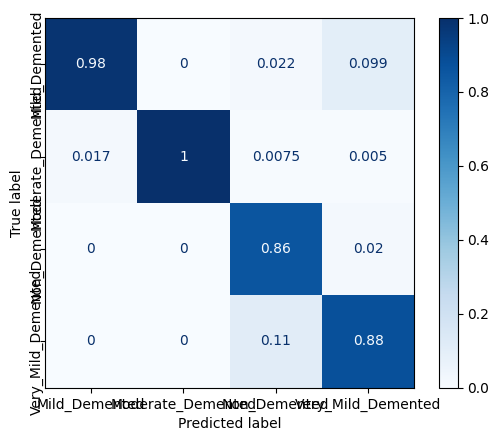

<Figure size 500x500 with 0 Axes>

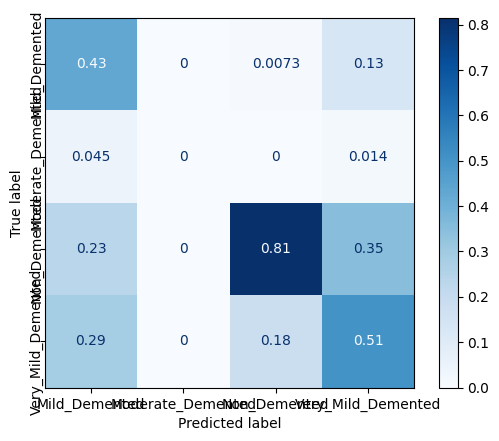

<Figure size 500x500 with 0 Axes>

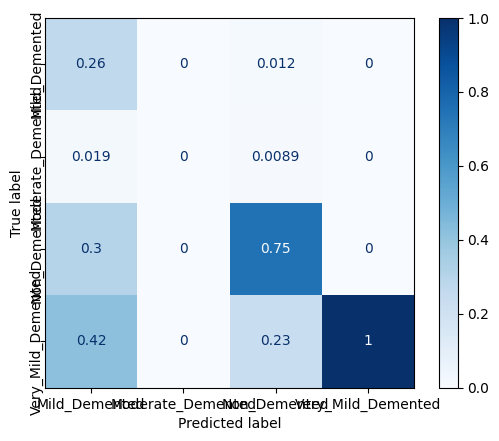

<Figure size 500x500 with 0 Axes>

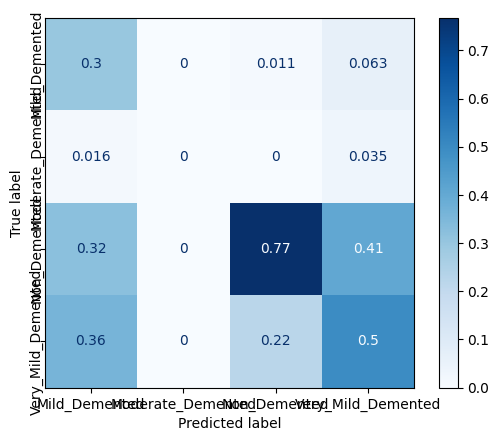

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r ResNet152V2.zip ./*